##### Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Text classification with an RNN

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/text/tutorials/text_classification_rnn"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/text/blob/master/docs/tutorials/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/text/blob/master/docs/tutorials/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/text/docs/tutorials/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This text classification tutorial trains a [recurrent neural network](https://developers.google.com/machine-learning/glossary/#recurrent_neural_network) on the [IMDB large movie review dataset](http://ai.stanford.edu/~amaas/data/sentiment/) for sentiment analysis.

## Setup

In [2]:
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

Import `matplotlib` and create a helper function to plot graphs:

In [3]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

## Setup input pipeline


The IMDB large movie review dataset is a *binary classification* dataset—all the reviews have either a *positive* or *negative* sentiment.

Download the dataset using [TFDS](https://www.tensorflow.org/datasets). See the [loading text tutorial](https://www.tensorflow.org/tutorials/load_data/text) for details on how to load this sort of data manually.


In [4]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

Initially this returns a dataset of (text, label pairs):

In [5]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


Next shuffle the data for training and create batches of these `(text, label)` pairs:

In [6]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [7]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [8]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b"I'm starting to write this review during a break as I watch the movie. It's the first time I've tried doing that, but I'm having trouble getting through this one without occasional breaks. That's not because it's intense but because it's bad.<br /><br />It's almost painfully tedious and unbelievable, especially when the preternaturally robust dying brother Ryan (Colm Feore) is on screen being tragic and bitchy, self-indulgent and self-pitying. This would have been a much better movie if they'd just left that character out of the story.<br /><br />He adds nothing but mawkish, maudlin, very irritating melodrama. Maybe somebody decided that if they couldn't make Ryan believable they'd just make him obnoxious. The problem with that is: Who cares if a spoiled, whining, obnoxious jerk is dying? Not me.<br /><br />The ONLY thing this character has going for him is the fact that he's dying, and sorry, but that's just not enough. Dying doesn't make anybody special. We're ALL dying, s

## Create the text encoder

The raw text loaded by `tfds` needs to be processed before it can be used in a model. The simplest way to process text for training is using the `experimental.preprocessing.TextVectorization` layer. This layer has many capabilities, but this tutorial sticks to the default behavior.

Create the layer, and pass the dataset's text to the layer's `.adapt` method:

In [9]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

The `.adapt` method sets the layer's vocabulary. Here are the first 20 tokens. After the padding and unknown tokens they're sorted by frequency: 

In [10]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

Once the vocabulary is set, the layer can encode text into indices. The tensors of indices are 0-padded to the longest sequence in the batch (unless you set a fixed `output_sequence_length`):

In [11]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[142,   1,   6, ...,   0,   0,   0],
       [243,   9,  67, ...,   0,   0,   0],
       [255,  22,  29, ...,   0,   0,   0]])

With the default settings, the process is not completely reversible. There are three main reasons for that:

1. The default value for `preprocessing.TextVectorization`'s `standardize` argument is `"lower_and_strip_punctuation"`.
2. The limited vocabulary size and lack of character-based fallback results in some unknown tokens.

In [12]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b"I'm starting to write this review during a break as I watch the movie. It's the first time I've tried doing that, but I'm having trouble getting through this one without occasional breaks. That's not because it's intense but because it's bad.<br /><br />It's almost painfully tedious and unbelievable, especially when the preternaturally robust dying brother Ryan (Colm Feore) is on screen being tragic and bitchy, self-indulgent and self-pitying. This would have been a much better movie if they'd just left that character out of the story.<br /><br />He adds nothing but mawkish, maudlin, very irritating melodrama. Maybe somebody decided that if they couldn't make Ryan believable they'd just make him obnoxious. The problem with that is: Who cares if a spoiled, whining, obnoxious jerk is dying? Not me.<br /><br />The ONLY thing this character has going for him is the fact that he's dying, and sorry, but that's just not enough. Dying doesn't make anybody special. We're ALL dying,

## Create the model

![A drawing of the information flow in the model](images/bidirectional.png)

Above is a diagram of the model. 

1. This model can be build as a `tf.keras.Sequential`.

2. The first layer is the `encoder`, which converts the text to a sequence of token indices.

3. After the encoder is an embedding layer. An embedding layer stores one vector per word. When called, it converts the sequences of word indices to sequences of vectors. These vectors are trainable. After training (on enough data), words with similar meanings often have similar vectors.

  This index-lookup is much more efficient than the equivalent operation of passing a one-hot encoded vector through a `tf.keras.layers.Dense` layer.

4. A recurrent neural network (RNN) processes sequence input by iterating through the elements. RNNs pass the outputs from one timestep to their input on the next timestep.

  The `tf.keras.layers.Bidirectional` wrapper can also be used with an RNN layer. This propagates the input forward and backwards through the RNN layer and then concatenates the final output. 

  * The main advantage of a bidirectional RNN is that the signal from the beginning of the input doesn't need to be processed all the way through every timestep to affect the output.  

  * The main disadvantage of a bidirectional RNN is that you can't efficiently stream predictions as words are being added to the end.

5. After the RNN has converted the sequence to a single vector the two `layers.Dense` do some final processing, and convert from this vector representation to a single logit as the classification output. 


The code to implement this is below:

In [13]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

Please note that Keras sequential model is used here since all the layers in the model only have single input and produce single output. In case you want to use stateful RNN layer, you might want to build your model with Keras functional API or model subclassing so that you can retrieve and reuse the RNN layer states. Please check [Keras RNN guide](https://www.tensorflow.org/guide/keras/rnn#rnn_state_reuse) for more details.

The embedding layer [uses masking](https://www.tensorflow.org/guide/keras/masking_and_padding) to handle the varying sequence-lengths. All the layers after the `Embedding` support masking:

In [14]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


To confirm that this works as expected, evaluate a sentence twice. First, alone so there's no padding to mask:

In [15]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

[-0.01056789]


Now, evaluate it again in a batch with a longer sentence. The result should be identical:

In [16]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

[-0.01056789]


Compile the Keras model to configure the training process:

In [17]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

## Train the model

In [18]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10


  1/391 [..............................] - ETA: 50:01 - loss: 0.6937 - accuracy: 0.4844

  2/391 [..............................] - ETA: 22s - loss: 0.6935 - accuracy: 0.4766  

  3/391 [..............................] - ETA: 29s - loss: 0.6936 - accuracy: 0.4635

  4/391 [..............................] - ETA: 29s - loss: 0.6935 - accuracy: 0.4570

  5/391 [..............................] - ETA: 30s - loss: 0.6935 - accuracy: 0.4719

  6/391 [..............................] - ETA: 32s - loss: 0.6935 - accuracy: 0.4792

  7/391 [..............................] - ETA: 31s - loss: 0.6935 - accuracy: 0.4754

  8/391 [..............................] - ETA: 31s - loss: 0.6934 - accuracy: 0.4805

  9/391 [..............................] - ETA: 31s - loss: 0.6933 - accuracy: 0.4705

 10/391 [..............................] - ETA: 30s - loss: 0.6933 - accuracy: 0.4797

 11/391 [..............................] - ETA: 30s - loss: 0.6933 - accuracy: 0.4872

 12/391 [..............................] - ETA: 29s - loss: 0.6932 - accuracy: 0.5013

 13/391 [..............................] - ETA: 29s - loss: 0.6932 - accuracy: 0.5096

 14/391 [>.............................] - ETA: 29s - loss: 0.6932 - accuracy: 0.5100

 15/391 [>.............................] - ETA: 29s - loss: 0.6932 - accuracy: 0.5052

 16/391 [>.............................] - ETA: 29s - loss: 0.6932 - accuracy: 0.5127

 17/391 [>.............................] - ETA: 29s - loss: 0.6932 - accuracy: 0.5119

 18/391 [>.............................] - ETA: 29s - loss: 0.6931 - accuracy: 0.5113

 19/391 [>.............................] - ETA: 29s - loss: 0.6931 - accuracy: 0.5107

 20/391 [>.............................] - ETA: 28s - loss: 0.6931 - accuracy: 0.5078

 21/391 [>.............................] - ETA: 28s - loss: 0.6931 - accuracy: 0.5067

 22/391 [>.............................] - ETA: 28s - loss: 0.6931 - accuracy: 0.5057

 23/391 [>.............................] - ETA: 28s - loss: 0.6931 - accuracy: 0.5034

 24/391 [>.............................] - ETA: 28s - loss: 0.6931 - accuracy: 0.5039

 25/391 [>.............................] - ETA: 27s - loss: 0.6931 - accuracy: 0.5056

 26/391 [>.............................] - ETA: 27s - loss: 0.6931 - accuracy: 0.5036

 27/391 [=>............................] - ETA: 27s - loss: 0.6931 - accuracy: 0.5058

 28/391 [=>............................] - ETA: 27s - loss: 0.6931 - accuracy: 0.5022

 29/391 [=>............................] - ETA: 27s - loss: 0.6931 - accuracy: 0.5070

 30/391 [=>............................] - ETA: 27s - loss: 0.6931 - accuracy: 0.5031

 31/391 [=>............................] - ETA: 27s - loss: 0.6930 - accuracy: 0.5025

 32/391 [=>............................] - ETA: 27s - loss: 0.6930 - accuracy: 0.5034

 34/391 [=>............................] - ETA: 26s - loss: 0.6930 - accuracy: 0.5051

 35/391 [=>............................] - ETA: 26s - loss: 0.6930 - accuracy: 0.5045

 36/391 [=>............................] - ETA: 26s - loss: 0.6930 - accuracy: 0.5043

 37/391 [=>............................] - ETA: 26s - loss: 0.6930 - accuracy: 0.5089

 38/391 [=>............................] - ETA: 26s - loss: 0.6930 - accuracy: 0.5111

 39/391 [=>............................] - ETA: 26s - loss: 0.6930 - accuracy: 0.5092

 40/391 [==>...........................] - ETA: 26s - loss: 0.6930 - accuracy: 0.5117

 41/391 [==>...........................] - ETA: 26s - loss: 0.6930 - accuracy: 0.5133

 42/391 [==>...........................] - ETA: 26s - loss: 0.6929 - accuracy: 0.5145

 43/391 [==>...........................] - ETA: 26s - loss: 0.6929 - accuracy: 0.5156

 44/391 [==>...........................] - ETA: 26s - loss: 0.6930 - accuracy: 0.5121

 45/391 [==>...........................] - ETA: 26s - loss: 0.6930 - accuracy: 0.5122

 46/391 [==>...........................] - ETA: 26s - loss: 0.6930 - accuracy: 0.5122

 48/391 [==>...........................] - ETA: 25s - loss: 0.6929 - accuracy: 0.5150

 49/391 [==>...........................] - ETA: 25s - loss: 0.6929 - accuracy: 0.5131

 50/391 [==>...........................] - ETA: 25s - loss: 0.6929 - accuracy: 0.5128

 51/391 [==>...........................] - ETA: 25s - loss: 0.6930 - accuracy: 0.5113

 52/391 [==>...........................] - ETA: 25s - loss: 0.6929 - accuracy: 0.5123

 53/391 [===>..........................] - ETA: 25s - loss: 0.6929 - accuracy: 0.5124

 54/391 [===>..........................] - ETA: 25s - loss: 0.6929 - accuracy: 0.5110

 55/391 [===>..........................] - ETA: 25s - loss: 0.6929 - accuracy: 0.5091

 56/391 [===>..........................] - ETA: 25s - loss: 0.6929 - accuracy: 0.5075

 57/391 [===>..........................] - ETA: 25s - loss: 0.6929 - accuracy: 0.5079

 58/391 [===>..........................] - ETA: 25s - loss: 0.6929 - accuracy: 0.5092

 59/391 [===>..........................] - ETA: 25s - loss: 0.6929 - accuracy: 0.5085

 60/391 [===>..........................] - ETA: 24s - loss: 0.6930 - accuracy: 0.5078

 61/391 [===>..........................] - ETA: 24s - loss: 0.6930 - accuracy: 0.5085

 62/391 [===>..........................] - ETA: 24s - loss: 0.6930 - accuracy: 0.5068

 63/391 [===>..........................] - ETA: 24s - loss: 0.6930 - accuracy: 0.5067

 64/391 [===>..........................] - ETA: 24s - loss: 0.6930 - accuracy: 0.5061

 65/391 [===>..........................] - ETA: 24s - loss: 0.6930 - accuracy: 0.5046

 66/391 [====>.........................] - ETA: 24s - loss: 0.6930 - accuracy: 0.5033

 67/391 [====>.........................] - ETA: 24s - loss: 0.6930 - accuracy: 0.5033

 68/391 [====>.........................] - ETA: 24s - loss: 0.6930 - accuracy: 0.5044

 69/391 [====>.........................] - ETA: 24s - loss: 0.6929 - accuracy: 0.5036

 70/391 [====>.........................] - ETA: 23s - loss: 0.6929 - accuracy: 0.5031

 71/391 [====>.........................] - ETA: 23s - loss: 0.6929 - accuracy: 0.5033

 72/391 [====>.........................] - ETA: 23s - loss: 0.6929 - accuracy: 0.5033

 73/391 [====>.........................] - ETA: 23s - loss: 0.6929 - accuracy: 0.5021

 74/391 [====>.........................] - ETA: 23s - loss: 0.6929 - accuracy: 0.5025

 75/391 [====>.........................] - ETA: 23s - loss: 0.6929 - accuracy: 0.5025

 76/391 [====>.........................] - ETA: 23s - loss: 0.6929 - accuracy: 0.5016

 77/391 [====>.........................] - ETA: 23s - loss: 0.6929 - accuracy: 0.5022

 78/391 [====>.........................] - ETA: 23s - loss: 0.6929 - accuracy: 0.5030

 79/391 [=====>........................] - ETA: 22s - loss: 0.6929 - accuracy: 0.5024

 80/391 [=====>........................] - ETA: 22s - loss: 0.6929 - accuracy: 0.5027

 81/391 [=====>........................] - ETA: 22s - loss: 0.6929 - accuracy: 0.5031

 82/391 [=====>........................] - ETA: 22s - loss: 0.6929 - accuracy: 0.5040

 83/391 [=====>........................] - ETA: 22s - loss: 0.6929 - accuracy: 0.5038

 84/391 [=====>........................] - ETA: 22s - loss: 0.6929 - accuracy: 0.5032

 85/391 [=====>........................] - ETA: 22s - loss: 0.6929 - accuracy: 0.5026

 86/391 [=====>........................] - ETA: 22s - loss: 0.6929 - accuracy: 0.5025

 87/391 [=====>........................] - ETA: 22s - loss: 0.6929 - accuracy: 0.5020

 88/391 [=====>........................] - ETA: 22s - loss: 0.6929 - accuracy: 0.5025

 89/391 [=====>........................] - ETA: 22s - loss: 0.6928 - accuracy: 0.5030

 90/391 [=====>........................] - ETA: 22s - loss: 0.6928 - accuracy: 0.5030

 91/391 [=====>........................] - ETA: 22s - loss: 0.6928 - accuracy: 0.5022

 92/391 [======>.......................] - ETA: 22s - loss: 0.6928 - accuracy: 0.5032

 93/391 [======>.......................] - ETA: 22s - loss: 0.6928 - accuracy: 0.5029

 94/391 [======>.......................] - ETA: 21s - loss: 0.6928 - accuracy: 0.5013

 95/391 [======>.......................] - ETA: 21s - loss: 0.6928 - accuracy: 0.5018

 96/391 [======>.......................] - ETA: 21s - loss: 0.6928 - accuracy: 0.5018

 97/391 [======>.......................] - ETA: 21s - loss: 0.6928 - accuracy: 0.5019

 98/391 [======>.......................] - ETA: 21s - loss: 0.6928 - accuracy: 0.5011

 99/391 [======>.......................] - ETA: 21s - loss: 0.6928 - accuracy: 0.5011

100/391 [======>.......................] - ETA: 21s - loss: 0.6928 - accuracy: 0.5008

101/391 [======>.......................] - ETA: 21s - loss: 0.6928 - accuracy: 0.5015

102/391 [======>.......................] - ETA: 21s - loss: 0.6928 - accuracy: 0.5012

103/391 [======>.......................] - ETA: 21s - loss: 0.6928 - accuracy: 0.5012

104/391 [======>.......................] - ETA: 21s - loss: 0.6927 - accuracy: 0.5005

105/391 [=======>......................] - ETA: 21s - loss: 0.6927 - accuracy: 0.5007

106/391 [=======>......................] - ETA: 20s - loss: 0.6927 - accuracy: 0.5022

107/391 [=======>......................] - ETA: 21s - loss: 0.6927 - accuracy: 0.5018

108/391 [=======>......................] - ETA: 20s - loss: 0.6927 - accuracy: 0.5019

109/391 [=======>......................] - ETA: 20s - loss: 0.6927 - accuracy: 0.5020

110/391 [=======>......................] - ETA: 20s - loss: 0.6927 - accuracy: 0.5014

111/391 [=======>......................] - ETA: 20s - loss: 0.6927 - accuracy: 0.5017

112/391 [=======>......................] - ETA: 20s - loss: 0.6927 - accuracy: 0.5021

113/391 [=======>......................] - ETA: 20s - loss: 0.6926 - accuracy: 0.5018

114/391 [=======>......................] - ETA: 20s - loss: 0.6926 - accuracy: 0.5022

115/391 [=======>......................] - ETA: 20s - loss: 0.6926 - accuracy: 0.5019

116/391 [=======>......................] - ETA: 20s - loss: 0.6926 - accuracy: 0.5016

117/391 [=======>......................] - ETA: 20s - loss: 0.6926 - accuracy: 0.5012

118/391 [========>.....................] - ETA: 20s - loss: 0.6926 - accuracy: 0.5013

119/391 [========>.....................] - ETA: 20s - loss: 0.6926 - accuracy: 0.5020

120/391 [========>.....................] - ETA: 19s - loss: 0.6926 - accuracy: 0.5018

121/391 [========>.....................] - ETA: 19s - loss: 0.6926 - accuracy: 0.5019

122/391 [========>.....................] - ETA: 19s - loss: 0.6926 - accuracy: 0.5018

123/391 [========>.....................] - ETA: 19s - loss: 0.6925 - accuracy: 0.5020

124/391 [========>.....................] - ETA: 19s - loss: 0.6925 - accuracy: 0.5021

125/391 [========>.....................] - ETA: 19s - loss: 0.6925 - accuracy: 0.5023

126/391 [========>.....................] - ETA: 19s - loss: 0.6925 - accuracy: 0.5015

127/391 [========>.....................] - ETA: 19s - loss: 0.6925 - accuracy: 0.5007

128/391 [========>.....................] - ETA: 19s - loss: 0.6925 - accuracy: 0.4999

129/391 [========>.....................] - ETA: 19s - loss: 0.6925 - accuracy: 0.4994

130/391 [========>.....................] - ETA: 19s - loss: 0.6925 - accuracy: 0.4996

131/391 [=========>....................] - ETA: 19s - loss: 0.6924 - accuracy: 0.4999

132/391 [=========>....................] - ETA: 19s - loss: 0.6924 - accuracy: 0.4996

133/391 [=========>....................] - ETA: 18s - loss: 0.6924 - accuracy: 0.5000

134/391 [=========>....................] - ETA: 18s - loss: 0.6924 - accuracy: 0.5005

135/391 [=========>....................] - ETA: 18s - loss: 0.6924 - accuracy: 0.5001

136/391 [=========>....................] - ETA: 18s - loss: 0.6924 - accuracy: 0.5007

137/391 [=========>....................] - ETA: 18s - loss: 0.6924 - accuracy: 0.5005

138/391 [=========>....................] - ETA: 18s - loss: 0.6924 - accuracy: 0.4995

139/391 [=========>....................] - ETA: 18s - loss: 0.6923 - accuracy: 0.4992

140/391 [=========>....................] - ETA: 18s - loss: 0.6923 - accuracy: 0.4996

141/391 [=========>....................] - ETA: 18s - loss: 0.6923 - accuracy: 0.4994

142/391 [=========>....................] - ETA: 18s - loss: 0.6923 - accuracy: 0.4991

143/391 [=========>....................] - ETA: 18s - loss: 0.6923 - accuracy: 0.4989

144/391 [==========>...................] - ETA: 18s - loss: 0.6923 - accuracy: 0.4995

145/391 [==========>...................] - ETA: 18s - loss: 0.6923 - accuracy: 0.4998

146/391 [==========>...................] - ETA: 18s - loss: 0.6923 - accuracy: 0.5000

147/391 [==========>...................] - ETA: 17s - loss: 0.6923 - accuracy: 0.5002

148/391 [==========>...................] - ETA: 17s - loss: 0.6923 - accuracy: 0.5003

149/391 [==========>...................] - ETA: 17s - loss: 0.6922 - accuracy: 0.5008

150/391 [==========>...................] - ETA: 17s - loss: 0.6922 - accuracy: 0.5004

151/391 [==========>...................] - ETA: 17s - loss: 0.6922 - accuracy: 0.5003

152/391 [==========>...................] - ETA: 17s - loss: 0.6922 - accuracy: 0.5006

153/391 [==========>...................] - ETA: 17s - loss: 0.6922 - accuracy: 0.5005

154/391 [==========>...................] - ETA: 17s - loss: 0.6922 - accuracy: 0.5013

155/391 [==========>...................] - ETA: 17s - loss: 0.6922 - accuracy: 0.5016

156/391 [==========>...................] - ETA: 17s - loss: 0.6922 - accuracy: 0.5016

157/391 [===========>..................] - ETA: 17s - loss: 0.6922 - accuracy: 0.5015

158/391 [===========>..................] - ETA: 17s - loss: 0.6922 - accuracy: 0.5014

159/391 [===========>..................] - ETA: 17s - loss: 0.6921 - accuracy: 0.5015

160/391 [===========>..................] - ETA: 17s - loss: 0.6921 - accuracy: 0.5022

161/391 [===========>..................] - ETA: 16s - loss: 0.6921 - accuracy: 0.5020

162/391 [===========>..................] - ETA: 16s - loss: 0.6921 - accuracy: 0.5017

163/391 [===========>..................] - ETA: 16s - loss: 0.6920 - accuracy: 0.5012

164/391 [===========>..................] - ETA: 16s - loss: 0.6920 - accuracy: 0.5014

165/391 [===========>..................] - ETA: 16s - loss: 0.6920 - accuracy: 0.5014

166/391 [===========>..................] - ETA: 16s - loss: 0.6920 - accuracy: 0.5014

167/391 [===========>..................] - ETA: 16s - loss: 0.6919 - accuracy: 0.5019

168/391 [===========>..................] - ETA: 16s - loss: 0.6919 - accuracy: 0.5019

169/391 [===========>..................] - ETA: 16s - loss: 0.6919 - accuracy: 0.5017

170/391 [============>.................] - ETA: 16s - loss: 0.6919 - accuracy: 0.5013

171/391 [============>.................] - ETA: 16s - loss: 0.6919 - accuracy: 0.5010

172/391 [============>.................] - ETA: 16s - loss: 0.6919 - accuracy: 0.5007

173/391 [============>.................] - ETA: 16s - loss: 0.6918 - accuracy: 0.5009

174/391 [============>.................] - ETA: 16s - loss: 0.6918 - accuracy: 0.5013

175/391 [============>.................] - ETA: 16s - loss: 0.6918 - accuracy: 0.5016

176/391 [============>.................] - ETA: 15s - loss: 0.6918 - accuracy: 0.5018

177/391 [============>.................] - ETA: 15s - loss: 0.6917 - accuracy: 0.5023

178/391 [============>.................] - ETA: 15s - loss: 0.6917 - accuracy: 0.5023

179/391 [============>.................] - ETA: 15s - loss: 0.6917 - accuracy: 0.5023

180/391 [============>.................] - ETA: 15s - loss: 0.6916 - accuracy: 0.5023

181/391 [============>.................] - ETA: 15s - loss: 0.6916 - accuracy: 0.5021

182/391 [============>.................] - ETA: 15s - loss: 0.6916 - accuracy: 0.5023

183/391 [=============>................] - ETA: 15s - loss: 0.6915 - accuracy: 0.5023

184/391 [=============>................] - ETA: 15s - loss: 0.6914 - accuracy: 0.5028

185/391 [=============>................] - ETA: 15s - loss: 0.6914 - accuracy: 0.5025

186/391 [=============>................] - ETA: 15s - loss: 0.6914 - accuracy: 0.5019

187/391 [=============>................] - ETA: 15s - loss: 0.6914 - accuracy: 0.5020

188/391 [=============>................] - ETA: 14s - loss: 0.6914 - accuracy: 0.5013

189/391 [=============>................] - ETA: 14s - loss: 0.6914 - accuracy: 0.5009

190/391 [=============>................] - ETA: 14s - loss: 0.6913 - accuracy: 0.5008

191/391 [=============>................] - ETA: 14s - loss: 0.6913 - accuracy: 0.5003

192/391 [=============>................] - ETA: 14s - loss: 0.6912 - accuracy: 0.5003

193/391 [=============>................] - ETA: 14s - loss: 0.6911 - accuracy: 0.5001

194/391 [=============>................] - ETA: 14s - loss: 0.6911 - accuracy: 0.5001

195/391 [=============>................] - ETA: 14s - loss: 0.6910 - accuracy: 0.5001

196/391 [==============>...............] - ETA: 14s - loss: 0.6909 - accuracy: 0.5002

197/391 [==============>...............] - ETA: 14s - loss: 0.6908 - accuracy: 0.5003

198/391 [==============>...............] - ETA: 14s - loss: 0.6908 - accuracy: 0.5006

199/391 [==============>...............] - ETA: 14s - loss: 0.6907 - accuracy: 0.5012

200/391 [==============>...............] - ETA: 14s - loss: 0.6905 - accuracy: 0.5016

201/391 [==============>...............] - ETA: 14s - loss: 0.6903 - accuracy: 0.5018

203/391 [==============>...............] - ETA: 13s - loss: 0.6896 - accuracy: 0.5027

204/391 [==============>...............] - ETA: 13s - loss: 0.6897 - accuracy: 0.5027

205/391 [==============>...............] - ETA: 13s - loss: 0.6897 - accuracy: 0.5029

206/391 [==============>...............] - ETA: 13s - loss: 0.6894 - accuracy: 0.5031

207/391 [==============>...............] - ETA: 13s - loss: 0.6893 - accuracy: 0.5027

208/391 [==============>...............] - ETA: 13s - loss: 0.6890 - accuracy: 0.5029

209/391 [===============>..............] - ETA: 13s - loss: 0.6888 - accuracy: 0.5034

210/391 [===============>..............] - ETA: 13s - loss: 0.6885 - accuracy: 0.5036

211/391 [===============>..............] - ETA: 13s - loss: 0.6882 - accuracy: 0.5036

212/391 [===============>..............] - ETA: 13s - loss: 0.6881 - accuracy: 0.5043

213/391 [===============>..............] - ETA: 13s - loss: 0.6878 - accuracy: 0.5051

214/391 [===============>..............] - ETA: 13s - loss: 0.6876 - accuracy: 0.5055

215/391 [===============>..............] - ETA: 12s - loss: 0.6872 - accuracy: 0.5058

216/391 [===============>..............] - ETA: 12s - loss: 0.6867 - accuracy: 0.5068

217/391 [===============>..............] - ETA: 12s - loss: 0.6863 - accuracy: 0.5070

218/391 [===============>..............] - ETA: 12s - loss: 0.6863 - accuracy: 0.5071

219/391 [===============>..............] - ETA: 12s - loss: 0.6858 - accuracy: 0.5074

220/391 [===============>..............] - ETA: 12s - loss: 0.6853 - accuracy: 0.5081

221/391 [===============>..............] - ETA: 12s - loss: 0.6849 - accuracy: 0.5086

222/391 [================>.............] - ETA: 12s - loss: 0.6848 - accuracy: 0.5089

223/391 [================>.............] - ETA: 12s - loss: 0.6847 - accuracy: 0.5095

224/391 [================>.............] - ETA: 12s - loss: 0.6844 - accuracy: 0.5102

225/391 [================>.............] - ETA: 12s - loss: 0.6838 - accuracy: 0.5112

226/391 [================>.............] - ETA: 12s - loss: 0.6835 - accuracy: 0.5120

227/391 [================>.............] - ETA: 12s - loss: 0.6833 - accuracy: 0.5123

228/391 [================>.............] - ETA: 11s - loss: 0.6834 - accuracy: 0.5125

229/391 [================>.............] - ETA: 11s - loss: 0.6831 - accuracy: 0.5130

230/391 [================>.............] - ETA: 11s - loss: 0.6827 - accuracy: 0.5135

231/391 [================>.............] - ETA: 11s - loss: 0.6827 - accuracy: 0.5137

232/391 [================>.............] - ETA: 11s - loss: 0.6823 - accuracy: 0.5148

233/391 [================>.............] - ETA: 11s - loss: 0.6820 - accuracy: 0.5153

234/391 [================>.............] - ETA: 11s - loss: 0.6821 - accuracy: 0.5156

235/391 [=================>............] - ETA: 11s - loss: 0.6819 - accuracy: 0.5162

236/391 [=================>............] - ETA: 11s - loss: 0.6815 - accuracy: 0.5170

237/391 [=================>............] - ETA: 11s - loss: 0.6812 - accuracy: 0.5173

238/391 [=================>............] - ETA: 11s - loss: 0.6810 - accuracy: 0.5177

239/391 [=================>............] - ETA: 11s - loss: 0.6808 - accuracy: 0.5182

240/391 [=================>............] - ETA: 11s - loss: 0.6804 - accuracy: 0.5186

241/391 [=================>............] - ETA: 11s - loss: 0.6798 - accuracy: 0.5192

242/391 [=================>............] - ETA: 11s - loss: 0.6796 - accuracy: 0.5192

243/391 [=================>............] - ETA: 10s - loss: 0.6794 - accuracy: 0.5198

244/391 [=================>............] - ETA: 10s - loss: 0.6792 - accuracy: 0.5199

245/391 [=================>............] - ETA: 10s - loss: 0.6791 - accuracy: 0.5196

246/391 [=================>............] - ETA: 10s - loss: 0.6788 - accuracy: 0.5198

247/391 [=================>............] - ETA: 10s - loss: 0.6783 - accuracy: 0.5209

248/391 [==================>...........] - ETA: 10s - loss: 0.6780 - accuracy: 0.5212

249/391 [==================>...........] - ETA: 10s - loss: 0.6774 - accuracy: 0.5218

250/391 [==================>...........] - ETA: 10s - loss: 0.6772 - accuracy: 0.5220

251/391 [==================>...........] - ETA: 10s - loss: 0.6767 - accuracy: 0.5225

252/391 [==================>...........] - ETA: 10s - loss: 0.6764 - accuracy: 0.5229

253/391 [==================>...........] - ETA: 10s - loss: 0.6760 - accuracy: 0.5235

254/391 [==================>...........] - ETA: 10s - loss: 0.6757 - accuracy: 0.5239

255/391 [==================>...........] - ETA: 10s - loss: 0.6753 - accuracy: 0.5243

256/391 [==================>...........] - ETA: 9s - loss: 0.6750 - accuracy: 0.5249 

257/391 [==================>...........] - ETA: 9s - loss: 0.6746 - accuracy: 0.5256

258/391 [==================>...........] - ETA: 9s - loss: 0.6743 - accuracy: 0.5263

259/391 [==================>...........] - ETA: 9s - loss: 0.6737 - accuracy: 0.5273

260/391 [==================>...........] - ETA: 9s - loss: 0.6732 - accuracy: 0.5283

261/391 [===================>..........] - ETA: 9s - loss: 0.6725 - accuracy: 0.5293

262/391 [===================>..........] - ETA: 9s - loss: 0.6724 - accuracy: 0.5296

263/391 [===================>..........] - ETA: 9s - loss: 0.6722 - accuracy: 0.5301

264/391 [===================>..........] - ETA: 9s - loss: 0.6722 - accuracy: 0.5303

265/391 [===================>..........] - ETA: 9s - loss: 0.6718 - accuracy: 0.5311

266/391 [===================>..........] - ETA: 9s - loss: 0.6715 - accuracy: 0.5315

267/391 [===================>..........] - ETA: 9s - loss: 0.6711 - accuracy: 0.5322

268/391 [===================>..........] - ETA: 9s - loss: 0.6707 - accuracy: 0.5330

269/391 [===================>..........] - ETA: 8s - loss: 0.6703 - accuracy: 0.5337

270/391 [===================>..........] - ETA: 8s - loss: 0.6698 - accuracy: 0.5345

271/391 [===================>..........] - ETA: 8s - loss: 0.6692 - accuracy: 0.5355

272/391 [===================>..........] - ETA: 8s - loss: 0.6689 - accuracy: 0.5357

273/391 [===================>..........] - ETA: 8s - loss: 0.6686 - accuracy: 0.5363

274/391 [====================>.........] - ETA: 8s - loss: 0.6681 - accuracy: 0.5371

275/391 [====================>.........] - ETA: 8s - loss: 0.6678 - accuracy: 0.5375

276/391 [====================>.........] - ETA: 8s - loss: 0.6674 - accuracy: 0.5383

277/391 [====================>.........] - ETA: 8s - loss: 0.6670 - accuracy: 0.5389

278/391 [====================>.........] - ETA: 8s - loss: 0.6665 - accuracy: 0.5397

279/391 [====================>.........] - ETA: 8s - loss: 0.6661 - accuracy: 0.5402

280/391 [====================>.........] - ETA: 8s - loss: 0.6656 - accuracy: 0.5409

281/391 [====================>.........] - ETA: 8s - loss: 0.6655 - accuracy: 0.5411

282/391 [====================>.........] - ETA: 8s - loss: 0.6652 - accuracy: 0.5416

283/391 [====================>.........] - ETA: 7s - loss: 0.6647 - accuracy: 0.5420

284/391 [====================>.........] - ETA: 7s - loss: 0.6643 - accuracy: 0.5427

285/391 [====================>.........] - ETA: 7s - loss: 0.6638 - accuracy: 0.5436

286/391 [====================>.........] - ETA: 7s - loss: 0.6634 - accuracy: 0.5443

287/391 [=====================>........] - ETA: 7s - loss: 0.6629 - accuracy: 0.5452

288/391 [=====================>........] - ETA: 7s - loss: 0.6626 - accuracy: 0.5459

289/391 [=====================>........] - ETA: 7s - loss: 0.6622 - accuracy: 0.5464

290/391 [=====================>........] - ETA: 7s - loss: 0.6621 - accuracy: 0.5468

291/391 [=====================>........] - ETA: 7s - loss: 0.6615 - accuracy: 0.5477

292/391 [=====================>........] - ETA: 7s - loss: 0.6610 - accuracy: 0.5485

293/391 [=====================>........] - ETA: 7s - loss: 0.6607 - accuracy: 0.5490

294/391 [=====================>........] - ETA: 7s - loss: 0.6604 - accuracy: 0.5495

295/391 [=====================>........] - ETA: 7s - loss: 0.6602 - accuracy: 0.5499

296/391 [=====================>........] - ETA: 7s - loss: 0.6596 - accuracy: 0.5508

297/391 [=====================>........] - ETA: 6s - loss: 0.6591 - accuracy: 0.5516

298/391 [=====================>........] - ETA: 6s - loss: 0.6590 - accuracy: 0.5520

299/391 [=====================>........] - ETA: 6s - loss: 0.6584 - accuracy: 0.5528

300/391 [======================>.......] - ETA: 6s - loss: 0.6580 - accuracy: 0.5535

301/391 [======================>.......] - ETA: 6s - loss: 0.6575 - accuracy: 0.5543

302/391 [======================>.......] - ETA: 6s - loss: 0.6572 - accuracy: 0.5547

303/391 [======================>.......] - ETA: 6s - loss: 0.6569 - accuracy: 0.5552

304/391 [======================>.......] - ETA: 6s - loss: 0.6562 - accuracy: 0.5562

305/391 [======================>.......] - ETA: 6s - loss: 0.6557 - accuracy: 0.5569

306/391 [======================>.......] - ETA: 6s - loss: 0.6555 - accuracy: 0.5572

307/391 [======================>.......] - ETA: 6s - loss: 0.6549 - accuracy: 0.5577

308/391 [======================>.......] - ETA: 6s - loss: 0.6548 - accuracy: 0.5579

309/391 [======================>.......] - ETA: 6s - loss: 0.6544 - accuracy: 0.5580

310/391 [======================>.......] - ETA: 6s - loss: 0.6539 - accuracy: 0.5583

311/391 [======================>.......] - ETA: 5s - loss: 0.6535 - accuracy: 0.5589

312/391 [======================>.......] - ETA: 5s - loss: 0.6530 - accuracy: 0.5596

313/391 [=======================>......] - ETA: 5s - loss: 0.6526 - accuracy: 0.5604

314/391 [=======================>......] - ETA: 5s - loss: 0.6521 - accuracy: 0.5612

315/391 [=======================>......] - ETA: 5s - loss: 0.6515 - accuracy: 0.5622

316/391 [=======================>......] - ETA: 5s - loss: 0.6511 - accuracy: 0.5628

317/391 [=======================>......] - ETA: 5s - loss: 0.6506 - accuracy: 0.5635

318/391 [=======================>......] - ETA: 5s - loss: 0.6503 - accuracy: 0.5642

319/391 [=======================>......] - ETA: 5s - loss: 0.6499 - accuracy: 0.5647

320/391 [=======================>......] - ETA: 5s - loss: 0.6499 - accuracy: 0.5652

321/391 [=======================>......] - ETA: 5s - loss: 0.6497 - accuracy: 0.5657

322/391 [=======================>......] - ETA: 5s - loss: 0.6494 - accuracy: 0.5662

323/391 [=======================>......] - ETA: 5s - loss: 0.6488 - accuracy: 0.5671

324/391 [=======================>......] - ETA: 4s - loss: 0.6483 - accuracy: 0.5678

325/391 [=======================>......] - ETA: 4s - loss: 0.6478 - accuracy: 0.5685

326/391 [========================>.....] - ETA: 4s - loss: 0.6473 - accuracy: 0.5694

327/391 [========================>.....] - ETA: 4s - loss: 0.6469 - accuracy: 0.5698

328/391 [========================>.....] - ETA: 4s - loss: 0.6467 - accuracy: 0.5703

329/391 [========================>.....] - ETA: 4s - loss: 0.6465 - accuracy: 0.5708

330/391 [========================>.....] - ETA: 4s - loss: 0.6463 - accuracy: 0.5710

331/391 [========================>.....] - ETA: 4s - loss: 0.6465 - accuracy: 0.5711

332/391 [========================>.....] - ETA: 4s - loss: 0.6468 - accuracy: 0.5713

333/391 [========================>.....] - ETA: 4s - loss: 0.6465 - accuracy: 0.5717

334/391 [========================>.....] - ETA: 4s - loss: 0.6461 - accuracy: 0.5722

335/391 [========================>.....] - ETA: 4s - loss: 0.6458 - accuracy: 0.5726

336/391 [========================>.....] - ETA: 4s - loss: 0.6457 - accuracy: 0.5729

337/391 [========================>.....] - ETA: 4s - loss: 0.6455 - accuracy: 0.5730

338/391 [========================>.....] - ETA: 3s - loss: 0.6451 - accuracy: 0.5736

339/391 [=========================>....] - ETA: 3s - loss: 0.6446 - accuracy: 0.5742

340/391 [=========================>....] - ETA: 3s - loss: 0.6443 - accuracy: 0.5745

341/391 [=========================>....] - ETA: 3s - loss: 0.6440 - accuracy: 0.5752

342/391 [=========================>....] - ETA: 3s - loss: 0.6437 - accuracy: 0.5758

343/391 [=========================>....] - ETA: 3s - loss: 0.6434 - accuracy: 0.5764

344/391 [=========================>....] - ETA: 3s - loss: 0.6431 - accuracy: 0.5769

345/391 [=========================>....] - ETA: 3s - loss: 0.6427 - accuracy: 0.5776

346/391 [=========================>....] - ETA: 3s - loss: 0.6424 - accuracy: 0.5782

347/391 [=========================>....] - ETA: 3s - loss: 0.6420 - accuracy: 0.5788

348/391 [=========================>....] - ETA: 3s - loss: 0.6419 - accuracy: 0.5792

350/391 [=========================>....] - ETA: 3s - loss: 0.6414 - accuracy: 0.5802

351/391 [=========================>....] - ETA: 2s - loss: 0.6410 - accuracy: 0.5809

352/391 [==========================>...] - ETA: 2s - loss: 0.6407 - accuracy: 0.5813

353/391 [==========================>...] - ETA: 2s - loss: 0.6403 - accuracy: 0.5818

354/391 [==========================>...] - ETA: 2s - loss: 0.6399 - accuracy: 0.5824

355/391 [==========================>...] - ETA: 2s - loss: 0.6395 - accuracy: 0.5829

356/391 [==========================>...] - ETA: 2s - loss: 0.6391 - accuracy: 0.5833

357/391 [==========================>...] - ETA: 2s - loss: 0.6387 - accuracy: 0.5838

358/391 [==========================>...] - ETA: 2s - loss: 0.6384 - accuracy: 0.5841

359/391 [==========================>...] - ETA: 2s - loss: 0.6380 - accuracy: 0.5846

360/391 [==========================>...] - ETA: 2s - loss: 0.6377 - accuracy: 0.5851

361/391 [==========================>...] - ETA: 2s - loss: 0.6371 - accuracy: 0.5857

362/391 [==========================>...] - ETA: 2s - loss: 0.6368 - accuracy: 0.5861

363/391 [==========================>...] - ETA: 2s - loss: 0.6364 - accuracy: 0.5866

364/391 [==========================>...] - ETA: 1s - loss: 0.6360 - accuracy: 0.5871

365/391 [===========================>..] - ETA: 1s - loss: 0.6355 - accuracy: 0.5877

366/391 [===========================>..] - ETA: 1s - loss: 0.6351 - accuracy: 0.5881

367/391 [===========================>..] - ETA: 1s - loss: 0.6349 - accuracy: 0.5885

368/391 [===========================>..] - ETA: 1s - loss: 0.6348 - accuracy: 0.5889

369/391 [===========================>..] - ETA: 1s - loss: 0.6347 - accuracy: 0.5892

370/391 [===========================>..] - ETA: 1s - loss: 0.6343 - accuracy: 0.5899

371/391 [===========================>..] - ETA: 1s - loss: 0.6339 - accuracy: 0.5906

372/391 [===========================>..] - ETA: 1s - loss: 0.6334 - accuracy: 0.5912

373/391 [===========================>..] - ETA: 1s - loss: 0.6329 - accuracy: 0.5917

374/391 [===========================>..] - ETA: 1s - loss: 0.6325 - accuracy: 0.5922

375/391 [===========================>..] - ETA: 1s - loss: 0.6319 - accuracy: 0.5928

376/391 [===========================>..] - ETA: 1s - loss: 0.6315 - accuracy: 0.5932

377/391 [===========================>..] - ETA: 1s - loss: 0.6310 - accuracy: 0.5937

378/391 [============================>.] - ETA: 0s - loss: 0.6305 - accuracy: 0.5942

379/391 [============================>.] - ETA: 0s - loss: 0.6299 - accuracy: 0.5947

380/391 [============================>.] - ETA: 0s - loss: 0.6298 - accuracy: 0.5948

381/391 [============================>.] - ETA: 0s - loss: 0.6293 - accuracy: 0.5953

382/391 [============================>.] - ETA: 0s - loss: 0.6294 - accuracy: 0.5955

383/391 [============================>.] - ETA: 0s - loss: 0.6291 - accuracy: 0.5957

384/391 [============================>.] - ETA: 0s - loss: 0.6289 - accuracy: 0.5960

385/391 [============================>.] - ETA: 0s - loss: 0.6286 - accuracy: 0.5963

387/391 [============================>.] - ETA: 0s - loss: 0.6277 - accuracy: 0.5971

388/391 [============================>.] - ETA: 0s - loss: 0.6275 - accuracy: 0.5974

389/391 [============================>.] - ETA: 0s - loss: 0.6270 - accuracy: 0.5980

390/391 [============================>.] - ETA: 0s - loss: 0.6266 - accuracy: 0.5984

391/391 [==============================] - ETA: 0s - loss: 0.6264 - accuracy: 0.5987

391/391 [==============================] - 41s 86ms/step - loss: 0.6264 - accuracy: 0.5987 - val_loss: 0.4655 - val_accuracy: 0.7859


Epoch 2/10


  1/391 [..............................] - ETA: 4:53 - loss: 0.4108 - accuracy: 0.8750

  2/391 [..............................] - ETA: 26s - loss: 0.4535 - accuracy: 0.7812 

  3/391 [..............................] - ETA: 29s - loss: 0.4656 - accuracy: 0.7865

  4/391 [..............................] - ETA: 30s - loss: 0.4774 - accuracy: 0.7852

  5/391 [..............................] - ETA: 30s - loss: 0.4741 - accuracy: 0.7844

  6/391 [..............................] - ETA: 29s - loss: 0.4723 - accuracy: 0.7812

  7/391 [..............................] - ETA: 28s - loss: 0.4726 - accuracy: 0.7857

  8/391 [..............................] - ETA: 27s - loss: 0.4642 - accuracy: 0.7832

  9/391 [..............................] - ETA: 27s - loss: 0.4646 - accuracy: 0.7812

 10/391 [..............................] - ETA: 27s - loss: 0.4701 - accuracy: 0.7750

 11/391 [..............................] - ETA: 27s - loss: 0.4757 - accuracy: 0.7727

 12/391 [..............................] - ETA: 27s - loss: 0.4768 - accuracy: 0.7708

 13/391 [..............................] - ETA: 26s - loss: 0.4781 - accuracy: 0.7692

 14/391 [>.............................] - ETA: 27s - loss: 0.4810 - accuracy: 0.7690

 15/391 [>.............................] - ETA: 27s - loss: 0.4834 - accuracy: 0.7667

 16/391 [>.............................] - ETA: 27s - loss: 0.4851 - accuracy: 0.7656

 17/391 [>.............................] - ETA: 26s - loss: 0.4830 - accuracy: 0.7702

 18/391 [>.............................] - ETA: 26s - loss: 0.4811 - accuracy: 0.7734

 19/391 [>.............................] - ETA: 26s - loss: 0.4794 - accuracy: 0.7738

 20/391 [>.............................] - ETA: 26s - loss: 0.4769 - accuracy: 0.7742

 21/391 [>.............................] - ETA: 26s - loss: 0.4784 - accuracy: 0.7731

 22/391 [>.............................] - ETA: 26s - loss: 0.4739 - accuracy: 0.7763

 23/391 [>.............................] - ETA: 26s - loss: 0.4757 - accuracy: 0.7751

 24/391 [>.............................] - ETA: 25s - loss: 0.4768 - accuracy: 0.7734

 25/391 [>.............................] - ETA: 25s - loss: 0.4728 - accuracy: 0.7763

 26/391 [>.............................] - ETA: 25s - loss: 0.4719 - accuracy: 0.7764

 27/391 [=>............................] - ETA: 25s - loss: 0.4701 - accuracy: 0.7749

 28/391 [=>............................] - ETA: 25s - loss: 0.4706 - accuracy: 0.7768

 29/391 [=>............................] - ETA: 25s - loss: 0.4700 - accuracy: 0.7775

 30/391 [=>............................] - ETA: 25s - loss: 0.4712 - accuracy: 0.7750

 31/391 [=>............................] - ETA: 25s - loss: 0.4677 - accuracy: 0.7782

 32/391 [=>............................] - ETA: 25s - loss: 0.4675 - accuracy: 0.7783

 33/391 [=>............................] - ETA: 25s - loss: 0.4644 - accuracy: 0.7808

 34/391 [=>............................] - ETA: 25s - loss: 0.4635 - accuracy: 0.7808

 35/391 [=>............................] - ETA: 25s - loss: 0.4625 - accuracy: 0.7817

 36/391 [=>............................] - ETA: 25s - loss: 0.4603 - accuracy: 0.7834

 37/391 [=>............................] - ETA: 25s - loss: 0.4574 - accuracy: 0.7863

 38/391 [=>............................] - ETA: 24s - loss: 0.4562 - accuracy: 0.7874

 39/391 [=>............................] - ETA: 24s - loss: 0.4564 - accuracy: 0.7877

 40/391 [==>...........................] - ETA: 24s - loss: 0.4562 - accuracy: 0.7875

 41/391 [==>...........................] - ETA: 24s - loss: 0.4546 - accuracy: 0.7862

 42/391 [==>...........................] - ETA: 24s - loss: 0.4540 - accuracy: 0.7868

 43/391 [==>...........................] - ETA: 24s - loss: 0.4526 - accuracy: 0.7885

 44/391 [==>...........................] - ETA: 24s - loss: 0.4505 - accuracy: 0.7894

 45/391 [==>...........................] - ETA: 24s - loss: 0.4485 - accuracy: 0.7913

 46/391 [==>...........................] - ETA: 24s - loss: 0.4465 - accuracy: 0.7921

 47/391 [==>...........................] - ETA: 24s - loss: 0.4477 - accuracy: 0.7916

 48/391 [==>...........................] - ETA: 24s - loss: 0.4480 - accuracy: 0.7907

 49/391 [==>...........................] - ETA: 24s - loss: 0.4489 - accuracy: 0.7899

 50/391 [==>...........................] - ETA: 24s - loss: 0.4467 - accuracy: 0.7925

 51/391 [==>...........................] - ETA: 24s - loss: 0.4468 - accuracy: 0.7929

 52/391 [==>...........................] - ETA: 24s - loss: 0.4455 - accuracy: 0.7942

 53/391 [===>..........................] - ETA: 24s - loss: 0.4469 - accuracy: 0.7942

 54/391 [===>..........................] - ETA: 23s - loss: 0.4460 - accuracy: 0.7954

 56/391 [===>..........................] - ETA: 23s - loss: 0.4463 - accuracy: 0.7955

 57/391 [===>..........................] - ETA: 23s - loss: 0.4454 - accuracy: 0.7958

 58/391 [===>..........................] - ETA: 23s - loss: 0.4440 - accuracy: 0.7963

 59/391 [===>..........................] - ETA: 23s - loss: 0.4432 - accuracy: 0.7963

 60/391 [===>..........................] - ETA: 23s - loss: 0.4450 - accuracy: 0.7940

 61/391 [===>..........................] - ETA: 23s - loss: 0.4437 - accuracy: 0.7943

 62/391 [===>..........................] - ETA: 23s - loss: 0.4439 - accuracy: 0.7923

 63/391 [===>..........................] - ETA: 23s - loss: 0.4441 - accuracy: 0.7907

 64/391 [===>..........................] - ETA: 23s - loss: 0.4443 - accuracy: 0.7905

 65/391 [===>..........................] - ETA: 23s - loss: 0.4439 - accuracy: 0.7899

 66/391 [====>.........................] - ETA: 23s - loss: 0.4426 - accuracy: 0.7912

 67/391 [====>.........................] - ETA: 23s - loss: 0.4429 - accuracy: 0.7910

 69/391 [====>.........................] - ETA: 22s - loss: 0.4433 - accuracy: 0.7926

 70/391 [====>.........................] - ETA: 22s - loss: 0.4428 - accuracy: 0.7937

 71/391 [====>.........................] - ETA: 22s - loss: 0.4435 - accuracy: 0.7927

 72/391 [====>.........................] - ETA: 23s - loss: 0.4437 - accuracy: 0.7923

 73/391 [====>.........................] - ETA: 23s - loss: 0.4428 - accuracy: 0.7930

 74/391 [====>.........................] - ETA: 22s - loss: 0.4420 - accuracy: 0.7935

 75/391 [====>.........................] - ETA: 22s - loss: 0.4418 - accuracy: 0.7935

 76/391 [====>.........................] - ETA: 22s - loss: 0.4423 - accuracy: 0.7936

 77/391 [====>.........................] - ETA: 22s - loss: 0.4418 - accuracy: 0.7936

 78/391 [====>.........................] - ETA: 22s - loss: 0.4413 - accuracy: 0.7945

 79/391 [=====>........................] - ETA: 22s - loss: 0.4395 - accuracy: 0.7955

 80/391 [=====>........................] - ETA: 22s - loss: 0.4396 - accuracy: 0.7955

 81/391 [=====>........................] - ETA: 22s - loss: 0.4381 - accuracy: 0.7957

 82/391 [=====>........................] - ETA: 22s - loss: 0.4396 - accuracy: 0.7948

 83/391 [=====>........................] - ETA: 22s - loss: 0.4392 - accuracy: 0.7952

 84/391 [=====>........................] - ETA: 22s - loss: 0.4381 - accuracy: 0.7959

 85/391 [=====>........................] - ETA: 22s - loss: 0.4379 - accuracy: 0.7958

 86/391 [=====>........................] - ETA: 21s - loss: 0.4376 - accuracy: 0.7961

 87/391 [=====>........................] - ETA: 21s - loss: 0.4378 - accuracy: 0.7960

 88/391 [=====>........................] - ETA: 21s - loss: 0.4366 - accuracy: 0.7962

 89/391 [=====>........................] - ETA: 21s - loss: 0.4382 - accuracy: 0.7955

 90/391 [=====>........................] - ETA: 21s - loss: 0.4382 - accuracy: 0.7955

 91/391 [=====>........................] - ETA: 21s - loss: 0.4385 - accuracy: 0.7953

 92/391 [======>.......................] - ETA: 21s - loss: 0.4396 - accuracy: 0.7952

 93/391 [======>.......................] - ETA: 21s - loss: 0.4401 - accuracy: 0.7950

 94/391 [======>.......................] - ETA: 21s - loss: 0.4409 - accuracy: 0.7947

 95/391 [======>.......................] - ETA: 21s - loss: 0.4400 - accuracy: 0.7961

 96/391 [======>.......................] - ETA: 21s - loss: 0.4397 - accuracy: 0.7961

 97/391 [======>.......................] - ETA: 21s - loss: 0.4395 - accuracy: 0.7956

 98/391 [======>.......................] - ETA: 21s - loss: 0.4388 - accuracy: 0.7961

 99/391 [======>.......................] - ETA: 21s - loss: 0.4388 - accuracy: 0.7956

100/391 [======>.......................] - ETA: 20s - loss: 0.4379 - accuracy: 0.7961

101/391 [======>.......................] - ETA: 20s - loss: 0.4379 - accuracy: 0.7958

102/391 [======>.......................] - ETA: 20s - loss: 0.4384 - accuracy: 0.7947

103/391 [======>.......................] - ETA: 20s - loss: 0.4381 - accuracy: 0.7952

104/391 [======>.......................] - ETA: 20s - loss: 0.4377 - accuracy: 0.7955

105/391 [=======>......................] - ETA: 20s - loss: 0.4370 - accuracy: 0.7958

106/391 [=======>......................] - ETA: 20s - loss: 0.4362 - accuracy: 0.7970

107/391 [=======>......................] - ETA: 20s - loss: 0.4363 - accuracy: 0.7964

108/391 [=======>......................] - ETA: 20s - loss: 0.4367 - accuracy: 0.7964

109/391 [=======>......................] - ETA: 20s - loss: 0.4365 - accuracy: 0.7967

110/391 [=======>......................] - ETA: 20s - loss: 0.4362 - accuracy: 0.7969

111/391 [=======>......................] - ETA: 20s - loss: 0.4357 - accuracy: 0.7976

112/391 [=======>......................] - ETA: 20s - loss: 0.4357 - accuracy: 0.7976

113/391 [=======>......................] - ETA: 20s - loss: 0.4348 - accuracy: 0.7978

114/391 [=======>......................] - ETA: 19s - loss: 0.4344 - accuracy: 0.7982

115/391 [=======>......................] - ETA: 19s - loss: 0.4345 - accuracy: 0.7977

116/391 [=======>......................] - ETA: 19s - loss: 0.4340 - accuracy: 0.7982

117/391 [=======>......................] - ETA: 19s - loss: 0.4348 - accuracy: 0.7975

118/391 [========>.....................] - ETA: 19s - loss: 0.4360 - accuracy: 0.7963

119/391 [========>.....................] - ETA: 19s - loss: 0.4359 - accuracy: 0.7967

120/391 [========>.....................] - ETA: 19s - loss: 0.4356 - accuracy: 0.7971

121/391 [========>.....................] - ETA: 19s - loss: 0.4353 - accuracy: 0.7974

122/391 [========>.....................] - ETA: 19s - loss: 0.4350 - accuracy: 0.7980

123/391 [========>.....................] - ETA: 19s - loss: 0.4343 - accuracy: 0.7985

124/391 [========>.....................] - ETA: 19s - loss: 0.4338 - accuracy: 0.7990

125/391 [========>.....................] - ETA: 19s - loss: 0.4337 - accuracy: 0.7993

126/391 [========>.....................] - ETA: 19s - loss: 0.4334 - accuracy: 0.7991

127/391 [========>.....................] - ETA: 19s - loss: 0.4333 - accuracy: 0.7993

128/391 [========>.....................] - ETA: 19s - loss: 0.4330 - accuracy: 0.7996

129/391 [========>.....................] - ETA: 18s - loss: 0.4332 - accuracy: 0.7997

130/391 [========>.....................] - ETA: 18s - loss: 0.4326 - accuracy: 0.8005

131/391 [=========>....................] - ETA: 18s - loss: 0.4316 - accuracy: 0.8008

132/391 [=========>....................] - ETA: 18s - loss: 0.4321 - accuracy: 0.8005

133/391 [=========>....................] - ETA: 18s - loss: 0.4314 - accuracy: 0.8010

134/391 [=========>....................] - ETA: 18s - loss: 0.4309 - accuracy: 0.8015

135/391 [=========>....................] - ETA: 18s - loss: 0.4309 - accuracy: 0.8019

136/391 [=========>....................] - ETA: 18s - loss: 0.4304 - accuracy: 0.8023

137/391 [=========>....................] - ETA: 18s - loss: 0.4302 - accuracy: 0.8022

138/391 [=========>....................] - ETA: 18s - loss: 0.4295 - accuracy: 0.8028

139/391 [=========>....................] - ETA: 18s - loss: 0.4290 - accuracy: 0.8032

140/391 [=========>....................] - ETA: 18s - loss: 0.4295 - accuracy: 0.8023

141/391 [=========>....................] - ETA: 18s - loss: 0.4294 - accuracy: 0.8025

142/391 [=========>....................] - ETA: 17s - loss: 0.4296 - accuracy: 0.8024

143/391 [=========>....................] - ETA: 17s - loss: 0.4298 - accuracy: 0.8021

144/391 [==========>...................] - ETA: 17s - loss: 0.4291 - accuracy: 0.8023

145/391 [==========>...................] - ETA: 17s - loss: 0.4287 - accuracy: 0.8025

146/391 [==========>...................] - ETA: 17s - loss: 0.4288 - accuracy: 0.8020

147/391 [==========>...................] - ETA: 17s - loss: 0.4289 - accuracy: 0.8021

148/391 [==========>...................] - ETA: 17s - loss: 0.4283 - accuracy: 0.8024

149/391 [==========>...................] - ETA: 17s - loss: 0.4281 - accuracy: 0.8024

150/391 [==========>...................] - ETA: 17s - loss: 0.4278 - accuracy: 0.8023

151/391 [==========>...................] - ETA: 17s - loss: 0.4274 - accuracy: 0.8025

152/391 [==========>...................] - ETA: 17s - loss: 0.4278 - accuracy: 0.8020

153/391 [==========>...................] - ETA: 17s - loss: 0.4276 - accuracy: 0.8022

154/391 [==========>...................] - ETA: 17s - loss: 0.4272 - accuracy: 0.8026

155/391 [==========>...................] - ETA: 17s - loss: 0.4270 - accuracy: 0.8024

156/391 [==========>...................] - ETA: 17s - loss: 0.4272 - accuracy: 0.8022

157/391 [===========>..................] - ETA: 16s - loss: 0.4269 - accuracy: 0.8026

158/391 [===========>..................] - ETA: 16s - loss: 0.4264 - accuracy: 0.8029

159/391 [===========>..................] - ETA: 16s - loss: 0.4266 - accuracy: 0.8034

160/391 [===========>..................] - ETA: 16s - loss: 0.4267 - accuracy: 0.8028

161/391 [===========>..................] - ETA: 16s - loss: 0.4259 - accuracy: 0.8034

162/391 [===========>..................] - ETA: 16s - loss: 0.4264 - accuracy: 0.8029

163/391 [===========>..................] - ETA: 16s - loss: 0.4264 - accuracy: 0.8033

164/391 [===========>..................] - ETA: 16s - loss: 0.4265 - accuracy: 0.8033

165/391 [===========>..................] - ETA: 16s - loss: 0.4263 - accuracy: 0.8034

166/391 [===========>..................] - ETA: 16s - loss: 0.4264 - accuracy: 0.8035

167/391 [===========>..................] - ETA: 16s - loss: 0.4256 - accuracy: 0.8041

168/391 [===========>..................] - ETA: 16s - loss: 0.4251 - accuracy: 0.8046

169/391 [===========>..................] - ETA: 16s - loss: 0.4250 - accuracy: 0.8045

170/391 [============>.................] - ETA: 15s - loss: 0.4247 - accuracy: 0.8046

171/391 [============>.................] - ETA: 15s - loss: 0.4240 - accuracy: 0.8053

172/391 [============>.................] - ETA: 15s - loss: 0.4238 - accuracy: 0.8051

173/391 [============>.................] - ETA: 15s - loss: 0.4240 - accuracy: 0.8046

174/391 [============>.................] - ETA: 15s - loss: 0.4232 - accuracy: 0.8050

175/391 [============>.................] - ETA: 15s - loss: 0.4234 - accuracy: 0.8046

176/391 [============>.................] - ETA: 15s - loss: 0.4234 - accuracy: 0.8043

177/391 [============>.................] - ETA: 15s - loss: 0.4237 - accuracy: 0.8040

178/391 [============>.................] - ETA: 15s - loss: 0.4235 - accuracy: 0.8042

179/391 [============>.................] - ETA: 15s - loss: 0.4234 - accuracy: 0.8044

180/391 [============>.................] - ETA: 15s - loss: 0.4235 - accuracy: 0.8044

181/391 [============>.................] - ETA: 15s - loss: 0.4231 - accuracy: 0.8045

182/391 [============>.................] - ETA: 15s - loss: 0.4228 - accuracy: 0.8049

183/391 [=============>................] - ETA: 15s - loss: 0.4229 - accuracy: 0.8049

184/391 [=============>................] - ETA: 14s - loss: 0.4232 - accuracy: 0.8048

185/391 [=============>................] - ETA: 14s - loss: 0.4229 - accuracy: 0.8049

186/391 [=============>................] - ETA: 14s - loss: 0.4226 - accuracy: 0.8052

187/391 [=============>................] - ETA: 14s - loss: 0.4223 - accuracy: 0.8055

188/391 [=============>................] - ETA: 14s - loss: 0.4214 - accuracy: 0.8062

189/391 [=============>................] - ETA: 14s - loss: 0.4211 - accuracy: 0.8064

190/391 [=============>................] - ETA: 14s - loss: 0.4212 - accuracy: 0.8060

191/391 [=============>................] - ETA: 14s - loss: 0.4207 - accuracy: 0.8062

192/391 [=============>................] - ETA: 14s - loss: 0.4206 - accuracy: 0.8061

193/391 [=============>................] - ETA: 14s - loss: 0.4205 - accuracy: 0.8060

194/391 [=============>................] - ETA: 14s - loss: 0.4199 - accuracy: 0.8065

195/391 [=============>................] - ETA: 14s - loss: 0.4194 - accuracy: 0.8066

196/391 [==============>...............] - ETA: 14s - loss: 0.4194 - accuracy: 0.8066

197/391 [==============>...............] - ETA: 14s - loss: 0.4189 - accuracy: 0.8071

198/391 [==============>...............] - ETA: 14s - loss: 0.4189 - accuracy: 0.8073

199/391 [==============>...............] - ETA: 13s - loss: 0.4183 - accuracy: 0.8077

200/391 [==============>...............] - ETA: 13s - loss: 0.4178 - accuracy: 0.8080

201/391 [==============>...............] - ETA: 13s - loss: 0.4180 - accuracy: 0.8077

202/391 [==============>...............] - ETA: 13s - loss: 0.4175 - accuracy: 0.8081

203/391 [==============>...............] - ETA: 13s - loss: 0.4172 - accuracy: 0.8080

204/391 [==============>...............] - ETA: 13s - loss: 0.4170 - accuracy: 0.8081

205/391 [==============>...............] - ETA: 13s - loss: 0.4173 - accuracy: 0.8079

206/391 [==============>...............] - ETA: 13s - loss: 0.4169 - accuracy: 0.8082

207/391 [==============>...............] - ETA: 13s - loss: 0.4168 - accuracy: 0.8085

208/391 [==============>...............] - ETA: 13s - loss: 0.4165 - accuracy: 0.8087

209/391 [===============>..............] - ETA: 13s - loss: 0.4164 - accuracy: 0.8087

210/391 [===============>..............] - ETA: 13s - loss: 0.4161 - accuracy: 0.8087

211/391 [===============>..............] - ETA: 13s - loss: 0.4161 - accuracy: 0.8088

212/391 [===============>..............] - ETA: 12s - loss: 0.4157 - accuracy: 0.8090

213/391 [===============>..............] - ETA: 12s - loss: 0.4157 - accuracy: 0.8088

214/391 [===============>..............] - ETA: 12s - loss: 0.4152 - accuracy: 0.8089

215/391 [===============>..............] - ETA: 12s - loss: 0.4148 - accuracy: 0.8092

216/391 [===============>..............] - ETA: 12s - loss: 0.4148 - accuracy: 0.8092

217/391 [===============>..............] - ETA: 12s - loss: 0.4147 - accuracy: 0.8093

218/391 [===============>..............] - ETA: 12s - loss: 0.4143 - accuracy: 0.8098

219/391 [===============>..............] - ETA: 12s - loss: 0.4138 - accuracy: 0.8101

220/391 [===============>..............] - ETA: 12s - loss: 0.4135 - accuracy: 0.8100

221/391 [===============>..............] - ETA: 12s - loss: 0.4133 - accuracy: 0.8100

222/391 [================>.............] - ETA: 12s - loss: 0.4132 - accuracy: 0.8103

223/391 [================>.............] - ETA: 12s - loss: 0.4125 - accuracy: 0.8106

224/391 [================>.............] - ETA: 12s - loss: 0.4126 - accuracy: 0.8105

225/391 [================>.............] - ETA: 12s - loss: 0.4132 - accuracy: 0.8103

226/391 [================>.............] - ETA: 11s - loss: 0.4132 - accuracy: 0.8099

227/391 [================>.............] - ETA: 11s - loss: 0.4127 - accuracy: 0.8102

228/391 [================>.............] - ETA: 11s - loss: 0.4125 - accuracy: 0.8103

229/391 [================>.............] - ETA: 11s - loss: 0.4125 - accuracy: 0.8102

230/391 [================>.............] - ETA: 11s - loss: 0.4123 - accuracy: 0.8105

231/391 [================>.............] - ETA: 11s - loss: 0.4120 - accuracy: 0.8107

232/391 [================>.............] - ETA: 11s - loss: 0.4121 - accuracy: 0.8107

233/391 [================>.............] - ETA: 11s - loss: 0.4120 - accuracy: 0.8108

234/391 [================>.............] - ETA: 11s - loss: 0.4125 - accuracy: 0.8105

235/391 [=================>............] - ETA: 11s - loss: 0.4126 - accuracy: 0.8106

236/391 [=================>............] - ETA: 11s - loss: 0.4121 - accuracy: 0.8108

237/391 [=================>............] - ETA: 11s - loss: 0.4124 - accuracy: 0.8106

238/391 [=================>............] - ETA: 11s - loss: 0.4120 - accuracy: 0.8107

239/391 [=================>............] - ETA: 11s - loss: 0.4121 - accuracy: 0.8107

240/391 [=================>............] - ETA: 10s - loss: 0.4116 - accuracy: 0.8110

241/391 [=================>............] - ETA: 10s - loss: 0.4114 - accuracy: 0.8113

242/391 [=================>............] - ETA: 10s - loss: 0.4112 - accuracy: 0.8115

243/391 [=================>............] - ETA: 10s - loss: 0.4111 - accuracy: 0.8113

244/391 [=================>............] - ETA: 10s - loss: 0.4111 - accuracy: 0.8113

245/391 [=================>............] - ETA: 10s - loss: 0.4106 - accuracy: 0.8114

246/391 [=================>............] - ETA: 10s - loss: 0.4107 - accuracy: 0.8115

247/391 [=================>............] - ETA: 10s - loss: 0.4103 - accuracy: 0.8118

248/391 [==================>...........] - ETA: 10s - loss: 0.4101 - accuracy: 0.8118

249/391 [==================>...........] - ETA: 10s - loss: 0.4096 - accuracy: 0.8121

250/391 [==================>...........] - ETA: 10s - loss: 0.4090 - accuracy: 0.8126

251/391 [==================>...........] - ETA: 10s - loss: 0.4088 - accuracy: 0.8127

252/391 [==================>...........] - ETA: 10s - loss: 0.4086 - accuracy: 0.8127

253/391 [==================>...........] - ETA: 10s - loss: 0.4081 - accuracy: 0.8131

254/391 [==================>...........] - ETA: 9s - loss: 0.4080 - accuracy: 0.8131 

255/391 [==================>...........] - ETA: 9s - loss: 0.4081 - accuracy: 0.8131

256/391 [==================>...........] - ETA: 9s - loss: 0.4075 - accuracy: 0.8134

257/391 [==================>...........] - ETA: 9s - loss: 0.4071 - accuracy: 0.8136

258/391 [==================>...........] - ETA: 9s - loss: 0.4073 - accuracy: 0.8137

259/391 [==================>...........] - ETA: 9s - loss: 0.4073 - accuracy: 0.8136

260/391 [==================>...........] - ETA: 9s - loss: 0.4072 - accuracy: 0.8136

261/391 [===================>..........] - ETA: 9s - loss: 0.4068 - accuracy: 0.8138

262/391 [===================>..........] - ETA: 9s - loss: 0.4066 - accuracy: 0.8139

263/391 [===================>..........] - ETA: 9s - loss: 0.4063 - accuracy: 0.8140

264/391 [===================>..........] - ETA: 9s - loss: 0.4064 - accuracy: 0.8139

265/391 [===================>..........] - ETA: 9s - loss: 0.4065 - accuracy: 0.8140

266/391 [===================>..........] - ETA: 9s - loss: 0.4067 - accuracy: 0.8137

267/391 [===================>..........] - ETA: 8s - loss: 0.4066 - accuracy: 0.8140

268/391 [===================>..........] - ETA: 8s - loss: 0.4066 - accuracy: 0.8140

269/391 [===================>..........] - ETA: 8s - loss: 0.4065 - accuracy: 0.8141

270/391 [===================>..........] - ETA: 8s - loss: 0.4064 - accuracy: 0.8141

271/391 [===================>..........] - ETA: 8s - loss: 0.4061 - accuracy: 0.8143

272/391 [===================>..........] - ETA: 8s - loss: 0.4059 - accuracy: 0.8144

273/391 [===================>..........] - ETA: 8s - loss: 0.4057 - accuracy: 0.8143

274/391 [====================>.........] - ETA: 8s - loss: 0.4057 - accuracy: 0.8143

275/391 [====================>.........] - ETA: 8s - loss: 0.4057 - accuracy: 0.8142

276/391 [====================>.........] - ETA: 8s - loss: 0.4054 - accuracy: 0.8143

277/391 [====================>.........] - ETA: 8s - loss: 0.4053 - accuracy: 0.8143

278/391 [====================>.........] - ETA: 8s - loss: 0.4053 - accuracy: 0.8144

279/391 [====================>.........] - ETA: 8s - loss: 0.4049 - accuracy: 0.8146

280/391 [====================>.........] - ETA: 8s - loss: 0.4047 - accuracy: 0.8150

281/391 [====================>.........] - ETA: 7s - loss: 0.4042 - accuracy: 0.8152

282/391 [====================>.........] - ETA: 7s - loss: 0.4042 - accuracy: 0.8151

283/391 [====================>.........] - ETA: 7s - loss: 0.4040 - accuracy: 0.8153

284/391 [====================>.........] - ETA: 7s - loss: 0.4040 - accuracy: 0.8153

285/391 [====================>.........] - ETA: 7s - loss: 0.4037 - accuracy: 0.8154

286/391 [====================>.........] - ETA: 7s - loss: 0.4032 - accuracy: 0.8157

287/391 [=====================>........] - ETA: 7s - loss: 0.4038 - accuracy: 0.8154

288/391 [=====================>........] - ETA: 7s - loss: 0.4038 - accuracy: 0.8154

290/391 [=====================>........] - ETA: 7s - loss: 0.4037 - accuracy: 0.8153

291/391 [=====================>........] - ETA: 7s - loss: 0.4035 - accuracy: 0.8155

292/391 [=====================>........] - ETA: 7s - loss: 0.4033 - accuracy: 0.8156

293/391 [=====================>........] - ETA: 7s - loss: 0.4035 - accuracy: 0.8154

294/391 [=====================>........] - ETA: 7s - loss: 0.4031 - accuracy: 0.8157

295/391 [=====================>........] - ETA: 6s - loss: 0.4031 - accuracy: 0.8157

296/391 [=====================>........] - ETA: 6s - loss: 0.4030 - accuracy: 0.8157

298/391 [=====================>........] - ETA: 6s - loss: 0.4026 - accuracy: 0.8158

299/391 [=====================>........] - ETA: 6s - loss: 0.4022 - accuracy: 0.8159

300/391 [======================>.......] - ETA: 6s - loss: 0.4020 - accuracy: 0.8160

301/391 [======================>.......] - ETA: 6s - loss: 0.4017 - accuracy: 0.8163

302/391 [======================>.......] - ETA: 6s - loss: 0.4022 - accuracy: 0.8159

303/391 [======================>.......] - ETA: 6s - loss: 0.4018 - accuracy: 0.8163

304/391 [======================>.......] - ETA: 6s - loss: 0.4017 - accuracy: 0.8164

305/391 [======================>.......] - ETA: 6s - loss: 0.4018 - accuracy: 0.8161

306/391 [======================>.......] - ETA: 6s - loss: 0.4019 - accuracy: 0.8162

307/391 [======================>.......] - ETA: 6s - loss: 0.4019 - accuracy: 0.8161

308/391 [======================>.......] - ETA: 6s - loss: 0.4014 - accuracy: 0.8164

309/391 [======================>.......] - ETA: 5s - loss: 0.4008 - accuracy: 0.8167

310/391 [======================>.......] - ETA: 5s - loss: 0.4004 - accuracy: 0.8169

311/391 [======================>.......] - ETA: 5s - loss: 0.4005 - accuracy: 0.8167

312/391 [======================>.......] - ETA: 5s - loss: 0.4003 - accuracy: 0.8169

313/391 [=======================>......] - ETA: 5s - loss: 0.4001 - accuracy: 0.8171

314/391 [=======================>......] - ETA: 5s - loss: 0.4003 - accuracy: 0.8170

315/391 [=======================>......] - ETA: 5s - loss: 0.4001 - accuracy: 0.8172

316/391 [=======================>......] - ETA: 5s - loss: 0.3998 - accuracy: 0.8172

317/391 [=======================>......] - ETA: 5s - loss: 0.3999 - accuracy: 0.8172

318/391 [=======================>......] - ETA: 5s - loss: 0.3998 - accuracy: 0.8172

319/391 [=======================>......] - ETA: 5s - loss: 0.3996 - accuracy: 0.8173

320/391 [=======================>......] - ETA: 5s - loss: 0.3996 - accuracy: 0.8174

321/391 [=======================>......] - ETA: 5s - loss: 0.3991 - accuracy: 0.8176

322/391 [=======================>......] - ETA: 5s - loss: 0.3989 - accuracy: 0.8177

323/391 [=======================>......] - ETA: 4s - loss: 0.3986 - accuracy: 0.8178

324/391 [=======================>......] - ETA: 4s - loss: 0.3982 - accuracy: 0.8180

325/391 [=======================>......] - ETA: 4s - loss: 0.3980 - accuracy: 0.8181

326/391 [========================>.....] - ETA: 4s - loss: 0.3977 - accuracy: 0.8183

328/391 [========================>.....] - ETA: 4s - loss: 0.3971 - accuracy: 0.8187

329/391 [========================>.....] - ETA: 4s - loss: 0.3970 - accuracy: 0.8189

330/391 [========================>.....] - ETA: 4s - loss: 0.3974 - accuracy: 0.8188

331/391 [========================>.....] - ETA: 4s - loss: 0.3970 - accuracy: 0.8190

332/391 [========================>.....] - ETA: 4s - loss: 0.3966 - accuracy: 0.8193

333/391 [========================>.....] - ETA: 4s - loss: 0.3966 - accuracy: 0.8194

334/391 [========================>.....] - ETA: 4s - loss: 0.3961 - accuracy: 0.8197

336/391 [========================>.....] - ETA: 3s - loss: 0.3959 - accuracy: 0.8198

337/391 [========================>.....] - ETA: 3s - loss: 0.3956 - accuracy: 0.8198

338/391 [========================>.....] - ETA: 3s - loss: 0.3953 - accuracy: 0.8199

339/391 [=========================>....] - ETA: 3s - loss: 0.3955 - accuracy: 0.8198

340/391 [=========================>....] - ETA: 3s - loss: 0.3953 - accuracy: 0.8199

341/391 [=========================>....] - ETA: 3s - loss: 0.3948 - accuracy: 0.8201

342/391 [=========================>....] - ETA: 3s - loss: 0.3949 - accuracy: 0.8199

343/391 [=========================>....] - ETA: 3s - loss: 0.3945 - accuracy: 0.8201

344/391 [=========================>....] - ETA: 3s - loss: 0.3944 - accuracy: 0.8203

345/391 [=========================>....] - ETA: 3s - loss: 0.3943 - accuracy: 0.8202

346/391 [=========================>....] - ETA: 3s - loss: 0.3944 - accuracy: 0.8202

347/391 [=========================>....] - ETA: 3s - loss: 0.3943 - accuracy: 0.8203

348/391 [=========================>....] - ETA: 3s - loss: 0.3940 - accuracy: 0.8205

349/391 [=========================>....] - ETA: 3s - loss: 0.3939 - accuracy: 0.8206

350/391 [=========================>....] - ETA: 2s - loss: 0.3937 - accuracy: 0.8206

351/391 [=========================>....] - ETA: 2s - loss: 0.3937 - accuracy: 0.8206

353/391 [==========================>...] - ETA: 2s - loss: 0.3938 - accuracy: 0.8206

354/391 [==========================>...] - ETA: 2s - loss: 0.3937 - accuracy: 0.8208

355/391 [==========================>...] - ETA: 2s - loss: 0.3936 - accuracy: 0.8209

356/391 [==========================>...] - ETA: 2s - loss: 0.3932 - accuracy: 0.8211

357/391 [==========================>...] - ETA: 2s - loss: 0.3932 - accuracy: 0.8212

358/391 [==========================>...] - ETA: 2s - loss: 0.3930 - accuracy: 0.8214

359/391 [==========================>...] - ETA: 2s - loss: 0.3928 - accuracy: 0.8216

360/391 [==========================>...] - ETA: 2s - loss: 0.3928 - accuracy: 0.8215

361/391 [==========================>...] - ETA: 2s - loss: 0.3928 - accuracy: 0.8215

362/391 [==========================>...] - ETA: 2s - loss: 0.3924 - accuracy: 0.8217

363/391 [==========================>...] - ETA: 2s - loss: 0.3921 - accuracy: 0.8218

364/391 [==========================>...] - ETA: 1s - loss: 0.3919 - accuracy: 0.8219

365/391 [===========================>..] - ETA: 1s - loss: 0.3919 - accuracy: 0.8218

367/391 [===========================>..] - ETA: 1s - loss: 0.3916 - accuracy: 0.8221

368/391 [===========================>..] - ETA: 1s - loss: 0.3912 - accuracy: 0.8224

369/391 [===========================>..] - ETA: 1s - loss: 0.3914 - accuracy: 0.8225

370/391 [===========================>..] - ETA: 1s - loss: 0.3911 - accuracy: 0.8227

371/391 [===========================>..] - ETA: 1s - loss: 0.3911 - accuracy: 0.8227

372/391 [===========================>..] - ETA: 1s - loss: 0.3911 - accuracy: 0.8224

373/391 [===========================>..] - ETA: 1s - loss: 0.3908 - accuracy: 0.8226

374/391 [===========================>..] - ETA: 1s - loss: 0.3909 - accuracy: 0.8225

375/391 [===========================>..] - ETA: 1s - loss: 0.3908 - accuracy: 0.8226

376/391 [===========================>..] - ETA: 1s - loss: 0.3909 - accuracy: 0.8227

377/391 [===========================>..] - ETA: 1s - loss: 0.3908 - accuracy: 0.8226

378/391 [============================>.] - ETA: 0s - loss: 0.3910 - accuracy: 0.8225

379/391 [============================>.] - ETA: 0s - loss: 0.3912 - accuracy: 0.8224

380/391 [============================>.] - ETA: 0s - loss: 0.3913 - accuracy: 0.8223

381/391 [============================>.] - ETA: 0s - loss: 0.3912 - accuracy: 0.8223

382/391 [============================>.] - ETA: 0s - loss: 0.3912 - accuracy: 0.8223

383/391 [============================>.] - ETA: 0s - loss: 0.3912 - accuracy: 0.8223

384/391 [============================>.] - ETA: 0s - loss: 0.3911 - accuracy: 0.8223

385/391 [============================>.] - ETA: 0s - loss: 0.3911 - accuracy: 0.8224

386/391 [============================>.] - ETA: 0s - loss: 0.3909 - accuracy: 0.8223

387/391 [============================>.] - ETA: 0s - loss: 0.3909 - accuracy: 0.8224

388/391 [============================>.] - ETA: 0s - loss: 0.3908 - accuracy: 0.8225

389/391 [============================>.] - ETA: 0s - loss: 0.3907 - accuracy: 0.8227

390/391 [============================>.] - ETA: 0s - loss: 0.3903 - accuracy: 0.8229

391/391 [==============================] - 32s 79ms/step - loss: 0.3903 - accuracy: 0.8230 - val_loss: 0.3586 - val_accuracy: 0.8365


Epoch 3/10


  1/391 [..............................] - ETA: 4:44 - loss: 0.3157 - accuracy: 0.8906

  2/391 [..............................] - ETA: 19s - loss: 0.3348 - accuracy: 0.8672 

  3/391 [..............................] - ETA: 24s - loss: 0.3767 - accuracy: 0.8490

  4/391 [..............................] - ETA: 23s - loss: 0.3555 - accuracy: 0.8516

  5/391 [..............................] - ETA: 25s - loss: 0.3655 - accuracy: 0.8375

  6/391 [..............................] - ETA: 25s - loss: 0.3696 - accuracy: 0.8307

  7/391 [..............................] - ETA: 27s - loss: 0.3548 - accuracy: 0.8393

  8/391 [..............................] - ETA: 27s - loss: 0.3419 - accuracy: 0.8496

  9/391 [..............................] - ETA: 27s - loss: 0.3393 - accuracy: 0.8542

 10/391 [..............................] - ETA: 26s - loss: 0.3467 - accuracy: 0.8531

 11/391 [..............................] - ETA: 26s - loss: 0.3439 - accuracy: 0.8565

 12/391 [..............................] - ETA: 26s - loss: 0.3533 - accuracy: 0.8542

 13/391 [..............................] - ETA: 26s - loss: 0.3510 - accuracy: 0.8534

 14/391 [>.............................] - ETA: 26s - loss: 0.3626 - accuracy: 0.8449

 15/391 [>.............................] - ETA: 26s - loss: 0.3605 - accuracy: 0.8458

 16/391 [>.............................] - ETA: 26s - loss: 0.3625 - accuracy: 0.8467

 17/391 [>.............................] - ETA: 26s - loss: 0.3614 - accuracy: 0.8474

 18/391 [>.............................] - ETA: 26s - loss: 0.3559 - accuracy: 0.8481

 19/391 [>.............................] - ETA: 26s - loss: 0.3536 - accuracy: 0.8520

 20/391 [>.............................] - ETA: 26s - loss: 0.3506 - accuracy: 0.8539

 21/391 [>.............................] - ETA: 26s - loss: 0.3446 - accuracy: 0.8564

 22/391 [>.............................] - ETA: 26s - loss: 0.3495 - accuracy: 0.8530

 23/391 [>.............................] - ETA: 26s - loss: 0.3485 - accuracy: 0.8533

 24/391 [>.............................] - ETA: 26s - loss: 0.3459 - accuracy: 0.8542

 25/391 [>.............................] - ETA: 26s - loss: 0.3505 - accuracy: 0.8506

 26/391 [>.............................] - ETA: 26s - loss: 0.3522 - accuracy: 0.8504

 27/391 [=>............................] - ETA: 26s - loss: 0.3493 - accuracy: 0.8501

 28/391 [=>............................] - ETA: 26s - loss: 0.3505 - accuracy: 0.8493

 29/391 [=>............................] - ETA: 26s - loss: 0.3548 - accuracy: 0.8481

 30/391 [=>............................] - ETA: 25s - loss: 0.3543 - accuracy: 0.8479

 31/391 [=>............................] - ETA: 25s - loss: 0.3508 - accuracy: 0.8493

 32/391 [=>............................] - ETA: 25s - loss: 0.3515 - accuracy: 0.8491

 33/391 [=>............................] - ETA: 25s - loss: 0.3510 - accuracy: 0.8499

 34/391 [=>............................] - ETA: 25s - loss: 0.3509 - accuracy: 0.8497

 35/391 [=>............................] - ETA: 25s - loss: 0.3502 - accuracy: 0.8504

 36/391 [=>............................] - ETA: 25s - loss: 0.3503 - accuracy: 0.8503

 37/391 [=>............................] - ETA: 25s - loss: 0.3487 - accuracy: 0.8492

 38/391 [=>............................] - ETA: 25s - loss: 0.3497 - accuracy: 0.8462

 39/391 [=>............................] - ETA: 25s - loss: 0.3475 - accuracy: 0.8478

 40/391 [==>...........................] - ETA: 25s - loss: 0.3481 - accuracy: 0.8488

 41/391 [==>...........................] - ETA: 24s - loss: 0.3468 - accuracy: 0.8495

 42/391 [==>...........................] - ETA: 24s - loss: 0.3459 - accuracy: 0.8493

 43/391 [==>...........................] - ETA: 24s - loss: 0.3463 - accuracy: 0.8488

 44/391 [==>...........................] - ETA: 24s - loss: 0.3433 - accuracy: 0.8509

 45/391 [==>...........................] - ETA: 24s - loss: 0.3452 - accuracy: 0.8490

 46/391 [==>...........................] - ETA: 24s - loss: 0.3499 - accuracy: 0.8441

 47/391 [==>...........................] - ETA: 24s - loss: 0.3520 - accuracy: 0.8441

 48/391 [==>...........................] - ETA: 24s - loss: 0.3515 - accuracy: 0.8444

 49/391 [==>...........................] - ETA: 24s - loss: 0.3511 - accuracy: 0.8444

 50/391 [==>...........................] - ETA: 24s - loss: 0.3508 - accuracy: 0.8450

 51/391 [==>...........................] - ETA: 24s - loss: 0.3499 - accuracy: 0.8462

 52/391 [==>...........................] - ETA: 23s - loss: 0.3525 - accuracy: 0.8453

 53/391 [===>..........................] - ETA: 23s - loss: 0.3532 - accuracy: 0.8449

 54/391 [===>..........................] - ETA: 23s - loss: 0.3517 - accuracy: 0.8464

 55/391 [===>..........................] - ETA: 23s - loss: 0.3528 - accuracy: 0.8452

 56/391 [===>..........................] - ETA: 23s - loss: 0.3537 - accuracy: 0.8443

 57/391 [===>..........................] - ETA: 23s - loss: 0.3529 - accuracy: 0.8448

 58/391 [===>..........................] - ETA: 23s - loss: 0.3515 - accuracy: 0.8448

 59/391 [===>..........................] - ETA: 23s - loss: 0.3532 - accuracy: 0.8435

 60/391 [===>..........................] - ETA: 23s - loss: 0.3509 - accuracy: 0.8445

 61/391 [===>..........................] - ETA: 23s - loss: 0.3513 - accuracy: 0.8438

 62/391 [===>..........................] - ETA: 23s - loss: 0.3519 - accuracy: 0.8440

 63/391 [===>..........................] - ETA: 23s - loss: 0.3513 - accuracy: 0.8447

 64/391 [===>..........................] - ETA: 23s - loss: 0.3503 - accuracy: 0.8455

 65/391 [===>..........................] - ETA: 23s - loss: 0.3493 - accuracy: 0.8457

 66/391 [====>.........................] - ETA: 23s - loss: 0.3495 - accuracy: 0.8449

 67/391 [====>.........................] - ETA: 22s - loss: 0.3491 - accuracy: 0.8456

 68/391 [====>.........................] - ETA: 22s - loss: 0.3473 - accuracy: 0.8463

 69/391 [====>.........................] - ETA: 22s - loss: 0.3489 - accuracy: 0.8451

 70/391 [====>.........................] - ETA: 22s - loss: 0.3490 - accuracy: 0.8449

 71/391 [====>.........................] - ETA: 22s - loss: 0.3507 - accuracy: 0.8435

 72/391 [====>.........................] - ETA: 22s - loss: 0.3511 - accuracy: 0.8433

 73/391 [====>.........................] - ETA: 22s - loss: 0.3496 - accuracy: 0.8448

 74/391 [====>.........................] - ETA: 22s - loss: 0.3502 - accuracy: 0.8448

 75/391 [====>.........................] - ETA: 22s - loss: 0.3489 - accuracy: 0.8458

 76/391 [====>.........................] - ETA: 22s - loss: 0.3490 - accuracy: 0.8458

 77/391 [====>.........................] - ETA: 22s - loss: 0.3477 - accuracy: 0.8470

 78/391 [====>.........................] - ETA: 22s - loss: 0.3486 - accuracy: 0.8468

 79/391 [=====>........................] - ETA: 22s - loss: 0.3476 - accuracy: 0.8471

 80/391 [=====>........................] - ETA: 22s - loss: 0.3478 - accuracy: 0.8475

 81/391 [=====>........................] - ETA: 22s - loss: 0.3475 - accuracy: 0.8472

 82/391 [=====>........................] - ETA: 22s - loss: 0.3463 - accuracy: 0.8479

 83/391 [=====>........................] - ETA: 22s - loss: 0.3460 - accuracy: 0.8475

 84/391 [=====>........................] - ETA: 22s - loss: 0.3448 - accuracy: 0.8482

 85/391 [=====>........................] - ETA: 21s - loss: 0.3441 - accuracy: 0.8489

 86/391 [=====>........................] - ETA: 21s - loss: 0.3443 - accuracy: 0.8497

 87/391 [=====>........................] - ETA: 21s - loss: 0.3435 - accuracy: 0.8504

 88/391 [=====>........................] - ETA: 21s - loss: 0.3440 - accuracy: 0.8501

 89/391 [=====>........................] - ETA: 21s - loss: 0.3443 - accuracy: 0.8499

 90/391 [=====>........................] - ETA: 21s - loss: 0.3434 - accuracy: 0.8498

 91/391 [=====>........................] - ETA: 21s - loss: 0.3429 - accuracy: 0.8501

 92/391 [======>.......................] - ETA: 21s - loss: 0.3435 - accuracy: 0.8499

 93/391 [======>.......................] - ETA: 21s - loss: 0.3439 - accuracy: 0.8495

 94/391 [======>.......................] - ETA: 21s - loss: 0.3450 - accuracy: 0.8489

 95/391 [======>.......................] - ETA: 21s - loss: 0.3462 - accuracy: 0.8484

 96/391 [======>.......................] - ETA: 21s - loss: 0.3461 - accuracy: 0.8485

 97/391 [======>.......................] - ETA: 20s - loss: 0.3447 - accuracy: 0.8494

 98/391 [======>.......................] - ETA: 20s - loss: 0.3442 - accuracy: 0.8498

 99/391 [======>.......................] - ETA: 20s - loss: 0.3439 - accuracy: 0.8504

100/391 [======>.......................] - ETA: 20s - loss: 0.3449 - accuracy: 0.8495

101/391 [======>.......................] - ETA: 20s - loss: 0.3441 - accuracy: 0.8495

102/391 [======>.......................] - ETA: 20s - loss: 0.3448 - accuracy: 0.8491

103/391 [======>.......................] - ETA: 20s - loss: 0.3457 - accuracy: 0.8480

104/391 [======>.......................] - ETA: 20s - loss: 0.3452 - accuracy: 0.8487

105/391 [=======>......................] - ETA: 20s - loss: 0.3447 - accuracy: 0.8490

106/391 [=======>......................] - ETA: 20s - loss: 0.3454 - accuracy: 0.8486

107/391 [=======>......................] - ETA: 20s - loss: 0.3462 - accuracy: 0.8481

108/391 [=======>......................] - ETA: 20s - loss: 0.3459 - accuracy: 0.8484

109/391 [=======>......................] - ETA: 20s - loss: 0.3452 - accuracy: 0.8488

110/391 [=======>......................] - ETA: 20s - loss: 0.3450 - accuracy: 0.8490

111/391 [=======>......................] - ETA: 19s - loss: 0.3454 - accuracy: 0.8488

112/391 [=======>......................] - ETA: 19s - loss: 0.3459 - accuracy: 0.8481

113/391 [=======>......................] - ETA: 19s - loss: 0.3454 - accuracy: 0.8485

114/391 [=======>......................] - ETA: 19s - loss: 0.3464 - accuracy: 0.8483

115/391 [=======>......................] - ETA: 19s - loss: 0.3456 - accuracy: 0.8484

116/391 [=======>......................] - ETA: 19s - loss: 0.3449 - accuracy: 0.8489

117/391 [=======>......................] - ETA: 19s - loss: 0.3452 - accuracy: 0.8488

118/391 [========>.....................] - ETA: 19s - loss: 0.3455 - accuracy: 0.8484

119/391 [========>.....................] - ETA: 19s - loss: 0.3458 - accuracy: 0.8483

120/391 [========>.....................] - ETA: 19s - loss: 0.3450 - accuracy: 0.8486

121/391 [========>.....................] - ETA: 19s - loss: 0.3454 - accuracy: 0.8483

122/391 [========>.....................] - ETA: 19s - loss: 0.3455 - accuracy: 0.8482

123/391 [========>.....................] - ETA: 19s - loss: 0.3464 - accuracy: 0.8478

124/391 [========>.....................] - ETA: 19s - loss: 0.3462 - accuracy: 0.8479

125/391 [========>.....................] - ETA: 19s - loss: 0.3462 - accuracy: 0.8482

126/391 [========>.....................] - ETA: 19s - loss: 0.3452 - accuracy: 0.8487

127/391 [========>.....................] - ETA: 19s - loss: 0.3447 - accuracy: 0.8489

128/391 [========>.....................] - ETA: 18s - loss: 0.3438 - accuracy: 0.8491

129/391 [========>.....................] - ETA: 18s - loss: 0.3438 - accuracy: 0.8493

130/391 [========>.....................] - ETA: 18s - loss: 0.3440 - accuracy: 0.8494

131/391 [=========>....................] - ETA: 18s - loss: 0.3439 - accuracy: 0.8495

132/391 [=========>....................] - ETA: 18s - loss: 0.3432 - accuracy: 0.8494

133/391 [=========>....................] - ETA: 18s - loss: 0.3433 - accuracy: 0.8495

134/391 [=========>....................] - ETA: 18s - loss: 0.3431 - accuracy: 0.8499

135/391 [=========>....................] - ETA: 18s - loss: 0.3439 - accuracy: 0.8497

136/391 [=========>....................] - ETA: 18s - loss: 0.3443 - accuracy: 0.8491

137/391 [=========>....................] - ETA: 18s - loss: 0.3437 - accuracy: 0.8493

138/391 [=========>....................] - ETA: 18s - loss: 0.3435 - accuracy: 0.8492

139/391 [=========>....................] - ETA: 18s - loss: 0.3431 - accuracy: 0.8493

140/391 [=========>....................] - ETA: 18s - loss: 0.3430 - accuracy: 0.8494

141/391 [=========>....................] - ETA: 18s - loss: 0.3425 - accuracy: 0.8495

142/391 [=========>....................] - ETA: 17s - loss: 0.3424 - accuracy: 0.8498

143/391 [=========>....................] - ETA: 17s - loss: 0.3428 - accuracy: 0.8500

144/391 [==========>...................] - ETA: 17s - loss: 0.3425 - accuracy: 0.8502

145/391 [==========>...................] - ETA: 17s - loss: 0.3429 - accuracy: 0.8502

146/391 [==========>...................] - ETA: 17s - loss: 0.3424 - accuracy: 0.8504

147/391 [==========>...................] - ETA: 17s - loss: 0.3418 - accuracy: 0.8508

148/391 [==========>...................] - ETA: 17s - loss: 0.3410 - accuracy: 0.8510

149/391 [==========>...................] - ETA: 17s - loss: 0.3412 - accuracy: 0.8510

150/391 [==========>...................] - ETA: 17s - loss: 0.3423 - accuracy: 0.8504

151/391 [==========>...................] - ETA: 17s - loss: 0.3423 - accuracy: 0.8505

152/391 [==========>...................] - ETA: 17s - loss: 0.3418 - accuracy: 0.8505

153/391 [==========>...................] - ETA: 17s - loss: 0.3428 - accuracy: 0.8499

154/391 [==========>...................] - ETA: 17s - loss: 0.3427 - accuracy: 0.8496

155/391 [==========>...................] - ETA: 16s - loss: 0.3427 - accuracy: 0.8499

156/391 [==========>...................] - ETA: 16s - loss: 0.3424 - accuracy: 0.8500

157/391 [===========>..................] - ETA: 16s - loss: 0.3423 - accuracy: 0.8498

158/391 [===========>..................] - ETA: 16s - loss: 0.3426 - accuracy: 0.8498

159/391 [===========>..................] - ETA: 16s - loss: 0.3418 - accuracy: 0.8501

160/391 [===========>..................] - ETA: 16s - loss: 0.3424 - accuracy: 0.8496

161/391 [===========>..................] - ETA: 16s - loss: 0.3421 - accuracy: 0.8499

162/391 [===========>..................] - ETA: 16s - loss: 0.3418 - accuracy: 0.8502

163/391 [===========>..................] - ETA: 16s - loss: 0.3414 - accuracy: 0.8505

164/391 [===========>..................] - ETA: 16s - loss: 0.3415 - accuracy: 0.8503

165/391 [===========>..................] - ETA: 16s - loss: 0.3415 - accuracy: 0.8505

166/391 [===========>..................] - ETA: 16s - loss: 0.3424 - accuracy: 0.8498

167/391 [===========>..................] - ETA: 16s - loss: 0.3420 - accuracy: 0.8500

168/391 [===========>..................] - ETA: 16s - loss: 0.3420 - accuracy: 0.8498

169/391 [===========>..................] - ETA: 16s - loss: 0.3417 - accuracy: 0.8498

170/391 [============>.................] - ETA: 15s - loss: 0.3418 - accuracy: 0.8496

171/391 [============>.................] - ETA: 15s - loss: 0.3417 - accuracy: 0.8494

172/391 [============>.................] - ETA: 15s - loss: 0.3418 - accuracy: 0.8496

173/391 [============>.................] - ETA: 15s - loss: 0.3418 - accuracy: 0.8495

174/391 [============>.................] - ETA: 15s - loss: 0.3424 - accuracy: 0.8495

175/391 [============>.................] - ETA: 15s - loss: 0.3423 - accuracy: 0.8497

176/391 [============>.................] - ETA: 15s - loss: 0.3419 - accuracy: 0.8500

177/391 [============>.................] - ETA: 15s - loss: 0.3423 - accuracy: 0.8498

178/391 [============>.................] - ETA: 15s - loss: 0.3426 - accuracy: 0.8496

179/391 [============>.................] - ETA: 15s - loss: 0.3422 - accuracy: 0.8496

180/391 [============>.................] - ETA: 15s - loss: 0.3427 - accuracy: 0.8492

181/391 [============>.................] - ETA: 15s - loss: 0.3427 - accuracy: 0.8492

182/391 [============>.................] - ETA: 15s - loss: 0.3433 - accuracy: 0.8487

183/391 [=============>................] - ETA: 14s - loss: 0.3429 - accuracy: 0.8489

184/391 [=============>................] - ETA: 14s - loss: 0.3429 - accuracy: 0.8491

185/391 [=============>................] - ETA: 14s - loss: 0.3428 - accuracy: 0.8492

186/391 [=============>................] - ETA: 14s - loss: 0.3428 - accuracy: 0.8494

187/391 [=============>................] - ETA: 14s - loss: 0.3426 - accuracy: 0.8496

188/391 [=============>................] - ETA: 14s - loss: 0.3429 - accuracy: 0.8496

189/391 [=============>................] - ETA: 14s - loss: 0.3425 - accuracy: 0.8497

190/391 [=============>................] - ETA: 14s - loss: 0.3424 - accuracy: 0.8496

191/391 [=============>................] - ETA: 14s - loss: 0.3427 - accuracy: 0.8492

192/391 [=============>................] - ETA: 14s - loss: 0.3431 - accuracy: 0.8489

193/391 [=============>................] - ETA: 14s - loss: 0.3424 - accuracy: 0.8493

194/391 [=============>................] - ETA: 14s - loss: 0.3423 - accuracy: 0.8493

195/391 [=============>................] - ETA: 14s - loss: 0.3433 - accuracy: 0.8489

196/391 [==============>...............] - ETA: 14s - loss: 0.3438 - accuracy: 0.8488

197/391 [==============>...............] - ETA: 13s - loss: 0.3431 - accuracy: 0.8493

198/391 [==============>...............] - ETA: 13s - loss: 0.3430 - accuracy: 0.8494

199/391 [==============>...............] - ETA: 13s - loss: 0.3426 - accuracy: 0.8498

200/391 [==============>...............] - ETA: 13s - loss: 0.3425 - accuracy: 0.8496

201/391 [==============>...............] - ETA: 13s - loss: 0.3421 - accuracy: 0.8499

202/391 [==============>...............] - ETA: 13s - loss: 0.3421 - accuracy: 0.8500

203/391 [==============>...............] - ETA: 13s - loss: 0.3429 - accuracy: 0.8497

204/391 [==============>...............] - ETA: 13s - loss: 0.3427 - accuracy: 0.8500

205/391 [==============>...............] - ETA: 13s - loss: 0.3424 - accuracy: 0.8499

206/391 [==============>...............] - ETA: 13s - loss: 0.3432 - accuracy: 0.8494

207/391 [==============>...............] - ETA: 13s - loss: 0.3425 - accuracy: 0.8498

208/391 [==============>...............] - ETA: 13s - loss: 0.3426 - accuracy: 0.8497

209/391 [===============>..............] - ETA: 13s - loss: 0.3425 - accuracy: 0.8496

210/391 [===============>..............] - ETA: 13s - loss: 0.3426 - accuracy: 0.8496

211/391 [===============>..............] - ETA: 13s - loss: 0.3425 - accuracy: 0.8495

212/391 [===============>..............] - ETA: 12s - loss: 0.3425 - accuracy: 0.8496

213/391 [===============>..............] - ETA: 12s - loss: 0.3425 - accuracy: 0.8498

214/391 [===============>..............] - ETA: 12s - loss: 0.3422 - accuracy: 0.8499

215/391 [===============>..............] - ETA: 12s - loss: 0.3422 - accuracy: 0.8498

216/391 [===============>..............] - ETA: 12s - loss: 0.3425 - accuracy: 0.8495

217/391 [===============>..............] - ETA: 12s - loss: 0.3428 - accuracy: 0.8493

218/391 [===============>..............] - ETA: 12s - loss: 0.3437 - accuracy: 0.8488

219/391 [===============>..............] - ETA: 12s - loss: 0.3434 - accuracy: 0.8488

220/391 [===============>..............] - ETA: 12s - loss: 0.3429 - accuracy: 0.8491

221/391 [===============>..............] - ETA: 12s - loss: 0.3426 - accuracy: 0.8491

222/391 [================>.............] - ETA: 12s - loss: 0.3424 - accuracy: 0.8492

223/391 [================>.............] - ETA: 12s - loss: 0.3421 - accuracy: 0.8493

224/391 [================>.............] - ETA: 12s - loss: 0.3421 - accuracy: 0.8494

225/391 [================>.............] - ETA: 12s - loss: 0.3421 - accuracy: 0.8494

226/391 [================>.............] - ETA: 11s - loss: 0.3423 - accuracy: 0.8495

227/391 [================>.............] - ETA: 11s - loss: 0.3419 - accuracy: 0.8496

228/391 [================>.............] - ETA: 11s - loss: 0.3421 - accuracy: 0.8496

229/391 [================>.............] - ETA: 11s - loss: 0.3421 - accuracy: 0.8497

230/391 [================>.............] - ETA: 11s - loss: 0.3416 - accuracy: 0.8500

231/391 [================>.............] - ETA: 11s - loss: 0.3416 - accuracy: 0.8501

232/391 [================>.............] - ETA: 11s - loss: 0.3416 - accuracy: 0.8501

233/391 [================>.............] - ETA: 11s - loss: 0.3415 - accuracy: 0.8501

234/391 [================>.............] - ETA: 11s - loss: 0.3413 - accuracy: 0.8500

235/391 [=================>............] - ETA: 11s - loss: 0.3412 - accuracy: 0.8501

236/391 [=================>............] - ETA: 11s - loss: 0.3413 - accuracy: 0.8496

237/391 [=================>............] - ETA: 11s - loss: 0.3409 - accuracy: 0.8497

238/391 [=================>............] - ETA: 11s - loss: 0.3408 - accuracy: 0.8497

239/391 [=================>............] - ETA: 11s - loss: 0.3405 - accuracy: 0.8498

240/391 [=================>............] - ETA: 10s - loss: 0.3401 - accuracy: 0.8501

241/391 [=================>............] - ETA: 10s - loss: 0.3401 - accuracy: 0.8504

242/391 [=================>............] - ETA: 10s - loss: 0.3401 - accuracy: 0.8504

243/391 [=================>............] - ETA: 10s - loss: 0.3404 - accuracy: 0.8502

244/391 [=================>............] - ETA: 10s - loss: 0.3405 - accuracy: 0.8500

245/391 [=================>............] - ETA: 10s - loss: 0.3407 - accuracy: 0.8501

246/391 [=================>............] - ETA: 10s - loss: 0.3404 - accuracy: 0.8502

247/391 [=================>............] - ETA: 10s - loss: 0.3402 - accuracy: 0.8503

248/391 [==================>...........] - ETA: 10s - loss: 0.3397 - accuracy: 0.8504

249/391 [==================>...........] - ETA: 10s - loss: 0.3398 - accuracy: 0.8503

250/391 [==================>...........] - ETA: 10s - loss: 0.3399 - accuracy: 0.8503

251/391 [==================>...........] - ETA: 10s - loss: 0.3400 - accuracy: 0.8502

252/391 [==================>...........] - ETA: 10s - loss: 0.3399 - accuracy: 0.8503

253/391 [==================>...........] - ETA: 9s - loss: 0.3400 - accuracy: 0.8500 

254/391 [==================>...........] - ETA: 9s - loss: 0.3400 - accuracy: 0.8501

255/391 [==================>...........] - ETA: 9s - loss: 0.3400 - accuracy: 0.8501

256/391 [==================>...........] - ETA: 9s - loss: 0.3405 - accuracy: 0.8498

257/391 [==================>...........] - ETA: 9s - loss: 0.3403 - accuracy: 0.8499

259/391 [==================>...........] - ETA: 9s - loss: 0.3402 - accuracy: 0.8501

260/391 [==================>...........] - ETA: 9s - loss: 0.3400 - accuracy: 0.8502

261/391 [===================>..........] - ETA: 9s - loss: 0.3404 - accuracy: 0.8502

262/391 [===================>..........] - ETA: 9s - loss: 0.3402 - accuracy: 0.8500

263/391 [===================>..........] - ETA: 9s - loss: 0.3403 - accuracy: 0.8500

264/391 [===================>..........] - ETA: 9s - loss: 0.3401 - accuracy: 0.8501

265/391 [===================>..........] - ETA: 9s - loss: 0.3398 - accuracy: 0.8504

266/391 [===================>..........] - ETA: 8s - loss: 0.3401 - accuracy: 0.8504

267/391 [===================>..........] - ETA: 8s - loss: 0.3401 - accuracy: 0.8505

268/391 [===================>..........] - ETA: 8s - loss: 0.3398 - accuracy: 0.8507

269/391 [===================>..........] - ETA: 8s - loss: 0.3395 - accuracy: 0.8506

270/391 [===================>..........] - ETA: 8s - loss: 0.3394 - accuracy: 0.8506

271/391 [===================>..........] - ETA: 8s - loss: 0.3394 - accuracy: 0.8506

272/391 [===================>..........] - ETA: 8s - loss: 0.3391 - accuracy: 0.8508

273/391 [===================>..........] - ETA: 8s - loss: 0.3391 - accuracy: 0.8508

274/391 [====================>.........] - ETA: 8s - loss: 0.3385 - accuracy: 0.8511

275/391 [====================>.........] - ETA: 8s - loss: 0.3381 - accuracy: 0.8514

276/391 [====================>.........] - ETA: 8s - loss: 0.3381 - accuracy: 0.8515

277/391 [====================>.........] - ETA: 8s - loss: 0.3380 - accuracy: 0.8515

278/391 [====================>.........] - ETA: 8s - loss: 0.3380 - accuracy: 0.8514

279/391 [====================>.........] - ETA: 8s - loss: 0.3380 - accuracy: 0.8515

280/391 [====================>.........] - ETA: 8s - loss: 0.3382 - accuracy: 0.8515

281/391 [====================>.........] - ETA: 7s - loss: 0.3383 - accuracy: 0.8515

282/391 [====================>.........] - ETA: 7s - loss: 0.3380 - accuracy: 0.8517

283/391 [====================>.........] - ETA: 7s - loss: 0.3380 - accuracy: 0.8518

284/391 [====================>.........] - ETA: 7s - loss: 0.3380 - accuracy: 0.8518

285/391 [====================>.........] - ETA: 7s - loss: 0.3379 - accuracy: 0.8520

286/391 [====================>.........] - ETA: 7s - loss: 0.3380 - accuracy: 0.8519

287/391 [=====================>........] - ETA: 7s - loss: 0.3380 - accuracy: 0.8518

288/391 [=====================>........] - ETA: 7s - loss: 0.3379 - accuracy: 0.8518

290/391 [=====================>........] - ETA: 7s - loss: 0.3375 - accuracy: 0.8519

291/391 [=====================>........] - ETA: 7s - loss: 0.3370 - accuracy: 0.8522

292/391 [=====================>........] - ETA: 7s - loss: 0.3366 - accuracy: 0.8525

293/391 [=====================>........] - ETA: 7s - loss: 0.3369 - accuracy: 0.8525

294/391 [=====================>........] - ETA: 6s - loss: 0.3371 - accuracy: 0.8524

295/391 [=====================>........] - ETA: 6s - loss: 0.3368 - accuracy: 0.8526

296/391 [=====================>........] - ETA: 6s - loss: 0.3370 - accuracy: 0.8525

297/391 [=====================>........] - ETA: 6s - loss: 0.3374 - accuracy: 0.8524

298/391 [=====================>........] - ETA: 6s - loss: 0.3378 - accuracy: 0.8522

299/391 [=====================>........] - ETA: 6s - loss: 0.3375 - accuracy: 0.8523

300/391 [======================>.......] - ETA: 6s - loss: 0.3376 - accuracy: 0.8521

301/391 [======================>.......] - ETA: 6s - loss: 0.3373 - accuracy: 0.8522

302/391 [======================>.......] - ETA: 6s - loss: 0.3371 - accuracy: 0.8524

304/391 [======================>.......] - ETA: 6s - loss: 0.3364 - accuracy: 0.8527

305/391 [======================>.......] - ETA: 6s - loss: 0.3362 - accuracy: 0.8529

306/391 [======================>.......] - ETA: 6s - loss: 0.3364 - accuracy: 0.8528

307/391 [======================>.......] - ETA: 6s - loss: 0.3362 - accuracy: 0.8529

308/391 [======================>.......] - ETA: 6s - loss: 0.3366 - accuracy: 0.8527

309/391 [======================>.......] - ETA: 5s - loss: 0.3364 - accuracy: 0.8528

310/391 [======================>.......] - ETA: 5s - loss: 0.3364 - accuracy: 0.8527

311/391 [======================>.......] - ETA: 5s - loss: 0.3361 - accuracy: 0.8528

312/391 [======================>.......] - ETA: 5s - loss: 0.3358 - accuracy: 0.8529

313/391 [=======================>......] - ETA: 5s - loss: 0.3357 - accuracy: 0.8529

314/391 [=======================>......] - ETA: 5s - loss: 0.3359 - accuracy: 0.8528

315/391 [=======================>......] - ETA: 5s - loss: 0.3357 - accuracy: 0.8528

316/391 [=======================>......] - ETA: 5s - loss: 0.3364 - accuracy: 0.8525

317/391 [=======================>......] - ETA: 5s - loss: 0.3371 - accuracy: 0.8523

318/391 [=======================>......] - ETA: 5s - loss: 0.3370 - accuracy: 0.8524

319/391 [=======================>......] - ETA: 5s - loss: 0.3369 - accuracy: 0.8525

320/391 [=======================>......] - ETA: 5s - loss: 0.3369 - accuracy: 0.8523

321/391 [=======================>......] - ETA: 5s - loss: 0.3366 - accuracy: 0.8524

322/391 [=======================>......] - ETA: 4s - loss: 0.3367 - accuracy: 0.8522

323/391 [=======================>......] - ETA: 4s - loss: 0.3370 - accuracy: 0.8519

324/391 [=======================>......] - ETA: 4s - loss: 0.3372 - accuracy: 0.8517

325/391 [=======================>......] - ETA: 4s - loss: 0.3370 - accuracy: 0.8520

326/391 [========================>.....] - ETA: 4s - loss: 0.3370 - accuracy: 0.8520

327/391 [========================>.....] - ETA: 4s - loss: 0.3369 - accuracy: 0.8520

328/391 [========================>.....] - ETA: 4s - loss: 0.3368 - accuracy: 0.8519

329/391 [========================>.....] - ETA: 4s - loss: 0.3366 - accuracy: 0.8521

330/391 [========================>.....] - ETA: 4s - loss: 0.3369 - accuracy: 0.8520

332/391 [========================>.....] - ETA: 4s - loss: 0.3366 - accuracy: 0.8524

333/391 [========================>.....] - ETA: 4s - loss: 0.3366 - accuracy: 0.8523

334/391 [========================>.....] - ETA: 4s - loss: 0.3365 - accuracy: 0.8524

335/391 [========================>.....] - ETA: 4s - loss: 0.3363 - accuracy: 0.8525

336/391 [========================>.....] - ETA: 3s - loss: 0.3362 - accuracy: 0.8526

338/391 [========================>.....] - ETA: 3s - loss: 0.3358 - accuracy: 0.8529

339/391 [=========================>....] - ETA: 3s - loss: 0.3357 - accuracy: 0.8528

340/391 [=========================>....] - ETA: 3s - loss: 0.3362 - accuracy: 0.8526

341/391 [=========================>....] - ETA: 3s - loss: 0.3361 - accuracy: 0.8527

342/391 [=========================>....] - ETA: 3s - loss: 0.3358 - accuracy: 0.8529

343/391 [=========================>....] - ETA: 3s - loss: 0.3357 - accuracy: 0.8530

344/391 [=========================>....] - ETA: 3s - loss: 0.3362 - accuracy: 0.8529

345/391 [=========================>....] - ETA: 3s - loss: 0.3361 - accuracy: 0.8530

346/391 [=========================>....] - ETA: 3s - loss: 0.3358 - accuracy: 0.8534

347/391 [=========================>....] - ETA: 3s - loss: 0.3357 - accuracy: 0.8535

348/391 [=========================>....] - ETA: 3s - loss: 0.3357 - accuracy: 0.8534

349/391 [=========================>....] - ETA: 3s - loss: 0.3355 - accuracy: 0.8533

350/391 [=========================>....] - ETA: 2s - loss: 0.3356 - accuracy: 0.8531

351/391 [=========================>....] - ETA: 2s - loss: 0.3354 - accuracy: 0.8533

352/391 [==========================>...] - ETA: 2s - loss: 0.3352 - accuracy: 0.8534

353/391 [==========================>...] - ETA: 2s - loss: 0.3350 - accuracy: 0.8535

354/391 [==========================>...] - ETA: 2s - loss: 0.3349 - accuracy: 0.8535

355/391 [==========================>...] - ETA: 2s - loss: 0.3353 - accuracy: 0.8533

356/391 [==========================>...] - ETA: 2s - loss: 0.3353 - accuracy: 0.8533

357/391 [==========================>...] - ETA: 2s - loss: 0.3351 - accuracy: 0.8533

358/391 [==========================>...] - ETA: 2s - loss: 0.3351 - accuracy: 0.8533

359/391 [==========================>...] - ETA: 2s - loss: 0.3347 - accuracy: 0.8535

360/391 [==========================>...] - ETA: 2s - loss: 0.3349 - accuracy: 0.8534

361/391 [==========================>...] - ETA: 2s - loss: 0.3349 - accuracy: 0.8535

362/391 [==========================>...] - ETA: 2s - loss: 0.3350 - accuracy: 0.8535

363/391 [==========================>...] - ETA: 2s - loss: 0.3353 - accuracy: 0.8534

364/391 [==========================>...] - ETA: 1s - loss: 0.3350 - accuracy: 0.8536

365/391 [===========================>..] - ETA: 1s - loss: 0.3351 - accuracy: 0.8535

366/391 [===========================>..] - ETA: 1s - loss: 0.3351 - accuracy: 0.8536

367/391 [===========================>..] - ETA: 1s - loss: 0.3349 - accuracy: 0.8536

368/391 [===========================>..] - ETA: 1s - loss: 0.3353 - accuracy: 0.8535

369/391 [===========================>..] - ETA: 1s - loss: 0.3351 - accuracy: 0.8537

370/391 [===========================>..] - ETA: 1s - loss: 0.3350 - accuracy: 0.8538

371/391 [===========================>..] - ETA: 1s - loss: 0.3349 - accuracy: 0.8537

372/391 [===========================>..] - ETA: 1s - loss: 0.3348 - accuracy: 0.8537

373/391 [===========================>..] - ETA: 1s - loss: 0.3349 - accuracy: 0.8536

374/391 [===========================>..] - ETA: 1s - loss: 0.3347 - accuracy: 0.8538

375/391 [===========================>..] - ETA: 1s - loss: 0.3351 - accuracy: 0.8535

376/391 [===========================>..] - ETA: 1s - loss: 0.3351 - accuracy: 0.8535

377/391 [===========================>..] - ETA: 1s - loss: 0.3352 - accuracy: 0.8534

378/391 [============================>.] - ETA: 0s - loss: 0.3354 - accuracy: 0.8533

379/391 [============================>.] - ETA: 0s - loss: 0.3356 - accuracy: 0.8532

381/391 [============================>.] - ETA: 0s - loss: 0.3356 - accuracy: 0.8532

382/391 [============================>.] - ETA: 0s - loss: 0.3357 - accuracy: 0.8532

383/391 [============================>.] - ETA: 0s - loss: 0.3357 - accuracy: 0.8533

384/391 [============================>.] - ETA: 0s - loss: 0.3359 - accuracy: 0.8532

385/391 [============================>.] - ETA: 0s - loss: 0.3359 - accuracy: 0.8532

386/391 [============================>.] - ETA: 0s - loss: 0.3357 - accuracy: 0.8532

387/391 [============================>.] - ETA: 0s - loss: 0.3357 - accuracy: 0.8532

388/391 [============================>.] - ETA: 0s - loss: 0.3354 - accuracy: 0.8533

389/391 [============================>.] - ETA: 0s - loss: 0.3354 - accuracy: 0.8533

390/391 [============================>.] - ETA: 0s - loss: 0.3356 - accuracy: 0.8531

391/391 [==============================] - ETA: 0s - loss: 0.3356 - accuracy: 0.8530

391/391 [==============================] - 30s 76ms/step - loss: 0.3356 - accuracy: 0.8530 - val_loss: 0.3420 - val_accuracy: 0.8391


Epoch 4/10


  1/391 [..............................] - ETA: 14:00 - loss: 0.3331 - accuracy: 0.8125

  2/391 [..............................] - ETA: 30s - loss: 0.2800 - accuracy: 0.8438  

  3/391 [..............................] - ETA: 30s - loss: 0.2958 - accuracy: 0.8281

  5/391 [..............................] - ETA: 24s - loss: 0.3441 - accuracy: 0.8094

  6/391 [..............................] - ETA: 25s - loss: 0.3350 - accuracy: 0.8229

  7/391 [..............................] - ETA: 26s - loss: 0.3384 - accuracy: 0.8304

  8/391 [..............................] - ETA: 26s - loss: 0.3226 - accuracy: 0.8418

  9/391 [..............................] - ETA: 26s - loss: 0.3231 - accuracy: 0.8403

 10/391 [..............................] - ETA: 27s - loss: 0.3258 - accuracy: 0.8453

 11/391 [..............................] - ETA: 26s - loss: 0.3272 - accuracy: 0.8452

 12/391 [..............................] - ETA: 27s - loss: 0.3242 - accuracy: 0.8516

 13/391 [..............................] - ETA: 26s - loss: 0.3233 - accuracy: 0.8486

 14/391 [>.............................] - ETA: 26s - loss: 0.3234 - accuracy: 0.8471

 15/391 [>.............................] - ETA: 27s - loss: 0.3223 - accuracy: 0.8500

 16/391 [>.............................] - ETA: 27s - loss: 0.3225 - accuracy: 0.8516

 17/391 [>.............................] - ETA: 27s - loss: 0.3211 - accuracy: 0.8493

 18/391 [>.............................] - ETA: 30s - loss: 0.3235 - accuracy: 0.8481

 19/391 [>.............................] - ETA: 30s - loss: 0.3209 - accuracy: 0.8495

 20/391 [>.............................] - ETA: 29s - loss: 0.3209 - accuracy: 0.8523

 21/391 [>.............................] - ETA: 29s - loss: 0.3236 - accuracy: 0.8527

 22/391 [>.............................] - ETA: 29s - loss: 0.3192 - accuracy: 0.8558

 23/391 [>.............................] - ETA: 29s - loss: 0.3175 - accuracy: 0.8580

 24/391 [>.............................] - ETA: 29s - loss: 0.3193 - accuracy: 0.8555

 25/391 [>.............................] - ETA: 28s - loss: 0.3147 - accuracy: 0.8569

 26/391 [>.............................] - ETA: 28s - loss: 0.3148 - accuracy: 0.8582

 27/391 [=>............................] - ETA: 28s - loss: 0.3131 - accuracy: 0.8571

 28/391 [=>............................] - ETA: 28s - loss: 0.3158 - accuracy: 0.8583

 29/391 [=>............................] - ETA: 28s - loss: 0.3212 - accuracy: 0.8545

 30/391 [=>............................] - ETA: 27s - loss: 0.3238 - accuracy: 0.8536

 31/391 [=>............................] - ETA: 27s - loss: 0.3224 - accuracy: 0.8543

 32/391 [=>............................] - ETA: 27s - loss: 0.3212 - accuracy: 0.8550

 33/391 [=>............................] - ETA: 27s - loss: 0.3205 - accuracy: 0.8551

 34/391 [=>............................] - ETA: 27s - loss: 0.3182 - accuracy: 0.8548

 35/391 [=>............................] - ETA: 26s - loss: 0.3170 - accuracy: 0.8562

 36/391 [=>............................] - ETA: 26s - loss: 0.3162 - accuracy: 0.8568

 37/391 [=>............................] - ETA: 26s - loss: 0.3143 - accuracy: 0.8585

 38/391 [=>............................] - ETA: 26s - loss: 0.3156 - accuracy: 0.8569

 39/391 [=>............................] - ETA: 26s - loss: 0.3168 - accuracy: 0.8562

 40/391 [==>...........................] - ETA: 26s - loss: 0.3156 - accuracy: 0.8555

 41/391 [==>...........................] - ETA: 26s - loss: 0.3160 - accuracy: 0.8548

 42/391 [==>...........................] - ETA: 26s - loss: 0.3156 - accuracy: 0.8560

 43/391 [==>...........................] - ETA: 26s - loss: 0.3165 - accuracy: 0.8547

 44/391 [==>...........................] - ETA: 26s - loss: 0.3216 - accuracy: 0.8519

 45/391 [==>...........................] - ETA: 26s - loss: 0.3205 - accuracy: 0.8521

 46/391 [==>...........................] - ETA: 26s - loss: 0.3175 - accuracy: 0.8539

 47/391 [==>...........................] - ETA: 26s - loss: 0.3201 - accuracy: 0.8531

 48/391 [==>...........................] - ETA: 26s - loss: 0.3198 - accuracy: 0.8529

 49/391 [==>...........................] - ETA: 25s - loss: 0.3190 - accuracy: 0.8533

 50/391 [==>...........................] - ETA: 25s - loss: 0.3198 - accuracy: 0.8537

 51/391 [==>...........................] - ETA: 25s - loss: 0.3186 - accuracy: 0.8536

 52/391 [==>...........................] - ETA: 25s - loss: 0.3201 - accuracy: 0.8540

 53/391 [===>..........................] - ETA: 25s - loss: 0.3203 - accuracy: 0.8541

 54/391 [===>..........................] - ETA: 25s - loss: 0.3204 - accuracy: 0.8545

 55/391 [===>..........................] - ETA: 25s - loss: 0.3217 - accuracy: 0.8545

 56/391 [===>..........................] - ETA: 25s - loss: 0.3208 - accuracy: 0.8546

 57/391 [===>..........................] - ETA: 25s - loss: 0.3213 - accuracy: 0.8542

 58/391 [===>..........................] - ETA: 25s - loss: 0.3202 - accuracy: 0.8551

 59/391 [===>..........................] - ETA: 25s - loss: 0.3197 - accuracy: 0.8557

 60/391 [===>..........................] - ETA: 25s - loss: 0.3188 - accuracy: 0.8560

 61/391 [===>..........................] - ETA: 24s - loss: 0.3187 - accuracy: 0.8555

 62/391 [===>..........................] - ETA: 24s - loss: 0.3201 - accuracy: 0.8548

 63/391 [===>..........................] - ETA: 24s - loss: 0.3194 - accuracy: 0.8554

 64/391 [===>..........................] - ETA: 24s - loss: 0.3183 - accuracy: 0.8562

 65/391 [===>..........................] - ETA: 24s - loss: 0.3189 - accuracy: 0.8560

 66/391 [====>.........................] - ETA: 24s - loss: 0.3196 - accuracy: 0.8563

 67/391 [====>.........................] - ETA: 24s - loss: 0.3185 - accuracy: 0.8563

 68/391 [====>.........................] - ETA: 24s - loss: 0.3198 - accuracy: 0.8557

 69/391 [====>.........................] - ETA: 24s - loss: 0.3193 - accuracy: 0.8560

 70/391 [====>.........................] - ETA: 24s - loss: 0.3194 - accuracy: 0.8567

 71/391 [====>.........................] - ETA: 24s - loss: 0.3199 - accuracy: 0.8570

 72/391 [====>.........................] - ETA: 24s - loss: 0.3181 - accuracy: 0.8579

 73/391 [====>.........................] - ETA: 24s - loss: 0.3210 - accuracy: 0.8564

 74/391 [====>.........................] - ETA: 24s - loss: 0.3220 - accuracy: 0.8556

 75/391 [====>.........................] - ETA: 23s - loss: 0.3211 - accuracy: 0.8558

 77/391 [====>.........................] - ETA: 23s - loss: 0.3214 - accuracy: 0.8561

 78/391 [====>.........................] - ETA: 23s - loss: 0.3220 - accuracy: 0.8552

 79/391 [=====>........................] - ETA: 23s - loss: 0.3220 - accuracy: 0.8542

 80/391 [=====>........................] - ETA: 23s - loss: 0.3223 - accuracy: 0.8539

 81/391 [=====>........................] - ETA: 23s - loss: 0.3217 - accuracy: 0.8538

 82/391 [=====>........................] - ETA: 23s - loss: 0.3225 - accuracy: 0.8535

 83/391 [=====>........................] - ETA: 23s - loss: 0.3218 - accuracy: 0.8539

 84/391 [=====>........................] - ETA: 23s - loss: 0.3214 - accuracy: 0.8540

 85/391 [=====>........................] - ETA: 23s - loss: 0.3216 - accuracy: 0.8542

 86/391 [=====>........................] - ETA: 23s - loss: 0.3207 - accuracy: 0.8550

 87/391 [=====>........................] - ETA: 23s - loss: 0.3201 - accuracy: 0.8551

 88/391 [=====>........................] - ETA: 22s - loss: 0.3202 - accuracy: 0.8555

 89/391 [=====>........................] - ETA: 22s - loss: 0.3199 - accuracy: 0.8557

 90/391 [=====>........................] - ETA: 22s - loss: 0.3201 - accuracy: 0.8557

 91/391 [=====>........................] - ETA: 22s - loss: 0.3202 - accuracy: 0.8561

 92/391 [======>.......................] - ETA: 22s - loss: 0.3210 - accuracy: 0.8558

 93/391 [======>.......................] - ETA: 22s - loss: 0.3193 - accuracy: 0.8569

 94/391 [======>.......................] - ETA: 22s - loss: 0.3187 - accuracy: 0.8575

 95/391 [======>.......................] - ETA: 22s - loss: 0.3203 - accuracy: 0.8571

 96/391 [======>.......................] - ETA: 22s - loss: 0.3214 - accuracy: 0.8568

 97/391 [======>.......................] - ETA: 22s - loss: 0.3213 - accuracy: 0.8571

 98/391 [======>.......................] - ETA: 22s - loss: 0.3220 - accuracy: 0.8571

 99/391 [======>.......................] - ETA: 21s - loss: 0.3221 - accuracy: 0.8565

100/391 [======>.......................] - ETA: 21s - loss: 0.3214 - accuracy: 0.8566

101/391 [======>.......................] - ETA: 21s - loss: 0.3218 - accuracy: 0.8563

102/391 [======>.......................] - ETA: 21s - loss: 0.3223 - accuracy: 0.8562

103/391 [======>.......................] - ETA: 21s - loss: 0.3229 - accuracy: 0.8560

104/391 [======>.......................] - ETA: 21s - loss: 0.3223 - accuracy: 0.8562

105/391 [=======>......................] - ETA: 21s - loss: 0.3219 - accuracy: 0.8564

106/391 [=======>......................] - ETA: 21s - loss: 0.3231 - accuracy: 0.8552

107/391 [=======>......................] - ETA: 21s - loss: 0.3238 - accuracy: 0.8554

108/391 [=======>......................] - ETA: 21s - loss: 0.3253 - accuracy: 0.8552

109/391 [=======>......................] - ETA: 21s - loss: 0.3271 - accuracy: 0.8542

110/391 [=======>......................] - ETA: 21s - loss: 0.3271 - accuracy: 0.8538

111/391 [=======>......................] - ETA: 21s - loss: 0.3274 - accuracy: 0.8539

112/391 [=======>......................] - ETA: 20s - loss: 0.3272 - accuracy: 0.8538

113/391 [=======>......................] - ETA: 20s - loss: 0.3283 - accuracy: 0.8541

114/391 [=======>......................] - ETA: 20s - loss: 0.3280 - accuracy: 0.8543

115/391 [=======>......................] - ETA: 20s - loss: 0.3281 - accuracy: 0.8543

116/391 [=======>......................] - ETA: 20s - loss: 0.3280 - accuracy: 0.8544

117/391 [=======>......................] - ETA: 20s - loss: 0.3283 - accuracy: 0.8546

118/391 [========>.....................] - ETA: 20s - loss: 0.3286 - accuracy: 0.8545

119/391 [========>.....................] - ETA: 20s - loss: 0.3286 - accuracy: 0.8544

120/391 [========>.....................] - ETA: 20s - loss: 0.3292 - accuracy: 0.8540

121/391 [========>.....................] - ETA: 20s - loss: 0.3289 - accuracy: 0.8538

122/391 [========>.....................] - ETA: 20s - loss: 0.3283 - accuracy: 0.8544

123/391 [========>.....................] - ETA: 19s - loss: 0.3289 - accuracy: 0.8539

124/391 [========>.....................] - ETA: 19s - loss: 0.3289 - accuracy: 0.8538

125/391 [========>.....................] - ETA: 19s - loss: 0.3279 - accuracy: 0.8544

126/391 [========>.....................] - ETA: 19s - loss: 0.3278 - accuracy: 0.8545

127/391 [========>.....................] - ETA: 19s - loss: 0.3276 - accuracy: 0.8547

128/391 [========>.....................] - ETA: 19s - loss: 0.3273 - accuracy: 0.8545

129/391 [========>.....................] - ETA: 19s - loss: 0.3284 - accuracy: 0.8543

130/391 [========>.....................] - ETA: 19s - loss: 0.3289 - accuracy: 0.8537

131/391 [=========>....................] - ETA: 19s - loss: 0.3293 - accuracy: 0.8534

132/391 [=========>....................] - ETA: 19s - loss: 0.3303 - accuracy: 0.8529

133/391 [=========>....................] - ETA: 19s - loss: 0.3300 - accuracy: 0.8531

134/391 [=========>....................] - ETA: 19s - loss: 0.3312 - accuracy: 0.8526

135/391 [=========>....................] - ETA: 18s - loss: 0.3305 - accuracy: 0.8530

136/391 [=========>....................] - ETA: 18s - loss: 0.3301 - accuracy: 0.8535

137/391 [=========>....................] - ETA: 18s - loss: 0.3297 - accuracy: 0.8537

138/391 [=========>....................] - ETA: 18s - loss: 0.3304 - accuracy: 0.8537

139/391 [=========>....................] - ETA: 18s - loss: 0.3308 - accuracy: 0.8540

140/391 [=========>....................] - ETA: 18s - loss: 0.3307 - accuracy: 0.8539

141/391 [=========>....................] - ETA: 18s - loss: 0.3308 - accuracy: 0.8542

142/391 [=========>....................] - ETA: 18s - loss: 0.3304 - accuracy: 0.8544

143/391 [=========>....................] - ETA: 18s - loss: 0.3301 - accuracy: 0.8548

144/391 [==========>...................] - ETA: 18s - loss: 0.3297 - accuracy: 0.8550

145/391 [==========>...................] - ETA: 18s - loss: 0.3294 - accuracy: 0.8550

146/391 [==========>...................] - ETA: 18s - loss: 0.3291 - accuracy: 0.8549

147/391 [==========>...................] - ETA: 18s - loss: 0.3294 - accuracy: 0.8544

148/391 [==========>...................] - ETA: 18s - loss: 0.3293 - accuracy: 0.8543

149/391 [==========>...................] - ETA: 18s - loss: 0.3292 - accuracy: 0.8542

150/391 [==========>...................] - ETA: 17s - loss: 0.3293 - accuracy: 0.8541

151/391 [==========>...................] - ETA: 17s - loss: 0.3288 - accuracy: 0.8543

152/391 [==========>...................] - ETA: 17s - loss: 0.3279 - accuracy: 0.8546

153/391 [==========>...................] - ETA: 17s - loss: 0.3271 - accuracy: 0.8549

154/391 [==========>...................] - ETA: 17s - loss: 0.3274 - accuracy: 0.8547

155/391 [==========>...................] - ETA: 17s - loss: 0.3273 - accuracy: 0.8547

156/391 [==========>...................] - ETA: 17s - loss: 0.3263 - accuracy: 0.8552

157/391 [===========>..................] - ETA: 17s - loss: 0.3261 - accuracy: 0.8554

158/391 [===========>..................] - ETA: 17s - loss: 0.3263 - accuracy: 0.8551

159/391 [===========>..................] - ETA: 17s - loss: 0.3254 - accuracy: 0.8555

160/391 [===========>..................] - ETA: 17s - loss: 0.3256 - accuracy: 0.8553

161/391 [===========>..................] - ETA: 17s - loss: 0.3259 - accuracy: 0.8551

162/391 [===========>..................] - ETA: 17s - loss: 0.3256 - accuracy: 0.8553

163/391 [===========>..................] - ETA: 17s - loss: 0.3252 - accuracy: 0.8553

164/391 [===========>..................] - ETA: 16s - loss: 0.3248 - accuracy: 0.8556

165/391 [===========>..................] - ETA: 16s - loss: 0.3246 - accuracy: 0.8559

166/391 [===========>..................] - ETA: 16s - loss: 0.3245 - accuracy: 0.8561

167/391 [===========>..................] - ETA: 16s - loss: 0.3243 - accuracy: 0.8565

168/391 [===========>..................] - ETA: 16s - loss: 0.3242 - accuracy: 0.8564

169/391 [===========>..................] - ETA: 16s - loss: 0.3242 - accuracy: 0.8566

170/391 [============>.................] - ETA: 16s - loss: 0.3244 - accuracy: 0.8563

171/391 [============>.................] - ETA: 16s - loss: 0.3249 - accuracy: 0.8560

172/391 [============>.................] - ETA: 16s - loss: 0.3250 - accuracy: 0.8560

173/391 [============>.................] - ETA: 16s - loss: 0.3245 - accuracy: 0.8560

174/391 [============>.................] - ETA: 16s - loss: 0.3245 - accuracy: 0.8557

175/391 [============>.................] - ETA: 16s - loss: 0.3245 - accuracy: 0.8557

176/391 [============>.................] - ETA: 15s - loss: 0.3251 - accuracy: 0.8557

177/391 [============>.................] - ETA: 15s - loss: 0.3252 - accuracy: 0.8558

178/391 [============>.................] - ETA: 15s - loss: 0.3259 - accuracy: 0.8557

179/391 [============>.................] - ETA: 15s - loss: 0.3256 - accuracy: 0.8559

180/391 [============>.................] - ETA: 15s - loss: 0.3252 - accuracy: 0.8559

181/391 [============>.................] - ETA: 15s - loss: 0.3254 - accuracy: 0.8557

182/391 [============>.................] - ETA: 15s - loss: 0.3255 - accuracy: 0.8559

183/391 [=============>................] - ETA: 15s - loss: 0.3253 - accuracy: 0.8560

184/391 [=============>................] - ETA: 15s - loss: 0.3251 - accuracy: 0.8561

185/391 [=============>................] - ETA: 15s - loss: 0.3253 - accuracy: 0.8559

186/391 [=============>................] - ETA: 15s - loss: 0.3252 - accuracy: 0.8558

187/391 [=============>................] - ETA: 15s - loss: 0.3249 - accuracy: 0.8559

188/391 [=============>................] - ETA: 15s - loss: 0.3245 - accuracy: 0.8564

189/391 [=============>................] - ETA: 15s - loss: 0.3246 - accuracy: 0.8562

190/391 [=============>................] - ETA: 14s - loss: 0.3247 - accuracy: 0.8562

191/391 [=============>................] - ETA: 14s - loss: 0.3246 - accuracy: 0.8564

192/391 [=============>................] - ETA: 14s - loss: 0.3244 - accuracy: 0.8567

193/391 [=============>................] - ETA: 14s - loss: 0.3244 - accuracy: 0.8566

194/391 [=============>................] - ETA: 14s - loss: 0.3242 - accuracy: 0.8568

195/391 [=============>................] - ETA: 14s - loss: 0.3240 - accuracy: 0.8571

196/391 [==============>...............] - ETA: 14s - loss: 0.3244 - accuracy: 0.8568

197/391 [==============>...............] - ETA: 14s - loss: 0.3244 - accuracy: 0.8568

198/391 [==============>...............] - ETA: 14s - loss: 0.3243 - accuracy: 0.8568

199/391 [==============>...............] - ETA: 14s - loss: 0.3245 - accuracy: 0.8569

200/391 [==============>...............] - ETA: 14s - loss: 0.3244 - accuracy: 0.8571

201/391 [==============>...............] - ETA: 14s - loss: 0.3246 - accuracy: 0.8570

202/391 [==============>...............] - ETA: 14s - loss: 0.3248 - accuracy: 0.8567

203/391 [==============>...............] - ETA: 14s - loss: 0.3251 - accuracy: 0.8570

204/391 [==============>...............] - ETA: 13s - loss: 0.3249 - accuracy: 0.8572

205/391 [==============>...............] - ETA: 13s - loss: 0.3246 - accuracy: 0.8574

206/391 [==============>...............] - ETA: 13s - loss: 0.3243 - accuracy: 0.8576

207/391 [==============>...............] - ETA: 13s - loss: 0.3239 - accuracy: 0.8579

208/391 [==============>...............] - ETA: 13s - loss: 0.3238 - accuracy: 0.8579

209/391 [===============>..............] - ETA: 13s - loss: 0.3235 - accuracy: 0.8583

210/391 [===============>..............] - ETA: 13s - loss: 0.3231 - accuracy: 0.8583

211/391 [===============>..............] - ETA: 13s - loss: 0.3230 - accuracy: 0.8583

212/391 [===============>..............] - ETA: 13s - loss: 0.3225 - accuracy: 0.8586

213/391 [===============>..............] - ETA: 13s - loss: 0.3223 - accuracy: 0.8586

214/391 [===============>..............] - ETA: 13s - loss: 0.3220 - accuracy: 0.8586

215/391 [===============>..............] - ETA: 13s - loss: 0.3218 - accuracy: 0.8587

216/391 [===============>..............] - ETA: 13s - loss: 0.3219 - accuracy: 0.8588

217/391 [===============>..............] - ETA: 12s - loss: 0.3220 - accuracy: 0.8587

218/391 [===============>..............] - ETA: 12s - loss: 0.3226 - accuracy: 0.8587

219/391 [===============>..............] - ETA: 12s - loss: 0.3229 - accuracy: 0.8585

220/391 [===============>..............] - ETA: 12s - loss: 0.3224 - accuracy: 0.8588

221/391 [===============>..............] - ETA: 12s - loss: 0.3224 - accuracy: 0.8590

222/391 [================>.............] - ETA: 12s - loss: 0.3226 - accuracy: 0.8589

223/391 [================>.............] - ETA: 12s - loss: 0.3234 - accuracy: 0.8585

224/391 [================>.............] - ETA: 12s - loss: 0.3236 - accuracy: 0.8583

225/391 [================>.............] - ETA: 12s - loss: 0.3233 - accuracy: 0.8581

226/391 [================>.............] - ETA: 12s - loss: 0.3230 - accuracy: 0.8583

227/391 [================>.............] - ETA: 12s - loss: 0.3233 - accuracy: 0.8582

228/391 [================>.............] - ETA: 12s - loss: 0.3233 - accuracy: 0.8582

229/391 [================>.............] - ETA: 12s - loss: 0.3229 - accuracy: 0.8584

230/391 [================>.............] - ETA: 11s - loss: 0.3231 - accuracy: 0.8586

231/391 [================>.............] - ETA: 11s - loss: 0.3227 - accuracy: 0.8589

232/391 [================>.............] - ETA: 11s - loss: 0.3222 - accuracy: 0.8593

233/391 [================>.............] - ETA: 11s - loss: 0.3225 - accuracy: 0.8593

234/391 [================>.............] - ETA: 11s - loss: 0.3227 - accuracy: 0.8592

235/391 [=================>............] - ETA: 11s - loss: 0.3226 - accuracy: 0.8592

236/391 [=================>............] - ETA: 11s - loss: 0.3230 - accuracy: 0.8588

237/391 [=================>............] - ETA: 11s - loss: 0.3231 - accuracy: 0.8588

238/391 [=================>............] - ETA: 11s - loss: 0.3228 - accuracy: 0.8590

240/391 [=================>............] - ETA: 11s - loss: 0.3221 - accuracy: 0.8592

241/391 [=================>............] - ETA: 11s - loss: 0.3220 - accuracy: 0.8590

242/391 [=================>............] - ETA: 11s - loss: 0.3221 - accuracy: 0.8590

243/391 [=================>............] - ETA: 10s - loss: 0.3214 - accuracy: 0.8593

244/391 [=================>............] - ETA: 10s - loss: 0.3215 - accuracy: 0.8591

245/391 [=================>............] - ETA: 10s - loss: 0.3220 - accuracy: 0.8589

246/391 [=================>............] - ETA: 10s - loss: 0.3218 - accuracy: 0.8589

247/391 [=================>............] - ETA: 10s - loss: 0.3217 - accuracy: 0.8589

248/391 [==================>...........] - ETA: 10s - loss: 0.3216 - accuracy: 0.8589

249/391 [==================>...........] - ETA: 10s - loss: 0.3216 - accuracy: 0.8589

250/391 [==================>...........] - ETA: 10s - loss: 0.3215 - accuracy: 0.8589

251/391 [==================>...........] - ETA: 10s - loss: 0.3210 - accuracy: 0.8593

252/391 [==================>...........] - ETA: 10s - loss: 0.3211 - accuracy: 0.8593

253/391 [==================>...........] - ETA: 10s - loss: 0.3210 - accuracy: 0.8594

254/391 [==================>...........] - ETA: 10s - loss: 0.3210 - accuracy: 0.8593

255/391 [==================>...........] - ETA: 10s - loss: 0.3212 - accuracy: 0.8591

256/391 [==================>...........] - ETA: 9s - loss: 0.3216 - accuracy: 0.8586 

257/391 [==================>...........] - ETA: 9s - loss: 0.3218 - accuracy: 0.8586

258/391 [==================>...........] - ETA: 9s - loss: 0.3220 - accuracy: 0.8586

259/391 [==================>...........] - ETA: 9s - loss: 0.3221 - accuracy: 0.8584

260/391 [==================>...........] - ETA: 9s - loss: 0.3220 - accuracy: 0.8584

261/391 [===================>..........] - ETA: 9s - loss: 0.3221 - accuracy: 0.8584

262/391 [===================>..........] - ETA: 9s - loss: 0.3219 - accuracy: 0.8585

263/391 [===================>..........] - ETA: 9s - loss: 0.3222 - accuracy: 0.8584

264/391 [===================>..........] - ETA: 9s - loss: 0.3227 - accuracy: 0.8580

265/391 [===================>..........] - ETA: 9s - loss: 0.3225 - accuracy: 0.8583

266/391 [===================>..........] - ETA: 9s - loss: 0.3223 - accuracy: 0.8583

267/391 [===================>..........] - ETA: 9s - loss: 0.3221 - accuracy: 0.8586

268/391 [===================>..........] - ETA: 9s - loss: 0.3220 - accuracy: 0.8588

269/391 [===================>..........] - ETA: 8s - loss: 0.3222 - accuracy: 0.8585

270/391 [===================>..........] - ETA: 8s - loss: 0.3217 - accuracy: 0.8586

271/391 [===================>..........] - ETA: 8s - loss: 0.3217 - accuracy: 0.8587

272/391 [===================>..........] - ETA: 8s - loss: 0.3218 - accuracy: 0.8586

273/391 [===================>..........] - ETA: 8s - loss: 0.3218 - accuracy: 0.8584

274/391 [====================>.........] - ETA: 8s - loss: 0.3215 - accuracy: 0.8584

275/391 [====================>.........] - ETA: 8s - loss: 0.3212 - accuracy: 0.8586

276/391 [====================>.........] - ETA: 8s - loss: 0.3205 - accuracy: 0.8589

277/391 [====================>.........] - ETA: 8s - loss: 0.3203 - accuracy: 0.8590

278/391 [====================>.........] - ETA: 8s - loss: 0.3205 - accuracy: 0.8587

279/391 [====================>.........] - ETA: 8s - loss: 0.3205 - accuracy: 0.8589

280/391 [====================>.........] - ETA: 8s - loss: 0.3210 - accuracy: 0.8588

281/391 [====================>.........] - ETA: 8s - loss: 0.3209 - accuracy: 0.8587

282/391 [====================>.........] - ETA: 8s - loss: 0.3206 - accuracy: 0.8590

283/391 [====================>.........] - ETA: 7s - loss: 0.3205 - accuracy: 0.8592

284/391 [====================>.........] - ETA: 7s - loss: 0.3207 - accuracy: 0.8592

285/391 [====================>.........] - ETA: 7s - loss: 0.3204 - accuracy: 0.8593

286/391 [====================>.........] - ETA: 7s - loss: 0.3207 - accuracy: 0.8591

287/391 [=====================>........] - ETA: 7s - loss: 0.3205 - accuracy: 0.8590

288/391 [=====================>........] - ETA: 7s - loss: 0.3207 - accuracy: 0.8589

289/391 [=====================>........] - ETA: 7s - loss: 0.3210 - accuracy: 0.8588

290/391 [=====================>........] - ETA: 7s - loss: 0.3212 - accuracy: 0.8587

291/391 [=====================>........] - ETA: 7s - loss: 0.3212 - accuracy: 0.8588

292/391 [=====================>........] - ETA: 7s - loss: 0.3217 - accuracy: 0.8585

293/391 [=====================>........] - ETA: 7s - loss: 0.3223 - accuracy: 0.8581

294/391 [=====================>........] - ETA: 7s - loss: 0.3223 - accuracy: 0.8582

295/391 [=====================>........] - ETA: 7s - loss: 0.3220 - accuracy: 0.8585

296/391 [=====================>........] - ETA: 6s - loss: 0.3221 - accuracy: 0.8585

298/391 [=====================>........] - ETA: 6s - loss: 0.3214 - accuracy: 0.8589

299/391 [=====================>........] - ETA: 6s - loss: 0.3213 - accuracy: 0.8590

300/391 [======================>.......] - ETA: 6s - loss: 0.3212 - accuracy: 0.8591

301/391 [======================>.......] - ETA: 6s - loss: 0.3214 - accuracy: 0.8592

302/391 [======================>.......] - ETA: 6s - loss: 0.3214 - accuracy: 0.8591

303/391 [======================>.......] - ETA: 6s - loss: 0.3212 - accuracy: 0.8593

304/391 [======================>.......] - ETA: 6s - loss: 0.3217 - accuracy: 0.8592

306/391 [======================>.......] - ETA: 6s - loss: 0.3218 - accuracy: 0.8593

307/391 [======================>.......] - ETA: 6s - loss: 0.3220 - accuracy: 0.8591

308/391 [======================>.......] - ETA: 6s - loss: 0.3220 - accuracy: 0.8592

309/391 [======================>.......] - ETA: 5s - loss: 0.3223 - accuracy: 0.8592

310/391 [======================>.......] - ETA: 5s - loss: 0.3220 - accuracy: 0.8592

311/391 [======================>.......] - ETA: 5s - loss: 0.3220 - accuracy: 0.8592

312/391 [======================>.......] - ETA: 5s - loss: 0.3221 - accuracy: 0.8592

313/391 [=======================>......] - ETA: 5s - loss: 0.3220 - accuracy: 0.8593

314/391 [=======================>......] - ETA: 5s - loss: 0.3218 - accuracy: 0.8594

315/391 [=======================>......] - ETA: 5s - loss: 0.3218 - accuracy: 0.8595

316/391 [=======================>......] - ETA: 5s - loss: 0.3218 - accuracy: 0.8595

317/391 [=======================>......] - ETA: 5s - loss: 0.3222 - accuracy: 0.8593

318/391 [=======================>......] - ETA: 5s - loss: 0.3220 - accuracy: 0.8594

319/391 [=======================>......] - ETA: 5s - loss: 0.3217 - accuracy: 0.8596

320/391 [=======================>......] - ETA: 5s - loss: 0.3218 - accuracy: 0.8596

321/391 [=======================>......] - ETA: 5s - loss: 0.3217 - accuracy: 0.8596

322/391 [=======================>......] - ETA: 5s - loss: 0.3218 - accuracy: 0.8596

323/391 [=======================>......] - ETA: 4s - loss: 0.3227 - accuracy: 0.8593

324/391 [=======================>......] - ETA: 4s - loss: 0.3231 - accuracy: 0.8592

325/391 [=======================>......] - ETA: 4s - loss: 0.3228 - accuracy: 0.8593

326/391 [========================>.....] - ETA: 4s - loss: 0.3229 - accuracy: 0.8593

327/391 [========================>.....] - ETA: 4s - loss: 0.3228 - accuracy: 0.8593

328/391 [========================>.....] - ETA: 4s - loss: 0.3226 - accuracy: 0.8594

329/391 [========================>.....] - ETA: 4s - loss: 0.3224 - accuracy: 0.8594

330/391 [========================>.....] - ETA: 4s - loss: 0.3226 - accuracy: 0.8594

331/391 [========================>.....] - ETA: 4s - loss: 0.3222 - accuracy: 0.8597

332/391 [========================>.....] - ETA: 4s - loss: 0.3219 - accuracy: 0.8598

333/391 [========================>.....] - ETA: 4s - loss: 0.3217 - accuracy: 0.8600

334/391 [========================>.....] - ETA: 4s - loss: 0.3217 - accuracy: 0.8600

335/391 [========================>.....] - ETA: 4s - loss: 0.3219 - accuracy: 0.8599

336/391 [========================>.....] - ETA: 4s - loss: 0.3219 - accuracy: 0.8600

337/391 [========================>.....] - ETA: 3s - loss: 0.3218 - accuracy: 0.8600

338/391 [========================>.....] - ETA: 3s - loss: 0.3217 - accuracy: 0.8601

340/391 [=========================>....] - ETA: 3s - loss: 0.3217 - accuracy: 0.8600

341/391 [=========================>....] - ETA: 3s - loss: 0.3213 - accuracy: 0.8601

342/391 [=========================>....] - ETA: 3s - loss: 0.3212 - accuracy: 0.8601

343/391 [=========================>....] - ETA: 3s - loss: 0.3213 - accuracy: 0.8601

344/391 [=========================>....] - ETA: 3s - loss: 0.3212 - accuracy: 0.8600

345/391 [=========================>....] - ETA: 3s - loss: 0.3216 - accuracy: 0.8597

346/391 [=========================>....] - ETA: 3s - loss: 0.3216 - accuracy: 0.8597

347/391 [=========================>....] - ETA: 3s - loss: 0.3212 - accuracy: 0.8599

348/391 [=========================>....] - ETA: 3s - loss: 0.3210 - accuracy: 0.8599

349/391 [=========================>....] - ETA: 3s - loss: 0.3213 - accuracy: 0.8597

350/391 [=========================>....] - ETA: 2s - loss: 0.3212 - accuracy: 0.8598

351/391 [=========================>....] - ETA: 2s - loss: 0.3213 - accuracy: 0.8597

352/391 [==========================>...] - ETA: 2s - loss: 0.3212 - accuracy: 0.8600

353/391 [==========================>...] - ETA: 2s - loss: 0.3213 - accuracy: 0.8600

354/391 [==========================>...] - ETA: 2s - loss: 0.3216 - accuracy: 0.8598

355/391 [==========================>...] - ETA: 2s - loss: 0.3216 - accuracy: 0.8598

356/391 [==========================>...] - ETA: 2s - loss: 0.3216 - accuracy: 0.8597

357/391 [==========================>...] - ETA: 2s - loss: 0.3216 - accuracy: 0.8597

358/391 [==========================>...] - ETA: 2s - loss: 0.3214 - accuracy: 0.8597

359/391 [==========================>...] - ETA: 2s - loss: 0.3213 - accuracy: 0.8599

360/391 [==========================>...] - ETA: 2s - loss: 0.3213 - accuracy: 0.8598

361/391 [==========================>...] - ETA: 2s - loss: 0.3210 - accuracy: 0.8599

362/391 [==========================>...] - ETA: 2s - loss: 0.3208 - accuracy: 0.8600

363/391 [==========================>...] - ETA: 2s - loss: 0.3209 - accuracy: 0.8601

364/391 [==========================>...] - ETA: 1s - loss: 0.3210 - accuracy: 0.8601

365/391 [===========================>..] - ETA: 1s - loss: 0.3212 - accuracy: 0.8601

366/391 [===========================>..] - ETA: 1s - loss: 0.3218 - accuracy: 0.8597

368/391 [===========================>..] - ETA: 1s - loss: 0.3218 - accuracy: 0.8597

369/391 [===========================>..] - ETA: 1s - loss: 0.3218 - accuracy: 0.8598

370/391 [===========================>..] - ETA: 1s - loss: 0.3219 - accuracy: 0.8598

371/391 [===========================>..] - ETA: 1s - loss: 0.3217 - accuracy: 0.8599

372/391 [===========================>..] - ETA: 1s - loss: 0.3215 - accuracy: 0.8600

373/391 [===========================>..] - ETA: 1s - loss: 0.3215 - accuracy: 0.8600

374/391 [===========================>..] - ETA: 1s - loss: 0.3214 - accuracy: 0.8600

375/391 [===========================>..] - ETA: 1s - loss: 0.3213 - accuracy: 0.8602

376/391 [===========================>..] - ETA: 1s - loss: 0.3213 - accuracy: 0.8601

377/391 [===========================>..] - ETA: 1s - loss: 0.3212 - accuracy: 0.8601

378/391 [============================>.] - ETA: 0s - loss: 0.3213 - accuracy: 0.8602

379/391 [============================>.] - ETA: 0s - loss: 0.3218 - accuracy: 0.8600

380/391 [============================>.] - ETA: 0s - loss: 0.3221 - accuracy: 0.8599

381/391 [============================>.] - ETA: 0s - loss: 0.3224 - accuracy: 0.8596

382/391 [============================>.] - ETA: 0s - loss: 0.3226 - accuracy: 0.8595

383/391 [============================>.] - ETA: 0s - loss: 0.3226 - accuracy: 0.8593

384/391 [============================>.] - ETA: 0s - loss: 0.3226 - accuracy: 0.8593

385/391 [============================>.] - ETA: 0s - loss: 0.3226 - accuracy: 0.8593

386/391 [============================>.] - ETA: 0s - loss: 0.3226 - accuracy: 0.8594

387/391 [============================>.] - ETA: 0s - loss: 0.3228 - accuracy: 0.8594

388/391 [============================>.] - ETA: 0s - loss: 0.3226 - accuracy: 0.8594

389/391 [============================>.] - ETA: 0s - loss: 0.3225 - accuracy: 0.8596

390/391 [============================>.] - ETA: 0s - loss: 0.3222 - accuracy: 0.8598

391/391 [==============================] - ETA: 0s - loss: 0.3223 - accuracy: 0.8596

391/391 [==============================] - 32s 76ms/step - loss: 0.3223 - accuracy: 0.8596 - val_loss: 0.3310 - val_accuracy: 0.8510


Epoch 5/10


  1/391 [..............................] - ETA: 6:42 - loss: 0.2578 - accuracy: 0.9219

  2/391 [..............................] - ETA: 27s - loss: 0.2584 - accuracy: 0.9141 

  3/391 [..............................] - ETA: 28s - loss: 0.2912 - accuracy: 0.8750

  4/391 [..............................] - ETA: 26s - loss: 0.2652 - accuracy: 0.8906

  5/391 [..............................] - ETA: 27s - loss: 0.2647 - accuracy: 0.8875

  6/391 [..............................] - ETA: 28s - loss: 0.2634 - accuracy: 0.8906

  7/391 [..............................] - ETA: 27s - loss: 0.2881 - accuracy: 0.8705

  8/391 [..............................] - ETA: 27s - loss: 0.2829 - accuracy: 0.8672

  9/391 [..............................] - ETA: 27s - loss: 0.2799 - accuracy: 0.8698

 10/391 [..............................] - ETA: 28s - loss: 0.2745 - accuracy: 0.8734

 11/391 [..............................] - ETA: 28s - loss: 0.2651 - accuracy: 0.8793

 12/391 [..............................] - ETA: 27s - loss: 0.2733 - accuracy: 0.8776

 13/391 [..............................] - ETA: 27s - loss: 0.2742 - accuracy: 0.8786

 14/391 [>.............................] - ETA: 27s - loss: 0.2789 - accuracy: 0.8739

 15/391 [>.............................] - ETA: 27s - loss: 0.2787 - accuracy: 0.8750

 16/391 [>.............................] - ETA: 27s - loss: 0.2753 - accuracy: 0.8750

 17/391 [>.............................] - ETA: 27s - loss: 0.2715 - accuracy: 0.8796

 18/391 [>.............................] - ETA: 26s - loss: 0.2772 - accuracy: 0.8767

 19/391 [>.............................] - ETA: 26s - loss: 0.2899 - accuracy: 0.8734

 20/391 [>.............................] - ETA: 26s - loss: 0.2947 - accuracy: 0.8727

 22/391 [>.............................] - ETA: 25s - loss: 0.2962 - accuracy: 0.8729

 23/391 [>.............................] - ETA: 25s - loss: 0.2956 - accuracy: 0.8736

 24/391 [>.............................] - ETA: 25s - loss: 0.2986 - accuracy: 0.8717

 25/391 [>.............................] - ETA: 25s - loss: 0.2966 - accuracy: 0.8737

 26/391 [>.............................] - ETA: 25s - loss: 0.2996 - accuracy: 0.8720

 27/391 [=>............................] - ETA: 24s - loss: 0.3040 - accuracy: 0.8709

 28/391 [=>............................] - ETA: 25s - loss: 0.3078 - accuracy: 0.8705

 29/391 [=>............................] - ETA: 25s - loss: 0.3084 - accuracy: 0.8702

 30/391 [=>............................] - ETA: 24s - loss: 0.3062 - accuracy: 0.8708

 31/391 [=>............................] - ETA: 24s - loss: 0.3108 - accuracy: 0.8679

 32/391 [=>............................] - ETA: 24s - loss: 0.3108 - accuracy: 0.8691

 33/391 [=>............................] - ETA: 24s - loss: 0.3124 - accuracy: 0.8693

 34/391 [=>............................] - ETA: 24s - loss: 0.3105 - accuracy: 0.8699

 35/391 [=>............................] - ETA: 24s - loss: 0.3129 - accuracy: 0.8683

 36/391 [=>............................] - ETA: 24s - loss: 0.3148 - accuracy: 0.8681

 37/391 [=>............................] - ETA: 24s - loss: 0.3141 - accuracy: 0.8682

 38/391 [=>............................] - ETA: 23s - loss: 0.3156 - accuracy: 0.8664

 39/391 [=>............................] - ETA: 23s - loss: 0.3140 - accuracy: 0.8674

 40/391 [==>...........................] - ETA: 23s - loss: 0.3151 - accuracy: 0.8648

 41/391 [==>...........................] - ETA: 23s - loss: 0.3183 - accuracy: 0.8624

 42/391 [==>...........................] - ETA: 23s - loss: 0.3199 - accuracy: 0.8624

 43/391 [==>...........................] - ETA: 23s - loss: 0.3201 - accuracy: 0.8634

 44/391 [==>...........................] - ETA: 23s - loss: 0.3199 - accuracy: 0.8636

 45/391 [==>...........................] - ETA: 23s - loss: 0.3202 - accuracy: 0.8646

 46/391 [==>...........................] - ETA: 23s - loss: 0.3203 - accuracy: 0.8641

 47/391 [==>...........................] - ETA: 24s - loss: 0.3207 - accuracy: 0.8644

 48/391 [==>...........................] - ETA: 24s - loss: 0.3207 - accuracy: 0.8643

 49/391 [==>...........................] - ETA: 23s - loss: 0.3189 - accuracy: 0.8658

 50/391 [==>...........................] - ETA: 23s - loss: 0.3176 - accuracy: 0.8653

 51/391 [==>...........................] - ETA: 23s - loss: 0.3181 - accuracy: 0.8652

 52/391 [==>...........................] - ETA: 24s - loss: 0.3173 - accuracy: 0.8657

 53/391 [===>..........................] - ETA: 23s - loss: 0.3184 - accuracy: 0.8644

 54/391 [===>..........................] - ETA: 23s - loss: 0.3164 - accuracy: 0.8655

 55/391 [===>..........................] - ETA: 23s - loss: 0.3172 - accuracy: 0.8653

 56/391 [===>..........................] - ETA: 23s - loss: 0.3175 - accuracy: 0.8661

 57/391 [===>..........................] - ETA: 23s - loss: 0.3177 - accuracy: 0.8654

 58/391 [===>..........................] - ETA: 23s - loss: 0.3180 - accuracy: 0.8653

 59/391 [===>..........................] - ETA: 23s - loss: 0.3201 - accuracy: 0.8639

 60/391 [===>..........................] - ETA: 23s - loss: 0.3194 - accuracy: 0.8646

 61/391 [===>..........................] - ETA: 23s - loss: 0.3189 - accuracy: 0.8648

 62/391 [===>..........................] - ETA: 23s - loss: 0.3176 - accuracy: 0.8657

 64/391 [===>..........................] - ETA: 23s - loss: 0.3170 - accuracy: 0.8662

 65/391 [===>..........................] - ETA: 23s - loss: 0.3174 - accuracy: 0.8654

 66/391 [====>.........................] - ETA: 22s - loss: 0.3161 - accuracy: 0.8660

 67/391 [====>.........................] - ETA: 22s - loss: 0.3153 - accuracy: 0.8659

 68/391 [====>.........................] - ETA: 22s - loss: 0.3152 - accuracy: 0.8658

 69/391 [====>.........................] - ETA: 22s - loss: 0.3147 - accuracy: 0.8657

 70/391 [====>.........................] - ETA: 22s - loss: 0.3152 - accuracy: 0.8656

 71/391 [====>.........................] - ETA: 22s - loss: 0.3158 - accuracy: 0.8653

 72/391 [====>.........................] - ETA: 22s - loss: 0.3155 - accuracy: 0.8650

 73/391 [====>.........................] - ETA: 22s - loss: 0.3152 - accuracy: 0.8652

 74/391 [====>.........................] - ETA: 22s - loss: 0.3158 - accuracy: 0.8640

 75/391 [====>.........................] - ETA: 22s - loss: 0.3150 - accuracy: 0.8646

 76/391 [====>.........................] - ETA: 22s - loss: 0.3150 - accuracy: 0.8641

 77/391 [====>.........................] - ETA: 21s - loss: 0.3148 - accuracy: 0.8642

 78/391 [====>.........................] - ETA: 21s - loss: 0.3143 - accuracy: 0.8638

 79/391 [=====>........................] - ETA: 21s - loss: 0.3130 - accuracy: 0.8649

 80/391 [=====>........................] - ETA: 21s - loss: 0.3137 - accuracy: 0.8645

 81/391 [=====>........................] - ETA: 21s - loss: 0.3132 - accuracy: 0.8652

 82/391 [=====>........................] - ETA: 21s - loss: 0.3132 - accuracy: 0.8651

 83/391 [=====>........................] - ETA: 21s - loss: 0.3150 - accuracy: 0.8645

 84/391 [=====>........................] - ETA: 21s - loss: 0.3152 - accuracy: 0.8642

 85/391 [=====>........................] - ETA: 21s - loss: 0.3168 - accuracy: 0.8631

 86/391 [=====>........................] - ETA: 21s - loss: 0.3165 - accuracy: 0.8636

 87/391 [=====>........................] - ETA: 21s - loss: 0.3152 - accuracy: 0.8644

 88/391 [=====>........................] - ETA: 21s - loss: 0.3158 - accuracy: 0.8636

 89/391 [=====>........................] - ETA: 21s - loss: 0.3171 - accuracy: 0.8631

 90/391 [=====>........................] - ETA: 21s - loss: 0.3177 - accuracy: 0.8632

 91/391 [=====>........................] - ETA: 21s - loss: 0.3173 - accuracy: 0.8630

 92/391 [======>.......................] - ETA: 20s - loss: 0.3172 - accuracy: 0.8635

 93/391 [======>.......................] - ETA: 21s - loss: 0.3172 - accuracy: 0.8636

 94/391 [======>.......................] - ETA: 20s - loss: 0.3181 - accuracy: 0.8629

 95/391 [======>.......................] - ETA: 20s - loss: 0.3173 - accuracy: 0.8635

 96/391 [======>.......................] - ETA: 20s - loss: 0.3173 - accuracy: 0.8638

 97/391 [======>.......................] - ETA: 20s - loss: 0.3189 - accuracy: 0.8632

 98/391 [======>.......................] - ETA: 20s - loss: 0.3186 - accuracy: 0.8635

 99/391 [======>.......................] - ETA: 20s - loss: 0.3185 - accuracy: 0.8636

100/391 [======>.......................] - ETA: 20s - loss: 0.3176 - accuracy: 0.8639

101/391 [======>.......................] - ETA: 20s - loss: 0.3178 - accuracy: 0.8639

102/391 [======>.......................] - ETA: 20s - loss: 0.3172 - accuracy: 0.8638

103/391 [======>.......................] - ETA: 20s - loss: 0.3176 - accuracy: 0.8636

104/391 [======>.......................] - ETA: 20s - loss: 0.3179 - accuracy: 0.8633

105/391 [=======>......................] - ETA: 20s - loss: 0.3182 - accuracy: 0.8632

106/391 [=======>......................] - ETA: 19s - loss: 0.3175 - accuracy: 0.8635

107/391 [=======>......................] - ETA: 19s - loss: 0.3175 - accuracy: 0.8633

108/391 [=======>......................] - ETA: 19s - loss: 0.3165 - accuracy: 0.8637

109/391 [=======>......................] - ETA: 19s - loss: 0.3171 - accuracy: 0.8638

110/391 [=======>......................] - ETA: 19s - loss: 0.3164 - accuracy: 0.8641

111/391 [=======>......................] - ETA: 19s - loss: 0.3164 - accuracy: 0.8635

112/391 [=======>......................] - ETA: 19s - loss: 0.3162 - accuracy: 0.8633

113/391 [=======>......................] - ETA: 19s - loss: 0.3166 - accuracy: 0.8632

114/391 [=======>......................] - ETA: 19s - loss: 0.3171 - accuracy: 0.8631

115/391 [=======>......................] - ETA: 19s - loss: 0.3167 - accuracy: 0.8635

116/391 [=======>......................] - ETA: 19s - loss: 0.3163 - accuracy: 0.8637

117/391 [=======>......................] - ETA: 19s - loss: 0.3159 - accuracy: 0.8639

118/391 [========>.....................] - ETA: 19s - loss: 0.3156 - accuracy: 0.8640

119/391 [========>.....................] - ETA: 19s - loss: 0.3162 - accuracy: 0.8638

120/391 [========>.....................] - ETA: 19s - loss: 0.3156 - accuracy: 0.8639

121/391 [========>.....................] - ETA: 19s - loss: 0.3152 - accuracy: 0.8640

122/391 [========>.....................] - ETA: 18s - loss: 0.3147 - accuracy: 0.8636

123/391 [========>.....................] - ETA: 18s - loss: 0.3143 - accuracy: 0.8633

124/391 [========>.....................] - ETA: 18s - loss: 0.3132 - accuracy: 0.8640

125/391 [========>.....................] - ETA: 18s - loss: 0.3135 - accuracy: 0.8640

126/391 [========>.....................] - ETA: 18s - loss: 0.3137 - accuracy: 0.8640

127/391 [========>.....................] - ETA: 18s - loss: 0.3129 - accuracy: 0.8643

128/391 [========>.....................] - ETA: 18s - loss: 0.3131 - accuracy: 0.8643

129/391 [========>.....................] - ETA: 18s - loss: 0.3128 - accuracy: 0.8645

130/391 [========>.....................] - ETA: 18s - loss: 0.3124 - accuracy: 0.8645

132/391 [=========>....................] - ETA: 18s - loss: 0.3138 - accuracy: 0.8636

133/391 [=========>....................] - ETA: 18s - loss: 0.3139 - accuracy: 0.8637

134/391 [=========>....................] - ETA: 18s - loss: 0.3133 - accuracy: 0.8639

135/391 [=========>....................] - ETA: 18s - loss: 0.3134 - accuracy: 0.8638

136/391 [=========>....................] - ETA: 18s - loss: 0.3132 - accuracy: 0.8636

137/391 [=========>....................] - ETA: 18s - loss: 0.3129 - accuracy: 0.8639

138/391 [=========>....................] - ETA: 17s - loss: 0.3128 - accuracy: 0.8642

139/391 [=========>....................] - ETA: 17s - loss: 0.3123 - accuracy: 0.8647

140/391 [=========>....................] - ETA: 17s - loss: 0.3124 - accuracy: 0.8645

141/391 [=========>....................] - ETA: 17s - loss: 0.3125 - accuracy: 0.8644

142/391 [=========>....................] - ETA: 17s - loss: 0.3120 - accuracy: 0.8647

143/391 [=========>....................] - ETA: 17s - loss: 0.3114 - accuracy: 0.8647

144/391 [==========>...................] - ETA: 17s - loss: 0.3109 - accuracy: 0.8652

145/391 [==========>...................] - ETA: 17s - loss: 0.3109 - accuracy: 0.8651

146/391 [==========>...................] - ETA: 17s - loss: 0.3113 - accuracy: 0.8649

147/391 [==========>...................] - ETA: 17s - loss: 0.3116 - accuracy: 0.8646

148/391 [==========>...................] - ETA: 17s - loss: 0.3112 - accuracy: 0.8649

149/391 [==========>...................] - ETA: 17s - loss: 0.3111 - accuracy: 0.8648

150/391 [==========>...................] - ETA: 17s - loss: 0.3117 - accuracy: 0.8644

151/391 [==========>...................] - ETA: 17s - loss: 0.3109 - accuracy: 0.8649

152/391 [==========>...................] - ETA: 17s - loss: 0.3113 - accuracy: 0.8645

153/391 [==========>...................] - ETA: 16s - loss: 0.3124 - accuracy: 0.8642

154/391 [==========>...................] - ETA: 16s - loss: 0.3123 - accuracy: 0.8642

155/391 [==========>...................] - ETA: 16s - loss: 0.3129 - accuracy: 0.8639

156/391 [==========>...................] - ETA: 16s - loss: 0.3122 - accuracy: 0.8643

157/391 [===========>..................] - ETA: 16s - loss: 0.3122 - accuracy: 0.8644

158/391 [===========>..................] - ETA: 16s - loss: 0.3126 - accuracy: 0.8640

159/391 [===========>..................] - ETA: 16s - loss: 0.3127 - accuracy: 0.8643

160/391 [===========>..................] - ETA: 16s - loss: 0.3123 - accuracy: 0.8644

161/391 [===========>..................] - ETA: 16s - loss: 0.3120 - accuracy: 0.8646

162/391 [===========>..................] - ETA: 16s - loss: 0.3122 - accuracy: 0.8641

163/391 [===========>..................] - ETA: 16s - loss: 0.3126 - accuracy: 0.8638

164/391 [===========>..................] - ETA: 16s - loss: 0.3122 - accuracy: 0.8638

165/391 [===========>..................] - ETA: 16s - loss: 0.3122 - accuracy: 0.8639

166/391 [===========>..................] - ETA: 16s - loss: 0.3122 - accuracy: 0.8641

167/391 [===========>..................] - ETA: 16s - loss: 0.3121 - accuracy: 0.8640

168/391 [===========>..................] - ETA: 16s - loss: 0.3116 - accuracy: 0.8643

169/391 [===========>..................] - ETA: 15s - loss: 0.3120 - accuracy: 0.8639

170/391 [============>.................] - ETA: 15s - loss: 0.3120 - accuracy: 0.8640

171/391 [============>.................] - ETA: 15s - loss: 0.3116 - accuracy: 0.8642

172/391 [============>.................] - ETA: 15s - loss: 0.3114 - accuracy: 0.8644

173/391 [============>.................] - ETA: 15s - loss: 0.3112 - accuracy: 0.8643

174/391 [============>.................] - ETA: 15s - loss: 0.3112 - accuracy: 0.8643

175/391 [============>.................] - ETA: 15s - loss: 0.3111 - accuracy: 0.8645

176/391 [============>.................] - ETA: 15s - loss: 0.3117 - accuracy: 0.8643

177/391 [============>.................] - ETA: 15s - loss: 0.3116 - accuracy: 0.8643

178/391 [============>.................] - ETA: 15s - loss: 0.3117 - accuracy: 0.8642

179/391 [============>.................] - ETA: 15s - loss: 0.3124 - accuracy: 0.8637

180/391 [============>.................] - ETA: 15s - loss: 0.3119 - accuracy: 0.8638

181/391 [============>.................] - ETA: 15s - loss: 0.3124 - accuracy: 0.8640

182/391 [============>.................] - ETA: 15s - loss: 0.3126 - accuracy: 0.8638

183/391 [=============>................] - ETA: 15s - loss: 0.3129 - accuracy: 0.8635

184/391 [=============>................] - ETA: 14s - loss: 0.3138 - accuracy: 0.8631

185/391 [=============>................] - ETA: 14s - loss: 0.3138 - accuracy: 0.8631

186/391 [=============>................] - ETA: 14s - loss: 0.3137 - accuracy: 0.8633

187/391 [=============>................] - ETA: 14s - loss: 0.3138 - accuracy: 0.8636

188/391 [=============>................] - ETA: 14s - loss: 0.3141 - accuracy: 0.8634

189/391 [=============>................] - ETA: 14s - loss: 0.3138 - accuracy: 0.8635

190/391 [=============>................] - ETA: 14s - loss: 0.3139 - accuracy: 0.8636

191/391 [=============>................] - ETA: 14s - loss: 0.3138 - accuracy: 0.8635

192/391 [=============>................] - ETA: 14s - loss: 0.3138 - accuracy: 0.8636

193/391 [=============>................] - ETA: 14s - loss: 0.3132 - accuracy: 0.8639

194/391 [=============>................] - ETA: 14s - loss: 0.3133 - accuracy: 0.8636

195/391 [=============>................] - ETA: 14s - loss: 0.3131 - accuracy: 0.8639

196/391 [==============>...............] - ETA: 14s - loss: 0.3130 - accuracy: 0.8638

197/391 [==============>...............] - ETA: 14s - loss: 0.3131 - accuracy: 0.8636

198/391 [==============>...............] - ETA: 14s - loss: 0.3128 - accuracy: 0.8637

199/391 [==============>...............] - ETA: 13s - loss: 0.3127 - accuracy: 0.8636

200/391 [==============>...............] - ETA: 13s - loss: 0.3127 - accuracy: 0.8637

201/391 [==============>...............] - ETA: 13s - loss: 0.3129 - accuracy: 0.8638

202/391 [==============>...............] - ETA: 13s - loss: 0.3134 - accuracy: 0.8636

203/391 [==============>...............] - ETA: 13s - loss: 0.3133 - accuracy: 0.8638

204/391 [==============>...............] - ETA: 13s - loss: 0.3130 - accuracy: 0.8641

205/391 [==============>...............] - ETA: 13s - loss: 0.3129 - accuracy: 0.8641

206/391 [==============>...............] - ETA: 13s - loss: 0.3127 - accuracy: 0.8642

207/391 [==============>...............] - ETA: 13s - loss: 0.3127 - accuracy: 0.8643

208/391 [==============>...............] - ETA: 13s - loss: 0.3132 - accuracy: 0.8641

209/391 [===============>..............] - ETA: 13s - loss: 0.3129 - accuracy: 0.8642

210/391 [===============>..............] - ETA: 13s - loss: 0.3125 - accuracy: 0.8644

211/391 [===============>..............] - ETA: 13s - loss: 0.3129 - accuracy: 0.8642

212/391 [===============>..............] - ETA: 12s - loss: 0.3129 - accuracy: 0.8641

213/391 [===============>..............] - ETA: 12s - loss: 0.3132 - accuracy: 0.8639

214/391 [===============>..............] - ETA: 12s - loss: 0.3131 - accuracy: 0.8639

215/391 [===============>..............] - ETA: 12s - loss: 0.3130 - accuracy: 0.8638

216/391 [===============>..............] - ETA: 12s - loss: 0.3128 - accuracy: 0.8638

217/391 [===============>..............] - ETA: 12s - loss: 0.3125 - accuracy: 0.8638

218/391 [===============>..............] - ETA: 12s - loss: 0.3125 - accuracy: 0.8637

219/391 [===============>..............] - ETA: 12s - loss: 0.3126 - accuracy: 0.8635

220/391 [===============>..............] - ETA: 12s - loss: 0.3124 - accuracy: 0.8636

221/391 [===============>..............] - ETA: 12s - loss: 0.3126 - accuracy: 0.8635

222/391 [================>.............] - ETA: 12s - loss: 0.3127 - accuracy: 0.8632

223/391 [================>.............] - ETA: 12s - loss: 0.3125 - accuracy: 0.8632

224/391 [================>.............] - ETA: 12s - loss: 0.3125 - accuracy: 0.8631

225/391 [================>.............] - ETA: 12s - loss: 0.3126 - accuracy: 0.8632

226/391 [================>.............] - ETA: 11s - loss: 0.3125 - accuracy: 0.8633

227/391 [================>.............] - ETA: 11s - loss: 0.3126 - accuracy: 0.8632

228/391 [================>.............] - ETA: 11s - loss: 0.3123 - accuracy: 0.8634

229/391 [================>.............] - ETA: 11s - loss: 0.3123 - accuracy: 0.8634

230/391 [================>.............] - ETA: 11s - loss: 0.3120 - accuracy: 0.8637

231/391 [================>.............] - ETA: 11s - loss: 0.3119 - accuracy: 0.8636

232/391 [================>.............] - ETA: 11s - loss: 0.3119 - accuracy: 0.8636

233/391 [================>.............] - ETA: 11s - loss: 0.3124 - accuracy: 0.8633

234/391 [================>.............] - ETA: 11s - loss: 0.3123 - accuracy: 0.8634

235/391 [=================>............] - ETA: 11s - loss: 0.3124 - accuracy: 0.8634

236/391 [=================>............] - ETA: 11s - loss: 0.3125 - accuracy: 0.8633

237/391 [=================>............] - ETA: 11s - loss: 0.3121 - accuracy: 0.8635

238/391 [=================>............] - ETA: 11s - loss: 0.3127 - accuracy: 0.8631

239/391 [=================>............] - ETA: 11s - loss: 0.3129 - accuracy: 0.8631

240/391 [=================>............] - ETA: 10s - loss: 0.3131 - accuracy: 0.8631

241/391 [=================>............] - ETA: 10s - loss: 0.3130 - accuracy: 0.8630

242/391 [=================>............] - ETA: 10s - loss: 0.3134 - accuracy: 0.8626

243/391 [=================>............] - ETA: 10s - loss: 0.3134 - accuracy: 0.8625

244/391 [=================>............] - ETA: 10s - loss: 0.3134 - accuracy: 0.8624

245/391 [=================>............] - ETA: 10s - loss: 0.3132 - accuracy: 0.8626

246/391 [=================>............] - ETA: 10s - loss: 0.3132 - accuracy: 0.8626

247/391 [=================>............] - ETA: 10s - loss: 0.3137 - accuracy: 0.8620

248/391 [==================>...........] - ETA: 10s - loss: 0.3139 - accuracy: 0.8620

249/391 [==================>...........] - ETA: 10s - loss: 0.3137 - accuracy: 0.8623

250/391 [==================>...........] - ETA: 10s - loss: 0.3138 - accuracy: 0.8624

251/391 [==================>...........] - ETA: 10s - loss: 0.3140 - accuracy: 0.8621

252/391 [==================>...........] - ETA: 10s - loss: 0.3138 - accuracy: 0.8620

253/391 [==================>...........] - ETA: 10s - loss: 0.3138 - accuracy: 0.8620

254/391 [==================>...........] - ETA: 9s - loss: 0.3140 - accuracy: 0.8620 

255/391 [==================>...........] - ETA: 9s - loss: 0.3139 - accuracy: 0.8620

256/391 [==================>...........] - ETA: 9s - loss: 0.3138 - accuracy: 0.8621

257/391 [==================>...........] - ETA: 9s - loss: 0.3140 - accuracy: 0.8623

258/391 [==================>...........] - ETA: 9s - loss: 0.3142 - accuracy: 0.8622

259/391 [==================>...........] - ETA: 9s - loss: 0.3145 - accuracy: 0.8622

260/391 [==================>...........] - ETA: 9s - loss: 0.3144 - accuracy: 0.8621

261/391 [===================>..........] - ETA: 9s - loss: 0.3150 - accuracy: 0.8619

262/391 [===================>..........] - ETA: 9s - loss: 0.3151 - accuracy: 0.8617

263/391 [===================>..........] - ETA: 9s - loss: 0.3154 - accuracy: 0.8613

264/391 [===================>..........] - ETA: 9s - loss: 0.3149 - accuracy: 0.8617

265/391 [===================>..........] - ETA: 9s - loss: 0.3150 - accuracy: 0.8616

266/391 [===================>..........] - ETA: 9s - loss: 0.3148 - accuracy: 0.8617

267/391 [===================>..........] - ETA: 9s - loss: 0.3145 - accuracy: 0.8617

268/391 [===================>..........] - ETA: 8s - loss: 0.3144 - accuracy: 0.8617

269/391 [===================>..........] - ETA: 8s - loss: 0.3141 - accuracy: 0.8619

270/391 [===================>..........] - ETA: 8s - loss: 0.3139 - accuracy: 0.8620

271/391 [===================>..........] - ETA: 8s - loss: 0.3138 - accuracy: 0.8622

272/391 [===================>..........] - ETA: 8s - loss: 0.3138 - accuracy: 0.8622

273/391 [===================>..........] - ETA: 8s - loss: 0.3132 - accuracy: 0.8626

274/391 [====================>.........] - ETA: 8s - loss: 0.3130 - accuracy: 0.8627

275/391 [====================>.........] - ETA: 8s - loss: 0.3130 - accuracy: 0.8627

277/391 [====================>.........] - ETA: 8s - loss: 0.3124 - accuracy: 0.8630

278/391 [====================>.........] - ETA: 8s - loss: 0.3121 - accuracy: 0.8633

279/391 [====================>.........] - ETA: 8s - loss: 0.3120 - accuracy: 0.8632

280/391 [====================>.........] - ETA: 8s - loss: 0.3127 - accuracy: 0.8631

281/391 [====================>.........] - ETA: 7s - loss: 0.3123 - accuracy: 0.8633

282/391 [====================>.........] - ETA: 7s - loss: 0.3120 - accuracy: 0.8634

283/391 [====================>.........] - ETA: 7s - loss: 0.3124 - accuracy: 0.8633

284/391 [====================>.........] - ETA: 7s - loss: 0.3127 - accuracy: 0.8632

285/391 [====================>.........] - ETA: 7s - loss: 0.3128 - accuracy: 0.8632

286/391 [====================>.........] - ETA: 7s - loss: 0.3129 - accuracy: 0.8632

287/391 [=====================>........] - ETA: 7s - loss: 0.3126 - accuracy: 0.8633

288/391 [=====================>........] - ETA: 7s - loss: 0.3124 - accuracy: 0.8633

289/391 [=====================>........] - ETA: 7s - loss: 0.3122 - accuracy: 0.8633

290/391 [=====================>........] - ETA: 7s - loss: 0.3120 - accuracy: 0.8635

291/391 [=====================>........] - ETA: 7s - loss: 0.3122 - accuracy: 0.8633

292/391 [=====================>........] - ETA: 7s - loss: 0.3120 - accuracy: 0.8634

293/391 [=====================>........] - ETA: 7s - loss: 0.3120 - accuracy: 0.8635

294/391 [=====================>........] - ETA: 6s - loss: 0.3122 - accuracy: 0.8633

295/391 [=====================>........] - ETA: 6s - loss: 0.3123 - accuracy: 0.8634

296/391 [=====================>........] - ETA: 6s - loss: 0.3125 - accuracy: 0.8634

297/391 [=====================>........] - ETA: 6s - loss: 0.3127 - accuracy: 0.8633

298/391 [=====================>........] - ETA: 6s - loss: 0.3131 - accuracy: 0.8629

299/391 [=====================>........] - ETA: 6s - loss: 0.3131 - accuracy: 0.8628

300/391 [======================>.......] - ETA: 6s - loss: 0.3131 - accuracy: 0.8629

302/391 [======================>.......] - ETA: 6s - loss: 0.3132 - accuracy: 0.8627

303/391 [======================>.......] - ETA: 6s - loss: 0.3129 - accuracy: 0.8628

304/391 [======================>.......] - ETA: 6s - loss: 0.3130 - accuracy: 0.8628

305/391 [======================>.......] - ETA: 6s - loss: 0.3127 - accuracy: 0.8629

306/391 [======================>.......] - ETA: 6s - loss: 0.3126 - accuracy: 0.8629

307/391 [======================>.......] - ETA: 6s - loss: 0.3129 - accuracy: 0.8626

308/391 [======================>.......] - ETA: 5s - loss: 0.3126 - accuracy: 0.8627

309/391 [======================>.......] - ETA: 5s - loss: 0.3130 - accuracy: 0.8626

310/391 [======================>.......] - ETA: 5s - loss: 0.3128 - accuracy: 0.8626

311/391 [======================>.......] - ETA: 5s - loss: 0.3126 - accuracy: 0.8627

312/391 [======================>.......] - ETA: 5s - loss: 0.3124 - accuracy: 0.8629

313/391 [=======================>......] - ETA: 5s - loss: 0.3126 - accuracy: 0.8628

314/391 [=======================>......] - ETA: 5s - loss: 0.3126 - accuracy: 0.8629

315/391 [=======================>......] - ETA: 5s - loss: 0.3122 - accuracy: 0.8630

316/391 [=======================>......] - ETA: 5s - loss: 0.3122 - accuracy: 0.8629

317/391 [=======================>......] - ETA: 5s - loss: 0.3121 - accuracy: 0.8630

318/391 [=======================>......] - ETA: 5s - loss: 0.3125 - accuracy: 0.8628

319/391 [=======================>......] - ETA: 5s - loss: 0.3127 - accuracy: 0.8627

320/391 [=======================>......] - ETA: 5s - loss: 0.3124 - accuracy: 0.8627

321/391 [=======================>......] - ETA: 5s - loss: 0.3126 - accuracy: 0.8627

322/391 [=======================>......] - ETA: 4s - loss: 0.3123 - accuracy: 0.8628

323/391 [=======================>......] - ETA: 4s - loss: 0.3125 - accuracy: 0.8626

324/391 [=======================>......] - ETA: 4s - loss: 0.3127 - accuracy: 0.8626

325/391 [=======================>......] - ETA: 4s - loss: 0.3127 - accuracy: 0.8625

326/391 [========================>.....] - ETA: 4s - loss: 0.3126 - accuracy: 0.8626

327/391 [========================>.....] - ETA: 4s - loss: 0.3127 - accuracy: 0.8626

328/391 [========================>.....] - ETA: 4s - loss: 0.3126 - accuracy: 0.8628

329/391 [========================>.....] - ETA: 4s - loss: 0.3127 - accuracy: 0.8627

330/391 [========================>.....] - ETA: 4s - loss: 0.3130 - accuracy: 0.8625

331/391 [========================>.....] - ETA: 4s - loss: 0.3129 - accuracy: 0.8624

332/391 [========================>.....] - ETA: 4s - loss: 0.3128 - accuracy: 0.8625

333/391 [========================>.....] - ETA: 4s - loss: 0.3127 - accuracy: 0.8626

334/391 [========================>.....] - ETA: 4s - loss: 0.3127 - accuracy: 0.8626

335/391 [========================>.....] - ETA: 4s - loss: 0.3127 - accuracy: 0.8626

336/391 [========================>.....] - ETA: 3s - loss: 0.3128 - accuracy: 0.8626

337/391 [========================>.....] - ETA: 3s - loss: 0.3128 - accuracy: 0.8625

338/391 [========================>.....] - ETA: 3s - loss: 0.3131 - accuracy: 0.8623

339/391 [=========================>....] - ETA: 3s - loss: 0.3131 - accuracy: 0.8622

340/391 [=========================>....] - ETA: 3s - loss: 0.3130 - accuracy: 0.8624

341/391 [=========================>....] - ETA: 3s - loss: 0.3126 - accuracy: 0.8627

342/391 [=========================>....] - ETA: 3s - loss: 0.3126 - accuracy: 0.8627

343/391 [=========================>....] - ETA: 3s - loss: 0.3127 - accuracy: 0.8627

344/391 [=========================>....] - ETA: 3s - loss: 0.3126 - accuracy: 0.8628

345/391 [=========================>....] - ETA: 3s - loss: 0.3128 - accuracy: 0.8627

346/391 [=========================>....] - ETA: 3s - loss: 0.3125 - accuracy: 0.8629

347/391 [=========================>....] - ETA: 3s - loss: 0.3127 - accuracy: 0.8628

348/391 [=========================>....] - ETA: 3s - loss: 0.3126 - accuracy: 0.8629

349/391 [=========================>....] - ETA: 3s - loss: 0.3125 - accuracy: 0.8630

350/391 [=========================>....] - ETA: 2s - loss: 0.3126 - accuracy: 0.8629

351/391 [=========================>....] - ETA: 2s - loss: 0.3131 - accuracy: 0.8628

353/391 [==========================>...] - ETA: 2s - loss: 0.3129 - accuracy: 0.8628

354/391 [==========================>...] - ETA: 2s - loss: 0.3129 - accuracy: 0.8629

355/391 [==========================>...] - ETA: 2s - loss: 0.3129 - accuracy: 0.8629

356/391 [==========================>...] - ETA: 2s - loss: 0.3128 - accuracy: 0.8629

357/391 [==========================>...] - ETA: 2s - loss: 0.3127 - accuracy: 0.8630

358/391 [==========================>...] - ETA: 2s - loss: 0.3129 - accuracy: 0.8630

359/391 [==========================>...] - ETA: 2s - loss: 0.3129 - accuracy: 0.8630

360/391 [==========================>...] - ETA: 2s - loss: 0.3130 - accuracy: 0.8629

361/391 [==========================>...] - ETA: 2s - loss: 0.3129 - accuracy: 0.8631

362/391 [==========================>...] - ETA: 2s - loss: 0.3130 - accuracy: 0.8629

363/391 [==========================>...] - ETA: 2s - loss: 0.3128 - accuracy: 0.8630

364/391 [==========================>...] - ETA: 1s - loss: 0.3131 - accuracy: 0.8629

365/391 [===========================>..] - ETA: 1s - loss: 0.3130 - accuracy: 0.8628

366/391 [===========================>..] - ETA: 1s - loss: 0.3129 - accuracy: 0.8630

367/391 [===========================>..] - ETA: 1s - loss: 0.3132 - accuracy: 0.8629

368/391 [===========================>..] - ETA: 1s - loss: 0.3130 - accuracy: 0.8628

369/391 [===========================>..] - ETA: 1s - loss: 0.3130 - accuracy: 0.8630

370/391 [===========================>..] - ETA: 1s - loss: 0.3130 - accuracy: 0.8630

371/391 [===========================>..] - ETA: 1s - loss: 0.3129 - accuracy: 0.8630

372/391 [===========================>..] - ETA: 1s - loss: 0.3129 - accuracy: 0.8630

373/391 [===========================>..] - ETA: 1s - loss: 0.3125 - accuracy: 0.8634

374/391 [===========================>..] - ETA: 1s - loss: 0.3127 - accuracy: 0.8634

375/391 [===========================>..] - ETA: 1s - loss: 0.3127 - accuracy: 0.8634

376/391 [===========================>..] - ETA: 1s - loss: 0.3130 - accuracy: 0.8632

377/391 [===========================>..] - ETA: 1s - loss: 0.3129 - accuracy: 0.8634

378/391 [============================>.] - ETA: 0s - loss: 0.3128 - accuracy: 0.8633

379/391 [============================>.] - ETA: 0s - loss: 0.3129 - accuracy: 0.8633

380/391 [============================>.] - ETA: 0s - loss: 0.3128 - accuracy: 0.8633

381/391 [============================>.] - ETA: 0s - loss: 0.3127 - accuracy: 0.8634

382/391 [============================>.] - ETA: 0s - loss: 0.3130 - accuracy: 0.8635

383/391 [============================>.] - ETA: 0s - loss: 0.3129 - accuracy: 0.8635

384/391 [============================>.] - ETA: 0s - loss: 0.3130 - accuracy: 0.8634

385/391 [============================>.] - ETA: 0s - loss: 0.3128 - accuracy: 0.8634

386/391 [============================>.] - ETA: 0s - loss: 0.3127 - accuracy: 0.8634

387/391 [============================>.] - ETA: 0s - loss: 0.3126 - accuracy: 0.8635

388/391 [============================>.] - ETA: 0s - loss: 0.3128 - accuracy: 0.8634

389/391 [============================>.] - ETA: 0s - loss: 0.3124 - accuracy: 0.8636

390/391 [============================>.] - ETA: 0s - loss: 0.3124 - accuracy: 0.8636

391/391 [==============================] - ETA: 0s - loss: 0.3126 - accuracy: 0.8635

391/391 [==============================] - 31s 76ms/step - loss: 0.3126 - accuracy: 0.8635 - val_loss: 0.3494 - val_accuracy: 0.8573


Epoch 6/10


  1/391 [..............................] - ETA: 4:34 - loss: 0.3947 - accuracy: 0.8281

  2/391 [..............................] - ETA: 30s - loss: 0.3987 - accuracy: 0.8203 

  3/391 [..............................] - ETA: 37s - loss: 0.3620 - accuracy: 0.8542

  4/391 [..............................] - ETA: 32s - loss: 0.3454 - accuracy: 0.8594

  5/391 [..............................] - ETA: 29s - loss: 0.3246 - accuracy: 0.8719

  6/391 [..............................] - ETA: 29s - loss: 0.3255 - accuracy: 0.8698

  7/391 [..............................] - ETA: 29s - loss: 0.3215 - accuracy: 0.8795

  8/391 [..............................] - ETA: 29s - loss: 0.3256 - accuracy: 0.8770

  9/391 [..............................] - ETA: 28s - loss: 0.3171 - accuracy: 0.8733

 10/391 [..............................] - ETA: 28s - loss: 0.3270 - accuracy: 0.8656

 11/391 [..............................] - ETA: 28s - loss: 0.3239 - accuracy: 0.8651

 12/391 [..............................] - ETA: 28s - loss: 0.3170 - accuracy: 0.8672

 13/391 [..............................] - ETA: 27s - loss: 0.3208 - accuracy: 0.8606

 14/391 [>.............................] - ETA: 27s - loss: 0.3210 - accuracy: 0.8605

 15/391 [>.............................] - ETA: 27s - loss: 0.3161 - accuracy: 0.8625

 16/391 [>.............................] - ETA: 27s - loss: 0.3146 - accuracy: 0.8643

 17/391 [>.............................] - ETA: 27s - loss: 0.3104 - accuracy: 0.8667

 19/391 [>.............................] - ETA: 27s - loss: 0.3140 - accuracy: 0.8643

 20/391 [>.............................] - ETA: 26s - loss: 0.3139 - accuracy: 0.8641

 21/391 [>.............................] - ETA: 26s - loss: 0.3243 - accuracy: 0.8601

 22/391 [>.............................] - ETA: 26s - loss: 0.3223 - accuracy: 0.8601

 23/391 [>.............................] - ETA: 26s - loss: 0.3214 - accuracy: 0.8614

 24/391 [>.............................] - ETA: 26s - loss: 0.3226 - accuracy: 0.8607

 25/391 [>.............................] - ETA: 26s - loss: 0.3215 - accuracy: 0.8612

 26/391 [>.............................] - ETA: 26s - loss: 0.3220 - accuracy: 0.8612

 27/391 [=>............................] - ETA: 26s - loss: 0.3228 - accuracy: 0.8611

 28/391 [=>............................] - ETA: 26s - loss: 0.3218 - accuracy: 0.8627

 29/391 [=>............................] - ETA: 25s - loss: 0.3194 - accuracy: 0.8637

 30/391 [=>............................] - ETA: 25s - loss: 0.3173 - accuracy: 0.8661

 31/391 [=>............................] - ETA: 25s - loss: 0.3178 - accuracy: 0.8669

 32/391 [=>............................] - ETA: 25s - loss: 0.3177 - accuracy: 0.8667

 33/391 [=>............................] - ETA: 25s - loss: 0.3159 - accuracy: 0.8674

 34/391 [=>............................] - ETA: 25s - loss: 0.3162 - accuracy: 0.8676

 35/391 [=>............................] - ETA: 25s - loss: 0.3161 - accuracy: 0.8692

 36/391 [=>............................] - ETA: 24s - loss: 0.3197 - accuracy: 0.8681

 37/391 [=>............................] - ETA: 24s - loss: 0.3196 - accuracy: 0.8674

 38/391 [=>............................] - ETA: 24s - loss: 0.3181 - accuracy: 0.8684

 39/391 [=>............................] - ETA: 24s - loss: 0.3167 - accuracy: 0.8694

 40/391 [==>...........................] - ETA: 24s - loss: 0.3157 - accuracy: 0.8699

 41/391 [==>...........................] - ETA: 24s - loss: 0.3159 - accuracy: 0.8697

 42/391 [==>...........................] - ETA: 24s - loss: 0.3139 - accuracy: 0.8709

 43/391 [==>...........................] - ETA: 24s - loss: 0.3128 - accuracy: 0.8717

 44/391 [==>...........................] - ETA: 24s - loss: 0.3136 - accuracy: 0.8714

 45/391 [==>...........................] - ETA: 24s - loss: 0.3129 - accuracy: 0.8712

 46/391 [==>...........................] - ETA: 24s - loss: 0.3129 - accuracy: 0.8713

 47/391 [==>...........................] - ETA: 24s - loss: 0.3146 - accuracy: 0.8713

 48/391 [==>...........................] - ETA: 24s - loss: 0.3100 - accuracy: 0.8734

 49/391 [==>...........................] - ETA: 24s - loss: 0.3103 - accuracy: 0.8731

 50/391 [==>...........................] - ETA: 24s - loss: 0.3078 - accuracy: 0.8737

 51/391 [==>...........................] - ETA: 24s - loss: 0.3095 - accuracy: 0.8735

 52/391 [==>...........................] - ETA: 24s - loss: 0.3076 - accuracy: 0.8738

 53/391 [===>..........................] - ETA: 23s - loss: 0.3103 - accuracy: 0.8732

 54/391 [===>..........................] - ETA: 23s - loss: 0.3099 - accuracy: 0.8736

 55/391 [===>..........................] - ETA: 23s - loss: 0.3079 - accuracy: 0.8747

 56/391 [===>..........................] - ETA: 23s - loss: 0.3098 - accuracy: 0.8744

 57/391 [===>..........................] - ETA: 23s - loss: 0.3092 - accuracy: 0.8745

 58/391 [===>..........................] - ETA: 24s - loss: 0.3121 - accuracy: 0.8734

 59/391 [===>..........................] - ETA: 24s - loss: 0.3128 - accuracy: 0.8721

 60/391 [===>..........................] - ETA: 24s - loss: 0.3114 - accuracy: 0.8729

 61/391 [===>..........................] - ETA: 23s - loss: 0.3104 - accuracy: 0.8732

 62/391 [===>..........................] - ETA: 23s - loss: 0.3109 - accuracy: 0.8730

 63/391 [===>..........................] - ETA: 23s - loss: 0.3106 - accuracy: 0.8728

 64/391 [===>..........................] - ETA: 23s - loss: 0.3103 - accuracy: 0.8733

 65/391 [===>..........................] - ETA: 23s - loss: 0.3091 - accuracy: 0.8740

 66/391 [====>.........................] - ETA: 23s - loss: 0.3076 - accuracy: 0.8750

 67/391 [====>.........................] - ETA: 23s - loss: 0.3093 - accuracy: 0.8738

 68/391 [====>.........................] - ETA: 23s - loss: 0.3097 - accuracy: 0.8722

 69/391 [====>.........................] - ETA: 23s - loss: 0.3110 - accuracy: 0.8712

 70/391 [====>.........................] - ETA: 23s - loss: 0.3102 - accuracy: 0.8712

 71/391 [====>.........................] - ETA: 22s - loss: 0.3093 - accuracy: 0.8715

 72/391 [====>.........................] - ETA: 22s - loss: 0.3078 - accuracy: 0.8722

 73/391 [====>.........................] - ETA: 22s - loss: 0.3064 - accuracy: 0.8729

 74/391 [====>.........................] - ETA: 22s - loss: 0.3063 - accuracy: 0.8729

 75/391 [====>.........................] - ETA: 22s - loss: 0.3055 - accuracy: 0.8733

 76/391 [====>.........................] - ETA: 22s - loss: 0.3058 - accuracy: 0.8729

 77/391 [====>.........................] - ETA: 22s - loss: 0.3048 - accuracy: 0.8732

 78/391 [====>.........................] - ETA: 22s - loss: 0.3048 - accuracy: 0.8726

 79/391 [=====>........................] - ETA: 22s - loss: 0.3042 - accuracy: 0.8734

 80/391 [=====>........................] - ETA: 22s - loss: 0.3041 - accuracy: 0.8732

 82/391 [=====>........................] - ETA: 21s - loss: 0.3052 - accuracy: 0.8720

 83/391 [=====>........................] - ETA: 21s - loss: 0.3056 - accuracy: 0.8720

 84/391 [=====>........................] - ETA: 21s - loss: 0.3047 - accuracy: 0.8722

 85/391 [=====>........................] - ETA: 21s - loss: 0.3046 - accuracy: 0.8719

 86/391 [=====>........................] - ETA: 21s - loss: 0.3050 - accuracy: 0.8717

 87/391 [=====>........................] - ETA: 21s - loss: 0.3059 - accuracy: 0.8714

 88/391 [=====>........................] - ETA: 21s - loss: 0.3050 - accuracy: 0.8718

 89/391 [=====>........................] - ETA: 21s - loss: 0.3045 - accuracy: 0.8722

 90/391 [=====>........................] - ETA: 21s - loss: 0.3055 - accuracy: 0.8714

 91/391 [=====>........................] - ETA: 21s - loss: 0.3062 - accuracy: 0.8705

 92/391 [======>.......................] - ETA: 21s - loss: 0.3064 - accuracy: 0.8706

 93/391 [======>.......................] - ETA: 21s - loss: 0.3067 - accuracy: 0.8705

 94/391 [======>.......................] - ETA: 20s - loss: 0.3086 - accuracy: 0.8690

 95/391 [======>.......................] - ETA: 20s - loss: 0.3085 - accuracy: 0.8694

 96/391 [======>.......................] - ETA: 20s - loss: 0.3077 - accuracy: 0.8695

 97/391 [======>.......................] - ETA: 20s - loss: 0.3074 - accuracy: 0.8698

 98/391 [======>.......................] - ETA: 20s - loss: 0.3068 - accuracy: 0.8701

 99/391 [======>.......................] - ETA: 20s - loss: 0.3070 - accuracy: 0.8703

100/391 [======>.......................] - ETA: 20s - loss: 0.3065 - accuracy: 0.8708

101/391 [======>.......................] - ETA: 20s - loss: 0.3072 - accuracy: 0.8705

102/391 [======>.......................] - ETA: 20s - loss: 0.3071 - accuracy: 0.8706

103/391 [======>.......................] - ETA: 20s - loss: 0.3068 - accuracy: 0.8708

104/391 [======>.......................] - ETA: 20s - loss: 0.3063 - accuracy: 0.8714

105/391 [=======>......................] - ETA: 20s - loss: 0.3068 - accuracy: 0.8711

106/391 [=======>......................] - ETA: 20s - loss: 0.3058 - accuracy: 0.8716

107/391 [=======>......................] - ETA: 19s - loss: 0.3058 - accuracy: 0.8713

108/391 [=======>......................] - ETA: 19s - loss: 0.3059 - accuracy: 0.8712

109/391 [=======>......................] - ETA: 19s - loss: 0.3061 - accuracy: 0.8704

110/391 [=======>......................] - ETA: 19s - loss: 0.3060 - accuracy: 0.8709

111/391 [=======>......................] - ETA: 19s - loss: 0.3065 - accuracy: 0.8711

112/391 [=======>......................] - ETA: 19s - loss: 0.3070 - accuracy: 0.8704

113/391 [=======>......................] - ETA: 19s - loss: 0.3061 - accuracy: 0.8707

114/391 [=======>......................] - ETA: 19s - loss: 0.3059 - accuracy: 0.8706

115/391 [=======>......................] - ETA: 19s - loss: 0.3059 - accuracy: 0.8705

116/391 [=======>......................] - ETA: 19s - loss: 0.3074 - accuracy: 0.8697

117/391 [=======>......................] - ETA: 19s - loss: 0.3079 - accuracy: 0.8698

118/391 [========>.....................] - ETA: 19s - loss: 0.3084 - accuracy: 0.8696

119/391 [========>.....................] - ETA: 19s - loss: 0.3073 - accuracy: 0.8701

120/391 [========>.....................] - ETA: 19s - loss: 0.3064 - accuracy: 0.8704

121/391 [========>.....................] - ETA: 19s - loss: 0.3070 - accuracy: 0.8702

122/391 [========>.....................] - ETA: 18s - loss: 0.3074 - accuracy: 0.8701

123/391 [========>.....................] - ETA: 18s - loss: 0.3073 - accuracy: 0.8700

124/391 [========>.....................] - ETA: 18s - loss: 0.3074 - accuracy: 0.8698

125/391 [========>.....................] - ETA: 18s - loss: 0.3075 - accuracy: 0.8699

126/391 [========>.....................] - ETA: 18s - loss: 0.3073 - accuracy: 0.8702

127/391 [========>.....................] - ETA: 18s - loss: 0.3074 - accuracy: 0.8700

128/391 [========>.....................] - ETA: 18s - loss: 0.3089 - accuracy: 0.8696

129/391 [========>.....................] - ETA: 18s - loss: 0.3082 - accuracy: 0.8700

130/391 [========>.....................] - ETA: 18s - loss: 0.3083 - accuracy: 0.8701

131/391 [=========>....................] - ETA: 18s - loss: 0.3088 - accuracy: 0.8696

132/391 [=========>....................] - ETA: 18s - loss: 0.3091 - accuracy: 0.8691

133/391 [=========>....................] - ETA: 18s - loss: 0.3100 - accuracy: 0.8688

134/391 [=========>....................] - ETA: 18s - loss: 0.3107 - accuracy: 0.8685

135/391 [=========>....................] - ETA: 18s - loss: 0.3102 - accuracy: 0.8685

136/391 [=========>....................] - ETA: 18s - loss: 0.3106 - accuracy: 0.8680

138/391 [=========>....................] - ETA: 17s - loss: 0.3111 - accuracy: 0.8676

139/391 [=========>....................] - ETA: 17s - loss: 0.3106 - accuracy: 0.8679

140/391 [=========>....................] - ETA: 17s - loss: 0.3106 - accuracy: 0.8681

141/391 [=========>....................] - ETA: 17s - loss: 0.3109 - accuracy: 0.8679

142/391 [=========>....................] - ETA: 17s - loss: 0.3123 - accuracy: 0.8674

143/391 [=========>....................] - ETA: 17s - loss: 0.3116 - accuracy: 0.8677

144/391 [==========>...................] - ETA: 17s - loss: 0.3115 - accuracy: 0.8678

145/391 [==========>...................] - ETA: 17s - loss: 0.3110 - accuracy: 0.8683

146/391 [==========>...................] - ETA: 17s - loss: 0.3111 - accuracy: 0.8683

147/391 [==========>...................] - ETA: 17s - loss: 0.3115 - accuracy: 0.8680

148/391 [==========>...................] - ETA: 17s - loss: 0.3114 - accuracy: 0.8678

149/391 [==========>...................] - ETA: 17s - loss: 0.3107 - accuracy: 0.8680

150/391 [==========>...................] - ETA: 17s - loss: 0.3102 - accuracy: 0.8677

151/391 [==========>...................] - ETA: 16s - loss: 0.3106 - accuracy: 0.8670

152/391 [==========>...................] - ETA: 16s - loss: 0.3103 - accuracy: 0.8671

153/391 [==========>...................] - ETA: 16s - loss: 0.3097 - accuracy: 0.8673

154/391 [==========>...................] - ETA: 16s - loss: 0.3100 - accuracy: 0.8674

155/391 [==========>...................] - ETA: 16s - loss: 0.3108 - accuracy: 0.8669

156/391 [==========>...................] - ETA: 16s - loss: 0.3116 - accuracy: 0.8664

157/391 [===========>..................] - ETA: 16s - loss: 0.3106 - accuracy: 0.8667

158/391 [===========>..................] - ETA: 16s - loss: 0.3104 - accuracy: 0.8668

159/391 [===========>..................] - ETA: 16s - loss: 0.3103 - accuracy: 0.8669

160/391 [===========>..................] - ETA: 16s - loss: 0.3101 - accuracy: 0.8669

161/391 [===========>..................] - ETA: 16s - loss: 0.3103 - accuracy: 0.8668

162/391 [===========>..................] - ETA: 16s - loss: 0.3113 - accuracy: 0.8663

163/391 [===========>..................] - ETA: 16s - loss: 0.3113 - accuracy: 0.8663

164/391 [===========>..................] - ETA: 16s - loss: 0.3113 - accuracy: 0.8662

165/391 [===========>..................] - ETA: 15s - loss: 0.3115 - accuracy: 0.8662

166/391 [===========>..................] - ETA: 15s - loss: 0.3112 - accuracy: 0.8664

167/391 [===========>..................] - ETA: 15s - loss: 0.3112 - accuracy: 0.8666

169/391 [===========>..................] - ETA: 15s - loss: 0.3119 - accuracy: 0.8663

170/391 [============>.................] - ETA: 15s - loss: 0.3122 - accuracy: 0.8662

171/391 [============>.................] - ETA: 15s - loss: 0.3128 - accuracy: 0.8658

173/391 [============>.................] - ETA: 15s - loss: 0.3126 - accuracy: 0.8661

174/391 [============>.................] - ETA: 15s - loss: 0.3129 - accuracy: 0.8661

175/391 [============>.................] - ETA: 15s - loss: 0.3128 - accuracy: 0.8661

176/391 [============>.................] - ETA: 15s - loss: 0.3123 - accuracy: 0.8663

177/391 [============>.................] - ETA: 15s - loss: 0.3128 - accuracy: 0.8661

178/391 [============>.................] - ETA: 15s - loss: 0.3133 - accuracy: 0.8660

179/391 [============>.................] - ETA: 15s - loss: 0.3136 - accuracy: 0.8662

180/391 [============>.................] - ETA: 14s - loss: 0.3132 - accuracy: 0.8662

181/391 [============>.................] - ETA: 14s - loss: 0.3131 - accuracy: 0.8661

182/391 [============>.................] - ETA: 14s - loss: 0.3133 - accuracy: 0.8660

183/391 [=============>................] - ETA: 14s - loss: 0.3133 - accuracy: 0.8659

184/391 [=============>................] - ETA: 14s - loss: 0.3130 - accuracy: 0.8657

185/391 [=============>................] - ETA: 14s - loss: 0.3130 - accuracy: 0.8658

186/391 [=============>................] - ETA: 14s - loss: 0.3131 - accuracy: 0.8657

187/391 [=============>................] - ETA: 14s - loss: 0.3129 - accuracy: 0.8655

188/391 [=============>................] - ETA: 14s - loss: 0.3129 - accuracy: 0.8654

189/391 [=============>................] - ETA: 14s - loss: 0.3128 - accuracy: 0.8655

190/391 [=============>................] - ETA: 14s - loss: 0.3127 - accuracy: 0.8655

191/391 [=============>................] - ETA: 14s - loss: 0.3122 - accuracy: 0.8659

192/391 [=============>................] - ETA: 14s - loss: 0.3121 - accuracy: 0.8658

193/391 [=============>................] - ETA: 14s - loss: 0.3123 - accuracy: 0.8657

194/391 [=============>................] - ETA: 13s - loss: 0.3126 - accuracy: 0.8656

195/391 [=============>................] - ETA: 13s - loss: 0.3122 - accuracy: 0.8658

196/391 [==============>...............] - ETA: 13s - loss: 0.3124 - accuracy: 0.8658

197/391 [==============>...............] - ETA: 13s - loss: 0.3121 - accuracy: 0.8660

198/391 [==============>...............] - ETA: 13s - loss: 0.3126 - accuracy: 0.8658

199/391 [==============>...............] - ETA: 13s - loss: 0.3126 - accuracy: 0.8659

200/391 [==============>...............] - ETA: 13s - loss: 0.3122 - accuracy: 0.8659

201/391 [==============>...............] - ETA: 13s - loss: 0.3129 - accuracy: 0.8658

202/391 [==============>...............] - ETA: 13s - loss: 0.3132 - accuracy: 0.8656

203/391 [==============>...............] - ETA: 13s - loss: 0.3130 - accuracy: 0.8658

204/391 [==============>...............] - ETA: 13s - loss: 0.3128 - accuracy: 0.8659

205/391 [==============>...............] - ETA: 13s - loss: 0.3124 - accuracy: 0.8660

206/391 [==============>...............] - ETA: 13s - loss: 0.3124 - accuracy: 0.8659

207/391 [==============>...............] - ETA: 13s - loss: 0.3125 - accuracy: 0.8659

208/391 [==============>...............] - ETA: 12s - loss: 0.3122 - accuracy: 0.8659

209/391 [===============>..............] - ETA: 12s - loss: 0.3122 - accuracy: 0.8660

210/391 [===============>..............] - ETA: 12s - loss: 0.3125 - accuracy: 0.8659

211/391 [===============>..............] - ETA: 12s - loss: 0.3129 - accuracy: 0.8659

212/391 [===============>..............] - ETA: 12s - loss: 0.3132 - accuracy: 0.8659

213/391 [===============>..............] - ETA: 12s - loss: 0.3127 - accuracy: 0.8663

214/391 [===============>..............] - ETA: 12s - loss: 0.3126 - accuracy: 0.8662

215/391 [===============>..............] - ETA: 12s - loss: 0.3123 - accuracy: 0.8662

216/391 [===============>..............] - ETA: 12s - loss: 0.3122 - accuracy: 0.8662

217/391 [===============>..............] - ETA: 12s - loss: 0.3116 - accuracy: 0.8664

218/391 [===============>..............] - ETA: 12s - loss: 0.3118 - accuracy: 0.8660

219/391 [===============>..............] - ETA: 12s - loss: 0.3122 - accuracy: 0.8658

220/391 [===============>..............] - ETA: 12s - loss: 0.3121 - accuracy: 0.8658

221/391 [===============>..............] - ETA: 12s - loss: 0.3116 - accuracy: 0.8662

222/391 [================>.............] - ETA: 11s - loss: 0.3118 - accuracy: 0.8663

223/391 [================>.............] - ETA: 11s - loss: 0.3115 - accuracy: 0.8664

224/391 [================>.............] - ETA: 11s - loss: 0.3120 - accuracy: 0.8662

225/391 [================>.............] - ETA: 11s - loss: 0.3122 - accuracy: 0.8661

226/391 [================>.............] - ETA: 11s - loss: 0.3125 - accuracy: 0.8662

227/391 [================>.............] - ETA: 11s - loss: 0.3121 - accuracy: 0.8663

228/391 [================>.............] - ETA: 11s - loss: 0.3123 - accuracy: 0.8660

229/391 [================>.............] - ETA: 11s - loss: 0.3122 - accuracy: 0.8659

230/391 [================>.............] - ETA: 11s - loss: 0.3123 - accuracy: 0.8660

231/391 [================>.............] - ETA: 11s - loss: 0.3121 - accuracy: 0.8660

232/391 [================>.............] - ETA: 11s - loss: 0.3123 - accuracy: 0.8658

233/391 [================>.............] - ETA: 11s - loss: 0.3118 - accuracy: 0.8661

234/391 [================>.............] - ETA: 11s - loss: 0.3114 - accuracy: 0.8665

235/391 [=================>............] - ETA: 11s - loss: 0.3110 - accuracy: 0.8666

236/391 [=================>............] - ETA: 10s - loss: 0.3107 - accuracy: 0.8667

237/391 [=================>............] - ETA: 10s - loss: 0.3108 - accuracy: 0.8666

238/391 [=================>............] - ETA: 10s - loss: 0.3106 - accuracy: 0.8667

239/391 [=================>............] - ETA: 10s - loss: 0.3105 - accuracy: 0.8668

240/391 [=================>............] - ETA: 10s - loss: 0.3101 - accuracy: 0.8670

241/391 [=================>............] - ETA: 10s - loss: 0.3101 - accuracy: 0.8670

242/391 [=================>............] - ETA: 10s - loss: 0.3109 - accuracy: 0.8668

243/391 [=================>............] - ETA: 10s - loss: 0.3105 - accuracy: 0.8669

244/391 [=================>............] - ETA: 10s - loss: 0.3107 - accuracy: 0.8670

245/391 [=================>............] - ETA: 10s - loss: 0.3107 - accuracy: 0.8672

246/391 [=================>............] - ETA: 10s - loss: 0.3101 - accuracy: 0.8674

247/391 [=================>............] - ETA: 10s - loss: 0.3104 - accuracy: 0.8672

248/391 [==================>...........] - ETA: 10s - loss: 0.3108 - accuracy: 0.8669

249/391 [==================>...........] - ETA: 10s - loss: 0.3102 - accuracy: 0.8672

250/391 [==================>...........] - ETA: 10s - loss: 0.3106 - accuracy: 0.8671

251/391 [==================>...........] - ETA: 9s - loss: 0.3105 - accuracy: 0.8671 

252/391 [==================>...........] - ETA: 9s - loss: 0.3110 - accuracy: 0.8669

253/391 [==================>...........] - ETA: 9s - loss: 0.3108 - accuracy: 0.8671

254/391 [==================>...........] - ETA: 9s - loss: 0.3112 - accuracy: 0.8672

255/391 [==================>...........] - ETA: 9s - loss: 0.3111 - accuracy: 0.8672

256/391 [==================>...........] - ETA: 9s - loss: 0.3110 - accuracy: 0.8672

257/391 [==================>...........] - ETA: 9s - loss: 0.3112 - accuracy: 0.8672

258/391 [==================>...........] - ETA: 9s - loss: 0.3111 - accuracy: 0.8674

259/391 [==================>...........] - ETA: 9s - loss: 0.3110 - accuracy: 0.8673

260/391 [==================>...........] - ETA: 9s - loss: 0.3108 - accuracy: 0.8675

261/391 [===================>..........] - ETA: 9s - loss: 0.3106 - accuracy: 0.8676

262/391 [===================>..........] - ETA: 9s - loss: 0.3105 - accuracy: 0.8679

263/391 [===================>..........] - ETA: 9s - loss: 0.3105 - accuracy: 0.8679

264/391 [===================>..........] - ETA: 9s - loss: 0.3104 - accuracy: 0.8678

265/391 [===================>..........] - ETA: 8s - loss: 0.3103 - accuracy: 0.8677

266/391 [===================>..........] - ETA: 8s - loss: 0.3107 - accuracy: 0.8677

267/391 [===================>..........] - ETA: 8s - loss: 0.3108 - accuracy: 0.8678

268/391 [===================>..........] - ETA: 8s - loss: 0.3105 - accuracy: 0.8679

269/391 [===================>..........] - ETA: 8s - loss: 0.3105 - accuracy: 0.8680

270/391 [===================>..........] - ETA: 8s - loss: 0.3104 - accuracy: 0.8679

271/391 [===================>..........] - ETA: 8s - loss: 0.3103 - accuracy: 0.8680

272/391 [===================>..........] - ETA: 8s - loss: 0.3108 - accuracy: 0.8678

273/391 [===================>..........] - ETA: 8s - loss: 0.3106 - accuracy: 0.8678

275/391 [====================>.........] - ETA: 8s - loss: 0.3105 - accuracy: 0.8676

276/391 [====================>.........] - ETA: 8s - loss: 0.3104 - accuracy: 0.8678

277/391 [====================>.........] - ETA: 8s - loss: 0.3103 - accuracy: 0.8679

278/391 [====================>.........] - ETA: 7s - loss: 0.3104 - accuracy: 0.8679

279/391 [====================>.........] - ETA: 7s - loss: 0.3105 - accuracy: 0.8678

280/391 [====================>.........] - ETA: 7s - loss: 0.3105 - accuracy: 0.8679

281/391 [====================>.........] - ETA: 7s - loss: 0.3103 - accuracy: 0.8680

282/391 [====================>.........] - ETA: 7s - loss: 0.3105 - accuracy: 0.8679

283/391 [====================>.........] - ETA: 7s - loss: 0.3103 - accuracy: 0.8680

284/391 [====================>.........] - ETA: 7s - loss: 0.3103 - accuracy: 0.8680

285/391 [====================>.........] - ETA: 7s - loss: 0.3108 - accuracy: 0.8677

286/391 [====================>.........] - ETA: 7s - loss: 0.3109 - accuracy: 0.8676

287/391 [=====================>........] - ETA: 7s - loss: 0.3108 - accuracy: 0.8674

288/391 [=====================>........] - ETA: 7s - loss: 0.3107 - accuracy: 0.8675

289/391 [=====================>........] - ETA: 7s - loss: 0.3106 - accuracy: 0.8676

290/391 [=====================>........] - ETA: 7s - loss: 0.3114 - accuracy: 0.8676

291/391 [=====================>........] - ETA: 7s - loss: 0.3112 - accuracy: 0.8679

292/391 [=====================>........] - ETA: 7s - loss: 0.3113 - accuracy: 0.8675

294/391 [=====================>........] - ETA: 6s - loss: 0.3110 - accuracy: 0.8676

295/391 [=====================>........] - ETA: 6s - loss: 0.3107 - accuracy: 0.8677

296/391 [=====================>........] - ETA: 6s - loss: 0.3103 - accuracy: 0.8678

297/391 [=====================>........] - ETA: 6s - loss: 0.3101 - accuracy: 0.8679

298/391 [=====================>........] - ETA: 6s - loss: 0.3100 - accuracy: 0.8679

299/391 [=====================>........] - ETA: 6s - loss: 0.3098 - accuracy: 0.8679

300/391 [======================>.......] - ETA: 6s - loss: 0.3099 - accuracy: 0.8680

301/391 [======================>.......] - ETA: 6s - loss: 0.3101 - accuracy: 0.8680

302/391 [======================>.......] - ETA: 6s - loss: 0.3103 - accuracy: 0.8680

303/391 [======================>.......] - ETA: 6s - loss: 0.3111 - accuracy: 0.8677

304/391 [======================>.......] - ETA: 6s - loss: 0.3112 - accuracy: 0.8675

305/391 [======================>.......] - ETA: 6s - loss: 0.3114 - accuracy: 0.8677

306/391 [======================>.......] - ETA: 5s - loss: 0.3113 - accuracy: 0.8677

307/391 [======================>.......] - ETA: 5s - loss: 0.3113 - accuracy: 0.8678

308/391 [======================>.......] - ETA: 5s - loss: 0.3110 - accuracy: 0.8679

309/391 [======================>.......] - ETA: 5s - loss: 0.3111 - accuracy: 0.8679

310/391 [======================>.......] - ETA: 5s - loss: 0.3113 - accuracy: 0.8677

311/391 [======================>.......] - ETA: 5s - loss: 0.3116 - accuracy: 0.8675

312/391 [======================>.......] - ETA: 5s - loss: 0.3112 - accuracy: 0.8675

313/391 [=======================>......] - ETA: 5s - loss: 0.3113 - accuracy: 0.8673

314/391 [=======================>......] - ETA: 5s - loss: 0.3110 - accuracy: 0.8675

315/391 [=======================>......] - ETA: 5s - loss: 0.3109 - accuracy: 0.8674

316/391 [=======================>......] - ETA: 5s - loss: 0.3108 - accuracy: 0.8672

317/391 [=======================>......] - ETA: 5s - loss: 0.3108 - accuracy: 0.8672

318/391 [=======================>......] - ETA: 5s - loss: 0.3106 - accuracy: 0.8673

319/391 [=======================>......] - ETA: 5s - loss: 0.3112 - accuracy: 0.8669

320/391 [=======================>......] - ETA: 5s - loss: 0.3113 - accuracy: 0.8667

321/391 [=======================>......] - ETA: 4s - loss: 0.3110 - accuracy: 0.8667

322/391 [=======================>......] - ETA: 4s - loss: 0.3110 - accuracy: 0.8667

323/391 [=======================>......] - ETA: 4s - loss: 0.3113 - accuracy: 0.8663

324/391 [=======================>......] - ETA: 4s - loss: 0.3109 - accuracy: 0.8666

325/391 [=======================>......] - ETA: 4s - loss: 0.3107 - accuracy: 0.8667

326/391 [========================>.....] - ETA: 4s - loss: 0.3108 - accuracy: 0.8667

327/391 [========================>.....] - ETA: 4s - loss: 0.3106 - accuracy: 0.8669

328/391 [========================>.....] - ETA: 4s - loss: 0.3104 - accuracy: 0.8669

329/391 [========================>.....] - ETA: 4s - loss: 0.3102 - accuracy: 0.8671

330/391 [========================>.....] - ETA: 4s - loss: 0.3102 - accuracy: 0.8672

331/391 [========================>.....] - ETA: 4s - loss: 0.3101 - accuracy: 0.8672

332/391 [========================>.....] - ETA: 4s - loss: 0.3103 - accuracy: 0.8671

333/391 [========================>.....] - ETA: 4s - loss: 0.3103 - accuracy: 0.8671

334/391 [========================>.....] - ETA: 4s - loss: 0.3099 - accuracy: 0.8673

335/391 [========================>.....] - ETA: 3s - loss: 0.3098 - accuracy: 0.8673

336/391 [========================>.....] - ETA: 3s - loss: 0.3098 - accuracy: 0.8673

337/391 [========================>.....] - ETA: 3s - loss: 0.3099 - accuracy: 0.8672

338/391 [========================>.....] - ETA: 3s - loss: 0.3097 - accuracy: 0.8674

339/391 [=========================>....] - ETA: 3s - loss: 0.3101 - accuracy: 0.8671

340/391 [=========================>....] - ETA: 3s - loss: 0.3102 - accuracy: 0.8670

341/391 [=========================>....] - ETA: 3s - loss: 0.3103 - accuracy: 0.8670

342/391 [=========================>....] - ETA: 3s - loss: 0.3100 - accuracy: 0.8671

343/391 [=========================>....] - ETA: 3s - loss: 0.3100 - accuracy: 0.8671

344/391 [=========================>....] - ETA: 3s - loss: 0.3099 - accuracy: 0.8671

345/391 [=========================>....] - ETA: 3s - loss: 0.3100 - accuracy: 0.8671

346/391 [=========================>....] - ETA: 3s - loss: 0.3097 - accuracy: 0.8674

347/391 [=========================>....] - ETA: 3s - loss: 0.3096 - accuracy: 0.8674

348/391 [=========================>....] - ETA: 3s - loss: 0.3097 - accuracy: 0.8672

349/391 [=========================>....] - ETA: 2s - loss: 0.3097 - accuracy: 0.8673

350/391 [=========================>....] - ETA: 2s - loss: 0.3095 - accuracy: 0.8675

351/391 [=========================>....] - ETA: 2s - loss: 0.3097 - accuracy: 0.8672

352/391 [==========================>...] - ETA: 2s - loss: 0.3096 - accuracy: 0.8672

353/391 [==========================>...] - ETA: 2s - loss: 0.3095 - accuracy: 0.8672

354/391 [==========================>...] - ETA: 2s - loss: 0.3096 - accuracy: 0.8671

355/391 [==========================>...] - ETA: 2s - loss: 0.3096 - accuracy: 0.8671

356/391 [==========================>...] - ETA: 2s - loss: 0.3097 - accuracy: 0.8670

357/391 [==========================>...] - ETA: 2s - loss: 0.3096 - accuracy: 0.8671

358/391 [==========================>...] - ETA: 2s - loss: 0.3094 - accuracy: 0.8671

359/391 [==========================>...] - ETA: 2s - loss: 0.3099 - accuracy: 0.8669

360/391 [==========================>...] - ETA: 2s - loss: 0.3100 - accuracy: 0.8669

361/391 [==========================>...] - ETA: 2s - loss: 0.3102 - accuracy: 0.8669

362/391 [==========================>...] - ETA: 2s - loss: 0.3104 - accuracy: 0.8668

363/391 [==========================>...] - ETA: 1s - loss: 0.3105 - accuracy: 0.8666

364/391 [==========================>...] - ETA: 1s - loss: 0.3106 - accuracy: 0.8665

365/391 [===========================>..] - ETA: 1s - loss: 0.3104 - accuracy: 0.8665

366/391 [===========================>..] - ETA: 1s - loss: 0.3103 - accuracy: 0.8665

367/391 [===========================>..] - ETA: 1s - loss: 0.3106 - accuracy: 0.8664

368/391 [===========================>..] - ETA: 1s - loss: 0.3108 - accuracy: 0.8661

369/391 [===========================>..] - ETA: 1s - loss: 0.3108 - accuracy: 0.8659

370/391 [===========================>..] - ETA: 1s - loss: 0.3108 - accuracy: 0.8658

371/391 [===========================>..] - ETA: 1s - loss: 0.3110 - accuracy: 0.8657

372/391 [===========================>..] - ETA: 1s - loss: 0.3111 - accuracy: 0.8657

373/391 [===========================>..] - ETA: 1s - loss: 0.3113 - accuracy: 0.8657

374/391 [===========================>..] - ETA: 1s - loss: 0.3111 - accuracy: 0.8658

375/391 [===========================>..] - ETA: 1s - loss: 0.3112 - accuracy: 0.8658

376/391 [===========================>..] - ETA: 1s - loss: 0.3115 - accuracy: 0.8656

377/391 [===========================>..] - ETA: 0s - loss: 0.3113 - accuracy: 0.8657

378/391 [============================>.] - ETA: 0s - loss: 0.3113 - accuracy: 0.8658

379/391 [============================>.] - ETA: 0s - loss: 0.3112 - accuracy: 0.8659

380/391 [============================>.] - ETA: 0s - loss: 0.3114 - accuracy: 0.8658

381/391 [============================>.] - ETA: 0s - loss: 0.3112 - accuracy: 0.8660

382/391 [============================>.] - ETA: 0s - loss: 0.3113 - accuracy: 0.8660

383/391 [============================>.] - ETA: 0s - loss: 0.3112 - accuracy: 0.8660

384/391 [============================>.] - ETA: 0s - loss: 0.3111 - accuracy: 0.8660

385/391 [============================>.] - ETA: 0s - loss: 0.3112 - accuracy: 0.8659

386/391 [============================>.] - ETA: 0s - loss: 0.3112 - accuracy: 0.8659

387/391 [============================>.] - ETA: 0s - loss: 0.3111 - accuracy: 0.8659

388/391 [============================>.] - ETA: 0s - loss: 0.3112 - accuracy: 0.8657

389/391 [============================>.] - ETA: 0s - loss: 0.3111 - accuracy: 0.8657

390/391 [============================>.] - ETA: 0s - loss: 0.3108 - accuracy: 0.8658

391/391 [==============================] - ETA: 0s - loss: 0.3106 - accuracy: 0.8659

391/391 [==============================] - 30s 75ms/step - loss: 0.3106 - accuracy: 0.8659 - val_loss: 0.3231 - val_accuracy: 0.8583


Epoch 7/10


  1/391 [..............................] - ETA: 4:37 - loss: 0.3084 - accuracy: 0.8281

  2/391 [..............................] - ETA: 29s - loss: 0.3330 - accuracy: 0.8281 

  3/391 [..............................] - ETA: 30s - loss: 0.2919 - accuracy: 0.8646

  5/391 [..............................] - ETA: 26s - loss: 0.2731 - accuracy: 0.8844

  6/391 [..............................] - ETA: 25s - loss: 0.2802 - accuracy: 0.8828

  7/391 [..............................] - ETA: 26s - loss: 0.2730 - accuracy: 0.8884

  9/391 [..............................] - ETA: 25s - loss: 0.2849 - accuracy: 0.8819

 10/391 [..............................] - ETA: 25s - loss: 0.2816 - accuracy: 0.8844

 11/391 [..............................] - ETA: 25s - loss: 0.2920 - accuracy: 0.8821

 12/391 [..............................] - ETA: 24s - loss: 0.2897 - accuracy: 0.8828

 13/391 [..............................] - ETA: 25s - loss: 0.2847 - accuracy: 0.8858

 14/391 [>.............................] - ETA: 25s - loss: 0.2901 - accuracy: 0.8828

 15/391 [>.............................] - ETA: 25s - loss: 0.2963 - accuracy: 0.8802

 16/391 [>.............................] - ETA: 27s - loss: 0.2977 - accuracy: 0.8779

 17/391 [>.............................] - ETA: 27s - loss: 0.2998 - accuracy: 0.8768

 18/391 [>.............................] - ETA: 27s - loss: 0.2998 - accuracy: 0.8785

 19/391 [>.............................] - ETA: 26s - loss: 0.2970 - accuracy: 0.8783

 20/391 [>.............................] - ETA: 26s - loss: 0.2978 - accuracy: 0.8766

 21/391 [>.............................] - ETA: 26s - loss: 0.2992 - accuracy: 0.8757

 22/391 [>.............................] - ETA: 26s - loss: 0.3003 - accuracy: 0.8757

 23/391 [>.............................] - ETA: 26s - loss: 0.2981 - accuracy: 0.8777

 24/391 [>.............................] - ETA: 26s - loss: 0.2961 - accuracy: 0.8789

 25/391 [>.............................] - ETA: 25s - loss: 0.2964 - accuracy: 0.8794

 26/391 [>.............................] - ETA: 25s - loss: 0.2944 - accuracy: 0.8804

 27/391 [=>............................] - ETA: 25s - loss: 0.2920 - accuracy: 0.8802

 28/391 [=>............................] - ETA: 25s - loss: 0.2969 - accuracy: 0.8767

 29/391 [=>............................] - ETA: 25s - loss: 0.2934 - accuracy: 0.8793

 30/391 [=>............................] - ETA: 25s - loss: 0.2959 - accuracy: 0.8786

 31/391 [=>............................] - ETA: 25s - loss: 0.2956 - accuracy: 0.8790

 32/391 [=>............................] - ETA: 24s - loss: 0.2922 - accuracy: 0.8813

 33/391 [=>............................] - ETA: 25s - loss: 0.2909 - accuracy: 0.8821

 34/391 [=>............................] - ETA: 24s - loss: 0.2880 - accuracy: 0.8828

 35/391 [=>............................] - ETA: 24s - loss: 0.2862 - accuracy: 0.8839

 36/391 [=>............................] - ETA: 24s - loss: 0.2868 - accuracy: 0.8850

 37/391 [=>............................] - ETA: 24s - loss: 0.2895 - accuracy: 0.8830

 38/391 [=>............................] - ETA: 24s - loss: 0.2887 - accuracy: 0.8820

 39/391 [=>............................] - ETA: 24s - loss: 0.2900 - accuracy: 0.8802

 40/391 [==>...........................] - ETA: 24s - loss: 0.2895 - accuracy: 0.8805

 41/391 [==>...........................] - ETA: 24s - loss: 0.2884 - accuracy: 0.8815

 42/391 [==>...........................] - ETA: 23s - loss: 0.2877 - accuracy: 0.8821

 43/391 [==>...........................] - ETA: 23s - loss: 0.2866 - accuracy: 0.8823

 44/391 [==>...........................] - ETA: 23s - loss: 0.2839 - accuracy: 0.8835

 45/391 [==>...........................] - ETA: 23s - loss: 0.2862 - accuracy: 0.8819

 46/391 [==>...........................] - ETA: 23s - loss: 0.2865 - accuracy: 0.8818

 47/391 [==>...........................] - ETA: 23s - loss: 0.2874 - accuracy: 0.8816

 48/391 [==>...........................] - ETA: 23s - loss: 0.2898 - accuracy: 0.8809

 50/391 [==>...........................] - ETA: 23s - loss: 0.2882 - accuracy: 0.8813

 51/391 [==>...........................] - ETA: 23s - loss: 0.2877 - accuracy: 0.8811

 52/391 [==>...........................] - ETA: 23s - loss: 0.2876 - accuracy: 0.8810

 53/391 [===>..........................] - ETA: 22s - loss: 0.2881 - accuracy: 0.8806

 54/391 [===>..........................] - ETA: 22s - loss: 0.2883 - accuracy: 0.8805

 55/391 [===>..........................] - ETA: 22s - loss: 0.2894 - accuracy: 0.8795

 56/391 [===>..........................] - ETA: 22s - loss: 0.2895 - accuracy: 0.8795

 57/391 [===>..........................] - ETA: 22s - loss: 0.2884 - accuracy: 0.8802

 58/391 [===>..........................] - ETA: 22s - loss: 0.2888 - accuracy: 0.8804

 59/391 [===>..........................] - ETA: 22s - loss: 0.2889 - accuracy: 0.8798

 60/391 [===>..........................] - ETA: 22s - loss: 0.2892 - accuracy: 0.8797

 61/391 [===>..........................] - ETA: 22s - loss: 0.2917 - accuracy: 0.8781

 62/391 [===>..........................] - ETA: 22s - loss: 0.2911 - accuracy: 0.8783

 63/391 [===>..........................] - ETA: 22s - loss: 0.2910 - accuracy: 0.8782

 64/391 [===>..........................] - ETA: 22s - loss: 0.2919 - accuracy: 0.8779

 65/391 [===>..........................] - ETA: 22s - loss: 0.2910 - accuracy: 0.8784

 66/391 [====>.........................] - ETA: 22s - loss: 0.2917 - accuracy: 0.8778

 67/391 [====>.........................] - ETA: 22s - loss: 0.2923 - accuracy: 0.8771

 68/391 [====>.........................] - ETA: 22s - loss: 0.2925 - accuracy: 0.8768

 69/391 [====>.........................] - ETA: 22s - loss: 0.2925 - accuracy: 0.8766

 70/391 [====>.........................] - ETA: 22s - loss: 0.2915 - accuracy: 0.8772

 71/391 [====>.........................] - ETA: 22s - loss: 0.2920 - accuracy: 0.8770

 72/391 [====>.........................] - ETA: 21s - loss: 0.2929 - accuracy: 0.8763

 73/391 [====>.........................] - ETA: 21s - loss: 0.2927 - accuracy: 0.8763

 74/391 [====>.........................] - ETA: 21s - loss: 0.2924 - accuracy: 0.8767

 75/391 [====>.........................] - ETA: 21s - loss: 0.2934 - accuracy: 0.8760

 76/391 [====>.........................] - ETA: 21s - loss: 0.2939 - accuracy: 0.8754

 77/391 [====>.........................] - ETA: 21s - loss: 0.2937 - accuracy: 0.8756

 78/391 [====>.........................] - ETA: 21s - loss: 0.2953 - accuracy: 0.8748

 79/391 [=====>........................] - ETA: 21s - loss: 0.2951 - accuracy: 0.8744

 80/391 [=====>........................] - ETA: 21s - loss: 0.2956 - accuracy: 0.8742

 81/391 [=====>........................] - ETA: 21s - loss: 0.2956 - accuracy: 0.8738

 82/391 [=====>........................] - ETA: 21s - loss: 0.2949 - accuracy: 0.8742

 83/391 [=====>........................] - ETA: 21s - loss: 0.2960 - accuracy: 0.8735

 84/391 [=====>........................] - ETA: 21s - loss: 0.2961 - accuracy: 0.8726

 85/391 [=====>........................] - ETA: 21s - loss: 0.2958 - accuracy: 0.8724

 86/391 [=====>........................] - ETA: 20s - loss: 0.2953 - accuracy: 0.8726

 87/391 [=====>........................] - ETA: 21s - loss: 0.2965 - accuracy: 0.8723

 88/391 [=====>........................] - ETA: 21s - loss: 0.2950 - accuracy: 0.8730

 89/391 [=====>........................] - ETA: 21s - loss: 0.2951 - accuracy: 0.8727

 90/391 [=====>........................] - ETA: 21s - loss: 0.2940 - accuracy: 0.8734

 91/391 [=====>........................] - ETA: 20s - loss: 0.2945 - accuracy: 0.8736

 92/391 [======>.......................] - ETA: 20s - loss: 0.2943 - accuracy: 0.8738

 93/391 [======>.......................] - ETA: 20s - loss: 0.2959 - accuracy: 0.8733

 94/391 [======>.......................] - ETA: 20s - loss: 0.2958 - accuracy: 0.8732

 95/391 [======>.......................] - ETA: 20s - loss: 0.2951 - accuracy: 0.8738

 96/391 [======>.......................] - ETA: 20s - loss: 0.2958 - accuracy: 0.8732

 97/391 [======>.......................] - ETA: 20s - loss: 0.2958 - accuracy: 0.8732

 98/391 [======>.......................] - ETA: 20s - loss: 0.2963 - accuracy: 0.8729

 99/391 [======>.......................] - ETA: 20s - loss: 0.2961 - accuracy: 0.8733

100/391 [======>.......................] - ETA: 20s - loss: 0.2957 - accuracy: 0.8736

101/391 [======>.......................] - ETA: 20s - loss: 0.2950 - accuracy: 0.8735

102/391 [======>.......................] - ETA: 20s - loss: 0.2952 - accuracy: 0.8735

103/391 [======>.......................] - ETA: 20s - loss: 0.2940 - accuracy: 0.8741

104/391 [======>.......................] - ETA: 20s - loss: 0.2962 - accuracy: 0.8730

105/391 [=======>......................] - ETA: 20s - loss: 0.2972 - accuracy: 0.8726

106/391 [=======>......................] - ETA: 20s - loss: 0.2972 - accuracy: 0.8726

107/391 [=======>......................] - ETA: 19s - loss: 0.2967 - accuracy: 0.8732

109/391 [=======>......................] - ETA: 19s - loss: 0.2967 - accuracy: 0.8734

110/391 [=======>......................] - ETA: 19s - loss: 0.2966 - accuracy: 0.8737

111/391 [=======>......................] - ETA: 19s - loss: 0.2960 - accuracy: 0.8744

112/391 [=======>......................] - ETA: 19s - loss: 0.2963 - accuracy: 0.8737

113/391 [=======>......................] - ETA: 19s - loss: 0.2963 - accuracy: 0.8736

114/391 [=======>......................] - ETA: 19s - loss: 0.2979 - accuracy: 0.8731

115/391 [=======>......................] - ETA: 19s - loss: 0.2979 - accuracy: 0.8728

116/391 [=======>......................] - ETA: 19s - loss: 0.2984 - accuracy: 0.8720

118/391 [========>.....................] - ETA: 19s - loss: 0.2976 - accuracy: 0.8724

119/391 [========>.....................] - ETA: 19s - loss: 0.2977 - accuracy: 0.8726

120/391 [========>.....................] - ETA: 18s - loss: 0.2969 - accuracy: 0.8730

121/391 [========>.....................] - ETA: 18s - loss: 0.2976 - accuracy: 0.8731

122/391 [========>.....................] - ETA: 18s - loss: 0.2966 - accuracy: 0.8737

123/391 [========>.....................] - ETA: 18s - loss: 0.2961 - accuracy: 0.8740

124/391 [========>.....................] - ETA: 18s - loss: 0.2953 - accuracy: 0.8742

125/391 [========>.....................] - ETA: 18s - loss: 0.2948 - accuracy: 0.8746

126/391 [========>.....................] - ETA: 18s - loss: 0.2941 - accuracy: 0.8746

127/391 [========>.....................] - ETA: 18s - loss: 0.2947 - accuracy: 0.8741

128/391 [========>.....................] - ETA: 18s - loss: 0.2953 - accuracy: 0.8744

129/391 [========>.....................] - ETA: 18s - loss: 0.2964 - accuracy: 0.8738

130/391 [========>.....................] - ETA: 18s - loss: 0.2976 - accuracy: 0.8734

131/391 [=========>....................] - ETA: 18s - loss: 0.2973 - accuracy: 0.8734

132/391 [=========>....................] - ETA: 18s - loss: 0.2974 - accuracy: 0.8732

133/391 [=========>....................] - ETA: 18s - loss: 0.2971 - accuracy: 0.8730

134/391 [=========>....................] - ETA: 18s - loss: 0.2982 - accuracy: 0.8722

135/391 [=========>....................] - ETA: 18s - loss: 0.2977 - accuracy: 0.8727

136/391 [=========>....................] - ETA: 17s - loss: 0.2981 - accuracy: 0.8724

137/391 [=========>....................] - ETA: 17s - loss: 0.2981 - accuracy: 0.8724

138/391 [=========>....................] - ETA: 17s - loss: 0.2973 - accuracy: 0.8730

139/391 [=========>....................] - ETA: 17s - loss: 0.2972 - accuracy: 0.8732

140/391 [=========>....................] - ETA: 17s - loss: 0.2974 - accuracy: 0.8733

141/391 [=========>....................] - ETA: 17s - loss: 0.2985 - accuracy: 0.8732

142/391 [=========>....................] - ETA: 17s - loss: 0.2979 - accuracy: 0.8739

143/391 [=========>....................] - ETA: 17s - loss: 0.2982 - accuracy: 0.8738

144/391 [==========>...................] - ETA: 17s - loss: 0.2977 - accuracy: 0.8740

145/391 [==========>...................] - ETA: 17s - loss: 0.2978 - accuracy: 0.8738

146/391 [==========>...................] - ETA: 17s - loss: 0.2982 - accuracy: 0.8736

147/391 [==========>...................] - ETA: 17s - loss: 0.2976 - accuracy: 0.8740

148/391 [==========>...................] - ETA: 17s - loss: 0.2977 - accuracy: 0.8739

149/391 [==========>...................] - ETA: 16s - loss: 0.2982 - accuracy: 0.8735

150/391 [==========>...................] - ETA: 16s - loss: 0.2985 - accuracy: 0.8733

151/391 [==========>...................] - ETA: 16s - loss: 0.2992 - accuracy: 0.8730

152/391 [==========>...................] - ETA: 16s - loss: 0.2995 - accuracy: 0.8724

153/391 [==========>...................] - ETA: 16s - loss: 0.2989 - accuracy: 0.8728

154/391 [==========>...................] - ETA: 16s - loss: 0.2988 - accuracy: 0.8729

155/391 [==========>...................] - ETA: 16s - loss: 0.2991 - accuracy: 0.8726

156/391 [==========>...................] - ETA: 16s - loss: 0.2993 - accuracy: 0.8726

157/391 [===========>..................] - ETA: 16s - loss: 0.2994 - accuracy: 0.8727

158/391 [===========>..................] - ETA: 16s - loss: 0.2993 - accuracy: 0.8728

159/391 [===========>..................] - ETA: 16s - loss: 0.2998 - accuracy: 0.8726

160/391 [===========>..................] - ETA: 16s - loss: 0.2999 - accuracy: 0.8726

161/391 [===========>..................] - ETA: 16s - loss: 0.3009 - accuracy: 0.8725

162/391 [===========>..................] - ETA: 16s - loss: 0.3013 - accuracy: 0.8723

163/391 [===========>..................] - ETA: 16s - loss: 0.3010 - accuracy: 0.8727

164/391 [===========>..................] - ETA: 15s - loss: 0.3015 - accuracy: 0.8726

165/391 [===========>..................] - ETA: 15s - loss: 0.3012 - accuracy: 0.8726

166/391 [===========>..................] - ETA: 15s - loss: 0.3010 - accuracy: 0.8727

167/391 [===========>..................] - ETA: 15s - loss: 0.3006 - accuracy: 0.8728

168/391 [===========>..................] - ETA: 15s - loss: 0.3001 - accuracy: 0.8729

169/391 [===========>..................] - ETA: 15s - loss: 0.2999 - accuracy: 0.8728

170/391 [============>.................] - ETA: 15s - loss: 0.2992 - accuracy: 0.8730

171/391 [============>.................] - ETA: 15s - loss: 0.2995 - accuracy: 0.8729

172/391 [============>.................] - ETA: 15s - loss: 0.2999 - accuracy: 0.8728

173/391 [============>.................] - ETA: 15s - loss: 0.3010 - accuracy: 0.8726

174/391 [============>.................] - ETA: 15s - loss: 0.3025 - accuracy: 0.8719

175/391 [============>.................] - ETA: 15s - loss: 0.3021 - accuracy: 0.8722

176/391 [============>.................] - ETA: 15s - loss: 0.3022 - accuracy: 0.8720

177/391 [============>.................] - ETA: 15s - loss: 0.3025 - accuracy: 0.8717

178/391 [============>.................] - ETA: 15s - loss: 0.3025 - accuracy: 0.8718

179/391 [============>.................] - ETA: 15s - loss: 0.3032 - accuracy: 0.8713

180/391 [============>.................] - ETA: 14s - loss: 0.3027 - accuracy: 0.8717

181/391 [============>.................] - ETA: 14s - loss: 0.3029 - accuracy: 0.8714

182/391 [============>.................] - ETA: 14s - loss: 0.3032 - accuracy: 0.8712

183/391 [=============>................] - ETA: 14s - loss: 0.3029 - accuracy: 0.8712

184/391 [=============>................] - ETA: 14s - loss: 0.3028 - accuracy: 0.8713

185/391 [=============>................] - ETA: 14s - loss: 0.3028 - accuracy: 0.8713

186/391 [=============>................] - ETA: 14s - loss: 0.3030 - accuracy: 0.8711

187/391 [=============>................] - ETA: 14s - loss: 0.3031 - accuracy: 0.8711

188/391 [=============>................] - ETA: 14s - loss: 0.3025 - accuracy: 0.8715

189/391 [=============>................] - ETA: 14s - loss: 0.3025 - accuracy: 0.8715

190/391 [=============>................] - ETA: 14s - loss: 0.3030 - accuracy: 0.8715

191/391 [=============>................] - ETA: 14s - loss: 0.3040 - accuracy: 0.8712

192/391 [=============>................] - ETA: 14s - loss: 0.3042 - accuracy: 0.8713

193/391 [=============>................] - ETA: 14s - loss: 0.3045 - accuracy: 0.8713

194/391 [=============>................] - ETA: 13s - loss: 0.3048 - accuracy: 0.8711

195/391 [=============>................] - ETA: 13s - loss: 0.3051 - accuracy: 0.8710

196/391 [==============>...............] - ETA: 13s - loss: 0.3046 - accuracy: 0.8713

197/391 [==============>...............] - ETA: 13s - loss: 0.3051 - accuracy: 0.8711

198/391 [==============>...............] - ETA: 13s - loss: 0.3046 - accuracy: 0.8712

199/391 [==============>...............] - ETA: 13s - loss: 0.3049 - accuracy: 0.8709

200/391 [==============>...............] - ETA: 13s - loss: 0.3048 - accuracy: 0.8705

201/391 [==============>...............] - ETA: 13s - loss: 0.3055 - accuracy: 0.8701

202/391 [==============>...............] - ETA: 13s - loss: 0.3054 - accuracy: 0.8701

203/391 [==============>...............] - ETA: 13s - loss: 0.3059 - accuracy: 0.8698

204/391 [==============>...............] - ETA: 13s - loss: 0.3059 - accuracy: 0.8700

205/391 [==============>...............] - ETA: 13s - loss: 0.3062 - accuracy: 0.8700

206/391 [==============>...............] - ETA: 13s - loss: 0.3068 - accuracy: 0.8698

207/391 [==============>...............] - ETA: 13s - loss: 0.3067 - accuracy: 0.8702

208/391 [==============>...............] - ETA: 12s - loss: 0.3060 - accuracy: 0.8706

209/391 [===============>..............] - ETA: 12s - loss: 0.3057 - accuracy: 0.8707

210/391 [===============>..............] - ETA: 12s - loss: 0.3057 - accuracy: 0.8707

211/391 [===============>..............] - ETA: 12s - loss: 0.3060 - accuracy: 0.8704

212/391 [===============>..............] - ETA: 12s - loss: 0.3058 - accuracy: 0.8704

213/391 [===============>..............] - ETA: 12s - loss: 0.3065 - accuracy: 0.8699

214/391 [===============>..............] - ETA: 12s - loss: 0.3066 - accuracy: 0.8697

215/391 [===============>..............] - ETA: 12s - loss: 0.3069 - accuracy: 0.8695

216/391 [===============>..............] - ETA: 12s - loss: 0.3071 - accuracy: 0.8692

217/391 [===============>..............] - ETA: 12s - loss: 0.3074 - accuracy: 0.8692

218/391 [===============>..............] - ETA: 12s - loss: 0.3072 - accuracy: 0.8693

219/391 [===============>..............] - ETA: 12s - loss: 0.3070 - accuracy: 0.8694

220/391 [===============>..............] - ETA: 12s - loss: 0.3071 - accuracy: 0.8692

221/391 [===============>..............] - ETA: 12s - loss: 0.3073 - accuracy: 0.8691

222/391 [================>.............] - ETA: 11s - loss: 0.3073 - accuracy: 0.8690

223/391 [================>.............] - ETA: 11s - loss: 0.3075 - accuracy: 0.8687

224/391 [================>.............] - ETA: 11s - loss: 0.3074 - accuracy: 0.8687

225/391 [================>.............] - ETA: 11s - loss: 0.3077 - accuracy: 0.8684

226/391 [================>.............] - ETA: 11s - loss: 0.3082 - accuracy: 0.8681

227/391 [================>.............] - ETA: 11s - loss: 0.3086 - accuracy: 0.8677

228/391 [================>.............] - ETA: 11s - loss: 0.3084 - accuracy: 0.8679

229/391 [================>.............] - ETA: 11s - loss: 0.3079 - accuracy: 0.8681

230/391 [================>.............] - ETA: 11s - loss: 0.3077 - accuracy: 0.8681

231/391 [================>.............] - ETA: 11s - loss: 0.3072 - accuracy: 0.8683

232/391 [================>.............] - ETA: 11s - loss: 0.3073 - accuracy: 0.8684

233/391 [================>.............] - ETA: 11s - loss: 0.3073 - accuracy: 0.8686

234/391 [================>.............] - ETA: 11s - loss: 0.3076 - accuracy: 0.8686

235/391 [=================>............] - ETA: 11s - loss: 0.3073 - accuracy: 0.8686

236/391 [=================>............] - ETA: 10s - loss: 0.3074 - accuracy: 0.8684

237/391 [=================>............] - ETA: 10s - loss: 0.3072 - accuracy: 0.8686

238/391 [=================>............] - ETA: 10s - loss: 0.3071 - accuracy: 0.8688

239/391 [=================>............] - ETA: 10s - loss: 0.3071 - accuracy: 0.8687

240/391 [=================>............] - ETA: 10s - loss: 0.3070 - accuracy: 0.8689

241/391 [=================>............] - ETA: 10s - loss: 0.3073 - accuracy: 0.8686

242/391 [=================>............] - ETA: 10s - loss: 0.3070 - accuracy: 0.8687

243/391 [=================>............] - ETA: 10s - loss: 0.3069 - accuracy: 0.8687

244/391 [=================>............] - ETA: 10s - loss: 0.3064 - accuracy: 0.8690

245/391 [=================>............] - ETA: 10s - loss: 0.3063 - accuracy: 0.8693

246/391 [=================>............] - ETA: 10s - loss: 0.3060 - accuracy: 0.8693

247/391 [=================>............] - ETA: 10s - loss: 0.3061 - accuracy: 0.8692

248/391 [==================>...........] - ETA: 10s - loss: 0.3061 - accuracy: 0.8694

249/391 [==================>...........] - ETA: 10s - loss: 0.3063 - accuracy: 0.8693

250/391 [==================>...........] - ETA: 9s - loss: 0.3062 - accuracy: 0.8694 

251/391 [==================>...........] - ETA: 9s - loss: 0.3059 - accuracy: 0.8695

252/391 [==================>...........] - ETA: 9s - loss: 0.3059 - accuracy: 0.8695

253/391 [==================>...........] - ETA: 9s - loss: 0.3055 - accuracy: 0.8698

254/391 [==================>...........] - ETA: 9s - loss: 0.3058 - accuracy: 0.8698

255/391 [==================>...........] - ETA: 9s - loss: 0.3056 - accuracy: 0.8699

256/391 [==================>...........] - ETA: 9s - loss: 0.3060 - accuracy: 0.8696

257/391 [==================>...........] - ETA: 9s - loss: 0.3064 - accuracy: 0.8693

258/391 [==================>...........] - ETA: 9s - loss: 0.3069 - accuracy: 0.8688

259/391 [==================>...........] - ETA: 9s - loss: 0.3069 - accuracy: 0.8687

260/391 [==================>...........] - ETA: 9s - loss: 0.3068 - accuracy: 0.8688

261/391 [===================>..........] - ETA: 9s - loss: 0.3065 - accuracy: 0.8688

262/391 [===================>..........] - ETA: 9s - loss: 0.3061 - accuracy: 0.8691

263/391 [===================>..........] - ETA: 9s - loss: 0.3062 - accuracy: 0.8691

264/391 [===================>..........] - ETA: 9s - loss: 0.3061 - accuracy: 0.8691

265/391 [===================>..........] - ETA: 8s - loss: 0.3063 - accuracy: 0.8689

266/391 [===================>..........] - ETA: 8s - loss: 0.3059 - accuracy: 0.8692

267/391 [===================>..........] - ETA: 8s - loss: 0.3059 - accuracy: 0.8695

268/391 [===================>..........] - ETA: 8s - loss: 0.3056 - accuracy: 0.8696

269/391 [===================>..........] - ETA: 8s - loss: 0.3058 - accuracy: 0.8696

270/391 [===================>..........] - ETA: 8s - loss: 0.3057 - accuracy: 0.8696

271/391 [===================>..........] - ETA: 8s - loss: 0.3059 - accuracy: 0.8696

272/391 [===================>..........] - ETA: 8s - loss: 0.3061 - accuracy: 0.8693

273/391 [===================>..........] - ETA: 8s - loss: 0.3059 - accuracy: 0.8694

274/391 [====================>.........] - ETA: 8s - loss: 0.3064 - accuracy: 0.8693

275/391 [====================>.........] - ETA: 8s - loss: 0.3064 - accuracy: 0.8693

276/391 [====================>.........] - ETA: 8s - loss: 0.3066 - accuracy: 0.8692

277/391 [====================>.........] - ETA: 8s - loss: 0.3066 - accuracy: 0.8690

278/391 [====================>.........] - ETA: 8s - loss: 0.3064 - accuracy: 0.8690

279/391 [====================>.........] - ETA: 7s - loss: 0.3063 - accuracy: 0.8690

280/391 [====================>.........] - ETA: 7s - loss: 0.3061 - accuracy: 0.8690

281/391 [====================>.........] - ETA: 7s - loss: 0.3061 - accuracy: 0.8690

282/391 [====================>.........] - ETA: 7s - loss: 0.3061 - accuracy: 0.8691

283/391 [====================>.........] - ETA: 7s - loss: 0.3059 - accuracy: 0.8692

284/391 [====================>.........] - ETA: 7s - loss: 0.3059 - accuracy: 0.8692

286/391 [====================>.........] - ETA: 7s - loss: 0.3055 - accuracy: 0.8693

287/391 [=====================>........] - ETA: 7s - loss: 0.3053 - accuracy: 0.8692

288/391 [=====================>........] - ETA: 7s - loss: 0.3054 - accuracy: 0.8692

289/391 [=====================>........] - ETA: 7s - loss: 0.3056 - accuracy: 0.8692

290/391 [=====================>........] - ETA: 7s - loss: 0.3057 - accuracy: 0.8692

291/391 [=====================>........] - ETA: 7s - loss: 0.3058 - accuracy: 0.8693

292/391 [=====================>........] - ETA: 7s - loss: 0.3054 - accuracy: 0.8695

293/391 [=====================>........] - ETA: 6s - loss: 0.3056 - accuracy: 0.8694

294/391 [=====================>........] - ETA: 6s - loss: 0.3054 - accuracy: 0.8695

295/391 [=====================>........] - ETA: 6s - loss: 0.3055 - accuracy: 0.8693

296/391 [=====================>........] - ETA: 6s - loss: 0.3052 - accuracy: 0.8695

297/391 [=====================>........] - ETA: 6s - loss: 0.3052 - accuracy: 0.8695

298/391 [=====================>........] - ETA: 6s - loss: 0.3049 - accuracy: 0.8696

300/391 [======================>.......] - ETA: 6s - loss: 0.3049 - accuracy: 0.8695

301/391 [======================>.......] - ETA: 6s - loss: 0.3052 - accuracy: 0.8693

302/391 [======================>.......] - ETA: 6s - loss: 0.3052 - accuracy: 0.8695

303/391 [======================>.......] - ETA: 6s - loss: 0.3052 - accuracy: 0.8696

304/391 [======================>.......] - ETA: 6s - loss: 0.3050 - accuracy: 0.8696

305/391 [======================>.......] - ETA: 6s - loss: 0.3046 - accuracy: 0.8697

306/391 [======================>.......] - ETA: 6s - loss: 0.3045 - accuracy: 0.8697

307/391 [======================>.......] - ETA: 5s - loss: 0.3047 - accuracy: 0.8697

309/391 [======================>.......] - ETA: 5s - loss: 0.3044 - accuracy: 0.8698

310/391 [======================>.......] - ETA: 5s - loss: 0.3042 - accuracy: 0.8700

311/391 [======================>.......] - ETA: 5s - loss: 0.3041 - accuracy: 0.8700

312/391 [======================>.......] - ETA: 5s - loss: 0.3045 - accuracy: 0.8699

313/391 [=======================>......] - ETA: 5s - loss: 0.3046 - accuracy: 0.8700

314/391 [=======================>......] - ETA: 5s - loss: 0.3047 - accuracy: 0.8699

315/391 [=======================>......] - ETA: 5s - loss: 0.3051 - accuracy: 0.8697

316/391 [=======================>......] - ETA: 5s - loss: 0.3051 - accuracy: 0.8697

317/391 [=======================>......] - ETA: 5s - loss: 0.3052 - accuracy: 0.8696

318/391 [=======================>......] - ETA: 5s - loss: 0.3052 - accuracy: 0.8695

319/391 [=======================>......] - ETA: 5s - loss: 0.3053 - accuracy: 0.8696

320/391 [=======================>......] - ETA: 5s - loss: 0.3055 - accuracy: 0.8695

321/391 [=======================>......] - ETA: 4s - loss: 0.3054 - accuracy: 0.8695

322/391 [=======================>......] - ETA: 4s - loss: 0.3053 - accuracy: 0.8695

323/391 [=======================>......] - ETA: 4s - loss: 0.3052 - accuracy: 0.8697

324/391 [=======================>......] - ETA: 4s - loss: 0.3051 - accuracy: 0.8696

325/391 [=======================>......] - ETA: 4s - loss: 0.3048 - accuracy: 0.8698

326/391 [========================>.....] - ETA: 4s - loss: 0.3051 - accuracy: 0.8697

327/391 [========================>.....] - ETA: 4s - loss: 0.3050 - accuracy: 0.8698

328/391 [========================>.....] - ETA: 4s - loss: 0.3049 - accuracy: 0.8700

329/391 [========================>.....] - ETA: 4s - loss: 0.3050 - accuracy: 0.8700

330/391 [========================>.....] - ETA: 4s - loss: 0.3049 - accuracy: 0.8700

331/391 [========================>.....] - ETA: 4s - loss: 0.3047 - accuracy: 0.8700

332/391 [========================>.....] - ETA: 4s - loss: 0.3046 - accuracy: 0.8701

333/391 [========================>.....] - ETA: 4s - loss: 0.3046 - accuracy: 0.8701

334/391 [========================>.....] - ETA: 4s - loss: 0.3048 - accuracy: 0.8699

336/391 [========================>.....] - ETA: 3s - loss: 0.3053 - accuracy: 0.8696

337/391 [========================>.....] - ETA: 3s - loss: 0.3053 - accuracy: 0.8695

338/391 [========================>.....] - ETA: 3s - loss: 0.3051 - accuracy: 0.8696

339/391 [=========================>....] - ETA: 3s - loss: 0.3057 - accuracy: 0.8693

340/391 [=========================>....] - ETA: 3s - loss: 0.3057 - accuracy: 0.8694

341/391 [=========================>....] - ETA: 3s - loss: 0.3056 - accuracy: 0.8695

342/391 [=========================>....] - ETA: 3s - loss: 0.3057 - accuracy: 0.8696

343/391 [=========================>....] - ETA: 3s - loss: 0.3061 - accuracy: 0.8695

344/391 [=========================>....] - ETA: 3s - loss: 0.3064 - accuracy: 0.8695

345/391 [=========================>....] - ETA: 3s - loss: 0.3065 - accuracy: 0.8695

346/391 [=========================>....] - ETA: 3s - loss: 0.3061 - accuracy: 0.8696

347/391 [=========================>....] - ETA: 3s - loss: 0.3063 - accuracy: 0.8694

348/391 [=========================>....] - ETA: 3s - loss: 0.3061 - accuracy: 0.8696

349/391 [=========================>....] - ETA: 2s - loss: 0.3060 - accuracy: 0.8696

350/391 [=========================>....] - ETA: 2s - loss: 0.3061 - accuracy: 0.8695

351/391 [=========================>....] - ETA: 2s - loss: 0.3060 - accuracy: 0.8696

352/391 [==========================>...] - ETA: 2s - loss: 0.3060 - accuracy: 0.8696

353/391 [==========================>...] - ETA: 2s - loss: 0.3058 - accuracy: 0.8697

354/391 [==========================>...] - ETA: 2s - loss: 0.3058 - accuracy: 0.8696

355/391 [==========================>...] - ETA: 2s - loss: 0.3059 - accuracy: 0.8695

356/391 [==========================>...] - ETA: 2s - loss: 0.3060 - accuracy: 0.8695

357/391 [==========================>...] - ETA: 2s - loss: 0.3062 - accuracy: 0.8695

358/391 [==========================>...] - ETA: 2s - loss: 0.3065 - accuracy: 0.8694

359/391 [==========================>...] - ETA: 2s - loss: 0.3067 - accuracy: 0.8693

360/391 [==========================>...] - ETA: 2s - loss: 0.3065 - accuracy: 0.8694

361/391 [==========================>...] - ETA: 2s - loss: 0.3065 - accuracy: 0.8694

362/391 [==========================>...] - ETA: 2s - loss: 0.3064 - accuracy: 0.8695

363/391 [==========================>...] - ETA: 1s - loss: 0.3062 - accuracy: 0.8694

364/391 [==========================>...] - ETA: 1s - loss: 0.3063 - accuracy: 0.8694

365/391 [===========================>..] - ETA: 1s - loss: 0.3063 - accuracy: 0.8693

366/391 [===========================>..] - ETA: 1s - loss: 0.3065 - accuracy: 0.8693

367/391 [===========================>..] - ETA: 1s - loss: 0.3064 - accuracy: 0.8693

368/391 [===========================>..] - ETA: 1s - loss: 0.3064 - accuracy: 0.8691

369/391 [===========================>..] - ETA: 1s - loss: 0.3065 - accuracy: 0.8690

370/391 [===========================>..] - ETA: 1s - loss: 0.3065 - accuracy: 0.8689

371/391 [===========================>..] - ETA: 1s - loss: 0.3066 - accuracy: 0.8690

372/391 [===========================>..] - ETA: 1s - loss: 0.3064 - accuracy: 0.8690

373/391 [===========================>..] - ETA: 1s - loss: 0.3064 - accuracy: 0.8691

374/391 [===========================>..] - ETA: 1s - loss: 0.3061 - accuracy: 0.8692

375/391 [===========================>..] - ETA: 1s - loss: 0.3062 - accuracy: 0.8692

376/391 [===========================>..] - ETA: 1s - loss: 0.3061 - accuracy: 0.8693

377/391 [===========================>..] - ETA: 0s - loss: 0.3060 - accuracy: 0.8694

378/391 [============================>.] - ETA: 0s - loss: 0.3061 - accuracy: 0.8693

379/391 [============================>.] - ETA: 0s - loss: 0.3067 - accuracy: 0.8691

380/391 [============================>.] - ETA: 0s - loss: 0.3070 - accuracy: 0.8690

381/391 [============================>.] - ETA: 0s - loss: 0.3070 - accuracy: 0.8690

382/391 [============================>.] - ETA: 0s - loss: 0.3068 - accuracy: 0.8692

383/391 [============================>.] - ETA: 0s - loss: 0.3067 - accuracy: 0.8692

384/391 [============================>.] - ETA: 0s - loss: 0.3065 - accuracy: 0.8694

385/391 [============================>.] - ETA: 0s - loss: 0.3064 - accuracy: 0.8694

386/391 [============================>.] - ETA: 0s - loss: 0.3065 - accuracy: 0.8693

388/391 [============================>.] - ETA: 0s - loss: 0.3064 - accuracy: 0.8692

389/391 [============================>.] - ETA: 0s - loss: 0.3066 - accuracy: 0.8691

390/391 [============================>.] - ETA: 0s - loss: 0.3068 - accuracy: 0.8689

391/391 [==============================] - ETA: 0s - loss: 0.3068 - accuracy: 0.8690

391/391 [==============================] - 30s 74ms/step - loss: 0.3068 - accuracy: 0.8690 - val_loss: 0.3307 - val_accuracy: 0.8443


Epoch 8/10


  1/391 [..............................] - ETA: 4:19 - loss: 0.3220 - accuracy: 0.7969

  2/391 [..............................] - ETA: 39s - loss: 0.3391 - accuracy: 0.8125 

  3/391 [..............................] - ETA: 33s - loss: 0.3334 - accuracy: 0.8333

  4/391 [..............................] - ETA: 33s - loss: 0.3058 - accuracy: 0.8516

  5/391 [..............................] - ETA: 29s - loss: 0.2932 - accuracy: 0.8562

  6/391 [..............................] - ETA: 29s - loss: 0.2972 - accuracy: 0.8568

  7/391 [..............................] - ETA: 27s - loss: 0.3153 - accuracy: 0.8549

  8/391 [..............................] - ETA: 27s - loss: 0.3043 - accuracy: 0.8633

  9/391 [..............................] - ETA: 27s - loss: 0.3036 - accuracy: 0.8663

 10/391 [..............................] - ETA: 27s - loss: 0.3031 - accuracy: 0.8656

 11/391 [..............................] - ETA: 26s - loss: 0.2999 - accuracy: 0.8707

 12/391 [..............................] - ETA: 26s - loss: 0.2972 - accuracy: 0.8659

 14/391 [>.............................] - ETA: 25s - loss: 0.2904 - accuracy: 0.8683

 16/391 [>.............................] - ETA: 24s - loss: 0.2861 - accuracy: 0.8740

 17/391 [>.............................] - ETA: 24s - loss: 0.2898 - accuracy: 0.8759

 18/391 [>.............................] - ETA: 24s - loss: 0.2880 - accuracy: 0.8759

 19/391 [>.............................] - ETA: 24s - loss: 0.2838 - accuracy: 0.8799

 20/391 [>.............................] - ETA: 24s - loss: 0.2798 - accuracy: 0.8820

 21/391 [>.............................] - ETA: 24s - loss: 0.2793 - accuracy: 0.8817

 22/391 [>.............................] - ETA: 24s - loss: 0.2784 - accuracy: 0.8800

 23/391 [>.............................] - ETA: 24s - loss: 0.2876 - accuracy: 0.8770

 24/391 [>.............................] - ETA: 25s - loss: 0.2905 - accuracy: 0.8757

 25/391 [>.............................] - ETA: 25s - loss: 0.2879 - accuracy: 0.8763

 26/391 [>.............................] - ETA: 24s - loss: 0.2834 - accuracy: 0.8792

 27/391 [=>............................] - ETA: 24s - loss: 0.2801 - accuracy: 0.8796

 28/391 [=>............................] - ETA: 25s - loss: 0.2823 - accuracy: 0.8783

 29/391 [=>............................] - ETA: 25s - loss: 0.2891 - accuracy: 0.8750

 30/391 [=>............................] - ETA: 25s - loss: 0.2875 - accuracy: 0.8760

 31/391 [=>............................] - ETA: 24s - loss: 0.2889 - accuracy: 0.8760

 32/391 [=>............................] - ETA: 24s - loss: 0.2935 - accuracy: 0.8750

 33/391 [=>............................] - ETA: 24s - loss: 0.2942 - accuracy: 0.8745

 34/391 [=>............................] - ETA: 24s - loss: 0.2941 - accuracy: 0.8755

 35/391 [=>............................] - ETA: 24s - loss: 0.2932 - accuracy: 0.8759

 36/391 [=>............................] - ETA: 24s - loss: 0.2957 - accuracy: 0.8767

 37/391 [=>............................] - ETA: 24s - loss: 0.2963 - accuracy: 0.8750

 38/391 [=>............................] - ETA: 24s - loss: 0.2945 - accuracy: 0.8758

 39/391 [=>............................] - ETA: 24s - loss: 0.2971 - accuracy: 0.8742

 40/391 [==>...........................] - ETA: 24s - loss: 0.2972 - accuracy: 0.8742

 41/391 [==>...........................] - ETA: 24s - loss: 0.2959 - accuracy: 0.8742

 42/391 [==>...........................] - ETA: 24s - loss: 0.2949 - accuracy: 0.8754

 43/391 [==>...........................] - ETA: 24s - loss: 0.2946 - accuracy: 0.8754

 44/391 [==>...........................] - ETA: 24s - loss: 0.2945 - accuracy: 0.8761

 45/391 [==>...........................] - ETA: 24s - loss: 0.2934 - accuracy: 0.8764

 46/391 [==>...........................] - ETA: 23s - loss: 0.2926 - accuracy: 0.8767

 47/391 [==>...........................] - ETA: 23s - loss: 0.2942 - accuracy: 0.8770

 48/391 [==>...........................] - ETA: 23s - loss: 0.2923 - accuracy: 0.8776

 49/391 [==>...........................] - ETA: 23s - loss: 0.2934 - accuracy: 0.8766

 50/391 [==>...........................] - ETA: 23s - loss: 0.2919 - accuracy: 0.8775

 51/391 [==>...........................] - ETA: 23s - loss: 0.2928 - accuracy: 0.8771

 52/391 [==>...........................] - ETA: 23s - loss: 0.2930 - accuracy: 0.8783

 53/391 [===>..........................] - ETA: 23s - loss: 0.2923 - accuracy: 0.8788

 55/391 [===>..........................] - ETA: 22s - loss: 0.2902 - accuracy: 0.8793

 56/391 [===>..........................] - ETA: 22s - loss: 0.2913 - accuracy: 0.8789

 57/391 [===>..........................] - ETA: 22s - loss: 0.2898 - accuracy: 0.8788

 58/391 [===>..........................] - ETA: 22s - loss: 0.2893 - accuracy: 0.8788

 59/391 [===>..........................] - ETA: 22s - loss: 0.2877 - accuracy: 0.8792

 60/391 [===>..........................] - ETA: 22s - loss: 0.2905 - accuracy: 0.8779

 61/391 [===>..........................] - ETA: 22s - loss: 0.2910 - accuracy: 0.8776

 62/391 [===>..........................] - ETA: 22s - loss: 0.2938 - accuracy: 0.8770

 63/391 [===>..........................] - ETA: 22s - loss: 0.2943 - accuracy: 0.8772

 64/391 [===>..........................] - ETA: 22s - loss: 0.2946 - accuracy: 0.8774

 65/391 [===>..........................] - ETA: 22s - loss: 0.2947 - accuracy: 0.8774

 66/391 [====>.........................] - ETA: 22s - loss: 0.2943 - accuracy: 0.8778

 67/391 [====>.........................] - ETA: 22s - loss: 0.2953 - accuracy: 0.8778

 68/391 [====>.........................] - ETA: 22s - loss: 0.2952 - accuracy: 0.8782

 69/391 [====>.........................] - ETA: 22s - loss: 0.2963 - accuracy: 0.8777

 70/391 [====>.........................] - ETA: 22s - loss: 0.2970 - accuracy: 0.8770

 72/391 [====>.........................] - ETA: 22s - loss: 0.2955 - accuracy: 0.8776

 73/391 [====>.........................] - ETA: 22s - loss: 0.2967 - accuracy: 0.8769

 74/391 [====>.........................] - ETA: 22s - loss: 0.2972 - accuracy: 0.8763

 75/391 [====>.........................] - ETA: 22s - loss: 0.2963 - accuracy: 0.8771

 76/391 [====>.........................] - ETA: 22s - loss: 0.2967 - accuracy: 0.8764

 77/391 [====>.........................] - ETA: 21s - loss: 0.2969 - accuracy: 0.8764

 78/391 [====>.........................] - ETA: 21s - loss: 0.2963 - accuracy: 0.8768

 79/391 [=====>........................] - ETA: 21s - loss: 0.2953 - accuracy: 0.8776

 80/391 [=====>........................] - ETA: 21s - loss: 0.2961 - accuracy: 0.8771

 81/391 [=====>........................] - ETA: 21s - loss: 0.2975 - accuracy: 0.8765

 82/391 [=====>........................] - ETA: 21s - loss: 0.2965 - accuracy: 0.8769

 83/391 [=====>........................] - ETA: 21s - loss: 0.2968 - accuracy: 0.8771

 84/391 [=====>........................] - ETA: 21s - loss: 0.2970 - accuracy: 0.8769

 85/391 [=====>........................] - ETA: 21s - loss: 0.2966 - accuracy: 0.8770

 86/391 [=====>........................] - ETA: 21s - loss: 0.2983 - accuracy: 0.8761

 87/391 [=====>........................] - ETA: 21s - loss: 0.2973 - accuracy: 0.8770

 88/391 [=====>........................] - ETA: 21s - loss: 0.2972 - accuracy: 0.8766

 89/391 [=====>........................] - ETA: 21s - loss: 0.2977 - accuracy: 0.8766

 90/391 [=====>........................] - ETA: 21s - loss: 0.2986 - accuracy: 0.8764

 91/391 [=====>........................] - ETA: 21s - loss: 0.2985 - accuracy: 0.8767

 92/391 [======>.......................] - ETA: 21s - loss: 0.2992 - accuracy: 0.8760

 93/391 [======>.......................] - ETA: 21s - loss: 0.2990 - accuracy: 0.8760

 94/391 [======>.......................] - ETA: 21s - loss: 0.3003 - accuracy: 0.8748

 95/391 [======>.......................] - ETA: 21s - loss: 0.2999 - accuracy: 0.8750

 96/391 [======>.......................] - ETA: 20s - loss: 0.3008 - accuracy: 0.8745

 97/391 [======>.......................] - ETA: 20s - loss: 0.3010 - accuracy: 0.8745

 98/391 [======>.......................] - ETA: 20s - loss: 0.3015 - accuracy: 0.8734

 99/391 [======>.......................] - ETA: 20s - loss: 0.3017 - accuracy: 0.8731

100/391 [======>.......................] - ETA: 20s - loss: 0.3031 - accuracy: 0.8727

101/391 [======>.......................] - ETA: 20s - loss: 0.3032 - accuracy: 0.8727

102/391 [======>.......................] - ETA: 20s - loss: 0.3035 - accuracy: 0.8727

103/391 [======>.......................] - ETA: 20s - loss: 0.3033 - accuracy: 0.8727

104/391 [======>.......................] - ETA: 20s - loss: 0.3033 - accuracy: 0.8730

105/391 [=======>......................] - ETA: 20s - loss: 0.3037 - accuracy: 0.8731

106/391 [=======>......................] - ETA: 20s - loss: 0.3037 - accuracy: 0.8729

107/391 [=======>......................] - ETA: 20s - loss: 0.3032 - accuracy: 0.8735

108/391 [=======>......................] - ETA: 20s - loss: 0.3030 - accuracy: 0.8734

109/391 [=======>......................] - ETA: 20s - loss: 0.3035 - accuracy: 0.8737

110/391 [=======>......................] - ETA: 19s - loss: 0.3036 - accuracy: 0.8732

111/391 [=======>......................] - ETA: 19s - loss: 0.3042 - accuracy: 0.8726

112/391 [=======>......................] - ETA: 19s - loss: 0.3049 - accuracy: 0.8719

113/391 [=======>......................] - ETA: 19s - loss: 0.3056 - accuracy: 0.8714

114/391 [=======>......................] - ETA: 19s - loss: 0.3049 - accuracy: 0.8717

115/391 [=======>......................] - ETA: 19s - loss: 0.3062 - accuracy: 0.8716

116/391 [=======>......................] - ETA: 19s - loss: 0.3052 - accuracy: 0.8719

117/391 [=======>......................] - ETA: 19s - loss: 0.3051 - accuracy: 0.8719

118/391 [========>.....................] - ETA: 19s - loss: 0.3048 - accuracy: 0.8720

119/391 [========>.....................] - ETA: 19s - loss: 0.3049 - accuracy: 0.8724

120/391 [========>.....................] - ETA: 19s - loss: 0.3047 - accuracy: 0.8725

121/391 [========>.....................] - ETA: 19s - loss: 0.3051 - accuracy: 0.8723

122/391 [========>.....................] - ETA: 19s - loss: 0.3049 - accuracy: 0.8724

123/391 [========>.....................] - ETA: 19s - loss: 0.3049 - accuracy: 0.8721

124/391 [========>.....................] - ETA: 18s - loss: 0.3048 - accuracy: 0.8720

126/391 [========>.....................] - ETA: 18s - loss: 0.3047 - accuracy: 0.8724

127/391 [========>.....................] - ETA: 18s - loss: 0.3053 - accuracy: 0.8723

128/391 [========>.....................] - ETA: 18s - loss: 0.3051 - accuracy: 0.8724

129/391 [========>.....................] - ETA: 18s - loss: 0.3054 - accuracy: 0.8723

130/391 [========>.....................] - ETA: 18s - loss: 0.3052 - accuracy: 0.8727

131/391 [=========>....................] - ETA: 18s - loss: 0.3054 - accuracy: 0.8724

132/391 [=========>....................] - ETA: 18s - loss: 0.3055 - accuracy: 0.8720

133/391 [=========>....................] - ETA: 18s - loss: 0.3061 - accuracy: 0.8717

134/391 [=========>....................] - ETA: 18s - loss: 0.3055 - accuracy: 0.8720

135/391 [=========>....................] - ETA: 18s - loss: 0.3057 - accuracy: 0.8716

136/391 [=========>....................] - ETA: 17s - loss: 0.3052 - accuracy: 0.8717

137/391 [=========>....................] - ETA: 17s - loss: 0.3046 - accuracy: 0.8718

138/391 [=========>....................] - ETA: 17s - loss: 0.3049 - accuracy: 0.8713

139/391 [=========>....................] - ETA: 17s - loss: 0.3049 - accuracy: 0.8713

140/391 [=========>....................] - ETA: 17s - loss: 0.3047 - accuracy: 0.8714

141/391 [=========>....................] - ETA: 17s - loss: 0.3043 - accuracy: 0.8712

142/391 [=========>....................] - ETA: 17s - loss: 0.3044 - accuracy: 0.8714

143/391 [=========>....................] - ETA: 17s - loss: 0.3034 - accuracy: 0.8718

144/391 [==========>...................] - ETA: 17s - loss: 0.3033 - accuracy: 0.8715

145/391 [==========>...................] - ETA: 17s - loss: 0.3032 - accuracy: 0.8716

146/391 [==========>...................] - ETA: 17s - loss: 0.3025 - accuracy: 0.8720

147/391 [==========>...................] - ETA: 17s - loss: 0.3027 - accuracy: 0.8718

148/391 [==========>...................] - ETA: 17s - loss: 0.3029 - accuracy: 0.8715

149/391 [==========>...................] - ETA: 17s - loss: 0.3025 - accuracy: 0.8714

150/391 [==========>...................] - ETA: 16s - loss: 0.3026 - accuracy: 0.8714

151/391 [==========>...................] - ETA: 16s - loss: 0.3027 - accuracy: 0.8715

152/391 [==========>...................] - ETA: 16s - loss: 0.3026 - accuracy: 0.8713

153/391 [==========>...................] - ETA: 16s - loss: 0.3039 - accuracy: 0.8705

154/391 [==========>...................] - ETA: 16s - loss: 0.3039 - accuracy: 0.8704

155/391 [==========>...................] - ETA: 16s - loss: 0.3032 - accuracy: 0.8708

156/391 [==========>...................] - ETA: 16s - loss: 0.3031 - accuracy: 0.8708

157/391 [===========>..................] - ETA: 16s - loss: 0.3027 - accuracy: 0.8709

158/391 [===========>..................] - ETA: 16s - loss: 0.3027 - accuracy: 0.8709

159/391 [===========>..................] - ETA: 16s - loss: 0.3031 - accuracy: 0.8707

160/391 [===========>..................] - ETA: 16s - loss: 0.3041 - accuracy: 0.8703

161/391 [===========>..................] - ETA: 16s - loss: 0.3046 - accuracy: 0.8701

162/391 [===========>..................] - ETA: 16s - loss: 0.3046 - accuracy: 0.8703

163/391 [===========>..................] - ETA: 16s - loss: 0.3044 - accuracy: 0.8707

164/391 [===========>..................] - ETA: 16s - loss: 0.3044 - accuracy: 0.8710

165/391 [===========>..................] - ETA: 15s - loss: 0.3045 - accuracy: 0.8711

166/391 [===========>..................] - ETA: 15s - loss: 0.3039 - accuracy: 0.8715

167/391 [===========>..................] - ETA: 15s - loss: 0.3040 - accuracy: 0.8713

168/391 [===========>..................] - ETA: 15s - loss: 0.3034 - accuracy: 0.8718

169/391 [===========>..................] - ETA: 15s - loss: 0.3030 - accuracy: 0.8719

170/391 [============>.................] - ETA: 15s - loss: 0.3036 - accuracy: 0.8718

171/391 [============>.................] - ETA: 15s - loss: 0.3030 - accuracy: 0.8719

172/391 [============>.................] - ETA: 15s - loss: 0.3031 - accuracy: 0.8719

174/391 [============>.................] - ETA: 15s - loss: 0.3026 - accuracy: 0.8719

175/391 [============>.................] - ETA: 15s - loss: 0.3032 - accuracy: 0.8719

176/391 [============>.................] - ETA: 15s - loss: 0.3026 - accuracy: 0.8720

177/391 [============>.................] - ETA: 15s - loss: 0.3023 - accuracy: 0.8720

178/391 [============>.................] - ETA: 15s - loss: 0.3022 - accuracy: 0.8718

179/391 [============>.................] - ETA: 14s - loss: 0.3026 - accuracy: 0.8719

180/391 [============>.................] - ETA: 14s - loss: 0.3027 - accuracy: 0.8720

181/391 [============>.................] - ETA: 14s - loss: 0.3039 - accuracy: 0.8717

182/391 [============>.................] - ETA: 14s - loss: 0.3043 - accuracy: 0.8716

183/391 [=============>................] - ETA: 14s - loss: 0.3042 - accuracy: 0.8719

184/391 [=============>................] - ETA: 14s - loss: 0.3038 - accuracy: 0.8719

185/391 [=============>................] - ETA: 14s - loss: 0.3047 - accuracy: 0.8715

186/391 [=============>................] - ETA: 14s - loss: 0.3047 - accuracy: 0.8716

187/391 [=============>................] - ETA: 14s - loss: 0.3040 - accuracy: 0.8720

188/391 [=============>................] - ETA: 14s - loss: 0.3037 - accuracy: 0.8721

189/391 [=============>................] - ETA: 14s - loss: 0.3032 - accuracy: 0.8725

190/391 [=============>................] - ETA: 14s - loss: 0.3030 - accuracy: 0.8727

191/391 [=============>................] - ETA: 14s - loss: 0.3032 - accuracy: 0.8725

192/391 [=============>................] - ETA: 14s - loss: 0.3030 - accuracy: 0.8726

193/391 [=============>................] - ETA: 14s - loss: 0.3030 - accuracy: 0.8723

194/391 [=============>................] - ETA: 13s - loss: 0.3027 - accuracy: 0.8723

195/391 [=============>................] - ETA: 13s - loss: 0.3028 - accuracy: 0.8723

196/391 [==============>...............] - ETA: 13s - loss: 0.3029 - accuracy: 0.8723

197/391 [==============>...............] - ETA: 13s - loss: 0.3026 - accuracy: 0.8725

198/391 [==============>...............] - ETA: 13s - loss: 0.3026 - accuracy: 0.8725

199/391 [==============>...............] - ETA: 13s - loss: 0.3028 - accuracy: 0.8724

200/391 [==============>...............] - ETA: 13s - loss: 0.3027 - accuracy: 0.8723

201/391 [==============>...............] - ETA: 13s - loss: 0.3026 - accuracy: 0.8721

202/391 [==============>...............] - ETA: 13s - loss: 0.3025 - accuracy: 0.8721

203/391 [==============>...............] - ETA: 13s - loss: 0.3029 - accuracy: 0.8720

204/391 [==============>...............] - ETA: 13s - loss: 0.3032 - accuracy: 0.8719

205/391 [==============>...............] - ETA: 13s - loss: 0.3036 - accuracy: 0.8717

206/391 [==============>...............] - ETA: 13s - loss: 0.3032 - accuracy: 0.8720

207/391 [==============>...............] - ETA: 13s - loss: 0.3030 - accuracy: 0.8722

208/391 [==============>...............] - ETA: 13s - loss: 0.3036 - accuracy: 0.8718

209/391 [===============>..............] - ETA: 12s - loss: 0.3033 - accuracy: 0.8719

210/391 [===============>..............] - ETA: 12s - loss: 0.3032 - accuracy: 0.8719

211/391 [===============>..............] - ETA: 12s - loss: 0.3039 - accuracy: 0.8714

212/391 [===============>..............] - ETA: 12s - loss: 0.3036 - accuracy: 0.8718

213/391 [===============>..............] - ETA: 12s - loss: 0.3040 - accuracy: 0.8716

214/391 [===============>..............] - ETA: 12s - loss: 0.3038 - accuracy: 0.8718

215/391 [===============>..............] - ETA: 12s - loss: 0.3032 - accuracy: 0.8722

216/391 [===============>..............] - ETA: 12s - loss: 0.3028 - accuracy: 0.8725

217/391 [===============>..............] - ETA: 12s - loss: 0.3023 - accuracy: 0.8728

218/391 [===============>..............] - ETA: 12s - loss: 0.3018 - accuracy: 0.8731

219/391 [===============>..............] - ETA: 12s - loss: 0.3019 - accuracy: 0.8732

220/391 [===============>..............] - ETA: 12s - loss: 0.3017 - accuracy: 0.8733

221/391 [===============>..............] - ETA: 12s - loss: 0.3016 - accuracy: 0.8733

222/391 [================>.............] - ETA: 11s - loss: 0.3021 - accuracy: 0.8729

223/391 [================>.............] - ETA: 11s - loss: 0.3017 - accuracy: 0.8732

224/391 [================>.............] - ETA: 11s - loss: 0.3016 - accuracy: 0.8731

225/391 [================>.............] - ETA: 11s - loss: 0.3016 - accuracy: 0.8732

226/391 [================>.............] - ETA: 11s - loss: 0.3013 - accuracy: 0.8733

227/391 [================>.............] - ETA: 11s - loss: 0.3012 - accuracy: 0.8733

228/391 [================>.............] - ETA: 11s - loss: 0.3014 - accuracy: 0.8732

229/391 [================>.............] - ETA: 11s - loss: 0.3018 - accuracy: 0.8729

230/391 [================>.............] - ETA: 11s - loss: 0.3013 - accuracy: 0.8730

231/391 [================>.............] - ETA: 11s - loss: 0.3017 - accuracy: 0.8727

232/391 [================>.............] - ETA: 11s - loss: 0.3015 - accuracy: 0.8728

233/391 [================>.............] - ETA: 11s - loss: 0.3015 - accuracy: 0.8730

234/391 [================>.............] - ETA: 11s - loss: 0.3012 - accuracy: 0.8733

235/391 [=================>............] - ETA: 11s - loss: 0.3015 - accuracy: 0.8729

236/391 [=================>............] - ETA: 11s - loss: 0.3014 - accuracy: 0.8729

237/391 [=================>............] - ETA: 10s - loss: 0.3014 - accuracy: 0.8728

238/391 [=================>............] - ETA: 10s - loss: 0.3014 - accuracy: 0.8730

239/391 [=================>............] - ETA: 10s - loss: 0.3011 - accuracy: 0.8732

240/391 [=================>............] - ETA: 10s - loss: 0.3012 - accuracy: 0.8730

241/391 [=================>............] - ETA: 10s - loss: 0.3009 - accuracy: 0.8731

242/391 [=================>............] - ETA: 10s - loss: 0.3013 - accuracy: 0.8729

243/391 [=================>............] - ETA: 10s - loss: 0.3016 - accuracy: 0.8724

244/391 [=================>............] - ETA: 10s - loss: 0.3013 - accuracy: 0.8727

245/391 [=================>............] - ETA: 10s - loss: 0.3015 - accuracy: 0.8726

246/391 [=================>............] - ETA: 10s - loss: 0.3017 - accuracy: 0.8726

247/391 [=================>............] - ETA: 10s - loss: 0.3013 - accuracy: 0.8728

248/391 [==================>...........] - ETA: 10s - loss: 0.3020 - accuracy: 0.8724

249/391 [==================>...........] - ETA: 10s - loss: 0.3022 - accuracy: 0.8723

250/391 [==================>...........] - ETA: 10s - loss: 0.3026 - accuracy: 0.8723

251/391 [==================>...........] - ETA: 10s - loss: 0.3020 - accuracy: 0.8726

252/391 [==================>...........] - ETA: 9s - loss: 0.3025 - accuracy: 0.8722 

253/391 [==================>...........] - ETA: 9s - loss: 0.3023 - accuracy: 0.8722

254/391 [==================>...........] - ETA: 9s - loss: 0.3019 - accuracy: 0.8724

255/391 [==================>...........] - ETA: 9s - loss: 0.3016 - accuracy: 0.8724

256/391 [==================>...........] - ETA: 9s - loss: 0.3017 - accuracy: 0.8724

257/391 [==================>...........] - ETA: 9s - loss: 0.3017 - accuracy: 0.8723

258/391 [==================>...........] - ETA: 9s - loss: 0.3017 - accuracy: 0.8723

259/391 [==================>...........] - ETA: 9s - loss: 0.3016 - accuracy: 0.8723

260/391 [==================>...........] - ETA: 9s - loss: 0.3014 - accuracy: 0.8724

261/391 [===================>..........] - ETA: 9s - loss: 0.3013 - accuracy: 0.8723

262/391 [===================>..........] - ETA: 9s - loss: 0.3011 - accuracy: 0.8723

263/391 [===================>..........] - ETA: 9s - loss: 0.3009 - accuracy: 0.8724

264/391 [===================>..........] - ETA: 9s - loss: 0.3007 - accuracy: 0.8725

265/391 [===================>..........] - ETA: 8s - loss: 0.3014 - accuracy: 0.8723

266/391 [===================>..........] - ETA: 8s - loss: 0.3018 - accuracy: 0.8722

267/391 [===================>..........] - ETA: 8s - loss: 0.3019 - accuracy: 0.8722

268/391 [===================>..........] - ETA: 8s - loss: 0.3021 - accuracy: 0.8721

269/391 [===================>..........] - ETA: 8s - loss: 0.3021 - accuracy: 0.8720

270/391 [===================>..........] - ETA: 8s - loss: 0.3021 - accuracy: 0.8720

271/391 [===================>..........] - ETA: 8s - loss: 0.3020 - accuracy: 0.8721

272/391 [===================>..........] - ETA: 8s - loss: 0.3017 - accuracy: 0.8722

273/391 [===================>..........] - ETA: 8s - loss: 0.3017 - accuracy: 0.8723

274/391 [====================>.........] - ETA: 8s - loss: 0.3021 - accuracy: 0.8720

275/391 [====================>.........] - ETA: 8s - loss: 0.3019 - accuracy: 0.8721

276/391 [====================>.........] - ETA: 8s - loss: 0.3020 - accuracy: 0.8718

277/391 [====================>.........] - ETA: 8s - loss: 0.3020 - accuracy: 0.8718

278/391 [====================>.........] - ETA: 8s - loss: 0.3019 - accuracy: 0.8717

279/391 [====================>.........] - ETA: 8s - loss: 0.3018 - accuracy: 0.8716

280/391 [====================>.........] - ETA: 7s - loss: 0.3015 - accuracy: 0.8718

281/391 [====================>.........] - ETA: 7s - loss: 0.3011 - accuracy: 0.8719

282/391 [====================>.........] - ETA: 7s - loss: 0.3012 - accuracy: 0.8716

283/391 [====================>.........] - ETA: 7s - loss: 0.3012 - accuracy: 0.8716

284/391 [====================>.........] - ETA: 7s - loss: 0.3009 - accuracy: 0.8718

285/391 [====================>.........] - ETA: 7s - loss: 0.3010 - accuracy: 0.8718

286/391 [====================>.........] - ETA: 7s - loss: 0.3008 - accuracy: 0.8718

287/391 [=====================>........] - ETA: 7s - loss: 0.3003 - accuracy: 0.8720

288/391 [=====================>........] - ETA: 7s - loss: 0.3005 - accuracy: 0.8721

289/391 [=====================>........] - ETA: 7s - loss: 0.3001 - accuracy: 0.8723

290/391 [=====================>........] - ETA: 7s - loss: 0.3004 - accuracy: 0.8720

291/391 [=====================>........] - ETA: 7s - loss: 0.3006 - accuracy: 0.8720

292/391 [=====================>........] - ETA: 7s - loss: 0.3004 - accuracy: 0.8722

293/391 [=====================>........] - ETA: 7s - loss: 0.3003 - accuracy: 0.8724

294/391 [=====================>........] - ETA: 6s - loss: 0.3006 - accuracy: 0.8723

295/391 [=====================>........] - ETA: 6s - loss: 0.3010 - accuracy: 0.8721

296/391 [=====================>........] - ETA: 6s - loss: 0.3009 - accuracy: 0.8723

297/391 [=====================>........] - ETA: 6s - loss: 0.3009 - accuracy: 0.8723

298/391 [=====================>........] - ETA: 6s - loss: 0.3014 - accuracy: 0.8721

299/391 [=====================>........] - ETA: 6s - loss: 0.3008 - accuracy: 0.8724

300/391 [======================>.......] - ETA: 6s - loss: 0.3008 - accuracy: 0.8724

301/391 [======================>.......] - ETA: 6s - loss: 0.3007 - accuracy: 0.8724

302/391 [======================>.......] - ETA: 6s - loss: 0.3010 - accuracy: 0.8721

303/391 [======================>.......] - ETA: 6s - loss: 0.3011 - accuracy: 0.8721

304/391 [======================>.......] - ETA: 6s - loss: 0.3010 - accuracy: 0.8721

305/391 [======================>.......] - ETA: 6s - loss: 0.3009 - accuracy: 0.8723

306/391 [======================>.......] - ETA: 6s - loss: 0.3011 - accuracy: 0.8722

307/391 [======================>.......] - ETA: 5s - loss: 0.3012 - accuracy: 0.8721

308/391 [======================>.......] - ETA: 5s - loss: 0.3013 - accuracy: 0.8722

309/391 [======================>.......] - ETA: 5s - loss: 0.3009 - accuracy: 0.8723

310/391 [======================>.......] - ETA: 5s - loss: 0.3008 - accuracy: 0.8724

311/391 [======================>.......] - ETA: 5s - loss: 0.3011 - accuracy: 0.8724

312/391 [======================>.......] - ETA: 5s - loss: 0.3009 - accuracy: 0.8725

313/391 [=======================>......] - ETA: 5s - loss: 0.3008 - accuracy: 0.8726

314/391 [=======================>......] - ETA: 5s - loss: 0.3005 - accuracy: 0.8728

315/391 [=======================>......] - ETA: 5s - loss: 0.3003 - accuracy: 0.8727

316/391 [=======================>......] - ETA: 5s - loss: 0.3003 - accuracy: 0.8726

318/391 [=======================>......] - ETA: 5s - loss: 0.3008 - accuracy: 0.8723

319/391 [=======================>......] - ETA: 5s - loss: 0.3006 - accuracy: 0.8725

320/391 [=======================>......] - ETA: 5s - loss: 0.3006 - accuracy: 0.8724

321/391 [=======================>......] - ETA: 4s - loss: 0.3006 - accuracy: 0.8724

322/391 [=======================>......] - ETA: 4s - loss: 0.3006 - accuracy: 0.8722

323/391 [=======================>......] - ETA: 4s - loss: 0.3001 - accuracy: 0.8724

324/391 [=======================>......] - ETA: 4s - loss: 0.3002 - accuracy: 0.8724

325/391 [=======================>......] - ETA: 4s - loss: 0.3002 - accuracy: 0.8725

326/391 [========================>.....] - ETA: 4s - loss: 0.2999 - accuracy: 0.8727

327/391 [========================>.....] - ETA: 4s - loss: 0.3006 - accuracy: 0.8724

328/391 [========================>.....] - ETA: 4s - loss: 0.3009 - accuracy: 0.8724

329/391 [========================>.....] - ETA: 4s - loss: 0.3011 - accuracy: 0.8724

330/391 [========================>.....] - ETA: 4s - loss: 0.3011 - accuracy: 0.8723

331/391 [========================>.....] - ETA: 4s - loss: 0.3014 - accuracy: 0.8722

332/391 [========================>.....] - ETA: 4s - loss: 0.3016 - accuracy: 0.8721

333/391 [========================>.....] - ETA: 4s - loss: 0.3014 - accuracy: 0.8721

334/391 [========================>.....] - ETA: 4s - loss: 0.3015 - accuracy: 0.8721

335/391 [========================>.....] - ETA: 3s - loss: 0.3015 - accuracy: 0.8720

336/391 [========================>.....] - ETA: 3s - loss: 0.3015 - accuracy: 0.8718

337/391 [========================>.....] - ETA: 3s - loss: 0.3019 - accuracy: 0.8716

338/391 [========================>.....] - ETA: 3s - loss: 0.3019 - accuracy: 0.8715

339/391 [=========================>....] - ETA: 3s - loss: 0.3019 - accuracy: 0.8716

340/391 [=========================>....] - ETA: 3s - loss: 0.3017 - accuracy: 0.8717

341/391 [=========================>....] - ETA: 3s - loss: 0.3022 - accuracy: 0.8715

342/391 [=========================>....] - ETA: 3s - loss: 0.3021 - accuracy: 0.8717

343/391 [=========================>....] - ETA: 3s - loss: 0.3023 - accuracy: 0.8715

344/391 [=========================>....] - ETA: 3s - loss: 0.3027 - accuracy: 0.8713

345/391 [=========================>....] - ETA: 3s - loss: 0.3025 - accuracy: 0.8715

346/391 [=========================>....] - ETA: 3s - loss: 0.3027 - accuracy: 0.8714

347/391 [=========================>....] - ETA: 3s - loss: 0.3027 - accuracy: 0.8713

348/391 [=========================>....] - ETA: 3s - loss: 0.3024 - accuracy: 0.8714

349/391 [=========================>....] - ETA: 2s - loss: 0.3025 - accuracy: 0.8712

350/391 [=========================>....] - ETA: 2s - loss: 0.3027 - accuracy: 0.8710

351/391 [=========================>....] - ETA: 2s - loss: 0.3028 - accuracy: 0.8709

352/391 [==========================>...] - ETA: 2s - loss: 0.3024 - accuracy: 0.8711

353/391 [==========================>...] - ETA: 2s - loss: 0.3019 - accuracy: 0.8714

354/391 [==========================>...] - ETA: 2s - loss: 0.3019 - accuracy: 0.8713

355/391 [==========================>...] - ETA: 2s - loss: 0.3019 - accuracy: 0.8714

356/391 [==========================>...] - ETA: 2s - loss: 0.3024 - accuracy: 0.8711

357/391 [==========================>...] - ETA: 2s - loss: 0.3024 - accuracy: 0.8710

358/391 [==========================>...] - ETA: 2s - loss: 0.3020 - accuracy: 0.8711

359/391 [==========================>...] - ETA: 2s - loss: 0.3021 - accuracy: 0.8712

360/391 [==========================>...] - ETA: 2s - loss: 0.3022 - accuracy: 0.8713

361/391 [==========================>...] - ETA: 2s - loss: 0.3024 - accuracy: 0.8711

362/391 [==========================>...] - ETA: 2s - loss: 0.3026 - accuracy: 0.8710

363/391 [==========================>...] - ETA: 1s - loss: 0.3024 - accuracy: 0.8711

364/391 [==========================>...] - ETA: 1s - loss: 0.3022 - accuracy: 0.8712

365/391 [===========================>..] - ETA: 1s - loss: 0.3021 - accuracy: 0.8711

366/391 [===========================>..] - ETA: 1s - loss: 0.3021 - accuracy: 0.8711

367/391 [===========================>..] - ETA: 1s - loss: 0.3024 - accuracy: 0.8709

368/391 [===========================>..] - ETA: 1s - loss: 0.3024 - accuracy: 0.8708

369/391 [===========================>..] - ETA: 1s - loss: 0.3023 - accuracy: 0.8707

370/391 [===========================>..] - ETA: 1s - loss: 0.3026 - accuracy: 0.8705

371/391 [===========================>..] - ETA: 1s - loss: 0.3028 - accuracy: 0.8704

372/391 [===========================>..] - ETA: 1s - loss: 0.3031 - accuracy: 0.8702

374/391 [===========================>..] - ETA: 1s - loss: 0.3028 - accuracy: 0.8704

375/391 [===========================>..] - ETA: 1s - loss: 0.3028 - accuracy: 0.8705

376/391 [===========================>..] - ETA: 1s - loss: 0.3027 - accuracy: 0.8706

377/391 [===========================>..] - ETA: 0s - loss: 0.3029 - accuracy: 0.8705

378/391 [============================>.] - ETA: 0s - loss: 0.3027 - accuracy: 0.8706

379/391 [============================>.] - ETA: 0s - loss: 0.3026 - accuracy: 0.8707

380/391 [============================>.] - ETA: 0s - loss: 0.3026 - accuracy: 0.8706

381/391 [============================>.] - ETA: 0s - loss: 0.3026 - accuracy: 0.8706

382/391 [============================>.] - ETA: 0s - loss: 0.3027 - accuracy: 0.8707

383/391 [============================>.] - ETA: 0s - loss: 0.3026 - accuracy: 0.8707

384/391 [============================>.] - ETA: 0s - loss: 0.3025 - accuracy: 0.8708

385/391 [============================>.] - ETA: 0s - loss: 0.3028 - accuracy: 0.8708

386/391 [============================>.] - ETA: 0s - loss: 0.3027 - accuracy: 0.8710

387/391 [============================>.] - ETA: 0s - loss: 0.3028 - accuracy: 0.8709

388/391 [============================>.] - ETA: 0s - loss: 0.3030 - accuracy: 0.8709

389/391 [============================>.] - ETA: 0s - loss: 0.3029 - accuracy: 0.8709

390/391 [============================>.] - ETA: 0s - loss: 0.3028 - accuracy: 0.8708

391/391 [==============================] - ETA: 0s - loss: 0.3027 - accuracy: 0.8708

391/391 [==============================] - 30s 75ms/step - loss: 0.3027 - accuracy: 0.8708 - val_loss: 0.3247 - val_accuracy: 0.8536


Epoch 9/10


  1/391 [..............................] - ETA: 7:33 - loss: 0.2084 - accuracy: 0.8906

  2/391 [..............................] - ETA: 27s - loss: 0.2353 - accuracy: 0.8906 

  3/391 [..............................] - ETA: 28s - loss: 0.2669 - accuracy: 0.8906

  4/391 [..............................] - ETA: 28s - loss: 0.3081 - accuracy: 0.8750

  5/391 [..............................] - ETA: 28s - loss: 0.3106 - accuracy: 0.8750

  6/391 [..............................] - ETA: 28s - loss: 0.3166 - accuracy: 0.8646

  7/391 [..............................] - ETA: 29s - loss: 0.3314 - accuracy: 0.8549

  8/391 [..............................] - ETA: 28s - loss: 0.3166 - accuracy: 0.8652

  9/391 [..............................] - ETA: 28s - loss: 0.3116 - accuracy: 0.8681

 10/391 [..............................] - ETA: 28s - loss: 0.2963 - accuracy: 0.8750

 11/391 [..............................] - ETA: 30s - loss: 0.2942 - accuracy: 0.8764

 12/391 [..............................] - ETA: 29s - loss: 0.2908 - accuracy: 0.8737

 13/391 [..............................] - ETA: 28s - loss: 0.2852 - accuracy: 0.8762

 14/391 [>.............................] - ETA: 27s - loss: 0.2841 - accuracy: 0.8783

 15/391 [>.............................] - ETA: 27s - loss: 0.2792 - accuracy: 0.8781

 16/391 [>.............................] - ETA: 27s - loss: 0.2805 - accuracy: 0.8779

 17/391 [>.............................] - ETA: 27s - loss: 0.2739 - accuracy: 0.8805

 18/391 [>.............................] - ETA: 26s - loss: 0.2710 - accuracy: 0.8819

 19/391 [>.............................] - ETA: 27s - loss: 0.2797 - accuracy: 0.8775

 20/391 [>.............................] - ETA: 26s - loss: 0.2821 - accuracy: 0.8781

 21/391 [>.............................] - ETA: 26s - loss: 0.2850 - accuracy: 0.8765

 22/391 [>.............................] - ETA: 26s - loss: 0.2817 - accuracy: 0.8786

 23/391 [>.............................] - ETA: 26s - loss: 0.2795 - accuracy: 0.8784

 24/391 [>.............................] - ETA: 26s - loss: 0.2798 - accuracy: 0.8776

 25/391 [>.............................] - ETA: 26s - loss: 0.2892 - accuracy: 0.8744

 26/391 [>.............................] - ETA: 25s - loss: 0.2929 - accuracy: 0.8732

 27/391 [=>............................] - ETA: 25s - loss: 0.2923 - accuracy: 0.8738

 28/391 [=>............................] - ETA: 25s - loss: 0.2926 - accuracy: 0.8744

 29/391 [=>............................] - ETA: 25s - loss: 0.2938 - accuracy: 0.8728

 30/391 [=>............................] - ETA: 25s - loss: 0.2943 - accuracy: 0.8719

 31/391 [=>............................] - ETA: 25s - loss: 0.2940 - accuracy: 0.8720

 32/391 [=>............................] - ETA: 25s - loss: 0.2942 - accuracy: 0.8721

 33/391 [=>............................] - ETA: 25s - loss: 0.2971 - accuracy: 0.8698

 34/391 [=>............................] - ETA: 24s - loss: 0.2964 - accuracy: 0.8704

 35/391 [=>............................] - ETA: 24s - loss: 0.2993 - accuracy: 0.8674

 36/391 [=>............................] - ETA: 24s - loss: 0.2974 - accuracy: 0.8672

 37/391 [=>............................] - ETA: 24s - loss: 0.2948 - accuracy: 0.8691

 38/391 [=>............................] - ETA: 24s - loss: 0.2971 - accuracy: 0.8684

 39/391 [=>............................] - ETA: 24s - loss: 0.2990 - accuracy: 0.8670

 40/391 [==>...........................] - ETA: 24s - loss: 0.2975 - accuracy: 0.8687

 41/391 [==>...........................] - ETA: 24s - loss: 0.2984 - accuracy: 0.8681

 42/391 [==>...........................] - ETA: 24s - loss: 0.2996 - accuracy: 0.8672

 43/391 [==>...........................] - ETA: 24s - loss: 0.2995 - accuracy: 0.8677

 44/391 [==>...........................] - ETA: 24s - loss: 0.3003 - accuracy: 0.8686

 45/391 [==>...........................] - ETA: 23s - loss: 0.3014 - accuracy: 0.8687

 46/391 [==>...........................] - ETA: 23s - loss: 0.3007 - accuracy: 0.8692

 47/391 [==>...........................] - ETA: 23s - loss: 0.3001 - accuracy: 0.8697

 48/391 [==>...........................] - ETA: 23s - loss: 0.2986 - accuracy: 0.8691

 49/391 [==>...........................] - ETA: 23s - loss: 0.2968 - accuracy: 0.8702

 50/391 [==>...........................] - ETA: 23s - loss: 0.2992 - accuracy: 0.8700

 51/391 [==>...........................] - ETA: 23s - loss: 0.2988 - accuracy: 0.8698

 52/391 [==>...........................] - ETA: 23s - loss: 0.2971 - accuracy: 0.8705

 53/391 [===>..........................] - ETA: 23s - loss: 0.2953 - accuracy: 0.8709

 54/391 [===>..........................] - ETA: 23s - loss: 0.2977 - accuracy: 0.8695

 55/391 [===>..........................] - ETA: 23s - loss: 0.2981 - accuracy: 0.8693

 56/391 [===>..........................] - ETA: 23s - loss: 0.2998 - accuracy: 0.8691

 57/391 [===>..........................] - ETA: 23s - loss: 0.3007 - accuracy: 0.8692

 58/391 [===>..........................] - ETA: 22s - loss: 0.3002 - accuracy: 0.8696

 59/391 [===>..........................] - ETA: 22s - loss: 0.3020 - accuracy: 0.8692

 60/391 [===>..........................] - ETA: 22s - loss: 0.3026 - accuracy: 0.8695

 61/391 [===>..........................] - ETA: 22s - loss: 0.3018 - accuracy: 0.8701

 62/391 [===>..........................] - ETA: 22s - loss: 0.3019 - accuracy: 0.8700

 63/391 [===>..........................] - ETA: 22s - loss: 0.3001 - accuracy: 0.8710

 64/391 [===>..........................] - ETA: 22s - loss: 0.2989 - accuracy: 0.8716

 65/391 [===>..........................] - ETA: 22s - loss: 0.2989 - accuracy: 0.8716

 66/391 [====>.........................] - ETA: 22s - loss: 0.2982 - accuracy: 0.8722

 67/391 [====>.........................] - ETA: 22s - loss: 0.2967 - accuracy: 0.8729

 68/391 [====>.........................] - ETA: 22s - loss: 0.2968 - accuracy: 0.8722

 69/391 [====>.........................] - ETA: 22s - loss: 0.2970 - accuracy: 0.8727

 70/391 [====>.........................] - ETA: 22s - loss: 0.2968 - accuracy: 0.8730

 71/391 [====>.........................] - ETA: 22s - loss: 0.2961 - accuracy: 0.8737

 72/391 [====>.........................] - ETA: 22s - loss: 0.2956 - accuracy: 0.8739

 73/391 [====>.........................] - ETA: 21s - loss: 0.2965 - accuracy: 0.8735

 74/391 [====>.........................] - ETA: 21s - loss: 0.2965 - accuracy: 0.8742

 75/391 [====>.........................] - ETA: 21s - loss: 0.2971 - accuracy: 0.8748

 76/391 [====>.........................] - ETA: 21s - loss: 0.2970 - accuracy: 0.8748

 77/391 [====>.........................] - ETA: 21s - loss: 0.2964 - accuracy: 0.8744

 78/391 [====>.........................] - ETA: 21s - loss: 0.2966 - accuracy: 0.8740

 79/391 [=====>........................] - ETA: 21s - loss: 0.2957 - accuracy: 0.8746

 80/391 [=====>........................] - ETA: 21s - loss: 0.2966 - accuracy: 0.8738

 81/391 [=====>........................] - ETA: 21s - loss: 0.2952 - accuracy: 0.8740

 82/391 [=====>........................] - ETA: 21s - loss: 0.2949 - accuracy: 0.8742

 83/391 [=====>........................] - ETA: 21s - loss: 0.2936 - accuracy: 0.8746

 84/391 [=====>........................] - ETA: 21s - loss: 0.2942 - accuracy: 0.8744

 85/391 [=====>........................] - ETA: 21s - loss: 0.2942 - accuracy: 0.8743

 86/391 [=====>........................] - ETA: 21s - loss: 0.2941 - accuracy: 0.8743

 87/391 [=====>........................] - ETA: 21s - loss: 0.2943 - accuracy: 0.8745

 88/391 [=====>........................] - ETA: 20s - loss: 0.2948 - accuracy: 0.8745

 89/391 [=====>........................] - ETA: 20s - loss: 0.2954 - accuracy: 0.8741

 90/391 [=====>........................] - ETA: 20s - loss: 0.2964 - accuracy: 0.8740

 91/391 [=====>........................] - ETA: 20s - loss: 0.2958 - accuracy: 0.8741

 92/391 [======>.......................] - ETA: 20s - loss: 0.2957 - accuracy: 0.8738

 93/391 [======>.......................] - ETA: 20s - loss: 0.2956 - accuracy: 0.8738

 94/391 [======>.......................] - ETA: 20s - loss: 0.2951 - accuracy: 0.8740

 95/391 [======>.......................] - ETA: 20s - loss: 0.2943 - accuracy: 0.8740

 96/391 [======>.......................] - ETA: 20s - loss: 0.2946 - accuracy: 0.8739

 97/391 [======>.......................] - ETA: 20s - loss: 0.2938 - accuracy: 0.8745

 98/391 [======>.......................] - ETA: 20s - loss: 0.2942 - accuracy: 0.8742

 99/391 [======>.......................] - ETA: 20s - loss: 0.2939 - accuracy: 0.8741

100/391 [======>.......................] - ETA: 20s - loss: 0.2928 - accuracy: 0.8745

101/391 [======>.......................] - ETA: 20s - loss: 0.2935 - accuracy: 0.8741

102/391 [======>.......................] - ETA: 20s - loss: 0.2929 - accuracy: 0.8745

103/391 [======>.......................] - ETA: 19s - loss: 0.2926 - accuracy: 0.8745

104/391 [======>.......................] - ETA: 19s - loss: 0.2923 - accuracy: 0.8747

105/391 [=======>......................] - ETA: 19s - loss: 0.2916 - accuracy: 0.8750

106/391 [=======>......................] - ETA: 19s - loss: 0.2925 - accuracy: 0.8749

107/391 [=======>......................] - ETA: 19s - loss: 0.2923 - accuracy: 0.8750

108/391 [=======>......................] - ETA: 19s - loss: 0.2932 - accuracy: 0.8746

109/391 [=======>......................] - ETA: 19s - loss: 0.2929 - accuracy: 0.8740

110/391 [=======>......................] - ETA: 19s - loss: 0.2927 - accuracy: 0.8737

111/391 [=======>......................] - ETA: 19s - loss: 0.2935 - accuracy: 0.8735

112/391 [=======>......................] - ETA: 19s - loss: 0.2936 - accuracy: 0.8736

113/391 [=======>......................] - ETA: 19s - loss: 0.2935 - accuracy: 0.8736

114/391 [=======>......................] - ETA: 19s - loss: 0.2926 - accuracy: 0.8740

115/391 [=======>......................] - ETA: 19s - loss: 0.2931 - accuracy: 0.8736

116/391 [=======>......................] - ETA: 19s - loss: 0.2921 - accuracy: 0.8743

117/391 [=======>......................] - ETA: 19s - loss: 0.2955 - accuracy: 0.8730

118/391 [========>.....................] - ETA: 19s - loss: 0.2948 - accuracy: 0.8734

119/391 [========>.....................] - ETA: 18s - loss: 0.2941 - accuracy: 0.8739

120/391 [========>.....................] - ETA: 18s - loss: 0.2937 - accuracy: 0.8742

121/391 [========>.....................] - ETA: 18s - loss: 0.2936 - accuracy: 0.8745

122/391 [========>.....................] - ETA: 18s - loss: 0.2944 - accuracy: 0.8741

124/391 [========>.....................] - ETA: 18s - loss: 0.2944 - accuracy: 0.8742

125/391 [========>.....................] - ETA: 18s - loss: 0.2957 - accuracy: 0.8736

126/391 [========>.....................] - ETA: 18s - loss: 0.2960 - accuracy: 0.8733

127/391 [========>.....................] - ETA: 18s - loss: 0.2965 - accuracy: 0.8729

128/391 [========>.....................] - ETA: 18s - loss: 0.2963 - accuracy: 0.8733

129/391 [========>.....................] - ETA: 18s - loss: 0.2958 - accuracy: 0.8734

130/391 [========>.....................] - ETA: 18s - loss: 0.2956 - accuracy: 0.8736

131/391 [=========>....................] - ETA: 18s - loss: 0.2969 - accuracy: 0.8731

132/391 [=========>....................] - ETA: 17s - loss: 0.2963 - accuracy: 0.8736

133/391 [=========>....................] - ETA: 17s - loss: 0.2961 - accuracy: 0.8735

134/391 [=========>....................] - ETA: 17s - loss: 0.2969 - accuracy: 0.8731

135/391 [=========>....................] - ETA: 17s - loss: 0.2965 - accuracy: 0.8735

136/391 [=========>....................] - ETA: 17s - loss: 0.2960 - accuracy: 0.8736

137/391 [=========>....................] - ETA: 17s - loss: 0.2969 - accuracy: 0.8735

138/391 [=========>....................] - ETA: 17s - loss: 0.2973 - accuracy: 0.8734

139/391 [=========>....................] - ETA: 17s - loss: 0.2981 - accuracy: 0.8732

140/391 [=========>....................] - ETA: 17s - loss: 0.2978 - accuracy: 0.8733

141/391 [=========>....................] - ETA: 17s - loss: 0.2980 - accuracy: 0.8730

142/391 [=========>....................] - ETA: 17s - loss: 0.2986 - accuracy: 0.8728

143/391 [=========>....................] - ETA: 17s - loss: 0.2980 - accuracy: 0.8731

144/391 [==========>...................] - ETA: 17s - loss: 0.2978 - accuracy: 0.8732

145/391 [==========>...................] - ETA: 17s - loss: 0.2970 - accuracy: 0.8736

146/391 [==========>...................] - ETA: 16s - loss: 0.2976 - accuracy: 0.8732

147/391 [==========>...................] - ETA: 16s - loss: 0.2981 - accuracy: 0.8731

148/391 [==========>...................] - ETA: 16s - loss: 0.2981 - accuracy: 0.8728

149/391 [==========>...................] - ETA: 16s - loss: 0.2984 - accuracy: 0.8727

150/391 [==========>...................] - ETA: 16s - loss: 0.2981 - accuracy: 0.8728

151/391 [==========>...................] - ETA: 16s - loss: 0.2977 - accuracy: 0.8725

152/391 [==========>...................] - ETA: 16s - loss: 0.2973 - accuracy: 0.8727

153/391 [==========>...................] - ETA: 16s - loss: 0.2971 - accuracy: 0.8728

154/391 [==========>...................] - ETA: 16s - loss: 0.2977 - accuracy: 0.8723

155/391 [==========>...................] - ETA: 16s - loss: 0.2974 - accuracy: 0.8725

157/391 [===========>..................] - ETA: 16s - loss: 0.2978 - accuracy: 0.8723

158/391 [===========>..................] - ETA: 16s - loss: 0.2987 - accuracy: 0.8718

159/391 [===========>..................] - ETA: 16s - loss: 0.2992 - accuracy: 0.8715

160/391 [===========>..................] - ETA: 16s - loss: 0.2994 - accuracy: 0.8713

161/391 [===========>..................] - ETA: 16s - loss: 0.2987 - accuracy: 0.8714

162/391 [===========>..................] - ETA: 16s - loss: 0.2990 - accuracy: 0.8713

163/391 [===========>..................] - ETA: 15s - loss: 0.2986 - accuracy: 0.8715

164/391 [===========>..................] - ETA: 15s - loss: 0.2989 - accuracy: 0.8715

165/391 [===========>..................] - ETA: 15s - loss: 0.2988 - accuracy: 0.8716

166/391 [===========>..................] - ETA: 15s - loss: 0.2986 - accuracy: 0.8716

167/391 [===========>..................] - ETA: 15s - loss: 0.2982 - accuracy: 0.8720

168/391 [===========>..................] - ETA: 15s - loss: 0.2990 - accuracy: 0.8716

169/391 [===========>..................] - ETA: 15s - loss: 0.2992 - accuracy: 0.8716

170/391 [============>.................] - ETA: 15s - loss: 0.2988 - accuracy: 0.8716

171/391 [============>.................] - ETA: 15s - loss: 0.2996 - accuracy: 0.8713

172/391 [============>.................] - ETA: 15s - loss: 0.3004 - accuracy: 0.8705

173/391 [============>.................] - ETA: 15s - loss: 0.3002 - accuracy: 0.8705

174/391 [============>.................] - ETA: 15s - loss: 0.3001 - accuracy: 0.8706

175/391 [============>.................] - ETA: 15s - loss: 0.3002 - accuracy: 0.8707

176/391 [============>.................] - ETA: 15s - loss: 0.3012 - accuracy: 0.8702

177/391 [============>.................] - ETA: 15s - loss: 0.3019 - accuracy: 0.8700

178/391 [============>.................] - ETA: 14s - loss: 0.3018 - accuracy: 0.8702

179/391 [============>.................] - ETA: 14s - loss: 0.3021 - accuracy: 0.8699

180/391 [============>.................] - ETA: 14s - loss: 0.3022 - accuracy: 0.8701

181/391 [============>.................] - ETA: 14s - loss: 0.3017 - accuracy: 0.8703

182/391 [============>.................] - ETA: 14s - loss: 0.3016 - accuracy: 0.8702

183/391 [=============>................] - ETA: 14s - loss: 0.3016 - accuracy: 0.8701

184/391 [=============>................] - ETA: 14s - loss: 0.3020 - accuracy: 0.8699

185/391 [=============>................] - ETA: 14s - loss: 0.3016 - accuracy: 0.8701

186/391 [=============>................] - ETA: 14s - loss: 0.3017 - accuracy: 0.8700

187/391 [=============>................] - ETA: 14s - loss: 0.3015 - accuracy: 0.8701

188/391 [=============>................] - ETA: 14s - loss: 0.3016 - accuracy: 0.8701

189/391 [=============>................] - ETA: 14s - loss: 0.3013 - accuracy: 0.8704

190/391 [=============>................] - ETA: 14s - loss: 0.3014 - accuracy: 0.8706

191/391 [=============>................] - ETA: 14s - loss: 0.3008 - accuracy: 0.8708

192/391 [=============>................] - ETA: 13s - loss: 0.3006 - accuracy: 0.8709

193/391 [=============>................] - ETA: 13s - loss: 0.3007 - accuracy: 0.8710

194/391 [=============>................] - ETA: 13s - loss: 0.3002 - accuracy: 0.8715

195/391 [=============>................] - ETA: 13s - loss: 0.3007 - accuracy: 0.8713

196/391 [==============>...............] - ETA: 13s - loss: 0.3001 - accuracy: 0.8717

197/391 [==============>...............] - ETA: 13s - loss: 0.3004 - accuracy: 0.8713

198/391 [==============>...............] - ETA: 13s - loss: 0.2998 - accuracy: 0.8714

199/391 [==============>...............] - ETA: 13s - loss: 0.3000 - accuracy: 0.8712

200/391 [==============>...............] - ETA: 13s - loss: 0.2996 - accuracy: 0.8714

201/391 [==============>...............] - ETA: 13s - loss: 0.3001 - accuracy: 0.8711

202/391 [==============>...............] - ETA: 13s - loss: 0.3005 - accuracy: 0.8709

203/391 [==============>...............] - ETA: 13s - loss: 0.2999 - accuracy: 0.8712

204/391 [==============>...............] - ETA: 13s - loss: 0.2999 - accuracy: 0.8709

205/391 [==============>...............] - ETA: 13s - loss: 0.2998 - accuracy: 0.8710

206/391 [==============>...............] - ETA: 12s - loss: 0.2998 - accuracy: 0.8710

207/391 [==============>...............] - ETA: 12s - loss: 0.2999 - accuracy: 0.8708

208/391 [==============>...............] - ETA: 12s - loss: 0.3005 - accuracy: 0.8703

209/391 [===============>..............] - ETA: 12s - loss: 0.3008 - accuracy: 0.8703

210/391 [===============>..............] - ETA: 12s - loss: 0.3012 - accuracy: 0.8699

211/391 [===============>..............] - ETA: 12s - loss: 0.3006 - accuracy: 0.8703

212/391 [===============>..............] - ETA: 12s - loss: 0.3006 - accuracy: 0.8703

213/391 [===============>..............] - ETA: 12s - loss: 0.3012 - accuracy: 0.8701

214/391 [===============>..............] - ETA: 12s - loss: 0.3012 - accuracy: 0.8698

215/391 [===============>..............] - ETA: 12s - loss: 0.3013 - accuracy: 0.8698

216/391 [===============>..............] - ETA: 12s - loss: 0.3013 - accuracy: 0.8698

217/391 [===============>..............] - ETA: 12s - loss: 0.3008 - accuracy: 0.8702

218/391 [===============>..............] - ETA: 12s - loss: 0.3003 - accuracy: 0.8706

219/391 [===============>..............] - ETA: 12s - loss: 0.3003 - accuracy: 0.8704

220/391 [===============>..............] - ETA: 12s - loss: 0.3003 - accuracy: 0.8705

221/391 [===============>..............] - ETA: 11s - loss: 0.3002 - accuracy: 0.8703

222/391 [================>.............] - ETA: 11s - loss: 0.3002 - accuracy: 0.8706

223/391 [================>.............] - ETA: 11s - loss: 0.3010 - accuracy: 0.8705

224/391 [================>.............] - ETA: 11s - loss: 0.3005 - accuracy: 0.8707

225/391 [================>.............] - ETA: 11s - loss: 0.2998 - accuracy: 0.8712

226/391 [================>.............] - ETA: 11s - loss: 0.3002 - accuracy: 0.8709

227/391 [================>.............] - ETA: 11s - loss: 0.3007 - accuracy: 0.8705

228/391 [================>.............] - ETA: 11s - loss: 0.3007 - accuracy: 0.8704

229/391 [================>.............] - ETA: 11s - loss: 0.3004 - accuracy: 0.8703

230/391 [================>.............] - ETA: 11s - loss: 0.3008 - accuracy: 0.8698

231/391 [================>.............] - ETA: 11s - loss: 0.3006 - accuracy: 0.8697

232/391 [================>.............] - ETA: 11s - loss: 0.3005 - accuracy: 0.8697

233/391 [================>.............] - ETA: 11s - loss: 0.3005 - accuracy: 0.8698

234/391 [================>.............] - ETA: 11s - loss: 0.3004 - accuracy: 0.8699

235/391 [=================>............] - ETA: 11s - loss: 0.3004 - accuracy: 0.8699

236/391 [=================>............] - ETA: 10s - loss: 0.3008 - accuracy: 0.8700

237/391 [=================>............] - ETA: 10s - loss: 0.3012 - accuracy: 0.8699

238/391 [=================>............] - ETA: 10s - loss: 0.3011 - accuracy: 0.8699

239/391 [=================>............] - ETA: 10s - loss: 0.3012 - accuracy: 0.8700

240/391 [=================>............] - ETA: 10s - loss: 0.3009 - accuracy: 0.8702

241/391 [=================>............] - ETA: 10s - loss: 0.3008 - accuracy: 0.8703

242/391 [=================>............] - ETA: 10s - loss: 0.3006 - accuracy: 0.8705

243/391 [=================>............] - ETA: 10s - loss: 0.3011 - accuracy: 0.8704

244/391 [=================>............] - ETA: 10s - loss: 0.3008 - accuracy: 0.8706

245/391 [=================>............] - ETA: 10s - loss: 0.3011 - accuracy: 0.8703

246/391 [=================>............] - ETA: 10s - loss: 0.3011 - accuracy: 0.8703

247/391 [=================>............] - ETA: 10s - loss: 0.3012 - accuracy: 0.8701

248/391 [==================>...........] - ETA: 10s - loss: 0.3014 - accuracy: 0.8699

249/391 [==================>...........] - ETA: 10s - loss: 0.3015 - accuracy: 0.8695

250/391 [==================>...........] - ETA: 10s - loss: 0.3015 - accuracy: 0.8695

251/391 [==================>...........] - ETA: 9s - loss: 0.3017 - accuracy: 0.8696 

252/391 [==================>...........] - ETA: 9s - loss: 0.3017 - accuracy: 0.8695

253/391 [==================>...........] - ETA: 9s - loss: 0.3017 - accuracy: 0.8694

254/391 [==================>...........] - ETA: 9s - loss: 0.3011 - accuracy: 0.8697

255/391 [==================>...........] - ETA: 9s - loss: 0.3009 - accuracy: 0.8697

256/391 [==================>...........] - ETA: 9s - loss: 0.3009 - accuracy: 0.8698

257/391 [==================>...........] - ETA: 9s - loss: 0.3014 - accuracy: 0.8695

258/391 [==================>...........] - ETA: 9s - loss: 0.3014 - accuracy: 0.8695

259/391 [==================>...........] - ETA: 9s - loss: 0.3014 - accuracy: 0.8694

260/391 [==================>...........] - ETA: 9s - loss: 0.3015 - accuracy: 0.8692

261/391 [===================>..........] - ETA: 9s - loss: 0.3012 - accuracy: 0.8693

263/391 [===================>..........] - ETA: 9s - loss: 0.3013 - accuracy: 0.8691

264/391 [===================>..........] - ETA: 8s - loss: 0.3011 - accuracy: 0.8692

265/391 [===================>..........] - ETA: 8s - loss: 0.3010 - accuracy: 0.8691

266/391 [===================>..........] - ETA: 8s - loss: 0.3010 - accuracy: 0.8692

267/391 [===================>..........] - ETA: 8s - loss: 0.3011 - accuracy: 0.8693

268/391 [===================>..........] - ETA: 8s - loss: 0.3012 - accuracy: 0.8692

269/391 [===================>..........] - ETA: 8s - loss: 0.3015 - accuracy: 0.8690

270/391 [===================>..........] - ETA: 8s - loss: 0.3011 - accuracy: 0.8691

271/391 [===================>..........] - ETA: 8s - loss: 0.3010 - accuracy: 0.8692

272/391 [===================>..........] - ETA: 8s - loss: 0.3010 - accuracy: 0.8692

273/391 [===================>..........] - ETA: 8s - loss: 0.3009 - accuracy: 0.8692

274/391 [====================>.........] - ETA: 8s - loss: 0.3009 - accuracy: 0.8691

275/391 [====================>.........] - ETA: 8s - loss: 0.3009 - accuracy: 0.8688

276/391 [====================>.........] - ETA: 8s - loss: 0.3008 - accuracy: 0.8689

277/391 [====================>.........] - ETA: 8s - loss: 0.3007 - accuracy: 0.8691

278/391 [====================>.........] - ETA: 8s - loss: 0.3004 - accuracy: 0.8692

279/391 [====================>.........] - ETA: 7s - loss: 0.3010 - accuracy: 0.8690

280/391 [====================>.........] - ETA: 7s - loss: 0.3010 - accuracy: 0.8690

281/391 [====================>.........] - ETA: 7s - loss: 0.3009 - accuracy: 0.8691

282/391 [====================>.........] - ETA: 7s - loss: 0.3008 - accuracy: 0.8693

283/391 [====================>.........] - ETA: 7s - loss: 0.3004 - accuracy: 0.8696

284/391 [====================>.........] - ETA: 7s - loss: 0.3005 - accuracy: 0.8698

285/391 [====================>.........] - ETA: 7s - loss: 0.3003 - accuracy: 0.8700

286/391 [====================>.........] - ETA: 7s - loss: 0.2999 - accuracy: 0.8702

287/391 [=====================>........] - ETA: 7s - loss: 0.2999 - accuracy: 0.8703

288/391 [=====================>........] - ETA: 7s - loss: 0.3001 - accuracy: 0.8703

289/391 [=====================>........] - ETA: 7s - loss: 0.3004 - accuracy: 0.8702

290/391 [=====================>........] - ETA: 7s - loss: 0.3000 - accuracy: 0.8704

291/391 [=====================>........] - ETA: 7s - loss: 0.2997 - accuracy: 0.8707

292/391 [=====================>........] - ETA: 7s - loss: 0.2996 - accuracy: 0.8708

293/391 [=====================>........] - ETA: 6s - loss: 0.2996 - accuracy: 0.8709

294/391 [=====================>........] - ETA: 6s - loss: 0.2997 - accuracy: 0.8708

295/391 [=====================>........] - ETA: 6s - loss: 0.2996 - accuracy: 0.8707

296/391 [=====================>........] - ETA: 6s - loss: 0.2997 - accuracy: 0.8705

297/391 [=====================>........] - ETA: 6s - loss: 0.2999 - accuracy: 0.8705

298/391 [=====================>........] - ETA: 6s - loss: 0.2998 - accuracy: 0.8705

299/391 [=====================>........] - ETA: 6s - loss: 0.3001 - accuracy: 0.8704

300/391 [======================>.......] - ETA: 6s - loss: 0.2999 - accuracy: 0.8706

301/391 [======================>.......] - ETA: 6s - loss: 0.2997 - accuracy: 0.8706

302/391 [======================>.......] - ETA: 6s - loss: 0.2998 - accuracy: 0.8706

303/391 [======================>.......] - ETA: 6s - loss: 0.2998 - accuracy: 0.8705

304/391 [======================>.......] - ETA: 6s - loss: 0.2998 - accuracy: 0.8705

305/391 [======================>.......] - ETA: 6s - loss: 0.3000 - accuracy: 0.8705

306/391 [======================>.......] - ETA: 6s - loss: 0.2999 - accuracy: 0.8706

307/391 [======================>.......] - ETA: 6s - loss: 0.3005 - accuracy: 0.8703

308/391 [======================>.......] - ETA: 5s - loss: 0.3002 - accuracy: 0.8705

309/391 [======================>.......] - ETA: 5s - loss: 0.3000 - accuracy: 0.8704

310/391 [======================>.......] - ETA: 5s - loss: 0.2998 - accuracy: 0.8705

311/391 [======================>.......] - ETA: 5s - loss: 0.2998 - accuracy: 0.8704

312/391 [======================>.......] - ETA: 5s - loss: 0.2999 - accuracy: 0.8704

313/391 [=======================>......] - ETA: 5s - loss: 0.2999 - accuracy: 0.8705

314/391 [=======================>......] - ETA: 5s - loss: 0.3005 - accuracy: 0.8701

315/391 [=======================>......] - ETA: 5s - loss: 0.3009 - accuracy: 0.8700

316/391 [=======================>......] - ETA: 5s - loss: 0.3008 - accuracy: 0.8700

317/391 [=======================>......] - ETA: 5s - loss: 0.3009 - accuracy: 0.8699

318/391 [=======================>......] - ETA: 5s - loss: 0.3007 - accuracy: 0.8702

319/391 [=======================>......] - ETA: 5s - loss: 0.3007 - accuracy: 0.8702

320/391 [=======================>......] - ETA: 5s - loss: 0.3009 - accuracy: 0.8702

321/391 [=======================>......] - ETA: 5s - loss: 0.3010 - accuracy: 0.8702

322/391 [=======================>......] - ETA: 4s - loss: 0.3010 - accuracy: 0.8702

323/391 [=======================>......] - ETA: 4s - loss: 0.3007 - accuracy: 0.8704

324/391 [=======================>......] - ETA: 4s - loss: 0.3007 - accuracy: 0.8706

325/391 [=======================>......] - ETA: 4s - loss: 0.3007 - accuracy: 0.8706

326/391 [========================>.....] - ETA: 4s - loss: 0.3010 - accuracy: 0.8705

327/391 [========================>.....] - ETA: 4s - loss: 0.3007 - accuracy: 0.8707

328/391 [========================>.....] - ETA: 4s - loss: 0.3007 - accuracy: 0.8706

329/391 [========================>.....] - ETA: 4s - loss: 0.3010 - accuracy: 0.8705

330/391 [========================>.....] - ETA: 4s - loss: 0.3009 - accuracy: 0.8706

331/391 [========================>.....] - ETA: 4s - loss: 0.3008 - accuracy: 0.8705

332/391 [========================>.....] - ETA: 4s - loss: 0.3006 - accuracy: 0.8705

333/391 [========================>.....] - ETA: 4s - loss: 0.3004 - accuracy: 0.8705

334/391 [========================>.....] - ETA: 4s - loss: 0.3006 - accuracy: 0.8704

335/391 [========================>.....] - ETA: 4s - loss: 0.3007 - accuracy: 0.8701

336/391 [========================>.....] - ETA: 3s - loss: 0.3008 - accuracy: 0.8701

337/391 [========================>.....] - ETA: 3s - loss: 0.3008 - accuracy: 0.8701

338/391 [========================>.....] - ETA: 3s - loss: 0.3005 - accuracy: 0.8702

339/391 [=========================>....] - ETA: 3s - loss: 0.3006 - accuracy: 0.8703

340/391 [=========================>....] - ETA: 3s - loss: 0.3008 - accuracy: 0.8703

342/391 [=========================>....] - ETA: 3s - loss: 0.3005 - accuracy: 0.8704

343/391 [=========================>....] - ETA: 3s - loss: 0.3006 - accuracy: 0.8704

344/391 [=========================>....] - ETA: 3s - loss: 0.3005 - accuracy: 0.8705

345/391 [=========================>....] - ETA: 3s - loss: 0.3004 - accuracy: 0.8706

346/391 [=========================>....] - ETA: 3s - loss: 0.3002 - accuracy: 0.8708

347/391 [=========================>....] - ETA: 3s - loss: 0.3004 - accuracy: 0.8707

348/391 [=========================>....] - ETA: 3s - loss: 0.3003 - accuracy: 0.8707

349/391 [=========================>....] - ETA: 3s - loss: 0.3003 - accuracy: 0.8707

350/391 [=========================>....] - ETA: 2s - loss: 0.3007 - accuracy: 0.8704

351/391 [=========================>....] - ETA: 2s - loss: 0.3004 - accuracy: 0.8706

352/391 [==========================>...] - ETA: 2s - loss: 0.3006 - accuracy: 0.8706

353/391 [==========================>...] - ETA: 2s - loss: 0.3005 - accuracy: 0.8706

354/391 [==========================>...] - ETA: 2s - loss: 0.3003 - accuracy: 0.8706

356/391 [==========================>...] - ETA: 2s - loss: 0.3006 - accuracy: 0.8704

357/391 [==========================>...] - ETA: 2s - loss: 0.3009 - accuracy: 0.8703

358/391 [==========================>...] - ETA: 2s - loss: 0.3009 - accuracy: 0.8703

359/391 [==========================>...] - ETA: 2s - loss: 0.3006 - accuracy: 0.8705

360/391 [==========================>...] - ETA: 2s - loss: 0.3008 - accuracy: 0.8704

361/391 [==========================>...] - ETA: 2s - loss: 0.3009 - accuracy: 0.8703

362/391 [==========================>...] - ETA: 2s - loss: 0.3013 - accuracy: 0.8702

363/391 [==========================>...] - ETA: 2s - loss: 0.3010 - accuracy: 0.8703

364/391 [==========================>...] - ETA: 1s - loss: 0.3007 - accuracy: 0.8703

365/391 [===========================>..] - ETA: 1s - loss: 0.3006 - accuracy: 0.8704

366/391 [===========================>..] - ETA: 1s - loss: 0.3010 - accuracy: 0.8702

367/391 [===========================>..] - ETA: 1s - loss: 0.3014 - accuracy: 0.8700

368/391 [===========================>..] - ETA: 1s - loss: 0.3013 - accuracy: 0.8700

369/391 [===========================>..] - ETA: 1s - loss: 0.3012 - accuracy: 0.8701

370/391 [===========================>..] - ETA: 1s - loss: 0.3016 - accuracy: 0.8701

371/391 [===========================>..] - ETA: 1s - loss: 0.3014 - accuracy: 0.8702

372/391 [===========================>..] - ETA: 1s - loss: 0.3018 - accuracy: 0.8700

373/391 [===========================>..] - ETA: 1s - loss: 0.3017 - accuracy: 0.8699

374/391 [===========================>..] - ETA: 1s - loss: 0.3019 - accuracy: 0.8699

375/391 [===========================>..] - ETA: 1s - loss: 0.3018 - accuracy: 0.8700

376/391 [===========================>..] - ETA: 1s - loss: 0.3023 - accuracy: 0.8698

377/391 [===========================>..] - ETA: 1s - loss: 0.3023 - accuracy: 0.8697

378/391 [============================>.] - ETA: 0s - loss: 0.3024 - accuracy: 0.8698

379/391 [============================>.] - ETA: 0s - loss: 0.3023 - accuracy: 0.8698

380/391 [============================>.] - ETA: 0s - loss: 0.3021 - accuracy: 0.8699

381/391 [============================>.] - ETA: 0s - loss: 0.3021 - accuracy: 0.8699

382/391 [============================>.] - ETA: 0s - loss: 0.3020 - accuracy: 0.8699

383/391 [============================>.] - ETA: 0s - loss: 0.3020 - accuracy: 0.8699

384/391 [============================>.] - ETA: 0s - loss: 0.3021 - accuracy: 0.8698

385/391 [============================>.] - ETA: 0s - loss: 0.3024 - accuracy: 0.8696

386/391 [============================>.] - ETA: 0s - loss: 0.3024 - accuracy: 0.8696

387/391 [============================>.] - ETA: 0s - loss: 0.3027 - accuracy: 0.8695

388/391 [============================>.] - ETA: 0s - loss: 0.3026 - accuracy: 0.8694

389/391 [============================>.] - ETA: 0s - loss: 0.3026 - accuracy: 0.8695

390/391 [============================>.] - ETA: 0s - loss: 0.3023 - accuracy: 0.8696

391/391 [==============================] - ETA: 0s - loss: 0.3022 - accuracy: 0.8696

391/391 [==============================] - 31s 76ms/step - loss: 0.3022 - accuracy: 0.8696 - val_loss: 0.3250 - val_accuracy: 0.8568


Epoch 10/10


  1/391 [..............................] - ETA: 4:46 - loss: 0.3770 - accuracy: 0.8750

  2/391 [..............................] - ETA: 25s - loss: 0.3789 - accuracy: 0.8672 

  3/391 [..............................] - ETA: 27s - loss: 0.3853 - accuracy: 0.8646

  4/391 [..............................] - ETA: 26s - loss: 0.3564 - accuracy: 0.8750

  5/391 [..............................] - ETA: 26s - loss: 0.3751 - accuracy: 0.8719

  6/391 [..............................] - ETA: 27s - loss: 0.3585 - accuracy: 0.8776

  7/391 [..............................] - ETA: 28s - loss: 0.3466 - accuracy: 0.8772

  8/391 [..............................] - ETA: 28s - loss: 0.3411 - accuracy: 0.8770

  9/391 [..............................] - ETA: 28s - loss: 0.3262 - accuracy: 0.8802

 10/391 [..............................] - ETA: 27s - loss: 0.3211 - accuracy: 0.8828

 11/391 [..............................] - ETA: 27s - loss: 0.3157 - accuracy: 0.8849

 12/391 [..............................] - ETA: 26s - loss: 0.3119 - accuracy: 0.8867

 13/391 [..............................] - ETA: 26s - loss: 0.3132 - accuracy: 0.8846

 14/391 [>.............................] - ETA: 26s - loss: 0.3106 - accuracy: 0.8862

 15/391 [>.............................] - ETA: 26s - loss: 0.3111 - accuracy: 0.8823

 16/391 [>.............................] - ETA: 26s - loss: 0.3060 - accuracy: 0.8828

 17/391 [>.............................] - ETA: 26s - loss: 0.3074 - accuracy: 0.8814

 18/391 [>.............................] - ETA: 26s - loss: 0.3038 - accuracy: 0.8837

 19/391 [>.............................] - ETA: 26s - loss: 0.2986 - accuracy: 0.8865

 20/391 [>.............................] - ETA: 26s - loss: 0.2977 - accuracy: 0.8867

 21/391 [>.............................] - ETA: 26s - loss: 0.2979 - accuracy: 0.8854

 22/391 [>.............................] - ETA: 25s - loss: 0.3052 - accuracy: 0.8821

 23/391 [>.............................] - ETA: 25s - loss: 0.3042 - accuracy: 0.8818

 24/391 [>.............................] - ETA: 25s - loss: 0.3031 - accuracy: 0.8822

 25/391 [>.............................] - ETA: 25s - loss: 0.3015 - accuracy: 0.8819

 26/391 [>.............................] - ETA: 25s - loss: 0.3024 - accuracy: 0.8816

 27/391 [=>............................] - ETA: 24s - loss: 0.2999 - accuracy: 0.8831

 28/391 [=>............................] - ETA: 24s - loss: 0.2956 - accuracy: 0.8828

 29/391 [=>............................] - ETA: 24s - loss: 0.2924 - accuracy: 0.8836

 30/391 [=>............................] - ETA: 24s - loss: 0.2927 - accuracy: 0.8849

 31/391 [=>............................] - ETA: 24s - loss: 0.2937 - accuracy: 0.8856

 32/391 [=>............................] - ETA: 24s - loss: 0.2938 - accuracy: 0.8853

 33/391 [=>............................] - ETA: 24s - loss: 0.2956 - accuracy: 0.8845

 34/391 [=>............................] - ETA: 24s - loss: 0.2962 - accuracy: 0.8833

 35/391 [=>............................] - ETA: 24s - loss: 0.2952 - accuracy: 0.8835

 36/391 [=>............................] - ETA: 24s - loss: 0.2970 - accuracy: 0.8828

 37/391 [=>............................] - ETA: 24s - loss: 0.2979 - accuracy: 0.8822

 38/391 [=>............................] - ETA: 24s - loss: 0.2964 - accuracy: 0.8828

 40/391 [==>...........................] - ETA: 24s - loss: 0.2991 - accuracy: 0.8801

 41/391 [==>...........................] - ETA: 24s - loss: 0.2998 - accuracy: 0.8800

 43/391 [==>...........................] - ETA: 23s - loss: 0.3023 - accuracy: 0.8779

 44/391 [==>...........................] - ETA: 23s - loss: 0.3016 - accuracy: 0.8778

 45/391 [==>...........................] - ETA: 23s - loss: 0.3001 - accuracy: 0.8781

 46/391 [==>...........................] - ETA: 23s - loss: 0.3017 - accuracy: 0.8760

 47/391 [==>...........................] - ETA: 23s - loss: 0.3010 - accuracy: 0.8757

 48/391 [==>...........................] - ETA: 23s - loss: 0.3019 - accuracy: 0.8747

 49/391 [==>...........................] - ETA: 23s - loss: 0.3056 - accuracy: 0.8715

 50/391 [==>...........................] - ETA: 23s - loss: 0.3046 - accuracy: 0.8722

 51/391 [==>...........................] - ETA: 23s - loss: 0.3033 - accuracy: 0.8725

 52/391 [==>...........................] - ETA: 23s - loss: 0.3042 - accuracy: 0.8723

 53/391 [===>..........................] - ETA: 23s - loss: 0.3040 - accuracy: 0.8726

 54/391 [===>..........................] - ETA: 23s - loss: 0.3037 - accuracy: 0.8724

 55/391 [===>..........................] - ETA: 23s - loss: 0.3041 - accuracy: 0.8716

 56/391 [===>..........................] - ETA: 23s - loss: 0.3039 - accuracy: 0.8714

 57/391 [===>..........................] - ETA: 22s - loss: 0.3051 - accuracy: 0.8703

 58/391 [===>..........................] - ETA: 22s - loss: 0.3072 - accuracy: 0.8696

 59/391 [===>..........................] - ETA: 22s - loss: 0.3063 - accuracy: 0.8702

 60/391 [===>..........................] - ETA: 22s - loss: 0.3080 - accuracy: 0.8695

 61/391 [===>..........................] - ETA: 22s - loss: 0.3084 - accuracy: 0.8694

 62/391 [===>..........................] - ETA: 22s - loss: 0.3069 - accuracy: 0.8700

 63/391 [===>..........................] - ETA: 22s - loss: 0.3061 - accuracy: 0.8705

 64/391 [===>..........................] - ETA: 22s - loss: 0.3063 - accuracy: 0.8701

 65/391 [===>..........................] - ETA: 22s - loss: 0.3068 - accuracy: 0.8692

 66/391 [====>.........................] - ETA: 22s - loss: 0.3044 - accuracy: 0.8705

 67/391 [====>.........................] - ETA: 22s - loss: 0.3028 - accuracy: 0.8717

 68/391 [====>.........................] - ETA: 22s - loss: 0.3015 - accuracy: 0.8725

 69/391 [====>.........................] - ETA: 22s - loss: 0.3017 - accuracy: 0.8723

 70/391 [====>.........................] - ETA: 21s - loss: 0.3032 - accuracy: 0.8712

 71/391 [====>.........................] - ETA: 21s - loss: 0.3013 - accuracy: 0.8724

 72/391 [====>.........................] - ETA: 21s - loss: 0.3020 - accuracy: 0.8713

 73/391 [====>.........................] - ETA: 21s - loss: 0.3017 - accuracy: 0.8716

 74/391 [====>.........................] - ETA: 21s - loss: 0.3028 - accuracy: 0.8714

 75/391 [====>.........................] - ETA: 21s - loss: 0.3021 - accuracy: 0.8717

 76/391 [====>.........................] - ETA: 21s - loss: 0.3015 - accuracy: 0.8717

 77/391 [====>.........................] - ETA: 21s - loss: 0.3017 - accuracy: 0.8711

 78/391 [====>.........................] - ETA: 21s - loss: 0.3007 - accuracy: 0.8718

 79/391 [=====>........................] - ETA: 21s - loss: 0.2990 - accuracy: 0.8728

 80/391 [=====>........................] - ETA: 21s - loss: 0.2999 - accuracy: 0.8723

 81/391 [=====>........................] - ETA: 21s - loss: 0.2996 - accuracy: 0.8723

 82/391 [=====>........................] - ETA: 21s - loss: 0.3001 - accuracy: 0.8716

 83/391 [=====>........................] - ETA: 21s - loss: 0.3003 - accuracy: 0.8714

 84/391 [=====>........................] - ETA: 21s - loss: 0.3007 - accuracy: 0.8705

 85/391 [=====>........................] - ETA: 21s - loss: 0.3016 - accuracy: 0.8702

 86/391 [=====>........................] - ETA: 21s - loss: 0.3019 - accuracy: 0.8701

 87/391 [=====>........................] - ETA: 21s - loss: 0.3026 - accuracy: 0.8693

 88/391 [=====>........................] - ETA: 20s - loss: 0.3026 - accuracy: 0.8693

 89/391 [=====>........................] - ETA: 20s - loss: 0.3020 - accuracy: 0.8694

 90/391 [=====>........................] - ETA: 20s - loss: 0.3013 - accuracy: 0.8700

 91/391 [=====>........................] - ETA: 21s - loss: 0.3007 - accuracy: 0.8704

 92/391 [======>.......................] - ETA: 21s - loss: 0.2998 - accuracy: 0.8709

 93/391 [======>.......................] - ETA: 21s - loss: 0.2988 - accuracy: 0.8713

 94/391 [======>.......................] - ETA: 20s - loss: 0.2983 - accuracy: 0.8710

 95/391 [======>.......................] - ETA: 20s - loss: 0.2976 - accuracy: 0.8714

 96/391 [======>.......................] - ETA: 20s - loss: 0.2985 - accuracy: 0.8713

 97/391 [======>.......................] - ETA: 20s - loss: 0.2972 - accuracy: 0.8718

 98/391 [======>.......................] - ETA: 20s - loss: 0.2973 - accuracy: 0.8718

 99/391 [======>.......................] - ETA: 20s - loss: 0.2986 - accuracy: 0.8715

100/391 [======>.......................] - ETA: 20s - loss: 0.2994 - accuracy: 0.8712

101/391 [======>.......................] - ETA: 20s - loss: 0.2993 - accuracy: 0.8711

102/391 [======>.......................] - ETA: 20s - loss: 0.2995 - accuracy: 0.8706

103/391 [======>.......................] - ETA: 20s - loss: 0.2984 - accuracy: 0.8714

104/391 [======>.......................] - ETA: 20s - loss: 0.2979 - accuracy: 0.8718

105/391 [=======>......................] - ETA: 20s - loss: 0.2980 - accuracy: 0.8719

106/391 [=======>......................] - ETA: 20s - loss: 0.2983 - accuracy: 0.8715

107/391 [=======>......................] - ETA: 19s - loss: 0.2980 - accuracy: 0.8718

108/391 [=======>......................] - ETA: 19s - loss: 0.2980 - accuracy: 0.8714

109/391 [=======>......................] - ETA: 19s - loss: 0.2978 - accuracy: 0.8713

110/391 [=======>......................] - ETA: 19s - loss: 0.2972 - accuracy: 0.8717

111/391 [=======>......................] - ETA: 19s - loss: 0.2976 - accuracy: 0.8713

112/391 [=======>......................] - ETA: 19s - loss: 0.2972 - accuracy: 0.8715

113/391 [=======>......................] - ETA: 19s - loss: 0.2962 - accuracy: 0.8722

114/391 [=======>......................] - ETA: 19s - loss: 0.2967 - accuracy: 0.8721

115/391 [=======>......................] - ETA: 19s - loss: 0.2964 - accuracy: 0.8724

116/391 [=======>......................] - ETA: 19s - loss: 0.2966 - accuracy: 0.8723

117/391 [=======>......................] - ETA: 19s - loss: 0.2972 - accuracy: 0.8723

118/391 [========>.....................] - ETA: 19s - loss: 0.2973 - accuracy: 0.8725

119/391 [========>.....................] - ETA: 19s - loss: 0.2985 - accuracy: 0.8724

120/391 [========>.....................] - ETA: 19s - loss: 0.2991 - accuracy: 0.8715

121/391 [========>.....................] - ETA: 18s - loss: 0.2993 - accuracy: 0.8715

122/391 [========>.....................] - ETA: 19s - loss: 0.2986 - accuracy: 0.8718

123/391 [========>.....................] - ETA: 18s - loss: 0.3006 - accuracy: 0.8711

124/391 [========>.....................] - ETA: 18s - loss: 0.3006 - accuracy: 0.8711

125/391 [========>.....................] - ETA: 18s - loss: 0.3002 - accuracy: 0.8710

126/391 [========>.....................] - ETA: 18s - loss: 0.2996 - accuracy: 0.8709

127/391 [========>.....................] - ETA: 18s - loss: 0.3001 - accuracy: 0.8704

128/391 [========>.....................] - ETA: 18s - loss: 0.3002 - accuracy: 0.8706

129/391 [========>.....................] - ETA: 18s - loss: 0.3006 - accuracy: 0.8704

130/391 [========>.....................] - ETA: 18s - loss: 0.3002 - accuracy: 0.8707

131/391 [=========>....................] - ETA: 18s - loss: 0.3007 - accuracy: 0.8698

132/391 [=========>....................] - ETA: 18s - loss: 0.3004 - accuracy: 0.8699

134/391 [=========>....................] - ETA: 18s - loss: 0.3002 - accuracy: 0.8698

135/391 [=========>....................] - ETA: 18s - loss: 0.3003 - accuracy: 0.8697

136/391 [=========>....................] - ETA: 18s - loss: 0.3002 - accuracy: 0.8699

137/391 [=========>....................] - ETA: 18s - loss: 0.2994 - accuracy: 0.8703

138/391 [=========>....................] - ETA: 17s - loss: 0.2995 - accuracy: 0.8705

139/391 [=========>....................] - ETA: 17s - loss: 0.3001 - accuracy: 0.8704

140/391 [=========>....................] - ETA: 17s - loss: 0.2999 - accuracy: 0.8705

141/391 [=========>....................] - ETA: 17s - loss: 0.2991 - accuracy: 0.8709

142/391 [=========>....................] - ETA: 17s - loss: 0.2988 - accuracy: 0.8708

143/391 [=========>....................] - ETA: 17s - loss: 0.2986 - accuracy: 0.8708

144/391 [==========>...................] - ETA: 17s - loss: 0.2980 - accuracy: 0.8711

145/391 [==========>...................] - ETA: 17s - loss: 0.2976 - accuracy: 0.8714

146/391 [==========>...................] - ETA: 17s - loss: 0.2974 - accuracy: 0.8717

147/391 [==========>...................] - ETA: 17s - loss: 0.2968 - accuracy: 0.8716

148/391 [==========>...................] - ETA: 17s - loss: 0.2967 - accuracy: 0.8718

149/391 [==========>...................] - ETA: 17s - loss: 0.2966 - accuracy: 0.8720

150/391 [==========>...................] - ETA: 17s - loss: 0.2967 - accuracy: 0.8720

151/391 [==========>...................] - ETA: 17s - loss: 0.2970 - accuracy: 0.8717

152/391 [==========>...................] - ETA: 16s - loss: 0.2969 - accuracy: 0.8718

153/391 [==========>...................] - ETA: 16s - loss: 0.2969 - accuracy: 0.8717

154/391 [==========>...................] - ETA: 16s - loss: 0.2970 - accuracy: 0.8719

155/391 [==========>...................] - ETA: 16s - loss: 0.2981 - accuracy: 0.8715

156/391 [==========>...................] - ETA: 16s - loss: 0.2977 - accuracy: 0.8717

157/391 [===========>..................] - ETA: 16s - loss: 0.2978 - accuracy: 0.8716

158/391 [===========>..................] - ETA: 16s - loss: 0.2984 - accuracy: 0.8715

159/391 [===========>..................] - ETA: 16s - loss: 0.2988 - accuracy: 0.8712

160/391 [===========>..................] - ETA: 16s - loss: 0.2984 - accuracy: 0.8712

161/391 [===========>..................] - ETA: 16s - loss: 0.2985 - accuracy: 0.8712

162/391 [===========>..................] - ETA: 16s - loss: 0.2977 - accuracy: 0.8716

163/391 [===========>..................] - ETA: 16s - loss: 0.2979 - accuracy: 0.8715

164/391 [===========>..................] - ETA: 16s - loss: 0.2978 - accuracy: 0.8718

165/391 [===========>..................] - ETA: 16s - loss: 0.2978 - accuracy: 0.8718

166/391 [===========>..................] - ETA: 15s - loss: 0.2981 - accuracy: 0.8714

167/391 [===========>..................] - ETA: 15s - loss: 0.2978 - accuracy: 0.8717

168/391 [===========>..................] - ETA: 15s - loss: 0.2975 - accuracy: 0.8719

169/391 [===========>..................] - ETA: 15s - loss: 0.2975 - accuracy: 0.8719

170/391 [============>.................] - ETA: 15s - loss: 0.2979 - accuracy: 0.8720

171/391 [============>.................] - ETA: 15s - loss: 0.2984 - accuracy: 0.8719

172/391 [============>.................] - ETA: 15s - loss: 0.2988 - accuracy: 0.8718

173/391 [============>.................] - ETA: 15s - loss: 0.2990 - accuracy: 0.8717

174/391 [============>.................] - ETA: 15s - loss: 0.2988 - accuracy: 0.8718

175/391 [============>.................] - ETA: 15s - loss: 0.2984 - accuracy: 0.8716

176/391 [============>.................] - ETA: 15s - loss: 0.2982 - accuracy: 0.8716

177/391 [============>.................] - ETA: 15s - loss: 0.2984 - accuracy: 0.8713

178/391 [============>.................] - ETA: 15s - loss: 0.2980 - accuracy: 0.8716

179/391 [============>.................] - ETA: 15s - loss: 0.2975 - accuracy: 0.8718

180/391 [============>.................] - ETA: 15s - loss: 0.2975 - accuracy: 0.8715

181/391 [============>.................] - ETA: 14s - loss: 0.2970 - accuracy: 0.8716

182/391 [============>.................] - ETA: 14s - loss: 0.2970 - accuracy: 0.8718

183/391 [=============>................] - ETA: 14s - loss: 0.2971 - accuracy: 0.8720

184/391 [=============>................] - ETA: 14s - loss: 0.2977 - accuracy: 0.8719

185/391 [=============>................] - ETA: 14s - loss: 0.2976 - accuracy: 0.8720

186/391 [=============>................] - ETA: 14s - loss: 0.2973 - accuracy: 0.8722

187/391 [=============>................] - ETA: 14s - loss: 0.2974 - accuracy: 0.8722

188/391 [=============>................] - ETA: 14s - loss: 0.2970 - accuracy: 0.8722

189/391 [=============>................] - ETA: 14s - loss: 0.2967 - accuracy: 0.8725

190/391 [=============>................] - ETA: 14s - loss: 0.2969 - accuracy: 0.8725

191/391 [=============>................] - ETA: 14s - loss: 0.2966 - accuracy: 0.8725

192/391 [=============>................] - ETA: 14s - loss: 0.2960 - accuracy: 0.8727

193/391 [=============>................] - ETA: 14s - loss: 0.2955 - accuracy: 0.8731

194/391 [=============>................] - ETA: 14s - loss: 0.2946 - accuracy: 0.8736

195/391 [=============>................] - ETA: 14s - loss: 0.2942 - accuracy: 0.8739

196/391 [==============>...............] - ETA: 14s - loss: 0.2947 - accuracy: 0.8737

197/391 [==============>...............] - ETA: 13s - loss: 0.2948 - accuracy: 0.8737

198/391 [==============>...............] - ETA: 13s - loss: 0.2952 - accuracy: 0.8736

199/391 [==============>...............] - ETA: 13s - loss: 0.2957 - accuracy: 0.8737

200/391 [==============>...............] - ETA: 13s - loss: 0.2957 - accuracy: 0.8734

201/391 [==============>...............] - ETA: 13s - loss: 0.2953 - accuracy: 0.8734

202/391 [==============>...............] - ETA: 13s - loss: 0.2950 - accuracy: 0.8735

203/391 [==============>...............] - ETA: 13s - loss: 0.2949 - accuracy: 0.8735

204/391 [==============>...............] - ETA: 13s - loss: 0.2945 - accuracy: 0.8736

205/391 [==============>...............] - ETA: 13s - loss: 0.2942 - accuracy: 0.8738

206/391 [==============>...............] - ETA: 13s - loss: 0.2942 - accuracy: 0.8737

207/391 [==============>...............] - ETA: 13s - loss: 0.2938 - accuracy: 0.8742

208/391 [==============>...............] - ETA: 13s - loss: 0.2935 - accuracy: 0.8745

209/391 [===============>..............] - ETA: 13s - loss: 0.2935 - accuracy: 0.8746

210/391 [===============>..............] - ETA: 13s - loss: 0.2934 - accuracy: 0.8747

211/391 [===============>..............] - ETA: 12s - loss: 0.2949 - accuracy: 0.8740

212/391 [===============>..............] - ETA: 12s - loss: 0.2948 - accuracy: 0.8742

213/391 [===============>..............] - ETA: 12s - loss: 0.2944 - accuracy: 0.8745

214/391 [===============>..............] - ETA: 12s - loss: 0.2947 - accuracy: 0.8743

215/391 [===============>..............] - ETA: 12s - loss: 0.2944 - accuracy: 0.8744

216/391 [===============>..............] - ETA: 12s - loss: 0.2940 - accuracy: 0.8746

217/391 [===============>..............] - ETA: 12s - loss: 0.2940 - accuracy: 0.8746

218/391 [===============>..............] - ETA: 12s - loss: 0.2943 - accuracy: 0.8744

219/391 [===============>..............] - ETA: 12s - loss: 0.2948 - accuracy: 0.8743

220/391 [===============>..............] - ETA: 12s - loss: 0.2943 - accuracy: 0.8746

221/391 [===============>..............] - ETA: 12s - loss: 0.2941 - accuracy: 0.8746

222/391 [================>.............] - ETA: 12s - loss: 0.2937 - accuracy: 0.8748

223/391 [================>.............] - ETA: 12s - loss: 0.2934 - accuracy: 0.8749

224/391 [================>.............] - ETA: 11s - loss: 0.2939 - accuracy: 0.8746

225/391 [================>.............] - ETA: 11s - loss: 0.2937 - accuracy: 0.8747

226/391 [================>.............] - ETA: 11s - loss: 0.2939 - accuracy: 0.8746

227/391 [================>.............] - ETA: 11s - loss: 0.2943 - accuracy: 0.8744

228/391 [================>.............] - ETA: 11s - loss: 0.2950 - accuracy: 0.8742

229/391 [================>.............] - ETA: 11s - loss: 0.2946 - accuracy: 0.8743

230/391 [================>.............] - ETA: 11s - loss: 0.2943 - accuracy: 0.8744

231/391 [================>.............] - ETA: 11s - loss: 0.2940 - accuracy: 0.8745

232/391 [================>.............] - ETA: 11s - loss: 0.2940 - accuracy: 0.8746

233/391 [================>.............] - ETA: 11s - loss: 0.2941 - accuracy: 0.8745

234/391 [================>.............] - ETA: 11s - loss: 0.2942 - accuracy: 0.8745

235/391 [=================>............] - ETA: 11s - loss: 0.2941 - accuracy: 0.8745

236/391 [=================>............] - ETA: 11s - loss: 0.2945 - accuracy: 0.8743

237/391 [=================>............] - ETA: 11s - loss: 0.2949 - accuracy: 0.8740

238/391 [=================>............] - ETA: 10s - loss: 0.2946 - accuracy: 0.8743

239/391 [=================>............] - ETA: 10s - loss: 0.2948 - accuracy: 0.8743

240/391 [=================>............] - ETA: 10s - loss: 0.2946 - accuracy: 0.8743

241/391 [=================>............] - ETA: 10s - loss: 0.2946 - accuracy: 0.8743

242/391 [=================>............] - ETA: 10s - loss: 0.2944 - accuracy: 0.8742

243/391 [=================>............] - ETA: 10s - loss: 0.2940 - accuracy: 0.8744

244/391 [=================>............] - ETA: 10s - loss: 0.2940 - accuracy: 0.8746

245/391 [=================>............] - ETA: 10s - loss: 0.2936 - accuracy: 0.8746

246/391 [=================>............] - ETA: 10s - loss: 0.2937 - accuracy: 0.8746

247/391 [=================>............] - ETA: 10s - loss: 0.2938 - accuracy: 0.8744

248/391 [==================>...........] - ETA: 10s - loss: 0.2934 - accuracy: 0.8745

249/391 [==================>...........] - ETA: 10s - loss: 0.2930 - accuracy: 0.8748

250/391 [==================>...........] - ETA: 10s - loss: 0.2936 - accuracy: 0.8747

251/391 [==================>...........] - ETA: 10s - loss: 0.2933 - accuracy: 0.8748

252/391 [==================>...........] - ETA: 9s - loss: 0.2937 - accuracy: 0.8748 

253/391 [==================>...........] - ETA: 9s - loss: 0.2935 - accuracy: 0.8749

254/391 [==================>...........] - ETA: 9s - loss: 0.2938 - accuracy: 0.8749

255/391 [==================>...........] - ETA: 9s - loss: 0.2932 - accuracy: 0.8752

256/391 [==================>...........] - ETA: 9s - loss: 0.2937 - accuracy: 0.8749

257/391 [==================>...........] - ETA: 9s - loss: 0.2936 - accuracy: 0.8747

258/391 [==================>...........] - ETA: 9s - loss: 0.2935 - accuracy: 0.8746

259/391 [==================>...........] - ETA: 9s - loss: 0.2934 - accuracy: 0.8747

260/391 [==================>...........] - ETA: 9s - loss: 0.2932 - accuracy: 0.8748

261/391 [===================>..........] - ETA: 9s - loss: 0.2938 - accuracy: 0.8744

262/391 [===================>..........] - ETA: 9s - loss: 0.2941 - accuracy: 0.8742

263/391 [===================>..........] - ETA: 9s - loss: 0.2945 - accuracy: 0.8742

265/391 [===================>..........] - ETA: 9s - loss: 0.2945 - accuracy: 0.8741

266/391 [===================>..........] - ETA: 8s - loss: 0.2948 - accuracy: 0.8741

267/391 [===================>..........] - ETA: 8s - loss: 0.2946 - accuracy: 0.8742

268/391 [===================>..........] - ETA: 8s - loss: 0.2946 - accuracy: 0.8743

269/391 [===================>..........] - ETA: 8s - loss: 0.2947 - accuracy: 0.8744

270/391 [===================>..........] - ETA: 8s - loss: 0.2950 - accuracy: 0.8742

271/391 [===================>..........] - ETA: 8s - loss: 0.2956 - accuracy: 0.8740

272/391 [===================>..........] - ETA: 8s - loss: 0.2955 - accuracy: 0.8741

273/391 [===================>..........] - ETA: 8s - loss: 0.2954 - accuracy: 0.8743

274/391 [====================>.........] - ETA: 8s - loss: 0.2955 - accuracy: 0.8741

275/391 [====================>.........] - ETA: 8s - loss: 0.2953 - accuracy: 0.8743

276/391 [====================>.........] - ETA: 8s - loss: 0.2952 - accuracy: 0.8744

277/391 [====================>.........] - ETA: 8s - loss: 0.2952 - accuracy: 0.8743

278/391 [====================>.........] - ETA: 8s - loss: 0.2952 - accuracy: 0.8743

279/391 [====================>.........] - ETA: 8s - loss: 0.2949 - accuracy: 0.8742

280/391 [====================>.........] - ETA: 7s - loss: 0.2948 - accuracy: 0.8743

281/391 [====================>.........] - ETA: 7s - loss: 0.2951 - accuracy: 0.8741

282/391 [====================>.........] - ETA: 7s - loss: 0.2948 - accuracy: 0.8743

283/391 [====================>.........] - ETA: 7s - loss: 0.2948 - accuracy: 0.8743

284/391 [====================>.........] - ETA: 7s - loss: 0.2949 - accuracy: 0.8741

285/391 [====================>.........] - ETA: 7s - loss: 0.2946 - accuracy: 0.8742

286/391 [====================>.........] - ETA: 7s - loss: 0.2943 - accuracy: 0.8743

287/391 [=====================>........] - ETA: 7s - loss: 0.2944 - accuracy: 0.8742

288/391 [=====================>........] - ETA: 7s - loss: 0.2947 - accuracy: 0.8740

289/391 [=====================>........] - ETA: 7s - loss: 0.2946 - accuracy: 0.8741

290/391 [=====================>........] - ETA: 7s - loss: 0.2947 - accuracy: 0.8743

291/391 [=====================>........] - ETA: 7s - loss: 0.2947 - accuracy: 0.8744

292/391 [=====================>........] - ETA: 7s - loss: 0.2949 - accuracy: 0.8743

293/391 [=====================>........] - ETA: 7s - loss: 0.2947 - accuracy: 0.8743

294/391 [=====================>........] - ETA: 6s - loss: 0.2948 - accuracy: 0.8740

295/391 [=====================>........] - ETA: 6s - loss: 0.2949 - accuracy: 0.8741

296/391 [=====================>........] - ETA: 6s - loss: 0.2950 - accuracy: 0.8739

297/391 [=====================>........] - ETA: 6s - loss: 0.2951 - accuracy: 0.8739

298/391 [=====================>........] - ETA: 6s - loss: 0.2950 - accuracy: 0.8740

299/391 [=====================>........] - ETA: 6s - loss: 0.2950 - accuracy: 0.8741

300/391 [======================>.......] - ETA: 6s - loss: 0.2950 - accuracy: 0.8741

301/391 [======================>.......] - ETA: 6s - loss: 0.2949 - accuracy: 0.8741

302/391 [======================>.......] - ETA: 6s - loss: 0.2955 - accuracy: 0.8741

303/391 [======================>.......] - ETA: 6s - loss: 0.2955 - accuracy: 0.8742

304/391 [======================>.......] - ETA: 6s - loss: 0.2958 - accuracy: 0.8741

305/391 [======================>.......] - ETA: 6s - loss: 0.2960 - accuracy: 0.8740

306/391 [======================>.......] - ETA: 6s - loss: 0.2958 - accuracy: 0.8741

307/391 [======================>.......] - ETA: 6s - loss: 0.2956 - accuracy: 0.8742

308/391 [======================>.......] - ETA: 5s - loss: 0.2955 - accuracy: 0.8743

309/391 [======================>.......] - ETA: 5s - loss: 0.2956 - accuracy: 0.8741

310/391 [======================>.......] - ETA: 5s - loss: 0.2955 - accuracy: 0.8740

311/391 [======================>.......] - ETA: 5s - loss: 0.2955 - accuracy: 0.8737

312/391 [======================>.......] - ETA: 5s - loss: 0.2955 - accuracy: 0.8738

313/391 [=======================>......] - ETA: 5s - loss: 0.2955 - accuracy: 0.8738

314/391 [=======================>......] - ETA: 5s - loss: 0.2953 - accuracy: 0.8738

315/391 [=======================>......] - ETA: 5s - loss: 0.2953 - accuracy: 0.8740

316/391 [=======================>......] - ETA: 5s - loss: 0.2956 - accuracy: 0.8739

318/391 [=======================>......] - ETA: 5s - loss: 0.2957 - accuracy: 0.8737

319/391 [=======================>......] - ETA: 5s - loss: 0.2957 - accuracy: 0.8737

320/391 [=======================>......] - ETA: 5s - loss: 0.2956 - accuracy: 0.8737

321/391 [=======================>......] - ETA: 4s - loss: 0.2956 - accuracy: 0.8739

322/391 [=======================>......] - ETA: 4s - loss: 0.2956 - accuracy: 0.8738

323/391 [=======================>......] - ETA: 4s - loss: 0.2956 - accuracy: 0.8738

324/391 [=======================>......] - ETA: 4s - loss: 0.2956 - accuracy: 0.8737

325/391 [=======================>......] - ETA: 4s - loss: 0.2955 - accuracy: 0.8739

326/391 [========================>.....] - ETA: 4s - loss: 0.2954 - accuracy: 0.8740

327/391 [========================>.....] - ETA: 4s - loss: 0.2952 - accuracy: 0.8741

328/391 [========================>.....] - ETA: 4s - loss: 0.2948 - accuracy: 0.8743

329/391 [========================>.....] - ETA: 4s - loss: 0.2950 - accuracy: 0.8742

330/391 [========================>.....] - ETA: 4s - loss: 0.2955 - accuracy: 0.8738

331/391 [========================>.....] - ETA: 4s - loss: 0.2957 - accuracy: 0.8736

332/391 [========================>.....] - ETA: 4s - loss: 0.2956 - accuracy: 0.8738

333/391 [========================>.....] - ETA: 4s - loss: 0.2953 - accuracy: 0.8739

334/391 [========================>.....] - ETA: 4s - loss: 0.2954 - accuracy: 0.8739

335/391 [========================>.....] - ETA: 3s - loss: 0.2955 - accuracy: 0.8739

336/391 [========================>.....] - ETA: 3s - loss: 0.2955 - accuracy: 0.8740

337/391 [========================>.....] - ETA: 3s - loss: 0.2957 - accuracy: 0.8737

338/391 [========================>.....] - ETA: 3s - loss: 0.2959 - accuracy: 0.8736

339/391 [=========================>....] - ETA: 3s - loss: 0.2960 - accuracy: 0.8736

340/391 [=========================>....] - ETA: 3s - loss: 0.2966 - accuracy: 0.8734

341/391 [=========================>....] - ETA: 3s - loss: 0.2967 - accuracy: 0.8733

342/391 [=========================>....] - ETA: 3s - loss: 0.2967 - accuracy: 0.8733

343/391 [=========================>....] - ETA: 3s - loss: 0.2964 - accuracy: 0.8734

344/391 [=========================>....] - ETA: 3s - loss: 0.2965 - accuracy: 0.8734

345/391 [=========================>....] - ETA: 3s - loss: 0.2965 - accuracy: 0.8735

346/391 [=========================>....] - ETA: 3s - loss: 0.2966 - accuracy: 0.8735

347/391 [=========================>....] - ETA: 3s - loss: 0.2964 - accuracy: 0.8734

348/391 [=========================>....] - ETA: 3s - loss: 0.2964 - accuracy: 0.8733

349/391 [=========================>....] - ETA: 3s - loss: 0.2967 - accuracy: 0.8733

350/391 [=========================>....] - ETA: 2s - loss: 0.2968 - accuracy: 0.8734

351/391 [=========================>....] - ETA: 2s - loss: 0.2966 - accuracy: 0.8735

352/391 [==========================>...] - ETA: 2s - loss: 0.2967 - accuracy: 0.8734

353/391 [==========================>...] - ETA: 2s - loss: 0.2966 - accuracy: 0.8733

354/391 [==========================>...] - ETA: 2s - loss: 0.2970 - accuracy: 0.8731

355/391 [==========================>...] - ETA: 2s - loss: 0.2970 - accuracy: 0.8729

356/391 [==========================>...] - ETA: 2s - loss: 0.2971 - accuracy: 0.8727

357/391 [==========================>...] - ETA: 2s - loss: 0.2976 - accuracy: 0.8725

358/391 [==========================>...] - ETA: 2s - loss: 0.2977 - accuracy: 0.8722

359/391 [==========================>...] - ETA: 2s - loss: 0.2980 - accuracy: 0.8720

360/391 [==========================>...] - ETA: 2s - loss: 0.2981 - accuracy: 0.8720

361/391 [==========================>...] - ETA: 2s - loss: 0.2980 - accuracy: 0.8720

362/391 [==========================>...] - ETA: 2s - loss: 0.2980 - accuracy: 0.8720

363/391 [==========================>...] - ETA: 2s - loss: 0.2979 - accuracy: 0.8721

364/391 [==========================>...] - ETA: 1s - loss: 0.2981 - accuracy: 0.8719

365/391 [===========================>..] - ETA: 1s - loss: 0.2978 - accuracy: 0.8720

366/391 [===========================>..] - ETA: 1s - loss: 0.2981 - accuracy: 0.8719

367/391 [===========================>..] - ETA: 1s - loss: 0.2978 - accuracy: 0.8721

368/391 [===========================>..] - ETA: 1s - loss: 0.2980 - accuracy: 0.8721

369/391 [===========================>..] - ETA: 1s - loss: 0.2980 - accuracy: 0.8720

370/391 [===========================>..] - ETA: 1s - loss: 0.2979 - accuracy: 0.8720

371/391 [===========================>..] - ETA: 1s - loss: 0.2978 - accuracy: 0.8722

372/391 [===========================>..] - ETA: 1s - loss: 0.2978 - accuracy: 0.8722

373/391 [===========================>..] - ETA: 1s - loss: 0.2978 - accuracy: 0.8722

374/391 [===========================>..] - ETA: 1s - loss: 0.2979 - accuracy: 0.8722

375/391 [===========================>..] - ETA: 1s - loss: 0.2977 - accuracy: 0.8722

376/391 [===========================>..] - ETA: 1s - loss: 0.2976 - accuracy: 0.8723

377/391 [===========================>..] - ETA: 1s - loss: 0.2975 - accuracy: 0.8722

378/391 [============================>.] - ETA: 0s - loss: 0.2974 - accuracy: 0.8724

379/391 [============================>.] - ETA: 0s - loss: 0.2971 - accuracy: 0.8725

380/391 [============================>.] - ETA: 0s - loss: 0.2976 - accuracy: 0.8724

381/391 [============================>.] - ETA: 0s - loss: 0.2976 - accuracy: 0.8724

382/391 [============================>.] - ETA: 0s - loss: 0.2980 - accuracy: 0.8721

383/391 [============================>.] - ETA: 0s - loss: 0.2980 - accuracy: 0.8721

384/391 [============================>.] - ETA: 0s - loss: 0.2980 - accuracy: 0.8720

385/391 [============================>.] - ETA: 0s - loss: 0.2977 - accuracy: 0.8722

386/391 [============================>.] - ETA: 0s - loss: 0.2978 - accuracy: 0.8722

387/391 [============================>.] - ETA: 0s - loss: 0.2976 - accuracy: 0.8723

388/391 [============================>.] - ETA: 0s - loss: 0.2975 - accuracy: 0.8723

389/391 [============================>.] - ETA: 0s - loss: 0.2976 - accuracy: 0.8722

390/391 [============================>.] - ETA: 0s - loss: 0.2977 - accuracy: 0.8722

391/391 [==============================] - ETA: 0s - loss: 0.2979 - accuracy: 0.8722

391/391 [==============================] - 30s 76ms/step - loss: 0.2979 - accuracy: 0.8722 - val_loss: 0.3257 - val_accuracy: 0.8505


In [19]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

  1/391 [..............................] - ETA: 3:08 - loss: 0.3881 - accuracy: 0.7969

  2/391 [..............................] - ETA: 22s - loss: 0.3600 - accuracy: 0.8203 

  4/391 [..............................] - ETA: 18s - loss: 0.3710 - accuracy: 0.8164

  6/391 [..............................] - ETA: 17s - loss: 0.3443 - accuracy: 0.8359

  8/391 [..............................] - ETA: 16s - loss: 0.3270 - accuracy: 0.8457

 10/391 [..............................] - ETA: 16s - loss: 0.3528 - accuracy: 0.8359

 12/391 [..............................] - ETA: 15s - loss: 0.3469 - accuracy: 0.8451

 14/391 [>.............................] - ETA: 15s - loss: 0.3415 - accuracy: 0.8538

 16/391 [>.............................] - ETA: 15s - loss: 0.3409 - accuracy: 0.8506

 18/391 [>.............................] - ETA: 14s - loss: 0.3367 - accuracy: 0.8507

 20/391 [>.............................] - ETA: 14s - loss: 0.3382 - accuracy: 0.8461

 22/391 [>.............................] - ETA: 14s - loss: 0.3326 - accuracy: 0.8473

 24/391 [>.............................] - ETA: 14s - loss: 0.3308 - accuracy: 0.8496

 26/391 [>.............................] - ETA: 14s - loss: 0.3293 - accuracy: 0.8510

 28/391 [=>............................] - ETA: 13s - loss: 0.3240 - accuracy: 0.8521

 30/391 [=>............................] - ETA: 13s - loss: 0.3257 - accuracy: 0.8505

 32/391 [=>............................] - ETA: 13s - loss: 0.3274 - accuracy: 0.8496

 34/391 [=>............................] - ETA: 13s - loss: 0.3236 - accuracy: 0.8529

 36/391 [=>............................] - ETA: 13s - loss: 0.3194 - accuracy: 0.8555

 38/391 [=>............................] - ETA: 13s - loss: 0.3214 - accuracy: 0.8553

 40/391 [==>...........................] - ETA: 13s - loss: 0.3206 - accuracy: 0.8562

 42/391 [==>...........................] - ETA: 13s - loss: 0.3231 - accuracy: 0.8549

 44/391 [==>...........................] - ETA: 13s - loss: 0.3213 - accuracy: 0.8562

 46/391 [==>...........................] - ETA: 12s - loss: 0.3241 - accuracy: 0.8543

 48/391 [==>...........................] - ETA: 12s - loss: 0.3240 - accuracy: 0.8545

 50/391 [==>...........................] - ETA: 12s - loss: 0.3254 - accuracy: 0.8522

 52/391 [==>...........................] - ETA: 12s - loss: 0.3231 - accuracy: 0.8546

 54/391 [===>..........................] - ETA: 12s - loss: 0.3234 - accuracy: 0.8542

 56/391 [===>..........................] - ETA: 12s - loss: 0.3206 - accuracy: 0.8555

 58/391 [===>..........................] - ETA: 12s - loss: 0.3209 - accuracy: 0.8548

 59/391 [===>..........................] - ETA: 12s - loss: 0.3211 - accuracy: 0.8549

 61/391 [===>..........................] - ETA: 12s - loss: 0.3214 - accuracy: 0.8543

 63/391 [===>..........................] - ETA: 12s - loss: 0.3233 - accuracy: 0.8539

 65/391 [===>..........................] - ETA: 12s - loss: 0.3237 - accuracy: 0.8541

 67/391 [====>.........................] - ETA: 12s - loss: 0.3236 - accuracy: 0.8545

 69/391 [====>.........................] - ETA: 12s - loss: 0.3235 - accuracy: 0.8542

 71/391 [====>.........................] - ETA: 11s - loss: 0.3230 - accuracy: 0.8543

 73/391 [====>.........................] - ETA: 11s - loss: 0.3223 - accuracy: 0.8555

 75/391 [====>.........................] - ETA: 11s - loss: 0.3212 - accuracy: 0.8558

 77/391 [====>.........................] - ETA: 11s - loss: 0.3195 - accuracy: 0.8569

 79/391 [=====>........................] - ETA: 11s - loss: 0.3194 - accuracy: 0.8572

 81/391 [=====>........................] - ETA: 11s - loss: 0.3178 - accuracy: 0.8590

 83/391 [=====>........................] - ETA: 11s - loss: 0.3168 - accuracy: 0.8599

 85/391 [=====>........................] - ETA: 11s - loss: 0.3169 - accuracy: 0.8601

 87/391 [=====>........................] - ETA: 11s - loss: 0.3165 - accuracy: 0.8597

 89/391 [=====>........................] - ETA: 11s - loss: 0.3163 - accuracy: 0.8606

 91/391 [=====>........................] - ETA: 11s - loss: 0.3165 - accuracy: 0.8604

 93/391 [======>.......................] - ETA: 11s - loss: 0.3182 - accuracy: 0.8589

 95/391 [======>.......................] - ETA: 10s - loss: 0.3178 - accuracy: 0.8594

 97/391 [======>.......................] - ETA: 10s - loss: 0.3169 - accuracy: 0.8597

 99/391 [======>.......................] - ETA: 10s - loss: 0.3187 - accuracy: 0.8586

101/391 [======>.......................] - ETA: 10s - loss: 0.3188 - accuracy: 0.8586

103/391 [======>.......................] - ETA: 10s - loss: 0.3172 - accuracy: 0.8594

105/391 [=======>......................] - ETA: 10s - loss: 0.3166 - accuracy: 0.8600

107/391 [=======>......................] - ETA: 10s - loss: 0.3178 - accuracy: 0.8592

109/391 [=======>......................] - ETA: 10s - loss: 0.3187 - accuracy: 0.8589

111/391 [=======>......................] - ETA: 10s - loss: 0.3186 - accuracy: 0.8594

113/391 [=======>......................] - ETA: 10s - loss: 0.3193 - accuracy: 0.8598

115/391 [=======>......................] - ETA: 10s - loss: 0.3204 - accuracy: 0.8594

117/391 [=======>......................] - ETA: 10s - loss: 0.3206 - accuracy: 0.8599

119/391 [========>.....................] - ETA: 10s - loss: 0.3210 - accuracy: 0.8588

121/391 [========>.....................] - ETA: 10s - loss: 0.3209 - accuracy: 0.8586

123/391 [========>.....................] - ETA: 9s - loss: 0.3209 - accuracy: 0.8576 

125/391 [========>.....................] - ETA: 9s - loss: 0.3225 - accuracy: 0.8570

127/391 [========>.....................] - ETA: 9s - loss: 0.3236 - accuracy: 0.8561

129/391 [========>.....................] - ETA: 9s - loss: 0.3223 - accuracy: 0.8568

131/391 [=========>....................] - ETA: 9s - loss: 0.3220 - accuracy: 0.8573

133/391 [=========>....................] - ETA: 9s - loss: 0.3214 - accuracy: 0.8573

135/391 [=========>....................] - ETA: 9s - loss: 0.3206 - accuracy: 0.8579

137/391 [=========>....................] - ETA: 9s - loss: 0.3212 - accuracy: 0.8579

139/391 [=========>....................] - ETA: 9s - loss: 0.3204 - accuracy: 0.8580

141/391 [=========>....................] - ETA: 9s - loss: 0.3211 - accuracy: 0.8576

143/391 [=========>....................] - ETA: 9s - loss: 0.3207 - accuracy: 0.8574

145/391 [==========>...................] - ETA: 9s - loss: 0.3220 - accuracy: 0.8571

147/391 [==========>...................] - ETA: 9s - loss: 0.3215 - accuracy: 0.8574

149/391 [==========>...................] - ETA: 8s - loss: 0.3208 - accuracy: 0.8579

151/391 [==========>...................] - ETA: 8s - loss: 0.3210 - accuracy: 0.8578

153/391 [==========>...................] - ETA: 8s - loss: 0.3201 - accuracy: 0.8585

155/391 [==========>...................] - ETA: 8s - loss: 0.3196 - accuracy: 0.8589

157/391 [===========>..................] - ETA: 8s - loss: 0.3200 - accuracy: 0.8584

159/391 [===========>..................] - ETA: 8s - loss: 0.3209 - accuracy: 0.8583

161/391 [===========>..................] - ETA: 8s - loss: 0.3211 - accuracy: 0.8582

163/391 [===========>..................] - ETA: 8s - loss: 0.3214 - accuracy: 0.8576

165/391 [===========>..................] - ETA: 8s - loss: 0.3214 - accuracy: 0.8575

167/391 [===========>..................] - ETA: 8s - loss: 0.3214 - accuracy: 0.8576

169/391 [===========>..................] - ETA: 8s - loss: 0.3216 - accuracy: 0.8573

171/391 [============>.................] - ETA: 8s - loss: 0.3213 - accuracy: 0.8575

173/391 [============>.................] - ETA: 8s - loss: 0.3210 - accuracy: 0.8576

175/391 [============>.................] - ETA: 8s - loss: 0.3213 - accuracy: 0.8574

177/391 [============>.................] - ETA: 8s - loss: 0.3209 - accuracy: 0.8573

179/391 [============>.................] - ETA: 7s - loss: 0.3219 - accuracy: 0.8570

181/391 [============>.................] - ETA: 7s - loss: 0.3222 - accuracy: 0.8567

183/391 [=============>................] - ETA: 7s - loss: 0.3219 - accuracy: 0.8574

185/391 [=============>................] - ETA: 7s - loss: 0.3220 - accuracy: 0.8573

187/391 [=============>................] - ETA: 7s - loss: 0.3217 - accuracy: 0.8574

189/391 [=============>................] - ETA: 7s - loss: 0.3221 - accuracy: 0.8571

191/391 [=============>................] - ETA: 7s - loss: 0.3214 - accuracy: 0.8574

193/391 [=============>................] - ETA: 7s - loss: 0.3223 - accuracy: 0.8565

195/391 [=============>................] - ETA: 7s - loss: 0.3219 - accuracy: 0.8565

197/391 [==============>...............] - ETA: 7s - loss: 0.3211 - accuracy: 0.8569

199/391 [==============>...............] - ETA: 7s - loss: 0.3205 - accuracy: 0.8572

201/391 [==============>...............] - ETA: 7s - loss: 0.3202 - accuracy: 0.8572

203/391 [==============>...............] - ETA: 6s - loss: 0.3204 - accuracy: 0.8570

205/391 [==============>...............] - ETA: 6s - loss: 0.3205 - accuracy: 0.8572

207/391 [==============>...............] - ETA: 6s - loss: 0.3207 - accuracy: 0.8571

209/391 [===============>..............] - ETA: 6s - loss: 0.3204 - accuracy: 0.8571

211/391 [===============>..............] - ETA: 6s - loss: 0.3205 - accuracy: 0.8570

213/391 [===============>..............] - ETA: 6s - loss: 0.3210 - accuracy: 0.8566

215/391 [===============>..............] - ETA: 6s - loss: 0.3208 - accuracy: 0.8568

217/391 [===============>..............] - ETA: 6s - loss: 0.3213 - accuracy: 0.8566

219/391 [===============>..............] - ETA: 6s - loss: 0.3218 - accuracy: 0.8562

221/391 [===============>..............] - ETA: 6s - loss: 0.3212 - accuracy: 0.8567

223/391 [================>.............] - ETA: 6s - loss: 0.3216 - accuracy: 0.8564

225/391 [================>.............] - ETA: 6s - loss: 0.3218 - accuracy: 0.8562

227/391 [================>.............] - ETA: 6s - loss: 0.3211 - accuracy: 0.8568

229/391 [================>.............] - ETA: 5s - loss: 0.3207 - accuracy: 0.8569

231/391 [================>.............] - ETA: 5s - loss: 0.3205 - accuracy: 0.8568

233/391 [================>.............] - ETA: 5s - loss: 0.3214 - accuracy: 0.8562

235/391 [=================>............] - ETA: 5s - loss: 0.3216 - accuracy: 0.8561

237/391 [=================>............] - ETA: 5s - loss: 0.3208 - accuracy: 0.8565

239/391 [=================>............] - ETA: 5s - loss: 0.3210 - accuracy: 0.8564

241/391 [=================>............] - ETA: 5s - loss: 0.3211 - accuracy: 0.8567

243/391 [=================>............] - ETA: 5s - loss: 0.3215 - accuracy: 0.8565

245/391 [=================>............] - ETA: 5s - loss: 0.3211 - accuracy: 0.8566

247/391 [=================>............] - ETA: 5s - loss: 0.3212 - accuracy: 0.8565

249/391 [==================>...........] - ETA: 5s - loss: 0.3213 - accuracy: 0.8566

251/391 [==================>...........] - ETA: 5s - loss: 0.3213 - accuracy: 0.8565

253/391 [==================>...........] - ETA: 5s - loss: 0.3211 - accuracy: 0.8567

255/391 [==================>...........] - ETA: 4s - loss: 0.3209 - accuracy: 0.8569

257/391 [==================>...........] - ETA: 4s - loss: 0.3206 - accuracy: 0.8569

259/391 [==================>...........] - ETA: 4s - loss: 0.3205 - accuracy: 0.8568

261/391 [===================>..........] - ETA: 4s - loss: 0.3201 - accuracy: 0.8569

263/391 [===================>..........] - ETA: 4s - loss: 0.3200 - accuracy: 0.8569

265/391 [===================>..........] - ETA: 4s - loss: 0.3199 - accuracy: 0.8570

267/391 [===================>..........] - ETA: 4s - loss: 0.3199 - accuracy: 0.8572

269/391 [===================>..........] - ETA: 4s - loss: 0.3202 - accuracy: 0.8570

271/391 [===================>..........] - ETA: 4s - loss: 0.3205 - accuracy: 0.8570

273/391 [===================>..........] - ETA: 4s - loss: 0.3205 - accuracy: 0.8570

275/391 [====================>.........] - ETA: 4s - loss: 0.3207 - accuracy: 0.8570

277/391 [====================>.........] - ETA: 4s - loss: 0.3209 - accuracy: 0.8568

279/391 [====================>.........] - ETA: 4s - loss: 0.3207 - accuracy: 0.8569

281/391 [====================>.........] - ETA: 4s - loss: 0.3201 - accuracy: 0.8572

283/391 [====================>.........] - ETA: 3s - loss: 0.3208 - accuracy: 0.8570

285/391 [====================>.........] - ETA: 3s - loss: 0.3216 - accuracy: 0.8567

287/391 [=====================>........] - ETA: 3s - loss: 0.3220 - accuracy: 0.8567

289/391 [=====================>........] - ETA: 3s - loss: 0.3223 - accuracy: 0.8564

291/391 [=====================>........] - ETA: 3s - loss: 0.3219 - accuracy: 0.8567

294/391 [=====================>........] - ETA: 3s - loss: 0.3218 - accuracy: 0.8567

296/391 [=====================>........] - ETA: 3s - loss: 0.3213 - accuracy: 0.8570

298/391 [=====================>........] - ETA: 3s - loss: 0.3208 - accuracy: 0.8574

300/391 [======================>.......] - ETA: 3s - loss: 0.3206 - accuracy: 0.8574

301/391 [======================>.......] - ETA: 3s - loss: 0.3208 - accuracy: 0.8573

303/391 [======================>.......] - ETA: 3s - loss: 0.3206 - accuracy: 0.8572

305/391 [======================>.......] - ETA: 3s - loss: 0.3202 - accuracy: 0.8573

307/391 [======================>.......] - ETA: 3s - loss: 0.3200 - accuracy: 0.8574

309/391 [======================>.......] - ETA: 2s - loss: 0.3201 - accuracy: 0.8572

311/391 [======================>.......] - ETA: 2s - loss: 0.3202 - accuracy: 0.8571

313/391 [=======================>......] - ETA: 2s - loss: 0.3203 - accuracy: 0.8570

315/391 [=======================>......] - ETA: 2s - loss: 0.3205 - accuracy: 0.8569

317/391 [=======================>......] - ETA: 2s - loss: 0.3204 - accuracy: 0.8571

319/391 [=======================>......] - ETA: 2s - loss: 0.3206 - accuracy: 0.8570

321/391 [=======================>......] - ETA: 2s - loss: 0.3205 - accuracy: 0.8571

323/391 [=======================>......] - ETA: 2s - loss: 0.3202 - accuracy: 0.8571

325/391 [=======================>......] - ETA: 2s - loss: 0.3198 - accuracy: 0.8573

327/391 [========================>.....] - ETA: 2s - loss: 0.3199 - accuracy: 0.8574

329/391 [========================>.....] - ETA: 2s - loss: 0.3197 - accuracy: 0.8573

331/391 [========================>.....] - ETA: 2s - loss: 0.3198 - accuracy: 0.8573

333/391 [========================>.....] - ETA: 2s - loss: 0.3196 - accuracy: 0.8571

335/391 [========================>.....] - ETA: 2s - loss: 0.3199 - accuracy: 0.8569

337/391 [========================>.....] - ETA: 1s - loss: 0.3196 - accuracy: 0.8570

339/391 [=========================>....] - ETA: 1s - loss: 0.3199 - accuracy: 0.8569

341/391 [=========================>....] - ETA: 1s - loss: 0.3199 - accuracy: 0.8569

343/391 [=========================>....] - ETA: 1s - loss: 0.3200 - accuracy: 0.8567

345/391 [=========================>....] - ETA: 1s - loss: 0.3200 - accuracy: 0.8565

347/391 [=========================>....] - ETA: 1s - loss: 0.3198 - accuracy: 0.8567

349/391 [=========================>....] - ETA: 1s - loss: 0.3197 - accuracy: 0.8567

351/391 [=========================>....] - ETA: 1s - loss: 0.3195 - accuracy: 0.8569

353/391 [==========================>...] - ETA: 1s - loss: 0.3195 - accuracy: 0.8569

355/391 [==========================>...] - ETA: 1s - loss: 0.3194 - accuracy: 0.8569

357/391 [==========================>...] - ETA: 1s - loss: 0.3192 - accuracy: 0.8570

359/391 [==========================>...] - ETA: 1s - loss: 0.3197 - accuracy: 0.8569

361/391 [==========================>...] - ETA: 1s - loss: 0.3200 - accuracy: 0.8568

363/391 [==========================>...] - ETA: 1s - loss: 0.3201 - accuracy: 0.8568

365/391 [===========================>..] - ETA: 0s - loss: 0.3199 - accuracy: 0.8568

367/391 [===========================>..] - ETA: 0s - loss: 0.3201 - accuracy: 0.8566

369/391 [===========================>..] - ETA: 0s - loss: 0.3204 - accuracy: 0.8566

371/391 [===========================>..] - ETA: 0s - loss: 0.3208 - accuracy: 0.8564

373/391 [===========================>..] - ETA: 0s - loss: 0.3211 - accuracy: 0.8562

375/391 [===========================>..] - ETA: 0s - loss: 0.3212 - accuracy: 0.8560

377/391 [===========================>..] - ETA: 0s - loss: 0.3213 - accuracy: 0.8561

379/391 [============================>.] - ETA: 0s - loss: 0.3214 - accuracy: 0.8560

381/391 [============================>.] - ETA: 0s - loss: 0.3218 - accuracy: 0.8557

383/391 [============================>.] - ETA: 0s - loss: 0.3215 - accuracy: 0.8559

385/391 [============================>.] - ETA: 0s - loss: 0.3213 - accuracy: 0.8560

387/391 [============================>.] - ETA: 0s - loss: 0.3214 - accuracy: 0.8563

389/391 [============================>.] - ETA: 0s - loss: 0.3215 - accuracy: 0.8561

391/391 [==============================] - ETA: 0s - loss: 0.3216 - accuracy: 0.8559

391/391 [==============================] - 14s 36ms/step - loss: 0.3216 - accuracy: 0.8559


Test Loss: 0.32164266705513
Test Accuracy: 0.8559200167655945


(0.0, 0.6428616002202034)

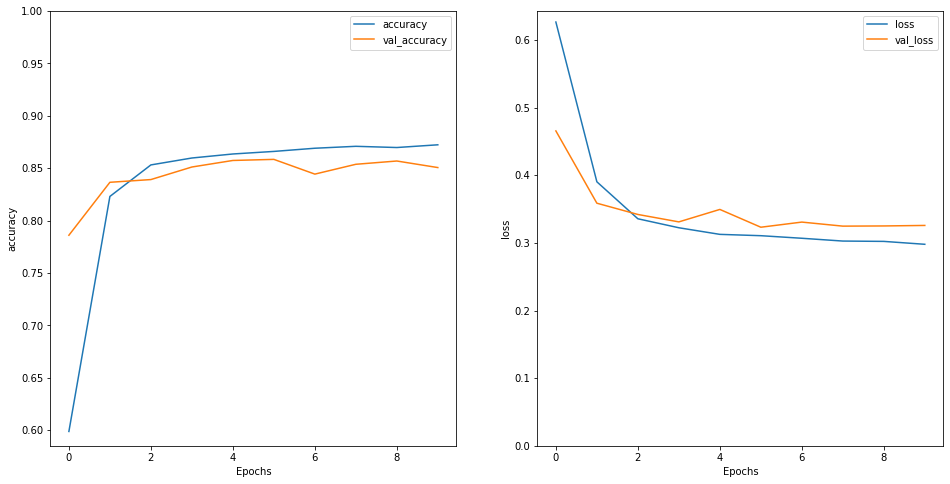

In [20]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

Run a prediction on a new sentence:

If the prediction is >= 0.0, it is positive else it is negative.

In [21]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

## Stack two or more LSTM layers

Keras recurrent layers have two available modes that are controlled by the `return_sequences` constructor argument:

* If `False` it returns only the last output for each input sequence (a 2D tensor of shape (batch_size, output_features)). This is the default, used in the previous model.

* If `True` the full sequences of successive outputs for each timestep is returned (a 3D tensor of shape `(batch_size, timesteps, output_features)`).

Here is what the flow of information looks like with `return_sequences=True`:

![layered_bidirectional](images/layered_bidirectional.png)

The interesting thing about using an `RNN` with `return_sequences=True` is that the output still has 3-axes, like the input, so it can be passed to another RNN layer, like this:

In [22]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [23]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [24]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10


  1/391 [..............................] - ETA: 1:20:23 - loss: 0.6930 - accuracy: 0.5312

  2/391 [..............................] - ETA: 53s - loss: 0.6925 - accuracy: 0.5234    

  3/391 [..............................] - ETA: 50s - loss: 0.6926 - accuracy: 0.4948

  4/391 [..............................] - ETA: 45s - loss: 0.6929 - accuracy: 0.4570

  5/391 [..............................] - ETA: 46s - loss: 0.6930 - accuracy: 0.4563

  6/391 [..............................] - ETA: 45s - loss: 0.6930 - accuracy: 0.4688

  7/391 [..............................] - ETA: 44s - loss: 0.6930 - accuracy: 0.4799

  8/391 [..............................] - ETA: 43s - loss: 0.6930 - accuracy: 0.4805

  9/391 [..............................] - ETA: 45s - loss: 0.6930 - accuracy: 0.4896

 10/391 [..............................] - ETA: 45s - loss: 0.6930 - accuracy: 0.4953

 11/391 [..............................] - ETA: 45s - loss: 0.6931 - accuracy: 0.4915

 12/391 [..............................] - ETA: 46s - loss: 0.6931 - accuracy: 0.4961

 13/391 [..............................] - ETA: 46s - loss: 0.6931 - accuracy: 0.5024

 14/391 [>.............................] - ETA: 46s - loss: 0.6930 - accuracy: 0.4967

 15/391 [>.............................] - ETA: 46s - loss: 0.6930 - accuracy: 0.4969

 16/391 [>.............................] - ETA: 46s - loss: 0.6930 - accuracy: 0.5098

 17/391 [>.............................] - ETA: 46s - loss: 0.6930 - accuracy: 0.5165

 18/391 [>.............................] - ETA: 46s - loss: 0.6930 - accuracy: 0.5139

 19/391 [>.............................] - ETA: 46s - loss: 0.6930 - accuracy: 0.5107

 20/391 [>.............................] - ETA: 46s - loss: 0.6930 - accuracy: 0.5133

 21/391 [>.............................] - ETA: 46s - loss: 0.6930 - accuracy: 0.5164

 22/391 [>.............................] - ETA: 46s - loss: 0.6930 - accuracy: 0.5114

 23/391 [>.............................] - ETA: 45s - loss: 0.6930 - accuracy: 0.5095

 24/391 [>.............................] - ETA: 45s - loss: 0.6930 - accuracy: 0.5098

 25/391 [>.............................] - ETA: 45s - loss: 0.6930 - accuracy: 0.5100

 26/391 [>.............................] - ETA: 45s - loss: 0.6930 - accuracy: 0.5072

 27/391 [=>............................] - ETA: 46s - loss: 0.6930 - accuracy: 0.5035

 28/391 [=>............................] - ETA: 45s - loss: 0.6931 - accuracy: 0.5011

 29/391 [=>............................] - ETA: 45s - loss: 0.6931 - accuracy: 0.5022

 30/391 [=>............................] - ETA: 45s - loss: 0.6931 - accuracy: 0.5036

 31/391 [=>............................] - ETA: 45s - loss: 0.6931 - accuracy: 0.5035

 32/391 [=>............................] - ETA: 45s - loss: 0.6931 - accuracy: 0.5000

 33/391 [=>............................] - ETA: 45s - loss: 0.6931 - accuracy: 0.5014

 34/391 [=>............................] - ETA: 44s - loss: 0.6931 - accuracy: 0.5018

 35/391 [=>............................] - ETA: 44s - loss: 0.6931 - accuracy: 0.5000

 36/391 [=>............................] - ETA: 44s - loss: 0.6931 - accuracy: 0.4974

 37/391 [=>............................] - ETA: 44s - loss: 0.6931 - accuracy: 0.4970

 38/391 [=>............................] - ETA: 44s - loss: 0.6931 - accuracy: 0.4988

 39/391 [=>............................] - ETA: 44s - loss: 0.6931 - accuracy: 0.4984

 40/391 [==>...........................] - ETA: 44s - loss: 0.6931 - accuracy: 0.4984

 41/391 [==>...........................] - ETA: 43s - loss: 0.6931 - accuracy: 0.4985

 42/391 [==>...........................] - ETA: 43s - loss: 0.6931 - accuracy: 0.4981

 43/391 [==>...........................] - ETA: 43s - loss: 0.6931 - accuracy: 0.4982

 44/391 [==>...........................] - ETA: 43s - loss: 0.6931 - accuracy: 0.4982

 45/391 [==>...........................] - ETA: 44s - loss: 0.6931 - accuracy: 0.4976

 46/391 [==>...........................] - ETA: 44s - loss: 0.6931 - accuracy: 0.4973

 47/391 [==>...........................] - ETA: 44s - loss: 0.6931 - accuracy: 0.4993

 48/391 [==>...........................] - ETA: 44s - loss: 0.6931 - accuracy: 0.5003

 49/391 [==>...........................] - ETA: 44s - loss: 0.6931 - accuracy: 0.5003

 50/391 [==>...........................] - ETA: 43s - loss: 0.6931 - accuracy: 0.5000

 51/391 [==>...........................] - ETA: 43s - loss: 0.6931 - accuracy: 0.5003

 52/391 [==>...........................] - ETA: 43s - loss: 0.6931 - accuracy: 0.5015

 53/391 [===>..........................] - ETA: 43s - loss: 0.6931 - accuracy: 0.5012

 54/391 [===>..........................] - ETA: 42s - loss: 0.6931 - accuracy: 0.5017

 55/391 [===>..........................] - ETA: 42s - loss: 0.6931 - accuracy: 0.5014

 56/391 [===>..........................] - ETA: 42s - loss: 0.6931 - accuracy: 0.5020

 57/391 [===>..........................] - ETA: 42s - loss: 0.6931 - accuracy: 0.5011

 58/391 [===>..........................] - ETA: 42s - loss: 0.6931 - accuracy: 0.5024

 59/391 [===>..........................] - ETA: 42s - loss: 0.6931 - accuracy: 0.5019

 60/391 [===>..........................] - ETA: 41s - loss: 0.6931 - accuracy: 0.5005

 61/391 [===>..........................] - ETA: 41s - loss: 0.6930 - accuracy: 0.5005

 62/391 [===>..........................] - ETA: 41s - loss: 0.6930 - accuracy: 0.5008

 63/391 [===>..........................] - ETA: 41s - loss: 0.6930 - accuracy: 0.5007

 64/391 [===>..........................] - ETA: 41s - loss: 0.6930 - accuracy: 0.5005

 65/391 [===>..........................] - ETA: 41s - loss: 0.6930 - accuracy: 0.5007

 66/391 [====>.........................] - ETA: 41s - loss: 0.6930 - accuracy: 0.5012

 67/391 [====>.........................] - ETA: 41s - loss: 0.6930 - accuracy: 0.5002

 68/391 [====>.........................] - ETA: 41s - loss: 0.6930 - accuracy: 0.4995

 69/391 [====>.........................] - ETA: 40s - loss: 0.6930 - accuracy: 0.4995

 70/391 [====>.........................] - ETA: 40s - loss: 0.6930 - accuracy: 0.5000

 71/391 [====>.........................] - ETA: 40s - loss: 0.6930 - accuracy: 0.4982

 72/391 [====>.........................] - ETA: 40s - loss: 0.6930 - accuracy: 0.4976

 73/391 [====>.........................] - ETA: 40s - loss: 0.6930 - accuracy: 0.4972

 74/391 [====>.........................] - ETA: 40s - loss: 0.6930 - accuracy: 0.4973

 75/391 [====>.........................] - ETA: 40s - loss: 0.6930 - accuracy: 0.4975

 76/391 [====>.........................] - ETA: 39s - loss: 0.6930 - accuracy: 0.4969

 77/391 [====>.........................] - ETA: 39s - loss: 0.6930 - accuracy: 0.4963

 78/391 [====>.........................] - ETA: 39s - loss: 0.6930 - accuracy: 0.4970

 79/391 [=====>........................] - ETA: 39s - loss: 0.6930 - accuracy: 0.4968

 80/391 [=====>........................] - ETA: 39s - loss: 0.6930 - accuracy: 0.4980

 81/391 [=====>........................] - ETA: 39s - loss: 0.6930 - accuracy: 0.4981

 82/391 [=====>........................] - ETA: 39s - loss: 0.6930 - accuracy: 0.4981

 83/391 [=====>........................] - ETA: 39s - loss: 0.6929 - accuracy: 0.4977

 84/391 [=====>........................] - ETA: 38s - loss: 0.6929 - accuracy: 0.4985

 85/391 [=====>........................] - ETA: 38s - loss: 0.6929 - accuracy: 0.4991

 86/391 [=====>........................] - ETA: 38s - loss: 0.6930 - accuracy: 0.5002

 87/391 [=====>........................] - ETA: 38s - loss: 0.6930 - accuracy: 0.5007

 88/391 [=====>........................] - ETA: 38s - loss: 0.6929 - accuracy: 0.4993

 89/391 [=====>........................] - ETA: 38s - loss: 0.6929 - accuracy: 0.4995

 90/391 [=====>........................] - ETA: 38s - loss: 0.6929 - accuracy: 0.4998

 91/391 [=====>........................] - ETA: 38s - loss: 0.6929 - accuracy: 0.5002

 92/391 [======>.......................] - ETA: 38s - loss: 0.6930 - accuracy: 0.4997

 93/391 [======>.......................] - ETA: 38s - loss: 0.6929 - accuracy: 0.4985

 94/391 [======>.......................] - ETA: 38s - loss: 0.6929 - accuracy: 0.4988

 95/391 [======>.......................] - ETA: 38s - loss: 0.6929 - accuracy: 0.4992

 96/391 [======>.......................] - ETA: 37s - loss: 0.6929 - accuracy: 0.4990

 97/391 [======>.......................] - ETA: 37s - loss: 0.6929 - accuracy: 0.4984

 98/391 [======>.......................] - ETA: 37s - loss: 0.6929 - accuracy: 0.4984

 99/391 [======>.......................] - ETA: 37s - loss: 0.6929 - accuracy: 0.4983

100/391 [======>.......................] - ETA: 37s - loss: 0.6929 - accuracy: 0.4975

101/391 [======>.......................] - ETA: 37s - loss: 0.6929 - accuracy: 0.4977

102/391 [======>.......................] - ETA: 37s - loss: 0.6929 - accuracy: 0.4977

103/391 [======>.......................] - ETA: 37s - loss: 0.6929 - accuracy: 0.4989

104/391 [======>.......................] - ETA: 36s - loss: 0.6929 - accuracy: 0.4995

105/391 [=======>......................] - ETA: 36s - loss: 0.6929 - accuracy: 0.5001

106/391 [=======>......................] - ETA: 36s - loss: 0.6929 - accuracy: 0.5000

107/391 [=======>......................] - ETA: 36s - loss: 0.6929 - accuracy: 0.4999

108/391 [=======>......................] - ETA: 36s - loss: 0.6929 - accuracy: 0.5006

109/391 [=======>......................] - ETA: 36s - loss: 0.6929 - accuracy: 0.5007

110/391 [=======>......................] - ETA: 36s - loss: 0.6929 - accuracy: 0.4999

111/391 [=======>......................] - ETA: 36s - loss: 0.6929 - accuracy: 0.5003

112/391 [=======>......................] - ETA: 35s - loss: 0.6929 - accuracy: 0.5003

113/391 [=======>......................] - ETA: 35s - loss: 0.6929 - accuracy: 0.4989

114/391 [=======>......................] - ETA: 35s - loss: 0.6929 - accuracy: 0.4984

115/391 [=======>......................] - ETA: 35s - loss: 0.6929 - accuracy: 0.4995

116/391 [=======>......................] - ETA: 35s - loss: 0.6929 - accuracy: 0.5004

117/391 [=======>......................] - ETA: 35s - loss: 0.6929 - accuracy: 0.5005

118/391 [========>.....................] - ETA: 34s - loss: 0.6929 - accuracy: 0.5001

119/391 [========>.....................] - ETA: 34s - loss: 0.6929 - accuracy: 0.5003

120/391 [========>.....................] - ETA: 34s - loss: 0.6929 - accuracy: 0.4996

121/391 [========>.....................] - ETA: 34s - loss: 0.6929 - accuracy: 0.5001

122/391 [========>.....................] - ETA: 34s - loss: 0.6929 - accuracy: 0.5009

123/391 [========>.....................] - ETA: 34s - loss: 0.6929 - accuracy: 0.5011

124/391 [========>.....................] - ETA: 34s - loss: 0.6929 - accuracy: 0.5011

125/391 [========>.....................] - ETA: 34s - loss: 0.6929 - accuracy: 0.5010

126/391 [========>.....................] - ETA: 33s - loss: 0.6928 - accuracy: 0.5017

127/391 [========>.....................] - ETA: 33s - loss: 0.6928 - accuracy: 0.5012

128/391 [========>.....................] - ETA: 33s - loss: 0.6928 - accuracy: 0.5015

129/391 [========>.....................] - ETA: 33s - loss: 0.6928 - accuracy: 0.5011

130/391 [========>.....................] - ETA: 33s - loss: 0.6928 - accuracy: 0.5011

131/391 [=========>....................] - ETA: 33s - loss: 0.6928 - accuracy: 0.5008

132/391 [=========>....................] - ETA: 33s - loss: 0.6928 - accuracy: 0.5007

133/391 [=========>....................] - ETA: 32s - loss: 0.6928 - accuracy: 0.5001

134/391 [=========>....................] - ETA: 32s - loss: 0.6928 - accuracy: 0.4994

135/391 [=========>....................] - ETA: 32s - loss: 0.6928 - accuracy: 0.4998

136/391 [=========>....................] - ETA: 32s - loss: 0.6928 - accuracy: 0.4994

137/391 [=========>....................] - ETA: 32s - loss: 0.6928 - accuracy: 0.4994

138/391 [=========>....................] - ETA: 32s - loss: 0.6928 - accuracy: 0.4999

139/391 [=========>....................] - ETA: 32s - loss: 0.6928 - accuracy: 0.4997

140/391 [=========>....................] - ETA: 32s - loss: 0.6927 - accuracy: 0.4996

141/391 [=========>....................] - ETA: 32s - loss: 0.6927 - accuracy: 0.4994

142/391 [=========>....................] - ETA: 31s - loss: 0.6927 - accuracy: 0.4992

143/391 [=========>....................] - ETA: 31s - loss: 0.6927 - accuracy: 0.4991

144/391 [==========>...................] - ETA: 31s - loss: 0.6927 - accuracy: 0.4990

145/391 [==========>...................] - ETA: 31s - loss: 0.6927 - accuracy: 0.4996

146/391 [==========>...................] - ETA: 31s - loss: 0.6927 - accuracy: 0.4997

147/391 [==========>...................] - ETA: 31s - loss: 0.6927 - accuracy: 0.4996

148/391 [==========>...................] - ETA: 31s - loss: 0.6927 - accuracy: 0.4998

149/391 [==========>...................] - ETA: 31s - loss: 0.6927 - accuracy: 0.5003

150/391 [==========>...................] - ETA: 30s - loss: 0.6927 - accuracy: 0.5008

151/391 [==========>...................] - ETA: 30s - loss: 0.6927 - accuracy: 0.5005

152/391 [==========>...................] - ETA: 30s - loss: 0.6927 - accuracy: 0.5007

153/391 [==========>...................] - ETA: 30s - loss: 0.6927 - accuracy: 0.5008

154/391 [==========>...................] - ETA: 30s - loss: 0.6926 - accuracy: 0.5012

155/391 [==========>...................] - ETA: 30s - loss: 0.6926 - accuracy: 0.5009

156/391 [==========>...................] - ETA: 30s - loss: 0.6926 - accuracy: 0.5006

157/391 [===========>..................] - ETA: 29s - loss: 0.6926 - accuracy: 0.5002

158/391 [===========>..................] - ETA: 29s - loss: 0.6926 - accuracy: 0.5004

159/391 [===========>..................] - ETA: 29s - loss: 0.6926 - accuracy: 0.5014

160/391 [===========>..................] - ETA: 29s - loss: 0.6926 - accuracy: 0.5010

161/391 [===========>..................] - ETA: 29s - loss: 0.6926 - accuracy: 0.5011

162/391 [===========>..................] - ETA: 29s - loss: 0.6926 - accuracy: 0.5016

163/391 [===========>..................] - ETA: 29s - loss: 0.6926 - accuracy: 0.5015

164/391 [===========>..................] - ETA: 29s - loss: 0.6926 - accuracy: 0.5022

165/391 [===========>..................] - ETA: 28s - loss: 0.6925 - accuracy: 0.5018

166/391 [===========>..................] - ETA: 28s - loss: 0.6925 - accuracy: 0.5016

167/391 [===========>..................] - ETA: 28s - loss: 0.6925 - accuracy: 0.5019

168/391 [===========>..................] - ETA: 28s - loss: 0.6925 - accuracy: 0.5017

169/391 [===========>..................] - ETA: 28s - loss: 0.6925 - accuracy: 0.5018

170/391 [============>.................] - ETA: 28s - loss: 0.6925 - accuracy: 0.5017

171/391 [============>.................] - ETA: 28s - loss: 0.6924 - accuracy: 0.5018

172/391 [============>.................] - ETA: 27s - loss: 0.6924 - accuracy: 0.5013

173/391 [============>.................] - ETA: 27s - loss: 0.6924 - accuracy: 0.5014

174/391 [============>.................] - ETA: 27s - loss: 0.6924 - accuracy: 0.5018

175/391 [============>.................] - ETA: 27s - loss: 0.6924 - accuracy: 0.5008

176/391 [============>.................] - ETA: 27s - loss: 0.6924 - accuracy: 0.5008

177/391 [============>.................] - ETA: 27s - loss: 0.6924 - accuracy: 0.5004

178/391 [============>.................] - ETA: 27s - loss: 0.6924 - accuracy: 0.5005

179/391 [============>.................] - ETA: 26s - loss: 0.6924 - accuracy: 0.5007

180/391 [============>.................] - ETA: 26s - loss: 0.6924 - accuracy: 0.5007

181/391 [============>.................] - ETA: 26s - loss: 0.6924 - accuracy: 0.5002

182/391 [============>.................] - ETA: 26s - loss: 0.6924 - accuracy: 0.5000

183/391 [=============>................] - ETA: 26s - loss: 0.6924 - accuracy: 0.4998

184/391 [=============>................] - ETA: 26s - loss: 0.6924 - accuracy: 0.5004

185/391 [=============>................] - ETA: 26s - loss: 0.6923 - accuracy: 0.5008

186/391 [=============>................] - ETA: 26s - loss: 0.6923 - accuracy: 0.5008

187/391 [=============>................] - ETA: 25s - loss: 0.6923 - accuracy: 0.5008

188/391 [=============>................] - ETA: 25s - loss: 0.6923 - accuracy: 0.5012

189/391 [=============>................] - ETA: 25s - loss: 0.6923 - accuracy: 0.5017

190/391 [=============>................] - ETA: 25s - loss: 0.6922 - accuracy: 0.5016

191/391 [=============>................] - ETA: 25s - loss: 0.6922 - accuracy: 0.5023

192/391 [=============>................] - ETA: 25s - loss: 0.6923 - accuracy: 0.5022

193/391 [=============>................] - ETA: 25s - loss: 0.6922 - accuracy: 0.5019

194/391 [=============>................] - ETA: 25s - loss: 0.6922 - accuracy: 0.5015

195/391 [=============>................] - ETA: 24s - loss: 0.6921 - accuracy: 0.5016

196/391 [==============>...............] - ETA: 24s - loss: 0.6921 - accuracy: 0.5016

197/391 [==============>...............] - ETA: 24s - loss: 0.6921 - accuracy: 0.5016

198/391 [==============>...............] - ETA: 24s - loss: 0.6921 - accuracy: 0.5013

199/391 [==============>...............] - ETA: 24s - loss: 0.6921 - accuracy: 0.5013

200/391 [==============>...............] - ETA: 24s - loss: 0.6920 - accuracy: 0.5012

201/391 [==============>...............] - ETA: 24s - loss: 0.6920 - accuracy: 0.5008

202/391 [==============>...............] - ETA: 24s - loss: 0.6920 - accuracy: 0.5004

203/391 [==============>...............] - ETA: 24s - loss: 0.6920 - accuracy: 0.5003

204/391 [==============>...............] - ETA: 23s - loss: 0.6920 - accuracy: 0.5006

205/391 [==============>...............] - ETA: 23s - loss: 0.6920 - accuracy: 0.5008

206/391 [==============>...............] - ETA: 23s - loss: 0.6919 - accuracy: 0.5005

207/391 [==============>...............] - ETA: 23s - loss: 0.6919 - accuracy: 0.5003

208/391 [==============>...............] - ETA: 23s - loss: 0.6918 - accuracy: 0.5008

209/391 [===============>..............] - ETA: 23s - loss: 0.6918 - accuracy: 0.5007

210/391 [===============>..............] - ETA: 23s - loss: 0.6918 - accuracy: 0.5006

211/391 [===============>..............] - ETA: 22s - loss: 0.6918 - accuracy: 0.5006

212/391 [===============>..............] - ETA: 22s - loss: 0.6918 - accuracy: 0.5010

213/391 [===============>..............] - ETA: 22s - loss: 0.6917 - accuracy: 0.5009

214/391 [===============>..............] - ETA: 22s - loss: 0.6917 - accuracy: 0.5004

215/391 [===============>..............] - ETA: 22s - loss: 0.6917 - accuracy: 0.5008

216/391 [===============>..............] - ETA: 22s - loss: 0.6916 - accuracy: 0.5009

217/391 [===============>..............] - ETA: 22s - loss: 0.6915 - accuracy: 0.5011

218/391 [===============>..............] - ETA: 22s - loss: 0.6915 - accuracy: 0.5008

219/391 [===============>..............] - ETA: 21s - loss: 0.6915 - accuracy: 0.5009

220/391 [===============>..............] - ETA: 21s - loss: 0.6914 - accuracy: 0.5004

221/391 [===============>..............] - ETA: 21s - loss: 0.6913 - accuracy: 0.5006

222/391 [================>.............] - ETA: 21s - loss: 0.6913 - accuracy: 0.5005

223/391 [================>.............] - ETA: 21s - loss: 0.6912 - accuracy: 0.5002

224/391 [================>.............] - ETA: 21s - loss: 0.6912 - accuracy: 0.5003

225/391 [================>.............] - ETA: 21s - loss: 0.6911 - accuracy: 0.5000

226/391 [================>.............] - ETA: 20s - loss: 0.6910 - accuracy: 0.5000

227/391 [================>.............] - ETA: 20s - loss: 0.6910 - accuracy: 0.5003

228/391 [================>.............] - ETA: 20s - loss: 0.6909 - accuracy: 0.4995

229/391 [================>.............] - ETA: 20s - loss: 0.6908 - accuracy: 0.4992

230/391 [================>.............] - ETA: 20s - loss: 0.6908 - accuracy: 0.4993

231/391 [================>.............] - ETA: 20s - loss: 0.6905 - accuracy: 0.4991

232/391 [================>.............] - ETA: 20s - loss: 0.6904 - accuracy: 0.4992

233/391 [================>.............] - ETA: 20s - loss: 0.6903 - accuracy: 0.4993

234/391 [================>.............] - ETA: 20s - loss: 0.6901 - accuracy: 0.4995

235/391 [=================>............] - ETA: 19s - loss: 0.6900 - accuracy: 0.4994

236/391 [=================>............] - ETA: 19s - loss: 0.6897 - accuracy: 0.4993

237/391 [=================>............] - ETA: 19s - loss: 0.6895 - accuracy: 0.4993

238/391 [=================>............] - ETA: 19s - loss: 0.6893 - accuracy: 0.4995

239/391 [=================>............] - ETA: 19s - loss: 0.6888 - accuracy: 0.5003

240/391 [=================>............] - ETA: 19s - loss: 0.6887 - accuracy: 0.5007

241/391 [=================>............] - ETA: 19s - loss: 0.6883 - accuracy: 0.5011

242/391 [=================>............] - ETA: 18s - loss: 0.6880 - accuracy: 0.5017

243/391 [=================>............] - ETA: 18s - loss: 0.6878 - accuracy: 0.5017

244/391 [=================>............] - ETA: 18s - loss: 0.6875 - accuracy: 0.5023

245/391 [=================>............] - ETA: 18s - loss: 0.6874 - accuracy: 0.5029

246/391 [=================>............] - ETA: 18s - loss: 0.6873 - accuracy: 0.5035

247/391 [=================>............] - ETA: 18s - loss: 0.6872 - accuracy: 0.5041

248/391 [==================>...........] - ETA: 18s - loss: 0.6874 - accuracy: 0.5046

249/391 [==================>...........] - ETA: 18s - loss: 0.6873 - accuracy: 0.5052

250/391 [==================>...........] - ETA: 17s - loss: 0.6873 - accuracy: 0.5056

251/391 [==================>...........] - ETA: 17s - loss: 0.6877 - accuracy: 0.5054

252/391 [==================>...........] - ETA: 17s - loss: 0.6878 - accuracy: 0.5058

253/391 [==================>...........] - ETA: 17s - loss: 0.6877 - accuracy: 0.5064

254/391 [==================>...........] - ETA: 17s - loss: 0.6875 - accuracy: 0.5071

255/391 [==================>...........] - ETA: 17s - loss: 0.6874 - accuracy: 0.5074

256/391 [==================>...........] - ETA: 17s - loss: 0.6872 - accuracy: 0.5079

257/391 [==================>...........] - ETA: 17s - loss: 0.6874 - accuracy: 0.5081

258/391 [==================>...........] - ETA: 17s - loss: 0.6873 - accuracy: 0.5082

259/391 [==================>...........] - ETA: 16s - loss: 0.6871 - accuracy: 0.5085

260/391 [==================>...........] - ETA: 16s - loss: 0.6870 - accuracy: 0.5085

261/391 [===================>..........] - ETA: 16s - loss: 0.6870 - accuracy: 0.5089

262/391 [===================>..........] - ETA: 16s - loss: 0.6867 - accuracy: 0.5091

263/391 [===================>..........] - ETA: 16s - loss: 0.6864 - accuracy: 0.5096

264/391 [===================>..........] - ETA: 16s - loss: 0.6861 - accuracy: 0.5095

265/391 [===================>..........] - ETA: 16s - loss: 0.6857 - accuracy: 0.5098

266/391 [===================>..........] - ETA: 15s - loss: 0.6853 - accuracy: 0.5106

267/391 [===================>..........] - ETA: 15s - loss: 0.6852 - accuracy: 0.5104

268/391 [===================>..........] - ETA: 15s - loss: 0.6848 - accuracy: 0.5104

269/391 [===================>..........] - ETA: 15s - loss: 0.6844 - accuracy: 0.5105

270/391 [===================>..........] - ETA: 15s - loss: 0.6841 - accuracy: 0.5107

271/391 [===================>..........] - ETA: 15s - loss: 0.6839 - accuracy: 0.5106

272/391 [===================>..........] - ETA: 15s - loss: 0.6836 - accuracy: 0.5106

273/391 [===================>..........] - ETA: 15s - loss: 0.6833 - accuracy: 0.5108

274/391 [====================>.........] - ETA: 14s - loss: 0.6831 - accuracy: 0.5106

275/391 [====================>.........] - ETA: 14s - loss: 0.6829 - accuracy: 0.5107

276/391 [====================>.........] - ETA: 14s - loss: 0.6823 - accuracy: 0.5110

277/391 [====================>.........] - ETA: 14s - loss: 0.6819 - accuracy: 0.5114

278/391 [====================>.........] - ETA: 14s - loss: 0.6817 - accuracy: 0.5115

279/391 [====================>.........] - ETA: 14s - loss: 0.6813 - accuracy: 0.5117

280/391 [====================>.........] - ETA: 14s - loss: 0.6810 - accuracy: 0.5119

281/391 [====================>.........] - ETA: 14s - loss: 0.6809 - accuracy: 0.5121

282/391 [====================>.........] - ETA: 13s - loss: 0.6809 - accuracy: 0.5125

283/391 [====================>.........] - ETA: 13s - loss: 0.6806 - accuracy: 0.5127

284/391 [====================>.........] - ETA: 13s - loss: 0.6802 - accuracy: 0.5131

285/391 [====================>.........] - ETA: 13s - loss: 0.6802 - accuracy: 0.5131

286/391 [====================>.........] - ETA: 13s - loss: 0.6798 - accuracy: 0.5132

287/391 [=====================>........] - ETA: 13s - loss: 0.6794 - accuracy: 0.5134

288/391 [=====================>........] - ETA: 13s - loss: 0.6788 - accuracy: 0.5139

289/391 [=====================>........] - ETA: 13s - loss: 0.6781 - accuracy: 0.5147

290/391 [=====================>........] - ETA: 12s - loss: 0.6779 - accuracy: 0.5149

291/391 [=====================>........] - ETA: 12s - loss: 0.6776 - accuracy: 0.5152

292/391 [=====================>........] - ETA: 12s - loss: 0.6774 - accuracy: 0.5155

293/391 [=====================>........] - ETA: 12s - loss: 0.6774 - accuracy: 0.5156

294/391 [=====================>........] - ETA: 12s - loss: 0.6771 - accuracy: 0.5159

295/391 [=====================>........] - ETA: 12s - loss: 0.6766 - accuracy: 0.5161

296/391 [=====================>........] - ETA: 12s - loss: 0.6764 - accuracy: 0.5164

297/391 [=====================>........] - ETA: 12s - loss: 0.6761 - accuracy: 0.5169

298/391 [=====================>........] - ETA: 11s - loss: 0.6760 - accuracy: 0.5169

299/391 [=====================>........] - ETA: 11s - loss: 0.6759 - accuracy: 0.5171

300/391 [======================>.......] - ETA: 11s - loss: 0.6757 - accuracy: 0.5174

301/391 [======================>.......] - ETA: 11s - loss: 0.6754 - accuracy: 0.5179

302/391 [======================>.......] - ETA: 11s - loss: 0.6753 - accuracy: 0.5182

303/391 [======================>.......] - ETA: 11s - loss: 0.6748 - accuracy: 0.5184

304/391 [======================>.......] - ETA: 11s - loss: 0.6743 - accuracy: 0.5187

305/391 [======================>.......] - ETA: 10s - loss: 0.6738 - accuracy: 0.5191

306/391 [======================>.......] - ETA: 10s - loss: 0.6737 - accuracy: 0.5193

307/391 [======================>.......] - ETA: 10s - loss: 0.6732 - accuracy: 0.5195

308/391 [======================>.......] - ETA: 10s - loss: 0.6728 - accuracy: 0.5201

309/391 [======================>.......] - ETA: 10s - loss: 0.6723 - accuracy: 0.5205

310/391 [======================>.......] - ETA: 10s - loss: 0.6718 - accuracy: 0.5210

311/391 [======================>.......] - ETA: 10s - loss: 0.6716 - accuracy: 0.5213

312/391 [======================>.......] - ETA: 10s - loss: 0.6712 - accuracy: 0.5217

313/391 [=======================>......] - ETA: 9s - loss: 0.6709 - accuracy: 0.5223 

314/391 [=======================>......] - ETA: 9s - loss: 0.6706 - accuracy: 0.5226

315/391 [=======================>......] - ETA: 9s - loss: 0.6703 - accuracy: 0.5232

316/391 [=======================>......] - ETA: 9s - loss: 0.6701 - accuracy: 0.5233

317/391 [=======================>......] - ETA: 9s - loss: 0.6695 - accuracy: 0.5239

318/391 [=======================>......] - ETA: 9s - loss: 0.6693 - accuracy: 0.5245

319/391 [=======================>......] - ETA: 9s - loss: 0.6691 - accuracy: 0.5248

320/391 [=======================>......] - ETA: 9s - loss: 0.6686 - accuracy: 0.5254

321/391 [=======================>......] - ETA: 8s - loss: 0.6678 - accuracy: 0.5264

322/391 [=======================>......] - ETA: 8s - loss: 0.6674 - accuracy: 0.5268

323/391 [=======================>......] - ETA: 8s - loss: 0.6669 - accuracy: 0.5275

324/391 [=======================>......] - ETA: 8s - loss: 0.6667 - accuracy: 0.5279

325/391 [=======================>......] - ETA: 8s - loss: 0.6660 - accuracy: 0.5289

326/391 [========================>.....] - ETA: 8s - loss: 0.6656 - accuracy: 0.5296

327/391 [========================>.....] - ETA: 8s - loss: 0.6652 - accuracy: 0.5301

328/391 [========================>.....] - ETA: 8s - loss: 0.6651 - accuracy: 0.5302

329/391 [========================>.....] - ETA: 7s - loss: 0.6648 - accuracy: 0.5304

330/391 [========================>.....] - ETA: 7s - loss: 0.6642 - accuracy: 0.5311

331/391 [========================>.....] - ETA: 7s - loss: 0.6638 - accuracy: 0.5315

332/391 [========================>.....] - ETA: 7s - loss: 0.6633 - accuracy: 0.5321

333/391 [========================>.....] - ETA: 7s - loss: 0.6630 - accuracy: 0.5327

334/391 [========================>.....] - ETA: 7s - loss: 0.6624 - accuracy: 0.5334

335/391 [========================>.....] - ETA: 7s - loss: 0.6620 - accuracy: 0.5338

336/391 [========================>.....] - ETA: 7s - loss: 0.6614 - accuracy: 0.5344

337/391 [========================>.....] - ETA: 6s - loss: 0.6610 - accuracy: 0.5351

338/391 [========================>.....] - ETA: 6s - loss: 0.6606 - accuracy: 0.5358

339/391 [=========================>....] - ETA: 6s - loss: 0.6603 - accuracy: 0.5361

340/391 [=========================>....] - ETA: 6s - loss: 0.6599 - accuracy: 0.5367

341/391 [=========================>....] - ETA: 6s - loss: 0.6595 - accuracy: 0.5373

342/391 [=========================>....] - ETA: 6s - loss: 0.6589 - accuracy: 0.5382

343/391 [=========================>....] - ETA: 6s - loss: 0.6585 - accuracy: 0.5387

344/391 [=========================>....] - ETA: 6s - loss: 0.6581 - accuracy: 0.5393

345/391 [=========================>....] - ETA: 5s - loss: 0.6577 - accuracy: 0.5399

346/391 [=========================>....] - ETA: 5s - loss: 0.6573 - accuracy: 0.5404

347/391 [=========================>....] - ETA: 5s - loss: 0.6571 - accuracy: 0.5407

348/391 [=========================>....] - ETA: 5s - loss: 0.6571 - accuracy: 0.5408

349/391 [=========================>....] - ETA: 5s - loss: 0.6565 - accuracy: 0.5414

350/391 [=========================>....] - ETA: 5s - loss: 0.6562 - accuracy: 0.5418

351/391 [=========================>....] - ETA: 5s - loss: 0.6556 - accuracy: 0.5426

352/391 [==========================>...] - ETA: 5s - loss: 0.6550 - accuracy: 0.5433

353/391 [==========================>...] - ETA: 4s - loss: 0.6545 - accuracy: 0.5439

354/391 [==========================>...] - ETA: 4s - loss: 0.6541 - accuracy: 0.5448

355/391 [==========================>...] - ETA: 4s - loss: 0.6532 - accuracy: 0.5458

356/391 [==========================>...] - ETA: 4s - loss: 0.6530 - accuracy: 0.5463

357/391 [==========================>...] - ETA: 4s - loss: 0.6523 - accuracy: 0.5472

358/391 [==========================>...] - ETA: 4s - loss: 0.6517 - accuracy: 0.5479

359/391 [==========================>...] - ETA: 4s - loss: 0.6511 - accuracy: 0.5487

360/391 [==========================>...] - ETA: 3s - loss: 0.6505 - accuracy: 0.5494

361/391 [==========================>...] - ETA: 3s - loss: 0.6498 - accuracy: 0.5503

362/391 [==========================>...] - ETA: 3s - loss: 0.6495 - accuracy: 0.5508

363/391 [==========================>...] - ETA: 3s - loss: 0.6491 - accuracy: 0.5514

364/391 [==========================>...] - ETA: 3s - loss: 0.6486 - accuracy: 0.5521

365/391 [===========================>..] - ETA: 3s - loss: 0.6479 - accuracy: 0.5530

366/391 [===========================>..] - ETA: 3s - loss: 0.6474 - accuracy: 0.5537

367/391 [===========================>..] - ETA: 3s - loss: 0.6471 - accuracy: 0.5544

368/391 [===========================>..] - ETA: 2s - loss: 0.6467 - accuracy: 0.5549

369/391 [===========================>..] - ETA: 2s - loss: 0.6463 - accuracy: 0.5556

370/391 [===========================>..] - ETA: 2s - loss: 0.6458 - accuracy: 0.5561

371/391 [===========================>..] - ETA: 2s - loss: 0.6456 - accuracy: 0.5565

372/391 [===========================>..] - ETA: 2s - loss: 0.6453 - accuracy: 0.5569

373/391 [===========================>..] - ETA: 2s - loss: 0.6450 - accuracy: 0.5573

374/391 [===========================>..] - ETA: 2s - loss: 0.6444 - accuracy: 0.5580

375/391 [===========================>..] - ETA: 2s - loss: 0.6440 - accuracy: 0.5585

376/391 [===========================>..] - ETA: 1s - loss: 0.6438 - accuracy: 0.5589

377/391 [===========================>..] - ETA: 1s - loss: 0.6435 - accuracy: 0.5594

378/391 [============================>.] - ETA: 1s - loss: 0.6429 - accuracy: 0.5600

379/391 [============================>.] - ETA: 1s - loss: 0.6423 - accuracy: 0.5606

380/391 [============================>.] - ETA: 1s - loss: 0.6420 - accuracy: 0.5612

381/391 [============================>.] - ETA: 1s - loss: 0.6415 - accuracy: 0.5617

382/391 [============================>.] - ETA: 1s - loss: 0.6410 - accuracy: 0.5625

383/391 [============================>.] - ETA: 1s - loss: 0.6407 - accuracy: 0.5630

384/391 [============================>.] - ETA: 0s - loss: 0.6401 - accuracy: 0.5637

385/391 [============================>.] - ETA: 0s - loss: 0.6398 - accuracy: 0.5642

386/391 [============================>.] - ETA: 0s - loss: 0.6392 - accuracy: 0.5648

387/391 [============================>.] - ETA: 0s - loss: 0.6389 - accuracy: 0.5652

388/391 [============================>.] - ETA: 0s - loss: 0.6385 - accuracy: 0.5657

389/391 [============================>.] - ETA: 0s - loss: 0.6381 - accuracy: 0.5661

390/391 [============================>.] - ETA: 0s - loss: 0.6377 - accuracy: 0.5668

391/391 [==============================] - ETA: 0s - loss: 0.6375 - accuracy: 0.5670

391/391 [==============================] - 69s 145ms/step - loss: 0.6375 - accuracy: 0.5670 - val_loss: 0.4481 - val_accuracy: 0.8021


Epoch 2/10


  1/391 [..............................] - ETA: 4:41 - loss: 0.3836 - accuracy: 0.8594

  2/391 [..............................] - ETA: 57s - loss: 0.4555 - accuracy: 0.8203 

  3/391 [..............................] - ETA: 58s - loss: 0.4496 - accuracy: 0.8177

  4/391 [..............................] - ETA: 54s - loss: 0.4630 - accuracy: 0.8086

  5/391 [..............................] - ETA: 51s - loss: 0.4688 - accuracy: 0.8125

  6/391 [..............................] - ETA: 52s - loss: 0.4598 - accuracy: 0.8307

  7/391 [..............................] - ETA: 52s - loss: 0.4532 - accuracy: 0.8326

  8/391 [..............................] - ETA: 52s - loss: 0.4539 - accuracy: 0.8340

  9/391 [..............................] - ETA: 51s - loss: 0.4590 - accuracy: 0.8281

 10/391 [..............................] - ETA: 51s - loss: 0.4613 - accuracy: 0.8203

 11/391 [..............................] - ETA: 50s - loss: 0.4670 - accuracy: 0.8139

 12/391 [..............................] - ETA: 50s - loss: 0.4669 - accuracy: 0.8138

 13/391 [..............................] - ETA: 50s - loss: 0.4681 - accuracy: 0.8089

 14/391 [>.............................] - ETA: 50s - loss: 0.4622 - accuracy: 0.8103

 15/391 [>.............................] - ETA: 49s - loss: 0.4585 - accuracy: 0.8104

 16/391 [>.............................] - ETA: 49s - loss: 0.4631 - accuracy: 0.7998

 17/391 [>.............................] - ETA: 49s - loss: 0.4605 - accuracy: 0.8015

 18/391 [>.............................] - ETA: 50s - loss: 0.4584 - accuracy: 0.8021

 19/391 [>.............................] - ETA: 50s - loss: 0.4587 - accuracy: 0.8010

 20/391 [>.............................] - ETA: 49s - loss: 0.4544 - accuracy: 0.8031

 21/391 [>.............................] - ETA: 48s - loss: 0.4597 - accuracy: 0.7999

 22/391 [>.............................] - ETA: 48s - loss: 0.4568 - accuracy: 0.8011

 23/391 [>.............................] - ETA: 48s - loss: 0.4577 - accuracy: 0.8023

 24/391 [>.............................] - ETA: 47s - loss: 0.4546 - accuracy: 0.8047

 25/391 [>.............................] - ETA: 47s - loss: 0.4534 - accuracy: 0.8050

 26/391 [>.............................] - ETA: 47s - loss: 0.4535 - accuracy: 0.8059

 27/391 [=>............................] - ETA: 46s - loss: 0.4534 - accuracy: 0.8056

 28/391 [=>............................] - ETA: 46s - loss: 0.4547 - accuracy: 0.8041

 29/391 [=>............................] - ETA: 46s - loss: 0.4567 - accuracy: 0.8028

 30/391 [=>............................] - ETA: 46s - loss: 0.4535 - accuracy: 0.8057

 31/391 [=>............................] - ETA: 46s - loss: 0.4565 - accuracy: 0.8024

 32/391 [=>............................] - ETA: 46s - loss: 0.4538 - accuracy: 0.8042

 33/391 [=>............................] - ETA: 46s - loss: 0.4531 - accuracy: 0.8045

 34/391 [=>............................] - ETA: 46s - loss: 0.4539 - accuracy: 0.8047

 35/391 [=>............................] - ETA: 46s - loss: 0.4519 - accuracy: 0.8049

 36/391 [=>............................] - ETA: 45s - loss: 0.4531 - accuracy: 0.8038

 37/391 [=>............................] - ETA: 45s - loss: 0.4499 - accuracy: 0.8053

 38/391 [=>............................] - ETA: 45s - loss: 0.4486 - accuracy: 0.8035

 39/391 [=>............................] - ETA: 45s - loss: 0.4461 - accuracy: 0.8049

 40/391 [==>...........................] - ETA: 44s - loss: 0.4477 - accuracy: 0.8039

 41/391 [==>...........................] - ETA: 44s - loss: 0.4468 - accuracy: 0.8041

 42/391 [==>...........................] - ETA: 44s - loss: 0.4453 - accuracy: 0.8039

 43/391 [==>...........................] - ETA: 44s - loss: 0.4430 - accuracy: 0.8056

 44/391 [==>...........................] - ETA: 43s - loss: 0.4426 - accuracy: 0.8058

 45/391 [==>...........................] - ETA: 43s - loss: 0.4433 - accuracy: 0.8062

 46/391 [==>...........................] - ETA: 43s - loss: 0.4434 - accuracy: 0.8064

 47/391 [==>...........................] - ETA: 43s - loss: 0.4445 - accuracy: 0.8059

 48/391 [==>...........................] - ETA: 43s - loss: 0.4475 - accuracy: 0.8053

 49/391 [==>...........................] - ETA: 43s - loss: 0.4491 - accuracy: 0.8045

 50/391 [==>...........................] - ETA: 43s - loss: 0.4475 - accuracy: 0.8062

 51/391 [==>...........................] - ETA: 43s - loss: 0.4475 - accuracy: 0.8067

 52/391 [==>...........................] - ETA: 43s - loss: 0.4462 - accuracy: 0.8077

 53/391 [===>..........................] - ETA: 43s - loss: 0.4450 - accuracy: 0.8081

 54/391 [===>..........................] - ETA: 42s - loss: 0.4453 - accuracy: 0.8079

 55/391 [===>..........................] - ETA: 42s - loss: 0.4464 - accuracy: 0.8074

 56/391 [===>..........................] - ETA: 42s - loss: 0.4453 - accuracy: 0.8069

 57/391 [===>..........................] - ETA: 42s - loss: 0.4449 - accuracy: 0.8070

 58/391 [===>..........................] - ETA: 42s - loss: 0.4436 - accuracy: 0.8074

 59/391 [===>..........................] - ETA: 42s - loss: 0.4433 - accuracy: 0.8067

 60/391 [===>..........................] - ETA: 42s - loss: 0.4444 - accuracy: 0.8047

 61/391 [===>..........................] - ETA: 42s - loss: 0.4455 - accuracy: 0.8030

 62/391 [===>..........................] - ETA: 41s - loss: 0.4470 - accuracy: 0.8022

 63/391 [===>..........................] - ETA: 41s - loss: 0.4467 - accuracy: 0.8018

 64/391 [===>..........................] - ETA: 41s - loss: 0.4475 - accuracy: 0.8008

 65/391 [===>..........................] - ETA: 41s - loss: 0.4490 - accuracy: 0.7998

 66/391 [====>.........................] - ETA: 41s - loss: 0.4489 - accuracy: 0.7997

 67/391 [====>.........................] - ETA: 41s - loss: 0.4491 - accuracy: 0.7999

 68/391 [====>.........................] - ETA: 41s - loss: 0.4486 - accuracy: 0.7994

 69/391 [====>.........................] - ETA: 41s - loss: 0.4480 - accuracy: 0.8000

 70/391 [====>.........................] - ETA: 40s - loss: 0.4479 - accuracy: 0.7998

 71/391 [====>.........................] - ETA: 40s - loss: 0.4473 - accuracy: 0.7997

 72/391 [====>.........................] - ETA: 40s - loss: 0.4466 - accuracy: 0.8010

 73/391 [====>.........................] - ETA: 40s - loss: 0.4466 - accuracy: 0.8012

 74/391 [====>.........................] - ETA: 40s - loss: 0.4463 - accuracy: 0.8013

 75/391 [====>.........................] - ETA: 40s - loss: 0.4452 - accuracy: 0.8015

 76/391 [====>.........................] - ETA: 40s - loss: 0.4449 - accuracy: 0.8016

 77/391 [====>.........................] - ETA: 40s - loss: 0.4458 - accuracy: 0.8009

 78/391 [====>.........................] - ETA: 40s - loss: 0.4453 - accuracy: 0.8005

 79/391 [=====>........................] - ETA: 39s - loss: 0.4453 - accuracy: 0.8002

 80/391 [=====>........................] - ETA: 39s - loss: 0.4460 - accuracy: 0.7996

 81/391 [=====>........................] - ETA: 39s - loss: 0.4461 - accuracy: 0.7988

 82/391 [=====>........................] - ETA: 39s - loss: 0.4460 - accuracy: 0.7978

 83/391 [=====>........................] - ETA: 39s - loss: 0.4456 - accuracy: 0.7980

 84/391 [=====>........................] - ETA: 39s - loss: 0.4453 - accuracy: 0.7987

 85/391 [=====>........................] - ETA: 39s - loss: 0.4438 - accuracy: 0.7996

 86/391 [=====>........................] - ETA: 39s - loss: 0.4423 - accuracy: 0.8007

 87/391 [=====>........................] - ETA: 38s - loss: 0.4420 - accuracy: 0.8008

 88/391 [=====>........................] - ETA: 38s - loss: 0.4419 - accuracy: 0.8011

 89/391 [=====>........................] - ETA: 38s - loss: 0.4425 - accuracy: 0.8011

 90/391 [=====>........................] - ETA: 38s - loss: 0.4437 - accuracy: 0.8000

 91/391 [=====>........................] - ETA: 38s - loss: 0.4432 - accuracy: 0.8001

 92/391 [======>.......................] - ETA: 38s - loss: 0.4426 - accuracy: 0.8008

 93/391 [======>.......................] - ETA: 38s - loss: 0.4410 - accuracy: 0.8016

 94/391 [======>.......................] - ETA: 38s - loss: 0.4401 - accuracy: 0.8027

 95/391 [======>.......................] - ETA: 37s - loss: 0.4395 - accuracy: 0.8035

 96/391 [======>.......................] - ETA: 37s - loss: 0.4396 - accuracy: 0.8037

 97/391 [======>.......................] - ETA: 37s - loss: 0.4384 - accuracy: 0.8046

 98/391 [======>.......................] - ETA: 37s - loss: 0.4386 - accuracy: 0.8047

 99/391 [======>.......................] - ETA: 37s - loss: 0.4374 - accuracy: 0.8054

100/391 [======>.......................] - ETA: 37s - loss: 0.4365 - accuracy: 0.8059

101/391 [======>.......................] - ETA: 37s - loss: 0.4368 - accuracy: 0.8055

102/391 [======>.......................] - ETA: 37s - loss: 0.4374 - accuracy: 0.8055

103/391 [======>.......................] - ETA: 37s - loss: 0.4377 - accuracy: 0.8054

104/391 [======>.......................] - ETA: 36s - loss: 0.4397 - accuracy: 0.8045

105/391 [=======>......................] - ETA: 36s - loss: 0.4405 - accuracy: 0.8042

106/391 [=======>......................] - ETA: 36s - loss: 0.4398 - accuracy: 0.8048

107/391 [=======>......................] - ETA: 36s - loss: 0.4398 - accuracy: 0.8052

108/391 [=======>......................] - ETA: 36s - loss: 0.4399 - accuracy: 0.8051

109/391 [=======>......................] - ETA: 36s - loss: 0.4390 - accuracy: 0.8058

110/391 [=======>......................] - ETA: 36s - loss: 0.4394 - accuracy: 0.8057

111/391 [=======>......................] - ETA: 36s - loss: 0.4394 - accuracy: 0.8060

112/391 [=======>......................] - ETA: 36s - loss: 0.4393 - accuracy: 0.8058

113/391 [=======>......................] - ETA: 36s - loss: 0.4377 - accuracy: 0.8070

114/391 [=======>......................] - ETA: 36s - loss: 0.4375 - accuracy: 0.8069

115/391 [=======>......................] - ETA: 35s - loss: 0.4370 - accuracy: 0.8067

116/391 [=======>......................] - ETA: 35s - loss: 0.4371 - accuracy: 0.8062

117/391 [=======>......................] - ETA: 35s - loss: 0.4376 - accuracy: 0.8053

118/391 [========>.....................] - ETA: 35s - loss: 0.4374 - accuracy: 0.8052

119/391 [========>.....................] - ETA: 35s - loss: 0.4372 - accuracy: 0.8048

120/391 [========>.....................] - ETA: 35s - loss: 0.4375 - accuracy: 0.8046

121/391 [========>.....................] - ETA: 35s - loss: 0.4377 - accuracy: 0.8041

122/391 [========>.....................] - ETA: 34s - loss: 0.4379 - accuracy: 0.8042

123/391 [========>.....................] - ETA: 34s - loss: 0.4378 - accuracy: 0.8046

124/391 [========>.....................] - ETA: 34s - loss: 0.4385 - accuracy: 0.8039

125/391 [========>.....................] - ETA: 34s - loss: 0.4394 - accuracy: 0.8035

126/391 [========>.....................] - ETA: 34s - loss: 0.4387 - accuracy: 0.8039

127/391 [========>.....................] - ETA: 34s - loss: 0.4380 - accuracy: 0.8046

128/391 [========>.....................] - ETA: 34s - loss: 0.4374 - accuracy: 0.8052

129/391 [========>.....................] - ETA: 34s - loss: 0.4373 - accuracy: 0.8052

130/391 [========>.....................] - ETA: 33s - loss: 0.4366 - accuracy: 0.8056

131/391 [=========>....................] - ETA: 33s - loss: 0.4362 - accuracy: 0.8056

132/391 [=========>....................] - ETA: 33s - loss: 0.4365 - accuracy: 0.8053

133/391 [=========>....................] - ETA: 33s - loss: 0.4368 - accuracy: 0.8047

134/391 [=========>....................] - ETA: 33s - loss: 0.4362 - accuracy: 0.8050

135/391 [=========>....................] - ETA: 33s - loss: 0.4358 - accuracy: 0.8051

136/391 [=========>....................] - ETA: 33s - loss: 0.4356 - accuracy: 0.8051

137/391 [=========>....................] - ETA: 33s - loss: 0.4347 - accuracy: 0.8058

138/391 [=========>....................] - ETA: 32s - loss: 0.4340 - accuracy: 0.8057

139/391 [=========>....................] - ETA: 32s - loss: 0.4331 - accuracy: 0.8063

140/391 [=========>....................] - ETA: 32s - loss: 0.4317 - accuracy: 0.8071

141/391 [=========>....................] - ETA: 32s - loss: 0.4323 - accuracy: 0.8071

142/391 [=========>....................] - ETA: 32s - loss: 0.4331 - accuracy: 0.8069

143/391 [=========>....................] - ETA: 32s - loss: 0.4330 - accuracy: 0.8068

144/391 [==========>...................] - ETA: 32s - loss: 0.4319 - accuracy: 0.8075

145/391 [==========>...................] - ETA: 31s - loss: 0.4312 - accuracy: 0.8079

146/391 [==========>...................] - ETA: 31s - loss: 0.4321 - accuracy: 0.8075

147/391 [==========>...................] - ETA: 31s - loss: 0.4320 - accuracy: 0.8077

148/391 [==========>...................] - ETA: 31s - loss: 0.4331 - accuracy: 0.8073

149/391 [==========>...................] - ETA: 31s - loss: 0.4336 - accuracy: 0.8067

150/391 [==========>...................] - ETA: 31s - loss: 0.4336 - accuracy: 0.8072

151/391 [==========>...................] - ETA: 31s - loss: 0.4328 - accuracy: 0.8074

152/391 [==========>...................] - ETA: 31s - loss: 0.4321 - accuracy: 0.8079

153/391 [==========>...................] - ETA: 30s - loss: 0.4316 - accuracy: 0.8081

154/391 [==========>...................] - ETA: 30s - loss: 0.4308 - accuracy: 0.8086

155/391 [==========>...................] - ETA: 30s - loss: 0.4308 - accuracy: 0.8088

156/391 [==========>...................] - ETA: 30s - loss: 0.4312 - accuracy: 0.8085

157/391 [===========>..................] - ETA: 30s - loss: 0.4314 - accuracy: 0.8084

158/391 [===========>..................] - ETA: 30s - loss: 0.4314 - accuracy: 0.8084

159/391 [===========>..................] - ETA: 30s - loss: 0.4311 - accuracy: 0.8092

160/391 [===========>..................] - ETA: 30s - loss: 0.4310 - accuracy: 0.8093

161/391 [===========>..................] - ETA: 30s - loss: 0.4311 - accuracy: 0.8092

162/391 [===========>..................] - ETA: 29s - loss: 0.4307 - accuracy: 0.8093

163/391 [===========>..................] - ETA: 29s - loss: 0.4304 - accuracy: 0.8095

164/391 [===========>..................] - ETA: 29s - loss: 0.4301 - accuracy: 0.8096

165/391 [===========>..................] - ETA: 29s - loss: 0.4299 - accuracy: 0.8097

166/391 [===========>..................] - ETA: 29s - loss: 0.4289 - accuracy: 0.8103

167/391 [===========>..................] - ETA: 29s - loss: 0.4291 - accuracy: 0.8102

168/391 [===========>..................] - ETA: 29s - loss: 0.4285 - accuracy: 0.8107

169/391 [===========>..................] - ETA: 28s - loss: 0.4286 - accuracy: 0.8108

170/391 [============>.................] - ETA: 28s - loss: 0.4289 - accuracy: 0.8108

171/391 [============>.................] - ETA: 28s - loss: 0.4292 - accuracy: 0.8106

172/391 [============>.................] - ETA: 28s - loss: 0.4285 - accuracy: 0.8113

173/391 [============>.................] - ETA: 28s - loss: 0.4278 - accuracy: 0.8119

174/391 [============>.................] - ETA: 28s - loss: 0.4273 - accuracy: 0.8122

175/391 [============>.................] - ETA: 28s - loss: 0.4275 - accuracy: 0.8121

176/391 [============>.................] - ETA: 28s - loss: 0.4271 - accuracy: 0.8121

177/391 [============>.................] - ETA: 27s - loss: 0.4268 - accuracy: 0.8121

178/391 [============>.................] - ETA: 27s - loss: 0.4261 - accuracy: 0.8125

179/391 [============>.................] - ETA: 27s - loss: 0.4257 - accuracy: 0.8124

180/391 [============>.................] - ETA: 27s - loss: 0.4258 - accuracy: 0.8122

181/391 [============>.................] - ETA: 27s - loss: 0.4260 - accuracy: 0.8122

182/391 [============>.................] - ETA: 27s - loss: 0.4260 - accuracy: 0.8121

183/391 [=============>................] - ETA: 27s - loss: 0.4258 - accuracy: 0.8121

184/391 [=============>................] - ETA: 26s - loss: 0.4260 - accuracy: 0.8123

185/391 [=============>................] - ETA: 26s - loss: 0.4271 - accuracy: 0.8120

186/391 [=============>................] - ETA: 26s - loss: 0.4263 - accuracy: 0.8126

187/391 [=============>................] - ETA: 26s - loss: 0.4264 - accuracy: 0.8125

188/391 [=============>................] - ETA: 26s - loss: 0.4262 - accuracy: 0.8126

189/391 [=============>................] - ETA: 26s - loss: 0.4258 - accuracy: 0.8129

190/391 [=============>................] - ETA: 26s - loss: 0.4256 - accuracy: 0.8133

191/391 [=============>................] - ETA: 26s - loss: 0.4253 - accuracy: 0.8136

192/391 [=============>................] - ETA: 25s - loss: 0.4254 - accuracy: 0.8137

193/391 [=============>................] - ETA: 25s - loss: 0.4250 - accuracy: 0.8141

194/391 [=============>................] - ETA: 25s - loss: 0.4249 - accuracy: 0.8143

195/391 [=============>................] - ETA: 25s - loss: 0.4249 - accuracy: 0.8144

196/391 [==============>...............] - ETA: 25s - loss: 0.4248 - accuracy: 0.8143

197/391 [==============>...............] - ETA: 25s - loss: 0.4247 - accuracy: 0.8140

198/391 [==============>...............] - ETA: 25s - loss: 0.4250 - accuracy: 0.8141

199/391 [==============>...............] - ETA: 24s - loss: 0.4252 - accuracy: 0.8140

200/391 [==============>...............] - ETA: 24s - loss: 0.4252 - accuracy: 0.8139

201/391 [==============>...............] - ETA: 24s - loss: 0.4252 - accuracy: 0.8137

202/391 [==============>...............] - ETA: 24s - loss: 0.4249 - accuracy: 0.8138

203/391 [==============>...............] - ETA: 24s - loss: 0.4246 - accuracy: 0.8140

204/391 [==============>...............] - ETA: 24s - loss: 0.4244 - accuracy: 0.8136

205/391 [==============>...............] - ETA: 24s - loss: 0.4242 - accuracy: 0.8136

206/391 [==============>...............] - ETA: 24s - loss: 0.4235 - accuracy: 0.8142

207/391 [==============>...............] - ETA: 23s - loss: 0.4236 - accuracy: 0.8140

208/391 [==============>...............] - ETA: 23s - loss: 0.4239 - accuracy: 0.8138

209/391 [===============>..............] - ETA: 23s - loss: 0.4240 - accuracy: 0.8138

210/391 [===============>..............] - ETA: 23s - loss: 0.4249 - accuracy: 0.8133

211/391 [===============>..............] - ETA: 23s - loss: 0.4242 - accuracy: 0.8135

212/391 [===============>..............] - ETA: 23s - loss: 0.4253 - accuracy: 0.8130

213/391 [===============>..............] - ETA: 23s - loss: 0.4252 - accuracy: 0.8131

214/391 [===============>..............] - ETA: 23s - loss: 0.4249 - accuracy: 0.8134

215/391 [===============>..............] - ETA: 22s - loss: 0.4242 - accuracy: 0.8140

216/391 [===============>..............] - ETA: 22s - loss: 0.4235 - accuracy: 0.8144

217/391 [===============>..............] - ETA: 22s - loss: 0.4237 - accuracy: 0.8144

218/391 [===============>..............] - ETA: 22s - loss: 0.4235 - accuracy: 0.8145

219/391 [===============>..............] - ETA: 22s - loss: 0.4234 - accuracy: 0.8145

220/391 [===============>..............] - ETA: 22s - loss: 0.4240 - accuracy: 0.8140

221/391 [===============>..............] - ETA: 22s - loss: 0.4238 - accuracy: 0.8141

222/391 [================>.............] - ETA: 21s - loss: 0.4235 - accuracy: 0.8141

223/391 [================>.............] - ETA: 21s - loss: 0.4229 - accuracy: 0.8144

224/391 [================>.............] - ETA: 21s - loss: 0.4228 - accuracy: 0.8145

225/391 [================>.............] - ETA: 21s - loss: 0.4224 - accuracy: 0.8146

226/391 [================>.............] - ETA: 21s - loss: 0.4224 - accuracy: 0.8144

227/391 [================>.............] - ETA: 21s - loss: 0.4219 - accuracy: 0.8148

228/391 [================>.............] - ETA: 21s - loss: 0.4214 - accuracy: 0.8151

229/391 [================>.............] - ETA: 21s - loss: 0.4217 - accuracy: 0.8150

230/391 [================>.............] - ETA: 20s - loss: 0.4214 - accuracy: 0.8151

231/391 [================>.............] - ETA: 20s - loss: 0.4210 - accuracy: 0.8152

232/391 [================>.............] - ETA: 20s - loss: 0.4207 - accuracy: 0.8153

233/391 [================>.............] - ETA: 20s - loss: 0.4202 - accuracy: 0.8154

234/391 [================>.............] - ETA: 20s - loss: 0.4197 - accuracy: 0.8153

235/391 [=================>............] - ETA: 20s - loss: 0.4196 - accuracy: 0.8150

236/391 [=================>............] - ETA: 20s - loss: 0.4198 - accuracy: 0.8147

237/391 [=================>............] - ETA: 19s - loss: 0.4198 - accuracy: 0.8146

238/391 [=================>............] - ETA: 19s - loss: 0.4202 - accuracy: 0.8143

239/391 [=================>............] - ETA: 19s - loss: 0.4198 - accuracy: 0.8145

240/391 [=================>............] - ETA: 19s - loss: 0.4196 - accuracy: 0.8145

241/391 [=================>............] - ETA: 19s - loss: 0.4194 - accuracy: 0.8145

242/391 [=================>............] - ETA: 19s - loss: 0.4188 - accuracy: 0.8148

243/391 [=================>............] - ETA: 19s - loss: 0.4187 - accuracy: 0.8149

244/391 [=================>............] - ETA: 19s - loss: 0.4188 - accuracy: 0.8151

245/391 [=================>............] - ETA: 18s - loss: 0.4190 - accuracy: 0.8149

246/391 [=================>............] - ETA: 18s - loss: 0.4193 - accuracy: 0.8148

247/391 [=================>............] - ETA: 18s - loss: 0.4192 - accuracy: 0.8147

248/391 [==================>...........] - ETA: 18s - loss: 0.4192 - accuracy: 0.8148

249/391 [==================>...........] - ETA: 18s - loss: 0.4190 - accuracy: 0.8149

250/391 [==================>...........] - ETA: 18s - loss: 0.4193 - accuracy: 0.8148

251/391 [==================>...........] - ETA: 18s - loss: 0.4192 - accuracy: 0.8148

252/391 [==================>...........] - ETA: 18s - loss: 0.4188 - accuracy: 0.8149

253/391 [==================>...........] - ETA: 17s - loss: 0.4183 - accuracy: 0.8152

254/391 [==================>...........] - ETA: 17s - loss: 0.4178 - accuracy: 0.8155

255/391 [==================>...........] - ETA: 17s - loss: 0.4175 - accuracy: 0.8155

256/391 [==================>...........] - ETA: 17s - loss: 0.4170 - accuracy: 0.8157

257/391 [==================>...........] - ETA: 17s - loss: 0.4167 - accuracy: 0.8159

258/391 [==================>...........] - ETA: 17s - loss: 0.4164 - accuracy: 0.8161

259/391 [==================>...........] - ETA: 17s - loss: 0.4160 - accuracy: 0.8164

260/391 [==================>...........] - ETA: 16s - loss: 0.4161 - accuracy: 0.8163

261/391 [===================>..........] - ETA: 16s - loss: 0.4159 - accuracy: 0.8163

262/391 [===================>..........] - ETA: 16s - loss: 0.4157 - accuracy: 0.8161

263/391 [===================>..........] - ETA: 16s - loss: 0.4155 - accuracy: 0.8162

264/391 [===================>..........] - ETA: 16s - loss: 0.4154 - accuracy: 0.8163

265/391 [===================>..........] - ETA: 16s - loss: 0.4155 - accuracy: 0.8162

266/391 [===================>..........] - ETA: 16s - loss: 0.4151 - accuracy: 0.8165

267/391 [===================>..........] - ETA: 16s - loss: 0.4157 - accuracy: 0.8163

268/391 [===================>..........] - ETA: 15s - loss: 0.4161 - accuracy: 0.8160

269/391 [===================>..........] - ETA: 15s - loss: 0.4160 - accuracy: 0.8159

270/391 [===================>..........] - ETA: 15s - loss: 0.4158 - accuracy: 0.8158

271/391 [===================>..........] - ETA: 15s - loss: 0.4156 - accuracy: 0.8159

272/391 [===================>..........] - ETA: 15s - loss: 0.4156 - accuracy: 0.8158

273/391 [===================>..........] - ETA: 15s - loss: 0.4159 - accuracy: 0.8158

274/391 [====================>.........] - ETA: 15s - loss: 0.4154 - accuracy: 0.8161

275/391 [====================>.........] - ETA: 15s - loss: 0.4155 - accuracy: 0.8161

276/391 [====================>.........] - ETA: 14s - loss: 0.4157 - accuracy: 0.8160

277/391 [====================>.........] - ETA: 14s - loss: 0.4154 - accuracy: 0.8161

278/391 [====================>.........] - ETA: 14s - loss: 0.4150 - accuracy: 0.8162

279/391 [====================>.........] - ETA: 14s - loss: 0.4146 - accuracy: 0.8164

280/391 [====================>.........] - ETA: 14s - loss: 0.4146 - accuracy: 0.8164

281/391 [====================>.........] - ETA: 14s - loss: 0.4148 - accuracy: 0.8163

282/391 [====================>.........] - ETA: 14s - loss: 0.4146 - accuracy: 0.8165

283/391 [====================>.........] - ETA: 14s - loss: 0.4142 - accuracy: 0.8170

284/391 [====================>.........] - ETA: 13s - loss: 0.4139 - accuracy: 0.8172

285/391 [====================>.........] - ETA: 13s - loss: 0.4137 - accuracy: 0.8174

286/391 [====================>.........] - ETA: 13s - loss: 0.4137 - accuracy: 0.8171

287/391 [=====================>........] - ETA: 13s - loss: 0.4133 - accuracy: 0.8173

288/391 [=====================>........] - ETA: 13s - loss: 0.4133 - accuracy: 0.8174

289/391 [=====================>........] - ETA: 13s - loss: 0.4135 - accuracy: 0.8173

290/391 [=====================>........] - ETA: 13s - loss: 0.4132 - accuracy: 0.8175

291/391 [=====================>........] - ETA: 12s - loss: 0.4131 - accuracy: 0.8174

292/391 [=====================>........] - ETA: 12s - loss: 0.4130 - accuracy: 0.8175

293/391 [=====================>........] - ETA: 12s - loss: 0.4125 - accuracy: 0.8178

294/391 [=====================>........] - ETA: 12s - loss: 0.4120 - accuracy: 0.8180

295/391 [=====================>........] - ETA: 12s - loss: 0.4124 - accuracy: 0.8178

296/391 [=====================>........] - ETA: 12s - loss: 0.4126 - accuracy: 0.8176

297/391 [=====================>........] - ETA: 12s - loss: 0.4125 - accuracy: 0.8177

298/391 [=====================>........] - ETA: 12s - loss: 0.4126 - accuracy: 0.8175

299/391 [=====================>........] - ETA: 11s - loss: 0.4128 - accuracy: 0.8175

300/391 [======================>.......] - ETA: 11s - loss: 0.4126 - accuracy: 0.8174

301/391 [======================>.......] - ETA: 11s - loss: 0.4121 - accuracy: 0.8177

302/391 [======================>.......] - ETA: 11s - loss: 0.4120 - accuracy: 0.8178

303/391 [======================>.......] - ETA: 11s - loss: 0.4118 - accuracy: 0.8180

304/391 [======================>.......] - ETA: 11s - loss: 0.4115 - accuracy: 0.8182

305/391 [======================>.......] - ETA: 11s - loss: 0.4113 - accuracy: 0.8182

306/391 [======================>.......] - ETA: 11s - loss: 0.4112 - accuracy: 0.8184

307/391 [======================>.......] - ETA: 10s - loss: 0.4107 - accuracy: 0.8185

308/391 [======================>.......] - ETA: 10s - loss: 0.4103 - accuracy: 0.8188

309/391 [======================>.......] - ETA: 10s - loss: 0.4096 - accuracy: 0.8192

310/391 [======================>.......] - ETA: 10s - loss: 0.4099 - accuracy: 0.8191

311/391 [======================>.......] - ETA: 10s - loss: 0.4097 - accuracy: 0.8192

312/391 [======================>.......] - ETA: 10s - loss: 0.4096 - accuracy: 0.8194

313/391 [=======================>......] - ETA: 10s - loss: 0.4097 - accuracy: 0.8194

314/391 [=======================>......] - ETA: 9s - loss: 0.4095 - accuracy: 0.8195 

315/391 [=======================>......] - ETA: 9s - loss: 0.4096 - accuracy: 0.8194

316/391 [=======================>......] - ETA: 9s - loss: 0.4097 - accuracy: 0.8194

317/391 [=======================>......] - ETA: 9s - loss: 0.4092 - accuracy: 0.8197

318/391 [=======================>......] - ETA: 9s - loss: 0.4089 - accuracy: 0.8199

319/391 [=======================>......] - ETA: 9s - loss: 0.4084 - accuracy: 0.8200

320/391 [=======================>......] - ETA: 9s - loss: 0.4085 - accuracy: 0.8199

321/391 [=======================>......] - ETA: 9s - loss: 0.4087 - accuracy: 0.8199

322/391 [=======================>......] - ETA: 8s - loss: 0.4089 - accuracy: 0.8198

323/391 [=======================>......] - ETA: 8s - loss: 0.4085 - accuracy: 0.8200

324/391 [=======================>......] - ETA: 8s - loss: 0.4082 - accuracy: 0.8202

325/391 [=======================>......] - ETA: 8s - loss: 0.4082 - accuracy: 0.8202

326/391 [========================>.....] - ETA: 8s - loss: 0.4079 - accuracy: 0.8204

327/391 [========================>.....] - ETA: 8s - loss: 0.4079 - accuracy: 0.8203

328/391 [========================>.....] - ETA: 8s - loss: 0.4078 - accuracy: 0.8205

329/391 [========================>.....] - ETA: 8s - loss: 0.4077 - accuracy: 0.8204

330/391 [========================>.....] - ETA: 7s - loss: 0.4076 - accuracy: 0.8205

331/391 [========================>.....] - ETA: 7s - loss: 0.4073 - accuracy: 0.8206

332/391 [========================>.....] - ETA: 7s - loss: 0.4073 - accuracy: 0.8205

333/391 [========================>.....] - ETA: 7s - loss: 0.4075 - accuracy: 0.8204

334/391 [========================>.....] - ETA: 7s - loss: 0.4070 - accuracy: 0.8206

335/391 [========================>.....] - ETA: 7s - loss: 0.4067 - accuracy: 0.8208

336/391 [========================>.....] - ETA: 7s - loss: 0.4065 - accuracy: 0.8210

337/391 [========================>.....] - ETA: 6s - loss: 0.4064 - accuracy: 0.8211

338/391 [========================>.....] - ETA: 6s - loss: 0.4064 - accuracy: 0.8211

339/391 [=========================>....] - ETA: 6s - loss: 0.4063 - accuracy: 0.8212

340/391 [=========================>....] - ETA: 6s - loss: 0.4060 - accuracy: 0.8214

341/391 [=========================>....] - ETA: 6s - loss: 0.4058 - accuracy: 0.8214

342/391 [=========================>....] - ETA: 6s - loss: 0.4058 - accuracy: 0.8213

343/391 [=========================>....] - ETA: 6s - loss: 0.4056 - accuracy: 0.8214

344/391 [=========================>....] - ETA: 6s - loss: 0.4055 - accuracy: 0.8214

345/391 [=========================>....] - ETA: 5s - loss: 0.4053 - accuracy: 0.8214

346/391 [=========================>....] - ETA: 5s - loss: 0.4049 - accuracy: 0.8216

347/391 [=========================>....] - ETA: 5s - loss: 0.4046 - accuracy: 0.8218

348/391 [=========================>....] - ETA: 5s - loss: 0.4048 - accuracy: 0.8218

349/391 [=========================>....] - ETA: 5s - loss: 0.4051 - accuracy: 0.8215

350/391 [=========================>....] - ETA: 5s - loss: 0.4046 - accuracy: 0.8217

351/391 [=========================>....] - ETA: 5s - loss: 0.4043 - accuracy: 0.8218

352/391 [==========================>...] - ETA: 5s - loss: 0.4042 - accuracy: 0.8219

353/391 [==========================>...] - ETA: 4s - loss: 0.4045 - accuracy: 0.8218

354/391 [==========================>...] - ETA: 4s - loss: 0.4043 - accuracy: 0.8218

355/391 [==========================>...] - ETA: 4s - loss: 0.4043 - accuracy: 0.8218

356/391 [==========================>...] - ETA: 4s - loss: 0.4040 - accuracy: 0.8220

357/391 [==========================>...] - ETA: 4s - loss: 0.4041 - accuracy: 0.8220

358/391 [==========================>...] - ETA: 4s - loss: 0.4042 - accuracy: 0.8220

359/391 [==========================>...] - ETA: 4s - loss: 0.4037 - accuracy: 0.8222

360/391 [==========================>...] - ETA: 4s - loss: 0.4040 - accuracy: 0.8221

361/391 [==========================>...] - ETA: 3s - loss: 0.4035 - accuracy: 0.8224

362/391 [==========================>...] - ETA: 3s - loss: 0.4041 - accuracy: 0.8222

363/391 [==========================>...] - ETA: 3s - loss: 0.4038 - accuracy: 0.8224

364/391 [==========================>...] - ETA: 3s - loss: 0.4037 - accuracy: 0.8224

365/391 [===========================>..] - ETA: 3s - loss: 0.4038 - accuracy: 0.8223

366/391 [===========================>..] - ETA: 3s - loss: 0.4035 - accuracy: 0.8224

367/391 [===========================>..] - ETA: 3s - loss: 0.4036 - accuracy: 0.8222

368/391 [===========================>..] - ETA: 2s - loss: 0.4033 - accuracy: 0.8223

369/391 [===========================>..] - ETA: 2s - loss: 0.4033 - accuracy: 0.8223

370/391 [===========================>..] - ETA: 2s - loss: 0.4032 - accuracy: 0.8223

371/391 [===========================>..] - ETA: 2s - loss: 0.4029 - accuracy: 0.8225

372/391 [===========================>..] - ETA: 2s - loss: 0.4030 - accuracy: 0.8225

373/391 [===========================>..] - ETA: 2s - loss: 0.4029 - accuracy: 0.8227

374/391 [===========================>..] - ETA: 2s - loss: 0.4027 - accuracy: 0.8228

375/391 [===========================>..] - ETA: 2s - loss: 0.4026 - accuracy: 0.8229

376/391 [===========================>..] - ETA: 1s - loss: 0.4028 - accuracy: 0.8228

377/391 [===========================>..] - ETA: 1s - loss: 0.4030 - accuracy: 0.8228

378/391 [============================>.] - ETA: 1s - loss: 0.4028 - accuracy: 0.8230

379/391 [============================>.] - ETA: 1s - loss: 0.4025 - accuracy: 0.8231

380/391 [============================>.] - ETA: 1s - loss: 0.4025 - accuracy: 0.8231

381/391 [============================>.] - ETA: 1s - loss: 0.4024 - accuracy: 0.8232

382/391 [============================>.] - ETA: 1s - loss: 0.4019 - accuracy: 0.8234

383/391 [============================>.] - ETA: 1s - loss: 0.4018 - accuracy: 0.8234

384/391 [============================>.] - ETA: 0s - loss: 0.4019 - accuracy: 0.8234

385/391 [============================>.] - ETA: 0s - loss: 0.4016 - accuracy: 0.8235

386/391 [============================>.] - ETA: 0s - loss: 0.4013 - accuracy: 0.8236

387/391 [============================>.] - ETA: 0s - loss: 0.4012 - accuracy: 0.8236

388/391 [============================>.] - ETA: 0s - loss: 0.4014 - accuracy: 0.8236

389/391 [============================>.] - ETA: 0s - loss: 0.4012 - accuracy: 0.8237

390/391 [============================>.] - ETA: 0s - loss: 0.4012 - accuracy: 0.8238

391/391 [==============================] - ETA: 0s - loss: 0.4010 - accuracy: 0.8238

391/391 [==============================] - 54s 136ms/step - loss: 0.4010 - accuracy: 0.8238 - val_loss: 0.3797 - val_accuracy: 0.8396


Epoch 3/10


  1/391 [..............................] - ETA: 5:31 - loss: 0.3386 - accuracy: 0.8438

  2/391 [..............................] - ETA: 45s - loss: 0.4160 - accuracy: 0.8203 

  3/391 [..............................] - ETA: 53s - loss: 0.3901 - accuracy: 0.8438

  4/391 [..............................] - ETA: 50s - loss: 0.3805 - accuracy: 0.8438

  5/391 [..............................] - ETA: 49s - loss: 0.4261 - accuracy: 0.8438

  6/391 [..............................] - ETA: 50s - loss: 0.4147 - accuracy: 0.8490

  7/391 [..............................] - ETA: 49s - loss: 0.3977 - accuracy: 0.8460

  8/391 [..............................] - ETA: 47s - loss: 0.3795 - accuracy: 0.8555

  9/391 [..............................] - ETA: 46s - loss: 0.3844 - accuracy: 0.8507

 10/391 [..............................] - ETA: 46s - loss: 0.3837 - accuracy: 0.8469

 11/391 [..............................] - ETA: 45s - loss: 0.3866 - accuracy: 0.8438

 12/391 [..............................] - ETA: 44s - loss: 0.3839 - accuracy: 0.8451

 13/391 [..............................] - ETA: 45s - loss: 0.3813 - accuracy: 0.8486

 14/391 [>.............................] - ETA: 45s - loss: 0.3796 - accuracy: 0.8493

 15/391 [>.............................] - ETA: 46s - loss: 0.3753 - accuracy: 0.8531

 16/391 [>.............................] - ETA: 46s - loss: 0.3711 - accuracy: 0.8506

 17/391 [>.............................] - ETA: 45s - loss: 0.3718 - accuracy: 0.8456

 18/391 [>.............................] - ETA: 45s - loss: 0.3681 - accuracy: 0.8472

 19/391 [>.............................] - ETA: 45s - loss: 0.3645 - accuracy: 0.8495

 20/391 [>.............................] - ETA: 44s - loss: 0.3655 - accuracy: 0.8484

 21/391 [>.............................] - ETA: 44s - loss: 0.3644 - accuracy: 0.8490

 22/391 [>.............................] - ETA: 44s - loss: 0.3669 - accuracy: 0.8494

 23/391 [>.............................] - ETA: 44s - loss: 0.3633 - accuracy: 0.8499

 24/391 [>.............................] - ETA: 45s - loss: 0.3579 - accuracy: 0.8522

 25/391 [>.............................] - ETA: 45s - loss: 0.3548 - accuracy: 0.8512

 26/391 [>.............................] - ETA: 45s - loss: 0.3566 - accuracy: 0.8486

 27/391 [=>............................] - ETA: 44s - loss: 0.3581 - accuracy: 0.8466

 28/391 [=>............................] - ETA: 44s - loss: 0.3605 - accuracy: 0.8443

 29/391 [=>............................] - ETA: 44s - loss: 0.3631 - accuracy: 0.8421

 30/391 [=>............................] - ETA: 44s - loss: 0.3677 - accuracy: 0.8396

 31/391 [=>............................] - ETA: 43s - loss: 0.3673 - accuracy: 0.8402

 32/391 [=>............................] - ETA: 44s - loss: 0.3678 - accuracy: 0.8413

 33/391 [=>............................] - ETA: 44s - loss: 0.3684 - accuracy: 0.8404

 34/391 [=>............................] - ETA: 44s - loss: 0.3715 - accuracy: 0.8382

 35/391 [=>............................] - ETA: 44s - loss: 0.3707 - accuracy: 0.8384

 36/391 [=>............................] - ETA: 43s - loss: 0.3708 - accuracy: 0.8385

 37/391 [=>............................] - ETA: 43s - loss: 0.3673 - accuracy: 0.8395

 38/391 [=>............................] - ETA: 43s - loss: 0.3676 - accuracy: 0.8384

 39/391 [=>............................] - ETA: 43s - loss: 0.3701 - accuracy: 0.8365

 40/391 [==>...........................] - ETA: 43s - loss: 0.3711 - accuracy: 0.8359

 41/391 [==>...........................] - ETA: 42s - loss: 0.3672 - accuracy: 0.8384

 42/391 [==>...........................] - ETA: 42s - loss: 0.3667 - accuracy: 0.8389

 43/391 [==>...........................] - ETA: 42s - loss: 0.3668 - accuracy: 0.8379

 44/391 [==>...........................] - ETA: 42s - loss: 0.3674 - accuracy: 0.8384

 45/391 [==>...........................] - ETA: 42s - loss: 0.3656 - accuracy: 0.8403

 46/391 [==>...........................] - ETA: 42s - loss: 0.3643 - accuracy: 0.8414

 47/391 [==>...........................] - ETA: 42s - loss: 0.3667 - accuracy: 0.8404

 48/391 [==>...........................] - ETA: 42s - loss: 0.3648 - accuracy: 0.8421

 49/391 [==>...........................] - ETA: 42s - loss: 0.3659 - accuracy: 0.8422

 50/391 [==>...........................] - ETA: 42s - loss: 0.3629 - accuracy: 0.8438

 51/391 [==>...........................] - ETA: 41s - loss: 0.3605 - accuracy: 0.8456

 52/391 [==>...........................] - ETA: 41s - loss: 0.3599 - accuracy: 0.8459

 53/391 [===>..........................] - ETA: 41s - loss: 0.3602 - accuracy: 0.8458

 54/391 [===>..........................] - ETA: 41s - loss: 0.3605 - accuracy: 0.8464

 55/391 [===>..........................] - ETA: 41s - loss: 0.3607 - accuracy: 0.8463

 56/391 [===>..........................] - ETA: 41s - loss: 0.3626 - accuracy: 0.8454

 57/391 [===>..........................] - ETA: 41s - loss: 0.3630 - accuracy: 0.8446

 58/391 [===>..........................] - ETA: 41s - loss: 0.3638 - accuracy: 0.8440

 59/391 [===>..........................] - ETA: 41s - loss: 0.3645 - accuracy: 0.8435

 60/391 [===>..........................] - ETA: 41s - loss: 0.3629 - accuracy: 0.8443

 61/391 [===>..........................] - ETA: 41s - loss: 0.3636 - accuracy: 0.8435

 62/391 [===>..........................] - ETA: 41s - loss: 0.3649 - accuracy: 0.8432

 63/391 [===>..........................] - ETA: 41s - loss: 0.3653 - accuracy: 0.8425

 64/391 [===>..........................] - ETA: 41s - loss: 0.3642 - accuracy: 0.8433

 65/391 [===>..........................] - ETA: 41s - loss: 0.3636 - accuracy: 0.8438

 66/391 [====>.........................] - ETA: 41s - loss: 0.3626 - accuracy: 0.8445

 67/391 [====>.........................] - ETA: 41s - loss: 0.3631 - accuracy: 0.8447

 68/391 [====>.........................] - ETA: 41s - loss: 0.3631 - accuracy: 0.8447

 69/391 [====>.........................] - ETA: 40s - loss: 0.3644 - accuracy: 0.8442

 70/391 [====>.........................] - ETA: 40s - loss: 0.3640 - accuracy: 0.8449

 71/391 [====>.........................] - ETA: 40s - loss: 0.3637 - accuracy: 0.8451

 72/391 [====>.........................] - ETA: 40s - loss: 0.3647 - accuracy: 0.8448

 73/391 [====>.........................] - ETA: 40s - loss: 0.3638 - accuracy: 0.8446

 74/391 [====>.........................] - ETA: 40s - loss: 0.3635 - accuracy: 0.8446

 75/391 [====>.........................] - ETA: 39s - loss: 0.3634 - accuracy: 0.8438

 76/391 [====>.........................] - ETA: 39s - loss: 0.3653 - accuracy: 0.8421

 77/391 [====>.........................] - ETA: 39s - loss: 0.3649 - accuracy: 0.8429

 78/391 [====>.........................] - ETA: 39s - loss: 0.3641 - accuracy: 0.8431

 79/391 [=====>........................] - ETA: 39s - loss: 0.3643 - accuracy: 0.8439

 80/391 [=====>........................] - ETA: 39s - loss: 0.3633 - accuracy: 0.8449

 81/391 [=====>........................] - ETA: 39s - loss: 0.3639 - accuracy: 0.8443

 82/391 [=====>........................] - ETA: 39s - loss: 0.3649 - accuracy: 0.8445

 83/391 [=====>........................] - ETA: 38s - loss: 0.3649 - accuracy: 0.8441

 84/391 [=====>........................] - ETA: 38s - loss: 0.3649 - accuracy: 0.8438

 85/391 [=====>........................] - ETA: 38s - loss: 0.3647 - accuracy: 0.8438

 86/391 [=====>........................] - ETA: 38s - loss: 0.3639 - accuracy: 0.8447

 87/391 [=====>........................] - ETA: 38s - loss: 0.3633 - accuracy: 0.8448

 88/391 [=====>........................] - ETA: 38s - loss: 0.3635 - accuracy: 0.8446

 89/391 [=====>........................] - ETA: 38s - loss: 0.3630 - accuracy: 0.8448

 90/391 [=====>........................] - ETA: 37s - loss: 0.3634 - accuracy: 0.8448

 91/391 [=====>........................] - ETA: 37s - loss: 0.3630 - accuracy: 0.8451

 92/391 [======>.......................] - ETA: 37s - loss: 0.3632 - accuracy: 0.8448

 93/391 [======>.......................] - ETA: 37s - loss: 0.3627 - accuracy: 0.8453

 94/391 [======>.......................] - ETA: 37s - loss: 0.3622 - accuracy: 0.8456

 95/391 [======>.......................] - ETA: 37s - loss: 0.3626 - accuracy: 0.8449

 96/391 [======>.......................] - ETA: 37s - loss: 0.3631 - accuracy: 0.8446

 97/391 [======>.......................] - ETA: 37s - loss: 0.3628 - accuracy: 0.8446

 98/391 [======>.......................] - ETA: 36s - loss: 0.3625 - accuracy: 0.8449

 99/391 [======>.......................] - ETA: 36s - loss: 0.3619 - accuracy: 0.8450

100/391 [======>.......................] - ETA: 36s - loss: 0.3606 - accuracy: 0.8453

101/391 [======>.......................] - ETA: 36s - loss: 0.3603 - accuracy: 0.8453

102/391 [======>.......................] - ETA: 36s - loss: 0.3598 - accuracy: 0.8456

103/391 [======>.......................] - ETA: 36s - loss: 0.3595 - accuracy: 0.8462

104/391 [======>.......................] - ETA: 36s - loss: 0.3598 - accuracy: 0.8457

105/391 [=======>......................] - ETA: 36s - loss: 0.3587 - accuracy: 0.8458

106/391 [=======>......................] - ETA: 35s - loss: 0.3586 - accuracy: 0.8460

107/391 [=======>......................] - ETA: 35s - loss: 0.3585 - accuracy: 0.8458

108/391 [=======>......................] - ETA: 35s - loss: 0.3585 - accuracy: 0.8455

109/391 [=======>......................] - ETA: 35s - loss: 0.3577 - accuracy: 0.8460

110/391 [=======>......................] - ETA: 35s - loss: 0.3567 - accuracy: 0.8466

111/391 [=======>......................] - ETA: 35s - loss: 0.3567 - accuracy: 0.8470

112/391 [=======>......................] - ETA: 35s - loss: 0.3557 - accuracy: 0.8471

113/391 [=======>......................] - ETA: 34s - loss: 0.3554 - accuracy: 0.8473

114/391 [=======>......................] - ETA: 34s - loss: 0.3545 - accuracy: 0.8479

115/391 [=======>......................] - ETA: 34s - loss: 0.3531 - accuracy: 0.8488

116/391 [=======>......................] - ETA: 34s - loss: 0.3532 - accuracy: 0.8489

117/391 [=======>......................] - ETA: 34s - loss: 0.3540 - accuracy: 0.8484

118/391 [========>.....................] - ETA: 34s - loss: 0.3534 - accuracy: 0.8486

119/391 [========>.....................] - ETA: 34s - loss: 0.3532 - accuracy: 0.8486

120/391 [========>.....................] - ETA: 34s - loss: 0.3540 - accuracy: 0.8480

121/391 [========>.....................] - ETA: 34s - loss: 0.3540 - accuracy: 0.8483

122/391 [========>.....................] - ETA: 33s - loss: 0.3534 - accuracy: 0.8484

123/391 [========>.....................] - ETA: 33s - loss: 0.3542 - accuracy: 0.8482

124/391 [========>.....................] - ETA: 33s - loss: 0.3537 - accuracy: 0.8487

125/391 [========>.....................] - ETA: 33s - loss: 0.3541 - accuracy: 0.8482

126/391 [========>.....................] - ETA: 33s - loss: 0.3546 - accuracy: 0.8476

127/391 [========>.....................] - ETA: 33s - loss: 0.3538 - accuracy: 0.8481

128/391 [========>.....................] - ETA: 32s - loss: 0.3534 - accuracy: 0.8484

129/391 [========>.....................] - ETA: 32s - loss: 0.3533 - accuracy: 0.8486

130/391 [========>.....................] - ETA: 32s - loss: 0.3527 - accuracy: 0.8490

131/391 [=========>....................] - ETA: 32s - loss: 0.3533 - accuracy: 0.8490

132/391 [=========>....................] - ETA: 32s - loss: 0.3537 - accuracy: 0.8488

133/391 [=========>....................] - ETA: 32s - loss: 0.3533 - accuracy: 0.8490

134/391 [=========>....................] - ETA: 32s - loss: 0.3538 - accuracy: 0.8489

135/391 [=========>....................] - ETA: 32s - loss: 0.3546 - accuracy: 0.8485

136/391 [=========>....................] - ETA: 31s - loss: 0.3538 - accuracy: 0.8490

137/391 [=========>....................] - ETA: 31s - loss: 0.3537 - accuracy: 0.8491

138/391 [=========>....................] - ETA: 31s - loss: 0.3535 - accuracy: 0.8491

139/391 [=========>....................] - ETA: 31s - loss: 0.3525 - accuracy: 0.8498

140/391 [=========>....................] - ETA: 31s - loss: 0.3520 - accuracy: 0.8502

141/391 [=========>....................] - ETA: 31s - loss: 0.3519 - accuracy: 0.8502

142/391 [=========>....................] - ETA: 31s - loss: 0.3523 - accuracy: 0.8499

143/391 [=========>....................] - ETA: 31s - loss: 0.3524 - accuracy: 0.8500

144/391 [==========>...................] - ETA: 30s - loss: 0.3517 - accuracy: 0.8505

145/391 [==========>...................] - ETA: 30s - loss: 0.3523 - accuracy: 0.8499

146/391 [==========>...................] - ETA: 30s - loss: 0.3523 - accuracy: 0.8496

147/391 [==========>...................] - ETA: 30s - loss: 0.3527 - accuracy: 0.8495

148/391 [==========>...................] - ETA: 30s - loss: 0.3523 - accuracy: 0.8496

149/391 [==========>...................] - ETA: 30s - loss: 0.3520 - accuracy: 0.8496

150/391 [==========>...................] - ETA: 30s - loss: 0.3520 - accuracy: 0.8496

151/391 [==========>...................] - ETA: 30s - loss: 0.3516 - accuracy: 0.8501

152/391 [==========>...................] - ETA: 30s - loss: 0.3522 - accuracy: 0.8499

153/391 [==========>...................] - ETA: 30s - loss: 0.3516 - accuracy: 0.8503

154/391 [==========>...................] - ETA: 29s - loss: 0.3517 - accuracy: 0.8501

155/391 [==========>...................] - ETA: 29s - loss: 0.3519 - accuracy: 0.8503

156/391 [==========>...................] - ETA: 29s - loss: 0.3520 - accuracy: 0.8501

157/391 [===========>..................] - ETA: 29s - loss: 0.3522 - accuracy: 0.8499

158/391 [===========>..................] - ETA: 29s - loss: 0.3521 - accuracy: 0.8497

159/391 [===========>..................] - ETA: 29s - loss: 0.3521 - accuracy: 0.8497

160/391 [===========>..................] - ETA: 29s - loss: 0.3521 - accuracy: 0.8496

161/391 [===========>..................] - ETA: 29s - loss: 0.3527 - accuracy: 0.8496

162/391 [===========>..................] - ETA: 28s - loss: 0.3526 - accuracy: 0.8496

163/391 [===========>..................] - ETA: 28s - loss: 0.3518 - accuracy: 0.8505

164/391 [===========>..................] - ETA: 28s - loss: 0.3528 - accuracy: 0.8502

165/391 [===========>..................] - ETA: 28s - loss: 0.3523 - accuracy: 0.8505

166/391 [===========>..................] - ETA: 28s - loss: 0.3519 - accuracy: 0.8506

167/391 [===========>..................] - ETA: 28s - loss: 0.3524 - accuracy: 0.8505

168/391 [===========>..................] - ETA: 28s - loss: 0.3518 - accuracy: 0.8508

169/391 [===========>..................] - ETA: 28s - loss: 0.3514 - accuracy: 0.8507

170/391 [============>.................] - ETA: 27s - loss: 0.3515 - accuracy: 0.8506

171/391 [============>.................] - ETA: 27s - loss: 0.3517 - accuracy: 0.8506

172/391 [============>.................] - ETA: 27s - loss: 0.3514 - accuracy: 0.8508

173/391 [============>.................] - ETA: 27s - loss: 0.3519 - accuracy: 0.8503

174/391 [============>.................] - ETA: 27s - loss: 0.3514 - accuracy: 0.8506

175/391 [============>.................] - ETA: 27s - loss: 0.3520 - accuracy: 0.8502

176/391 [============>.................] - ETA: 27s - loss: 0.3514 - accuracy: 0.8504

177/391 [============>.................] - ETA: 27s - loss: 0.3510 - accuracy: 0.8508

178/391 [============>.................] - ETA: 26s - loss: 0.3512 - accuracy: 0.8507

179/391 [============>.................] - ETA: 26s - loss: 0.3515 - accuracy: 0.8507

180/391 [============>.................] - ETA: 26s - loss: 0.3516 - accuracy: 0.8506

181/391 [============>.................] - ETA: 26s - loss: 0.3511 - accuracy: 0.8509

182/391 [============>.................] - ETA: 26s - loss: 0.3516 - accuracy: 0.8507

183/391 [=============>................] - ETA: 26s - loss: 0.3512 - accuracy: 0.8508

184/391 [=============>................] - ETA: 26s - loss: 0.3511 - accuracy: 0.8511

185/391 [=============>................] - ETA: 26s - loss: 0.3512 - accuracy: 0.8510

186/391 [=============>................] - ETA: 25s - loss: 0.3512 - accuracy: 0.8508

187/391 [=============>................] - ETA: 25s - loss: 0.3508 - accuracy: 0.8509

188/391 [=============>................] - ETA: 25s - loss: 0.3501 - accuracy: 0.8511

189/391 [=============>................] - ETA: 25s - loss: 0.3497 - accuracy: 0.8513

190/391 [=============>................] - ETA: 25s - loss: 0.3503 - accuracy: 0.8512

191/391 [=============>................] - ETA: 25s - loss: 0.3507 - accuracy: 0.8510

192/391 [=============>................] - ETA: 25s - loss: 0.3505 - accuracy: 0.8512

193/391 [=============>................] - ETA: 24s - loss: 0.3506 - accuracy: 0.8512

194/391 [=============>................] - ETA: 24s - loss: 0.3509 - accuracy: 0.8511

195/391 [=============>................] - ETA: 24s - loss: 0.3524 - accuracy: 0.8504

196/391 [==============>...............] - ETA: 24s - loss: 0.3530 - accuracy: 0.8500

197/391 [==============>...............] - ETA: 24s - loss: 0.3535 - accuracy: 0.8494

198/391 [==============>...............] - ETA: 24s - loss: 0.3535 - accuracy: 0.8492

199/391 [==============>...............] - ETA: 24s - loss: 0.3538 - accuracy: 0.8487

200/391 [==============>...............] - ETA: 24s - loss: 0.3544 - accuracy: 0.8481

201/391 [==============>...............] - ETA: 24s - loss: 0.3545 - accuracy: 0.8481

202/391 [==============>...............] - ETA: 24s - loss: 0.3544 - accuracy: 0.8484

203/391 [==============>...............] - ETA: 23s - loss: 0.3539 - accuracy: 0.8487

204/391 [==============>...............] - ETA: 23s - loss: 0.3541 - accuracy: 0.8483

205/391 [==============>...............] - ETA: 23s - loss: 0.3542 - accuracy: 0.8483

206/391 [==============>...............] - ETA: 23s - loss: 0.3540 - accuracy: 0.8482

207/391 [==============>...............] - ETA: 23s - loss: 0.3545 - accuracy: 0.8479

208/391 [==============>...............] - ETA: 23s - loss: 0.3544 - accuracy: 0.8480

209/391 [===============>..............] - ETA: 23s - loss: 0.3546 - accuracy: 0.8480

210/391 [===============>..............] - ETA: 22s - loss: 0.3538 - accuracy: 0.8486

211/391 [===============>..............] - ETA: 22s - loss: 0.3537 - accuracy: 0.8486

212/391 [===============>..............] - ETA: 22s - loss: 0.3536 - accuracy: 0.8485

213/391 [===============>..............] - ETA: 22s - loss: 0.3532 - accuracy: 0.8487

214/391 [===============>..............] - ETA: 22s - loss: 0.3533 - accuracy: 0.8488

215/391 [===============>..............] - ETA: 22s - loss: 0.3530 - accuracy: 0.8490

216/391 [===============>..............] - ETA: 22s - loss: 0.3526 - accuracy: 0.8491

217/391 [===============>..............] - ETA: 22s - loss: 0.3523 - accuracy: 0.8492

218/391 [===============>..............] - ETA: 22s - loss: 0.3522 - accuracy: 0.8492

219/391 [===============>..............] - ETA: 21s - loss: 0.3524 - accuracy: 0.8487

220/391 [===============>..............] - ETA: 21s - loss: 0.3520 - accuracy: 0.8487

221/391 [===============>..............] - ETA: 21s - loss: 0.3521 - accuracy: 0.8488

222/391 [================>.............] - ETA: 21s - loss: 0.3522 - accuracy: 0.8488

223/391 [================>.............] - ETA: 21s - loss: 0.3524 - accuracy: 0.8488

224/391 [================>.............] - ETA: 21s - loss: 0.3523 - accuracy: 0.8486

225/391 [================>.............] - ETA: 21s - loss: 0.3520 - accuracy: 0.8487

226/391 [================>.............] - ETA: 21s - loss: 0.3515 - accuracy: 0.8489

227/391 [================>.............] - ETA: 20s - loss: 0.3517 - accuracy: 0.8486

228/391 [================>.............] - ETA: 20s - loss: 0.3518 - accuracy: 0.8485

229/391 [================>.............] - ETA: 20s - loss: 0.3521 - accuracy: 0.8483

230/391 [================>.............] - ETA: 20s - loss: 0.3519 - accuracy: 0.8485

231/391 [================>.............] - ETA: 20s - loss: 0.3517 - accuracy: 0.8486

232/391 [================>.............] - ETA: 20s - loss: 0.3518 - accuracy: 0.8485

233/391 [================>.............] - ETA: 20s - loss: 0.3515 - accuracy: 0.8486

234/391 [================>.............] - ETA: 19s - loss: 0.3516 - accuracy: 0.8487

235/391 [=================>............] - ETA: 19s - loss: 0.3513 - accuracy: 0.8486

236/391 [=================>............] - ETA: 19s - loss: 0.3511 - accuracy: 0.8484

237/391 [=================>............] - ETA: 19s - loss: 0.3508 - accuracy: 0.8484

238/391 [=================>............] - ETA: 19s - loss: 0.3505 - accuracy: 0.8488

239/391 [=================>............] - ETA: 19s - loss: 0.3508 - accuracy: 0.8487

240/391 [=================>............] - ETA: 19s - loss: 0.3512 - accuracy: 0.8483

241/391 [=================>............] - ETA: 19s - loss: 0.3513 - accuracy: 0.8484

242/391 [=================>............] - ETA: 18s - loss: 0.3511 - accuracy: 0.8487

243/391 [=================>............] - ETA: 18s - loss: 0.3509 - accuracy: 0.8488

244/391 [=================>............] - ETA: 18s - loss: 0.3512 - accuracy: 0.8486

245/391 [=================>............] - ETA: 18s - loss: 0.3508 - accuracy: 0.8487

246/391 [=================>............] - ETA: 18s - loss: 0.3511 - accuracy: 0.8485

247/391 [=================>............] - ETA: 18s - loss: 0.3511 - accuracy: 0.8484

248/391 [==================>...........] - ETA: 18s - loss: 0.3510 - accuracy: 0.8483

249/391 [==================>...........] - ETA: 18s - loss: 0.3505 - accuracy: 0.8486

250/391 [==================>...........] - ETA: 17s - loss: 0.3507 - accuracy: 0.8485

251/391 [==================>...........] - ETA: 17s - loss: 0.3506 - accuracy: 0.8485

252/391 [==================>...........] - ETA: 17s - loss: 0.3501 - accuracy: 0.8488

253/391 [==================>...........] - ETA: 17s - loss: 0.3506 - accuracy: 0.8484

254/391 [==================>...........] - ETA: 17s - loss: 0.3501 - accuracy: 0.8489

255/391 [==================>...........] - ETA: 17s - loss: 0.3500 - accuracy: 0.8491

256/391 [==================>...........] - ETA: 17s - loss: 0.3500 - accuracy: 0.8488

257/391 [==================>...........] - ETA: 17s - loss: 0.3497 - accuracy: 0.8491

258/391 [==================>...........] - ETA: 16s - loss: 0.3501 - accuracy: 0.8490

259/391 [==================>...........] - ETA: 16s - loss: 0.3498 - accuracy: 0.8492

260/391 [==================>...........] - ETA: 16s - loss: 0.3495 - accuracy: 0.8493

261/391 [===================>..........] - ETA: 16s - loss: 0.3495 - accuracy: 0.8492

262/391 [===================>..........] - ETA: 16s - loss: 0.3496 - accuracy: 0.8492

263/391 [===================>..........] - ETA: 16s - loss: 0.3497 - accuracy: 0.8493

264/391 [===================>..........] - ETA: 16s - loss: 0.3498 - accuracy: 0.8493

265/391 [===================>..........] - ETA: 16s - loss: 0.3495 - accuracy: 0.8494

266/391 [===================>..........] - ETA: 15s - loss: 0.3496 - accuracy: 0.8493

267/391 [===================>..........] - ETA: 15s - loss: 0.3494 - accuracy: 0.8493

268/391 [===================>..........] - ETA: 15s - loss: 0.3495 - accuracy: 0.8492

269/391 [===================>..........] - ETA: 15s - loss: 0.3495 - accuracy: 0.8492

270/391 [===================>..........] - ETA: 15s - loss: 0.3491 - accuracy: 0.8495

271/391 [===================>..........] - ETA: 15s - loss: 0.3492 - accuracy: 0.8495

272/391 [===================>..........] - ETA: 15s - loss: 0.3488 - accuracy: 0.8496

273/391 [===================>..........] - ETA: 15s - loss: 0.3484 - accuracy: 0.8499

274/391 [====================>.........] - ETA: 14s - loss: 0.3488 - accuracy: 0.8498

275/391 [====================>.........] - ETA: 14s - loss: 0.3485 - accuracy: 0.8501

276/391 [====================>.........] - ETA: 14s - loss: 0.3485 - accuracy: 0.8500

277/391 [====================>.........] - ETA: 14s - loss: 0.3486 - accuracy: 0.8499

278/391 [====================>.........] - ETA: 14s - loss: 0.3483 - accuracy: 0.8502

279/391 [====================>.........] - ETA: 14s - loss: 0.3484 - accuracy: 0.8504

280/391 [====================>.........] - ETA: 14s - loss: 0.3482 - accuracy: 0.8505

281/391 [====================>.........] - ETA: 14s - loss: 0.3486 - accuracy: 0.8503

282/391 [====================>.........] - ETA: 13s - loss: 0.3483 - accuracy: 0.8502

283/391 [====================>.........] - ETA: 13s - loss: 0.3480 - accuracy: 0.8503

284/391 [====================>.........] - ETA: 13s - loss: 0.3479 - accuracy: 0.8505

285/391 [====================>.........] - ETA: 13s - loss: 0.3478 - accuracy: 0.8504

286/391 [====================>.........] - ETA: 13s - loss: 0.3479 - accuracy: 0.8504

287/391 [=====================>........] - ETA: 13s - loss: 0.3483 - accuracy: 0.8504

288/391 [=====================>........] - ETA: 13s - loss: 0.3483 - accuracy: 0.8504

289/391 [=====================>........] - ETA: 13s - loss: 0.3484 - accuracy: 0.8503

290/391 [=====================>........] - ETA: 12s - loss: 0.3484 - accuracy: 0.8503

291/391 [=====================>........] - ETA: 12s - loss: 0.3483 - accuracy: 0.8504

292/391 [=====================>........] - ETA: 12s - loss: 0.3487 - accuracy: 0.8502

293/391 [=====================>........] - ETA: 12s - loss: 0.3487 - accuracy: 0.8503

294/391 [=====================>........] - ETA: 12s - loss: 0.3484 - accuracy: 0.8503

295/391 [=====================>........] - ETA: 12s - loss: 0.3488 - accuracy: 0.8502

296/391 [=====================>........] - ETA: 12s - loss: 0.3495 - accuracy: 0.8499

297/391 [=====================>........] - ETA: 11s - loss: 0.3491 - accuracy: 0.8500

298/391 [=====================>........] - ETA: 11s - loss: 0.3496 - accuracy: 0.8496

299/391 [=====================>........] - ETA: 11s - loss: 0.3495 - accuracy: 0.8498

300/391 [======================>.......] - ETA: 11s - loss: 0.3492 - accuracy: 0.8499

301/391 [======================>.......] - ETA: 11s - loss: 0.3495 - accuracy: 0.8497

302/391 [======================>.......] - ETA: 11s - loss: 0.3494 - accuracy: 0.8497

303/391 [======================>.......] - ETA: 11s - loss: 0.3495 - accuracy: 0.8497

304/391 [======================>.......] - ETA: 11s - loss: 0.3500 - accuracy: 0.8495

305/391 [======================>.......] - ETA: 11s - loss: 0.3494 - accuracy: 0.8498

306/391 [======================>.......] - ETA: 10s - loss: 0.3497 - accuracy: 0.8495

307/391 [======================>.......] - ETA: 10s - loss: 0.3497 - accuracy: 0.8495

308/391 [======================>.......] - ETA: 10s - loss: 0.3494 - accuracy: 0.8496

309/391 [======================>.......] - ETA: 10s - loss: 0.3497 - accuracy: 0.8494

310/391 [======================>.......] - ETA: 10s - loss: 0.3496 - accuracy: 0.8493

311/391 [======================>.......] - ETA: 10s - loss: 0.3496 - accuracy: 0.8493

312/391 [======================>.......] - ETA: 10s - loss: 0.3494 - accuracy: 0.8495

313/391 [=======================>......] - ETA: 9s - loss: 0.3493 - accuracy: 0.8494 

314/391 [=======================>......] - ETA: 9s - loss: 0.3496 - accuracy: 0.8492

315/391 [=======================>......] - ETA: 9s - loss: 0.3496 - accuracy: 0.8494

316/391 [=======================>......] - ETA: 9s - loss: 0.3494 - accuracy: 0.8494

317/391 [=======================>......] - ETA: 9s - loss: 0.3495 - accuracy: 0.8494

318/391 [=======================>......] - ETA: 9s - loss: 0.3493 - accuracy: 0.8495

319/391 [=======================>......] - ETA: 9s - loss: 0.3491 - accuracy: 0.8495

320/391 [=======================>......] - ETA: 9s - loss: 0.3490 - accuracy: 0.8494

321/391 [=======================>......] - ETA: 8s - loss: 0.3489 - accuracy: 0.8495

322/391 [=======================>......] - ETA: 8s - loss: 0.3486 - accuracy: 0.8498

323/391 [=======================>......] - ETA: 8s - loss: 0.3486 - accuracy: 0.8498

324/391 [=======================>......] - ETA: 8s - loss: 0.3482 - accuracy: 0.8501

325/391 [=======================>......] - ETA: 8s - loss: 0.3479 - accuracy: 0.8502

326/391 [========================>.....] - ETA: 8s - loss: 0.3481 - accuracy: 0.8501

327/391 [========================>.....] - ETA: 8s - loss: 0.3483 - accuracy: 0.8501

328/391 [========================>.....] - ETA: 8s - loss: 0.3481 - accuracy: 0.8502

329/391 [========================>.....] - ETA: 7s - loss: 0.3479 - accuracy: 0.8503

330/391 [========================>.....] - ETA: 7s - loss: 0.3477 - accuracy: 0.8504

331/391 [========================>.....] - ETA: 7s - loss: 0.3478 - accuracy: 0.8503

332/391 [========================>.....] - ETA: 7s - loss: 0.3477 - accuracy: 0.8503

333/391 [========================>.....] - ETA: 7s - loss: 0.3474 - accuracy: 0.8505

334/391 [========================>.....] - ETA: 7s - loss: 0.3473 - accuracy: 0.8506

335/391 [========================>.....] - ETA: 7s - loss: 0.3473 - accuracy: 0.8505

336/391 [========================>.....] - ETA: 7s - loss: 0.3471 - accuracy: 0.8505

337/391 [========================>.....] - ETA: 6s - loss: 0.3473 - accuracy: 0.8505

338/391 [========================>.....] - ETA: 6s - loss: 0.3473 - accuracy: 0.8506

339/391 [=========================>....] - ETA: 6s - loss: 0.3471 - accuracy: 0.8508

340/391 [=========================>....] - ETA: 6s - loss: 0.3471 - accuracy: 0.8509

341/391 [=========================>....] - ETA: 6s - loss: 0.3471 - accuracy: 0.8509

342/391 [=========================>....] - ETA: 6s - loss: 0.3471 - accuracy: 0.8510

343/391 [=========================>....] - ETA: 6s - loss: 0.3470 - accuracy: 0.8510

344/391 [=========================>....] - ETA: 6s - loss: 0.3469 - accuracy: 0.8512

345/391 [=========================>....] - ETA: 5s - loss: 0.3469 - accuracy: 0.8510

346/391 [=========================>....] - ETA: 5s - loss: 0.3467 - accuracy: 0.8512

347/391 [=========================>....] - ETA: 5s - loss: 0.3467 - accuracy: 0.8510

348/391 [=========================>....] - ETA: 5s - loss: 0.3466 - accuracy: 0.8511

349/391 [=========================>....] - ETA: 5s - loss: 0.3469 - accuracy: 0.8509

350/391 [=========================>....] - ETA: 5s - loss: 0.3467 - accuracy: 0.8512

351/391 [=========================>....] - ETA: 5s - loss: 0.3471 - accuracy: 0.8511

352/391 [==========================>...] - ETA: 5s - loss: 0.3470 - accuracy: 0.8511

353/391 [==========================>...] - ETA: 4s - loss: 0.3472 - accuracy: 0.8510

354/391 [==========================>...] - ETA: 4s - loss: 0.3471 - accuracy: 0.8511

355/391 [==========================>...] - ETA: 4s - loss: 0.3470 - accuracy: 0.8511

356/391 [==========================>...] - ETA: 4s - loss: 0.3469 - accuracy: 0.8511

357/391 [==========================>...] - ETA: 4s - loss: 0.3465 - accuracy: 0.8513

358/391 [==========================>...] - ETA: 4s - loss: 0.3465 - accuracy: 0.8513

359/391 [==========================>...] - ETA: 4s - loss: 0.3463 - accuracy: 0.8514

360/391 [==========================>...] - ETA: 4s - loss: 0.3462 - accuracy: 0.8514

361/391 [==========================>...] - ETA: 3s - loss: 0.3465 - accuracy: 0.8513

362/391 [==========================>...] - ETA: 3s - loss: 0.3465 - accuracy: 0.8512

363/391 [==========================>...] - ETA: 3s - loss: 0.3468 - accuracy: 0.8510

364/391 [==========================>...] - ETA: 3s - loss: 0.3467 - accuracy: 0.8510

365/391 [===========================>..] - ETA: 3s - loss: 0.3465 - accuracy: 0.8509

366/391 [===========================>..] - ETA: 3s - loss: 0.3463 - accuracy: 0.8510

367/391 [===========================>..] - ETA: 3s - loss: 0.3461 - accuracy: 0.8511

368/391 [===========================>..] - ETA: 2s - loss: 0.3459 - accuracy: 0.8512

369/391 [===========================>..] - ETA: 2s - loss: 0.3459 - accuracy: 0.8512

370/391 [===========================>..] - ETA: 2s - loss: 0.3458 - accuracy: 0.8513

371/391 [===========================>..] - ETA: 2s - loss: 0.3458 - accuracy: 0.8514

372/391 [===========================>..] - ETA: 2s - loss: 0.3456 - accuracy: 0.8514

373/391 [===========================>..] - ETA: 2s - loss: 0.3455 - accuracy: 0.8515

374/391 [===========================>..] - ETA: 2s - loss: 0.3452 - accuracy: 0.8516

375/391 [===========================>..] - ETA: 2s - loss: 0.3451 - accuracy: 0.8516

376/391 [===========================>..] - ETA: 1s - loss: 0.3454 - accuracy: 0.8516

377/391 [===========================>..] - ETA: 1s - loss: 0.3457 - accuracy: 0.8515

378/391 [============================>.] - ETA: 1s - loss: 0.3455 - accuracy: 0.8516

379/391 [============================>.] - ETA: 1s - loss: 0.3454 - accuracy: 0.8517

380/391 [============================>.] - ETA: 1s - loss: 0.3453 - accuracy: 0.8518

381/391 [============================>.] - ETA: 1s - loss: 0.3453 - accuracy: 0.8518

382/391 [============================>.] - ETA: 1s - loss: 0.3452 - accuracy: 0.8519

383/391 [============================>.] - ETA: 1s - loss: 0.3449 - accuracy: 0.8520

384/391 [============================>.] - ETA: 0s - loss: 0.3447 - accuracy: 0.8520

385/391 [============================>.] - ETA: 0s - loss: 0.3446 - accuracy: 0.8520

386/391 [============================>.] - ETA: 0s - loss: 0.3445 - accuracy: 0.8520

387/391 [============================>.] - ETA: 0s - loss: 0.3445 - accuracy: 0.8520

388/391 [============================>.] - ETA: 0s - loss: 0.3448 - accuracy: 0.8520

389/391 [============================>.] - ETA: 0s - loss: 0.3445 - accuracy: 0.8521

390/391 [============================>.] - ETA: 0s - loss: 0.3444 - accuracy: 0.8521

391/391 [==============================] - ETA: 0s - loss: 0.3443 - accuracy: 0.8522

391/391 [==============================] - 54s 136ms/step - loss: 0.3443 - accuracy: 0.8522 - val_loss: 0.3569 - val_accuracy: 0.8521


Epoch 4/10


  1/391 [..............................] - ETA: 4:46 - loss: 0.2819 - accuracy: 0.9375

  2/391 [..............................] - ETA: 45s - loss: 0.2554 - accuracy: 0.9297 

  3/391 [..............................] - ETA: 46s - loss: 0.2918 - accuracy: 0.8906

  4/391 [..............................] - ETA: 44s - loss: 0.3055 - accuracy: 0.8789

  5/391 [..............................] - ETA: 43s - loss: 0.3330 - accuracy: 0.8719

  6/391 [..............................] - ETA: 43s - loss: 0.3466 - accuracy: 0.8568

  7/391 [..............................] - ETA: 42s - loss: 0.3310 - accuracy: 0.8638

  8/391 [..............................] - ETA: 47s - loss: 0.3354 - accuracy: 0.8594

  9/391 [..............................] - ETA: 47s - loss: 0.3350 - accuracy: 0.8559

 10/391 [..............................] - ETA: 45s - loss: 0.3400 - accuracy: 0.8578

 11/391 [..............................] - ETA: 45s - loss: 0.3471 - accuracy: 0.8537

 12/391 [..............................] - ETA: 45s - loss: 0.3401 - accuracy: 0.8594

 13/391 [..............................] - ETA: 46s - loss: 0.3324 - accuracy: 0.8618

 14/391 [>.............................] - ETA: 45s - loss: 0.3419 - accuracy: 0.8560

 15/391 [>.............................] - ETA: 45s - loss: 0.3341 - accuracy: 0.8604

 16/391 [>.............................] - ETA: 46s - loss: 0.3370 - accuracy: 0.8574

 17/391 [>.............................] - ETA: 45s - loss: 0.3315 - accuracy: 0.8603

 18/391 [>.............................] - ETA: 46s - loss: 0.3314 - accuracy: 0.8585

 19/391 [>.............................] - ETA: 45s - loss: 0.3364 - accuracy: 0.8577

 20/391 [>.............................] - ETA: 45s - loss: 0.3375 - accuracy: 0.8578

 21/391 [>.............................] - ETA: 45s - loss: 0.3347 - accuracy: 0.8609

 22/391 [>.............................] - ETA: 45s - loss: 0.3329 - accuracy: 0.8601

 23/391 [>.............................] - ETA: 45s - loss: 0.3305 - accuracy: 0.8607

 24/391 [>.............................] - ETA: 45s - loss: 0.3293 - accuracy: 0.8620

 25/391 [>.............................] - ETA: 44s - loss: 0.3314 - accuracy: 0.8619

 26/391 [>.............................] - ETA: 44s - loss: 0.3307 - accuracy: 0.8624

 27/391 [=>............................] - ETA: 43s - loss: 0.3329 - accuracy: 0.8617

 28/391 [=>............................] - ETA: 43s - loss: 0.3325 - accuracy: 0.8610

 29/391 [=>............................] - ETA: 43s - loss: 0.3322 - accuracy: 0.8615

 30/391 [=>............................] - ETA: 42s - loss: 0.3268 - accuracy: 0.8641

 31/391 [=>............................] - ETA: 42s - loss: 0.3257 - accuracy: 0.8649

 32/391 [=>............................] - ETA: 42s - loss: 0.3293 - accuracy: 0.8623

 33/391 [=>............................] - ETA: 42s - loss: 0.3312 - accuracy: 0.8608

 34/391 [=>............................] - ETA: 42s - loss: 0.3290 - accuracy: 0.8626

 35/391 [=>............................] - ETA: 42s - loss: 0.3264 - accuracy: 0.8643

 36/391 [=>............................] - ETA: 42s - loss: 0.3236 - accuracy: 0.8668

 37/391 [=>............................] - ETA: 41s - loss: 0.3270 - accuracy: 0.8661

 38/391 [=>............................] - ETA: 41s - loss: 0.3277 - accuracy: 0.8655

 39/391 [=>............................] - ETA: 43s - loss: 0.3260 - accuracy: 0.8674

 40/391 [==>...........................] - ETA: 42s - loss: 0.3267 - accuracy: 0.8672

 41/391 [==>...........................] - ETA: 43s - loss: 0.3242 - accuracy: 0.8689

 42/391 [==>...........................] - ETA: 43s - loss: 0.3269 - accuracy: 0.8679

 43/391 [==>...........................] - ETA: 43s - loss: 0.3249 - accuracy: 0.8699

 44/391 [==>...........................] - ETA: 43s - loss: 0.3278 - accuracy: 0.8672

 45/391 [==>...........................] - ETA: 42s - loss: 0.3252 - accuracy: 0.8684

 46/391 [==>...........................] - ETA: 43s - loss: 0.3235 - accuracy: 0.8682

 47/391 [==>...........................] - ETA: 42s - loss: 0.3215 - accuracy: 0.8697

 48/391 [==>...........................] - ETA: 42s - loss: 0.3213 - accuracy: 0.8698

 49/391 [==>...........................] - ETA: 42s - loss: 0.3220 - accuracy: 0.8683

 50/391 [==>...........................] - ETA: 42s - loss: 0.3242 - accuracy: 0.8672

 51/391 [==>...........................] - ETA: 42s - loss: 0.3253 - accuracy: 0.8670

 52/391 [==>...........................] - ETA: 42s - loss: 0.3257 - accuracy: 0.8669

 53/391 [===>..........................] - ETA: 42s - loss: 0.3239 - accuracy: 0.8673

 54/391 [===>..........................] - ETA: 42s - loss: 0.3228 - accuracy: 0.8681

 55/391 [===>..........................] - ETA: 42s - loss: 0.3226 - accuracy: 0.8682

 56/391 [===>..........................] - ETA: 42s - loss: 0.3229 - accuracy: 0.8677

 57/391 [===>..........................] - ETA: 41s - loss: 0.3233 - accuracy: 0.8679

 58/391 [===>..........................] - ETA: 41s - loss: 0.3215 - accuracy: 0.8683

 59/391 [===>..........................] - ETA: 41s - loss: 0.3225 - accuracy: 0.8673

 60/391 [===>..........................] - ETA: 41s - loss: 0.3210 - accuracy: 0.8677

 61/391 [===>..........................] - ETA: 41s - loss: 0.3208 - accuracy: 0.8671

 62/391 [===>..........................] - ETA: 41s - loss: 0.3196 - accuracy: 0.8679

 63/391 [===>..........................] - ETA: 41s - loss: 0.3196 - accuracy: 0.8678

 64/391 [===>..........................] - ETA: 41s - loss: 0.3197 - accuracy: 0.8679

 65/391 [===>..........................] - ETA: 41s - loss: 0.3196 - accuracy: 0.8680

 66/391 [====>.........................] - ETA: 41s - loss: 0.3190 - accuracy: 0.8677

 67/391 [====>.........................] - ETA: 41s - loss: 0.3190 - accuracy: 0.8680

 68/391 [====>.........................] - ETA: 40s - loss: 0.3207 - accuracy: 0.8672

 69/391 [====>.........................] - ETA: 40s - loss: 0.3209 - accuracy: 0.8666

 70/391 [====>.........................] - ETA: 40s - loss: 0.3202 - accuracy: 0.8670

 71/391 [====>.........................] - ETA: 40s - loss: 0.3194 - accuracy: 0.8669

 72/391 [====>.........................] - ETA: 40s - loss: 0.3195 - accuracy: 0.8668

 73/391 [====>.........................] - ETA: 40s - loss: 0.3185 - accuracy: 0.8675

 74/391 [====>.........................] - ETA: 40s - loss: 0.3171 - accuracy: 0.8682

 75/391 [====>.........................] - ETA: 40s - loss: 0.3169 - accuracy: 0.8687

 76/391 [====>.........................] - ETA: 40s - loss: 0.3163 - accuracy: 0.8688

 77/391 [====>.........................] - ETA: 40s - loss: 0.3171 - accuracy: 0.8689

 78/391 [====>.........................] - ETA: 40s - loss: 0.3152 - accuracy: 0.8698

 79/391 [=====>........................] - ETA: 39s - loss: 0.3146 - accuracy: 0.8703

 80/391 [=====>........................] - ETA: 39s - loss: 0.3145 - accuracy: 0.8703

 81/391 [=====>........................] - ETA: 39s - loss: 0.3143 - accuracy: 0.8706

 82/391 [=====>........................] - ETA: 39s - loss: 0.3161 - accuracy: 0.8689

 83/391 [=====>........................] - ETA: 39s - loss: 0.3170 - accuracy: 0.8684

 84/391 [=====>........................] - ETA: 39s - loss: 0.3168 - accuracy: 0.8683

 85/391 [=====>........................] - ETA: 39s - loss: 0.3169 - accuracy: 0.8686

 86/391 [=====>........................] - ETA: 39s - loss: 0.3164 - accuracy: 0.8688

 87/391 [=====>........................] - ETA: 39s - loss: 0.3170 - accuracy: 0.8684

 88/391 [=====>........................] - ETA: 38s - loss: 0.3172 - accuracy: 0.8681

 89/391 [=====>........................] - ETA: 38s - loss: 0.3168 - accuracy: 0.8685

 90/391 [=====>........................] - ETA: 38s - loss: 0.3177 - accuracy: 0.8682

 91/391 [=====>........................] - ETA: 38s - loss: 0.3173 - accuracy: 0.8686

 92/391 [======>.......................] - ETA: 38s - loss: 0.3169 - accuracy: 0.8694

 93/391 [======>.......................] - ETA: 38s - loss: 0.3178 - accuracy: 0.8688

 94/391 [======>.......................] - ETA: 38s - loss: 0.3175 - accuracy: 0.8685

 95/391 [======>.......................] - ETA: 38s - loss: 0.3187 - accuracy: 0.8679

 96/391 [======>.......................] - ETA: 37s - loss: 0.3180 - accuracy: 0.8678

 97/391 [======>.......................] - ETA: 37s - loss: 0.3192 - accuracy: 0.8674

 98/391 [======>.......................] - ETA: 37s - loss: 0.3191 - accuracy: 0.8670

 99/391 [======>.......................] - ETA: 37s - loss: 0.3191 - accuracy: 0.8674

100/391 [======>.......................] - ETA: 37s - loss: 0.3200 - accuracy: 0.8664

101/391 [======>.......................] - ETA: 37s - loss: 0.3190 - accuracy: 0.8670

102/391 [======>.......................] - ETA: 37s - loss: 0.3188 - accuracy: 0.8670

103/391 [======>.......................] - ETA: 37s - loss: 0.3192 - accuracy: 0.8667

104/391 [======>.......................] - ETA: 37s - loss: 0.3204 - accuracy: 0.8661

105/391 [=======>......................] - ETA: 36s - loss: 0.3205 - accuracy: 0.8658

106/391 [=======>......................] - ETA: 36s - loss: 0.3211 - accuracy: 0.8654

107/391 [=======>......................] - ETA: 36s - loss: 0.3222 - accuracy: 0.8651

108/391 [=======>......................] - ETA: 36s - loss: 0.3232 - accuracy: 0.8646

109/391 [=======>......................] - ETA: 36s - loss: 0.3236 - accuracy: 0.8645

110/391 [=======>......................] - ETA: 36s - loss: 0.3236 - accuracy: 0.8641

111/391 [=======>......................] - ETA: 36s - loss: 0.3241 - accuracy: 0.8642

112/391 [=======>......................] - ETA: 36s - loss: 0.3247 - accuracy: 0.8631

113/391 [=======>......................] - ETA: 36s - loss: 0.3242 - accuracy: 0.8632

114/391 [=======>......................] - ETA: 35s - loss: 0.3241 - accuracy: 0.8627

115/391 [=======>......................] - ETA: 35s - loss: 0.3237 - accuracy: 0.8628

116/391 [=======>......................] - ETA: 35s - loss: 0.3236 - accuracy: 0.8629

117/391 [=======>......................] - ETA: 35s - loss: 0.3237 - accuracy: 0.8623

118/391 [========>.....................] - ETA: 35s - loss: 0.3243 - accuracy: 0.8620

119/391 [========>.....................] - ETA: 35s - loss: 0.3239 - accuracy: 0.8625

120/391 [========>.....................] - ETA: 35s - loss: 0.3232 - accuracy: 0.8630

121/391 [========>.....................] - ETA: 35s - loss: 0.3246 - accuracy: 0.8627

122/391 [========>.....................] - ETA: 35s - loss: 0.3251 - accuracy: 0.8624

123/391 [========>.....................] - ETA: 34s - loss: 0.3248 - accuracy: 0.8627

124/391 [========>.....................] - ETA: 34s - loss: 0.3244 - accuracy: 0.8632

125/391 [========>.....................] - ETA: 34s - loss: 0.3254 - accuracy: 0.8625

126/391 [========>.....................] - ETA: 34s - loss: 0.3261 - accuracy: 0.8622

127/391 [========>.....................] - ETA: 34s - loss: 0.3255 - accuracy: 0.8626

128/391 [========>.....................] - ETA: 34s - loss: 0.3259 - accuracy: 0.8622

129/391 [========>.....................] - ETA: 34s - loss: 0.3255 - accuracy: 0.8623

130/391 [========>.....................] - ETA: 34s - loss: 0.3248 - accuracy: 0.8627

131/391 [=========>....................] - ETA: 33s - loss: 0.3241 - accuracy: 0.8630

132/391 [=========>....................] - ETA: 33s - loss: 0.3240 - accuracy: 0.8630

133/391 [=========>....................] - ETA: 33s - loss: 0.3232 - accuracy: 0.8631

134/391 [=========>....................] - ETA: 33s - loss: 0.3239 - accuracy: 0.8626

135/391 [=========>....................] - ETA: 33s - loss: 0.3241 - accuracy: 0.8631

136/391 [=========>....................] - ETA: 33s - loss: 0.3235 - accuracy: 0.8628

137/391 [=========>....................] - ETA: 33s - loss: 0.3225 - accuracy: 0.8631

138/391 [=========>....................] - ETA: 33s - loss: 0.3224 - accuracy: 0.8631

139/391 [=========>....................] - ETA: 33s - loss: 0.3235 - accuracy: 0.8624

140/391 [=========>....................] - ETA: 33s - loss: 0.3235 - accuracy: 0.8624

141/391 [=========>....................] - ETA: 32s - loss: 0.3230 - accuracy: 0.8624

142/391 [=========>....................] - ETA: 32s - loss: 0.3229 - accuracy: 0.8622

143/391 [=========>....................] - ETA: 32s - loss: 0.3233 - accuracy: 0.8623

144/391 [==========>...................] - ETA: 32s - loss: 0.3238 - accuracy: 0.8621

145/391 [==========>...................] - ETA: 32s - loss: 0.3233 - accuracy: 0.8624

146/391 [==========>...................] - ETA: 32s - loss: 0.3230 - accuracy: 0.8624

147/391 [==========>...................] - ETA: 32s - loss: 0.3228 - accuracy: 0.8627

148/391 [==========>...................] - ETA: 31s - loss: 0.3246 - accuracy: 0.8621

149/391 [==========>...................] - ETA: 31s - loss: 0.3237 - accuracy: 0.8626

150/391 [==========>...................] - ETA: 31s - loss: 0.3235 - accuracy: 0.8627

151/391 [==========>...................] - ETA: 31s - loss: 0.3235 - accuracy: 0.8626

152/391 [==========>...................] - ETA: 31s - loss: 0.3234 - accuracy: 0.8625

153/391 [==========>...................] - ETA: 31s - loss: 0.3233 - accuracy: 0.8623

154/391 [==========>...................] - ETA: 31s - loss: 0.3244 - accuracy: 0.8617

155/391 [==========>...................] - ETA: 31s - loss: 0.3241 - accuracy: 0.8618

156/391 [==========>...................] - ETA: 30s - loss: 0.3242 - accuracy: 0.8615

157/391 [===========>..................] - ETA: 30s - loss: 0.3242 - accuracy: 0.8615

158/391 [===========>..................] - ETA: 30s - loss: 0.3248 - accuracy: 0.8612

159/391 [===========>..................] - ETA: 30s - loss: 0.3242 - accuracy: 0.8615

160/391 [===========>..................] - ETA: 30s - loss: 0.3242 - accuracy: 0.8616

161/391 [===========>..................] - ETA: 30s - loss: 0.3242 - accuracy: 0.8618

162/391 [===========>..................] - ETA: 30s - loss: 0.3242 - accuracy: 0.8619

163/391 [===========>..................] - ETA: 30s - loss: 0.3236 - accuracy: 0.8622

164/391 [===========>..................] - ETA: 29s - loss: 0.3240 - accuracy: 0.8619

165/391 [===========>..................] - ETA: 29s - loss: 0.3238 - accuracy: 0.8620

166/391 [===========>..................] - ETA: 29s - loss: 0.3239 - accuracy: 0.8618

167/391 [===========>..................] - ETA: 29s - loss: 0.3245 - accuracy: 0.8612

168/391 [===========>..................] - ETA: 29s - loss: 0.3241 - accuracy: 0.8614

169/391 [===========>..................] - ETA: 29s - loss: 0.3243 - accuracy: 0.8609

170/391 [============>.................] - ETA: 29s - loss: 0.3243 - accuracy: 0.8606

171/391 [============>.................] - ETA: 28s - loss: 0.3255 - accuracy: 0.8597

172/391 [============>.................] - ETA: 28s - loss: 0.3260 - accuracy: 0.8594

173/391 [============>.................] - ETA: 28s - loss: 0.3258 - accuracy: 0.8596

174/391 [============>.................] - ETA: 28s - loss: 0.3263 - accuracy: 0.8593

175/391 [============>.................] - ETA: 28s - loss: 0.3264 - accuracy: 0.8592

176/391 [============>.................] - ETA: 28s - loss: 0.3266 - accuracy: 0.8591

177/391 [============>.................] - ETA: 28s - loss: 0.3265 - accuracy: 0.8590

178/391 [============>.................] - ETA: 28s - loss: 0.3261 - accuracy: 0.8594

179/391 [============>.................] - ETA: 27s - loss: 0.3267 - accuracy: 0.8593

180/391 [============>.................] - ETA: 27s - loss: 0.3265 - accuracy: 0.8594

181/391 [============>.................] - ETA: 27s - loss: 0.3271 - accuracy: 0.8591

182/391 [============>.................] - ETA: 27s - loss: 0.3276 - accuracy: 0.8590

183/391 [=============>................] - ETA: 27s - loss: 0.3279 - accuracy: 0.8589

184/391 [=============>................] - ETA: 27s - loss: 0.3287 - accuracy: 0.8584

185/391 [=============>................] - ETA: 27s - loss: 0.3289 - accuracy: 0.8584

186/391 [=============>................] - ETA: 26s - loss: 0.3288 - accuracy: 0.8585

187/391 [=============>................] - ETA: 26s - loss: 0.3291 - accuracy: 0.8582

188/391 [=============>................] - ETA: 26s - loss: 0.3289 - accuracy: 0.8582

189/391 [=============>................] - ETA: 26s - loss: 0.3291 - accuracy: 0.8579

190/391 [=============>................] - ETA: 26s - loss: 0.3296 - accuracy: 0.8576

191/391 [=============>................] - ETA: 26s - loss: 0.3296 - accuracy: 0.8577

192/391 [=============>................] - ETA: 26s - loss: 0.3299 - accuracy: 0.8574

193/391 [=============>................] - ETA: 26s - loss: 0.3295 - accuracy: 0.8575

194/391 [=============>................] - ETA: 26s - loss: 0.3295 - accuracy: 0.8575

195/391 [=============>................] - ETA: 25s - loss: 0.3289 - accuracy: 0.8578

196/391 [==============>...............] - ETA: 25s - loss: 0.3286 - accuracy: 0.8582

197/391 [==============>...............] - ETA: 25s - loss: 0.3281 - accuracy: 0.8586

198/391 [==============>...............] - ETA: 25s - loss: 0.3280 - accuracy: 0.8587

199/391 [==============>...............] - ETA: 25s - loss: 0.3281 - accuracy: 0.8587

200/391 [==============>...............] - ETA: 25s - loss: 0.3278 - accuracy: 0.8590

201/391 [==============>...............] - ETA: 25s - loss: 0.3283 - accuracy: 0.8590

202/391 [==============>...............] - ETA: 25s - loss: 0.3281 - accuracy: 0.8588

203/391 [==============>...............] - ETA: 25s - loss: 0.3284 - accuracy: 0.8587

204/391 [==============>...............] - ETA: 24s - loss: 0.3281 - accuracy: 0.8589

205/391 [==============>...............] - ETA: 24s - loss: 0.3279 - accuracy: 0.8592

206/391 [==============>...............] - ETA: 24s - loss: 0.3277 - accuracy: 0.8592

207/391 [==============>...............] - ETA: 24s - loss: 0.3282 - accuracy: 0.8590

208/391 [==============>...............] - ETA: 24s - loss: 0.3280 - accuracy: 0.8591

209/391 [===============>..............] - ETA: 24s - loss: 0.3278 - accuracy: 0.8593

210/391 [===============>..............] - ETA: 24s - loss: 0.3279 - accuracy: 0.8591

211/391 [===============>..............] - ETA: 23s - loss: 0.3278 - accuracy: 0.8589

212/391 [===============>..............] - ETA: 23s - loss: 0.3279 - accuracy: 0.8588

213/391 [===============>..............] - ETA: 23s - loss: 0.3275 - accuracy: 0.8590

214/391 [===============>..............] - ETA: 23s - loss: 0.3273 - accuracy: 0.8592

215/391 [===============>..............] - ETA: 23s - loss: 0.3269 - accuracy: 0.8594

216/391 [===============>..............] - ETA: 23s - loss: 0.3264 - accuracy: 0.8597

217/391 [===============>..............] - ETA: 23s - loss: 0.3263 - accuracy: 0.8599

218/391 [===============>..............] - ETA: 22s - loss: 0.3262 - accuracy: 0.8598

219/391 [===============>..............] - ETA: 22s - loss: 0.3267 - accuracy: 0.8597

220/391 [===============>..............] - ETA: 22s - loss: 0.3266 - accuracy: 0.8597

221/391 [===============>..............] - ETA: 22s - loss: 0.3266 - accuracy: 0.8596

222/391 [================>.............] - ETA: 22s - loss: 0.3262 - accuracy: 0.8598

223/391 [================>.............] - ETA: 22s - loss: 0.3261 - accuracy: 0.8597

224/391 [================>.............] - ETA: 22s - loss: 0.3262 - accuracy: 0.8594

225/391 [================>.............] - ETA: 22s - loss: 0.3265 - accuracy: 0.8593

226/391 [================>.............] - ETA: 21s - loss: 0.3266 - accuracy: 0.8590

227/391 [================>.............] - ETA: 21s - loss: 0.3264 - accuracy: 0.8591

228/391 [================>.............] - ETA: 21s - loss: 0.3266 - accuracy: 0.8591

229/391 [================>.............] - ETA: 21s - loss: 0.3264 - accuracy: 0.8592

230/391 [================>.............] - ETA: 21s - loss: 0.3270 - accuracy: 0.8590

231/391 [================>.............] - ETA: 21s - loss: 0.3269 - accuracy: 0.8592

232/391 [================>.............] - ETA: 21s - loss: 0.3268 - accuracy: 0.8592

233/391 [================>.............] - ETA: 21s - loss: 0.3271 - accuracy: 0.8591

234/391 [================>.............] - ETA: 20s - loss: 0.3272 - accuracy: 0.8592

235/391 [=================>............] - ETA: 20s - loss: 0.3277 - accuracy: 0.8589

236/391 [=================>............] - ETA: 20s - loss: 0.3283 - accuracy: 0.8587

237/391 [=================>............] - ETA: 20s - loss: 0.3284 - accuracy: 0.8587

238/391 [=================>............] - ETA: 20s - loss: 0.3280 - accuracy: 0.8589

239/391 [=================>............] - ETA: 20s - loss: 0.3281 - accuracy: 0.8589

240/391 [=================>............] - ETA: 20s - loss: 0.3282 - accuracy: 0.8587

241/391 [=================>............] - ETA: 19s - loss: 0.3283 - accuracy: 0.8585

242/391 [=================>............] - ETA: 19s - loss: 0.3283 - accuracy: 0.8583

243/391 [=================>............] - ETA: 19s - loss: 0.3287 - accuracy: 0.8583

244/391 [=================>............] - ETA: 19s - loss: 0.3285 - accuracy: 0.8584

245/391 [=================>............] - ETA: 19s - loss: 0.3285 - accuracy: 0.8585

246/391 [=================>............] - ETA: 19s - loss: 0.3283 - accuracy: 0.8587

247/391 [=================>............] - ETA: 19s - loss: 0.3280 - accuracy: 0.8587

248/391 [==================>...........] - ETA: 19s - loss: 0.3288 - accuracy: 0.8585

249/391 [==================>...........] - ETA: 19s - loss: 0.3281 - accuracy: 0.8588

250/391 [==================>...........] - ETA: 18s - loss: 0.3277 - accuracy: 0.8590

251/391 [==================>...........] - ETA: 18s - loss: 0.3274 - accuracy: 0.8591

252/391 [==================>...........] - ETA: 18s - loss: 0.3272 - accuracy: 0.8591

253/391 [==================>...........] - ETA: 18s - loss: 0.3271 - accuracy: 0.8592

254/391 [==================>...........] - ETA: 18s - loss: 0.3270 - accuracy: 0.8593

255/391 [==================>...........] - ETA: 18s - loss: 0.3271 - accuracy: 0.8594

256/391 [==================>...........] - ETA: 18s - loss: 0.3274 - accuracy: 0.8594

257/391 [==================>...........] - ETA: 17s - loss: 0.3276 - accuracy: 0.8595

258/391 [==================>...........] - ETA: 17s - loss: 0.3276 - accuracy: 0.8597

259/391 [==================>...........] - ETA: 17s - loss: 0.3277 - accuracy: 0.8596

260/391 [==================>...........] - ETA: 17s - loss: 0.3280 - accuracy: 0.8593

261/391 [===================>..........] - ETA: 17s - loss: 0.3284 - accuracy: 0.8590

262/391 [===================>..........] - ETA: 17s - loss: 0.3283 - accuracy: 0.8591

263/391 [===================>..........] - ETA: 17s - loss: 0.3278 - accuracy: 0.8594

264/391 [===================>..........] - ETA: 16s - loss: 0.3276 - accuracy: 0.8593

265/391 [===================>..........] - ETA: 16s - loss: 0.3274 - accuracy: 0.8593

266/391 [===================>..........] - ETA: 16s - loss: 0.3278 - accuracy: 0.8593

267/391 [===================>..........] - ETA: 16s - loss: 0.3278 - accuracy: 0.8594

268/391 [===================>..........] - ETA: 16s - loss: 0.3276 - accuracy: 0.8595

269/391 [===================>..........] - ETA: 16s - loss: 0.3274 - accuracy: 0.8595

270/391 [===================>..........] - ETA: 16s - loss: 0.3274 - accuracy: 0.8593

271/391 [===================>..........] - ETA: 16s - loss: 0.3270 - accuracy: 0.8596

272/391 [===================>..........] - ETA: 15s - loss: 0.3264 - accuracy: 0.8600

273/391 [===================>..........] - ETA: 15s - loss: 0.3265 - accuracy: 0.8599

274/391 [====================>.........] - ETA: 15s - loss: 0.3263 - accuracy: 0.8601

275/391 [====================>.........] - ETA: 15s - loss: 0.3257 - accuracy: 0.8605

276/391 [====================>.........] - ETA: 15s - loss: 0.3259 - accuracy: 0.8603

277/391 [====================>.........] - ETA: 15s - loss: 0.3257 - accuracy: 0.8603

278/391 [====================>.........] - ETA: 15s - loss: 0.3259 - accuracy: 0.8603

279/391 [====================>.........] - ETA: 15s - loss: 0.3258 - accuracy: 0.8604

280/391 [====================>.........] - ETA: 14s - loss: 0.3261 - accuracy: 0.8602

281/391 [====================>.........] - ETA: 14s - loss: 0.3260 - accuracy: 0.8604

282/391 [====================>.........] - ETA: 14s - loss: 0.3255 - accuracy: 0.8606

283/391 [====================>.........] - ETA: 14s - loss: 0.3259 - accuracy: 0.8604

284/391 [====================>.........] - ETA: 14s - loss: 0.3254 - accuracy: 0.8606

285/391 [====================>.........] - ETA: 14s - loss: 0.3260 - accuracy: 0.8605

286/391 [====================>.........] - ETA: 14s - loss: 0.3258 - accuracy: 0.8606

287/391 [=====================>........] - ETA: 13s - loss: 0.3257 - accuracy: 0.8606

288/391 [=====================>........] - ETA: 13s - loss: 0.3254 - accuracy: 0.8607

289/391 [=====================>........] - ETA: 13s - loss: 0.3253 - accuracy: 0.8609

290/391 [=====================>........] - ETA: 13s - loss: 0.3251 - accuracy: 0.8609

291/391 [=====================>........] - ETA: 13s - loss: 0.3252 - accuracy: 0.8608

292/391 [=====================>........] - ETA: 13s - loss: 0.3251 - accuracy: 0.8610

293/391 [=====================>........] - ETA: 13s - loss: 0.3249 - accuracy: 0.8611

294/391 [=====================>........] - ETA: 13s - loss: 0.3247 - accuracy: 0.8611

295/391 [=====================>........] - ETA: 12s - loss: 0.3244 - accuracy: 0.8612

296/391 [=====================>........] - ETA: 12s - loss: 0.3241 - accuracy: 0.8613

297/391 [=====================>........] - ETA: 12s - loss: 0.3237 - accuracy: 0.8616

298/391 [=====================>........] - ETA: 12s - loss: 0.3236 - accuracy: 0.8616

299/391 [=====================>........] - ETA: 12s - loss: 0.3239 - accuracy: 0.8615

300/391 [======================>.......] - ETA: 12s - loss: 0.3240 - accuracy: 0.8615

301/391 [======================>.......] - ETA: 12s - loss: 0.3239 - accuracy: 0.8615

302/391 [======================>.......] - ETA: 11s - loss: 0.3236 - accuracy: 0.8617

303/391 [======================>.......] - ETA: 11s - loss: 0.3238 - accuracy: 0.8615

304/391 [======================>.......] - ETA: 11s - loss: 0.3236 - accuracy: 0.8617

305/391 [======================>.......] - ETA: 11s - loss: 0.3236 - accuracy: 0.8618

306/391 [======================>.......] - ETA: 11s - loss: 0.3244 - accuracy: 0.8616

307/391 [======================>.......] - ETA: 11s - loss: 0.3244 - accuracy: 0.8616

308/391 [======================>.......] - ETA: 11s - loss: 0.3243 - accuracy: 0.8616

309/391 [======================>.......] - ETA: 10s - loss: 0.3242 - accuracy: 0.8617

310/391 [======================>.......] - ETA: 10s - loss: 0.3248 - accuracy: 0.8613

311/391 [======================>.......] - ETA: 10s - loss: 0.3249 - accuracy: 0.8612

312/391 [======================>.......] - ETA: 10s - loss: 0.3246 - accuracy: 0.8613

313/391 [=======================>......] - ETA: 10s - loss: 0.3246 - accuracy: 0.8614

314/391 [=======================>......] - ETA: 10s - loss: 0.3245 - accuracy: 0.8613

315/391 [=======================>......] - ETA: 10s - loss: 0.3247 - accuracy: 0.8611

316/391 [=======================>......] - ETA: 10s - loss: 0.3248 - accuracy: 0.8610

317/391 [=======================>......] - ETA: 9s - loss: 0.3244 - accuracy: 0.8611 

318/391 [=======================>......] - ETA: 9s - loss: 0.3244 - accuracy: 0.8612

319/391 [=======================>......] - ETA: 9s - loss: 0.3246 - accuracy: 0.8611

320/391 [=======================>......] - ETA: 9s - loss: 0.3248 - accuracy: 0.8610

321/391 [=======================>......] - ETA: 9s - loss: 0.3246 - accuracy: 0.8610

322/391 [=======================>......] - ETA: 9s - loss: 0.3246 - accuracy: 0.8611

323/391 [=======================>......] - ETA: 9s - loss: 0.3246 - accuracy: 0.8612

324/391 [=======================>......] - ETA: 8s - loss: 0.3248 - accuracy: 0.8612

325/391 [=======================>......] - ETA: 8s - loss: 0.3255 - accuracy: 0.8606

326/391 [========================>.....] - ETA: 8s - loss: 0.3255 - accuracy: 0.8604

327/391 [========================>.....] - ETA: 8s - loss: 0.3260 - accuracy: 0.8601

328/391 [========================>.....] - ETA: 8s - loss: 0.3259 - accuracy: 0.8600

329/391 [========================>.....] - ETA: 8s - loss: 0.3261 - accuracy: 0.8600

330/391 [========================>.....] - ETA: 8s - loss: 0.3267 - accuracy: 0.8600

331/391 [========================>.....] - ETA: 8s - loss: 0.3265 - accuracy: 0.8601

332/391 [========================>.....] - ETA: 7s - loss: 0.3265 - accuracy: 0.8601

333/391 [========================>.....] - ETA: 7s - loss: 0.3265 - accuracy: 0.8601

334/391 [========================>.....] - ETA: 7s - loss: 0.3267 - accuracy: 0.8600

335/391 [========================>.....] - ETA: 7s - loss: 0.3270 - accuracy: 0.8599

336/391 [========================>.....] - ETA: 7s - loss: 0.3273 - accuracy: 0.8597

337/391 [========================>.....] - ETA: 7s - loss: 0.3273 - accuracy: 0.8598

338/391 [========================>.....] - ETA: 7s - loss: 0.3269 - accuracy: 0.8601

339/391 [=========================>....] - ETA: 6s - loss: 0.3268 - accuracy: 0.8600

340/391 [=========================>....] - ETA: 6s - loss: 0.3266 - accuracy: 0.8600

341/391 [=========================>....] - ETA: 6s - loss: 0.3265 - accuracy: 0.8601

342/391 [=========================>....] - ETA: 6s - loss: 0.3264 - accuracy: 0.8600

343/391 [=========================>....] - ETA: 6s - loss: 0.3263 - accuracy: 0.8601

344/391 [=========================>....] - ETA: 6s - loss: 0.3263 - accuracy: 0.8602

345/391 [=========================>....] - ETA: 6s - loss: 0.3260 - accuracy: 0.8604

346/391 [=========================>....] - ETA: 6s - loss: 0.3263 - accuracy: 0.8604

347/391 [=========================>....] - ETA: 5s - loss: 0.3263 - accuracy: 0.8603

348/391 [=========================>....] - ETA: 5s - loss: 0.3260 - accuracy: 0.8603

349/391 [=========================>....] - ETA: 5s - loss: 0.3260 - accuracy: 0.8601

350/391 [=========================>....] - ETA: 5s - loss: 0.3259 - accuracy: 0.8601

351/391 [=========================>....] - ETA: 5s - loss: 0.3259 - accuracy: 0.8601

352/391 [==========================>...] - ETA: 5s - loss: 0.3262 - accuracy: 0.8600

353/391 [==========================>...] - ETA: 5s - loss: 0.3258 - accuracy: 0.8602

354/391 [==========================>...] - ETA: 4s - loss: 0.3261 - accuracy: 0.8602

355/391 [==========================>...] - ETA: 4s - loss: 0.3266 - accuracy: 0.8602

356/391 [==========================>...] - ETA: 4s - loss: 0.3267 - accuracy: 0.8601

357/391 [==========================>...] - ETA: 4s - loss: 0.3265 - accuracy: 0.8601

358/391 [==========================>...] - ETA: 4s - loss: 0.3265 - accuracy: 0.8601

359/391 [==========================>...] - ETA: 4s - loss: 0.3265 - accuracy: 0.8601

360/391 [==========================>...] - ETA: 4s - loss: 0.3267 - accuracy: 0.8599

361/391 [==========================>...] - ETA: 4s - loss: 0.3264 - accuracy: 0.8602

362/391 [==========================>...] - ETA: 3s - loss: 0.3265 - accuracy: 0.8600

363/391 [==========================>...] - ETA: 3s - loss: 0.3264 - accuracy: 0.8600

364/391 [==========================>...] - ETA: 3s - loss: 0.3266 - accuracy: 0.8598

365/391 [===========================>..] - ETA: 3s - loss: 0.3267 - accuracy: 0.8598

366/391 [===========================>..] - ETA: 3s - loss: 0.3267 - accuracy: 0.8598

367/391 [===========================>..] - ETA: 3s - loss: 0.3266 - accuracy: 0.8598

368/391 [===========================>..] - ETA: 3s - loss: 0.3265 - accuracy: 0.8599

369/391 [===========================>..] - ETA: 2s - loss: 0.3267 - accuracy: 0.8599

370/391 [===========================>..] - ETA: 2s - loss: 0.3264 - accuracy: 0.8600

371/391 [===========================>..] - ETA: 2s - loss: 0.3262 - accuracy: 0.8601

372/391 [===========================>..] - ETA: 2s - loss: 0.3262 - accuracy: 0.8602

373/391 [===========================>..] - ETA: 2s - loss: 0.3261 - accuracy: 0.8603

374/391 [===========================>..] - ETA: 2s - loss: 0.3259 - accuracy: 0.8603

375/391 [===========================>..] - ETA: 2s - loss: 0.3258 - accuracy: 0.8602

376/391 [===========================>..] - ETA: 2s - loss: 0.3258 - accuracy: 0.8603

377/391 [===========================>..] - ETA: 1s - loss: 0.3256 - accuracy: 0.8605

378/391 [============================>.] - ETA: 1s - loss: 0.3263 - accuracy: 0.8602

379/391 [============================>.] - ETA: 1s - loss: 0.3263 - accuracy: 0.8602

380/391 [============================>.] - ETA: 1s - loss: 0.3262 - accuracy: 0.8602

381/391 [============================>.] - ETA: 1s - loss: 0.3260 - accuracy: 0.8604

382/391 [============================>.] - ETA: 1s - loss: 0.3259 - accuracy: 0.8604

383/391 [============================>.] - ETA: 1s - loss: 0.3260 - accuracy: 0.8603

384/391 [============================>.] - ETA: 0s - loss: 0.3260 - accuracy: 0.8601

385/391 [============================>.] - ETA: 0s - loss: 0.3261 - accuracy: 0.8601

386/391 [============================>.] - ETA: 0s - loss: 0.3263 - accuracy: 0.8601

387/391 [============================>.] - ETA: 0s - loss: 0.3264 - accuracy: 0.8600

388/391 [============================>.] - ETA: 0s - loss: 0.3262 - accuracy: 0.8600

389/391 [============================>.] - ETA: 0s - loss: 0.3263 - accuracy: 0.8600

390/391 [============================>.] - ETA: 0s - loss: 0.3264 - accuracy: 0.8600

391/391 [==============================] - ETA: 0s - loss: 0.3264 - accuracy: 0.8600

391/391 [==============================] - 56s 141ms/step - loss: 0.3264 - accuracy: 0.8600 - val_loss: 0.3327 - val_accuracy: 0.8589


Epoch 5/10


  1/391 [..............................] - ETA: 6:03 - loss: 0.2415 - accuracy: 0.8906

  2/391 [..............................] - ETA: 53s - loss: 0.2733 - accuracy: 0.8906 

  3/391 [..............................] - ETA: 52s - loss: 0.2925 - accuracy: 0.8854

  4/391 [..............................] - ETA: 51s - loss: 0.3357 - accuracy: 0.8672

  5/391 [..............................] - ETA: 49s - loss: 0.3225 - accuracy: 0.8750

  6/391 [..............................] - ETA: 48s - loss: 0.3240 - accuracy: 0.8724

  7/391 [..............................] - ETA: 49s - loss: 0.3221 - accuracy: 0.8705

  8/391 [..............................] - ETA: 47s - loss: 0.3293 - accuracy: 0.8652

  9/391 [..............................] - ETA: 47s - loss: 0.3232 - accuracy: 0.8663

 10/391 [..............................] - ETA: 47s - loss: 0.3193 - accuracy: 0.8641

 11/391 [..............................] - ETA: 47s - loss: 0.3151 - accuracy: 0.8665

 12/391 [..............................] - ETA: 47s - loss: 0.3130 - accuracy: 0.8698

 13/391 [..............................] - ETA: 47s - loss: 0.3213 - accuracy: 0.8654

 14/391 [>.............................] - ETA: 46s - loss: 0.3298 - accuracy: 0.8583

 15/391 [>.............................] - ETA: 45s - loss: 0.3310 - accuracy: 0.8573

 16/391 [>.............................] - ETA: 45s - loss: 0.3265 - accuracy: 0.8604

 17/391 [>.............................] - ETA: 45s - loss: 0.3330 - accuracy: 0.8594

 18/391 [>.............................] - ETA: 45s - loss: 0.3347 - accuracy: 0.8585

 19/391 [>.............................] - ETA: 46s - loss: 0.3327 - accuracy: 0.8586

 20/391 [>.............................] - ETA: 45s - loss: 0.3309 - accuracy: 0.8602

 21/391 [>.............................] - ETA: 45s - loss: 0.3267 - accuracy: 0.8609

 22/391 [>.............................] - ETA: 45s - loss: 0.3244 - accuracy: 0.8629

 23/391 [>.............................] - ETA: 45s - loss: 0.3203 - accuracy: 0.8655

 24/391 [>.............................] - ETA: 45s - loss: 0.3167 - accuracy: 0.8665

 25/391 [>.............................] - ETA: 45s - loss: 0.3128 - accuracy: 0.8681

 26/391 [>.............................] - ETA: 45s - loss: 0.3171 - accuracy: 0.8654

 27/391 [=>............................] - ETA: 45s - loss: 0.3166 - accuracy: 0.8657

 28/391 [=>............................] - ETA: 45s - loss: 0.3175 - accuracy: 0.8655

 29/391 [=>............................] - ETA: 46s - loss: 0.3182 - accuracy: 0.8653

 30/391 [=>............................] - ETA: 45s - loss: 0.3202 - accuracy: 0.8641

 31/391 [=>............................] - ETA: 45s - loss: 0.3203 - accuracy: 0.8644

 32/391 [=>............................] - ETA: 46s - loss: 0.3212 - accuracy: 0.8657

 33/391 [=>............................] - ETA: 46s - loss: 0.3181 - accuracy: 0.8684

 34/391 [=>............................] - ETA: 46s - loss: 0.3183 - accuracy: 0.8690

 35/391 [=>............................] - ETA: 45s - loss: 0.3187 - accuracy: 0.8701

 36/391 [=>............................] - ETA: 45s - loss: 0.3166 - accuracy: 0.8707

 37/391 [=>............................] - ETA: 45s - loss: 0.3123 - accuracy: 0.8725

 38/391 [=>............................] - ETA: 45s - loss: 0.3121 - accuracy: 0.8725

 39/391 [=>............................] - ETA: 45s - loss: 0.3122 - accuracy: 0.8722

 40/391 [==>...........................] - ETA: 45s - loss: 0.3108 - accuracy: 0.8723

 41/391 [==>...........................] - ETA: 44s - loss: 0.3113 - accuracy: 0.8720

 42/391 [==>...........................] - ETA: 44s - loss: 0.3098 - accuracy: 0.8724

 43/391 [==>...........................] - ETA: 44s - loss: 0.3116 - accuracy: 0.8717

 44/391 [==>...........................] - ETA: 44s - loss: 0.3112 - accuracy: 0.8725

 45/391 [==>...........................] - ETA: 44s - loss: 0.3104 - accuracy: 0.8729

 46/391 [==>...........................] - ETA: 44s - loss: 0.3070 - accuracy: 0.8750

 47/391 [==>...........................] - ETA: 44s - loss: 0.3088 - accuracy: 0.8740

 48/391 [==>...........................] - ETA: 44s - loss: 0.3094 - accuracy: 0.8737

 49/391 [==>...........................] - ETA: 44s - loss: 0.3092 - accuracy: 0.8737

 50/391 [==>...........................] - ETA: 44s - loss: 0.3084 - accuracy: 0.8737

 51/391 [==>...........................] - ETA: 44s - loss: 0.3091 - accuracy: 0.8732

 52/391 [==>...........................] - ETA: 44s - loss: 0.3086 - accuracy: 0.8732

 53/391 [===>..........................] - ETA: 43s - loss: 0.3084 - accuracy: 0.8735

 54/391 [===>..........................] - ETA: 43s - loss: 0.3077 - accuracy: 0.8733

 55/391 [===>..........................] - ETA: 43s - loss: 0.3069 - accuracy: 0.8736

 56/391 [===>..........................] - ETA: 43s - loss: 0.3058 - accuracy: 0.8742

 57/391 [===>..........................] - ETA: 43s - loss: 0.3062 - accuracy: 0.8739

 58/391 [===>..........................] - ETA: 43s - loss: 0.3069 - accuracy: 0.8728

 59/391 [===>..........................] - ETA: 43s - loss: 0.3090 - accuracy: 0.8724

 60/391 [===>..........................] - ETA: 43s - loss: 0.3105 - accuracy: 0.8716

 61/391 [===>..........................] - ETA: 43s - loss: 0.3105 - accuracy: 0.8717

 62/391 [===>..........................] - ETA: 43s - loss: 0.3120 - accuracy: 0.8710

 63/391 [===>..........................] - ETA: 42s - loss: 0.3131 - accuracy: 0.8700

 64/391 [===>..........................] - ETA: 42s - loss: 0.3137 - accuracy: 0.8699

 65/391 [===>..........................] - ETA: 42s - loss: 0.3122 - accuracy: 0.8707

 66/391 [====>.........................] - ETA: 42s - loss: 0.3130 - accuracy: 0.8700

 67/391 [====>.........................] - ETA: 42s - loss: 0.3136 - accuracy: 0.8687

 68/391 [====>.........................] - ETA: 42s - loss: 0.3140 - accuracy: 0.8676

 69/391 [====>.........................] - ETA: 42s - loss: 0.3152 - accuracy: 0.8662

 70/391 [====>.........................] - ETA: 42s - loss: 0.3165 - accuracy: 0.8645

 71/391 [====>.........................] - ETA: 42s - loss: 0.3155 - accuracy: 0.8658

 72/391 [====>.........................] - ETA: 41s - loss: 0.3155 - accuracy: 0.8661

 73/391 [====>.........................] - ETA: 41s - loss: 0.3143 - accuracy: 0.8673

 74/391 [====>.........................] - ETA: 41s - loss: 0.3139 - accuracy: 0.8676

 75/391 [====>.........................] - ETA: 41s - loss: 0.3139 - accuracy: 0.8677

 76/391 [====>.........................] - ETA: 41s - loss: 0.3138 - accuracy: 0.8680

 77/391 [====>.........................] - ETA: 41s - loss: 0.3144 - accuracy: 0.8677

 78/391 [====>.........................] - ETA: 41s - loss: 0.3138 - accuracy: 0.8678

 79/391 [=====>........................] - ETA: 40s - loss: 0.3136 - accuracy: 0.8681

 80/391 [=====>........................] - ETA: 41s - loss: 0.3153 - accuracy: 0.8674

 81/391 [=====>........................] - ETA: 40s - loss: 0.3163 - accuracy: 0.8669

 82/391 [=====>........................] - ETA: 40s - loss: 0.3151 - accuracy: 0.8670

 83/391 [=====>........................] - ETA: 40s - loss: 0.3152 - accuracy: 0.8675

 84/391 [=====>........................] - ETA: 40s - loss: 0.3168 - accuracy: 0.8661

 85/391 [=====>........................] - ETA: 40s - loss: 0.3165 - accuracy: 0.8664

 86/391 [=====>........................] - ETA: 39s - loss: 0.3159 - accuracy: 0.8668

 87/391 [=====>........................] - ETA: 39s - loss: 0.3167 - accuracy: 0.8667

 88/391 [=====>........................] - ETA: 39s - loss: 0.3164 - accuracy: 0.8668

 89/391 [=====>........................] - ETA: 39s - loss: 0.3172 - accuracy: 0.8667

 90/391 [=====>........................] - ETA: 39s - loss: 0.3175 - accuracy: 0.8663

 91/391 [=====>........................] - ETA: 39s - loss: 0.3171 - accuracy: 0.8669

 92/391 [======>.......................] - ETA: 39s - loss: 0.3158 - accuracy: 0.8675

 93/391 [======>.......................] - ETA: 39s - loss: 0.3149 - accuracy: 0.8683

 94/391 [======>.......................] - ETA: 38s - loss: 0.3141 - accuracy: 0.8685

 95/391 [======>.......................] - ETA: 38s - loss: 0.3165 - accuracy: 0.8679

 96/391 [======>.......................] - ETA: 38s - loss: 0.3162 - accuracy: 0.8680

 97/391 [======>.......................] - ETA: 38s - loss: 0.3163 - accuracy: 0.8678

 98/391 [======>.......................] - ETA: 38s - loss: 0.3164 - accuracy: 0.8667

 99/391 [======>.......................] - ETA: 38s - loss: 0.3153 - accuracy: 0.8673

100/391 [======>.......................] - ETA: 38s - loss: 0.3147 - accuracy: 0.8678

101/391 [======>.......................] - ETA: 38s - loss: 0.3140 - accuracy: 0.8683

102/391 [======>.......................] - ETA: 38s - loss: 0.3154 - accuracy: 0.8680

103/391 [======>.......................] - ETA: 37s - loss: 0.3146 - accuracy: 0.8685

104/391 [======>.......................] - ETA: 37s - loss: 0.3151 - accuracy: 0.8687

105/391 [=======>......................] - ETA: 37s - loss: 0.3151 - accuracy: 0.8687

106/391 [=======>......................] - ETA: 37s - loss: 0.3141 - accuracy: 0.8693

107/391 [=======>......................] - ETA: 37s - loss: 0.3127 - accuracy: 0.8700

108/391 [=======>......................] - ETA: 37s - loss: 0.3130 - accuracy: 0.8702

109/391 [=======>......................] - ETA: 37s - loss: 0.3136 - accuracy: 0.8701

110/391 [=======>......................] - ETA: 37s - loss: 0.3128 - accuracy: 0.8706

111/391 [=======>......................] - ETA: 36s - loss: 0.3118 - accuracy: 0.8711

112/391 [=======>......................] - ETA: 36s - loss: 0.3128 - accuracy: 0.8707

113/391 [=======>......................] - ETA: 36s - loss: 0.3134 - accuracy: 0.8706

114/391 [=======>......................] - ETA: 36s - loss: 0.3129 - accuracy: 0.8712

115/391 [=======>......................] - ETA: 36s - loss: 0.3126 - accuracy: 0.8709

116/391 [=======>......................] - ETA: 36s - loss: 0.3117 - accuracy: 0.8712

117/391 [=======>......................] - ETA: 36s - loss: 0.3118 - accuracy: 0.8711

118/391 [========>.....................] - ETA: 35s - loss: 0.3115 - accuracy: 0.8712

119/391 [========>.....................] - ETA: 35s - loss: 0.3109 - accuracy: 0.8712

120/391 [========>.....................] - ETA: 35s - loss: 0.3119 - accuracy: 0.8712

121/391 [========>.....................] - ETA: 35s - loss: 0.3114 - accuracy: 0.8715

122/391 [========>.....................] - ETA: 35s - loss: 0.3133 - accuracy: 0.8708

123/391 [========>.....................] - ETA: 35s - loss: 0.3136 - accuracy: 0.8706

124/391 [========>.....................] - ETA: 35s - loss: 0.3143 - accuracy: 0.8703

125/391 [========>.....................] - ETA: 35s - loss: 0.3140 - accuracy: 0.8704

126/391 [========>.....................] - ETA: 34s - loss: 0.3137 - accuracy: 0.8705

127/391 [========>.....................] - ETA: 34s - loss: 0.3127 - accuracy: 0.8713

128/391 [========>.....................] - ETA: 34s - loss: 0.3128 - accuracy: 0.8708

129/391 [========>.....................] - ETA: 34s - loss: 0.3129 - accuracy: 0.8708

130/391 [========>.....................] - ETA: 34s - loss: 0.3124 - accuracy: 0.8708

131/391 [=========>....................] - ETA: 34s - loss: 0.3132 - accuracy: 0.8701

132/391 [=========>....................] - ETA: 34s - loss: 0.3126 - accuracy: 0.8703

133/391 [=========>....................] - ETA: 33s - loss: 0.3132 - accuracy: 0.8699

134/391 [=========>....................] - ETA: 33s - loss: 0.3135 - accuracy: 0.8698

135/391 [=========>....................] - ETA: 33s - loss: 0.3130 - accuracy: 0.8700

136/391 [=========>....................] - ETA: 33s - loss: 0.3136 - accuracy: 0.8697

137/391 [=========>....................] - ETA: 33s - loss: 0.3131 - accuracy: 0.8702

138/391 [=========>....................] - ETA: 33s - loss: 0.3129 - accuracy: 0.8705

139/391 [=========>....................] - ETA: 33s - loss: 0.3130 - accuracy: 0.8705

140/391 [=========>....................] - ETA: 32s - loss: 0.3132 - accuracy: 0.8705

141/391 [=========>....................] - ETA: 32s - loss: 0.3138 - accuracy: 0.8706

142/391 [=========>....................] - ETA: 32s - loss: 0.3128 - accuracy: 0.8709

143/391 [=========>....................] - ETA: 32s - loss: 0.3127 - accuracy: 0.8712

144/391 [==========>...................] - ETA: 32s - loss: 0.3124 - accuracy: 0.8712

145/391 [==========>...................] - ETA: 32s - loss: 0.3116 - accuracy: 0.8718

146/391 [==========>...................] - ETA: 32s - loss: 0.3117 - accuracy: 0.8717

147/391 [==========>...................] - ETA: 31s - loss: 0.3114 - accuracy: 0.8718

148/391 [==========>...................] - ETA: 31s - loss: 0.3126 - accuracy: 0.8710

149/391 [==========>...................] - ETA: 31s - loss: 0.3125 - accuracy: 0.8712

150/391 [==========>...................] - ETA: 31s - loss: 0.3125 - accuracy: 0.8711

151/391 [==========>...................] - ETA: 31s - loss: 0.3120 - accuracy: 0.8715

152/391 [==========>...................] - ETA: 31s - loss: 0.3122 - accuracy: 0.8714

153/391 [==========>...................] - ETA: 31s - loss: 0.3129 - accuracy: 0.8711

154/391 [==========>...................] - ETA: 31s - loss: 0.3140 - accuracy: 0.8705

155/391 [==========>...................] - ETA: 31s - loss: 0.3135 - accuracy: 0.8708

156/391 [==========>...................] - ETA: 30s - loss: 0.3149 - accuracy: 0.8703

157/391 [===========>..................] - ETA: 30s - loss: 0.3150 - accuracy: 0.8705

158/391 [===========>..................] - ETA: 30s - loss: 0.3145 - accuracy: 0.8705

159/391 [===========>..................] - ETA: 30s - loss: 0.3149 - accuracy: 0.8704

160/391 [===========>..................] - ETA: 30s - loss: 0.3149 - accuracy: 0.8701

161/391 [===========>..................] - ETA: 30s - loss: 0.3144 - accuracy: 0.8706

162/391 [===========>..................] - ETA: 30s - loss: 0.3143 - accuracy: 0.8709

163/391 [===========>..................] - ETA: 29s - loss: 0.3142 - accuracy: 0.8707

164/391 [===========>..................] - ETA: 29s - loss: 0.3142 - accuracy: 0.8708

165/391 [===========>..................] - ETA: 29s - loss: 0.3143 - accuracy: 0.8709

166/391 [===========>..................] - ETA: 29s - loss: 0.3151 - accuracy: 0.8706

167/391 [===========>..................] - ETA: 29s - loss: 0.3153 - accuracy: 0.8706

168/391 [===========>..................] - ETA: 29s - loss: 0.3149 - accuracy: 0.8710

169/391 [===========>..................] - ETA: 29s - loss: 0.3149 - accuracy: 0.8711

170/391 [============>.................] - ETA: 29s - loss: 0.3154 - accuracy: 0.8708

171/391 [============>.................] - ETA: 28s - loss: 0.3155 - accuracy: 0.8707

172/391 [============>.................] - ETA: 28s - loss: 0.3156 - accuracy: 0.8706

173/391 [============>.................] - ETA: 28s - loss: 0.3155 - accuracy: 0.8706

174/391 [============>.................] - ETA: 28s - loss: 0.3161 - accuracy: 0.8701

175/391 [============>.................] - ETA: 28s - loss: 0.3169 - accuracy: 0.8695

176/391 [============>.................] - ETA: 28s - loss: 0.3168 - accuracy: 0.8692

177/391 [============>.................] - ETA: 27s - loss: 0.3168 - accuracy: 0.8694

178/391 [============>.................] - ETA: 27s - loss: 0.3172 - accuracy: 0.8691

179/391 [============>.................] - ETA: 27s - loss: 0.3174 - accuracy: 0.8687

180/391 [============>.................] - ETA: 27s - loss: 0.3175 - accuracy: 0.8688

181/391 [============>.................] - ETA: 27s - loss: 0.3179 - accuracy: 0.8687

182/391 [============>.................] - ETA: 27s - loss: 0.3177 - accuracy: 0.8689

183/391 [=============>................] - ETA: 27s - loss: 0.3177 - accuracy: 0.8688

184/391 [=============>................] - ETA: 27s - loss: 0.3173 - accuracy: 0.8691

185/391 [=============>................] - ETA: 27s - loss: 0.3170 - accuracy: 0.8691

186/391 [=============>................] - ETA: 27s - loss: 0.3172 - accuracy: 0.8689

187/391 [=============>................] - ETA: 26s - loss: 0.3186 - accuracy: 0.8679

188/391 [=============>................] - ETA: 26s - loss: 0.3186 - accuracy: 0.8677

189/391 [=============>................] - ETA: 26s - loss: 0.3184 - accuracy: 0.8679

190/391 [=============>................] - ETA: 26s - loss: 0.3185 - accuracy: 0.8679

191/391 [=============>................] - ETA: 26s - loss: 0.3181 - accuracy: 0.8680

192/391 [=============>................] - ETA: 26s - loss: 0.3184 - accuracy: 0.8679

193/391 [=============>................] - ETA: 26s - loss: 0.3182 - accuracy: 0.8679

194/391 [=============>................] - ETA: 26s - loss: 0.3180 - accuracy: 0.8681

195/391 [=============>................] - ETA: 25s - loss: 0.3176 - accuracy: 0.8683

196/391 [==============>...............] - ETA: 25s - loss: 0.3176 - accuracy: 0.8685

197/391 [==============>...............] - ETA: 25s - loss: 0.3176 - accuracy: 0.8684

198/391 [==============>...............] - ETA: 25s - loss: 0.3174 - accuracy: 0.8685

199/391 [==============>...............] - ETA: 25s - loss: 0.3174 - accuracy: 0.8683

200/391 [==============>...............] - ETA: 25s - loss: 0.3174 - accuracy: 0.8684

201/391 [==============>...............] - ETA: 25s - loss: 0.3172 - accuracy: 0.8684

202/391 [==============>...............] - ETA: 24s - loss: 0.3168 - accuracy: 0.8683

203/391 [==============>...............] - ETA: 24s - loss: 0.3164 - accuracy: 0.8685

204/391 [==============>...............] - ETA: 24s - loss: 0.3169 - accuracy: 0.8683

205/391 [==============>...............] - ETA: 24s - loss: 0.3175 - accuracy: 0.8677

206/391 [==============>...............] - ETA: 24s - loss: 0.3167 - accuracy: 0.8679

207/391 [==============>...............] - ETA: 24s - loss: 0.3167 - accuracy: 0.8678

208/391 [==============>...............] - ETA: 24s - loss: 0.3166 - accuracy: 0.8678

209/391 [===============>..............] - ETA: 24s - loss: 0.3162 - accuracy: 0.8678

210/391 [===============>..............] - ETA: 23s - loss: 0.3157 - accuracy: 0.8680

211/391 [===============>..............] - ETA: 23s - loss: 0.3157 - accuracy: 0.8682

212/391 [===============>..............] - ETA: 23s - loss: 0.3155 - accuracy: 0.8681

213/391 [===============>..............] - ETA: 23s - loss: 0.3157 - accuracy: 0.8680

214/391 [===============>..............] - ETA: 23s - loss: 0.3155 - accuracy: 0.8678

215/391 [===============>..............] - ETA: 23s - loss: 0.3160 - accuracy: 0.8678

216/391 [===============>..............] - ETA: 23s - loss: 0.3161 - accuracy: 0.8677

217/391 [===============>..............] - ETA: 23s - loss: 0.3167 - accuracy: 0.8675

218/391 [===============>..............] - ETA: 22s - loss: 0.3166 - accuracy: 0.8674

219/391 [===============>..............] - ETA: 22s - loss: 0.3163 - accuracy: 0.8674

220/391 [===============>..............] - ETA: 22s - loss: 0.3171 - accuracy: 0.8668

221/391 [===============>..............] - ETA: 22s - loss: 0.3173 - accuracy: 0.8670

222/391 [================>.............] - ETA: 22s - loss: 0.3169 - accuracy: 0.8673

223/391 [================>.............] - ETA: 22s - loss: 0.3169 - accuracy: 0.8674

224/391 [================>.............] - ETA: 22s - loss: 0.3170 - accuracy: 0.8673

225/391 [================>.............] - ETA: 21s - loss: 0.3172 - accuracy: 0.8672

226/391 [================>.............] - ETA: 21s - loss: 0.3167 - accuracy: 0.8674

227/391 [================>.............] - ETA: 21s - loss: 0.3170 - accuracy: 0.8673

228/391 [================>.............] - ETA: 21s - loss: 0.3173 - accuracy: 0.8668

229/391 [================>.............] - ETA: 21s - loss: 0.3171 - accuracy: 0.8669

230/391 [================>.............] - ETA: 21s - loss: 0.3171 - accuracy: 0.8668

231/391 [================>.............] - ETA: 21s - loss: 0.3172 - accuracy: 0.8669

232/391 [================>.............] - ETA: 21s - loss: 0.3171 - accuracy: 0.8671

233/391 [================>.............] - ETA: 20s - loss: 0.3170 - accuracy: 0.8673

234/391 [================>.............] - ETA: 20s - loss: 0.3170 - accuracy: 0.8675

235/391 [=================>............] - ETA: 20s - loss: 0.3167 - accuracy: 0.8675

236/391 [=================>............] - ETA: 20s - loss: 0.3170 - accuracy: 0.8673

237/391 [=================>............] - ETA: 20s - loss: 0.3172 - accuracy: 0.8671

238/391 [=================>............] - ETA: 20s - loss: 0.3172 - accuracy: 0.8670

239/391 [=================>............] - ETA: 20s - loss: 0.3172 - accuracy: 0.8669

240/391 [=================>............] - ETA: 20s - loss: 0.3170 - accuracy: 0.8669

241/391 [=================>............] - ETA: 19s - loss: 0.3168 - accuracy: 0.8668

242/391 [=================>............] - ETA: 19s - loss: 0.3173 - accuracy: 0.8663

243/391 [=================>............] - ETA: 19s - loss: 0.3178 - accuracy: 0.8660

244/391 [=================>............] - ETA: 19s - loss: 0.3180 - accuracy: 0.8659

245/391 [=================>............] - ETA: 19s - loss: 0.3179 - accuracy: 0.8658

246/391 [=================>............] - ETA: 19s - loss: 0.3179 - accuracy: 0.8657

247/391 [=================>............] - ETA: 19s - loss: 0.3177 - accuracy: 0.8658

248/391 [==================>...........] - ETA: 18s - loss: 0.3179 - accuracy: 0.8658

249/391 [==================>...........] - ETA: 18s - loss: 0.3178 - accuracy: 0.8659

250/391 [==================>...........] - ETA: 18s - loss: 0.3178 - accuracy: 0.8659

251/391 [==================>...........] - ETA: 18s - loss: 0.3183 - accuracy: 0.8657

252/391 [==================>...........] - ETA: 18s - loss: 0.3184 - accuracy: 0.8658

253/391 [==================>...........] - ETA: 18s - loss: 0.3184 - accuracy: 0.8659

254/391 [==================>...........] - ETA: 18s - loss: 0.3184 - accuracy: 0.8658

255/391 [==================>...........] - ETA: 18s - loss: 0.3185 - accuracy: 0.8656

256/391 [==================>...........] - ETA: 17s - loss: 0.3180 - accuracy: 0.8658

257/391 [==================>...........] - ETA: 17s - loss: 0.3178 - accuracy: 0.8657

258/391 [==================>...........] - ETA: 17s - loss: 0.3179 - accuracy: 0.8657

259/391 [==================>...........] - ETA: 17s - loss: 0.3182 - accuracy: 0.8655

260/391 [==================>...........] - ETA: 17s - loss: 0.3179 - accuracy: 0.8655

261/391 [===================>..........] - ETA: 17s - loss: 0.3178 - accuracy: 0.8653

262/391 [===================>..........] - ETA: 17s - loss: 0.3176 - accuracy: 0.8655

263/391 [===================>..........] - ETA: 16s - loss: 0.3176 - accuracy: 0.8656

264/391 [===================>..........] - ETA: 16s - loss: 0.3175 - accuracy: 0.8657

265/391 [===================>..........] - ETA: 16s - loss: 0.3173 - accuracy: 0.8658

266/391 [===================>..........] - ETA: 16s - loss: 0.3176 - accuracy: 0.8657

267/391 [===================>..........] - ETA: 16s - loss: 0.3172 - accuracy: 0.8657

268/391 [===================>..........] - ETA: 16s - loss: 0.3170 - accuracy: 0.8658

269/391 [===================>..........] - ETA: 16s - loss: 0.3170 - accuracy: 0.8659

270/391 [===================>..........] - ETA: 16s - loss: 0.3170 - accuracy: 0.8659

271/391 [===================>..........] - ETA: 15s - loss: 0.3167 - accuracy: 0.8661

272/391 [===================>..........] - ETA: 15s - loss: 0.3166 - accuracy: 0.8660

273/391 [===================>..........] - ETA: 15s - loss: 0.3166 - accuracy: 0.8660

274/391 [====================>.........] - ETA: 15s - loss: 0.3166 - accuracy: 0.8659

275/391 [====================>.........] - ETA: 15s - loss: 0.3166 - accuracy: 0.8659

276/391 [====================>.........] - ETA: 15s - loss: 0.3162 - accuracy: 0.8661

277/391 [====================>.........] - ETA: 15s - loss: 0.3160 - accuracy: 0.8661

278/391 [====================>.........] - ETA: 14s - loss: 0.3161 - accuracy: 0.8657

279/391 [====================>.........] - ETA: 14s - loss: 0.3163 - accuracy: 0.8655

280/391 [====================>.........] - ETA: 14s - loss: 0.3160 - accuracy: 0.8656

281/391 [====================>.........] - ETA: 14s - loss: 0.3159 - accuracy: 0.8657

282/391 [====================>.........] - ETA: 14s - loss: 0.3159 - accuracy: 0.8658

283/391 [====================>.........] - ETA: 14s - loss: 0.3157 - accuracy: 0.8659

284/391 [====================>.........] - ETA: 14s - loss: 0.3155 - accuracy: 0.8660

285/391 [====================>.........] - ETA: 14s - loss: 0.3155 - accuracy: 0.8661

286/391 [====================>.........] - ETA: 13s - loss: 0.3157 - accuracy: 0.8659

287/391 [=====================>........] - ETA: 13s - loss: 0.3153 - accuracy: 0.8661

288/391 [=====================>........] - ETA: 13s - loss: 0.3158 - accuracy: 0.8657

289/391 [=====================>........] - ETA: 13s - loss: 0.3154 - accuracy: 0.8660

290/391 [=====================>........] - ETA: 13s - loss: 0.3157 - accuracy: 0.8657

291/391 [=====================>........] - ETA: 13s - loss: 0.3166 - accuracy: 0.8655

292/391 [=====================>........] - ETA: 13s - loss: 0.3171 - accuracy: 0.8653

293/391 [=====================>........] - ETA: 12s - loss: 0.3172 - accuracy: 0.8652

294/391 [=====================>........] - ETA: 12s - loss: 0.3175 - accuracy: 0.8650

295/391 [=====================>........] - ETA: 12s - loss: 0.3172 - accuracy: 0.8651

296/391 [=====================>........] - ETA: 12s - loss: 0.3174 - accuracy: 0.8650

297/391 [=====================>........] - ETA: 12s - loss: 0.3172 - accuracy: 0.8650

298/391 [=====================>........] - ETA: 12s - loss: 0.3172 - accuracy: 0.8651

299/391 [=====================>........] - ETA: 12s - loss: 0.3167 - accuracy: 0.8654

300/391 [======================>.......] - ETA: 12s - loss: 0.3164 - accuracy: 0.8656

301/391 [======================>.......] - ETA: 11s - loss: 0.3163 - accuracy: 0.8657

302/391 [======================>.......] - ETA: 11s - loss: 0.3161 - accuracy: 0.8657

303/391 [======================>.......] - ETA: 11s - loss: 0.3157 - accuracy: 0.8659

304/391 [======================>.......] - ETA: 11s - loss: 0.3160 - accuracy: 0.8659

305/391 [======================>.......] - ETA: 11s - loss: 0.3160 - accuracy: 0.8659

306/391 [======================>.......] - ETA: 11s - loss: 0.3161 - accuracy: 0.8659

307/391 [======================>.......] - ETA: 11s - loss: 0.3161 - accuracy: 0.8657

308/391 [======================>.......] - ETA: 11s - loss: 0.3160 - accuracy: 0.8657

309/391 [======================>.......] - ETA: 10s - loss: 0.3159 - accuracy: 0.8658

310/391 [======================>.......] - ETA: 10s - loss: 0.3160 - accuracy: 0.8659

311/391 [======================>.......] - ETA: 10s - loss: 0.3160 - accuracy: 0.8660

312/391 [======================>.......] - ETA: 10s - loss: 0.3158 - accuracy: 0.8660

313/391 [=======================>......] - ETA: 10s - loss: 0.3155 - accuracy: 0.8661

314/391 [=======================>......] - ETA: 10s - loss: 0.3152 - accuracy: 0.8663

315/391 [=======================>......] - ETA: 10s - loss: 0.3150 - accuracy: 0.8664

316/391 [=======================>......] - ETA: 10s - loss: 0.3149 - accuracy: 0.8664

317/391 [=======================>......] - ETA: 9s - loss: 0.3151 - accuracy: 0.8663 

318/391 [=======================>......] - ETA: 9s - loss: 0.3151 - accuracy: 0.8664

319/391 [=======================>......] - ETA: 9s - loss: 0.3149 - accuracy: 0.8666

320/391 [=======================>......] - ETA: 9s - loss: 0.3147 - accuracy: 0.8667

321/391 [=======================>......] - ETA: 9s - loss: 0.3154 - accuracy: 0.8666

322/391 [=======================>......] - ETA: 9s - loss: 0.3159 - accuracy: 0.8663

323/391 [=======================>......] - ETA: 9s - loss: 0.3159 - accuracy: 0.8663

324/391 [=======================>......] - ETA: 8s - loss: 0.3161 - accuracy: 0.8664

325/391 [=======================>......] - ETA: 8s - loss: 0.3165 - accuracy: 0.8662

326/391 [========================>.....] - ETA: 8s - loss: 0.3168 - accuracy: 0.8661

327/391 [========================>.....] - ETA: 8s - loss: 0.3170 - accuracy: 0.8661

328/391 [========================>.....] - ETA: 8s - loss: 0.3168 - accuracy: 0.8662

329/391 [========================>.....] - ETA: 8s - loss: 0.3170 - accuracy: 0.8660

330/391 [========================>.....] - ETA: 8s - loss: 0.3171 - accuracy: 0.8659

331/391 [========================>.....] - ETA: 8s - loss: 0.3171 - accuracy: 0.8657

332/391 [========================>.....] - ETA: 7s - loss: 0.3168 - accuracy: 0.8658

333/391 [========================>.....] - ETA: 7s - loss: 0.3165 - accuracy: 0.8659

334/391 [========================>.....] - ETA: 7s - loss: 0.3165 - accuracy: 0.8660

335/391 [========================>.....] - ETA: 7s - loss: 0.3165 - accuracy: 0.8660

336/391 [========================>.....] - ETA: 7s - loss: 0.3165 - accuracy: 0.8659

337/391 [========================>.....] - ETA: 7s - loss: 0.3165 - accuracy: 0.8658

338/391 [========================>.....] - ETA: 7s - loss: 0.3166 - accuracy: 0.8656

339/391 [=========================>....] - ETA: 6s - loss: 0.3165 - accuracy: 0.8656

340/391 [=========================>....] - ETA: 6s - loss: 0.3165 - accuracy: 0.8654

341/391 [=========================>....] - ETA: 6s - loss: 0.3164 - accuracy: 0.8654

342/391 [=========================>....] - ETA: 6s - loss: 0.3165 - accuracy: 0.8654

343/391 [=========================>....] - ETA: 6s - loss: 0.3165 - accuracy: 0.8655

344/391 [=========================>....] - ETA: 6s - loss: 0.3166 - accuracy: 0.8654

345/391 [=========================>....] - ETA: 6s - loss: 0.3163 - accuracy: 0.8656

346/391 [=========================>....] - ETA: 6s - loss: 0.3162 - accuracy: 0.8657

347/391 [=========================>....] - ETA: 5s - loss: 0.3161 - accuracy: 0.8656

348/391 [=========================>....] - ETA: 5s - loss: 0.3164 - accuracy: 0.8655

349/391 [=========================>....] - ETA: 5s - loss: 0.3162 - accuracy: 0.8657

350/391 [=========================>....] - ETA: 5s - loss: 0.3162 - accuracy: 0.8657

351/391 [=========================>....] - ETA: 5s - loss: 0.3165 - accuracy: 0.8655

352/391 [==========================>...] - ETA: 5s - loss: 0.3164 - accuracy: 0.8655

353/391 [==========================>...] - ETA: 5s - loss: 0.3161 - accuracy: 0.8655

354/391 [==========================>...] - ETA: 4s - loss: 0.3161 - accuracy: 0.8654

355/391 [==========================>...] - ETA: 4s - loss: 0.3159 - accuracy: 0.8654

356/391 [==========================>...] - ETA: 4s - loss: 0.3156 - accuracy: 0.8655

357/391 [==========================>...] - ETA: 4s - loss: 0.3158 - accuracy: 0.8654

358/391 [==========================>...] - ETA: 4s - loss: 0.3156 - accuracy: 0.8655

359/391 [==========================>...] - ETA: 4s - loss: 0.3156 - accuracy: 0.8656

360/391 [==========================>...] - ETA: 4s - loss: 0.3155 - accuracy: 0.8657

361/391 [==========================>...] - ETA: 4s - loss: 0.3153 - accuracy: 0.8658

362/391 [==========================>...] - ETA: 3s - loss: 0.3156 - accuracy: 0.8656

363/391 [==========================>...] - ETA: 3s - loss: 0.3158 - accuracy: 0.8657

364/391 [==========================>...] - ETA: 3s - loss: 0.3155 - accuracy: 0.8659

365/391 [===========================>..] - ETA: 3s - loss: 0.3156 - accuracy: 0.8658

366/391 [===========================>..] - ETA: 3s - loss: 0.3156 - accuracy: 0.8657

367/391 [===========================>..] - ETA: 3s - loss: 0.3153 - accuracy: 0.8658

368/391 [===========================>..] - ETA: 3s - loss: 0.3157 - accuracy: 0.8654

369/391 [===========================>..] - ETA: 2s - loss: 0.3156 - accuracy: 0.8652

370/391 [===========================>..] - ETA: 2s - loss: 0.3155 - accuracy: 0.8653

371/391 [===========================>..] - ETA: 2s - loss: 0.3154 - accuracy: 0.8654

372/391 [===========================>..] - ETA: 2s - loss: 0.3152 - accuracy: 0.8655

373/391 [===========================>..] - ETA: 2s - loss: 0.3154 - accuracy: 0.8656

374/391 [===========================>..] - ETA: 2s - loss: 0.3155 - accuracy: 0.8656

375/391 [===========================>..] - ETA: 2s - loss: 0.3153 - accuracy: 0.8656

376/391 [===========================>..] - ETA: 2s - loss: 0.3154 - accuracy: 0.8655

377/391 [===========================>..] - ETA: 1s - loss: 0.3155 - accuracy: 0.8654

378/391 [============================>.] - ETA: 1s - loss: 0.3152 - accuracy: 0.8656

379/391 [============================>.] - ETA: 1s - loss: 0.3152 - accuracy: 0.8654

380/391 [============================>.] - ETA: 1s - loss: 0.3155 - accuracy: 0.8655

381/391 [============================>.] - ETA: 1s - loss: 0.3158 - accuracy: 0.8654

382/391 [============================>.] - ETA: 1s - loss: 0.3159 - accuracy: 0.8654

383/391 [============================>.] - ETA: 1s - loss: 0.3159 - accuracy: 0.8654

384/391 [============================>.] - ETA: 0s - loss: 0.3158 - accuracy: 0.8654

385/391 [============================>.] - ETA: 0s - loss: 0.3160 - accuracy: 0.8654

386/391 [============================>.] - ETA: 0s - loss: 0.3163 - accuracy: 0.8653

387/391 [============================>.] - ETA: 0s - loss: 0.3163 - accuracy: 0.8653

388/391 [============================>.] - ETA: 0s - loss: 0.3163 - accuracy: 0.8653

389/391 [============================>.] - ETA: 0s - loss: 0.3165 - accuracy: 0.8652

390/391 [============================>.] - ETA: 0s - loss: 0.3165 - accuracy: 0.8651

391/391 [==============================] - ETA: 0s - loss: 0.3165 - accuracy: 0.8651

391/391 [==============================] - 56s 140ms/step - loss: 0.3165 - accuracy: 0.8651 - val_loss: 0.3238 - val_accuracy: 0.8531


Epoch 6/10


  1/391 [..............................] - ETA: 5:48 - loss: 0.3099 - accuracy: 0.8281

  2/391 [..............................] - ETA: 43s - loss: 0.2754 - accuracy: 0.8516 

  3/391 [..............................] - ETA: 46s - loss: 0.2890 - accuracy: 0.8490

  4/391 [..............................] - ETA: 49s - loss: 0.2821 - accuracy: 0.8516

  5/391 [..............................] - ETA: 51s - loss: 0.2688 - accuracy: 0.8687

  6/391 [..............................] - ETA: 51s - loss: 0.2880 - accuracy: 0.8620

  7/391 [..............................] - ETA: 50s - loss: 0.2866 - accuracy: 0.8638

  8/391 [..............................] - ETA: 50s - loss: 0.2871 - accuracy: 0.8633

  9/391 [..............................] - ETA: 51s - loss: 0.2802 - accuracy: 0.8698

 10/391 [..............................] - ETA: 51s - loss: 0.2852 - accuracy: 0.8687

 11/391 [..............................] - ETA: 50s - loss: 0.2910 - accuracy: 0.8722

 12/391 [..............................] - ETA: 50s - loss: 0.2942 - accuracy: 0.8724

 13/391 [..............................] - ETA: 49s - loss: 0.2900 - accuracy: 0.8750

 14/391 [>.............................] - ETA: 50s - loss: 0.2892 - accuracy: 0.8750

 15/391 [>.............................] - ETA: 50s - loss: 0.2800 - accuracy: 0.8792

 16/391 [>.............................] - ETA: 50s - loss: 0.2868 - accuracy: 0.8789

 17/391 [>.............................] - ETA: 50s - loss: 0.2863 - accuracy: 0.8787

 18/391 [>.............................] - ETA: 50s - loss: 0.2907 - accuracy: 0.8785

 19/391 [>.............................] - ETA: 50s - loss: 0.2901 - accuracy: 0.8750

 20/391 [>.............................] - ETA: 50s - loss: 0.2872 - accuracy: 0.8750

 21/391 [>.............................] - ETA: 50s - loss: 0.2939 - accuracy: 0.8728

 22/391 [>.............................] - ETA: 50s - loss: 0.2905 - accuracy: 0.8750

 23/391 [>.............................] - ETA: 49s - loss: 0.2895 - accuracy: 0.8743

 24/391 [>.............................] - ETA: 49s - loss: 0.3037 - accuracy: 0.8698

 25/391 [>.............................] - ETA: 49s - loss: 0.3022 - accuracy: 0.8694

 26/391 [>.............................] - ETA: 49s - loss: 0.3031 - accuracy: 0.8678

 27/391 [=>............................] - ETA: 49s - loss: 0.3080 - accuracy: 0.8652

 28/391 [=>............................] - ETA: 49s - loss: 0.3086 - accuracy: 0.8644

 29/391 [=>............................] - ETA: 50s - loss: 0.3071 - accuracy: 0.8648

 30/391 [=>............................] - ETA: 49s - loss: 0.3071 - accuracy: 0.8630

 31/391 [=>............................] - ETA: 49s - loss: 0.3057 - accuracy: 0.8644

 32/391 [=>............................] - ETA: 49s - loss: 0.3047 - accuracy: 0.8628

 33/391 [=>............................] - ETA: 49s - loss: 0.3031 - accuracy: 0.8636

 34/391 [=>............................] - ETA: 51s - loss: 0.3029 - accuracy: 0.8644

 35/391 [=>............................] - ETA: 50s - loss: 0.3030 - accuracy: 0.8656

 36/391 [=>............................] - ETA: 50s - loss: 0.3031 - accuracy: 0.8659

 37/391 [=>............................] - ETA: 49s - loss: 0.3031 - accuracy: 0.8661

 38/391 [=>............................] - ETA: 49s - loss: 0.3005 - accuracy: 0.8680

 39/391 [=>............................] - ETA: 49s - loss: 0.3019 - accuracy: 0.8666

 40/391 [==>...........................] - ETA: 48s - loss: 0.3027 - accuracy: 0.8656

 41/391 [==>...........................] - ETA: 48s - loss: 0.3018 - accuracy: 0.8651

 42/391 [==>...........................] - ETA: 48s - loss: 0.3013 - accuracy: 0.8646

 43/391 [==>...........................] - ETA: 48s - loss: 0.3033 - accuracy: 0.8637

 44/391 [==>...........................] - ETA: 48s - loss: 0.3038 - accuracy: 0.8629

 45/391 [==>...........................] - ETA: 47s - loss: 0.3033 - accuracy: 0.8628

 46/391 [==>...........................] - ETA: 48s - loss: 0.3041 - accuracy: 0.8631

 47/391 [==>...........................] - ETA: 47s - loss: 0.3036 - accuracy: 0.8637

 48/391 [==>...........................] - ETA: 47s - loss: 0.3048 - accuracy: 0.8630

 49/391 [==>...........................] - ETA: 47s - loss: 0.3057 - accuracy: 0.8600

 50/391 [==>...........................] - ETA: 47s - loss: 0.3040 - accuracy: 0.8616

 51/391 [==>...........................] - ETA: 47s - loss: 0.3038 - accuracy: 0.8618

 52/391 [==>...........................] - ETA: 47s - loss: 0.3037 - accuracy: 0.8621

 53/391 [===>..........................] - ETA: 47s - loss: 0.3053 - accuracy: 0.8611

 54/391 [===>..........................] - ETA: 46s - loss: 0.3031 - accuracy: 0.8626

 55/391 [===>..........................] - ETA: 46s - loss: 0.3028 - accuracy: 0.8625

 56/391 [===>..........................] - ETA: 46s - loss: 0.3021 - accuracy: 0.8627

 57/391 [===>..........................] - ETA: 46s - loss: 0.3018 - accuracy: 0.8627

 58/391 [===>..........................] - ETA: 46s - loss: 0.3005 - accuracy: 0.8634

 59/391 [===>..........................] - ETA: 45s - loss: 0.3018 - accuracy: 0.8626

 60/391 [===>..........................] - ETA: 45s - loss: 0.3023 - accuracy: 0.8630

 61/391 [===>..........................] - ETA: 45s - loss: 0.3022 - accuracy: 0.8632

 62/391 [===>..........................] - ETA: 45s - loss: 0.3019 - accuracy: 0.8639

 63/391 [===>..........................] - ETA: 45s - loss: 0.3019 - accuracy: 0.8638

 64/391 [===>..........................] - ETA: 45s - loss: 0.3010 - accuracy: 0.8643

 65/391 [===>..........................] - ETA: 44s - loss: 0.3013 - accuracy: 0.8642

 66/391 [====>.........................] - ETA: 44s - loss: 0.3018 - accuracy: 0.8636

 67/391 [====>.........................] - ETA: 44s - loss: 0.3010 - accuracy: 0.8638

 68/391 [====>.........................] - ETA: 44s - loss: 0.2999 - accuracy: 0.8647

 69/391 [====>.........................] - ETA: 44s - loss: 0.3022 - accuracy: 0.8635

 70/391 [====>.........................] - ETA: 44s - loss: 0.3034 - accuracy: 0.8629

 71/391 [====>.........................] - ETA: 43s - loss: 0.3028 - accuracy: 0.8627

 72/391 [====>.........................] - ETA: 43s - loss: 0.3022 - accuracy: 0.8635

 73/391 [====>.........................] - ETA: 43s - loss: 0.3010 - accuracy: 0.8641

 74/391 [====>.........................] - ETA: 43s - loss: 0.3013 - accuracy: 0.8638

 75/391 [====>.........................] - ETA: 43s - loss: 0.3002 - accuracy: 0.8646

 76/391 [====>.........................] - ETA: 43s - loss: 0.2997 - accuracy: 0.8643

 77/391 [====>.........................] - ETA: 43s - loss: 0.2983 - accuracy: 0.8647

 78/391 [====>.........................] - ETA: 43s - loss: 0.2976 - accuracy: 0.8656

 79/391 [=====>........................] - ETA: 43s - loss: 0.2968 - accuracy: 0.8663

 80/391 [=====>........................] - ETA: 43s - loss: 0.2972 - accuracy: 0.8662

 81/391 [=====>........................] - ETA: 43s - loss: 0.2975 - accuracy: 0.8663

 82/391 [=====>........................] - ETA: 43s - loss: 0.2972 - accuracy: 0.8672

 83/391 [=====>........................] - ETA: 42s - loss: 0.2972 - accuracy: 0.8671

 84/391 [=====>........................] - ETA: 42s - loss: 0.2965 - accuracy: 0.8676

 85/391 [=====>........................] - ETA: 42s - loss: 0.2950 - accuracy: 0.8682

 86/391 [=====>........................] - ETA: 42s - loss: 0.2944 - accuracy: 0.8685

 87/391 [=====>........................] - ETA: 42s - loss: 0.2947 - accuracy: 0.8684

 88/391 [=====>........................] - ETA: 42s - loss: 0.2938 - accuracy: 0.8691

 89/391 [=====>........................] - ETA: 42s - loss: 0.2945 - accuracy: 0.8685

 90/391 [=====>........................] - ETA: 41s - loss: 0.2948 - accuracy: 0.8684

 91/391 [=====>........................] - ETA: 41s - loss: 0.2938 - accuracy: 0.8692

 92/391 [======>.......................] - ETA: 41s - loss: 0.2939 - accuracy: 0.8694

 93/391 [======>.......................] - ETA: 41s - loss: 0.2937 - accuracy: 0.8696

 94/391 [======>.......................] - ETA: 41s - loss: 0.2919 - accuracy: 0.8705

 95/391 [======>.......................] - ETA: 41s - loss: 0.2918 - accuracy: 0.8706

 96/391 [======>.......................] - ETA: 41s - loss: 0.2926 - accuracy: 0.8703

 97/391 [======>.......................] - ETA: 40s - loss: 0.2919 - accuracy: 0.8708

 98/391 [======>.......................] - ETA: 40s - loss: 0.2938 - accuracy: 0.8699

 99/391 [======>.......................] - ETA: 40s - loss: 0.2937 - accuracy: 0.8696

100/391 [======>.......................] - ETA: 40s - loss: 0.2927 - accuracy: 0.8698

101/391 [======>.......................] - ETA: 40s - loss: 0.2927 - accuracy: 0.8697

102/391 [======>.......................] - ETA: 39s - loss: 0.2932 - accuracy: 0.8693

103/391 [======>.......................] - ETA: 39s - loss: 0.2940 - accuracy: 0.8692

104/391 [======>.......................] - ETA: 39s - loss: 0.2937 - accuracy: 0.8699

105/391 [=======>......................] - ETA: 39s - loss: 0.2938 - accuracy: 0.8702

106/391 [=======>......................] - ETA: 39s - loss: 0.2933 - accuracy: 0.8701

107/391 [=======>......................] - ETA: 39s - loss: 0.2926 - accuracy: 0.8703

108/391 [=======>......................] - ETA: 39s - loss: 0.2930 - accuracy: 0.8704

109/391 [=======>......................] - ETA: 38s - loss: 0.2931 - accuracy: 0.8703

110/391 [=======>......................] - ETA: 38s - loss: 0.2942 - accuracy: 0.8700

111/391 [=======>......................] - ETA: 38s - loss: 0.2940 - accuracy: 0.8701

112/391 [=======>......................] - ETA: 38s - loss: 0.2956 - accuracy: 0.8689

113/391 [=======>......................] - ETA: 38s - loss: 0.2955 - accuracy: 0.8685

114/391 [=======>......................] - ETA: 38s - loss: 0.2954 - accuracy: 0.8690

115/391 [=======>......................] - ETA: 38s - loss: 0.2954 - accuracy: 0.8693

116/391 [=======>......................] - ETA: 37s - loss: 0.2945 - accuracy: 0.8697

117/391 [=======>......................] - ETA: 37s - loss: 0.2947 - accuracy: 0.8698

118/391 [========>.....................] - ETA: 37s - loss: 0.2948 - accuracy: 0.8701

119/391 [========>.....................] - ETA: 37s - loss: 0.2944 - accuracy: 0.8701

120/391 [========>.....................] - ETA: 37s - loss: 0.2951 - accuracy: 0.8698

121/391 [========>.....................] - ETA: 37s - loss: 0.2966 - accuracy: 0.8694

122/391 [========>.....................] - ETA: 36s - loss: 0.2961 - accuracy: 0.8697

123/391 [========>.....................] - ETA: 36s - loss: 0.2967 - accuracy: 0.8694

124/391 [========>.....................] - ETA: 36s - loss: 0.2975 - accuracy: 0.8692

125/391 [========>.....................] - ETA: 36s - loss: 0.2975 - accuracy: 0.8691

126/391 [========>.....................] - ETA: 36s - loss: 0.2972 - accuracy: 0.8693

127/391 [========>.....................] - ETA: 36s - loss: 0.2976 - accuracy: 0.8686

128/391 [========>.....................] - ETA: 35s - loss: 0.2975 - accuracy: 0.8687

129/391 [========>.....................] - ETA: 35s - loss: 0.2973 - accuracy: 0.8688

130/391 [========>.....................] - ETA: 35s - loss: 0.2970 - accuracy: 0.8690

131/391 [=========>....................] - ETA: 35s - loss: 0.2966 - accuracy: 0.8693

132/391 [=========>....................] - ETA: 35s - loss: 0.2970 - accuracy: 0.8692

133/391 [=========>....................] - ETA: 35s - loss: 0.2978 - accuracy: 0.8688

134/391 [=========>....................] - ETA: 35s - loss: 0.2972 - accuracy: 0.8692

135/391 [=========>....................] - ETA: 34s - loss: 0.2975 - accuracy: 0.8692

136/391 [=========>....................] - ETA: 34s - loss: 0.2976 - accuracy: 0.8691

137/391 [=========>....................] - ETA: 34s - loss: 0.2968 - accuracy: 0.8695

138/391 [=========>....................] - ETA: 34s - loss: 0.2968 - accuracy: 0.8697

139/391 [=========>....................] - ETA: 34s - loss: 0.2969 - accuracy: 0.8697

140/391 [=========>....................] - ETA: 34s - loss: 0.2962 - accuracy: 0.8700

141/391 [=========>....................] - ETA: 34s - loss: 0.2959 - accuracy: 0.8703

142/391 [=========>....................] - ETA: 33s - loss: 0.2963 - accuracy: 0.8704

143/391 [=========>....................] - ETA: 33s - loss: 0.2977 - accuracy: 0.8700

144/391 [==========>...................] - ETA: 33s - loss: 0.2979 - accuracy: 0.8700

145/391 [==========>...................] - ETA: 33s - loss: 0.2983 - accuracy: 0.8700

146/391 [==========>...................] - ETA: 33s - loss: 0.2981 - accuracy: 0.8703

147/391 [==========>...................] - ETA: 33s - loss: 0.2984 - accuracy: 0.8705

148/391 [==========>...................] - ETA: 33s - loss: 0.2977 - accuracy: 0.8710

149/391 [==========>...................] - ETA: 32s - loss: 0.2974 - accuracy: 0.8712

150/391 [==========>...................] - ETA: 32s - loss: 0.2968 - accuracy: 0.8716

151/391 [==========>...................] - ETA: 32s - loss: 0.2970 - accuracy: 0.8712

152/391 [==========>...................] - ETA: 32s - loss: 0.2976 - accuracy: 0.8711

153/391 [==========>...................] - ETA: 32s - loss: 0.2977 - accuracy: 0.8707

154/391 [==========>...................] - ETA: 32s - loss: 0.2985 - accuracy: 0.8702

155/391 [==========>...................] - ETA: 32s - loss: 0.2983 - accuracy: 0.8705

156/391 [==========>...................] - ETA: 31s - loss: 0.2982 - accuracy: 0.8702

157/391 [===========>..................] - ETA: 31s - loss: 0.2975 - accuracy: 0.8706

158/391 [===========>..................] - ETA: 31s - loss: 0.2975 - accuracy: 0.8707

159/391 [===========>..................] - ETA: 31s - loss: 0.2979 - accuracy: 0.8706

160/391 [===========>..................] - ETA: 31s - loss: 0.2975 - accuracy: 0.8708

161/391 [===========>..................] - ETA: 31s - loss: 0.2973 - accuracy: 0.8711

162/391 [===========>..................] - ETA: 31s - loss: 0.2968 - accuracy: 0.8711

163/391 [===========>..................] - ETA: 31s - loss: 0.2970 - accuracy: 0.8713

164/391 [===========>..................] - ETA: 30s - loss: 0.2968 - accuracy: 0.8715

165/391 [===========>..................] - ETA: 30s - loss: 0.2975 - accuracy: 0.8712

166/391 [===========>..................] - ETA: 30s - loss: 0.2980 - accuracy: 0.8703

167/391 [===========>..................] - ETA: 30s - loss: 0.2977 - accuracy: 0.8704

168/391 [===========>..................] - ETA: 30s - loss: 0.2981 - accuracy: 0.8703

169/391 [===========>..................] - ETA: 30s - loss: 0.2982 - accuracy: 0.8706

170/391 [============>.................] - ETA: 30s - loss: 0.2985 - accuracy: 0.8704

171/391 [============>.................] - ETA: 30s - loss: 0.2998 - accuracy: 0.8701

172/391 [============>.................] - ETA: 29s - loss: 0.2998 - accuracy: 0.8704

173/391 [============>.................] - ETA: 29s - loss: 0.2996 - accuracy: 0.8703

174/391 [============>.................] - ETA: 29s - loss: 0.2994 - accuracy: 0.8706

175/391 [============>.................] - ETA: 29s - loss: 0.2997 - accuracy: 0.8706

176/391 [============>.................] - ETA: 29s - loss: 0.2999 - accuracy: 0.8705

177/391 [============>.................] - ETA: 29s - loss: 0.2996 - accuracy: 0.8706

178/391 [============>.................] - ETA: 29s - loss: 0.2994 - accuracy: 0.8707

179/391 [============>.................] - ETA: 29s - loss: 0.2996 - accuracy: 0.8705

180/391 [============>.................] - ETA: 28s - loss: 0.2999 - accuracy: 0.8703

181/391 [============>.................] - ETA: 28s - loss: 0.2997 - accuracy: 0.8703

182/391 [============>.................] - ETA: 28s - loss: 0.3005 - accuracy: 0.8696

183/391 [=============>................] - ETA: 28s - loss: 0.3003 - accuracy: 0.8698

184/391 [=============>................] - ETA: 28s - loss: 0.3003 - accuracy: 0.8699

185/391 [=============>................] - ETA: 28s - loss: 0.3013 - accuracy: 0.8693

186/391 [=============>................] - ETA: 28s - loss: 0.3014 - accuracy: 0.8694

187/391 [=============>................] - ETA: 27s - loss: 0.3008 - accuracy: 0.8697

188/391 [=============>................] - ETA: 27s - loss: 0.3006 - accuracy: 0.8698

189/391 [=============>................] - ETA: 27s - loss: 0.3009 - accuracy: 0.8698

190/391 [=============>................] - ETA: 27s - loss: 0.3009 - accuracy: 0.8700

191/391 [=============>................] - ETA: 27s - loss: 0.3009 - accuracy: 0.8701

192/391 [=============>................] - ETA: 27s - loss: 0.3010 - accuracy: 0.8700

193/391 [=============>................] - ETA: 27s - loss: 0.3015 - accuracy: 0.8697

194/391 [=============>................] - ETA: 27s - loss: 0.3013 - accuracy: 0.8697

195/391 [=============>................] - ETA: 26s - loss: 0.3014 - accuracy: 0.8697

196/391 [==============>...............] - ETA: 26s - loss: 0.3009 - accuracy: 0.8700

197/391 [==============>...............] - ETA: 26s - loss: 0.3006 - accuracy: 0.8701

198/391 [==============>...............] - ETA: 26s - loss: 0.3016 - accuracy: 0.8699

199/391 [==============>...............] - ETA: 26s - loss: 0.3010 - accuracy: 0.8701

200/391 [==============>...............] - ETA: 26s - loss: 0.3011 - accuracy: 0.8702

201/391 [==============>...............] - ETA: 26s - loss: 0.3007 - accuracy: 0.8704

202/391 [==============>...............] - ETA: 25s - loss: 0.3003 - accuracy: 0.8707

203/391 [==============>...............] - ETA: 25s - loss: 0.3003 - accuracy: 0.8708

204/391 [==============>...............] - ETA: 25s - loss: 0.3003 - accuracy: 0.8707

205/391 [==============>...............] - ETA: 25s - loss: 0.3001 - accuracy: 0.8707

206/391 [==============>...............] - ETA: 25s - loss: 0.2998 - accuracy: 0.8709

207/391 [==============>...............] - ETA: 25s - loss: 0.2994 - accuracy: 0.8712

208/391 [==============>...............] - ETA: 25s - loss: 0.2994 - accuracy: 0.8714

209/391 [===============>..............] - ETA: 24s - loss: 0.2997 - accuracy: 0.8714

210/391 [===============>..............] - ETA: 24s - loss: 0.3003 - accuracy: 0.8711

211/391 [===============>..............] - ETA: 24s - loss: 0.3001 - accuracy: 0.8711

212/391 [===============>..............] - ETA: 24s - loss: 0.3000 - accuracy: 0.8713

213/391 [===============>..............] - ETA: 24s - loss: 0.3002 - accuracy: 0.8711

214/391 [===============>..............] - ETA: 24s - loss: 0.2998 - accuracy: 0.8713

215/391 [===============>..............] - ETA: 24s - loss: 0.2996 - accuracy: 0.8714

216/391 [===============>..............] - ETA: 24s - loss: 0.2999 - accuracy: 0.8712

217/391 [===============>..............] - ETA: 23s - loss: 0.2998 - accuracy: 0.8710

218/391 [===============>..............] - ETA: 23s - loss: 0.2998 - accuracy: 0.8711

219/391 [===============>..............] - ETA: 23s - loss: 0.2997 - accuracy: 0.8710

220/391 [===============>..............] - ETA: 23s - loss: 0.2992 - accuracy: 0.8712

221/391 [===============>..............] - ETA: 23s - loss: 0.2991 - accuracy: 0.8713

222/391 [================>.............] - ETA: 23s - loss: 0.2990 - accuracy: 0.8715

223/391 [================>.............] - ETA: 23s - loss: 0.2990 - accuracy: 0.8714

224/391 [================>.............] - ETA: 22s - loss: 0.2995 - accuracy: 0.8712

225/391 [================>.............] - ETA: 22s - loss: 0.2995 - accuracy: 0.8713

226/391 [================>.............] - ETA: 22s - loss: 0.2998 - accuracy: 0.8713

227/391 [================>.............] - ETA: 22s - loss: 0.2998 - accuracy: 0.8711

228/391 [================>.............] - ETA: 22s - loss: 0.2995 - accuracy: 0.8714

229/391 [================>.............] - ETA: 22s - loss: 0.2998 - accuracy: 0.8713

230/391 [================>.............] - ETA: 22s - loss: 0.2998 - accuracy: 0.8711

231/391 [================>.............] - ETA: 21s - loss: 0.2997 - accuracy: 0.8710

232/391 [================>.............] - ETA: 21s - loss: 0.2997 - accuracy: 0.8709

233/391 [================>.............] - ETA: 21s - loss: 0.3000 - accuracy: 0.8708

234/391 [================>.............] - ETA: 21s - loss: 0.2998 - accuracy: 0.8709

235/391 [=================>............] - ETA: 21s - loss: 0.2996 - accuracy: 0.8707

236/391 [=================>............] - ETA: 21s - loss: 0.2995 - accuracy: 0.8707

237/391 [=================>............] - ETA: 21s - loss: 0.2994 - accuracy: 0.8706

238/391 [=================>............] - ETA: 21s - loss: 0.2998 - accuracy: 0.8706

239/391 [=================>............] - ETA: 20s - loss: 0.3006 - accuracy: 0.8706

240/391 [=================>............] - ETA: 20s - loss: 0.3005 - accuracy: 0.8704

241/391 [=================>............] - ETA: 20s - loss: 0.3008 - accuracy: 0.8705

242/391 [=================>............] - ETA: 20s - loss: 0.3006 - accuracy: 0.8705

243/391 [=================>............] - ETA: 20s - loss: 0.3012 - accuracy: 0.8702

244/391 [=================>............] - ETA: 20s - loss: 0.3010 - accuracy: 0.8703

245/391 [=================>............] - ETA: 20s - loss: 0.3013 - accuracy: 0.8703

246/391 [=================>............] - ETA: 19s - loss: 0.3013 - accuracy: 0.8703

247/391 [=================>............] - ETA: 19s - loss: 0.3013 - accuracy: 0.8703

248/391 [==================>...........] - ETA: 19s - loss: 0.3014 - accuracy: 0.8703

249/391 [==================>...........] - ETA: 19s - loss: 0.3012 - accuracy: 0.8705

250/391 [==================>...........] - ETA: 19s - loss: 0.3015 - accuracy: 0.8702

251/391 [==================>...........] - ETA: 19s - loss: 0.3021 - accuracy: 0.8700

252/391 [==================>...........] - ETA: 19s - loss: 0.3018 - accuracy: 0.8702

253/391 [==================>...........] - ETA: 18s - loss: 0.3014 - accuracy: 0.8703

254/391 [==================>...........] - ETA: 18s - loss: 0.3023 - accuracy: 0.8698

255/391 [==================>...........] - ETA: 18s - loss: 0.3023 - accuracy: 0.8699

256/391 [==================>...........] - ETA: 18s - loss: 0.3024 - accuracy: 0.8699

257/391 [==================>...........] - ETA: 18s - loss: 0.3021 - accuracy: 0.8700

258/391 [==================>...........] - ETA: 18s - loss: 0.3023 - accuracy: 0.8697

259/391 [==================>...........] - ETA: 18s - loss: 0.3021 - accuracy: 0.8698

260/391 [==================>...........] - ETA: 18s - loss: 0.3023 - accuracy: 0.8695

261/391 [===================>..........] - ETA: 17s - loss: 0.3026 - accuracy: 0.8693

262/391 [===================>..........] - ETA: 17s - loss: 0.3029 - accuracy: 0.8692

263/391 [===================>..........] - ETA: 17s - loss: 0.3029 - accuracy: 0.8692

264/391 [===================>..........] - ETA: 17s - loss: 0.3032 - accuracy: 0.8691

265/391 [===================>..........] - ETA: 17s - loss: 0.3029 - accuracy: 0.8693

266/391 [===================>..........] - ETA: 17s - loss: 0.3028 - accuracy: 0.8693

267/391 [===================>..........] - ETA: 17s - loss: 0.3029 - accuracy: 0.8692

268/391 [===================>..........] - ETA: 16s - loss: 0.3029 - accuracy: 0.8693

269/391 [===================>..........] - ETA: 16s - loss: 0.3029 - accuracy: 0.8694

270/391 [===================>..........] - ETA: 16s - loss: 0.3029 - accuracy: 0.8694

271/391 [===================>..........] - ETA: 16s - loss: 0.3025 - accuracy: 0.8697

272/391 [===================>..........] - ETA: 16s - loss: 0.3026 - accuracy: 0.8696

273/391 [===================>..........] - ETA: 16s - loss: 0.3025 - accuracy: 0.8696

274/391 [====================>.........] - ETA: 16s - loss: 0.3031 - accuracy: 0.8691

275/391 [====================>.........] - ETA: 15s - loss: 0.3032 - accuracy: 0.8689

276/391 [====================>.........] - ETA: 15s - loss: 0.3032 - accuracy: 0.8688

277/391 [====================>.........] - ETA: 15s - loss: 0.3034 - accuracy: 0.8685

278/391 [====================>.........] - ETA: 15s - loss: 0.3034 - accuracy: 0.8685

279/391 [====================>.........] - ETA: 15s - loss: 0.3034 - accuracy: 0.8684

280/391 [====================>.........] - ETA: 15s - loss: 0.3035 - accuracy: 0.8685

281/391 [====================>.........] - ETA: 15s - loss: 0.3034 - accuracy: 0.8685

282/391 [====================>.........] - ETA: 14s - loss: 0.3042 - accuracy: 0.8683

283/391 [====================>.........] - ETA: 14s - loss: 0.3042 - accuracy: 0.8683

284/391 [====================>.........] - ETA: 14s - loss: 0.3043 - accuracy: 0.8684

285/391 [====================>.........] - ETA: 14s - loss: 0.3045 - accuracy: 0.8683

286/391 [====================>.........] - ETA: 14s - loss: 0.3044 - accuracy: 0.8683

287/391 [=====================>........] - ETA: 14s - loss: 0.3046 - accuracy: 0.8681

288/391 [=====================>........] - ETA: 14s - loss: 0.3047 - accuracy: 0.8682

289/391 [=====================>........] - ETA: 13s - loss: 0.3048 - accuracy: 0.8681

290/391 [=====================>........] - ETA: 13s - loss: 0.3048 - accuracy: 0.8682

291/391 [=====================>........] - ETA: 13s - loss: 0.3048 - accuracy: 0.8683

292/391 [=====================>........] - ETA: 13s - loss: 0.3045 - accuracy: 0.8685

293/391 [=====================>........] - ETA: 13s - loss: 0.3046 - accuracy: 0.8684

294/391 [=====================>........] - ETA: 13s - loss: 0.3043 - accuracy: 0.8686

295/391 [=====================>........] - ETA: 13s - loss: 0.3046 - accuracy: 0.8684

296/391 [=====================>........] - ETA: 13s - loss: 0.3047 - accuracy: 0.8684

297/391 [=====================>........] - ETA: 12s - loss: 0.3048 - accuracy: 0.8684

298/391 [=====================>........] - ETA: 12s - loss: 0.3047 - accuracy: 0.8683

299/391 [=====================>........] - ETA: 12s - loss: 0.3044 - accuracy: 0.8684

300/391 [======================>.......] - ETA: 12s - loss: 0.3046 - accuracy: 0.8684

301/391 [======================>.......] - ETA: 12s - loss: 0.3046 - accuracy: 0.8685

302/391 [======================>.......] - ETA: 12s - loss: 0.3045 - accuracy: 0.8686

303/391 [======================>.......] - ETA: 12s - loss: 0.3048 - accuracy: 0.8686

304/391 [======================>.......] - ETA: 11s - loss: 0.3048 - accuracy: 0.8686

305/391 [======================>.......] - ETA: 11s - loss: 0.3046 - accuracy: 0.8687

306/391 [======================>.......] - ETA: 11s - loss: 0.3046 - accuracy: 0.8688

307/391 [======================>.......] - ETA: 11s - loss: 0.3049 - accuracy: 0.8685

308/391 [======================>.......] - ETA: 11s - loss: 0.3055 - accuracy: 0.8682

309/391 [======================>.......] - ETA: 11s - loss: 0.3055 - accuracy: 0.8682

310/391 [======================>.......] - ETA: 11s - loss: 0.3055 - accuracy: 0.8684

311/391 [======================>.......] - ETA: 10s - loss: 0.3056 - accuracy: 0.8685

312/391 [======================>.......] - ETA: 10s - loss: 0.3058 - accuracy: 0.8684

313/391 [=======================>......] - ETA: 10s - loss: 0.3058 - accuracy: 0.8686

314/391 [=======================>......] - ETA: 10s - loss: 0.3057 - accuracy: 0.8687

315/391 [=======================>......] - ETA: 10s - loss: 0.3058 - accuracy: 0.8687

316/391 [=======================>......] - ETA: 10s - loss: 0.3056 - accuracy: 0.8687

317/391 [=======================>......] - ETA: 10s - loss: 0.3059 - accuracy: 0.8686

318/391 [=======================>......] - ETA: 10s - loss: 0.3061 - accuracy: 0.8687

319/391 [=======================>......] - ETA: 9s - loss: 0.3066 - accuracy: 0.8681 

320/391 [=======================>......] - ETA: 9s - loss: 0.3067 - accuracy: 0.8681

321/391 [=======================>......] - ETA: 9s - loss: 0.3065 - accuracy: 0.8680

322/391 [=======================>......] - ETA: 9s - loss: 0.3063 - accuracy: 0.8682

323/391 [=======================>......] - ETA: 9s - loss: 0.3064 - accuracy: 0.8682

324/391 [=======================>......] - ETA: 9s - loss: 0.3066 - accuracy: 0.8681

325/391 [=======================>......] - ETA: 9s - loss: 0.3070 - accuracy: 0.8678

326/391 [========================>.....] - ETA: 8s - loss: 0.3073 - accuracy: 0.8677

327/391 [========================>.....] - ETA: 8s - loss: 0.3076 - accuracy: 0.8675

328/391 [========================>.....] - ETA: 8s - loss: 0.3075 - accuracy: 0.8677

329/391 [========================>.....] - ETA: 8s - loss: 0.3074 - accuracy: 0.8678

330/391 [========================>.....] - ETA: 8s - loss: 0.3074 - accuracy: 0.8679

331/391 [========================>.....] - ETA: 8s - loss: 0.3074 - accuracy: 0.8679

332/391 [========================>.....] - ETA: 8s - loss: 0.3072 - accuracy: 0.8679

333/391 [========================>.....] - ETA: 7s - loss: 0.3070 - accuracy: 0.8680

334/391 [========================>.....] - ETA: 7s - loss: 0.3069 - accuracy: 0.8680

335/391 [========================>.....] - ETA: 7s - loss: 0.3072 - accuracy: 0.8679

336/391 [========================>.....] - ETA: 7s - loss: 0.3075 - accuracy: 0.8679

337/391 [========================>.....] - ETA: 7s - loss: 0.3075 - accuracy: 0.8680

338/391 [========================>.....] - ETA: 7s - loss: 0.3073 - accuracy: 0.8681

339/391 [=========================>....] - ETA: 7s - loss: 0.3077 - accuracy: 0.8679

340/391 [=========================>....] - ETA: 7s - loss: 0.3077 - accuracy: 0.8678

341/391 [=========================>....] - ETA: 6s - loss: 0.3077 - accuracy: 0.8678

342/391 [=========================>....] - ETA: 6s - loss: 0.3077 - accuracy: 0.8677

343/391 [=========================>....] - ETA: 6s - loss: 0.3076 - accuracy: 0.8677

344/391 [=========================>....] - ETA: 6s - loss: 0.3076 - accuracy: 0.8679

345/391 [=========================>....] - ETA: 6s - loss: 0.3074 - accuracy: 0.8679

346/391 [=========================>....] - ETA: 6s - loss: 0.3075 - accuracy: 0.8680

347/391 [=========================>....] - ETA: 6s - loss: 0.3078 - accuracy: 0.8677

348/391 [=========================>....] - ETA: 5s - loss: 0.3077 - accuracy: 0.8678

349/391 [=========================>....] - ETA: 5s - loss: 0.3080 - accuracy: 0.8676

350/391 [=========================>....] - ETA: 5s - loss: 0.3079 - accuracy: 0.8676

351/391 [=========================>....] - ETA: 5s - loss: 0.3076 - accuracy: 0.8677

352/391 [==========================>...] - ETA: 5s - loss: 0.3076 - accuracy: 0.8678

353/391 [==========================>...] - ETA: 5s - loss: 0.3077 - accuracy: 0.8677

354/391 [==========================>...] - ETA: 5s - loss: 0.3072 - accuracy: 0.8680

355/391 [==========================>...] - ETA: 4s - loss: 0.3072 - accuracy: 0.8680

356/391 [==========================>...] - ETA: 4s - loss: 0.3069 - accuracy: 0.8682

357/391 [==========================>...] - ETA: 4s - loss: 0.3070 - accuracy: 0.8681

358/391 [==========================>...] - ETA: 4s - loss: 0.3070 - accuracy: 0.8681

359/391 [==========================>...] - ETA: 4s - loss: 0.3071 - accuracy: 0.8680

360/391 [==========================>...] - ETA: 4s - loss: 0.3072 - accuracy: 0.8680

361/391 [==========================>...] - ETA: 4s - loss: 0.3073 - accuracy: 0.8680

362/391 [==========================>...] - ETA: 3s - loss: 0.3073 - accuracy: 0.8680

363/391 [==========================>...] - ETA: 3s - loss: 0.3071 - accuracy: 0.8680

364/391 [==========================>...] - ETA: 3s - loss: 0.3070 - accuracy: 0.8680

365/391 [===========================>..] - ETA: 3s - loss: 0.3069 - accuracy: 0.8681

366/391 [===========================>..] - ETA: 3s - loss: 0.3071 - accuracy: 0.8680

367/391 [===========================>..] - ETA: 3s - loss: 0.3071 - accuracy: 0.8680

368/391 [===========================>..] - ETA: 3s - loss: 0.3071 - accuracy: 0.8680

369/391 [===========================>..] - ETA: 3s - loss: 0.3071 - accuracy: 0.8681

370/391 [===========================>..] - ETA: 2s - loss: 0.3073 - accuracy: 0.8680

371/391 [===========================>..] - ETA: 2s - loss: 0.3069 - accuracy: 0.8682

372/391 [===========================>..] - ETA: 2s - loss: 0.3070 - accuracy: 0.8682

373/391 [===========================>..] - ETA: 2s - loss: 0.3072 - accuracy: 0.8681

374/391 [===========================>..] - ETA: 2s - loss: 0.3069 - accuracy: 0.8683

375/391 [===========================>..] - ETA: 2s - loss: 0.3075 - accuracy: 0.8680

376/391 [===========================>..] - ETA: 2s - loss: 0.3073 - accuracy: 0.8680

377/391 [===========================>..] - ETA: 1s - loss: 0.3076 - accuracy: 0.8680

378/391 [============================>.] - ETA: 1s - loss: 0.3076 - accuracy: 0.8681

379/391 [============================>.] - ETA: 1s - loss: 0.3074 - accuracy: 0.8682

380/391 [============================>.] - ETA: 1s - loss: 0.3071 - accuracy: 0.8683

381/391 [============================>.] - ETA: 1s - loss: 0.3071 - accuracy: 0.8684

382/391 [============================>.] - ETA: 1s - loss: 0.3074 - accuracy: 0.8685

383/391 [============================>.] - ETA: 1s - loss: 0.3074 - accuracy: 0.8684

384/391 [============================>.] - ETA: 0s - loss: 0.3074 - accuracy: 0.8683

385/391 [============================>.] - ETA: 0s - loss: 0.3074 - accuracy: 0.8682

386/391 [============================>.] - ETA: 0s - loss: 0.3075 - accuracy: 0.8682

387/391 [============================>.] - ETA: 0s - loss: 0.3075 - accuracy: 0.8683

388/391 [============================>.] - ETA: 0s - loss: 0.3072 - accuracy: 0.8684

389/391 [============================>.] - ETA: 0s - loss: 0.3072 - accuracy: 0.8685

390/391 [============================>.] - ETA: 0s - loss: 0.3074 - accuracy: 0.8684

391/391 [==============================] - ETA: 0s - loss: 0.3075 - accuracy: 0.8684

391/391 [==============================] - 57s 143ms/step - loss: 0.3075 - accuracy: 0.8684 - val_loss: 0.3417 - val_accuracy: 0.8578


Epoch 7/10


  1/391 [..............................] - ETA: 4:51 - loss: 0.2852 - accuracy: 0.9219

  2/391 [..............................] - ETA: 43s - loss: 0.3019 - accuracy: 0.8906 

  3/391 [..............................] - ETA: 49s - loss: 0.2978 - accuracy: 0.8906

  4/391 [..............................] - ETA: 52s - loss: 0.3054 - accuracy: 0.8945

  5/391 [..............................] - ETA: 53s - loss: 0.3032 - accuracy: 0.8906

  6/391 [..............................] - ETA: 51s - loss: 0.2964 - accuracy: 0.8932

  7/391 [..............................] - ETA: 52s - loss: 0.2974 - accuracy: 0.8839

  8/391 [..............................] - ETA: 51s - loss: 0.2955 - accuracy: 0.8867

  9/391 [..............................] - ETA: 50s - loss: 0.3059 - accuracy: 0.8767

 10/391 [..............................] - ETA: 50s - loss: 0.3105 - accuracy: 0.8719

 11/391 [..............................] - ETA: 50s - loss: 0.3053 - accuracy: 0.8722

 12/391 [..............................] - ETA: 51s - loss: 0.3097 - accuracy: 0.8672

 13/391 [..............................] - ETA: 51s - loss: 0.3101 - accuracy: 0.8630

 14/391 [>.............................] - ETA: 51s - loss: 0.3114 - accuracy: 0.8616

 15/391 [>.............................] - ETA: 51s - loss: 0.3106 - accuracy: 0.8594

 16/391 [>.............................] - ETA: 51s - loss: 0.3067 - accuracy: 0.8613

 17/391 [>.............................] - ETA: 51s - loss: 0.3065 - accuracy: 0.8621

 18/391 [>.............................] - ETA: 51s - loss: 0.3077 - accuracy: 0.8628

 19/391 [>.............................] - ETA: 51s - loss: 0.3063 - accuracy: 0.8651

 20/391 [>.............................] - ETA: 51s - loss: 0.3085 - accuracy: 0.8648

 21/391 [>.............................] - ETA: 51s - loss: 0.3103 - accuracy: 0.8653

 22/391 [>.............................] - ETA: 51s - loss: 0.3073 - accuracy: 0.8658

 23/391 [>.............................] - ETA: 51s - loss: 0.3055 - accuracy: 0.8675

 24/391 [>.............................] - ETA: 51s - loss: 0.3063 - accuracy: 0.8659

 25/391 [>.............................] - ETA: 51s - loss: 0.3090 - accuracy: 0.8625

 26/391 [>.............................] - ETA: 51s - loss: 0.3043 - accuracy: 0.8648

 27/391 [=>............................] - ETA: 51s - loss: 0.3087 - accuracy: 0.8640

 28/391 [=>............................] - ETA: 51s - loss: 0.3077 - accuracy: 0.8638

 29/391 [=>............................] - ETA: 51s - loss: 0.3056 - accuracy: 0.8648

 30/391 [=>............................] - ETA: 50s - loss: 0.3054 - accuracy: 0.8646

 31/391 [=>............................] - ETA: 50s - loss: 0.3054 - accuracy: 0.8654

 32/391 [=>............................] - ETA: 51s - loss: 0.3039 - accuracy: 0.8667

 33/391 [=>............................] - ETA: 50s - loss: 0.3044 - accuracy: 0.8665

 34/391 [=>............................] - ETA: 50s - loss: 0.3028 - accuracy: 0.8667

 35/391 [=>............................] - ETA: 50s - loss: 0.3050 - accuracy: 0.8661

 36/391 [=>............................] - ETA: 50s - loss: 0.3064 - accuracy: 0.8659

 37/391 [=>............................] - ETA: 50s - loss: 0.3039 - accuracy: 0.8670

 38/391 [=>............................] - ETA: 49s - loss: 0.3030 - accuracy: 0.8676

 39/391 [=>............................] - ETA: 49s - loss: 0.3031 - accuracy: 0.8674

 40/391 [==>...........................] - ETA: 49s - loss: 0.3021 - accuracy: 0.8664

 41/391 [==>...........................] - ETA: 49s - loss: 0.3054 - accuracy: 0.8655

 42/391 [==>...........................] - ETA: 49s - loss: 0.3031 - accuracy: 0.8668

 43/391 [==>...........................] - ETA: 49s - loss: 0.3027 - accuracy: 0.8666

 44/391 [==>...........................] - ETA: 49s - loss: 0.3039 - accuracy: 0.8668

 45/391 [==>...........................] - ETA: 49s - loss: 0.3015 - accuracy: 0.8681

 46/391 [==>...........................] - ETA: 48s - loss: 0.3035 - accuracy: 0.8675

 47/391 [==>...........................] - ETA: 49s - loss: 0.3051 - accuracy: 0.8674

 48/391 [==>...........................] - ETA: 48s - loss: 0.3060 - accuracy: 0.8672

 49/391 [==>...........................] - ETA: 48s - loss: 0.3068 - accuracy: 0.8664

 50/391 [==>...........................] - ETA: 48s - loss: 0.3071 - accuracy: 0.8675

 51/391 [==>...........................] - ETA: 48s - loss: 0.3062 - accuracy: 0.8683

 52/391 [==>...........................] - ETA: 47s - loss: 0.3081 - accuracy: 0.8675

 53/391 [===>..........................] - ETA: 47s - loss: 0.3076 - accuracy: 0.8676

 54/391 [===>..........................] - ETA: 47s - loss: 0.3075 - accuracy: 0.8672

 55/391 [===>..........................] - ETA: 47s - loss: 0.3067 - accuracy: 0.8668

 56/391 [===>..........................] - ETA: 47s - loss: 0.3062 - accuracy: 0.8675

 57/391 [===>..........................] - ETA: 46s - loss: 0.3059 - accuracy: 0.8676

 58/391 [===>..........................] - ETA: 46s - loss: 0.3078 - accuracy: 0.8666

 59/391 [===>..........................] - ETA: 46s - loss: 0.3062 - accuracy: 0.8668

 60/391 [===>..........................] - ETA: 46s - loss: 0.3061 - accuracy: 0.8654

 61/391 [===>..........................] - ETA: 46s - loss: 0.3060 - accuracy: 0.8658

 62/391 [===>..........................] - ETA: 45s - loss: 0.3063 - accuracy: 0.8657

 63/391 [===>..........................] - ETA: 45s - loss: 0.3054 - accuracy: 0.8666

 64/391 [===>..........................] - ETA: 45s - loss: 0.3065 - accuracy: 0.8657

 65/391 [===>..........................] - ETA: 45s - loss: 0.3056 - accuracy: 0.8656

 66/391 [====>.........................] - ETA: 45s - loss: 0.3076 - accuracy: 0.8643

 67/391 [====>.........................] - ETA: 45s - loss: 0.3066 - accuracy: 0.8645

 68/391 [====>.........................] - ETA: 44s - loss: 0.3065 - accuracy: 0.8647

 69/391 [====>.........................] - ETA: 44s - loss: 0.3056 - accuracy: 0.8648

 70/391 [====>.........................] - ETA: 44s - loss: 0.3062 - accuracy: 0.8647

 71/391 [====>.........................] - ETA: 44s - loss: 0.3068 - accuracy: 0.8642

 72/391 [====>.........................] - ETA: 44s - loss: 0.3092 - accuracy: 0.8633

 73/391 [====>.........................] - ETA: 43s - loss: 0.3124 - accuracy: 0.8626

 74/391 [====>.........................] - ETA: 43s - loss: 0.3117 - accuracy: 0.8630

 75/391 [====>.........................] - ETA: 43s - loss: 0.3125 - accuracy: 0.8631

 76/391 [====>.........................] - ETA: 43s - loss: 0.3126 - accuracy: 0.8629

 77/391 [====>.........................] - ETA: 43s - loss: 0.3135 - accuracy: 0.8620

 78/391 [====>.........................] - ETA: 43s - loss: 0.3133 - accuracy: 0.8620

 79/391 [=====>........................] - ETA: 42s - loss: 0.3141 - accuracy: 0.8614

 80/391 [=====>........................] - ETA: 42s - loss: 0.3125 - accuracy: 0.8621

 81/391 [=====>........................] - ETA: 42s - loss: 0.3110 - accuracy: 0.8632

 82/391 [=====>........................] - ETA: 42s - loss: 0.3108 - accuracy: 0.8636

 83/391 [=====>........................] - ETA: 42s - loss: 0.3098 - accuracy: 0.8635

 84/391 [=====>........................] - ETA: 42s - loss: 0.3114 - accuracy: 0.8631

 85/391 [=====>........................] - ETA: 42s - loss: 0.3124 - accuracy: 0.8629

 86/391 [=====>........................] - ETA: 41s - loss: 0.3143 - accuracy: 0.8623

 87/391 [=====>........................] - ETA: 41s - loss: 0.3139 - accuracy: 0.8628

 88/391 [=====>........................] - ETA: 41s - loss: 0.3143 - accuracy: 0.8633

 89/391 [=====>........................] - ETA: 41s - loss: 0.3140 - accuracy: 0.8639

 90/391 [=====>........................] - ETA: 41s - loss: 0.3134 - accuracy: 0.8642

 91/391 [=====>........................] - ETA: 41s - loss: 0.3139 - accuracy: 0.8644

 92/391 [======>.......................] - ETA: 40s - loss: 0.3147 - accuracy: 0.8638

 93/391 [======>.......................] - ETA: 40s - loss: 0.3145 - accuracy: 0.8637

 94/391 [======>.......................] - ETA: 40s - loss: 0.3156 - accuracy: 0.8634

 95/391 [======>.......................] - ETA: 40s - loss: 0.3153 - accuracy: 0.8632

 96/391 [======>.......................] - ETA: 40s - loss: 0.3151 - accuracy: 0.8631

 97/391 [======>.......................] - ETA: 40s - loss: 0.3139 - accuracy: 0.8632

 98/391 [======>.......................] - ETA: 39s - loss: 0.3128 - accuracy: 0.8642

 99/391 [======>.......................] - ETA: 39s - loss: 0.3124 - accuracy: 0.8646

100/391 [======>.......................] - ETA: 39s - loss: 0.3123 - accuracy: 0.8650

101/391 [======>.......................] - ETA: 40s - loss: 0.3130 - accuracy: 0.8645

102/391 [======>.......................] - ETA: 40s - loss: 0.3132 - accuracy: 0.8646

103/391 [======>.......................] - ETA: 39s - loss: 0.3119 - accuracy: 0.8651

104/391 [======>.......................] - ETA: 39s - loss: 0.3111 - accuracy: 0.8655

105/391 [=======>......................] - ETA: 39s - loss: 0.3106 - accuracy: 0.8661

106/391 [=======>......................] - ETA: 39s - loss: 0.3097 - accuracy: 0.8663

107/391 [=======>......................] - ETA: 39s - loss: 0.3092 - accuracy: 0.8664

108/391 [=======>......................] - ETA: 39s - loss: 0.3089 - accuracy: 0.8669

109/391 [=======>......................] - ETA: 39s - loss: 0.3100 - accuracy: 0.8663

110/391 [=======>......................] - ETA: 38s - loss: 0.3096 - accuracy: 0.8661

111/391 [=======>......................] - ETA: 38s - loss: 0.3100 - accuracy: 0.8654

112/391 [=======>......................] - ETA: 38s - loss: 0.3097 - accuracy: 0.8652

113/391 [=======>......................] - ETA: 38s - loss: 0.3116 - accuracy: 0.8648

114/391 [=======>......................] - ETA: 38s - loss: 0.3108 - accuracy: 0.8655

115/391 [=======>......................] - ETA: 38s - loss: 0.3110 - accuracy: 0.8656

116/391 [=======>......................] - ETA: 38s - loss: 0.3112 - accuracy: 0.8652

117/391 [=======>......................] - ETA: 37s - loss: 0.3112 - accuracy: 0.8650

118/391 [========>.....................] - ETA: 37s - loss: 0.3116 - accuracy: 0.8653

119/391 [========>.....................] - ETA: 37s - loss: 0.3110 - accuracy: 0.8652

120/391 [========>.....................] - ETA: 37s - loss: 0.3114 - accuracy: 0.8647

121/391 [========>.....................] - ETA: 37s - loss: 0.3109 - accuracy: 0.8648

122/391 [========>.....................] - ETA: 37s - loss: 0.3117 - accuracy: 0.8645

123/391 [========>.....................] - ETA: 37s - loss: 0.3122 - accuracy: 0.8645

124/391 [========>.....................] - ETA: 36s - loss: 0.3128 - accuracy: 0.8645

125/391 [========>.....................] - ETA: 36s - loss: 0.3125 - accuracy: 0.8643

126/391 [========>.....................] - ETA: 36s - loss: 0.3130 - accuracy: 0.8636

127/391 [========>.....................] - ETA: 36s - loss: 0.3129 - accuracy: 0.8638

128/391 [========>.....................] - ETA: 36s - loss: 0.3126 - accuracy: 0.8639

129/391 [========>.....................] - ETA: 36s - loss: 0.3118 - accuracy: 0.8642

130/391 [========>.....................] - ETA: 36s - loss: 0.3114 - accuracy: 0.8648

131/391 [=========>....................] - ETA: 36s - loss: 0.3111 - accuracy: 0.8650

132/391 [=========>....................] - ETA: 35s - loss: 0.3120 - accuracy: 0.8649

133/391 [=========>....................] - ETA: 35s - loss: 0.3117 - accuracy: 0.8652

134/391 [=========>....................] - ETA: 35s - loss: 0.3122 - accuracy: 0.8652

135/391 [=========>....................] - ETA: 35s - loss: 0.3115 - accuracy: 0.8654

136/391 [=========>....................] - ETA: 35s - loss: 0.3114 - accuracy: 0.8652

137/391 [=========>....................] - ETA: 35s - loss: 0.3112 - accuracy: 0.8653

138/391 [=========>....................] - ETA: 35s - loss: 0.3104 - accuracy: 0.8656

139/391 [=========>....................] - ETA: 35s - loss: 0.3104 - accuracy: 0.8656

140/391 [=========>....................] - ETA: 34s - loss: 0.3112 - accuracy: 0.8651

141/391 [=========>....................] - ETA: 34s - loss: 0.3108 - accuracy: 0.8654

142/391 [=========>....................] - ETA: 34s - loss: 0.3096 - accuracy: 0.8662

143/391 [=========>....................] - ETA: 34s - loss: 0.3096 - accuracy: 0.8658

144/391 [==========>...................] - ETA: 34s - loss: 0.3090 - accuracy: 0.8661

145/391 [==========>...................] - ETA: 34s - loss: 0.3094 - accuracy: 0.8658

146/391 [==========>...................] - ETA: 34s - loss: 0.3090 - accuracy: 0.8663

147/391 [==========>...................] - ETA: 33s - loss: 0.3096 - accuracy: 0.8662

148/391 [==========>...................] - ETA: 33s - loss: 0.3088 - accuracy: 0.8669

149/391 [==========>...................] - ETA: 33s - loss: 0.3094 - accuracy: 0.8667

150/391 [==========>...................] - ETA: 33s - loss: 0.3096 - accuracy: 0.8667

151/391 [==========>...................] - ETA: 33s - loss: 0.3085 - accuracy: 0.8673

152/391 [==========>...................] - ETA: 33s - loss: 0.3091 - accuracy: 0.8675

153/391 [==========>...................] - ETA: 33s - loss: 0.3082 - accuracy: 0.8680

154/391 [==========>...................] - ETA: 32s - loss: 0.3075 - accuracy: 0.8685

155/391 [==========>...................] - ETA: 32s - loss: 0.3074 - accuracy: 0.8685

156/391 [==========>...................] - ETA: 32s - loss: 0.3079 - accuracy: 0.8681

157/391 [===========>..................] - ETA: 32s - loss: 0.3076 - accuracy: 0.8681

158/391 [===========>..................] - ETA: 32s - loss: 0.3075 - accuracy: 0.8680

159/391 [===========>..................] - ETA: 32s - loss: 0.3075 - accuracy: 0.8680

160/391 [===========>..................] - ETA: 32s - loss: 0.3068 - accuracy: 0.8681

161/391 [===========>..................] - ETA: 31s - loss: 0.3070 - accuracy: 0.8682

162/391 [===========>..................] - ETA: 31s - loss: 0.3066 - accuracy: 0.8685

163/391 [===========>..................] - ETA: 31s - loss: 0.3070 - accuracy: 0.8685

164/391 [===========>..................] - ETA: 31s - loss: 0.3067 - accuracy: 0.8687

165/391 [===========>..................] - ETA: 31s - loss: 0.3069 - accuracy: 0.8687

166/391 [===========>..................] - ETA: 31s - loss: 0.3073 - accuracy: 0.8688

167/391 [===========>..................] - ETA: 31s - loss: 0.3076 - accuracy: 0.8686

168/391 [===========>..................] - ETA: 30s - loss: 0.3072 - accuracy: 0.8688

169/391 [===========>..................] - ETA: 30s - loss: 0.3076 - accuracy: 0.8685

170/391 [============>.................] - ETA: 30s - loss: 0.3085 - accuracy: 0.8682

171/391 [============>.................] - ETA: 30s - loss: 0.3086 - accuracy: 0.8680

172/391 [============>.................] - ETA: 30s - loss: 0.3089 - accuracy: 0.8679

173/391 [============>.................] - ETA: 30s - loss: 0.3089 - accuracy: 0.8676

174/391 [============>.................] - ETA: 30s - loss: 0.3092 - accuracy: 0.8675

175/391 [============>.................] - ETA: 30s - loss: 0.3088 - accuracy: 0.8676

176/391 [============>.................] - ETA: 29s - loss: 0.3084 - accuracy: 0.8679

177/391 [============>.................] - ETA: 29s - loss: 0.3078 - accuracy: 0.8681

178/391 [============>.................] - ETA: 29s - loss: 0.3076 - accuracy: 0.8682

179/391 [============>.................] - ETA: 29s - loss: 0.3085 - accuracy: 0.8681

180/391 [============>.................] - ETA: 29s - loss: 0.3081 - accuracy: 0.8682

181/391 [============>.................] - ETA: 29s - loss: 0.3077 - accuracy: 0.8686

182/391 [============>.................] - ETA: 29s - loss: 0.3079 - accuracy: 0.8685

183/391 [=============>................] - ETA: 28s - loss: 0.3079 - accuracy: 0.8684

184/391 [=============>................] - ETA: 28s - loss: 0.3079 - accuracy: 0.8684

185/391 [=============>................] - ETA: 28s - loss: 0.3072 - accuracy: 0.8687

186/391 [=============>................] - ETA: 28s - loss: 0.3071 - accuracy: 0.8685

187/391 [=============>................] - ETA: 28s - loss: 0.3067 - accuracy: 0.8686

188/391 [=============>................] - ETA: 28s - loss: 0.3066 - accuracy: 0.8687

189/391 [=============>................] - ETA: 28s - loss: 0.3063 - accuracy: 0.8686

190/391 [=============>................] - ETA: 28s - loss: 0.3062 - accuracy: 0.8687

191/391 [=============>................] - ETA: 27s - loss: 0.3056 - accuracy: 0.8689

192/391 [=============>................] - ETA: 27s - loss: 0.3052 - accuracy: 0.8690

193/391 [=============>................] - ETA: 27s - loss: 0.3052 - accuracy: 0.8691

194/391 [=============>................] - ETA: 27s - loss: 0.3049 - accuracy: 0.8692

195/391 [=============>................] - ETA: 27s - loss: 0.3050 - accuracy: 0.8690

196/391 [==============>...............] - ETA: 27s - loss: 0.3046 - accuracy: 0.8693

197/391 [==============>...............] - ETA: 27s - loss: 0.3046 - accuracy: 0.8694

198/391 [==============>...............] - ETA: 26s - loss: 0.3042 - accuracy: 0.8696

199/391 [==============>...............] - ETA: 26s - loss: 0.3042 - accuracy: 0.8694

200/391 [==============>...............] - ETA: 26s - loss: 0.3034 - accuracy: 0.8697

201/391 [==============>...............] - ETA: 26s - loss: 0.3040 - accuracy: 0.8693

202/391 [==============>...............] - ETA: 26s - loss: 0.3047 - accuracy: 0.8691

203/391 [==============>...............] - ETA: 26s - loss: 0.3045 - accuracy: 0.8692

204/391 [==============>...............] - ETA: 26s - loss: 0.3056 - accuracy: 0.8683

205/391 [==============>...............] - ETA: 25s - loss: 0.3053 - accuracy: 0.8684

206/391 [==============>...............] - ETA: 25s - loss: 0.3055 - accuracy: 0.8684

207/391 [==============>...............] - ETA: 25s - loss: 0.3054 - accuracy: 0.8684

208/391 [==============>...............] - ETA: 25s - loss: 0.3053 - accuracy: 0.8686

209/391 [===============>..............] - ETA: 25s - loss: 0.3049 - accuracy: 0.8689

210/391 [===============>..............] - ETA: 25s - loss: 0.3044 - accuracy: 0.8693

211/391 [===============>..............] - ETA: 25s - loss: 0.3046 - accuracy: 0.8694

212/391 [===============>..............] - ETA: 24s - loss: 0.3050 - accuracy: 0.8691

213/391 [===============>..............] - ETA: 24s - loss: 0.3049 - accuracy: 0.8691

214/391 [===============>..............] - ETA: 24s - loss: 0.3047 - accuracy: 0.8693

215/391 [===============>..............] - ETA: 24s - loss: 0.3046 - accuracy: 0.8694

216/391 [===============>..............] - ETA: 24s - loss: 0.3049 - accuracy: 0.8694

217/391 [===============>..............] - ETA: 24s - loss: 0.3053 - accuracy: 0.8690

218/391 [===============>..............] - ETA: 24s - loss: 0.3054 - accuracy: 0.8687

219/391 [===============>..............] - ETA: 24s - loss: 0.3051 - accuracy: 0.8689

220/391 [===============>..............] - ETA: 23s - loss: 0.3049 - accuracy: 0.8689

221/391 [===============>..............] - ETA: 23s - loss: 0.3050 - accuracy: 0.8687

222/391 [================>.............] - ETA: 23s - loss: 0.3045 - accuracy: 0.8689

223/391 [================>.............] - ETA: 23s - loss: 0.3046 - accuracy: 0.8691

224/391 [================>.............] - ETA: 23s - loss: 0.3046 - accuracy: 0.8693

225/391 [================>.............] - ETA: 23s - loss: 0.3045 - accuracy: 0.8694

226/391 [================>.............] - ETA: 23s - loss: 0.3050 - accuracy: 0.8692

227/391 [================>.............] - ETA: 22s - loss: 0.3050 - accuracy: 0.8691

228/391 [================>.............] - ETA: 22s - loss: 0.3054 - accuracy: 0.8689

229/391 [================>.............] - ETA: 22s - loss: 0.3061 - accuracy: 0.8687

230/391 [================>.............] - ETA: 22s - loss: 0.3058 - accuracy: 0.8686

231/391 [================>.............] - ETA: 22s - loss: 0.3057 - accuracy: 0.8686

232/391 [================>.............] - ETA: 22s - loss: 0.3055 - accuracy: 0.8685

233/391 [================>.............] - ETA: 22s - loss: 0.3054 - accuracy: 0.8686

234/391 [================>.............] - ETA: 21s - loss: 0.3055 - accuracy: 0.8688

235/391 [=================>............] - ETA: 21s - loss: 0.3054 - accuracy: 0.8687

236/391 [=================>............] - ETA: 21s - loss: 0.3050 - accuracy: 0.8690

237/391 [=================>............] - ETA: 21s - loss: 0.3050 - accuracy: 0.8690

238/391 [=================>............] - ETA: 21s - loss: 0.3045 - accuracy: 0.8693

239/391 [=================>............] - ETA: 21s - loss: 0.3044 - accuracy: 0.8695

240/391 [=================>............] - ETA: 21s - loss: 0.3044 - accuracy: 0.8696

241/391 [=================>............] - ETA: 20s - loss: 0.3046 - accuracy: 0.8697

242/391 [=================>............] - ETA: 20s - loss: 0.3041 - accuracy: 0.8698

243/391 [=================>............] - ETA: 20s - loss: 0.3046 - accuracy: 0.8697

244/391 [=================>............] - ETA: 20s - loss: 0.3046 - accuracy: 0.8696

245/391 [=================>............] - ETA: 20s - loss: 0.3042 - accuracy: 0.8696

246/391 [=================>............] - ETA: 20s - loss: 0.3043 - accuracy: 0.8695

247/391 [=================>............] - ETA: 20s - loss: 0.3040 - accuracy: 0.8697

248/391 [==================>...........] - ETA: 20s - loss: 0.3041 - accuracy: 0.8698

249/391 [==================>...........] - ETA: 19s - loss: 0.3039 - accuracy: 0.8699

250/391 [==================>...........] - ETA: 19s - loss: 0.3031 - accuracy: 0.8703

251/391 [==================>...........] - ETA: 19s - loss: 0.3028 - accuracy: 0.8705

252/391 [==================>...........] - ETA: 19s - loss: 0.3029 - accuracy: 0.8707

253/391 [==================>...........] - ETA: 19s - loss: 0.3030 - accuracy: 0.8706

254/391 [==================>...........] - ETA: 19s - loss: 0.3029 - accuracy: 0.8706

255/391 [==================>...........] - ETA: 19s - loss: 0.3029 - accuracy: 0.8706

256/391 [==================>...........] - ETA: 18s - loss: 0.3030 - accuracy: 0.8705

257/391 [==================>...........] - ETA: 18s - loss: 0.3034 - accuracy: 0.8704

258/391 [==================>...........] - ETA: 18s - loss: 0.3039 - accuracy: 0.8704

259/391 [==================>...........] - ETA: 18s - loss: 0.3041 - accuracy: 0.8703

260/391 [==================>...........] - ETA: 18s - loss: 0.3046 - accuracy: 0.8701

261/391 [===================>..........] - ETA: 18s - loss: 0.3046 - accuracy: 0.8700

262/391 [===================>..........] - ETA: 18s - loss: 0.3044 - accuracy: 0.8702

263/391 [===================>..........] - ETA: 17s - loss: 0.3047 - accuracy: 0.8699

264/391 [===================>..........] - ETA: 17s - loss: 0.3047 - accuracy: 0.8699

265/391 [===================>..........] - ETA: 17s - loss: 0.3043 - accuracy: 0.8702

266/391 [===================>..........] - ETA: 17s - loss: 0.3048 - accuracy: 0.8700

267/391 [===================>..........] - ETA: 17s - loss: 0.3048 - accuracy: 0.8700

268/391 [===================>..........] - ETA: 17s - loss: 0.3055 - accuracy: 0.8696

269/391 [===================>..........] - ETA: 17s - loss: 0.3052 - accuracy: 0.8696

270/391 [===================>..........] - ETA: 16s - loss: 0.3055 - accuracy: 0.8694

271/391 [===================>..........] - ETA: 16s - loss: 0.3057 - accuracy: 0.8690

272/391 [===================>..........] - ETA: 16s - loss: 0.3059 - accuracy: 0.8690

273/391 [===================>..........] - ETA: 16s - loss: 0.3060 - accuracy: 0.8688

274/391 [====================>.........] - ETA: 16s - loss: 0.3057 - accuracy: 0.8689

275/391 [====================>.........] - ETA: 16s - loss: 0.3056 - accuracy: 0.8689

276/391 [====================>.........] - ETA: 16s - loss: 0.3055 - accuracy: 0.8687

277/391 [====================>.........] - ETA: 15s - loss: 0.3055 - accuracy: 0.8686

278/391 [====================>.........] - ETA: 15s - loss: 0.3051 - accuracy: 0.8688

279/391 [====================>.........] - ETA: 15s - loss: 0.3052 - accuracy: 0.8688

280/391 [====================>.........] - ETA: 15s - loss: 0.3050 - accuracy: 0.8689

281/391 [====================>.........] - ETA: 15s - loss: 0.3048 - accuracy: 0.8691

282/391 [====================>.........] - ETA: 15s - loss: 0.3046 - accuracy: 0.8690

283/391 [====================>.........] - ETA: 15s - loss: 0.3048 - accuracy: 0.8690

284/391 [====================>.........] - ETA: 14s - loss: 0.3047 - accuracy: 0.8688

285/391 [====================>.........] - ETA: 14s - loss: 0.3046 - accuracy: 0.8690

286/391 [====================>.........] - ETA: 14s - loss: 0.3046 - accuracy: 0.8689

287/391 [=====================>........] - ETA: 14s - loss: 0.3045 - accuracy: 0.8689

288/391 [=====================>........] - ETA: 14s - loss: 0.3042 - accuracy: 0.8691

289/391 [=====================>........] - ETA: 14s - loss: 0.3042 - accuracy: 0.8689

290/391 [=====================>........] - ETA: 14s - loss: 0.3042 - accuracy: 0.8687

291/391 [=====================>........] - ETA: 13s - loss: 0.3040 - accuracy: 0.8689

292/391 [=====================>........] - ETA: 13s - loss: 0.3038 - accuracy: 0.8690

293/391 [=====================>........] - ETA: 13s - loss: 0.3046 - accuracy: 0.8688

294/391 [=====================>........] - ETA: 13s - loss: 0.3049 - accuracy: 0.8688

295/391 [=====================>........] - ETA: 13s - loss: 0.3055 - accuracy: 0.8687

296/391 [=====================>........] - ETA: 13s - loss: 0.3058 - accuracy: 0.8684

297/391 [=====================>........] - ETA: 13s - loss: 0.3056 - accuracy: 0.8685

298/391 [=====================>........] - ETA: 13s - loss: 0.3056 - accuracy: 0.8684

299/391 [=====================>........] - ETA: 12s - loss: 0.3060 - accuracy: 0.8684

300/391 [======================>.......] - ETA: 12s - loss: 0.3058 - accuracy: 0.8685

301/391 [======================>.......] - ETA: 12s - loss: 0.3060 - accuracy: 0.8681

302/391 [======================>.......] - ETA: 12s - loss: 0.3058 - accuracy: 0.8682

303/391 [======================>.......] - ETA: 12s - loss: 0.3058 - accuracy: 0.8682

304/391 [======================>.......] - ETA: 12s - loss: 0.3057 - accuracy: 0.8682

305/391 [======================>.......] - ETA: 12s - loss: 0.3056 - accuracy: 0.8682

306/391 [======================>.......] - ETA: 11s - loss: 0.3057 - accuracy: 0.8682

307/391 [======================>.......] - ETA: 11s - loss: 0.3057 - accuracy: 0.8683

308/391 [======================>.......] - ETA: 11s - loss: 0.3058 - accuracy: 0.8682

309/391 [======================>.......] - ETA: 11s - loss: 0.3059 - accuracy: 0.8682

310/391 [======================>.......] - ETA: 11s - loss: 0.3057 - accuracy: 0.8682

311/391 [======================>.......] - ETA: 11s - loss: 0.3058 - accuracy: 0.8682

312/391 [======================>.......] - ETA: 11s - loss: 0.3056 - accuracy: 0.8681

313/391 [=======================>......] - ETA: 10s - loss: 0.3058 - accuracy: 0.8680

314/391 [=======================>......] - ETA: 10s - loss: 0.3056 - accuracy: 0.8681

315/391 [=======================>......] - ETA: 10s - loss: 0.3058 - accuracy: 0.8681

316/391 [=======================>......] - ETA: 10s - loss: 0.3057 - accuracy: 0.8681

317/391 [=======================>......] - ETA: 10s - loss: 0.3052 - accuracy: 0.8683

318/391 [=======================>......] - ETA: 10s - loss: 0.3051 - accuracy: 0.8684

319/391 [=======================>......] - ETA: 10s - loss: 0.3051 - accuracy: 0.8683

320/391 [=======================>......] - ETA: 9s - loss: 0.3051 - accuracy: 0.8683 

321/391 [=======================>......] - ETA: 9s - loss: 0.3050 - accuracy: 0.8682

322/391 [=======================>......] - ETA: 9s - loss: 0.3049 - accuracy: 0.8682

323/391 [=======================>......] - ETA: 9s - loss: 0.3053 - accuracy: 0.8681

324/391 [=======================>......] - ETA: 9s - loss: 0.3053 - accuracy: 0.8681

325/391 [=======================>......] - ETA: 9s - loss: 0.3053 - accuracy: 0.8681

326/391 [========================>.....] - ETA: 9s - loss: 0.3052 - accuracy: 0.8681

327/391 [========================>.....] - ETA: 8s - loss: 0.3051 - accuracy: 0.8681

328/391 [========================>.....] - ETA: 8s - loss: 0.3051 - accuracy: 0.8683

329/391 [========================>.....] - ETA: 8s - loss: 0.3053 - accuracy: 0.8682

330/391 [========================>.....] - ETA: 8s - loss: 0.3054 - accuracy: 0.8680

331/391 [========================>.....] - ETA: 8s - loss: 0.3052 - accuracy: 0.8681

332/391 [========================>.....] - ETA: 8s - loss: 0.3052 - accuracy: 0.8680

333/391 [========================>.....] - ETA: 8s - loss: 0.3054 - accuracy: 0.8681

334/391 [========================>.....] - ETA: 7s - loss: 0.3060 - accuracy: 0.8678

335/391 [========================>.....] - ETA: 7s - loss: 0.3060 - accuracy: 0.8677

336/391 [========================>.....] - ETA: 7s - loss: 0.3062 - accuracy: 0.8676

337/391 [========================>.....] - ETA: 7s - loss: 0.3063 - accuracy: 0.8674

338/391 [========================>.....] - ETA: 7s - loss: 0.3064 - accuracy: 0.8674

339/391 [=========================>....] - ETA: 7s - loss: 0.3066 - accuracy: 0.8674

340/391 [=========================>....] - ETA: 7s - loss: 0.3064 - accuracy: 0.8674

341/391 [=========================>....] - ETA: 6s - loss: 0.3061 - accuracy: 0.8678

342/391 [=========================>....] - ETA: 6s - loss: 0.3059 - accuracy: 0.8678

343/391 [=========================>....] - ETA: 6s - loss: 0.3061 - accuracy: 0.8679

344/391 [=========================>....] - ETA: 6s - loss: 0.3062 - accuracy: 0.8679

345/391 [=========================>....] - ETA: 6s - loss: 0.3061 - accuracy: 0.8678

346/391 [=========================>....] - ETA: 6s - loss: 0.3059 - accuracy: 0.8680

347/391 [=========================>....] - ETA: 6s - loss: 0.3058 - accuracy: 0.8682

348/391 [=========================>....] - ETA: 5s - loss: 0.3058 - accuracy: 0.8682

349/391 [=========================>....] - ETA: 5s - loss: 0.3056 - accuracy: 0.8683

350/391 [=========================>....] - ETA: 5s - loss: 0.3056 - accuracy: 0.8682

351/391 [=========================>....] - ETA: 5s - loss: 0.3056 - accuracy: 0.8681

352/391 [==========================>...] - ETA: 5s - loss: 0.3055 - accuracy: 0.8681

353/391 [==========================>...] - ETA: 5s - loss: 0.3054 - accuracy: 0.8681

354/391 [==========================>...] - ETA: 5s - loss: 0.3053 - accuracy: 0.8683

355/391 [==========================>...] - ETA: 5s - loss: 0.3056 - accuracy: 0.8684

356/391 [==========================>...] - ETA: 4s - loss: 0.3059 - accuracy: 0.8682

357/391 [==========================>...] - ETA: 4s - loss: 0.3059 - accuracy: 0.8681

358/391 [==========================>...] - ETA: 4s - loss: 0.3061 - accuracy: 0.8681

359/391 [==========================>...] - ETA: 4s - loss: 0.3064 - accuracy: 0.8681

360/391 [==========================>...] - ETA: 4s - loss: 0.3064 - accuracy: 0.8681

361/391 [==========================>...] - ETA: 4s - loss: 0.3063 - accuracy: 0.8681

362/391 [==========================>...] - ETA: 4s - loss: 0.3061 - accuracy: 0.8682

363/391 [==========================>...] - ETA: 3s - loss: 0.3059 - accuracy: 0.8683

364/391 [==========================>...] - ETA: 3s - loss: 0.3059 - accuracy: 0.8683

365/391 [===========================>..] - ETA: 3s - loss: 0.3058 - accuracy: 0.8684

366/391 [===========================>..] - ETA: 3s - loss: 0.3058 - accuracy: 0.8683

367/391 [===========================>..] - ETA: 3s - loss: 0.3057 - accuracy: 0.8683

368/391 [===========================>..] - ETA: 3s - loss: 0.3060 - accuracy: 0.8680

369/391 [===========================>..] - ETA: 3s - loss: 0.3065 - accuracy: 0.8679

370/391 [===========================>..] - ETA: 2s - loss: 0.3064 - accuracy: 0.8679

371/391 [===========================>..] - ETA: 2s - loss: 0.3062 - accuracy: 0.8680

372/391 [===========================>..] - ETA: 2s - loss: 0.3062 - accuracy: 0.8680

373/391 [===========================>..] - ETA: 2s - loss: 0.3068 - accuracy: 0.8678

374/391 [===========================>..] - ETA: 2s - loss: 0.3068 - accuracy: 0.8677

375/391 [===========================>..] - ETA: 2s - loss: 0.3071 - accuracy: 0.8675

376/391 [===========================>..] - ETA: 2s - loss: 0.3072 - accuracy: 0.8675

377/391 [===========================>..] - ETA: 1s - loss: 0.3074 - accuracy: 0.8675

378/391 [============================>.] - ETA: 1s - loss: 0.3072 - accuracy: 0.8675

379/391 [============================>.] - ETA: 1s - loss: 0.3069 - accuracy: 0.8677

380/391 [============================>.] - ETA: 1s - loss: 0.3064 - accuracy: 0.8680

381/391 [============================>.] - ETA: 1s - loss: 0.3064 - accuracy: 0.8679

382/391 [============================>.] - ETA: 1s - loss: 0.3063 - accuracy: 0.8679

383/391 [============================>.] - ETA: 1s - loss: 0.3067 - accuracy: 0.8676

384/391 [============================>.] - ETA: 0s - loss: 0.3066 - accuracy: 0.8677

385/391 [============================>.] - ETA: 0s - loss: 0.3064 - accuracy: 0.8678

386/391 [============================>.] - ETA: 0s - loss: 0.3066 - accuracy: 0.8677

387/391 [============================>.] - ETA: 0s - loss: 0.3066 - accuracy: 0.8677

388/391 [============================>.] - ETA: 0s - loss: 0.3065 - accuracy: 0.8676

389/391 [============================>.] - ETA: 0s - loss: 0.3066 - accuracy: 0.8676

390/391 [============================>.] - ETA: 0s - loss: 0.3065 - accuracy: 0.8677

391/391 [==============================] - ETA: 0s - loss: 0.3066 - accuracy: 0.8676

391/391 [==============================] - 58s 146ms/step - loss: 0.3066 - accuracy: 0.8676 - val_loss: 0.3186 - val_accuracy: 0.8547


Epoch 8/10


  1/391 [..............................] - ETA: 5:23 - loss: 0.3438 - accuracy: 0.8438

  2/391 [..............................] - ETA: 1:02 - loss: 0.3242 - accuracy: 0.8672

  3/391 [..............................] - ETA: 56s - loss: 0.3468 - accuracy: 0.8594 

  4/391 [..............................] - ETA: 54s - loss: 0.3605 - accuracy: 0.8633

  5/391 [..............................] - ETA: 55s - loss: 0.3715 - accuracy: 0.8500

  6/391 [..............................] - ETA: 55s - loss: 0.3474 - accuracy: 0.8620

  7/391 [..............................] - ETA: 55s - loss: 0.3401 - accuracy: 0.8549

  8/391 [..............................] - ETA: 54s - loss: 0.3213 - accuracy: 0.8633

  9/391 [..............................] - ETA: 52s - loss: 0.3193 - accuracy: 0.8681

 10/391 [..............................] - ETA: 51s - loss: 0.3145 - accuracy: 0.8625

 11/391 [..............................] - ETA: 51s - loss: 0.3075 - accuracy: 0.8636

 12/391 [..............................] - ETA: 51s - loss: 0.3018 - accuracy: 0.8646

 13/391 [..............................] - ETA: 50s - loss: 0.2995 - accuracy: 0.8678

 14/391 [>.............................] - ETA: 50s - loss: 0.3039 - accuracy: 0.8661

 15/391 [>.............................] - ETA: 50s - loss: 0.2970 - accuracy: 0.8719

 16/391 [>.............................] - ETA: 50s - loss: 0.2920 - accuracy: 0.8721

 17/391 [>.............................] - ETA: 50s - loss: 0.2970 - accuracy: 0.8713

 18/391 [>.............................] - ETA: 50s - loss: 0.3042 - accuracy: 0.8681

 19/391 [>.............................] - ETA: 50s - loss: 0.3048 - accuracy: 0.8701

 20/391 [>.............................] - ETA: 50s - loss: 0.3008 - accuracy: 0.8711

 21/391 [>.............................] - ETA: 52s - loss: 0.3020 - accuracy: 0.8698

 22/391 [>.............................] - ETA: 52s - loss: 0.2992 - accuracy: 0.8722

 23/391 [>.............................] - ETA: 52s - loss: 0.2995 - accuracy: 0.8716

 24/391 [>.............................] - ETA: 51s - loss: 0.2987 - accuracy: 0.8730

 25/391 [>.............................] - ETA: 51s - loss: 0.3010 - accuracy: 0.8737

 26/391 [>.............................] - ETA: 50s - loss: 0.2992 - accuracy: 0.8744

 27/391 [=>............................] - ETA: 50s - loss: 0.2983 - accuracy: 0.8756

 28/391 [=>............................] - ETA: 50s - loss: 0.2995 - accuracy: 0.8744

 29/391 [=>............................] - ETA: 50s - loss: 0.2954 - accuracy: 0.8761

 30/391 [=>............................] - ETA: 50s - loss: 0.2957 - accuracy: 0.8740

 31/391 [=>............................] - ETA: 50s - loss: 0.2980 - accuracy: 0.8740

 32/391 [=>............................] - ETA: 50s - loss: 0.2987 - accuracy: 0.8760

 33/391 [=>............................] - ETA: 50s - loss: 0.2962 - accuracy: 0.8764

 34/391 [=>............................] - ETA: 49s - loss: 0.2951 - accuracy: 0.8764

 35/391 [=>............................] - ETA: 49s - loss: 0.2939 - accuracy: 0.8772

 36/391 [=>............................] - ETA: 50s - loss: 0.2937 - accuracy: 0.8759

 37/391 [=>............................] - ETA: 49s - loss: 0.2954 - accuracy: 0.8754

 38/391 [=>............................] - ETA: 49s - loss: 0.2927 - accuracy: 0.8766

 39/391 [=>............................] - ETA: 49s - loss: 0.2915 - accuracy: 0.8770

 40/391 [==>...........................] - ETA: 49s - loss: 0.2940 - accuracy: 0.8742

 41/391 [==>...........................] - ETA: 48s - loss: 0.2929 - accuracy: 0.8735

 42/391 [==>...........................] - ETA: 48s - loss: 0.2943 - accuracy: 0.8724

 43/391 [==>...........................] - ETA: 48s - loss: 0.2923 - accuracy: 0.8728

 44/391 [==>...........................] - ETA: 48s - loss: 0.2907 - accuracy: 0.8725

 45/391 [==>...........................] - ETA: 47s - loss: 0.2932 - accuracy: 0.8722

 46/391 [==>...........................] - ETA: 47s - loss: 0.2946 - accuracy: 0.8726

 47/391 [==>...........................] - ETA: 47s - loss: 0.2959 - accuracy: 0.8713

 48/391 [==>...........................] - ETA: 47s - loss: 0.2979 - accuracy: 0.8711

 49/391 [==>...........................] - ETA: 47s - loss: 0.2972 - accuracy: 0.8712

 50/391 [==>...........................] - ETA: 47s - loss: 0.2976 - accuracy: 0.8700

 51/391 [==>...........................] - ETA: 46s - loss: 0.3004 - accuracy: 0.8683

 52/391 [==>...........................] - ETA: 46s - loss: 0.3032 - accuracy: 0.8657

 53/391 [===>..........................] - ETA: 46s - loss: 0.3031 - accuracy: 0.8653

 54/391 [===>..........................] - ETA: 46s - loss: 0.3027 - accuracy: 0.8649

 55/391 [===>..........................] - ETA: 46s - loss: 0.3044 - accuracy: 0.8642

 56/391 [===>..........................] - ETA: 46s - loss: 0.3039 - accuracy: 0.8647

 57/391 [===>..........................] - ETA: 46s - loss: 0.3031 - accuracy: 0.8649

 58/391 [===>..........................] - ETA: 45s - loss: 0.3018 - accuracy: 0.8656

 59/391 [===>..........................] - ETA: 45s - loss: 0.3011 - accuracy: 0.8657

 60/391 [===>..........................] - ETA: 45s - loss: 0.3022 - accuracy: 0.8661

 61/391 [===>..........................] - ETA: 46s - loss: 0.3044 - accuracy: 0.8655

 62/391 [===>..........................] - ETA: 46s - loss: 0.3050 - accuracy: 0.8652

 63/391 [===>..........................] - ETA: 45s - loss: 0.3064 - accuracy: 0.8648

 64/391 [===>..........................] - ETA: 45s - loss: 0.3057 - accuracy: 0.8650

 65/391 [===>..........................] - ETA: 45s - loss: 0.3062 - accuracy: 0.8654

 66/391 [====>.........................] - ETA: 45s - loss: 0.3057 - accuracy: 0.8660

 67/391 [====>.........................] - ETA: 45s - loss: 0.3073 - accuracy: 0.8650

 68/391 [====>.........................] - ETA: 44s - loss: 0.3064 - accuracy: 0.8653

 69/391 [====>.........................] - ETA: 44s - loss: 0.3054 - accuracy: 0.8648

 70/391 [====>.........................] - ETA: 44s - loss: 0.3057 - accuracy: 0.8647

 71/391 [====>.........................] - ETA: 44s - loss: 0.3066 - accuracy: 0.8633

 72/391 [====>.........................] - ETA: 44s - loss: 0.3078 - accuracy: 0.8626

 73/391 [====>.........................] - ETA: 44s - loss: 0.3078 - accuracy: 0.8622

 74/391 [====>.........................] - ETA: 44s - loss: 0.3074 - accuracy: 0.8628

 75/391 [====>.........................] - ETA: 43s - loss: 0.3064 - accuracy: 0.8633

 76/391 [====>.........................] - ETA: 43s - loss: 0.3066 - accuracy: 0.8631

 77/391 [====>.........................] - ETA: 43s - loss: 0.3059 - accuracy: 0.8634

 78/391 [====>.........................] - ETA: 43s - loss: 0.3054 - accuracy: 0.8642

 79/391 [=====>........................] - ETA: 43s - loss: 0.3057 - accuracy: 0.8641

 80/391 [=====>........................] - ETA: 43s - loss: 0.3050 - accuracy: 0.8648

 81/391 [=====>........................] - ETA: 43s - loss: 0.3055 - accuracy: 0.8646

 82/391 [=====>........................] - ETA: 43s - loss: 0.3055 - accuracy: 0.8641

 83/391 [=====>........................] - ETA: 42s - loss: 0.3058 - accuracy: 0.8646

 84/391 [=====>........................] - ETA: 42s - loss: 0.3044 - accuracy: 0.8653

 85/391 [=====>........................] - ETA: 42s - loss: 0.3037 - accuracy: 0.8656

 86/391 [=====>........................] - ETA: 42s - loss: 0.3041 - accuracy: 0.8650

 87/391 [=====>........................] - ETA: 42s - loss: 0.3041 - accuracy: 0.8655

 88/391 [=====>........................] - ETA: 42s - loss: 0.3044 - accuracy: 0.8654

 89/391 [=====>........................] - ETA: 41s - loss: 0.3059 - accuracy: 0.8655

 90/391 [=====>........................] - ETA: 41s - loss: 0.3082 - accuracy: 0.8642

 91/391 [=====>........................] - ETA: 41s - loss: 0.3083 - accuracy: 0.8638

 92/391 [======>.......................] - ETA: 41s - loss: 0.3073 - accuracy: 0.8643

 93/391 [======>.......................] - ETA: 41s - loss: 0.3086 - accuracy: 0.8634

 94/391 [======>.......................] - ETA: 41s - loss: 0.3090 - accuracy: 0.8630

 95/391 [======>.......................] - ETA: 41s - loss: 0.3085 - accuracy: 0.8633

 96/391 [======>.......................] - ETA: 41s - loss: 0.3083 - accuracy: 0.8638

 97/391 [======>.......................] - ETA: 40s - loss: 0.3074 - accuracy: 0.8642

 98/391 [======>.......................] - ETA: 40s - loss: 0.3068 - accuracy: 0.8646

 99/391 [======>.......................] - ETA: 40s - loss: 0.3069 - accuracy: 0.8647

100/391 [======>.......................] - ETA: 40s - loss: 0.3070 - accuracy: 0.8655

101/391 [======>.......................] - ETA: 40s - loss: 0.3065 - accuracy: 0.8659

102/391 [======>.......................] - ETA: 39s - loss: 0.3065 - accuracy: 0.8655

103/391 [======>.......................] - ETA: 39s - loss: 0.3069 - accuracy: 0.8656

104/391 [======>.......................] - ETA: 39s - loss: 0.3068 - accuracy: 0.8658

105/391 [=======>......................] - ETA: 39s - loss: 0.3074 - accuracy: 0.8656

106/391 [=======>......................] - ETA: 39s - loss: 0.3084 - accuracy: 0.8648

107/391 [=======>......................] - ETA: 39s - loss: 0.3080 - accuracy: 0.8648

108/391 [=======>......................] - ETA: 38s - loss: 0.3073 - accuracy: 0.8652

109/391 [=======>......................] - ETA: 38s - loss: 0.3072 - accuracy: 0.8653

110/391 [=======>......................] - ETA: 38s - loss: 0.3065 - accuracy: 0.8652

111/391 [=======>......................] - ETA: 38s - loss: 0.3063 - accuracy: 0.8651

112/391 [=======>......................] - ETA: 38s - loss: 0.3065 - accuracy: 0.8650

113/391 [=======>......................] - ETA: 38s - loss: 0.3062 - accuracy: 0.8653

114/391 [=======>......................] - ETA: 38s - loss: 0.3069 - accuracy: 0.8646

115/391 [=======>......................] - ETA: 38s - loss: 0.3065 - accuracy: 0.8649

116/391 [=======>......................] - ETA: 38s - loss: 0.3069 - accuracy: 0.8646

117/391 [=======>......................] - ETA: 38s - loss: 0.3073 - accuracy: 0.8644

118/391 [========>.....................] - ETA: 38s - loss: 0.3075 - accuracy: 0.8645

119/391 [========>.....................] - ETA: 37s - loss: 0.3071 - accuracy: 0.8648

120/391 [========>.....................] - ETA: 37s - loss: 0.3076 - accuracy: 0.8642

121/391 [========>.....................] - ETA: 37s - loss: 0.3067 - accuracy: 0.8647

122/391 [========>.....................] - ETA: 37s - loss: 0.3067 - accuracy: 0.8644

123/391 [========>.....................] - ETA: 37s - loss: 0.3072 - accuracy: 0.8642

124/391 [========>.....................] - ETA: 37s - loss: 0.3071 - accuracy: 0.8642

125/391 [========>.....................] - ETA: 36s - loss: 0.3071 - accuracy: 0.8640

126/391 [========>.....................] - ETA: 36s - loss: 0.3058 - accuracy: 0.8647

127/391 [========>.....................] - ETA: 36s - loss: 0.3066 - accuracy: 0.8643

128/391 [========>.....................] - ETA: 36s - loss: 0.3058 - accuracy: 0.8649

129/391 [========>.....................] - ETA: 36s - loss: 0.3066 - accuracy: 0.8648

130/391 [========>.....................] - ETA: 36s - loss: 0.3063 - accuracy: 0.8653

131/391 [=========>....................] - ETA: 35s - loss: 0.3053 - accuracy: 0.8662

132/391 [=========>....................] - ETA: 35s - loss: 0.3059 - accuracy: 0.8660

133/391 [=========>....................] - ETA: 35s - loss: 0.3064 - accuracy: 0.8652

134/391 [=========>....................] - ETA: 35s - loss: 0.3061 - accuracy: 0.8652

135/391 [=========>....................] - ETA: 35s - loss: 0.3053 - accuracy: 0.8653

136/391 [=========>....................] - ETA: 35s - loss: 0.3057 - accuracy: 0.8648

137/391 [=========>....................] - ETA: 35s - loss: 0.3062 - accuracy: 0.8644

138/391 [=========>....................] - ETA: 35s - loss: 0.3057 - accuracy: 0.8645

139/391 [=========>....................] - ETA: 34s - loss: 0.3049 - accuracy: 0.8651

140/391 [=========>....................] - ETA: 34s - loss: 0.3045 - accuracy: 0.8652

141/391 [=========>....................] - ETA: 34s - loss: 0.3043 - accuracy: 0.8656

142/391 [=========>....................] - ETA: 34s - loss: 0.3033 - accuracy: 0.8660

143/391 [=========>....................] - ETA: 34s - loss: 0.3036 - accuracy: 0.8659

144/391 [==========>...................] - ETA: 34s - loss: 0.3041 - accuracy: 0.8661

145/391 [==========>...................] - ETA: 34s - loss: 0.3037 - accuracy: 0.8664

146/391 [==========>...................] - ETA: 33s - loss: 0.3041 - accuracy: 0.8663

147/391 [==========>...................] - ETA: 33s - loss: 0.3035 - accuracy: 0.8667

148/391 [==========>...................] - ETA: 33s - loss: 0.3032 - accuracy: 0.8671

149/391 [==========>...................] - ETA: 33s - loss: 0.3026 - accuracy: 0.8673

150/391 [==========>...................] - ETA: 33s - loss: 0.3025 - accuracy: 0.8678

151/391 [==========>...................] - ETA: 33s - loss: 0.3023 - accuracy: 0.8684

152/391 [==========>...................] - ETA: 33s - loss: 0.3024 - accuracy: 0.8682

153/391 [==========>...................] - ETA: 32s - loss: 0.3038 - accuracy: 0.8672

154/391 [==========>...................] - ETA: 32s - loss: 0.3037 - accuracy: 0.8671

155/391 [==========>...................] - ETA: 32s - loss: 0.3033 - accuracy: 0.8673

156/391 [==========>...................] - ETA: 32s - loss: 0.3032 - accuracy: 0.8672

157/391 [===========>..................] - ETA: 32s - loss: 0.3037 - accuracy: 0.8668

158/391 [===========>..................] - ETA: 32s - loss: 0.3041 - accuracy: 0.8669

159/391 [===========>..................] - ETA: 32s - loss: 0.3040 - accuracy: 0.8668

160/391 [===========>..................] - ETA: 31s - loss: 0.3047 - accuracy: 0.8668

161/391 [===========>..................] - ETA: 31s - loss: 0.3041 - accuracy: 0.8670

162/391 [===========>..................] - ETA: 31s - loss: 0.3046 - accuracy: 0.8666

163/391 [===========>..................] - ETA: 31s - loss: 0.3048 - accuracy: 0.8665

164/391 [===========>..................] - ETA: 31s - loss: 0.3046 - accuracy: 0.8666

165/391 [===========>..................] - ETA: 31s - loss: 0.3049 - accuracy: 0.8666

166/391 [===========>..................] - ETA: 31s - loss: 0.3052 - accuracy: 0.8665

167/391 [===========>..................] - ETA: 30s - loss: 0.3061 - accuracy: 0.8659

168/391 [===========>..................] - ETA: 30s - loss: 0.3062 - accuracy: 0.8656

169/391 [===========>..................] - ETA: 30s - loss: 0.3062 - accuracy: 0.8657

170/391 [============>.................] - ETA: 30s - loss: 0.3065 - accuracy: 0.8654

171/391 [============>.................] - ETA: 30s - loss: 0.3067 - accuracy: 0.8653

172/391 [============>.................] - ETA: 30s - loss: 0.3063 - accuracy: 0.8657

173/391 [============>.................] - ETA: 30s - loss: 0.3060 - accuracy: 0.8659

174/391 [============>.................] - ETA: 29s - loss: 0.3056 - accuracy: 0.8662

175/391 [============>.................] - ETA: 29s - loss: 0.3056 - accuracy: 0.8662

176/391 [============>.................] - ETA: 29s - loss: 0.3054 - accuracy: 0.8660

177/391 [============>.................] - ETA: 29s - loss: 0.3049 - accuracy: 0.8663

178/391 [============>.................] - ETA: 29s - loss: 0.3052 - accuracy: 0.8660

179/391 [============>.................] - ETA: 29s - loss: 0.3063 - accuracy: 0.8659

180/391 [============>.................] - ETA: 29s - loss: 0.3062 - accuracy: 0.8657

181/391 [============>.................] - ETA: 29s - loss: 0.3058 - accuracy: 0.8658

182/391 [============>.................] - ETA: 28s - loss: 0.3059 - accuracy: 0.8656

183/391 [=============>................] - ETA: 28s - loss: 0.3060 - accuracy: 0.8657

184/391 [=============>................] - ETA: 28s - loss: 0.3054 - accuracy: 0.8660

185/391 [=============>................] - ETA: 28s - loss: 0.3055 - accuracy: 0.8660

186/391 [=============>................] - ETA: 28s - loss: 0.3056 - accuracy: 0.8658

187/391 [=============>................] - ETA: 28s - loss: 0.3057 - accuracy: 0.8661

188/391 [=============>................] - ETA: 28s - loss: 0.3056 - accuracy: 0.8660

189/391 [=============>................] - ETA: 27s - loss: 0.3067 - accuracy: 0.8659

190/391 [=============>................] - ETA: 27s - loss: 0.3064 - accuracy: 0.8659

191/391 [=============>................] - ETA: 27s - loss: 0.3069 - accuracy: 0.8658

192/391 [=============>................] - ETA: 27s - loss: 0.3080 - accuracy: 0.8653

193/391 [=============>................] - ETA: 27s - loss: 0.3078 - accuracy: 0.8656

194/391 [=============>................] - ETA: 27s - loss: 0.3071 - accuracy: 0.8662

195/391 [=============>................] - ETA: 27s - loss: 0.3070 - accuracy: 0.8664

196/391 [==============>...............] - ETA: 27s - loss: 0.3073 - accuracy: 0.8662

197/391 [==============>...............] - ETA: 26s - loss: 0.3069 - accuracy: 0.8666

198/391 [==============>...............] - ETA: 26s - loss: 0.3073 - accuracy: 0.8662

199/391 [==============>...............] - ETA: 26s - loss: 0.3080 - accuracy: 0.8657

200/391 [==============>...............] - ETA: 26s - loss: 0.3080 - accuracy: 0.8657

201/391 [==============>...............] - ETA: 26s - loss: 0.3081 - accuracy: 0.8657

202/391 [==============>...............] - ETA: 26s - loss: 0.3078 - accuracy: 0.8656

203/391 [==============>...............] - ETA: 26s - loss: 0.3078 - accuracy: 0.8657

204/391 [==============>...............] - ETA: 25s - loss: 0.3074 - accuracy: 0.8659

205/391 [==============>...............] - ETA: 25s - loss: 0.3070 - accuracy: 0.8663

206/391 [==============>...............] - ETA: 25s - loss: 0.3070 - accuracy: 0.8665

207/391 [==============>...............] - ETA: 25s - loss: 0.3070 - accuracy: 0.8666

208/391 [==============>...............] - ETA: 25s - loss: 0.3074 - accuracy: 0.8665

209/391 [===============>..............] - ETA: 25s - loss: 0.3074 - accuracy: 0.8667

210/391 [===============>..............] - ETA: 25s - loss: 0.3069 - accuracy: 0.8670

211/391 [===============>..............] - ETA: 24s - loss: 0.3075 - accuracy: 0.8667

212/391 [===============>..............] - ETA: 24s - loss: 0.3079 - accuracy: 0.8664

213/391 [===============>..............] - ETA: 24s - loss: 0.3079 - accuracy: 0.8664

214/391 [===============>..............] - ETA: 24s - loss: 0.3074 - accuracy: 0.8667

215/391 [===============>..............] - ETA: 24s - loss: 0.3072 - accuracy: 0.8669

216/391 [===============>..............] - ETA: 24s - loss: 0.3072 - accuracy: 0.8669

217/391 [===============>..............] - ETA: 24s - loss: 0.3072 - accuracy: 0.8671

218/391 [===============>..............] - ETA: 23s - loss: 0.3067 - accuracy: 0.8673

219/391 [===============>..............] - ETA: 23s - loss: 0.3070 - accuracy: 0.8672

220/391 [===============>..............] - ETA: 23s - loss: 0.3064 - accuracy: 0.8676

221/391 [===============>..............] - ETA: 23s - loss: 0.3063 - accuracy: 0.8676

222/391 [================>.............] - ETA: 23s - loss: 0.3065 - accuracy: 0.8677

223/391 [================>.............] - ETA: 23s - loss: 0.3075 - accuracy: 0.8672

224/391 [================>.............] - ETA: 23s - loss: 0.3070 - accuracy: 0.8675

225/391 [================>.............] - ETA: 22s - loss: 0.3073 - accuracy: 0.8672

226/391 [================>.............] - ETA: 22s - loss: 0.3068 - accuracy: 0.8675

227/391 [================>.............] - ETA: 22s - loss: 0.3072 - accuracy: 0.8675

228/391 [================>.............] - ETA: 22s - loss: 0.3070 - accuracy: 0.8676

229/391 [================>.............] - ETA: 22s - loss: 0.3068 - accuracy: 0.8676

230/391 [================>.............] - ETA: 22s - loss: 0.3069 - accuracy: 0.8675

231/391 [================>.............] - ETA: 22s - loss: 0.3064 - accuracy: 0.8676

232/391 [================>.............] - ETA: 21s - loss: 0.3063 - accuracy: 0.8674

233/391 [================>.............] - ETA: 21s - loss: 0.3060 - accuracy: 0.8674

234/391 [================>.............] - ETA: 21s - loss: 0.3060 - accuracy: 0.8676

235/391 [=================>............] - ETA: 21s - loss: 0.3061 - accuracy: 0.8672

236/391 [=================>............] - ETA: 21s - loss: 0.3062 - accuracy: 0.8673

237/391 [=================>............] - ETA: 21s - loss: 0.3066 - accuracy: 0.8671

238/391 [=================>............] - ETA: 21s - loss: 0.3066 - accuracy: 0.8672

239/391 [=================>............] - ETA: 20s - loss: 0.3062 - accuracy: 0.8675

240/391 [=================>............] - ETA: 20s - loss: 0.3062 - accuracy: 0.8675

241/391 [=================>............] - ETA: 20s - loss: 0.3059 - accuracy: 0.8677

242/391 [=================>............] - ETA: 20s - loss: 0.3063 - accuracy: 0.8674

243/391 [=================>............] - ETA: 20s - loss: 0.3064 - accuracy: 0.8675

244/391 [=================>............] - ETA: 20s - loss: 0.3059 - accuracy: 0.8678

245/391 [=================>............] - ETA: 20s - loss: 0.3060 - accuracy: 0.8679

246/391 [=================>............] - ETA: 19s - loss: 0.3066 - accuracy: 0.8674

247/391 [=================>............] - ETA: 19s - loss: 0.3065 - accuracy: 0.8673

248/391 [==================>...........] - ETA: 19s - loss: 0.3065 - accuracy: 0.8674

249/391 [==================>...........] - ETA: 19s - loss: 0.3065 - accuracy: 0.8675

250/391 [==================>...........] - ETA: 19s - loss: 0.3066 - accuracy: 0.8674

251/391 [==================>...........] - ETA: 19s - loss: 0.3068 - accuracy: 0.8673

252/391 [==================>...........] - ETA: 19s - loss: 0.3065 - accuracy: 0.8675

253/391 [==================>...........] - ETA: 18s - loss: 0.3061 - accuracy: 0.8677

254/391 [==================>...........] - ETA: 18s - loss: 0.3058 - accuracy: 0.8678

255/391 [==================>...........] - ETA: 18s - loss: 0.3052 - accuracy: 0.8682

256/391 [==================>...........] - ETA: 18s - loss: 0.3053 - accuracy: 0.8682

257/391 [==================>...........] - ETA: 18s - loss: 0.3055 - accuracy: 0.8680

258/391 [==================>...........] - ETA: 18s - loss: 0.3055 - accuracy: 0.8682

259/391 [==================>...........] - ETA: 18s - loss: 0.3055 - accuracy: 0.8681

260/391 [==================>...........] - ETA: 17s - loss: 0.3054 - accuracy: 0.8681

261/391 [===================>..........] - ETA: 17s - loss: 0.3050 - accuracy: 0.8684

262/391 [===================>..........] - ETA: 17s - loss: 0.3048 - accuracy: 0.8687

263/391 [===================>..........] - ETA: 17s - loss: 0.3050 - accuracy: 0.8686

264/391 [===================>..........] - ETA: 17s - loss: 0.3054 - accuracy: 0.8685

265/391 [===================>..........] - ETA: 17s - loss: 0.3058 - accuracy: 0.8683

266/391 [===================>..........] - ETA: 17s - loss: 0.3057 - accuracy: 0.8682

267/391 [===================>..........] - ETA: 16s - loss: 0.3059 - accuracy: 0.8682

268/391 [===================>..........] - ETA: 16s - loss: 0.3056 - accuracy: 0.8683

269/391 [===================>..........] - ETA: 16s - loss: 0.3057 - accuracy: 0.8683

270/391 [===================>..........] - ETA: 16s - loss: 0.3058 - accuracy: 0.8683

271/391 [===================>..........] - ETA: 16s - loss: 0.3052 - accuracy: 0.8688

272/391 [===================>..........] - ETA: 16s - loss: 0.3048 - accuracy: 0.8689

273/391 [===================>..........] - ETA: 16s - loss: 0.3050 - accuracy: 0.8688

274/391 [====================>.........] - ETA: 16s - loss: 0.3051 - accuracy: 0.8688

275/391 [====================>.........] - ETA: 15s - loss: 0.3051 - accuracy: 0.8690

276/391 [====================>.........] - ETA: 15s - loss: 0.3050 - accuracy: 0.8691

277/391 [====================>.........] - ETA: 15s - loss: 0.3051 - accuracy: 0.8687

278/391 [====================>.........] - ETA: 15s - loss: 0.3053 - accuracy: 0.8686

279/391 [====================>.........] - ETA: 15s - loss: 0.3052 - accuracy: 0.8687

280/391 [====================>.........] - ETA: 15s - loss: 0.3052 - accuracy: 0.8687

281/391 [====================>.........] - ETA: 15s - loss: 0.3049 - accuracy: 0.8688

282/391 [====================>.........] - ETA: 14s - loss: 0.3049 - accuracy: 0.8690

283/391 [====================>.........] - ETA: 14s - loss: 0.3045 - accuracy: 0.8691

284/391 [====================>.........] - ETA: 14s - loss: 0.3047 - accuracy: 0.8691

285/391 [====================>.........] - ETA: 14s - loss: 0.3047 - accuracy: 0.8691

286/391 [====================>.........] - ETA: 14s - loss: 0.3046 - accuracy: 0.8693

287/391 [=====================>........] - ETA: 14s - loss: 0.3048 - accuracy: 0.8691

288/391 [=====================>........] - ETA: 14s - loss: 0.3047 - accuracy: 0.8692

289/391 [=====================>........] - ETA: 13s - loss: 0.3044 - accuracy: 0.8694

290/391 [=====================>........] - ETA: 13s - loss: 0.3046 - accuracy: 0.8693

291/391 [=====================>........] - ETA: 13s - loss: 0.3045 - accuracy: 0.8692

292/391 [=====================>........] - ETA: 13s - loss: 0.3043 - accuracy: 0.8693

293/391 [=====================>........] - ETA: 13s - loss: 0.3040 - accuracy: 0.8694

294/391 [=====================>........] - ETA: 13s - loss: 0.3038 - accuracy: 0.8694

295/391 [=====================>........] - ETA: 13s - loss: 0.3040 - accuracy: 0.8693

296/391 [=====================>........] - ETA: 12s - loss: 0.3039 - accuracy: 0.8695

297/391 [=====================>........] - ETA: 12s - loss: 0.3037 - accuracy: 0.8694

298/391 [=====================>........] - ETA: 12s - loss: 0.3034 - accuracy: 0.8697

299/391 [=====================>........] - ETA: 12s - loss: 0.3037 - accuracy: 0.8695

300/391 [======================>.......] - ETA: 12s - loss: 0.3035 - accuracy: 0.8696

301/391 [======================>.......] - ETA: 12s - loss: 0.3034 - accuracy: 0.8697

302/391 [======================>.......] - ETA: 12s - loss: 0.3032 - accuracy: 0.8699

303/391 [======================>.......] - ETA: 12s - loss: 0.3036 - accuracy: 0.8697

304/391 [======================>.......] - ETA: 11s - loss: 0.3037 - accuracy: 0.8696

305/391 [======================>.......] - ETA: 11s - loss: 0.3039 - accuracy: 0.8696

306/391 [======================>.......] - ETA: 11s - loss: 0.3038 - accuracy: 0.8698

307/391 [======================>.......] - ETA: 11s - loss: 0.3044 - accuracy: 0.8697

308/391 [======================>.......] - ETA: 11s - loss: 0.3045 - accuracy: 0.8695

309/391 [======================>.......] - ETA: 11s - loss: 0.3044 - accuracy: 0.8694

310/391 [======================>.......] - ETA: 11s - loss: 0.3046 - accuracy: 0.8696

311/391 [======================>.......] - ETA: 10s - loss: 0.3047 - accuracy: 0.8696

312/391 [======================>.......] - ETA: 10s - loss: 0.3053 - accuracy: 0.8691

313/391 [=======================>......] - ETA: 10s - loss: 0.3055 - accuracy: 0.8688

314/391 [=======================>......] - ETA: 10s - loss: 0.3056 - accuracy: 0.8687

315/391 [=======================>......] - ETA: 10s - loss: 0.3056 - accuracy: 0.8685

316/391 [=======================>......] - ETA: 10s - loss: 0.3055 - accuracy: 0.8686

317/391 [=======================>......] - ETA: 10s - loss: 0.3057 - accuracy: 0.8684

318/391 [=======================>......] - ETA: 9s - loss: 0.3059 - accuracy: 0.8683 

319/391 [=======================>......] - ETA: 9s - loss: 0.3061 - accuracy: 0.8682

320/391 [=======================>......] - ETA: 9s - loss: 0.3060 - accuracy: 0.8683

321/391 [=======================>......] - ETA: 9s - loss: 0.3060 - accuracy: 0.8682

322/391 [=======================>......] - ETA: 9s - loss: 0.3060 - accuracy: 0.8683

323/391 [=======================>......] - ETA: 9s - loss: 0.3060 - accuracy: 0.8682

324/391 [=======================>......] - ETA: 9s - loss: 0.3058 - accuracy: 0.8685

325/391 [=======================>......] - ETA: 8s - loss: 0.3057 - accuracy: 0.8686

326/391 [========================>.....] - ETA: 8s - loss: 0.3058 - accuracy: 0.8686

327/391 [========================>.....] - ETA: 8s - loss: 0.3058 - accuracy: 0.8685

328/391 [========================>.....] - ETA: 8s - loss: 0.3056 - accuracy: 0.8686

329/391 [========================>.....] - ETA: 8s - loss: 0.3056 - accuracy: 0.8685

330/391 [========================>.....] - ETA: 8s - loss: 0.3059 - accuracy: 0.8686

331/391 [========================>.....] - ETA: 8s - loss: 0.3060 - accuracy: 0.8685

332/391 [========================>.....] - ETA: 8s - loss: 0.3060 - accuracy: 0.8684

333/391 [========================>.....] - ETA: 7s - loss: 0.3067 - accuracy: 0.8682

334/391 [========================>.....] - ETA: 7s - loss: 0.3063 - accuracy: 0.8684

335/391 [========================>.....] - ETA: 7s - loss: 0.3065 - accuracy: 0.8683

336/391 [========================>.....] - ETA: 7s - loss: 0.3068 - accuracy: 0.8683

337/391 [========================>.....] - ETA: 7s - loss: 0.3072 - accuracy: 0.8681

338/391 [========================>.....] - ETA: 7s - loss: 0.3070 - accuracy: 0.8680

339/391 [=========================>....] - ETA: 7s - loss: 0.3066 - accuracy: 0.8683

340/391 [=========================>....] - ETA: 6s - loss: 0.3064 - accuracy: 0.8684

341/391 [=========================>....] - ETA: 6s - loss: 0.3065 - accuracy: 0.8684

342/391 [=========================>....] - ETA: 6s - loss: 0.3063 - accuracy: 0.8686

343/391 [=========================>....] - ETA: 6s - loss: 0.3062 - accuracy: 0.8687

344/391 [=========================>....] - ETA: 6s - loss: 0.3061 - accuracy: 0.8687

345/391 [=========================>....] - ETA: 6s - loss: 0.3063 - accuracy: 0.8686

346/391 [=========================>....] - ETA: 6s - loss: 0.3063 - accuracy: 0.8686

347/391 [=========================>....] - ETA: 6s - loss: 0.3064 - accuracy: 0.8685

348/391 [=========================>....] - ETA: 5s - loss: 0.3063 - accuracy: 0.8684

349/391 [=========================>....] - ETA: 5s - loss: 0.3066 - accuracy: 0.8682

350/391 [=========================>....] - ETA: 5s - loss: 0.3064 - accuracy: 0.8681

351/391 [=========================>....] - ETA: 5s - loss: 0.3068 - accuracy: 0.8679

352/391 [==========================>...] - ETA: 5s - loss: 0.3065 - accuracy: 0.8680

353/391 [==========================>...] - ETA: 5s - loss: 0.3065 - accuracy: 0.8680

354/391 [==========================>...] - ETA: 5s - loss: 0.3062 - accuracy: 0.8681

355/391 [==========================>...] - ETA: 4s - loss: 0.3063 - accuracy: 0.8680

356/391 [==========================>...] - ETA: 4s - loss: 0.3066 - accuracy: 0.8679

357/391 [==========================>...] - ETA: 4s - loss: 0.3063 - accuracy: 0.8680

358/391 [==========================>...] - ETA: 4s - loss: 0.3062 - accuracy: 0.8681

359/391 [==========================>...] - ETA: 4s - loss: 0.3067 - accuracy: 0.8680

360/391 [==========================>...] - ETA: 4s - loss: 0.3068 - accuracy: 0.8681

361/391 [==========================>...] - ETA: 4s - loss: 0.3067 - accuracy: 0.8682

362/391 [==========================>...] - ETA: 3s - loss: 0.3067 - accuracy: 0.8683

363/391 [==========================>...] - ETA: 3s - loss: 0.3066 - accuracy: 0.8682

364/391 [==========================>...] - ETA: 3s - loss: 0.3065 - accuracy: 0.8683

365/391 [===========================>..] - ETA: 3s - loss: 0.3067 - accuracy: 0.8680

366/391 [===========================>..] - ETA: 3s - loss: 0.3065 - accuracy: 0.8680

367/391 [===========================>..] - ETA: 3s - loss: 0.3064 - accuracy: 0.8681

368/391 [===========================>..] - ETA: 3s - loss: 0.3065 - accuracy: 0.8680

369/391 [===========================>..] - ETA: 3s - loss: 0.3063 - accuracy: 0.8682

370/391 [===========================>..] - ETA: 2s - loss: 0.3063 - accuracy: 0.8682

371/391 [===========================>..] - ETA: 2s - loss: 0.3071 - accuracy: 0.8678

372/391 [===========================>..] - ETA: 2s - loss: 0.3073 - accuracy: 0.8676

373/391 [===========================>..] - ETA: 2s - loss: 0.3077 - accuracy: 0.8673

374/391 [===========================>..] - ETA: 2s - loss: 0.3080 - accuracy: 0.8671

375/391 [===========================>..] - ETA: 2s - loss: 0.3078 - accuracy: 0.8671

376/391 [===========================>..] - ETA: 2s - loss: 0.3079 - accuracy: 0.8669

377/391 [===========================>..] - ETA: 1s - loss: 0.3076 - accuracy: 0.8670

378/391 [============================>.] - ETA: 1s - loss: 0.3075 - accuracy: 0.8672

379/391 [============================>.] - ETA: 1s - loss: 0.3074 - accuracy: 0.8672

380/391 [============================>.] - ETA: 1s - loss: 0.3074 - accuracy: 0.8673

381/391 [============================>.] - ETA: 1s - loss: 0.3075 - accuracy: 0.8671

382/391 [============================>.] - ETA: 1s - loss: 0.3079 - accuracy: 0.8669

383/391 [============================>.] - ETA: 1s - loss: 0.3076 - accuracy: 0.8671

384/391 [============================>.] - ETA: 0s - loss: 0.3076 - accuracy: 0.8671

385/391 [============================>.] - ETA: 0s - loss: 0.3073 - accuracy: 0.8672

386/391 [============================>.] - ETA: 0s - loss: 0.3071 - accuracy: 0.8673

387/391 [============================>.] - ETA: 0s - loss: 0.3072 - accuracy: 0.8673

388/391 [============================>.] - ETA: 0s - loss: 0.3073 - accuracy: 0.8672

389/391 [============================>.] - ETA: 0s - loss: 0.3073 - accuracy: 0.8672

390/391 [============================>.] - ETA: 0s - loss: 0.3070 - accuracy: 0.8673

391/391 [==============================] - ETA: 0s - loss: 0.3072 - accuracy: 0.8672

391/391 [==============================] - 56s 143ms/step - loss: 0.3072 - accuracy: 0.8672 - val_loss: 0.3178 - val_accuracy: 0.8542


Epoch 9/10


  1/391 [..............................] - ETA: 8:00 - loss: 0.2529 - accuracy: 0.9062

  2/391 [..............................] - ETA: 58s - loss: 0.3261 - accuracy: 0.8594 

  3/391 [..............................] - ETA: 53s - loss: 0.3456 - accuracy: 0.8281

  4/391 [..............................] - ETA: 50s - loss: 0.3572 - accuracy: 0.8320

  5/391 [..............................] - ETA: 50s - loss: 0.3420 - accuracy: 0.8469

  6/391 [..............................] - ETA: 52s - loss: 0.3240 - accuracy: 0.8516

  7/391 [..............................] - ETA: 51s - loss: 0.3090 - accuracy: 0.8571

  8/391 [..............................] - ETA: 52s - loss: 0.3164 - accuracy: 0.8574

  9/391 [..............................] - ETA: 52s - loss: 0.3171 - accuracy: 0.8542

 10/391 [..............................] - ETA: 53s - loss: 0.3080 - accuracy: 0.8625

 11/391 [..............................] - ETA: 52s - loss: 0.3073 - accuracy: 0.8651

 12/391 [..............................] - ETA: 51s - loss: 0.3132 - accuracy: 0.8620

 13/391 [..............................] - ETA: 51s - loss: 0.3056 - accuracy: 0.8690

 14/391 [>.............................] - ETA: 51s - loss: 0.3012 - accuracy: 0.8705

 15/391 [>.............................] - ETA: 51s - loss: 0.2971 - accuracy: 0.8719

 16/391 [>.............................] - ETA: 51s - loss: 0.3021 - accuracy: 0.8682

 17/391 [>.............................] - ETA: 51s - loss: 0.3058 - accuracy: 0.8667

 18/391 [>.............................] - ETA: 51s - loss: 0.3097 - accuracy: 0.8663

 19/391 [>.............................] - ETA: 50s - loss: 0.3064 - accuracy: 0.8676

 20/391 [>.............................] - ETA: 50s - loss: 0.3023 - accuracy: 0.8672

 21/391 [>.............................] - ETA: 50s - loss: 0.2962 - accuracy: 0.8705

 22/391 [>.............................] - ETA: 50s - loss: 0.2967 - accuracy: 0.8707

 23/391 [>.............................] - ETA: 49s - loss: 0.3003 - accuracy: 0.8682

 24/391 [>.............................] - ETA: 49s - loss: 0.3004 - accuracy: 0.8685

 25/391 [>.............................] - ETA: 49s - loss: 0.3032 - accuracy: 0.8694

 26/391 [>.............................] - ETA: 49s - loss: 0.2991 - accuracy: 0.8714

 27/391 [=>............................] - ETA: 48s - loss: 0.2969 - accuracy: 0.8727

 28/391 [=>............................] - ETA: 48s - loss: 0.3003 - accuracy: 0.8705

 29/391 [=>............................] - ETA: 48s - loss: 0.3003 - accuracy: 0.8702

 30/391 [=>............................] - ETA: 48s - loss: 0.3061 - accuracy: 0.8687

 31/391 [=>............................] - ETA: 48s - loss: 0.3094 - accuracy: 0.8674

 32/391 [=>............................] - ETA: 48s - loss: 0.3090 - accuracy: 0.8682

 33/391 [=>............................] - ETA: 48s - loss: 0.3114 - accuracy: 0.8679

 34/391 [=>............................] - ETA: 48s - loss: 0.3091 - accuracy: 0.8681

 35/391 [=>............................] - ETA: 48s - loss: 0.3097 - accuracy: 0.8679

 36/391 [=>............................] - ETA: 48s - loss: 0.3085 - accuracy: 0.8685

 37/391 [=>............................] - ETA: 48s - loss: 0.3073 - accuracy: 0.8682

 38/391 [=>............................] - ETA: 48s - loss: 0.3091 - accuracy: 0.8676

 39/391 [=>............................] - ETA: 47s - loss: 0.3119 - accuracy: 0.8674

 40/391 [==>...........................] - ETA: 47s - loss: 0.3115 - accuracy: 0.8656

 41/391 [==>...........................] - ETA: 47s - loss: 0.3109 - accuracy: 0.8662

 42/391 [==>...........................] - ETA: 47s - loss: 0.3105 - accuracy: 0.8657

 43/391 [==>...........................] - ETA: 46s - loss: 0.3086 - accuracy: 0.8656

 44/391 [==>...........................] - ETA: 46s - loss: 0.3083 - accuracy: 0.8647

 45/391 [==>...........................] - ETA: 46s - loss: 0.3082 - accuracy: 0.8656

 46/391 [==>...........................] - ETA: 46s - loss: 0.3064 - accuracy: 0.8665

 47/391 [==>...........................] - ETA: 46s - loss: 0.3073 - accuracy: 0.8654

 48/391 [==>...........................] - ETA: 46s - loss: 0.3086 - accuracy: 0.8639

 49/391 [==>...........................] - ETA: 45s - loss: 0.3086 - accuracy: 0.8635

 50/391 [==>...........................] - ETA: 45s - loss: 0.3079 - accuracy: 0.8637

 51/391 [==>...........................] - ETA: 45s - loss: 0.3079 - accuracy: 0.8634

 52/391 [==>...........................] - ETA: 45s - loss: 0.3067 - accuracy: 0.8639

 53/391 [===>..........................] - ETA: 45s - loss: 0.3059 - accuracy: 0.8644

 54/391 [===>..........................] - ETA: 45s - loss: 0.3069 - accuracy: 0.8643

 55/391 [===>..........................] - ETA: 44s - loss: 0.3062 - accuracy: 0.8642

 56/391 [===>..........................] - ETA: 44s - loss: 0.3040 - accuracy: 0.8652

 57/391 [===>..........................] - ETA: 44s - loss: 0.3037 - accuracy: 0.8643

 58/391 [===>..........................] - ETA: 44s - loss: 0.3021 - accuracy: 0.8653

 59/391 [===>..........................] - ETA: 44s - loss: 0.3010 - accuracy: 0.8657

 60/391 [===>..........................] - ETA: 43s - loss: 0.2998 - accuracy: 0.8661

 61/391 [===>..........................] - ETA: 43s - loss: 0.2989 - accuracy: 0.8671

 62/391 [===>..........................] - ETA: 43s - loss: 0.2988 - accuracy: 0.8667

 63/391 [===>..........................] - ETA: 43s - loss: 0.2981 - accuracy: 0.8671

 64/391 [===>..........................] - ETA: 43s - loss: 0.2967 - accuracy: 0.8677

 65/391 [===>..........................] - ETA: 44s - loss: 0.2962 - accuracy: 0.8683

 66/391 [====>.........................] - ETA: 44s - loss: 0.2963 - accuracy: 0.8688

 67/391 [====>.........................] - ETA: 44s - loss: 0.2965 - accuracy: 0.8682

 68/391 [====>.........................] - ETA: 44s - loss: 0.2975 - accuracy: 0.8674

 69/391 [====>.........................] - ETA: 44s - loss: 0.2976 - accuracy: 0.8675

 70/391 [====>.........................] - ETA: 44s - loss: 0.2956 - accuracy: 0.8685

 71/391 [====>.........................] - ETA: 43s - loss: 0.2945 - accuracy: 0.8695

 72/391 [====>.........................] - ETA: 43s - loss: 0.2931 - accuracy: 0.8707

 73/391 [====>.........................] - ETA: 43s - loss: 0.2961 - accuracy: 0.8703

 74/391 [====>.........................] - ETA: 43s - loss: 0.2954 - accuracy: 0.8706

 75/391 [====>.........................] - ETA: 43s - loss: 0.2961 - accuracy: 0.8712

 76/391 [====>.........................] - ETA: 43s - loss: 0.2946 - accuracy: 0.8719

 77/391 [====>.........................] - ETA: 42s - loss: 0.2942 - accuracy: 0.8718

 78/391 [====>.........................] - ETA: 42s - loss: 0.2929 - accuracy: 0.8724

 79/391 [=====>........................] - ETA: 42s - loss: 0.2933 - accuracy: 0.8722

 80/391 [=====>........................] - ETA: 42s - loss: 0.2928 - accuracy: 0.8725

 81/391 [=====>........................] - ETA: 42s - loss: 0.2923 - accuracy: 0.8723

 82/391 [=====>........................] - ETA: 42s - loss: 0.2913 - accuracy: 0.8731

 83/391 [=====>........................] - ETA: 42s - loss: 0.2920 - accuracy: 0.8727

 84/391 [=====>........................] - ETA: 42s - loss: 0.2941 - accuracy: 0.8715

 85/391 [=====>........................] - ETA: 41s - loss: 0.2949 - accuracy: 0.8711

 86/391 [=====>........................] - ETA: 41s - loss: 0.2975 - accuracy: 0.8708

 87/391 [=====>........................] - ETA: 41s - loss: 0.2985 - accuracy: 0.8705

 88/391 [=====>........................] - ETA: 41s - loss: 0.2975 - accuracy: 0.8713

 89/391 [=====>........................] - ETA: 41s - loss: 0.2980 - accuracy: 0.8706

 90/391 [=====>........................] - ETA: 41s - loss: 0.2991 - accuracy: 0.8710

 91/391 [=====>........................] - ETA: 41s - loss: 0.2992 - accuracy: 0.8712

 92/391 [======>.......................] - ETA: 41s - loss: 0.2993 - accuracy: 0.8711

 93/391 [======>.......................] - ETA: 41s - loss: 0.2991 - accuracy: 0.8711

 94/391 [======>.......................] - ETA: 40s - loss: 0.2986 - accuracy: 0.8712

 95/391 [======>.......................] - ETA: 40s - loss: 0.2984 - accuracy: 0.8715

 96/391 [======>.......................] - ETA: 40s - loss: 0.2984 - accuracy: 0.8716

 97/391 [======>.......................] - ETA: 40s - loss: 0.2988 - accuracy: 0.8711

 98/391 [======>.......................] - ETA: 40s - loss: 0.2985 - accuracy: 0.8712

 99/391 [======>.......................] - ETA: 40s - loss: 0.2988 - accuracy: 0.8707

100/391 [======>.......................] - ETA: 40s - loss: 0.2981 - accuracy: 0.8708

101/391 [======>.......................] - ETA: 40s - loss: 0.2981 - accuracy: 0.8713

102/391 [======>.......................] - ETA: 39s - loss: 0.2979 - accuracy: 0.8719

103/391 [======>.......................] - ETA: 39s - loss: 0.2971 - accuracy: 0.8726

104/391 [======>.......................] - ETA: 39s - loss: 0.2974 - accuracy: 0.8718

105/391 [=======>......................] - ETA: 39s - loss: 0.2975 - accuracy: 0.8717

106/391 [=======>......................] - ETA: 39s - loss: 0.2975 - accuracy: 0.8719

107/391 [=======>......................] - ETA: 39s - loss: 0.2972 - accuracy: 0.8719

108/391 [=======>......................] - ETA: 39s - loss: 0.2976 - accuracy: 0.8715

109/391 [=======>......................] - ETA: 39s - loss: 0.2973 - accuracy: 0.8717

110/391 [=======>......................] - ETA: 39s - loss: 0.2971 - accuracy: 0.8722

111/391 [=======>......................] - ETA: 38s - loss: 0.2979 - accuracy: 0.8716

112/391 [=======>......................] - ETA: 38s - loss: 0.2974 - accuracy: 0.8718

113/391 [=======>......................] - ETA: 38s - loss: 0.2972 - accuracy: 0.8721

114/391 [=======>......................] - ETA: 38s - loss: 0.2968 - accuracy: 0.8724

115/391 [=======>......................] - ETA: 38s - loss: 0.2964 - accuracy: 0.8728

116/391 [=======>......................] - ETA: 38s - loss: 0.2954 - accuracy: 0.8732

117/391 [=======>......................] - ETA: 37s - loss: 0.2964 - accuracy: 0.8729

118/391 [========>.....................] - ETA: 37s - loss: 0.2963 - accuracy: 0.8726

119/391 [========>.....................] - ETA: 37s - loss: 0.2970 - accuracy: 0.8721

120/391 [========>.....................] - ETA: 37s - loss: 0.2986 - accuracy: 0.8717

121/391 [========>.....................] - ETA: 37s - loss: 0.2978 - accuracy: 0.8722

122/391 [========>.....................] - ETA: 37s - loss: 0.2975 - accuracy: 0.8723

123/391 [========>.....................] - ETA: 36s - loss: 0.2986 - accuracy: 0.8722

124/391 [========>.....................] - ETA: 36s - loss: 0.2979 - accuracy: 0.8725

125/391 [========>.....................] - ETA: 36s - loss: 0.2990 - accuracy: 0.8721

126/391 [========>.....................] - ETA: 36s - loss: 0.2991 - accuracy: 0.8723

127/391 [========>.....................] - ETA: 36s - loss: 0.2994 - accuracy: 0.8719

128/391 [========>.....................] - ETA: 36s - loss: 0.2992 - accuracy: 0.8724

129/391 [========>.....................] - ETA: 36s - loss: 0.2984 - accuracy: 0.8728

130/391 [========>.....................] - ETA: 35s - loss: 0.2982 - accuracy: 0.8732

131/391 [=========>....................] - ETA: 35s - loss: 0.2981 - accuracy: 0.8732

132/391 [=========>....................] - ETA: 35s - loss: 0.2993 - accuracy: 0.8728

133/391 [=========>....................] - ETA: 35s - loss: 0.3000 - accuracy: 0.8725

134/391 [=========>....................] - ETA: 35s - loss: 0.2996 - accuracy: 0.8727

135/391 [=========>....................] - ETA: 35s - loss: 0.2990 - accuracy: 0.8728

136/391 [=========>....................] - ETA: 35s - loss: 0.3004 - accuracy: 0.8724

137/391 [=========>....................] - ETA: 35s - loss: 0.3005 - accuracy: 0.8721

138/391 [=========>....................] - ETA: 34s - loss: 0.3013 - accuracy: 0.8718

139/391 [=========>....................] - ETA: 34s - loss: 0.3031 - accuracy: 0.8707

140/391 [=========>....................] - ETA: 34s - loss: 0.3026 - accuracy: 0.8711

141/391 [=========>....................] - ETA: 34s - loss: 0.3023 - accuracy: 0.8712

142/391 [=========>....................] - ETA: 34s - loss: 0.3023 - accuracy: 0.8715

143/391 [=========>....................] - ETA: 34s - loss: 0.3018 - accuracy: 0.8717

144/391 [==========>...................] - ETA: 34s - loss: 0.3013 - accuracy: 0.8721

145/391 [==========>...................] - ETA: 33s - loss: 0.3020 - accuracy: 0.8719

146/391 [==========>...................] - ETA: 33s - loss: 0.3028 - accuracy: 0.8715

147/391 [==========>...................] - ETA: 33s - loss: 0.3032 - accuracy: 0.8715

148/391 [==========>...................] - ETA: 33s - loss: 0.3038 - accuracy: 0.8713

149/391 [==========>...................] - ETA: 33s - loss: 0.3032 - accuracy: 0.8715

150/391 [==========>...................] - ETA: 33s - loss: 0.3029 - accuracy: 0.8722

151/391 [==========>...................] - ETA: 33s - loss: 0.3025 - accuracy: 0.8722

152/391 [==========>...................] - ETA: 32s - loss: 0.3017 - accuracy: 0.8725

153/391 [==========>...................] - ETA: 32s - loss: 0.3014 - accuracy: 0.8729

154/391 [==========>...................] - ETA: 32s - loss: 0.3016 - accuracy: 0.8727

155/391 [==========>...................] - ETA: 32s - loss: 0.3015 - accuracy: 0.8727

156/391 [==========>...................] - ETA: 32s - loss: 0.3009 - accuracy: 0.8732

157/391 [===========>..................] - ETA: 32s - loss: 0.3008 - accuracy: 0.8734

158/391 [===========>..................] - ETA: 32s - loss: 0.3008 - accuracy: 0.8733

159/391 [===========>..................] - ETA: 32s - loss: 0.3007 - accuracy: 0.8737

160/391 [===========>..................] - ETA: 31s - loss: 0.3017 - accuracy: 0.8732

161/391 [===========>..................] - ETA: 31s - loss: 0.3012 - accuracy: 0.8733

162/391 [===========>..................] - ETA: 31s - loss: 0.3021 - accuracy: 0.8731

163/391 [===========>..................] - ETA: 31s - loss: 0.3025 - accuracy: 0.8730

164/391 [===========>..................] - ETA: 31s - loss: 0.3034 - accuracy: 0.8730

165/391 [===========>..................] - ETA: 31s - loss: 0.3036 - accuracy: 0.8727

166/391 [===========>..................] - ETA: 31s - loss: 0.3039 - accuracy: 0.8727

167/391 [===========>..................] - ETA: 30s - loss: 0.3038 - accuracy: 0.8729

168/391 [===========>..................] - ETA: 30s - loss: 0.3037 - accuracy: 0.8732

169/391 [===========>..................] - ETA: 30s - loss: 0.3032 - accuracy: 0.8732

170/391 [============>.................] - ETA: 30s - loss: 0.3038 - accuracy: 0.8727

171/391 [============>.................] - ETA: 30s - loss: 0.3049 - accuracy: 0.8723

172/391 [============>.................] - ETA: 30s - loss: 0.3055 - accuracy: 0.8718

173/391 [============>.................] - ETA: 29s - loss: 0.3053 - accuracy: 0.8718

174/391 [============>.................] - ETA: 29s - loss: 0.3051 - accuracy: 0.8721

175/391 [============>.................] - ETA: 29s - loss: 0.3059 - accuracy: 0.8719

176/391 [============>.................] - ETA: 29s - loss: 0.3057 - accuracy: 0.8719

177/391 [============>.................] - ETA: 29s - loss: 0.3060 - accuracy: 0.8718

178/391 [============>.................] - ETA: 29s - loss: 0.3064 - accuracy: 0.8717

179/391 [============>.................] - ETA: 29s - loss: 0.3067 - accuracy: 0.8714

180/391 [============>.................] - ETA: 28s - loss: 0.3080 - accuracy: 0.8712

181/391 [============>.................] - ETA: 28s - loss: 0.3080 - accuracy: 0.8711

182/391 [============>.................] - ETA: 28s - loss: 0.3078 - accuracy: 0.8711

183/391 [=============>................] - ETA: 28s - loss: 0.3073 - accuracy: 0.8716

184/391 [=============>................] - ETA: 28s - loss: 0.3070 - accuracy: 0.8716

185/391 [=============>................] - ETA: 28s - loss: 0.3068 - accuracy: 0.8719

186/391 [=============>................] - ETA: 28s - loss: 0.3063 - accuracy: 0.8721

187/391 [=============>................] - ETA: 27s - loss: 0.3065 - accuracy: 0.8719

188/391 [=============>................] - ETA: 27s - loss: 0.3063 - accuracy: 0.8719

189/391 [=============>................] - ETA: 27s - loss: 0.3067 - accuracy: 0.8717

190/391 [=============>................] - ETA: 27s - loss: 0.3065 - accuracy: 0.8720

191/391 [=============>................] - ETA: 27s - loss: 0.3061 - accuracy: 0.8721

192/391 [=============>................] - ETA: 27s - loss: 0.3059 - accuracy: 0.8720

193/391 [=============>................] - ETA: 27s - loss: 0.3058 - accuracy: 0.8718

194/391 [=============>................] - ETA: 26s - loss: 0.3057 - accuracy: 0.8721

195/391 [=============>................] - ETA: 26s - loss: 0.3058 - accuracy: 0.8717

196/391 [==============>...............] - ETA: 26s - loss: 0.3052 - accuracy: 0.8718

197/391 [==============>...............] - ETA: 26s - loss: 0.3049 - accuracy: 0.8719

198/391 [==============>...............] - ETA: 26s - loss: 0.3046 - accuracy: 0.8722

199/391 [==============>...............] - ETA: 26s - loss: 0.3042 - accuracy: 0.8726

200/391 [==============>...............] - ETA: 26s - loss: 0.3036 - accuracy: 0.8729

201/391 [==============>...............] - ETA: 26s - loss: 0.3044 - accuracy: 0.8727

202/391 [==============>...............] - ETA: 25s - loss: 0.3042 - accuracy: 0.8726

203/391 [==============>...............] - ETA: 25s - loss: 0.3041 - accuracy: 0.8728

204/391 [==============>...............] - ETA: 25s - loss: 0.3039 - accuracy: 0.8729

205/391 [==============>...............] - ETA: 25s - loss: 0.3044 - accuracy: 0.8727

206/391 [==============>...............] - ETA: 25s - loss: 0.3036 - accuracy: 0.8733

207/391 [==============>...............] - ETA: 25s - loss: 0.3031 - accuracy: 0.8736

208/391 [==============>...............] - ETA: 25s - loss: 0.3029 - accuracy: 0.8738

209/391 [===============>..............] - ETA: 24s - loss: 0.3025 - accuracy: 0.8739

210/391 [===============>..............] - ETA: 24s - loss: 0.3027 - accuracy: 0.8737

211/391 [===============>..............] - ETA: 24s - loss: 0.3025 - accuracy: 0.8740

212/391 [===============>..............] - ETA: 24s - loss: 0.3027 - accuracy: 0.8739

213/391 [===============>..............] - ETA: 24s - loss: 0.3030 - accuracy: 0.8736

214/391 [===============>..............] - ETA: 24s - loss: 0.3030 - accuracy: 0.8735

215/391 [===============>..............] - ETA: 24s - loss: 0.3028 - accuracy: 0.8735

216/391 [===============>..............] - ETA: 24s - loss: 0.3030 - accuracy: 0.8731

217/391 [===============>..............] - ETA: 23s - loss: 0.3027 - accuracy: 0.8732

218/391 [===============>..............] - ETA: 23s - loss: 0.3030 - accuracy: 0.8729

219/391 [===============>..............] - ETA: 23s - loss: 0.3035 - accuracy: 0.8726

220/391 [===============>..............] - ETA: 23s - loss: 0.3043 - accuracy: 0.8722

221/391 [===============>..............] - ETA: 23s - loss: 0.3041 - accuracy: 0.8724

222/391 [================>.............] - ETA: 23s - loss: 0.3043 - accuracy: 0.8722

223/391 [================>.............] - ETA: 23s - loss: 0.3042 - accuracy: 0.8725

224/391 [================>.............] - ETA: 23s - loss: 0.3044 - accuracy: 0.8724

225/391 [================>.............] - ETA: 22s - loss: 0.3045 - accuracy: 0.8725

226/391 [================>.............] - ETA: 22s - loss: 0.3044 - accuracy: 0.8726

227/391 [================>.............] - ETA: 22s - loss: 0.3041 - accuracy: 0.8727

228/391 [================>.............] - ETA: 22s - loss: 0.3041 - accuracy: 0.8729

229/391 [================>.............] - ETA: 22s - loss: 0.3041 - accuracy: 0.8730

230/391 [================>.............] - ETA: 22s - loss: 0.3043 - accuracy: 0.8727

231/391 [================>.............] - ETA: 22s - loss: 0.3045 - accuracy: 0.8726

232/391 [================>.............] - ETA: 22s - loss: 0.3042 - accuracy: 0.8725

233/391 [================>.............] - ETA: 21s - loss: 0.3043 - accuracy: 0.8725

234/391 [================>.............] - ETA: 21s - loss: 0.3045 - accuracy: 0.8719

235/391 [=================>............] - ETA: 21s - loss: 0.3044 - accuracy: 0.8717

236/391 [=================>............] - ETA: 21s - loss: 0.3040 - accuracy: 0.8720

237/391 [=================>............] - ETA: 21s - loss: 0.3040 - accuracy: 0.8717

238/391 [=================>............] - ETA: 21s - loss: 0.3041 - accuracy: 0.8716

239/391 [=================>............] - ETA: 21s - loss: 0.3034 - accuracy: 0.8719

240/391 [=================>............] - ETA: 20s - loss: 0.3031 - accuracy: 0.8721

241/391 [=================>............] - ETA: 20s - loss: 0.3029 - accuracy: 0.8722

242/391 [=================>............] - ETA: 20s - loss: 0.3033 - accuracy: 0.8722

243/391 [=================>............] - ETA: 20s - loss: 0.3032 - accuracy: 0.8723

244/391 [=================>............] - ETA: 20s - loss: 0.3028 - accuracy: 0.8725

245/391 [=================>............] - ETA: 20s - loss: 0.3028 - accuracy: 0.8723

246/391 [=================>............] - ETA: 20s - loss: 0.3027 - accuracy: 0.8723

247/391 [=================>............] - ETA: 19s - loss: 0.3033 - accuracy: 0.8720

248/391 [==================>...........] - ETA: 19s - loss: 0.3027 - accuracy: 0.8722

249/391 [==================>...........] - ETA: 19s - loss: 0.3025 - accuracy: 0.8724

250/391 [==================>...........] - ETA: 19s - loss: 0.3021 - accuracy: 0.8727

251/391 [==================>...........] - ETA: 19s - loss: 0.3021 - accuracy: 0.8729

252/391 [==================>...........] - ETA: 19s - loss: 0.3023 - accuracy: 0.8728

253/391 [==================>...........] - ETA: 19s - loss: 0.3022 - accuracy: 0.8729

254/391 [==================>...........] - ETA: 18s - loss: 0.3022 - accuracy: 0.8730

255/391 [==================>...........] - ETA: 18s - loss: 0.3027 - accuracy: 0.8729

256/391 [==================>...........] - ETA: 18s - loss: 0.3030 - accuracy: 0.8727

257/391 [==================>...........] - ETA: 18s - loss: 0.3029 - accuracy: 0.8728

258/391 [==================>...........] - ETA: 18s - loss: 0.3029 - accuracy: 0.8726

259/391 [==================>...........] - ETA: 18s - loss: 0.3031 - accuracy: 0.8726

260/391 [==================>...........] - ETA: 18s - loss: 0.3034 - accuracy: 0.8726

261/391 [===================>..........] - ETA: 17s - loss: 0.3033 - accuracy: 0.8728

262/391 [===================>..........] - ETA: 17s - loss: 0.3033 - accuracy: 0.8727

263/391 [===================>..........] - ETA: 17s - loss: 0.3031 - accuracy: 0.8727

264/391 [===================>..........] - ETA: 17s - loss: 0.3030 - accuracy: 0.8728

265/391 [===================>..........] - ETA: 17s - loss: 0.3034 - accuracy: 0.8726

266/391 [===================>..........] - ETA: 17s - loss: 0.3035 - accuracy: 0.8725

267/391 [===================>..........] - ETA: 17s - loss: 0.3036 - accuracy: 0.8725

268/391 [===================>..........] - ETA: 16s - loss: 0.3037 - accuracy: 0.8721

269/391 [===================>..........] - ETA: 16s - loss: 0.3036 - accuracy: 0.8721

270/391 [===================>..........] - ETA: 16s - loss: 0.3035 - accuracy: 0.8721

271/391 [===================>..........] - ETA: 16s - loss: 0.3033 - accuracy: 0.8722

272/391 [===================>..........] - ETA: 16s - loss: 0.3037 - accuracy: 0.8719

273/391 [===================>..........] - ETA: 16s - loss: 0.3034 - accuracy: 0.8719

274/391 [====================>.........] - ETA: 16s - loss: 0.3032 - accuracy: 0.8722

275/391 [====================>.........] - ETA: 15s - loss: 0.3035 - accuracy: 0.8722

276/391 [====================>.........] - ETA: 15s - loss: 0.3036 - accuracy: 0.8723

277/391 [====================>.........] - ETA: 15s - loss: 0.3035 - accuracy: 0.8724

278/391 [====================>.........] - ETA: 15s - loss: 0.3033 - accuracy: 0.8725

279/391 [====================>.........] - ETA: 15s - loss: 0.3030 - accuracy: 0.8726

280/391 [====================>.........] - ETA: 15s - loss: 0.3025 - accuracy: 0.8727

281/391 [====================>.........] - ETA: 15s - loss: 0.3024 - accuracy: 0.8727

282/391 [====================>.........] - ETA: 14s - loss: 0.3026 - accuracy: 0.8726

283/391 [====================>.........] - ETA: 14s - loss: 0.3028 - accuracy: 0.8727

284/391 [====================>.........] - ETA: 14s - loss: 0.3031 - accuracy: 0.8725

285/391 [====================>.........] - ETA: 14s - loss: 0.3028 - accuracy: 0.8726

286/391 [====================>.........] - ETA: 14s - loss: 0.3026 - accuracy: 0.8728

287/391 [=====================>........] - ETA: 14s - loss: 0.3025 - accuracy: 0.8729

288/391 [=====================>........] - ETA: 14s - loss: 0.3026 - accuracy: 0.8728

289/391 [=====================>........] - ETA: 14s - loss: 0.3024 - accuracy: 0.8728

290/391 [=====================>........] - ETA: 13s - loss: 0.3021 - accuracy: 0.8728

291/391 [=====================>........] - ETA: 13s - loss: 0.3020 - accuracy: 0.8729

292/391 [=====================>........] - ETA: 13s - loss: 0.3020 - accuracy: 0.8730

293/391 [=====================>........] - ETA: 13s - loss: 0.3019 - accuracy: 0.8729

294/391 [=====================>........] - ETA: 13s - loss: 0.3018 - accuracy: 0.8730

295/391 [=====================>........] - ETA: 13s - loss: 0.3020 - accuracy: 0.8730

296/391 [=====================>........] - ETA: 13s - loss: 0.3021 - accuracy: 0.8728

297/391 [=====================>........] - ETA: 12s - loss: 0.3019 - accuracy: 0.8730

298/391 [=====================>........] - ETA: 12s - loss: 0.3025 - accuracy: 0.8727

299/391 [=====================>........] - ETA: 12s - loss: 0.3025 - accuracy: 0.8727

300/391 [======================>.......] - ETA: 12s - loss: 0.3028 - accuracy: 0.8724

301/391 [======================>.......] - ETA: 12s - loss: 0.3025 - accuracy: 0.8723

302/391 [======================>.......] - ETA: 12s - loss: 0.3028 - accuracy: 0.8722

303/391 [======================>.......] - ETA: 12s - loss: 0.3024 - accuracy: 0.8723

304/391 [======================>.......] - ETA: 11s - loss: 0.3022 - accuracy: 0.8724

305/391 [======================>.......] - ETA: 11s - loss: 0.3018 - accuracy: 0.8725

306/391 [======================>.......] - ETA: 11s - loss: 0.3014 - accuracy: 0.8727

307/391 [======================>.......] - ETA: 11s - loss: 0.3015 - accuracy: 0.8728

308/391 [======================>.......] - ETA: 11s - loss: 0.3015 - accuracy: 0.8727

309/391 [======================>.......] - ETA: 11s - loss: 0.3016 - accuracy: 0.8726

310/391 [======================>.......] - ETA: 11s - loss: 0.3020 - accuracy: 0.8723

311/391 [======================>.......] - ETA: 11s - loss: 0.3020 - accuracy: 0.8721

312/391 [======================>.......] - ETA: 10s - loss: 0.3018 - accuracy: 0.8723

313/391 [=======================>......] - ETA: 10s - loss: 0.3017 - accuracy: 0.8724

314/391 [=======================>......] - ETA: 10s - loss: 0.3015 - accuracy: 0.8724

315/391 [=======================>......] - ETA: 10s - loss: 0.3011 - accuracy: 0.8727

316/391 [=======================>......] - ETA: 10s - loss: 0.3008 - accuracy: 0.8728

317/391 [=======================>......] - ETA: 10s - loss: 0.3008 - accuracy: 0.8727

318/391 [=======================>......] - ETA: 10s - loss: 0.3008 - accuracy: 0.8727

319/391 [=======================>......] - ETA: 9s - loss: 0.3006 - accuracy: 0.8728 

320/391 [=======================>......] - ETA: 9s - loss: 0.3014 - accuracy: 0.8726

321/391 [=======================>......] - ETA: 9s - loss: 0.3013 - accuracy: 0.8728

322/391 [=======================>......] - ETA: 9s - loss: 0.3015 - accuracy: 0.8726

323/391 [=======================>......] - ETA: 9s - loss: 0.3013 - accuracy: 0.8726

324/391 [=======================>......] - ETA: 9s - loss: 0.3010 - accuracy: 0.8727

325/391 [=======================>......] - ETA: 9s - loss: 0.3009 - accuracy: 0.8728

326/391 [========================>.....] - ETA: 8s - loss: 0.3011 - accuracy: 0.8728

327/391 [========================>.....] - ETA: 8s - loss: 0.3013 - accuracy: 0.8727

328/391 [========================>.....] - ETA: 8s - loss: 0.3013 - accuracy: 0.8727

329/391 [========================>.....] - ETA: 8s - loss: 0.3012 - accuracy: 0.8727

330/391 [========================>.....] - ETA: 8s - loss: 0.3014 - accuracy: 0.8725

331/391 [========================>.....] - ETA: 8s - loss: 0.3013 - accuracy: 0.8725

332/391 [========================>.....] - ETA: 8s - loss: 0.3017 - accuracy: 0.8724

333/391 [========================>.....] - ETA: 7s - loss: 0.3015 - accuracy: 0.8725

334/391 [========================>.....] - ETA: 7s - loss: 0.3014 - accuracy: 0.8723

335/391 [========================>.....] - ETA: 7s - loss: 0.3013 - accuracy: 0.8725

336/391 [========================>.....] - ETA: 7s - loss: 0.3015 - accuracy: 0.8723

337/391 [========================>.....] - ETA: 7s - loss: 0.3013 - accuracy: 0.8722

338/391 [========================>.....] - ETA: 7s - loss: 0.3013 - accuracy: 0.8723

339/391 [=========================>....] - ETA: 7s - loss: 0.3015 - accuracy: 0.8722

340/391 [=========================>....] - ETA: 7s - loss: 0.3016 - accuracy: 0.8720

341/391 [=========================>....] - ETA: 6s - loss: 0.3016 - accuracy: 0.8720

342/391 [=========================>....] - ETA: 6s - loss: 0.3018 - accuracy: 0.8718

343/391 [=========================>....] - ETA: 6s - loss: 0.3020 - accuracy: 0.8717

344/391 [=========================>....] - ETA: 6s - loss: 0.3015 - accuracy: 0.8720

345/391 [=========================>....] - ETA: 6s - loss: 0.3016 - accuracy: 0.8721

346/391 [=========================>....] - ETA: 6s - loss: 0.3015 - accuracy: 0.8721

347/391 [=========================>....] - ETA: 6s - loss: 0.3021 - accuracy: 0.8719

348/391 [=========================>....] - ETA: 5s - loss: 0.3023 - accuracy: 0.8718

349/391 [=========================>....] - ETA: 5s - loss: 0.3021 - accuracy: 0.8718

350/391 [=========================>....] - ETA: 5s - loss: 0.3023 - accuracy: 0.8717

351/391 [=========================>....] - ETA: 5s - loss: 0.3023 - accuracy: 0.8718

352/391 [==========================>...] - ETA: 5s - loss: 0.3021 - accuracy: 0.8718

353/391 [==========================>...] - ETA: 5s - loss: 0.3019 - accuracy: 0.8720

354/391 [==========================>...] - ETA: 5s - loss: 0.3019 - accuracy: 0.8720

355/391 [==========================>...] - ETA: 4s - loss: 0.3019 - accuracy: 0.8721

356/391 [==========================>...] - ETA: 4s - loss: 0.3019 - accuracy: 0.8721

357/391 [==========================>...] - ETA: 4s - loss: 0.3018 - accuracy: 0.8722

358/391 [==========================>...] - ETA: 4s - loss: 0.3016 - accuracy: 0.8722

359/391 [==========================>...] - ETA: 4s - loss: 0.3016 - accuracy: 0.8722

360/391 [==========================>...] - ETA: 4s - loss: 0.3021 - accuracy: 0.8720

361/391 [==========================>...] - ETA: 4s - loss: 0.3024 - accuracy: 0.8719

362/391 [==========================>...] - ETA: 3s - loss: 0.3028 - accuracy: 0.8718

363/391 [==========================>...] - ETA: 3s - loss: 0.3028 - accuracy: 0.8719

364/391 [==========================>...] - ETA: 3s - loss: 0.3025 - accuracy: 0.8721

365/391 [===========================>..] - ETA: 3s - loss: 0.3024 - accuracy: 0.8721

366/391 [===========================>..] - ETA: 3s - loss: 0.3028 - accuracy: 0.8721

367/391 [===========================>..] - ETA: 3s - loss: 0.3028 - accuracy: 0.8721

368/391 [===========================>..] - ETA: 3s - loss: 0.3027 - accuracy: 0.8719

369/391 [===========================>..] - ETA: 3s - loss: 0.3027 - accuracy: 0.8719

370/391 [===========================>..] - ETA: 2s - loss: 0.3024 - accuracy: 0.8720

371/391 [===========================>..] - ETA: 2s - loss: 0.3025 - accuracy: 0.8719

372/391 [===========================>..] - ETA: 2s - loss: 0.3022 - accuracy: 0.8721

373/391 [===========================>..] - ETA: 2s - loss: 0.3022 - accuracy: 0.8722

374/391 [===========================>..] - ETA: 2s - loss: 0.3023 - accuracy: 0.8722

375/391 [===========================>..] - ETA: 2s - loss: 0.3023 - accuracy: 0.8722

376/391 [===========================>..] - ETA: 2s - loss: 0.3026 - accuracy: 0.8721

377/391 [===========================>..] - ETA: 1s - loss: 0.3022 - accuracy: 0.8723

378/391 [============================>.] - ETA: 1s - loss: 0.3021 - accuracy: 0.8724

379/391 [============================>.] - ETA: 1s - loss: 0.3020 - accuracy: 0.8722

380/391 [============================>.] - ETA: 1s - loss: 0.3021 - accuracy: 0.8722

381/391 [============================>.] - ETA: 1s - loss: 0.3021 - accuracy: 0.8722

382/391 [============================>.] - ETA: 1s - loss: 0.3022 - accuracy: 0.8721

383/391 [============================>.] - ETA: 1s - loss: 0.3023 - accuracy: 0.8721

384/391 [============================>.] - ETA: 0s - loss: 0.3024 - accuracy: 0.8719

385/391 [============================>.] - ETA: 0s - loss: 0.3024 - accuracy: 0.8718

386/391 [============================>.] - ETA: 0s - loss: 0.3024 - accuracy: 0.8718

387/391 [============================>.] - ETA: 0s - loss: 0.3025 - accuracy: 0.8717

388/391 [============================>.] - ETA: 0s - loss: 0.3025 - accuracy: 0.8717

389/391 [============================>.] - ETA: 0s - loss: 0.3023 - accuracy: 0.8717

390/391 [============================>.] - ETA: 0s - loss: 0.3021 - accuracy: 0.8719

391/391 [==============================] - ETA: 0s - loss: 0.3020 - accuracy: 0.8719

391/391 [==============================] - 57s 144ms/step - loss: 0.3020 - accuracy: 0.8719 - val_loss: 0.3176 - val_accuracy: 0.8625


Epoch 10/10


  1/391 [..............................] - ETA: 10:52 - loss: 0.2233 - accuracy: 0.9062

  2/391 [..............................] - ETA: 45s - loss: 0.2967 - accuracy: 0.8906  

  3/391 [..............................] - ETA: 52s - loss: 0.2890 - accuracy: 0.9010

  4/391 [..............................] - ETA: 55s - loss: 0.3110 - accuracy: 0.8906

  5/391 [..............................] - ETA: 54s - loss: 0.3182 - accuracy: 0.8781

  6/391 [..............................] - ETA: 53s - loss: 0.3094 - accuracy: 0.8802

  7/391 [..............................] - ETA: 53s - loss: 0.3096 - accuracy: 0.8772

  8/391 [..............................] - ETA: 52s - loss: 0.3018 - accuracy: 0.8770

  9/391 [..............................] - ETA: 53s - loss: 0.3135 - accuracy: 0.8681

 10/391 [..............................] - ETA: 53s - loss: 0.3331 - accuracy: 0.8578

 11/391 [..............................] - ETA: 52s - loss: 0.3262 - accuracy: 0.8594

 12/391 [..............................] - ETA: 52s - loss: 0.3193 - accuracy: 0.8620

 13/391 [..............................] - ETA: 51s - loss: 0.3172 - accuracy: 0.8642

 14/391 [>.............................] - ETA: 50s - loss: 0.3131 - accuracy: 0.8650

 15/391 [>.............................] - ETA: 50s - loss: 0.3126 - accuracy: 0.8656

 16/391 [>.............................] - ETA: 53s - loss: 0.3075 - accuracy: 0.8682

 17/391 [>.............................] - ETA: 53s - loss: 0.3108 - accuracy: 0.8640

 18/391 [>.............................] - ETA: 53s - loss: 0.3078 - accuracy: 0.8637

 19/391 [>.............................] - ETA: 52s - loss: 0.3060 - accuracy: 0.8660

 20/391 [>.............................] - ETA: 52s - loss: 0.3049 - accuracy: 0.8656

 21/391 [>.............................] - ETA: 52s - loss: 0.2998 - accuracy: 0.8683

 22/391 [>.............................] - ETA: 51s - loss: 0.3048 - accuracy: 0.8643

 23/391 [>.............................] - ETA: 51s - loss: 0.3075 - accuracy: 0.8648

 24/391 [>.............................] - ETA: 51s - loss: 0.3030 - accuracy: 0.8685

 25/391 [>.............................] - ETA: 51s - loss: 0.3001 - accuracy: 0.8694

 26/391 [>.............................] - ETA: 51s - loss: 0.3001 - accuracy: 0.8696

 27/391 [=>............................] - ETA: 50s - loss: 0.2976 - accuracy: 0.8715

 28/391 [=>............................] - ETA: 50s - loss: 0.2948 - accuracy: 0.8728

 29/391 [=>............................] - ETA: 50s - loss: 0.2937 - accuracy: 0.8739

 30/391 [=>............................] - ETA: 49s - loss: 0.2958 - accuracy: 0.8719

 31/391 [=>............................] - ETA: 49s - loss: 0.2927 - accuracy: 0.8730

 32/391 [=>............................] - ETA: 49s - loss: 0.2920 - accuracy: 0.8730

 33/391 [=>............................] - ETA: 49s - loss: 0.2932 - accuracy: 0.8722

 34/391 [=>............................] - ETA: 48s - loss: 0.2935 - accuracy: 0.8718

 35/391 [=>............................] - ETA: 48s - loss: 0.2949 - accuracy: 0.8710

 36/391 [=>............................] - ETA: 48s - loss: 0.2977 - accuracy: 0.8698

 37/391 [=>............................] - ETA: 48s - loss: 0.3005 - accuracy: 0.8687

 38/391 [=>............................] - ETA: 48s - loss: 0.2978 - accuracy: 0.8697

 39/391 [=>............................] - ETA: 48s - loss: 0.2982 - accuracy: 0.8702

 40/391 [==>...........................] - ETA: 48s - loss: 0.2985 - accuracy: 0.8703

 41/391 [==>...........................] - ETA: 47s - loss: 0.2989 - accuracy: 0.8681

 42/391 [==>...........................] - ETA: 47s - loss: 0.3006 - accuracy: 0.8668

 43/391 [==>...........................] - ETA: 47s - loss: 0.2969 - accuracy: 0.8688

 44/391 [==>...........................] - ETA: 47s - loss: 0.2976 - accuracy: 0.8690

 45/391 [==>...........................] - ETA: 47s - loss: 0.2990 - accuracy: 0.8674

 46/391 [==>...........................] - ETA: 46s - loss: 0.2981 - accuracy: 0.8685

 47/391 [==>...........................] - ETA: 46s - loss: 0.2975 - accuracy: 0.8693

 48/391 [==>...........................] - ETA: 46s - loss: 0.2970 - accuracy: 0.8688

 49/391 [==>...........................] - ETA: 46s - loss: 0.2967 - accuracy: 0.8693

 50/391 [==>...........................] - ETA: 45s - loss: 0.2983 - accuracy: 0.8684

 51/391 [==>...........................] - ETA: 45s - loss: 0.2972 - accuracy: 0.8695

 52/391 [==>...........................] - ETA: 45s - loss: 0.2982 - accuracy: 0.8684

 53/391 [===>..........................] - ETA: 45s - loss: 0.2963 - accuracy: 0.8691

 54/391 [===>..........................] - ETA: 45s - loss: 0.2949 - accuracy: 0.8698

 55/391 [===>..........................] - ETA: 45s - loss: 0.2955 - accuracy: 0.8702

 56/391 [===>..........................] - ETA: 45s - loss: 0.2937 - accuracy: 0.8708

 57/391 [===>..........................] - ETA: 45s - loss: 0.2944 - accuracy: 0.8698

 58/391 [===>..........................] - ETA: 45s - loss: 0.2962 - accuracy: 0.8696

 59/391 [===>..........................] - ETA: 44s - loss: 0.2979 - accuracy: 0.8686

 60/391 [===>..........................] - ETA: 44s - loss: 0.2977 - accuracy: 0.8690

 61/391 [===>..........................] - ETA: 44s - loss: 0.2960 - accuracy: 0.8691

 62/391 [===>..........................] - ETA: 44s - loss: 0.2943 - accuracy: 0.8700

 63/391 [===>..........................] - ETA: 44s - loss: 0.2931 - accuracy: 0.8705

 64/391 [===>..........................] - ETA: 44s - loss: 0.2943 - accuracy: 0.8699

 65/391 [===>..........................] - ETA: 43s - loss: 0.2944 - accuracy: 0.8704

 66/391 [====>.........................] - ETA: 43s - loss: 0.2942 - accuracy: 0.8717

 67/391 [====>.........................] - ETA: 43s - loss: 0.2943 - accuracy: 0.8713

 68/391 [====>.........................] - ETA: 43s - loss: 0.2948 - accuracy: 0.8713

 69/391 [====>.........................] - ETA: 43s - loss: 0.2943 - accuracy: 0.8718

 70/391 [====>.........................] - ETA: 43s - loss: 0.2937 - accuracy: 0.8721

 71/391 [====>.........................] - ETA: 43s - loss: 0.2924 - accuracy: 0.8721

 72/391 [====>.........................] - ETA: 43s - loss: 0.2928 - accuracy: 0.8713

 73/391 [====>.........................] - ETA: 43s - loss: 0.2930 - accuracy: 0.8709

 74/391 [====>.........................] - ETA: 43s - loss: 0.2929 - accuracy: 0.8701

 75/391 [====>.........................] - ETA: 42s - loss: 0.2922 - accuracy: 0.8706

 76/391 [====>.........................] - ETA: 42s - loss: 0.2912 - accuracy: 0.8711

 77/391 [====>.........................] - ETA: 42s - loss: 0.2893 - accuracy: 0.8718

 78/391 [====>.........................] - ETA: 42s - loss: 0.2895 - accuracy: 0.8724

 79/391 [=====>........................] - ETA: 42s - loss: 0.2876 - accuracy: 0.8736

 80/391 [=====>........................] - ETA: 42s - loss: 0.2873 - accuracy: 0.8738

 81/391 [=====>........................] - ETA: 42s - loss: 0.2864 - accuracy: 0.8740

 82/391 [=====>........................] - ETA: 42s - loss: 0.2867 - accuracy: 0.8739

 83/391 [=====>........................] - ETA: 41s - loss: 0.2876 - accuracy: 0.8739

 84/391 [=====>........................] - ETA: 41s - loss: 0.2885 - accuracy: 0.8741

 85/391 [=====>........................] - ETA: 41s - loss: 0.2931 - accuracy: 0.8728

 86/391 [=====>........................] - ETA: 41s - loss: 0.2927 - accuracy: 0.8734

 87/391 [=====>........................] - ETA: 41s - loss: 0.2944 - accuracy: 0.8730

 88/391 [=====>........................] - ETA: 40s - loss: 0.2942 - accuracy: 0.8729

 89/391 [=====>........................] - ETA: 40s - loss: 0.2942 - accuracy: 0.8724

 90/391 [=====>........................] - ETA: 40s - loss: 0.2935 - accuracy: 0.8724

 91/391 [=====>........................] - ETA: 40s - loss: 0.2936 - accuracy: 0.8726

 92/391 [======>.......................] - ETA: 40s - loss: 0.2936 - accuracy: 0.8725

 93/391 [======>.......................] - ETA: 40s - loss: 0.2936 - accuracy: 0.8723

 94/391 [======>.......................] - ETA: 40s - loss: 0.2935 - accuracy: 0.8723

 95/391 [======>.......................] - ETA: 40s - loss: 0.2956 - accuracy: 0.8717

 96/391 [======>.......................] - ETA: 40s - loss: 0.2962 - accuracy: 0.8719

 97/391 [======>.......................] - ETA: 40s - loss: 0.2956 - accuracy: 0.8721

 98/391 [======>.......................] - ETA: 39s - loss: 0.2951 - accuracy: 0.8724

 99/391 [======>.......................] - ETA: 39s - loss: 0.2946 - accuracy: 0.8726

100/391 [======>.......................] - ETA: 39s - loss: 0.2945 - accuracy: 0.8723

101/391 [======>.......................] - ETA: 39s - loss: 0.2940 - accuracy: 0.8722

102/391 [======>.......................] - ETA: 39s - loss: 0.2941 - accuracy: 0.8724

103/391 [======>.......................] - ETA: 39s - loss: 0.2940 - accuracy: 0.8720

104/391 [======>.......................] - ETA: 39s - loss: 0.2946 - accuracy: 0.8720

105/391 [=======>......................] - ETA: 39s - loss: 0.2943 - accuracy: 0.8722

106/391 [=======>......................] - ETA: 39s - loss: 0.2946 - accuracy: 0.8719

107/391 [=======>......................] - ETA: 38s - loss: 0.2947 - accuracy: 0.8719

108/391 [=======>......................] - ETA: 38s - loss: 0.2963 - accuracy: 0.8712

109/391 [=======>......................] - ETA: 39s - loss: 0.2955 - accuracy: 0.8718

110/391 [=======>......................] - ETA: 39s - loss: 0.2949 - accuracy: 0.8724

111/391 [=======>......................] - ETA: 39s - loss: 0.2955 - accuracy: 0.8722

112/391 [=======>......................] - ETA: 38s - loss: 0.2943 - accuracy: 0.8726

113/391 [=======>......................] - ETA: 38s - loss: 0.2934 - accuracy: 0.8732

114/391 [=======>......................] - ETA: 38s - loss: 0.2936 - accuracy: 0.8731

115/391 [=======>......................] - ETA: 38s - loss: 0.2944 - accuracy: 0.8724

116/391 [=======>......................] - ETA: 38s - loss: 0.2952 - accuracy: 0.8718

117/391 [=======>......................] - ETA: 38s - loss: 0.2950 - accuracy: 0.8718

118/391 [========>.....................] - ETA: 38s - loss: 0.2954 - accuracy: 0.8718

119/391 [========>.....................] - ETA: 38s - loss: 0.2957 - accuracy: 0.8720

120/391 [========>.....................] - ETA: 37s - loss: 0.2975 - accuracy: 0.8717

121/391 [========>.....................] - ETA: 37s - loss: 0.2981 - accuracy: 0.8715

122/391 [========>.....................] - ETA: 37s - loss: 0.2973 - accuracy: 0.8718

123/391 [========>.....................] - ETA: 37s - loss: 0.2971 - accuracy: 0.8718

124/391 [========>.....................] - ETA: 37s - loss: 0.2967 - accuracy: 0.8718

125/391 [========>.....................] - ETA: 37s - loss: 0.2968 - accuracy: 0.8719

126/391 [========>.....................] - ETA: 37s - loss: 0.2967 - accuracy: 0.8717

127/391 [========>.....................] - ETA: 37s - loss: 0.2967 - accuracy: 0.8718

128/391 [========>.....................] - ETA: 36s - loss: 0.2968 - accuracy: 0.8718

129/391 [========>.....................] - ETA: 36s - loss: 0.2964 - accuracy: 0.8721

130/391 [========>.....................] - ETA: 36s - loss: 0.2959 - accuracy: 0.8720

131/391 [=========>....................] - ETA: 36s - loss: 0.2959 - accuracy: 0.8719

132/391 [=========>....................] - ETA: 36s - loss: 0.2961 - accuracy: 0.8717

133/391 [=========>....................] - ETA: 36s - loss: 0.2965 - accuracy: 0.8714

134/391 [=========>....................] - ETA: 36s - loss: 0.2964 - accuracy: 0.8716

135/391 [=========>....................] - ETA: 36s - loss: 0.2969 - accuracy: 0.8716

136/391 [=========>....................] - ETA: 35s - loss: 0.2971 - accuracy: 0.8717

137/391 [=========>....................] - ETA: 35s - loss: 0.2974 - accuracy: 0.8715

138/391 [=========>....................] - ETA: 35s - loss: 0.2976 - accuracy: 0.8712

139/391 [=========>....................] - ETA: 35s - loss: 0.2973 - accuracy: 0.8712

140/391 [=========>....................] - ETA: 35s - loss: 0.2973 - accuracy: 0.8711

141/391 [=========>....................] - ETA: 35s - loss: 0.2968 - accuracy: 0.8716

142/391 [=========>....................] - ETA: 35s - loss: 0.2966 - accuracy: 0.8715

143/391 [=========>....................] - ETA: 34s - loss: 0.2967 - accuracy: 0.8715

144/391 [==========>...................] - ETA: 34s - loss: 0.2970 - accuracy: 0.8711

145/391 [==========>...................] - ETA: 34s - loss: 0.2965 - accuracy: 0.8711

146/391 [==========>...................] - ETA: 34s - loss: 0.2956 - accuracy: 0.8715

147/391 [==========>...................] - ETA: 34s - loss: 0.2957 - accuracy: 0.8715

148/391 [==========>...................] - ETA: 34s - loss: 0.2964 - accuracy: 0.8713

149/391 [==========>...................] - ETA: 34s - loss: 0.2971 - accuracy: 0.8713

150/391 [==========>...................] - ETA: 33s - loss: 0.2970 - accuracy: 0.8715

151/391 [==========>...................] - ETA: 33s - loss: 0.2968 - accuracy: 0.8717

152/391 [==========>...................] - ETA: 33s - loss: 0.2973 - accuracy: 0.8718

153/391 [==========>...................] - ETA: 33s - loss: 0.2972 - accuracy: 0.8716

154/391 [==========>...................] - ETA: 33s - loss: 0.2974 - accuracy: 0.8716

155/391 [==========>...................] - ETA: 33s - loss: 0.2992 - accuracy: 0.8707

156/391 [==========>...................] - ETA: 33s - loss: 0.2997 - accuracy: 0.8704

157/391 [===========>..................] - ETA: 32s - loss: 0.2988 - accuracy: 0.8707

158/391 [===========>..................] - ETA: 32s - loss: 0.2996 - accuracy: 0.8702

159/391 [===========>..................] - ETA: 32s - loss: 0.2995 - accuracy: 0.8698

160/391 [===========>..................] - ETA: 32s - loss: 0.3000 - accuracy: 0.8695

161/391 [===========>..................] - ETA: 32s - loss: 0.3001 - accuracy: 0.8693

162/391 [===========>..................] - ETA: 32s - loss: 0.3002 - accuracy: 0.8695

163/391 [===========>..................] - ETA: 32s - loss: 0.2999 - accuracy: 0.8698

164/391 [===========>..................] - ETA: 31s - loss: 0.3008 - accuracy: 0.8694

165/391 [===========>..................] - ETA: 31s - loss: 0.3009 - accuracy: 0.8693

166/391 [===========>..................] - ETA: 31s - loss: 0.3012 - accuracy: 0.8694

167/391 [===========>..................] - ETA: 31s - loss: 0.3010 - accuracy: 0.8696

168/391 [===========>..................] - ETA: 31s - loss: 0.3010 - accuracy: 0.8698

169/391 [===========>..................] - ETA: 31s - loss: 0.3008 - accuracy: 0.8700

170/391 [============>.................] - ETA: 31s - loss: 0.3006 - accuracy: 0.8699

171/391 [============>.................] - ETA: 31s - loss: 0.3010 - accuracy: 0.8700

172/391 [============>.................] - ETA: 30s - loss: 0.3014 - accuracy: 0.8697

173/391 [============>.................] - ETA: 30s - loss: 0.3021 - accuracy: 0.8697

174/391 [============>.................] - ETA: 30s - loss: 0.3024 - accuracy: 0.8696

175/391 [============>.................] - ETA: 30s - loss: 0.3022 - accuracy: 0.8696

176/391 [============>.................] - ETA: 30s - loss: 0.3021 - accuracy: 0.8698

177/391 [============>.................] - ETA: 30s - loss: 0.3017 - accuracy: 0.8701

178/391 [============>.................] - ETA: 30s - loss: 0.3016 - accuracy: 0.8702

179/391 [============>.................] - ETA: 29s - loss: 0.3015 - accuracy: 0.8703

180/391 [============>.................] - ETA: 29s - loss: 0.3018 - accuracy: 0.8703

181/391 [============>.................] - ETA: 29s - loss: 0.3017 - accuracy: 0.8705

182/391 [============>.................] - ETA: 29s - loss: 0.3022 - accuracy: 0.8700

183/391 [=============>................] - ETA: 29s - loss: 0.3021 - accuracy: 0.8700

184/391 [=============>................] - ETA: 29s - loss: 0.3021 - accuracy: 0.8701

185/391 [=============>................] - ETA: 29s - loss: 0.3016 - accuracy: 0.8705

186/391 [=============>................] - ETA: 28s - loss: 0.3017 - accuracy: 0.8705

187/391 [=============>................] - ETA: 28s - loss: 0.3019 - accuracy: 0.8704

188/391 [=============>................] - ETA: 28s - loss: 0.3019 - accuracy: 0.8703

189/391 [=============>................] - ETA: 28s - loss: 0.3021 - accuracy: 0.8700

190/391 [=============>................] - ETA: 28s - loss: 0.3015 - accuracy: 0.8702

191/391 [=============>................] - ETA: 28s - loss: 0.3019 - accuracy: 0.8702

192/391 [=============>................] - ETA: 27s - loss: 0.3019 - accuracy: 0.8701

193/391 [=============>................] - ETA: 27s - loss: 0.3018 - accuracy: 0.8702

194/391 [=============>................] - ETA: 27s - loss: 0.3012 - accuracy: 0.8702

195/391 [=============>................] - ETA: 27s - loss: 0.3016 - accuracy: 0.8700

196/391 [==============>...............] - ETA: 27s - loss: 0.3018 - accuracy: 0.8697

197/391 [==============>...............] - ETA: 27s - loss: 0.3014 - accuracy: 0.8698

198/391 [==============>...............] - ETA: 27s - loss: 0.3020 - accuracy: 0.8693

199/391 [==============>...............] - ETA: 27s - loss: 0.3015 - accuracy: 0.8695

200/391 [==============>...............] - ETA: 26s - loss: 0.3015 - accuracy: 0.8695

201/391 [==============>...............] - ETA: 26s - loss: 0.3017 - accuracy: 0.8695

202/391 [==============>...............] - ETA: 26s - loss: 0.3022 - accuracy: 0.8692

203/391 [==============>...............] - ETA: 26s - loss: 0.3018 - accuracy: 0.8695

204/391 [==============>...............] - ETA: 26s - loss: 0.3020 - accuracy: 0.8694

205/391 [==============>...............] - ETA: 26s - loss: 0.3022 - accuracy: 0.8696

206/391 [==============>...............] - ETA: 26s - loss: 0.3023 - accuracy: 0.8694

207/391 [==============>...............] - ETA: 25s - loss: 0.3022 - accuracy: 0.8694

208/391 [==============>...............] - ETA: 25s - loss: 0.3024 - accuracy: 0.8694

209/391 [===============>..............] - ETA: 25s - loss: 0.3029 - accuracy: 0.8689

210/391 [===============>..............] - ETA: 25s - loss: 0.3027 - accuracy: 0.8690

211/391 [===============>..............] - ETA: 25s - loss: 0.3033 - accuracy: 0.8683

212/391 [===============>..............] - ETA: 25s - loss: 0.3036 - accuracy: 0.8681

213/391 [===============>..............] - ETA: 25s - loss: 0.3031 - accuracy: 0.8685

214/391 [===============>..............] - ETA: 24s - loss: 0.3036 - accuracy: 0.8684

215/391 [===============>..............] - ETA: 24s - loss: 0.3036 - accuracy: 0.8686

216/391 [===============>..............] - ETA: 24s - loss: 0.3034 - accuracy: 0.8689

217/391 [===============>..............] - ETA: 24s - loss: 0.3034 - accuracy: 0.8690

218/391 [===============>..............] - ETA: 24s - loss: 0.3031 - accuracy: 0.8691

219/391 [===============>..............] - ETA: 24s - loss: 0.3033 - accuracy: 0.8688

220/391 [===============>..............] - ETA: 24s - loss: 0.3033 - accuracy: 0.8690

221/391 [===============>..............] - ETA: 24s - loss: 0.3030 - accuracy: 0.8691

222/391 [================>.............] - ETA: 23s - loss: 0.3029 - accuracy: 0.8692

223/391 [================>.............] - ETA: 23s - loss: 0.3026 - accuracy: 0.8693

224/391 [================>.............] - ETA: 23s - loss: 0.3027 - accuracy: 0.8691

225/391 [================>.............] - ETA: 23s - loss: 0.3026 - accuracy: 0.8689

226/391 [================>.............] - ETA: 23s - loss: 0.3026 - accuracy: 0.8689

227/391 [================>.............] - ETA: 23s - loss: 0.3026 - accuracy: 0.8689

228/391 [================>.............] - ETA: 23s - loss: 0.3030 - accuracy: 0.8688

229/391 [================>.............] - ETA: 22s - loss: 0.3028 - accuracy: 0.8689

230/391 [================>.............] - ETA: 22s - loss: 0.3028 - accuracy: 0.8689

231/391 [================>.............] - ETA: 22s - loss: 0.3027 - accuracy: 0.8689

232/391 [================>.............] - ETA: 22s - loss: 0.3026 - accuracy: 0.8690

233/391 [================>.............] - ETA: 22s - loss: 0.3031 - accuracy: 0.8689

234/391 [================>.............] - ETA: 22s - loss: 0.3030 - accuracy: 0.8691

235/391 [=================>............] - ETA: 21s - loss: 0.3030 - accuracy: 0.8691

236/391 [=================>............] - ETA: 21s - loss: 0.3031 - accuracy: 0.8690

237/391 [=================>............] - ETA: 21s - loss: 0.3034 - accuracy: 0.8687

238/391 [=================>............] - ETA: 21s - loss: 0.3034 - accuracy: 0.8687

239/391 [=================>............] - ETA: 21s - loss: 0.3034 - accuracy: 0.8687

240/391 [=================>............] - ETA: 21s - loss: 0.3036 - accuracy: 0.8687

241/391 [=================>............] - ETA: 21s - loss: 0.3034 - accuracy: 0.8688

242/391 [=================>............] - ETA: 20s - loss: 0.3035 - accuracy: 0.8691

243/391 [=================>............] - ETA: 20s - loss: 0.3035 - accuracy: 0.8690

244/391 [=================>............] - ETA: 20s - loss: 0.3030 - accuracy: 0.8693

245/391 [=================>............] - ETA: 20s - loss: 0.3032 - accuracy: 0.8693

246/391 [=================>............] - ETA: 20s - loss: 0.3030 - accuracy: 0.8693

247/391 [=================>............] - ETA: 20s - loss: 0.3033 - accuracy: 0.8692

248/391 [==================>...........] - ETA: 20s - loss: 0.3033 - accuracy: 0.8693

249/391 [==================>...........] - ETA: 19s - loss: 0.3035 - accuracy: 0.8692

250/391 [==================>...........] - ETA: 19s - loss: 0.3034 - accuracy: 0.8692

251/391 [==================>...........] - ETA: 19s - loss: 0.3032 - accuracy: 0.8691

252/391 [==================>...........] - ETA: 19s - loss: 0.3034 - accuracy: 0.8691

253/391 [==================>...........] - ETA: 19s - loss: 0.3032 - accuracy: 0.8690

254/391 [==================>...........] - ETA: 19s - loss: 0.3032 - accuracy: 0.8689

255/391 [==================>...........] - ETA: 19s - loss: 0.3038 - accuracy: 0.8686

256/391 [==================>...........] - ETA: 18s - loss: 0.3037 - accuracy: 0.8688

257/391 [==================>...........] - ETA: 18s - loss: 0.3032 - accuracy: 0.8691

258/391 [==================>...........] - ETA: 18s - loss: 0.3032 - accuracy: 0.8689

259/391 [==================>...........] - ETA: 18s - loss: 0.3031 - accuracy: 0.8690

260/391 [==================>...........] - ETA: 18s - loss: 0.3033 - accuracy: 0.8689

261/391 [===================>..........] - ETA: 18s - loss: 0.3035 - accuracy: 0.8689

262/391 [===================>..........] - ETA: 18s - loss: 0.3032 - accuracy: 0.8690

263/391 [===================>..........] - ETA: 17s - loss: 0.3029 - accuracy: 0.8691

264/391 [===================>..........] - ETA: 17s - loss: 0.3025 - accuracy: 0.8692

265/391 [===================>..........] - ETA: 17s - loss: 0.3027 - accuracy: 0.8691

266/391 [===================>..........] - ETA: 17s - loss: 0.3025 - accuracy: 0.8692

267/391 [===================>..........] - ETA: 17s - loss: 0.3023 - accuracy: 0.8694

268/391 [===================>..........] - ETA: 17s - loss: 0.3023 - accuracy: 0.8692

269/391 [===================>..........] - ETA: 17s - loss: 0.3026 - accuracy: 0.8690

270/391 [===================>..........] - ETA: 16s - loss: 0.3025 - accuracy: 0.8689

271/391 [===================>..........] - ETA: 16s - loss: 0.3027 - accuracy: 0.8689

272/391 [===================>..........] - ETA: 16s - loss: 0.3029 - accuracy: 0.8690

273/391 [===================>..........] - ETA: 16s - loss: 0.3034 - accuracy: 0.8688

274/391 [====================>.........] - ETA: 16s - loss: 0.3039 - accuracy: 0.8683

275/391 [====================>.........] - ETA: 16s - loss: 0.3036 - accuracy: 0.8683

276/391 [====================>.........] - ETA: 16s - loss: 0.3035 - accuracy: 0.8683

277/391 [====================>.........] - ETA: 15s - loss: 0.3043 - accuracy: 0.8681

278/391 [====================>.........] - ETA: 15s - loss: 0.3043 - accuracy: 0.8679

279/391 [====================>.........] - ETA: 15s - loss: 0.3045 - accuracy: 0.8677

280/391 [====================>.........] - ETA: 15s - loss: 0.3047 - accuracy: 0.8674

281/391 [====================>.........] - ETA: 15s - loss: 0.3048 - accuracy: 0.8675

282/391 [====================>.........] - ETA: 15s - loss: 0.3047 - accuracy: 0.8674

283/391 [====================>.........] - ETA: 15s - loss: 0.3047 - accuracy: 0.8674

284/391 [====================>.........] - ETA: 14s - loss: 0.3045 - accuracy: 0.8675

285/391 [====================>.........] - ETA: 14s - loss: 0.3041 - accuracy: 0.8677

286/391 [====================>.........] - ETA: 14s - loss: 0.3038 - accuracy: 0.8677

287/391 [=====================>........] - ETA: 14s - loss: 0.3033 - accuracy: 0.8680

288/391 [=====================>........] - ETA: 14s - loss: 0.3035 - accuracy: 0.8681

289/391 [=====================>........] - ETA: 14s - loss: 0.3037 - accuracy: 0.8681

290/391 [=====================>........] - ETA: 14s - loss: 0.3035 - accuracy: 0.8683

291/391 [=====================>........] - ETA: 13s - loss: 0.3033 - accuracy: 0.8684

292/391 [=====================>........] - ETA: 13s - loss: 0.3034 - accuracy: 0.8683

293/391 [=====================>........] - ETA: 13s - loss: 0.3035 - accuracy: 0.8682

294/391 [=====================>........] - ETA: 13s - loss: 0.3035 - accuracy: 0.8683

295/391 [=====================>........] - ETA: 13s - loss: 0.3032 - accuracy: 0.8683

296/391 [=====================>........] - ETA: 13s - loss: 0.3030 - accuracy: 0.8684

297/391 [=====================>........] - ETA: 13s - loss: 0.3035 - accuracy: 0.8684

298/391 [=====================>........] - ETA: 12s - loss: 0.3035 - accuracy: 0.8683

299/391 [=====================>........] - ETA: 12s - loss: 0.3033 - accuracy: 0.8684

300/391 [======================>.......] - ETA: 12s - loss: 0.3031 - accuracy: 0.8685

301/391 [======================>.......] - ETA: 12s - loss: 0.3029 - accuracy: 0.8686

302/391 [======================>.......] - ETA: 12s - loss: 0.3031 - accuracy: 0.8687

303/391 [======================>.......] - ETA: 12s - loss: 0.3027 - accuracy: 0.8690

304/391 [======================>.......] - ETA: 12s - loss: 0.3026 - accuracy: 0.8690

305/391 [======================>.......] - ETA: 11s - loss: 0.3023 - accuracy: 0.8692

306/391 [======================>.......] - ETA: 11s - loss: 0.3028 - accuracy: 0.8688

307/391 [======================>.......] - ETA: 11s - loss: 0.3034 - accuracy: 0.8686

308/391 [======================>.......] - ETA: 11s - loss: 0.3033 - accuracy: 0.8687

309/391 [======================>.......] - ETA: 11s - loss: 0.3034 - accuracy: 0.8687

310/391 [======================>.......] - ETA: 11s - loss: 0.3035 - accuracy: 0.8686

311/391 [======================>.......] - ETA: 11s - loss: 0.3036 - accuracy: 0.8686

312/391 [======================>.......] - ETA: 10s - loss: 0.3038 - accuracy: 0.8684

313/391 [=======================>......] - ETA: 10s - loss: 0.3037 - accuracy: 0.8683

314/391 [=======================>......] - ETA: 10s - loss: 0.3038 - accuracy: 0.8681

315/391 [=======================>......] - ETA: 10s - loss: 0.3039 - accuracy: 0.8680

316/391 [=======================>......] - ETA: 10s - loss: 0.3038 - accuracy: 0.8681

317/391 [=======================>......] - ETA: 10s - loss: 0.3039 - accuracy: 0.8679

318/391 [=======================>......] - ETA: 10s - loss: 0.3037 - accuracy: 0.8680

319/391 [=======================>......] - ETA: 10s - loss: 0.3035 - accuracy: 0.8680

320/391 [=======================>......] - ETA: 9s - loss: 0.3030 - accuracy: 0.8683 

321/391 [=======================>......] - ETA: 9s - loss: 0.3033 - accuracy: 0.8681

322/391 [=======================>......] - ETA: 9s - loss: 0.3029 - accuracy: 0.8683

323/391 [=======================>......] - ETA: 9s - loss: 0.3030 - accuracy: 0.8683

324/391 [=======================>......] - ETA: 9s - loss: 0.3029 - accuracy: 0.8685

325/391 [=======================>......] - ETA: 9s - loss: 0.3027 - accuracy: 0.8687

326/391 [========================>.....] - ETA: 9s - loss: 0.3034 - accuracy: 0.8684

327/391 [========================>.....] - ETA: 8s - loss: 0.3035 - accuracy: 0.8685

328/391 [========================>.....] - ETA: 8s - loss: 0.3031 - accuracy: 0.8688

329/391 [========================>.....] - ETA: 8s - loss: 0.3029 - accuracy: 0.8689

330/391 [========================>.....] - ETA: 8s - loss: 0.3031 - accuracy: 0.8689

331/391 [========================>.....] - ETA: 8s - loss: 0.3028 - accuracy: 0.8691

332/391 [========================>.....] - ETA: 8s - loss: 0.3026 - accuracy: 0.8691

333/391 [========================>.....] - ETA: 8s - loss: 0.3026 - accuracy: 0.8690

334/391 [========================>.....] - ETA: 7s - loss: 0.3029 - accuracy: 0.8689

335/391 [========================>.....] - ETA: 7s - loss: 0.3027 - accuracy: 0.8689

336/391 [========================>.....] - ETA: 7s - loss: 0.3027 - accuracy: 0.8690

337/391 [========================>.....] - ETA: 7s - loss: 0.3029 - accuracy: 0.8690

338/391 [========================>.....] - ETA: 7s - loss: 0.3028 - accuracy: 0.8691

339/391 [=========================>....] - ETA: 7s - loss: 0.3025 - accuracy: 0.8693

340/391 [=========================>....] - ETA: 7s - loss: 0.3028 - accuracy: 0.8693

341/391 [=========================>....] - ETA: 6s - loss: 0.3025 - accuracy: 0.8693

342/391 [=========================>....] - ETA: 6s - loss: 0.3025 - accuracy: 0.8695

343/391 [=========================>....] - ETA: 6s - loss: 0.3024 - accuracy: 0.8696

344/391 [=========================>....] - ETA: 6s - loss: 0.3020 - accuracy: 0.8699

345/391 [=========================>....] - ETA: 6s - loss: 0.3021 - accuracy: 0.8698

346/391 [=========================>....] - ETA: 6s - loss: 0.3018 - accuracy: 0.8699

347/391 [=========================>....] - ETA: 6s - loss: 0.3017 - accuracy: 0.8699

348/391 [=========================>....] - ETA: 5s - loss: 0.3024 - accuracy: 0.8697

349/391 [=========================>....] - ETA: 5s - loss: 0.3023 - accuracy: 0.8698

350/391 [=========================>....] - ETA: 5s - loss: 0.3024 - accuracy: 0.8696

351/391 [=========================>....] - ETA: 5s - loss: 0.3026 - accuracy: 0.8696

352/391 [==========================>...] - ETA: 5s - loss: 0.3028 - accuracy: 0.8696

353/391 [==========================>...] - ETA: 5s - loss: 0.3028 - accuracy: 0.8696

354/391 [==========================>...] - ETA: 5s - loss: 0.3028 - accuracy: 0.8697

355/391 [==========================>...] - ETA: 5s - loss: 0.3029 - accuracy: 0.8698

356/391 [==========================>...] - ETA: 4s - loss: 0.3027 - accuracy: 0.8700

357/391 [==========================>...] - ETA: 4s - loss: 0.3024 - accuracy: 0.8701

358/391 [==========================>...] - ETA: 4s - loss: 0.3022 - accuracy: 0.8702

359/391 [==========================>...] - ETA: 4s - loss: 0.3022 - accuracy: 0.8702

360/391 [==========================>...] - ETA: 4s - loss: 0.3023 - accuracy: 0.8702

361/391 [==========================>...] - ETA: 4s - loss: 0.3024 - accuracy: 0.8700

362/391 [==========================>...] - ETA: 4s - loss: 0.3024 - accuracy: 0.8700

363/391 [==========================>...] - ETA: 3s - loss: 0.3025 - accuracy: 0.8701

364/391 [==========================>...] - ETA: 3s - loss: 0.3028 - accuracy: 0.8701

365/391 [===========================>..] - ETA: 3s - loss: 0.3027 - accuracy: 0.8702

366/391 [===========================>..] - ETA: 3s - loss: 0.3023 - accuracy: 0.8704

367/391 [===========================>..] - ETA: 3s - loss: 0.3023 - accuracy: 0.8704

368/391 [===========================>..] - ETA: 3s - loss: 0.3019 - accuracy: 0.8706

369/391 [===========================>..] - ETA: 3s - loss: 0.3019 - accuracy: 0.8707

370/391 [===========================>..] - ETA: 2s - loss: 0.3021 - accuracy: 0.8705

371/391 [===========================>..] - ETA: 2s - loss: 0.3023 - accuracy: 0.8703

372/391 [===========================>..] - ETA: 2s - loss: 0.3022 - accuracy: 0.8705

373/391 [===========================>..] - ETA: 2s - loss: 0.3024 - accuracy: 0.8703

374/391 [===========================>..] - ETA: 2s - loss: 0.3024 - accuracy: 0.8704

375/391 [===========================>..] - ETA: 2s - loss: 0.3022 - accuracy: 0.8704

376/391 [===========================>..] - ETA: 2s - loss: 0.3021 - accuracy: 0.8706

377/391 [===========================>..] - ETA: 1s - loss: 0.3019 - accuracy: 0.8706

378/391 [============================>.] - ETA: 1s - loss: 0.3020 - accuracy: 0.8705

379/391 [============================>.] - ETA: 1s - loss: 0.3021 - accuracy: 0.8703

380/391 [============================>.] - ETA: 1s - loss: 0.3022 - accuracy: 0.8702

381/391 [============================>.] - ETA: 1s - loss: 0.3020 - accuracy: 0.8703

382/391 [============================>.] - ETA: 1s - loss: 0.3019 - accuracy: 0.8703

383/391 [============================>.] - ETA: 1s - loss: 0.3019 - accuracy: 0.8703

384/391 [============================>.] - ETA: 0s - loss: 0.3023 - accuracy: 0.8702

385/391 [============================>.] - ETA: 0s - loss: 0.3022 - accuracy: 0.8701

386/391 [============================>.] - ETA: 0s - loss: 0.3021 - accuracy: 0.8701

387/391 [============================>.] - ETA: 0s - loss: 0.3022 - accuracy: 0.8701

388/391 [============================>.] - ETA: 0s - loss: 0.3021 - accuracy: 0.8700

389/391 [============================>.] - ETA: 0s - loss: 0.3024 - accuracy: 0.8699

390/391 [============================>.] - ETA: 0s - loss: 0.3022 - accuracy: 0.8700

391/391 [==============================] - ETA: 0s - loss: 0.3021 - accuracy: 0.8701

391/391 [==============================] - 58s 145ms/step - loss: 0.3021 - accuracy: 0.8701 - val_loss: 0.3195 - val_accuracy: 0.8594


In [25]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

  1/391 [..............................] - ETA: 3:25 - loss: 0.3928 - accuracy: 0.8125

  2/391 [..............................] - ETA: 34s - loss: 0.3621 - accuracy: 0.8203 

  3/391 [..............................] - ETA: 32s - loss: 0.3634 - accuracy: 0.8281

  4/391 [..............................] - ETA: 31s - loss: 0.3635 - accuracy: 0.8398

  5/391 [..............................] - ETA: 31s - loss: 0.3438 - accuracy: 0.8500

  6/391 [..............................] - ETA: 29s - loss: 0.3312 - accuracy: 0.8516

  7/391 [..............................] - ETA: 28s - loss: 0.3358 - accuracy: 0.8504

  8/391 [..............................] - ETA: 28s - loss: 0.3182 - accuracy: 0.8594

  9/391 [..............................] - ETA: 27s - loss: 0.3451 - accuracy: 0.8524

 10/391 [..............................] - ETA: 28s - loss: 0.3508 - accuracy: 0.8500

 11/391 [..............................] - ETA: 27s - loss: 0.3503 - accuracy: 0.8480

 12/391 [..............................] - ETA: 27s - loss: 0.3460 - accuracy: 0.8516

 13/391 [..............................] - ETA: 27s - loss: 0.3435 - accuracy: 0.8546

 14/391 [>.............................] - ETA: 27s - loss: 0.3395 - accuracy: 0.8571

 15/391 [>.............................] - ETA: 27s - loss: 0.3354 - accuracy: 0.8583

 16/391 [>.............................] - ETA: 27s - loss: 0.3386 - accuracy: 0.8555

 17/391 [>.............................] - ETA: 26s - loss: 0.3339 - accuracy: 0.8557

 18/391 [>.............................] - ETA: 26s - loss: 0.3346 - accuracy: 0.8559

 19/391 [>.............................] - ETA: 26s - loss: 0.3291 - accuracy: 0.8594

 20/391 [>.............................] - ETA: 25s - loss: 0.3357 - accuracy: 0.8547

 21/391 [>.............................] - ETA: 25s - loss: 0.3309 - accuracy: 0.8557

 22/391 [>.............................] - ETA: 25s - loss: 0.3266 - accuracy: 0.8565

 23/391 [>.............................] - ETA: 25s - loss: 0.3298 - accuracy: 0.8553

 24/391 [>.............................] - ETA: 25s - loss: 0.3259 - accuracy: 0.8581

 25/391 [>.............................] - ETA: 25s - loss: 0.3285 - accuracy: 0.8569

 27/391 [=>............................] - ETA: 25s - loss: 0.3211 - accuracy: 0.8611

 28/391 [=>............................] - ETA: 24s - loss: 0.3188 - accuracy: 0.8605

 29/391 [=>............................] - ETA: 24s - loss: 0.3191 - accuracy: 0.8605

 30/391 [=>............................] - ETA: 24s - loss: 0.3195 - accuracy: 0.8594

 31/391 [=>............................] - ETA: 25s - loss: 0.3208 - accuracy: 0.8594

 32/391 [=>............................] - ETA: 24s - loss: 0.3223 - accuracy: 0.8589

 33/391 [=>............................] - ETA: 24s - loss: 0.3178 - accuracy: 0.8617

 34/391 [=>............................] - ETA: 24s - loss: 0.3165 - accuracy: 0.8626

 36/391 [=>............................] - ETA: 24s - loss: 0.3134 - accuracy: 0.8637

 37/391 [=>............................] - ETA: 24s - loss: 0.3130 - accuracy: 0.8644

 38/391 [=>............................] - ETA: 24s - loss: 0.3149 - accuracy: 0.8631

 39/391 [=>............................] - ETA: 24s - loss: 0.3128 - accuracy: 0.8634

 40/391 [==>...........................] - ETA: 24s - loss: 0.3137 - accuracy: 0.8629

 41/391 [==>...........................] - ETA: 24s - loss: 0.3162 - accuracy: 0.8624

 43/391 [==>...........................] - ETA: 24s - loss: 0.3160 - accuracy: 0.8637

 44/391 [==>...........................] - ETA: 23s - loss: 0.3157 - accuracy: 0.8640

 45/391 [==>...........................] - ETA: 23s - loss: 0.3205 - accuracy: 0.8635

 46/391 [==>...........................] - ETA: 23s - loss: 0.3182 - accuracy: 0.8651

 47/391 [==>...........................] - ETA: 23s - loss: 0.3185 - accuracy: 0.8664

 48/391 [==>...........................] - ETA: 23s - loss: 0.3182 - accuracy: 0.8652

 49/391 [==>...........................] - ETA: 23s - loss: 0.3207 - accuracy: 0.8645

 50/391 [==>...........................] - ETA: 23s - loss: 0.3217 - accuracy: 0.8637

 51/391 [==>...........................] - ETA: 23s - loss: 0.3212 - accuracy: 0.8649

 52/391 [==>...........................] - ETA: 23s - loss: 0.3186 - accuracy: 0.8660

 53/391 [===>..........................] - ETA: 23s - loss: 0.3194 - accuracy: 0.8656

 54/391 [===>..........................] - ETA: 23s - loss: 0.3201 - accuracy: 0.8643

 55/391 [===>..........................] - ETA: 23s - loss: 0.3197 - accuracy: 0.8639

 57/391 [===>..........................] - ETA: 22s - loss: 0.3170 - accuracy: 0.8646

 58/391 [===>..........................] - ETA: 22s - loss: 0.3168 - accuracy: 0.8645

 59/391 [===>..........................] - ETA: 22s - loss: 0.3172 - accuracy: 0.8649

 60/391 [===>..........................] - ETA: 22s - loss: 0.3171 - accuracy: 0.8646

 61/391 [===>..........................] - ETA: 22s - loss: 0.3170 - accuracy: 0.8648

 62/391 [===>..........................] - ETA: 22s - loss: 0.3192 - accuracy: 0.8642

 63/391 [===>..........................] - ETA: 22s - loss: 0.3188 - accuracy: 0.8641

 64/391 [===>..........................] - ETA: 22s - loss: 0.3202 - accuracy: 0.8638

 65/391 [===>..........................] - ETA: 22s - loss: 0.3201 - accuracy: 0.8637

 66/391 [====>.........................] - ETA: 22s - loss: 0.3214 - accuracy: 0.8634

 67/391 [====>.........................] - ETA: 22s - loss: 0.3197 - accuracy: 0.8643

 68/391 [====>.........................] - ETA: 22s - loss: 0.3197 - accuracy: 0.8633

 69/391 [====>.........................] - ETA: 22s - loss: 0.3189 - accuracy: 0.8635

 70/391 [====>.........................] - ETA: 22s - loss: 0.3193 - accuracy: 0.8634

 71/391 [====>.........................] - ETA: 22s - loss: 0.3183 - accuracy: 0.8638

 72/391 [====>.........................] - ETA: 21s - loss: 0.3190 - accuracy: 0.8637

 73/391 [====>.........................] - ETA: 21s - loss: 0.3187 - accuracy: 0.8639

 74/391 [====>.........................] - ETA: 21s - loss: 0.3175 - accuracy: 0.8640

 75/391 [====>.........................] - ETA: 21s - loss: 0.3181 - accuracy: 0.8637

 76/391 [====>.........................] - ETA: 21s - loss: 0.3171 - accuracy: 0.8643

 77/391 [====>.........................] - ETA: 21s - loss: 0.3163 - accuracy: 0.8651

 78/391 [====>.........................] - ETA: 21s - loss: 0.3153 - accuracy: 0.8660

 79/391 [=====>........................] - ETA: 21s - loss: 0.3164 - accuracy: 0.8655

 80/391 [=====>........................] - ETA: 21s - loss: 0.3146 - accuracy: 0.8664

 81/391 [=====>........................] - ETA: 21s - loss: 0.3150 - accuracy: 0.8663

 82/391 [=====>........................] - ETA: 21s - loss: 0.3152 - accuracy: 0.8662

 83/391 [=====>........................] - ETA: 21s - loss: 0.3135 - accuracy: 0.8671

 84/391 [=====>........................] - ETA: 21s - loss: 0.3143 - accuracy: 0.8670

 85/391 [=====>........................] - ETA: 21s - loss: 0.3142 - accuracy: 0.8667

 86/391 [=====>........................] - ETA: 21s - loss: 0.3144 - accuracy: 0.8666

 87/391 [=====>........................] - ETA: 21s - loss: 0.3137 - accuracy: 0.8669

 88/391 [=====>........................] - ETA: 21s - loss: 0.3130 - accuracy: 0.8675

 89/391 [=====>........................] - ETA: 21s - loss: 0.3133 - accuracy: 0.8675

 91/391 [=====>........................] - ETA: 20s - loss: 0.3134 - accuracy: 0.8673

 92/391 [======>.......................] - ETA: 20s - loss: 0.3154 - accuracy: 0.8660

 93/391 [======>.......................] - ETA: 20s - loss: 0.3152 - accuracy: 0.8656

 94/391 [======>.......................] - ETA: 20s - loss: 0.3150 - accuracy: 0.8660

 95/391 [======>.......................] - ETA: 20s - loss: 0.3152 - accuracy: 0.8661

 96/391 [======>.......................] - ETA: 20s - loss: 0.3144 - accuracy: 0.8667

 97/391 [======>.......................] - ETA: 20s - loss: 0.3139 - accuracy: 0.8668

 98/391 [======>.......................] - ETA: 20s - loss: 0.3155 - accuracy: 0.8661

 99/391 [======>.......................] - ETA: 20s - loss: 0.3164 - accuracy: 0.8657

100/391 [======>.......................] - ETA: 20s - loss: 0.3169 - accuracy: 0.8656

101/391 [======>.......................] - ETA: 20s - loss: 0.3161 - accuracy: 0.8659

102/391 [======>.......................] - ETA: 20s - loss: 0.3154 - accuracy: 0.8664

103/391 [======>.......................] - ETA: 20s - loss: 0.3143 - accuracy: 0.8671

104/391 [======>.......................] - ETA: 19s - loss: 0.3136 - accuracy: 0.8672

105/391 [=======>......................] - ETA: 19s - loss: 0.3135 - accuracy: 0.8670

106/391 [=======>......................] - ETA: 19s - loss: 0.3135 - accuracy: 0.8670

107/391 [=======>......................] - ETA: 19s - loss: 0.3145 - accuracy: 0.8668

108/391 [=======>......................] - ETA: 19s - loss: 0.3151 - accuracy: 0.8662

109/391 [=======>......................] - ETA: 19s - loss: 0.3165 - accuracy: 0.8658

110/391 [=======>......................] - ETA: 19s - loss: 0.3173 - accuracy: 0.8655

111/391 [=======>......................] - ETA: 19s - loss: 0.3168 - accuracy: 0.8657

112/391 [=======>......................] - ETA: 19s - loss: 0.3171 - accuracy: 0.8654

113/391 [=======>......................] - ETA: 19s - loss: 0.3183 - accuracy: 0.8649

114/391 [=======>......................] - ETA: 19s - loss: 0.3189 - accuracy: 0.8647

115/391 [=======>......................] - ETA: 19s - loss: 0.3194 - accuracy: 0.8648

116/391 [=======>......................] - ETA: 19s - loss: 0.3199 - accuracy: 0.8646

117/391 [=======>......................] - ETA: 19s - loss: 0.3203 - accuracy: 0.8646

118/391 [========>.....................] - ETA: 18s - loss: 0.3206 - accuracy: 0.8643

119/391 [========>.....................] - ETA: 18s - loss: 0.3205 - accuracy: 0.8641

120/391 [========>.....................] - ETA: 18s - loss: 0.3205 - accuracy: 0.8639

122/391 [========>.....................] - ETA: 18s - loss: 0.3201 - accuracy: 0.8640

123/391 [========>.....................] - ETA: 18s - loss: 0.3204 - accuracy: 0.8637

124/391 [========>.....................] - ETA: 18s - loss: 0.3221 - accuracy: 0.8633

125/391 [========>.....................] - ETA: 18s - loss: 0.3224 - accuracy: 0.8633

126/391 [========>.....................] - ETA: 18s - loss: 0.3232 - accuracy: 0.8628

127/391 [========>.....................] - ETA: 18s - loss: 0.3233 - accuracy: 0.8625

128/391 [========>.....................] - ETA: 18s - loss: 0.3225 - accuracy: 0.8627

130/391 [========>.....................] - ETA: 17s - loss: 0.3216 - accuracy: 0.8633

131/391 [=========>....................] - ETA: 17s - loss: 0.3215 - accuracy: 0.8633

132/391 [=========>....................] - ETA: 17s - loss: 0.3212 - accuracy: 0.8630

133/391 [=========>....................] - ETA: 17s - loss: 0.3207 - accuracy: 0.8630

134/391 [=========>....................] - ETA: 17s - loss: 0.3205 - accuracy: 0.8631

135/391 [=========>....................] - ETA: 17s - loss: 0.3199 - accuracy: 0.8635

136/391 [=========>....................] - ETA: 17s - loss: 0.3199 - accuracy: 0.8636

137/391 [=========>....................] - ETA: 17s - loss: 0.3211 - accuracy: 0.8633

138/391 [=========>....................] - ETA: 17s - loss: 0.3205 - accuracy: 0.8637

139/391 [=========>....................] - ETA: 17s - loss: 0.3198 - accuracy: 0.8638

140/391 [=========>....................] - ETA: 17s - loss: 0.3205 - accuracy: 0.8633

141/391 [=========>....................] - ETA: 17s - loss: 0.3213 - accuracy: 0.8628

142/391 [=========>....................] - ETA: 17s - loss: 0.3210 - accuracy: 0.8628

143/391 [=========>....................] - ETA: 17s - loss: 0.3210 - accuracy: 0.8629

144/391 [==========>...................] - ETA: 16s - loss: 0.3216 - accuracy: 0.8627

145/391 [==========>...................] - ETA: 16s - loss: 0.3223 - accuracy: 0.8626

146/391 [==========>...................] - ETA: 16s - loss: 0.3216 - accuracy: 0.8628

147/391 [==========>...................] - ETA: 16s - loss: 0.3219 - accuracy: 0.8626

148/391 [==========>...................] - ETA: 16s - loss: 0.3212 - accuracy: 0.8629

149/391 [==========>...................] - ETA: 16s - loss: 0.3210 - accuracy: 0.8629

150/391 [==========>...................] - ETA: 16s - loss: 0.3213 - accuracy: 0.8629

151/391 [==========>...................] - ETA: 16s - loss: 0.3213 - accuracy: 0.8627

152/391 [==========>...................] - ETA: 16s - loss: 0.3209 - accuracy: 0.8629

153/391 [==========>...................] - ETA: 16s - loss: 0.3199 - accuracy: 0.8633

154/391 [==========>...................] - ETA: 16s - loss: 0.3199 - accuracy: 0.8632

155/391 [==========>...................] - ETA: 16s - loss: 0.3194 - accuracy: 0.8635

156/391 [==========>...................] - ETA: 16s - loss: 0.3198 - accuracy: 0.8632

157/391 [===========>..................] - ETA: 16s - loss: 0.3196 - accuracy: 0.8632

158/391 [===========>..................] - ETA: 16s - loss: 0.3200 - accuracy: 0.8630

159/391 [===========>..................] - ETA: 16s - loss: 0.3207 - accuracy: 0.8627

160/391 [===========>..................] - ETA: 16s - loss: 0.3206 - accuracy: 0.8628

161/391 [===========>..................] - ETA: 15s - loss: 0.3210 - accuracy: 0.8627

162/391 [===========>..................] - ETA: 15s - loss: 0.3210 - accuracy: 0.8625

163/391 [===========>..................] - ETA: 15s - loss: 0.3212 - accuracy: 0.8622

164/391 [===========>..................] - ETA: 15s - loss: 0.3212 - accuracy: 0.8619

165/391 [===========>..................] - ETA: 15s - loss: 0.3213 - accuracy: 0.8620

166/391 [===========>..................] - ETA: 15s - loss: 0.3212 - accuracy: 0.8623

167/391 [===========>..................] - ETA: 15s - loss: 0.3211 - accuracy: 0.8622

168/391 [===========>..................] - ETA: 15s - loss: 0.3216 - accuracy: 0.8619

169/391 [===========>..................] - ETA: 15s - loss: 0.3216 - accuracy: 0.8619

170/391 [============>.................] - ETA: 15s - loss: 0.3214 - accuracy: 0.8621

171/391 [============>.................] - ETA: 15s - loss: 0.3212 - accuracy: 0.8622

172/391 [============>.................] - ETA: 15s - loss: 0.3215 - accuracy: 0.8620

173/391 [============>.................] - ETA: 15s - loss: 0.3209 - accuracy: 0.8622

174/391 [============>.................] - ETA: 15s - loss: 0.3212 - accuracy: 0.8619

175/391 [============>.................] - ETA: 15s - loss: 0.3213 - accuracy: 0.8617

176/391 [============>.................] - ETA: 15s - loss: 0.3210 - accuracy: 0.8619

177/391 [============>.................] - ETA: 14s - loss: 0.3209 - accuracy: 0.8618

178/391 [============>.................] - ETA: 14s - loss: 0.3217 - accuracy: 0.8612

179/391 [============>.................] - ETA: 14s - loss: 0.3219 - accuracy: 0.8611

180/391 [============>.................] - ETA: 14s - loss: 0.3225 - accuracy: 0.8609

181/391 [============>.................] - ETA: 14s - loss: 0.3223 - accuracy: 0.8607

183/391 [=============>................] - ETA: 14s - loss: 0.3220 - accuracy: 0.8614

184/391 [=============>................] - ETA: 14s - loss: 0.3222 - accuracy: 0.8615

185/391 [=============>................] - ETA: 14s - loss: 0.3224 - accuracy: 0.8615

186/391 [=============>................] - ETA: 14s - loss: 0.3223 - accuracy: 0.8614

187/391 [=============>................] - ETA: 14s - loss: 0.3221 - accuracy: 0.8615

188/391 [=============>................] - ETA: 14s - loss: 0.3221 - accuracy: 0.8614

189/391 [=============>................] - ETA: 14s - loss: 0.3221 - accuracy: 0.8612

190/391 [=============>................] - ETA: 14s - loss: 0.3216 - accuracy: 0.8613

191/391 [=============>................] - ETA: 13s - loss: 0.3214 - accuracy: 0.8613

193/391 [=============>................] - ETA: 13s - loss: 0.3224 - accuracy: 0.8608

194/391 [=============>................] - ETA: 13s - loss: 0.3218 - accuracy: 0.8611

195/391 [=============>................] - ETA: 13s - loss: 0.3218 - accuracy: 0.8608

196/391 [==============>...............] - ETA: 13s - loss: 0.3212 - accuracy: 0.8612

197/391 [==============>...............] - ETA: 13s - loss: 0.3209 - accuracy: 0.8614

198/391 [==============>...............] - ETA: 13s - loss: 0.3207 - accuracy: 0.8616

199/391 [==============>...............] - ETA: 13s - loss: 0.3204 - accuracy: 0.8619

200/391 [==============>...............] - ETA: 13s - loss: 0.3201 - accuracy: 0.8620

201/391 [==============>...............] - ETA: 13s - loss: 0.3201 - accuracy: 0.8623

202/391 [==============>...............] - ETA: 13s - loss: 0.3205 - accuracy: 0.8620

203/391 [==============>...............] - ETA: 13s - loss: 0.3205 - accuracy: 0.8619

204/391 [==============>...............] - ETA: 12s - loss: 0.3207 - accuracy: 0.8620

206/391 [==============>...............] - ETA: 12s - loss: 0.3209 - accuracy: 0.8619

207/391 [==============>...............] - ETA: 12s - loss: 0.3212 - accuracy: 0.8619

209/391 [===============>..............] - ETA: 12s - loss: 0.3207 - accuracy: 0.8621

210/391 [===============>..............] - ETA: 12s - loss: 0.3212 - accuracy: 0.8618

211/391 [===============>..............] - ETA: 12s - loss: 0.3207 - accuracy: 0.8620

212/391 [===============>..............] - ETA: 12s - loss: 0.3210 - accuracy: 0.8617

213/391 [===============>..............] - ETA: 12s - loss: 0.3212 - accuracy: 0.8615

214/391 [===============>..............] - ETA: 12s - loss: 0.3211 - accuracy: 0.8618

215/391 [===============>..............] - ETA: 12s - loss: 0.3207 - accuracy: 0.8620

216/391 [===============>..............] - ETA: 12s - loss: 0.3207 - accuracy: 0.8621

217/391 [===============>..............] - ETA: 11s - loss: 0.3212 - accuracy: 0.8619

218/391 [===============>..............] - ETA: 11s - loss: 0.3216 - accuracy: 0.8615

219/391 [===============>..............] - ETA: 11s - loss: 0.3220 - accuracy: 0.8614

220/391 [===============>..............] - ETA: 11s - loss: 0.3219 - accuracy: 0.8614

221/391 [===============>..............] - ETA: 11s - loss: 0.3212 - accuracy: 0.8617

222/391 [================>.............] - ETA: 11s - loss: 0.3213 - accuracy: 0.8614

223/391 [================>.............] - ETA: 11s - loss: 0.3218 - accuracy: 0.8614

224/391 [================>.............] - ETA: 11s - loss: 0.3220 - accuracy: 0.8614

225/391 [================>.............] - ETA: 11s - loss: 0.3218 - accuracy: 0.8612

226/391 [================>.............] - ETA: 11s - loss: 0.3212 - accuracy: 0.8616

227/391 [================>.............] - ETA: 11s - loss: 0.3207 - accuracy: 0.8616

228/391 [================>.............] - ETA: 11s - loss: 0.3205 - accuracy: 0.8618

229/391 [================>.............] - ETA: 11s - loss: 0.3201 - accuracy: 0.8618

230/391 [================>.............] - ETA: 11s - loss: 0.3199 - accuracy: 0.8617

231/391 [================>.............] - ETA: 11s - loss: 0.3200 - accuracy: 0.8613

232/391 [================>.............] - ETA: 10s - loss: 0.3202 - accuracy: 0.8612

233/391 [================>.............] - ETA: 10s - loss: 0.3210 - accuracy: 0.8606

234/391 [================>.............] - ETA: 10s - loss: 0.3213 - accuracy: 0.8605

235/391 [=================>............] - ETA: 10s - loss: 0.3212 - accuracy: 0.8605

236/391 [=================>............] - ETA: 10s - loss: 0.3210 - accuracy: 0.8606

237/391 [=================>............] - ETA: 10s - loss: 0.3205 - accuracy: 0.8609

238/391 [=================>............] - ETA: 10s - loss: 0.3207 - accuracy: 0.8608

239/391 [=================>............] - ETA: 10s - loss: 0.3206 - accuracy: 0.8610

240/391 [=================>............] - ETA: 10s - loss: 0.3203 - accuracy: 0.8613

241/391 [=================>............] - ETA: 10s - loss: 0.3204 - accuracy: 0.8611

242/391 [=================>............] - ETA: 10s - loss: 0.3214 - accuracy: 0.8606

243/391 [=================>............] - ETA: 10s - loss: 0.3211 - accuracy: 0.8608

244/391 [=================>............] - ETA: 10s - loss: 0.3206 - accuracy: 0.8610

245/391 [=================>............] - ETA: 10s - loss: 0.3207 - accuracy: 0.8607

246/391 [=================>............] - ETA: 9s - loss: 0.3207 - accuracy: 0.8605 

247/391 [=================>............] - ETA: 9s - loss: 0.3207 - accuracy: 0.8605

248/391 [==================>...........] - ETA: 9s - loss: 0.3205 - accuracy: 0.8605

249/391 [==================>...........] - ETA: 9s - loss: 0.3206 - accuracy: 0.8606

250/391 [==================>...........] - ETA: 9s - loss: 0.3204 - accuracy: 0.8608

251/391 [==================>...........] - ETA: 9s - loss: 0.3206 - accuracy: 0.8606

252/391 [==================>...........] - ETA: 9s - loss: 0.3207 - accuracy: 0.8606

253/391 [==================>...........] - ETA: 9s - loss: 0.3205 - accuracy: 0.8607

254/391 [==================>...........] - ETA: 9s - loss: 0.3209 - accuracy: 0.8605

255/391 [==================>...........] - ETA: 9s - loss: 0.3204 - accuracy: 0.8608

256/391 [==================>...........] - ETA: 9s - loss: 0.3204 - accuracy: 0.8606

257/391 [==================>...........] - ETA: 9s - loss: 0.3199 - accuracy: 0.8608

258/391 [==================>...........] - ETA: 9s - loss: 0.3198 - accuracy: 0.8609

260/391 [==================>...........] - ETA: 8s - loss: 0.3190 - accuracy: 0.8613

261/391 [===================>..........] - ETA: 8s - loss: 0.3189 - accuracy: 0.8614

262/391 [===================>..........] - ETA: 8s - loss: 0.3191 - accuracy: 0.8612

263/391 [===================>..........] - ETA: 8s - loss: 0.3189 - accuracy: 0.8613

264/391 [===================>..........] - ETA: 8s - loss: 0.3193 - accuracy: 0.8612

265/391 [===================>..........] - ETA: 8s - loss: 0.3188 - accuracy: 0.8614

266/391 [===================>..........] - ETA: 8s - loss: 0.3183 - accuracy: 0.8617

267/391 [===================>..........] - ETA: 8s - loss: 0.3187 - accuracy: 0.8616

268/391 [===================>..........] - ETA: 8s - loss: 0.3190 - accuracy: 0.8615

269/391 [===================>..........] - ETA: 8s - loss: 0.3191 - accuracy: 0.8615

271/391 [===================>..........] - ETA: 8s - loss: 0.3191 - accuracy: 0.8613

272/391 [===================>..........] - ETA: 8s - loss: 0.3191 - accuracy: 0.8614

273/391 [===================>..........] - ETA: 8s - loss: 0.3190 - accuracy: 0.8614

275/391 [====================>.........] - ETA: 7s - loss: 0.3193 - accuracy: 0.8614

276/391 [====================>.........] - ETA: 7s - loss: 0.3196 - accuracy: 0.8611

277/391 [====================>.........] - ETA: 7s - loss: 0.3196 - accuracy: 0.8611

278/391 [====================>.........] - ETA: 7s - loss: 0.3192 - accuracy: 0.8612

279/391 [====================>.........] - ETA: 7s - loss: 0.3190 - accuracy: 0.8613

280/391 [====================>.........] - ETA: 7s - loss: 0.3186 - accuracy: 0.8615

281/391 [====================>.........] - ETA: 7s - loss: 0.3183 - accuracy: 0.8615

282/391 [====================>.........] - ETA: 7s - loss: 0.3188 - accuracy: 0.8614

283/391 [====================>.........] - ETA: 7s - loss: 0.3190 - accuracy: 0.8614

284/391 [====================>.........] - ETA: 7s - loss: 0.3197 - accuracy: 0.8610

285/391 [====================>.........] - ETA: 7s - loss: 0.3200 - accuracy: 0.8610

287/391 [=====================>........] - ETA: 7s - loss: 0.3204 - accuracy: 0.8610

288/391 [=====================>........] - ETA: 7s - loss: 0.3206 - accuracy: 0.8608

289/391 [=====================>........] - ETA: 6s - loss: 0.3207 - accuracy: 0.8606

290/391 [=====================>........] - ETA: 6s - loss: 0.3206 - accuracy: 0.8607

291/391 [=====================>........] - ETA: 6s - loss: 0.3204 - accuracy: 0.8609

292/391 [=====================>........] - ETA: 6s - loss: 0.3203 - accuracy: 0.8609

294/391 [=====================>........] - ETA: 6s - loss: 0.3202 - accuracy: 0.8609

295/391 [=====================>........] - ETA: 6s - loss: 0.3201 - accuracy: 0.8610

296/391 [=====================>........] - ETA: 6s - loss: 0.3196 - accuracy: 0.8613

297/391 [=====================>........] - ETA: 6s - loss: 0.3191 - accuracy: 0.8615

299/391 [=====================>........] - ETA: 6s - loss: 0.3188 - accuracy: 0.8616

300/391 [======================>.......] - ETA: 6s - loss: 0.3190 - accuracy: 0.8616

301/391 [======================>.......] - ETA: 6s - loss: 0.3191 - accuracy: 0.8616

302/391 [======================>.......] - ETA: 6s - loss: 0.3189 - accuracy: 0.8614

303/391 [======================>.......] - ETA: 6s - loss: 0.3186 - accuracy: 0.8615

304/391 [======================>.......] - ETA: 5s - loss: 0.3182 - accuracy: 0.8616

305/391 [======================>.......] - ETA: 5s - loss: 0.3185 - accuracy: 0.8615

306/391 [======================>.......] - ETA: 5s - loss: 0.3182 - accuracy: 0.8616

308/391 [======================>.......] - ETA: 5s - loss: 0.3179 - accuracy: 0.8617

309/391 [======================>.......] - ETA: 5s - loss: 0.3182 - accuracy: 0.8615

310/391 [======================>.......] - ETA: 5s - loss: 0.3185 - accuracy: 0.8615

311/391 [======================>.......] - ETA: 5s - loss: 0.3185 - accuracy: 0.8615

312/391 [======================>.......] - ETA: 5s - loss: 0.3188 - accuracy: 0.8613

313/391 [=======================>......] - ETA: 5s - loss: 0.3187 - accuracy: 0.8614

314/391 [=======================>......] - ETA: 5s - loss: 0.3186 - accuracy: 0.8614

315/391 [=======================>......] - ETA: 5s - loss: 0.3190 - accuracy: 0.8612

316/391 [=======================>......] - ETA: 5s - loss: 0.3189 - accuracy: 0.8611

317/391 [=======================>......] - ETA: 5s - loss: 0.3188 - accuracy: 0.8612

318/391 [=======================>......] - ETA: 4s - loss: 0.3191 - accuracy: 0.8612

319/391 [=======================>......] - ETA: 4s - loss: 0.3189 - accuracy: 0.8612

320/391 [=======================>......] - ETA: 4s - loss: 0.3191 - accuracy: 0.8611

321/391 [=======================>......] - ETA: 4s - loss: 0.3186 - accuracy: 0.8613

322/391 [=======================>......] - ETA: 4s - loss: 0.3182 - accuracy: 0.8616

323/391 [=======================>......] - ETA: 4s - loss: 0.3183 - accuracy: 0.8615

324/391 [=======================>......] - ETA: 4s - loss: 0.3182 - accuracy: 0.8614

325/391 [=======================>......] - ETA: 4s - loss: 0.3178 - accuracy: 0.8617

326/391 [========================>.....] - ETA: 4s - loss: 0.3181 - accuracy: 0.8616

327/391 [========================>.....] - ETA: 4s - loss: 0.3179 - accuracy: 0.8617

329/391 [========================>.....] - ETA: 4s - loss: 0.3175 - accuracy: 0.8619

330/391 [========================>.....] - ETA: 4s - loss: 0.3174 - accuracy: 0.8620

331/391 [========================>.....] - ETA: 4s - loss: 0.3178 - accuracy: 0.8619

332/391 [========================>.....] - ETA: 4s - loss: 0.3178 - accuracy: 0.8618

334/391 [========================>.....] - ETA: 3s - loss: 0.3175 - accuracy: 0.8618

335/391 [========================>.....] - ETA: 3s - loss: 0.3179 - accuracy: 0.8614

336/391 [========================>.....] - ETA: 3s - loss: 0.3178 - accuracy: 0.8614

337/391 [========================>.....] - ETA: 3s - loss: 0.3175 - accuracy: 0.8616

338/391 [========================>.....] - ETA: 3s - loss: 0.3177 - accuracy: 0.8615

339/391 [=========================>....] - ETA: 3s - loss: 0.3178 - accuracy: 0.8616

340/391 [=========================>....] - ETA: 3s - loss: 0.3179 - accuracy: 0.8617

341/391 [=========================>....] - ETA: 3s - loss: 0.3179 - accuracy: 0.8617

342/391 [=========================>....] - ETA: 3s - loss: 0.3181 - accuracy: 0.8614

343/391 [=========================>....] - ETA: 3s - loss: 0.3181 - accuracy: 0.8613

345/391 [=========================>....] - ETA: 3s - loss: 0.3181 - accuracy: 0.8611

346/391 [=========================>....] - ETA: 3s - loss: 0.3181 - accuracy: 0.8610

347/391 [=========================>....] - ETA: 2s - loss: 0.3181 - accuracy: 0.8611

348/391 [=========================>....] - ETA: 2s - loss: 0.3183 - accuracy: 0.8611

349/391 [=========================>....] - ETA: 2s - loss: 0.3182 - accuracy: 0.8611

350/391 [=========================>....] - ETA: 2s - loss: 0.3182 - accuracy: 0.8612

351/391 [=========================>....] - ETA: 2s - loss: 0.3180 - accuracy: 0.8612

352/391 [==========================>...] - ETA: 2s - loss: 0.3179 - accuracy: 0.8612

353/391 [==========================>...] - ETA: 2s - loss: 0.3179 - accuracy: 0.8611

354/391 [==========================>...] - ETA: 2s - loss: 0.3176 - accuracy: 0.8612

355/391 [==========================>...] - ETA: 2s - loss: 0.3178 - accuracy: 0.8611

356/391 [==========================>...] - ETA: 2s - loss: 0.3176 - accuracy: 0.8613

357/391 [==========================>...] - ETA: 2s - loss: 0.3176 - accuracy: 0.8612

358/391 [==========================>...] - ETA: 2s - loss: 0.3182 - accuracy: 0.8612

359/391 [==========================>...] - ETA: 2s - loss: 0.3184 - accuracy: 0.8611

360/391 [==========================>...] - ETA: 2s - loss: 0.3185 - accuracy: 0.8611

361/391 [==========================>...] - ETA: 2s - loss: 0.3185 - accuracy: 0.8611

362/391 [==========================>...] - ETA: 1s - loss: 0.3186 - accuracy: 0.8611

363/391 [==========================>...] - ETA: 1s - loss: 0.3188 - accuracy: 0.8610

364/391 [==========================>...] - ETA: 1s - loss: 0.3187 - accuracy: 0.8610

365/391 [===========================>..] - ETA: 1s - loss: 0.3186 - accuracy: 0.8610

366/391 [===========================>..] - ETA: 1s - loss: 0.3185 - accuracy: 0.8610

367/391 [===========================>..] - ETA: 1s - loss: 0.3187 - accuracy: 0.8609

368/391 [===========================>..] - ETA: 1s - loss: 0.3187 - accuracy: 0.8610

369/391 [===========================>..] - ETA: 1s - loss: 0.3190 - accuracy: 0.8610

370/391 [===========================>..] - ETA: 1s - loss: 0.3187 - accuracy: 0.8611

371/391 [===========================>..] - ETA: 1s - loss: 0.3193 - accuracy: 0.8608

372/391 [===========================>..] - ETA: 1s - loss: 0.3196 - accuracy: 0.8607

373/391 [===========================>..] - ETA: 1s - loss: 0.3196 - accuracy: 0.8606

374/391 [===========================>..] - ETA: 1s - loss: 0.3197 - accuracy: 0.8606

375/391 [===========================>..] - ETA: 1s - loss: 0.3196 - accuracy: 0.8606

376/391 [===========================>..] - ETA: 1s - loss: 0.3201 - accuracy: 0.8606

377/391 [===========================>..] - ETA: 0s - loss: 0.3199 - accuracy: 0.8605

378/391 [============================>.] - ETA: 0s - loss: 0.3201 - accuracy: 0.8605

379/391 [============================>.] - ETA: 0s - loss: 0.3201 - accuracy: 0.8606

380/391 [============================>.] - ETA: 0s - loss: 0.3201 - accuracy: 0.8605

381/391 [============================>.] - ETA: 0s - loss: 0.3202 - accuracy: 0.8604

383/391 [============================>.] - ETA: 0s - loss: 0.3199 - accuracy: 0.8606

384/391 [============================>.] - ETA: 0s - loss: 0.3197 - accuracy: 0.8607

386/391 [============================>.] - ETA: 0s - loss: 0.3199 - accuracy: 0.8608

387/391 [============================>.] - ETA: 0s - loss: 0.3197 - accuracy: 0.8609

388/391 [============================>.] - ETA: 0s - loss: 0.3198 - accuracy: 0.8609

389/391 [============================>.] - ETA: 0s - loss: 0.3199 - accuracy: 0.8608

390/391 [============================>.] - ETA: 0s - loss: 0.3199 - accuracy: 0.8608

391/391 [==============================] - 27s 68ms/step - loss: 0.3199 - accuracy: 0.8608


Test Loss: 0.31989535689353943
Test Accuracy: 0.86080002784729


In [26]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

[[-1.7900677]]


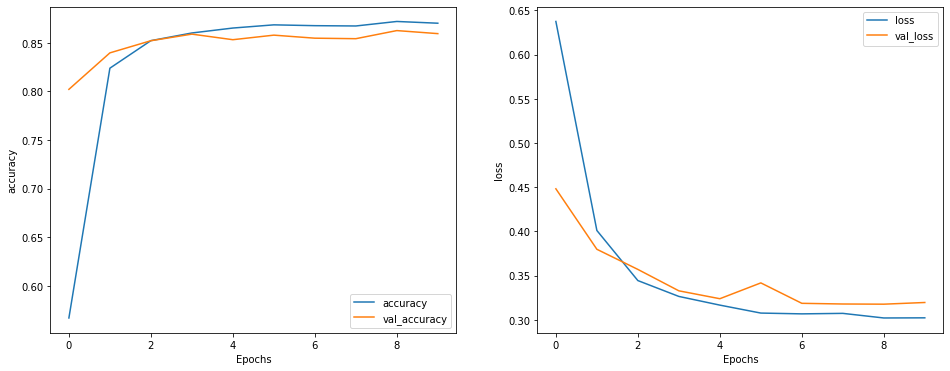

In [27]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

Check out other existing recurrent layers such as [GRU layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU).

If you're interestied in building custom RNNs, see the [Keras RNN Guide](https://www.tensorflow.org/guide/keras/rnn).
